In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [2]:
#Instal new version of Tensorflow
#!pip3 install --upgrade tensorflow==2.12.0

In [3]:
import random
from datetime import datetime
import time
import resource
import pickle
import os
import pdb
from tqdm import tqdm
from itertools import chain

import numpy as np
import pandas as pd
import keras
from scipy.interpolate import pchip_interpolate

import tensorflow as tf
#import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
#In old version of Tensorflow 2.8.0
#from tensorflow.keras.optimizers import Adam
#In new version of Tensorflow 2.12.0, please use legacy to import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
#from keras import backend as K

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from IPython.display import clear_output, display, HTML

from matplotlib import pyplot as plt
import seaborn as sns

# originally built on old TensorFlow and Keras which didn't support eager execution
tf.compat.v1.disable_eager_execution()
#tf.compat.v1.disable_v2_behavior()
#tf.compat.v1.enable_eager_execution()

# set seeds for reproducibility
# np.random.uniform(0,10000) 4465
random.seed(4465)
np.random.seed(4465)
tf.random.set_seed(4465)

print("TensorFlow %s" % tf.__version__)
print("Keras %s" % keras.__version__)
print("plotly %s" % plotly.__version__)
print("pandas %s" % pd.__version__)
print("numpy %s" % np.__version__)

# If model save directory isn't made yet, make it
if not os.path.exists('model_output'):
    os.makedirs('model_output')
if not os.path.exists('model_output/trading'):
    os.makedirs('model_output/trading')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow 2.12.0
Keras 2.12.0
plotly 5.15.0
pandas 2.0.3
numpy 1.23.5


In [4]:
def sizeof_fmt(num, suffix='B'):
    """given memory as int format as memory units eg KB"""
    for unit in ['', 'K', 'M', 'G', 'T', 'P', 'E', 'Z']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Y', suffix)

def memusage():
    """print memory usage"""
    return sizeof_fmt(int(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))

memusage()

'689.3 KB'

In [5]:
def make_figure(*series, title="", xtitle="", ytitle=""):
    fig = go.Figure()
    series=list(series)
    x = series.pop(0)
    for s in series:
        fig.add_trace(go.Scatter(y=s, x=x))
    fig.update_layout(
        title= dict(text=title,
                    x=0.5,
                    xanchor='center'),
        xaxis=dict(
            title=xtitle,
            linecolor='black',
            linewidth=1,
            mirror=True
        ),
        yaxis=dict(
            title=ytitle,
            linecolor='black',
            linewidth=1,
            mirror=True
        ),
        showlegend=False
    )

    return fig.show()

In [6]:
stock_series = []


amplifier=1000
date=478
stock=46
#be cautious when setting dt. dt is inverse proportional to learning time dt=1 means no optimization
dt=1
N_EPISODES = 500
#lag is fixed
lag = 1

#filename="IndexWap_day231.csv"
#excelfilereader=pd.read_csv(r'/content/kaggle_optiver_data/IndexWap_day231.csv', header=None)
#data = excelfilereader.iloc[0,:].values.tolist()
#data = excelfilereader.iloc[0,:]*1000

#excelfilereader=pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/train.csv')

#excelfilereader=pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
test=pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
def Data_input(test,stock,date,amplifier,dt=1):
    data_sub=test[test['stock_id']==stock]
    data_sub2=data_sub[data_sub['date_id']==date]
    data=pd.DataFrame(data_sub2,columns=['wap'])
    data = data.values.tolist()
    data=np.squeeze(data)
    data=data*amplifier
    stock_series=data
    time_series=range(0,data.shape[0])
    df = pd.DataFrame({'dateindex': time_series, 'stock': stock_series})
    x=df['dateindex']
    y=df['stock']
    x_sub = np.linspace(min(x), max(x), num=int(df.shape[0]/dt))
    y_sub = pchip_interpolate(x, y, x_sub)
    df_new = pd.DataFrame({'dateindex': x_sub, 'stock': y_sub})
    return df_new

df_new=Data_input(test,stock,date,amplifier)
#print(range(min(test['stock_id']),max(test['stock_id'])))
make_figure(df_new['dateindex'], df_new['stock'],
            title="Stock {} price at date {}".format(int(stock), int(date)),
            xtitle='Timesteps',
            ytitle='Value'
           )


In [7]:
index_1=[0,6,12,18,24,30,36,42,48,54]
index_2=[1,7,13,19,25,31,37,43,49]
index_3=[2,8,14,20,26,32,38,44,50]
index_4=[3,9,15,21,27,33,39,45,51]
index_5=[4,10,16,22,28,34,40,46,52]
index_6=[5,11,17,23,29,35,41,47,53]
index_list=[index_1,index_2,index_3,index_4,index_5, index_6]


In [8]:
def indexWAP(data, date, t):
    coefficient = [0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.002,
                   0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004, 0.002, 0.002, 0.004, 0.002,
                   0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004, 0.004, 0.004, 0.006, 0.002, 0.002, 0.04,
                   0.002, 0.002, 0.004, 0.04, 0.002, 0.001, 0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002,
                   0.006, 0.004, 0.006, 0.004, 0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004,
                   0.002, 0.004, 0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
                   0.02, 0.004, 0.006, 0.002, 0.02, 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02, 0.006, 0.001, 0.002,
                   0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002, 0.004, 0.006, 0.006, 0.001, 0.04,
                   0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002, 0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008,
                   0.006, 0.004, 0.002, 0.006, 0.002, 0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008,
                   0.006, 0.008, 0.002, 0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001,
                   0.002, 0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002, 0.04,
                   0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02, 0.004, 0.002, 0.006, 0.02, 0.001, 0.002, 0.006,
                   0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04, 0.002, 0.008, 0.002, 0.004, 0.001,
                   0.004, 0.006, 0.004]
    date_sub = data.loc[(data["date_id"] == date) & (data["seconds_in_bucket"] == t)]
    stk_id = pd.DataFrame(date_sub, columns=["stock_id"])
    wap = pd.DataFrame(date_sub, columns=["wap"])
    stk_id_arr = np.array(stk_id).reshape(-1)

    missing_elemnts = [item for item in range(stk_id_arr[0], 200) if item not in stk_id_arr]
    missing_elemnts_arr = np.array(missing_elemnts).reshape(-1)
    list_coefficient = coefficient
    for i in sorted(missing_elemnts_arr, reverse=True):
        list_coefficient.pop(i)

    norm = [float(i) / sum(list_coefficient) for i in list_coefficient]
    stock_index = np.dot(norm, wap)
    return (np.array([stock_index]).item())


In [9]:
def Index_Calc(test,date):
    time_arr = np.arange(0, 550,10)
    time=np.arange(0,55)
    date_0 = test.loc[(test["date_id"] == date)]

    index = []

    for i in time_arr:
        index.append(indexWAP(date_0, date, i))
    index=np.squeeze(index)
    index=index*amplifier
    df_index = pd.DataFrame({'dateindex': time, 'stock': index})
    return df_index

#df_index=Index_Calc(date)
#make_figure(df_index['dateindex'], df_index['stock'],
#            title="Index at date {}".format(int(date)),
#            xtitle='Timesteps',
#            ytitle='Value'
#           )


In [10]:
def user_gen(df,start_trend=amplifier):
    t=0
    trend_index = start_trend
    while t<=(df.shape[0]):
        stock_price= df['stock'][t]
        yield(t, stock_price, trend_index)
        t+=1

def user_gen_dt(df,dt=1,start_trend=amplifier):
    t=0
    trend_index = start_trend
    x=df['dateindex']
    y=df['stock']
    x_sub = np.linspace(min(x), max(x), num=int(df.shape[0]/dt))
  #print(np.shape(x_sub))
    y_sub = pchip_interpolate(x, y, x_sub)
  #print(np.shape(y_sub))
    while t<=int(len(x_sub)/dt):
        stock_price= y_sub[t]
        yield(t, stock_price, trend_index)
        t+=dt

def user_sub(df,index_sub,start_trend=amplifier):
    t=0
    trend_index = start_trend
    x=range(len(index_sub))
    y=[]
    #x=df['dateindex'][index_sub]
    y=df['stock'][index_sub]
    for i in range(len(index_sub)):
        y[i]=df['stock'][index_sub[i]]
    while t<=int(len(x)):
        stock_price= y[t]
        yield(t, stock_price, trend_index)
        t+=1

In [11]:
def market_gen(gen, lag=1):

    buffer = []
    diffbuffer = []


    # fill buffer
    dt, last, trend = next(gen)
    for i in range(lag):
        prev = last
        dt, last, trend = next(gen)
        buffer.append(last-trend)
        diffbuffer.append(last-prev)

    # yield first group of lag vals and diffs
    yield buffer+diffbuffer

    while(True):
        prev = last
        dt, last, trend = next(gen)
        buffer.pop(0)
        buffer.append(last-trend)
        diffbuffer.pop(0)
        diffbuffer.append(last-prev)
        yield buffer+diffbuffer



In [12]:
class Market:
    """Follows OpenAI gym environment convention basically
    init with generator and number of stocks
    reset() - generate and return first state
    step() - generate next state and reward
    """
    def __init__(self, gen, lag=16, nstocks=1, episode_length=300):
        self.genfunc = gen
        self.nstocks = nstocks
        self.episode_length = episode_length
        self.t = 0
        self.total_reward = 0
        self.lag = lag
        self.observation_space = np.asarray([1] * nstocks * lag * 2,)
        self.state_size = nstocks * lag * 2
        self.action_size = 2

    def reset(self):
        self.t = 0
        self.total_reward = 0
        self.gen = [self.genfunc() for _ in range(self.nstocks)]
        self.state=[next(g) for g in self.gen]
        self.state = np.asarray([s for s in self.state])
        return self.state

    def render(self):
        print(self.state[0, nstocks-1])

    def step(self, action):
        action = np.asarray([action])
        try:
            self.state=[next(g) for g in self.gen]
        except StopIteration:
            return print("generator failed.\n")
        
        self.state = np.asarray([s for s in self.state])
        # last element is most recent change
        stock_delta = np.asarray([s[-1] for s in self.state])
        # element at lag-1 is most recent deviation
        market_price = np.asarray([s[self.lag-1]+100 for s in self.state])
        # map actions 0 1 2 to positions -1, 0, 1
        position = action - 1
        reward = position @ stock_delta
        self.total_reward += reward
        self.t += 1
        done = True if self.episode_length and self.t >= self.episode_length else False
        # state, reward, done, info
        return self.state, reward, done, market_price

    def close(self):
        pass


#env = Market(user_gen_dt(df,0.1), lag=1, nstocks=1, episode_length=10)

In [13]:
DISCOUNT_RATE = 0
# WIN_REWARD = 10
EPSILON_DECAY = 0.995
SAMPLE_SIZE = 256
RENDER = False
OUTPUT_DIR = 'model_output/trading/'

class DQN_Agent:
    def __init__(self, state_size, action_size, filename="dqn",
                 discount_rate=DISCOUNT_RATE,
                 learning_rate=0.001,
                 epsilon=1.0,
                 epsilon_decay=EPSILON_DECAY,
                 epsilon_min=0.01):

        self.state_size = state_size
        self.action_size = action_size
        self.filename = filename
        self.discount_rate = discount_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate

        self.model = self.build_model()
        self.memory = pd.DataFrame(columns=["state", "action", "next_state",
                                            "reward", "done"])
        self.memory_size = 100000
        self.results = []
        self.train_batch_size = 1
        self.timestep = 0
        self.save_interval = 10

    def build_model(self,
                    n_hidden_layers=2,
                    hidden_layer_size=16,
                    activation='relu',
                    reg_penalty=0.001,
                    dropout=0.0675,
                    verbose=True
                   ):
        """return keras NN model per inputs
        input is a state - array of size state_size
        output is an array of action values - array of size action_size
        """

        inputs = Input(shape=(self.state_size,), name="Input")
        last_layer = inputs

        for i in range(n_hidden_layers):
            if verbose:
                formatstr = "layer %d size %d, %s, reg_penalty %.8f, dropout %.3f"
                print(formatstr % (i + 1,
                                   hidden_layer_size,
                                   activation,
                                   reg_penalty,
                                   dropout))
            # add dropout, but not on inputs, only between hidden layers
            if i and dropout:
                last_layer = Dropout(dropout, name="Dropout%02d" % i)(last_layer)

            last_layer = Dense(units=hidden_layer_size,
                               activation=activation,
                               kernel_initializer=glorot_uniform(),
                               kernel_regularizer=l2(reg_penalty),
                               name="Dense%02d" % i)(last_layer)

        outputs = Dense(self.action_size, activation='linear', name="Output")(last_layer)

        #model = Model(inputs=input_layer , output=last_layer)
        model = Model(inputs=inputs, outputs=outputs)

        if verbose:
            print(model.summary())

        model.compile(loss='mse', optimizer=Adam(
            #learning_rate=self.learning_rate
        ))

        return model

    def remember(self):
        """store the states and rewards needed to fit the model"""
        # append in place
        self.memory.loc[self.memory.shape[0]] = [self.state,
                                                 self.action,
                                                 self.next_state,
                                                 self.reward,
                                                 self.done]

    def train(self):
        """train the model on experience stored by remember"""

        # need at least SAMPLE_SIZE observations
        if self.memory.shape[0] < SAMPLE_SIZE:
            return

        # truncate memory
        self.memory = self.memory[-self.memory_size:]
        # sample sample_size observations from memory
        minibatch = self.memory.sample(n=SAMPLE_SIZE)

        # target is our best estimate of value of each action
        X_fit = np.concatenate(minibatch['state'].values)
        X_fit = X_fit.reshape((SAMPLE_SIZE, self.state_size))
        Y_pred = self.model.predict(X_fit)

        # we don't just fit model against model's own prediction, gets us nowhere
        # we improve the target by what we learned about the action we actually took
        # value is reward obtained + predicted value of the observed next state
        minibatch['target_observed'] = minibatch['reward']
        # if done, target is the reward
        # reward by gym env is only 1 for each timestep of survival
        # but we also added a reward of -10 on failure
        # if not done, add discount_rate  * Q-value prediction for  observed next state
        not_done = minibatch.loc[minibatch['done'] == False]
        X_observed = np.concatenate(not_done['next_state'].values)
        X_observed = X_observed.reshape((not_done.shape[0], self.state_size))
        # run all predictions at once
        # iterates faster but does not train after each prediction
        y_observed_pred = np.amax(self.model.predict(X_observed), axis=1)
        minibatch.loc[minibatch['done'] == False, 'target_observed'] \
            += self.discount_rate * y_observed_pred
        # vectorized vlookup - update col specified by action with target_observed
        np.put_along_axis(Y_pred,
                          minibatch['action'].astype(int).values.reshape(SAMPLE_SIZE, 1),
                          minibatch['target_observed'].values.reshape(SAMPLE_SIZE, 1),
                          axis=1)
        # fit model against improved target
        # arbitrary 8 batch size to reduce variance a little and speed up fit
        self.model.fit(X_fit, Y_pred,
                       epochs=1,
                       batch_size=self.train_batch_size,
                       verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, state):
        """pick an action using model"""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def save(self):
        "save agent: pickle self and use Keras native save model"
        fullname = "%s%s%05d" % (OUTPUT_DIR, self.filename, len(self.results))
        self.model.save("%s.h5" % fullname)
        pickle.dump(self, open("%s.p" % fullname, "wb"))

    def load(filename):
        "load saved agent"
        new = pickle.load(open("%s.p" % filename, "rb"))
        new.model = load_model("%s.h5" % filename)
        print("loaded %d results, %d rows of memory, epsilon %.4f" % (len(new.results),
                                                                      len(new.memory),
                                                                      new.epsilon))
        return new

    def reset(self):
        """reset agent for start of episode"""
        self.timestep = 0
        self.total_reward = 0

    def increment_time(self):
        """increment timestep counter"""
        self.timestep += 1

    def save_score(self):
        """save score of each episode"""
        self.results.append(self.total_reward)

    def score_episode(self, episode_num, n_episodes):
        """output results and save"""
        self.save_score()
        avglen = min(len(self.results), self.save_interval)
        formatstr = "{} episode {}/{}:, score: {}, {}-episode avg: {:.1f} Memory: {}        "
        print(formatstr.format(time.strftime("%H:%M:%S"), len(self.results),
                               n_episodes, self.total_reward, avglen,
                               sum(self.results[-avglen:])/avglen, memusage()),
              end="\r", flush=False)

    def run_episode(self, render=RENDER):
        """run a full episode"""
        global env

        self.reset()
        self.state = env.reset()
        self.done = False

        while not self.done:
            if render:
                env.render()
            self.action = self.act(self.state.reshape([1, self.state_size]))
            self.next_state, self.reward, self.done, _ = env.step(self.action)
            self.total_reward += self.reward
            self.remember()
            self.state = self.next_state
            self.increment_time()

        if render:
            env.render()

        self.train()

    def rlplot(self, title='Agent Training Progress'):
        """plot training progress"""
        df = pd.DataFrame({'timesteps': self.results})
        df['avg'] = df['timesteps'].rolling(10).mean()

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['timesteps'],
                                 mode='markers',
                                 name='timesteps',
                                 marker=dict(
                                     color='mediumblue',
                                     size=4,
                                 ),
                                ))

        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['avg'],
                                 mode='lines',
                                 line_width=3,
                                 name='moving average'))

        fig.update_layout(
            title=dict(text=title,
                       x=0.5,
                       xanchor='center'),
            xaxis=dict(
                title="Episodes",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                title="Total Reward per Episode",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            legend=go.layout.Legend(
                x=0.01,
                y=0.99,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
                #bgcolor="LightSteelBlue",
                bordercolor="Black",
                borderwidth=1,
            ),
        )

        return fig.show()


In [14]:
RENDER = False
OUTPUT_DIR = 'model_output/trading/'

class Agent:
    """abstract base class for agents"""

    def __init__(self, state_size, action_size, filename="model",
                 *args, **kwargs):
        self.state_size = state_size
        self.action_size = action_size
        self.filename = filename
        self.timestep = 0
        self.total_reward = 0
        self.save_interval = 10

        raise NotImplementedError

    def build_model(self, *args, **kwargs):
        """build the relevant model"""
        raise NotImplementedError

    def reset(self):
        """reset agent for start of episode"""
        self.timestep = 0
        self.total_reward = 0

    def increment_time(self):
        """increment timestep counter"""
        self.timestep += 1

    def remember(self, *args, **kwargs):
        """store the states and rewards needed to fit the model"""
        raise NotImplementedError

    def train(self, *args, **kwargs):
        """train the model on experience stored by remember"""
        raise NotImplementedError

    def act(self, *args, **kwargs):
        """pick an action using model"""
        raise NotImplementedError

    def save_score(self):
        """save score of each episode"""
        self.results.append(self.total_reward)

    def score_episode(self, episode_num, n_episodes):
        """output results and save"""
        self.save_score()
        avglen = min(len(self.results), self.save_interval)
        formatstr = "{} episode {}/{}:, score: {}, {}-episode avg: {:.1f} Memory: {}        "
        print(formatstr.format(time.strftime("%H:%M:%S"), len(self.results),
                               n_episodes, self.total_reward, avglen,
                               sum(self.results[-avglen:])/avglen, memusage()),
              end="\r", flush=False)

    def run_episode(self, render=RENDER):
        """run a full episode"""
        global env

        self.reset()
        self.state = env.reset()
        self.done = False

        while not self.done:
            if render:
                env.render()
            self.action = self.act(self.state.reshape([1, self.state_size]))
            self.next_state, self.reward, self.done, _ = env.step(self.action)
            self.total_reward += self.reward

            self.remember()
            self.state = self.next_state
            self.increment_time()

        if render:
            env.render()

        self.train()

    def save(self, *args, **kwargs):
        """save agent to disk"""
        raise NotImplementedError

    def load(*args, **kwargs):
        """load agent from disk"""
        raise NotImplementedError

    def view(self):
        """Run an episode without training, with rendering"""
        state = env.reset()
        state = np.reshape(state, [1, self.state_size])
        done = False

        # run an episode
        self.timestep = 0
        r = 0
        while not done:
            env.render()
            action = self.act(state)
            lastmarket = self.state[0, nstocks-1]
            state, reward, done, _ = env.step(action)
            newmarket = self.state[0, nstocks-1]
            print("prev mkt: %.4f action: %d, new mkt %f, reward %f" % (lastmarket, action, newmarket, reward))
            r += reward
            state = np.reshape(state, [1, self.state_size])
            self.timestep += 1
        env.render()
        print(r)
        env.close()
        return self.timestep

    def rlplot(self, title='Trading Agent Training Progress'):
        """plot training progress"""
        df = pd.DataFrame({'timesteps': self.results})
        df['avg'] = df['timesteps'].rolling(10).mean()

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['timesteps'],
                                 mode='markers',
                                 name='timesteps',
                                 marker=dict(
                                     color='mediumblue',
                                     size=4,
                                 ),
                                ))

        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['avg'],
                                 mode='lines',
                                 line_width=3,
                                 name='moving average'))

        fig.update_layout(
            title=dict(text=title,
                       x=0.5,
                       xanchor='center'),
            xaxis=dict(
                title="Episodes",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                title="Total Reward per Episode",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            legend=go.layout.Legend(
                x=0.01,
                y=0.99,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
                #bgcolor="LightSteelBlue",
                bordercolor="Black",
                borderwidth=1,
            ),
        )

        return fig.show()


In [15]:
class REINFORCE_Agent(Agent):
    """REINFORCE policy gradient method using deep Keras NN"""
    def __init__(self, state_size=4, action_size=2, learning_rate=0.005,
                 discount_rate=DISCOUNT_RATE, n_hidden_layers=2, hidden_layer_size=16,
                 activation='relu', reg_penalty=0, dropout=0, filename="kreinforce",
                 verbose=True):
        self.state_size = state_size
        self.action_size = action_size
        self.action_space = list(range(action_size))
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate

        self.n_hidden_layers = n_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.activation = activation
        self.reg_penalty = reg_penalty
        self.dropout = dropout
        self.verbose = verbose
        self.filename = filename

        self.train_model, self.predict_model = self.policy_model()
        self.results = []
        self.save_interval = 10
        self.reset()


    def reset(self):
        """reset agent for start of episode"""
        self.timestep = 0
        # truncate memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.total_reward = 0

    def policy_model(self):
        """set up NN model for policy.
        predict returns probs of actions to sample from.
        train needs discounted rewards for the episode, so we define custom loss.
        when training use train_model with custom loss and multi input of training data and rewards.
        when predicting use predict_model with single input.
        """

        def custom_loss(y_true, y_pred):
            y_pred_clip = K.clip(y_pred, 1e-8, 1-1e-8)
            log_likelihood = y_true*K.log(y_pred_clip)
            return K.sum(-log_likelihood*discounted_rewards)

        inputs = Input(shape=(self.state_size,), name="Input")
        discounted_rewards = Input(shape=(1,), name="Discounted_rewards")
        last_layer = inputs

        for i in range(self.n_hidden_layers):
            if self.verbose:
                formatstr = "layer %d size %d, %s, reg_penalty %.8f, dropout %.3f"
                print(formatstr % (i + 1,
                                   self.hidden_layer_size,
                                   self.activation,
                                   self.reg_penalty,
                                   self.dropout,
                                   ))
            # add dropout, but not on inputs, only between hidden layers
            if i and self.dropout:
                last_layer = Dropout(self.dropout, name="Dropout%02d" % i)(last_layer)

            last_layer = Dense(units=self.hidden_layer_size,
                               activation=self.activation,
                               kernel_initializer=glorot_uniform(),
                               kernel_regularizer=keras.regularizers.l2(self.reg_penalty),
                               name="Dense%02d" % i)(last_layer)

        outputs = Dense(self.action_size, activation='softmax', name="Output")(last_layer)

        train_model = Model(inputs=[inputs, discounted_rewards], outputs=[outputs])
        train_model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=custom_loss)

        predict_model = Model(inputs=[inputs], outputs=[outputs])

        if self.verbose:
            print(predict_model.summary())

        return train_model, predict_model


    def act(self, state):
        """pick an action using predict_model"""
        probabilities = self.predict_model.predict(state)

        action = np.random.choice(self.action_space, p=probabilities[0])
        prob=probabilities[0][action]
        #print("probability={}\n".format(probabilities[0][action]))
        return action

    def remember(self):
        """at each step save state, action, reward for future training"""

        self.state_memory.append(self.state)
        self.action_memory.append(self.action)
        self.reward_memory.append(self.reward)
        

    def train(self):
        """train the model on experience stored by remember"""
        state_memory = np.array(self.state_memory)
        state_memory = state_memory.reshape((len(self.state_memory),self.state_size))
        action_memory = np.array(self.action_memory)
        reward_memory = np.array(self.reward_memory)

        # one-hot actions
        actions = np.zeros([len(action_memory), self.action_size])
        actions[np.arange(len(action_memory)), action_memory] = 1

        disc_rewards = np.zeros_like(reward_memory)
        cumulative_rewards = 0
        for i in reversed(range(len(reward_memory))):
            cumulative_rewards = cumulative_rewards * self.discount_rate + reward_memory[i]
            disc_rewards[i] = cumulative_rewards

        # standardize
        disc_rewards -= np.mean(disc_rewards)
        disc_rewards /= np.std(disc_rewards) if np.std(disc_rewards) > 0 else 1

        # train states v. actions, (complemented by disc_rewards_std)
        cost = self.train_model.train_on_batch([state_memory, disc_rewards], actions)

        return cost

    def view(self):
        """Run an episode without training, with rendering"""
        state = env.reset()
        state = np.reshape(state, [1, self.state_size])
        done = False

        # run an episode
        self.timestep = 0
        r = 0
        retarray = []
        while not done:
            action = self.act(state)
            lastmarket = state[0, self.state_size//2-1]
            state, reward, done, _ = env.step(action)
            newmarket = state[0, self.state_size//2-1]
            print("prev mkt: %.4f action: %d, new mkt %.4f, reward %f" % (lastmarket, action, newmarket, reward))
            r += reward
            state = np.reshape(state, [1, self.state_size])
            self.timestep += 1
            retarray.append((self.timestep, action, lastmarket, newmarket, reward))
        print(r)
        env.close()
        return retarray

    def save(self):
        "save agent: pickle self and use Keras native save model"
        fullname = "%s%s%05d" % (OUTPUT_DIR, self.filename, len(self.results))
        self.predict_model.save("%s_predict.h5" % fullname)
        # can't save / load train model due to custom loss
        pickle.dump(self, open("%s.p" % fullname, "wb"))

    def load(filename, memory=True):
        "load saved agent"
        self = pickle.load(open("%s.p" % filename, "rb"))
        self.predict_model = load_model("%s_predict.h5" % filename)
        print("loaded %d results, %d rows of memory, epsilon %.4f" % (len(self.results),
                                                                      len(self.memory),
                                                                      self.epsilon))

In [16]:
#dt=1
#index_1=[0,6,12,18,24,30,36,42,48,54]
#index_2=[1,7,13,19,25,31,37,43,49]
#index_3=[2,8,14,20,26,32,38,44,50]
#index_4=[3,9,15,21,27,33,39,45,51]
#index_5=[4,10,16,22,28,34,40,46,52]
#index_6=[5,11,17,23,29,35,41,47,53]

#index_pick=index_5
N_EPISODES = 500
#lag is fixed
lag = 1
#ticks_per_episode = len(index_pick)/dt-1-lag
nstocks = 1


#gen = user_sub(df_new,index_1,start_trend=amplifier)


In [17]:
#def shm_market_gen():
#    return market_gen(gen=user_sub(df_new,index_pick,start_trend=amplifier),
#                      lag=lag)


#gen=shm_market_gen()
#time_series=[]
#stock_series=[]
#for i in range(len(index_pick)-lag):
#    z = next(gen)
#    time_series.append(i)
#    stock_series.append(z[1])

#df_gen = pd.DataFrame({'dateindex': time_series, 'stock': stock_series})

#make_figure(df_gen['dateindex'], df_gen['stock'],
#            title='Genarated market',
#            xtitle='Timesteps',
#            ytitle='buffer+diffbuffer'
#           )

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
Start: 02:44:38


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:44:51 episode 500/500:, score: 2.4154080000004114, 10-episode avg: 2.3 Memory: 3.0 MB           
Train time:  13.103216171264648
prev mkt: 1.0869 action: 2, new mkt 1.3753, reward 0.288445
prev mkt: 1.3753 action: 0, new mkt 0.7831, reward 0.592189
prev mkt: 0.7831 action: 2, new mkt 1.1325, reward 0.349364
prev mkt: 1.1325 action: 0, new mkt 0.4120, reward 0.720463
prev mkt: 0.4120 action: 2, new mkt 0.4070, reward -0.005050
prev mkt: 0.4070 action: 2, new mkt 0.8868, reward 0.479815
prev mkt: 0.8868 action: 2, new mkt 1.1438, reward 0.256987
prev mkt: 1.1438 action: 0, new mkt 1.4106, reward -0.266805
2.4154080000004114
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:45:00 episode 500/500:, score: 2.389495999999781, 10-episode avg: 2.3 Memory: 3.0 MB           
Train time:  8.831791400909424
prev mkt: 1.4387 action: 2, new mkt 1.4476, reward 0.008884
prev mkt: 1.4476 action: 0, new mkt 0.9719, reward 0.475623
prev mkt: 0.9719 action: 2, new mkt 1.0910, reward 0.119049
prev mkt: 1.0910 action: 0, new mkt 0.2583, reward 0.832733
prev mkt: 0.2583 action: 2, new mkt 0.6808, reward 0.422542
prev mkt: 0.6808 action: 2, new mkt 1.0839, reward 0.403097
prev mkt: 1.0839 action: 2, new mkt 1.2115, reward 0.127568
2.389495999999781
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:45:09 episode 500/500:, score: 2.3563709999992852, 10-episode avg: 2.4 Memory: 3.0 MB         
Train time:  8.354857921600342
prev mkt: 1.6056 action: 0, new mkt 1.4413, reward 0.164294
prev mkt: 1.4413 action: 0, new mkt 0.9639, reward 0.477411
prev mkt: 0.9639 action: 0, new mkt 0.9588, reward 0.005050
prev mkt: 0.9588 action: 0, new mkt 0.1924, reward 0.766411
prev mkt: 0.1924 action: 2, new mkt 0.6607, reward 0.468280
prev mkt: 0.6607 action: 2, new mkt 1.1868, reward 0.526152
prev mkt: 1.1868 action: 0, new mkt 1.2381, reward -0.051227
2.3563709999992852
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:45:17 episode 500/500:, score: 2.3907449999998107, 10-episode avg: 2.4 Memory: 3.0 MB          
Train time:  8.73918628692627
prev mkt: 1.5710 action: 0, new mkt 1.2090, reward 0.361997
prev mkt: 1.2090 action: 0, new mkt 1.1077, reward 0.101355
prev mkt: 1.1077 action: 0, new mkt 0.9792, reward 0.128499
prev mkt: 0.9792 action: 0, new mkt 0.2306, reward 0.748599
prev mkt: 0.2306 action: 2, new mkt 0.7184, reward 0.487778
prev mkt: 0.7184 action: 2, new mkt 1.1566, reward 0.438236
prev mkt: 1.1566 action: 2, new mkt 1.2809, reward 0.124281
2.3907449999998107
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:45:26 episode 500/500:, score: 1.7486610000004248, 10-episode avg: 1.7 Memory: 3.0 MB           
Train time:  8.531394481658936
prev mkt: 1.2884 action: 0, new mkt 0.7006, reward 0.587806
prev mkt: 0.7006 action: 2, new mkt 1.1016, reward 0.401022
prev mkt: 1.1016 action: 2, new mkt 0.9944, reward -0.107207
prev mkt: 0.9944 action: 0, new mkt 0.5570, reward 0.437407
prev mkt: 0.5570 action: 2, new mkt 0.6872, reward 0.130228
prev mkt: 0.6872 action: 2, new mkt 1.0677, reward 0.380528
prev mkt: 1.0677 action: 2, new mkt 1.3633, reward 0.295537
2.125321000000099
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:45:35 episode 500/500:, score: 1.573694999999816, 10-episode avg: 1.6 Memory: 3.0 MB           
Train time:  8.6809983253479
prev mkt: 1.2153 action: 0, new mkt 0.6253, reward 0.590052
prev mkt: 0.6253 action: 2, new mkt 1.1916, reward 0.566294
prev mkt: 1.1916 action: 0, new mkt 1.0193, reward 0.172283
prev mkt: 1.0193 action: 0, new mkt 0.4650, reward 0.554270
prev mkt: 0.4650 action: 2, new mkt 0.7779, reward 0.312851
prev mkt: 0.7779 action: 0, new mkt 1.1098, reward -0.331877
prev mkt: 1.1098 action: 0, new mkt 1.3999, reward -0.290178
1.573694999999816
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:45:44 episode 500/500:, score: 3.6479999999993424, 10-episode avg: 3.6 Memory: 3.0 MB         
Train time:  9.309131383895874
prev mkt: -0.0740 action: 2, new mkt 0.8860, reward 0.960000
prev mkt: 0.8860 action: 0, new mkt 0.2260, reward 0.660000
prev mkt: 0.2260 action: 2, new mkt 0.4600, reward 0.234000
prev mkt: 0.4600 action: 0, new mkt -0.0500, reward 0.510000
prev mkt: -0.0500 action: 2, new mkt 0.2480, reward 0.298000
prev mkt: 0.2480 action: 2, new mkt 0.6650, reward 0.417000
prev mkt: 0.6650 action: 0, new mkt 0.1880, reward 0.477000
prev mkt: 0.1880 action: 2, new mkt 0.2800, reward 0.092000
3.6479999999993424
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:45:53 episode 500/500:, score: 2.9049999999999727, 10-episode avg: 2.8 Memory: 3.0 MB          
Train time:  8.679243564605713
prev mkt: 0.5270 action: 2, new mkt 1.2150, reward 0.688000
prev mkt: 1.2150 action: 0, new mkt 0.2390, reward 0.976000
prev mkt: 0.2390 action: 0, new mkt 0.1950, reward 0.044000
prev mkt: 0.1950 action: 0, new mkt 0.0360, reward 0.159000
prev mkt: 0.0360 action: 2, new mkt 0.2600, reward 0.224000
prev mkt: 0.2600 action: 2, new mkt 0.6750, reward 0.415000
prev mkt: 0.6750 action: 0, new mkt 0.2760, reward 0.399000
2.9049999999999727
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:46:02 episode 500/500:, score: 2.8000000000004093, 10-episode avg: 2.8 Memory: 3.0 MB          
Train time:  8.421298503875732
prev mkt: 0.7770 action: 0, new mkt 1.1920, reward -0.415000
prev mkt: 1.1920 action: 0, new mkt 0.6330, reward 0.559000
prev mkt: 0.6330 action: 0, new mkt -0.1020, reward 0.735000
prev mkt: -0.1020 action: 2, new mkt 0.4370, reward 0.539000
prev mkt: 0.4370 action: 0, new mkt 0.1900, reward 0.247000
prev mkt: 0.1900 action: 2, new mkt 0.8390, reward 0.649000
prev mkt: 0.8390 action: 0, new mkt 0.3530, reward 0.486000
2.8000000000004093
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:46:10 episode 500/500:, score: 2.9849999999996726, 10-episode avg: 3.0 Memory: 3.0 MB          
Train time:  8.620276689529419
prev mkt: 0.8650 action: 0, new mkt 0.9580, reward -0.093000
prev mkt: 0.9580 action: 0, new mkt 0.6570, reward 0.301000
prev mkt: 0.6570 action: 0, new mkt -0.1410, reward 0.798000
prev mkt: -0.1410 action: 2, new mkt 0.4400, reward 0.581000
prev mkt: 0.4400 action: 0, new mkt 0.2060, reward 0.234000
prev mkt: 0.2060 action: 2, new mkt 0.8400, reward 0.634000
prev mkt: 0.8400 action: 0, new mkt 0.3100, reward 0.530000
2.9849999999996726
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:46:19 episode 500/500:, score: 2.0949999999999136, 10-episode avg: 2.5 Memory: 3.0 MB        
Train time:  8.671142816543579
prev mkt: 1.1100 action: 0, new mkt 0.0430, reward 1.067000
prev mkt: 0.0430 action: 2, new mkt 0.7090, reward 0.666000
prev mkt: 0.7090 action: 0, new mkt 0.4980, reward 0.211000
prev mkt: 0.4980 action: 0, new mkt 0.4640, reward 0.034000
prev mkt: 0.4640 action: 0, new mkt 0.2840, reward 0.180000
prev mkt: 0.2840 action: 2, new mkt 0.5490, reward 0.265000
prev mkt: 0.5490 action: 0, new mkt 0.3470, reward 0.202000
2.624999999999659
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:46:28 episode 500/500:, score: 2.5900000000001455, 10-episode avg: 2.6 Memory: 3.0 MB          
Train time:  8.49519395828247
prev mkt: 1.0010 action: 0, new mkt -0.1710, reward 1.172000
prev mkt: -0.1710 action: 2, new mkt 0.5560, reward 0.727000
prev mkt: 0.5560 action: 0, new mkt 0.4600, reward 0.096000
prev mkt: 0.4600 action: 0, new mkt 0.2010, reward 0.259000
prev mkt: 0.2010 action: 2, new mkt 0.4600, reward 0.259000
prev mkt: 0.4600 action: 0, new mkt 0.4990, reward -0.039000
prev mkt: 0.4990 action: 0, new mkt 0.3830, reward 0.116000
2.5900000000001455


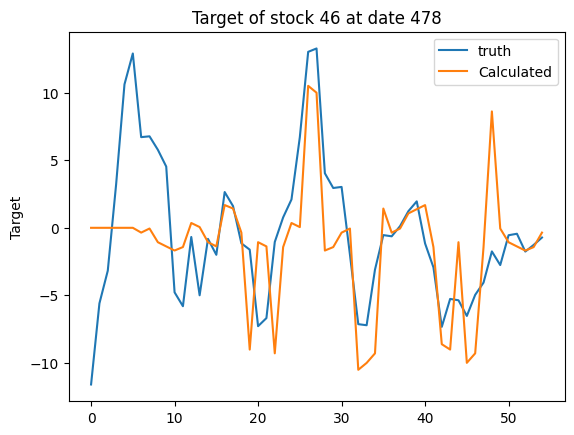

Mean absolute error : 3.709674708677392


In [18]:



date=478
stock=46
df_new=Data_input(test,stock,date,amplifier)

#ticks_per_episode = len(index_pick)/dt-1-lag
nstocks = 1
result_index=[]
df_index=Index_Calc(test,date)
for i in range(len(index_list)):
    ticks_per_episode = len(index_list[i])/dt-1-lag
    def shm_market_gen():
        return market_gen(gen=user_sub(df_index,index_list[i],start_trend=amplifier),lag=1)
    env = Market(shm_market_gen,
             lag=lag,
             nstocks=1,
             episode_length=ticks_per_episode)

    agent = REINFORCE_Agent(state_size=nstocks*lag*2,
                        action_size=3,
                       )

    start_time = time.time()
    print("Start: %s" % (time.strftime("%H:%M:%S")))

    for e in range(N_EPISODES):
        agent.run_episode()
        agent.score_episode(e, N_EPISODES)
    

    #if e and (e+1) % agent.save_interval == 0:
    #    agent.save()

    elapsed_time = time.time() - start_time
    print("\nTrain time: ", elapsed_time)
    env.reset()
    z = agent.view()

    df = pd.DataFrame(z)
    df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
        #df['lastmarket']+=1
        #df['newmarket']+=1
        #df['short'] = np.nan
        #df.loc[df['action']==0, 'short'] = df['newmarket']
        #df['flat'] = np.nan
        #df.loc[df['action']==1, 'flat'] = df['newmarket']
        #df['long'] = np.nan
        #df.loc[df['action']==2, 'long'] = df['newmarket']
        #df['totalreward'] = df['reward'].cumsum()
        #df.to_csv('df_index_list_{}.csv'.format(i))
    prob=agent.predict_model.predict(agent.state_memory)
    action = np.random.choice(agent.action_space, p=prob[0])
    #release the memory
    K.clear_session()
    pick_index=np.array(df_index['stock'][index_list[i]])
        #arr=np.array(df_index['stock'][index_list[i]])
    mean_diff=np.mean(np.absolute(np.diff(pick_index)))
    action_arr=np.array(df['action']-1)
        
    wap_future_index=[]
    #assume in the first time index of t+60 the same as t
    wap_future_index.append(pick_index[0])
    for j in range(len(action_arr)):
        wap_future_index.append(action_arr[j]*mean_diff+pick_index[j+1])
    wap_future_index.append((action-1)*mean_diff+pick_index[-1])
    seconds_in_bucket=[j * 10 for j in index_list[i]]
    comb=list(zip(seconds_in_bucket,pick_index,wap_future_index))
    result_index.append(comb)
    
result_indx_list = list(chain.from_iterable(result_index))
#print(result_indx_list)
sorted_indx_result = sorted(result_indx_list, key=lambda x: x[0])
#print(sorted_indx_result)
seconds_in_bucket, wap_index, wap_index_future = zip(*sorted_indx_result)
#seconds_in_bucket_list=list(seconds_in_bucket)
wap_index_list=list(wap_index)
wap_index_future_list=list(wap_index_future)

result=[]

for i in range(len(index_list)):
    ticks_per_episode = len(index_list[i])/dt-1-lag
    def shm_market_gen():
        return market_gen(gen=user_sub(df_new,index_list[i],start_trend=amplifier),
                      lag=1)

    env = Market(shm_market_gen,
             lag=lag,
             nstocks=1,
             episode_length=ticks_per_episode)

    agent = REINFORCE_Agent(state_size=nstocks*lag*2,
                        action_size=3,
                       )

    start_time = time.time()
    print("Start: %s" % (time.strftime("%H:%M:%S")))

    for e in range(N_EPISODES):
        agent.run_episode()
        agent.score_episode(e, N_EPISODES)
    

    #if e and (e+1) % agent.save_interval == 0:
    #    agent.save()

    elapsed_time = time.time() - start_time
    print("\nTrain time: ", elapsed_time)
    env.reset()
    z = agent.view()

    df = pd.DataFrame(z)
    df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
    #df['lastmarket']+=1
    #df['newmarket']+=1
    #df['short'] = np.nan
    #df.loc[df['action']==0, 'short'] = df['newmarket']
    #df['flat'] = np.nan
    #df.loc[df['action']==1, 'flat'] = df['newmarket']
    #df['long'] = np.nan
    #df.loc[df['action']==2, 'long'] = df['newmarket']
    #df['totalreward'] = df['reward'].cumsum()
    #df.to_csv('df_list_{}.csv'.format(i))
    prob=agent.predict_model.predict(agent.state_memory)
    action = np.random.choice(agent.action_space, p=prob[0])
    pick_index=np.array(df_new['stock'][index_list[i]])
    K.clear_session()
    mean_diff=np.mean(np.absolute(np.diff(pick_index)))
    action_arr=np.array(df['action']-1)
    #pick_index=np.array(df_new['stock'][index_list[i]])
    wap_future_index=[]
    #assume in the first time index of t+60 the same as t
    wap_future_index.append(pick_index[0])
    for j in range(len(action_arr)):
        wap_future_index.append(action_arr[j]*mean_diff+pick_index[j+1])
    wap_future_index.append((action-1)*mean_diff+pick_index[-1])
    seconds_in_bucket=[j * 10 for j in index_list[i]]
    comb=list(zip(seconds_in_bucket,pick_index,wap_future_index))
    result.append(comb)
result_list = list(chain.from_iterable(result))
#print(result_list)
sorted_result = sorted(result_list, key=lambda x: x[0])
#print(sorted_result)
seconds_in_bucket, wap, wap_future = zip(*sorted_result)
seconds_in_bucket_list=list(seconds_in_bucket)
wap_list=list(wap)
wap_future_list=list(wap_future)
#print(list(seconds_in_bucket))
#print(list(wap))
#print(list(wap_future))
target_out=[]
for i in range(len(seconds_in_bucket_list)):
    target_out.append((wap_future_list[i]/wap_list[i]-wap_index_future_list[i]/wap_index_list[i])*10000)
    
excelfilereader=pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
data_sub=excelfilereader[excelfilereader['stock_id']==stock]
data_sub2=data_sub[data_sub['revealed_date_id']==date]
data=pd.DataFrame(data_sub2,columns=['revealed_target'])
data = data.values.tolist()
data=np.squeeze(data)
#print(data)

plt.plot(data,label="truth")
plt.plot(target_out,label="Calculated")
plt.ylabel('Target')
plt.title('Target of stock {} at date {}'.format(stock,date))
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error as mae
error = mae(data, target_out) 

print("Mean absolute error : " + str(error)) 

In [19]:

excelfilereader=pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
date=478


nstocks = 1
result_index=[]
df_index=Index_Calc(test,date)
for i in range(len(index_list)):
    ticks_per_episode = len(index_list[i])/dt-1-lag
    def shm_market_gen():
        return market_gen(gen=user_sub(df_index,index_list[i],start_trend=amplifier),lag=1)
    env = Market(shm_market_gen,
             lag=lag,
             nstocks=1,
             episode_length=ticks_per_episode)

    agent = REINFORCE_Agent(state_size=nstocks*lag*2,
                        action_size=3,
                       )

    start_time = time.time()
    print("Start: %s" % (time.strftime("%H:%M:%S")))

    for e in range(N_EPISODES):
        agent.run_episode()
        agent.score_episode(e, N_EPISODES)
    

    #if e and (e+1) % agent.save_interval == 0:
    #    agent.save()

    elapsed_time = time.time() - start_time
    print("\nTrain time: ", elapsed_time)
    env.reset()
    z = agent.view()

    df = pd.DataFrame(z)
    df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
        #df['lastmarket']+=1
        #df['newmarket']+=1
        #df['short'] = np.nan
        #df.loc[df['action']==0, 'short'] = df['newmarket']
        #df['flat'] = np.nan
        #df.loc[df['action']==1, 'flat'] = df['newmarket']
        #df['long'] = np.nan
        #df.loc[df['action']==2, 'long'] = df['newmarket']
        #df['totalreward'] = df['reward'].cumsum()
        #df.to_csv('df_index_list_{}.csv'.format(i))
    prob=agent.predict_model.predict(agent.state_memory)
    action = np.random.choice(agent.action_space, p=prob[0])
    #release the memory
    K.clear_session()
    pick_index=np.array(df_index['stock'][index_list[i]])
        #arr=np.array(df_index['stock'][index_list[i]])
    mean_diff=np.mean(np.absolute(np.diff(pick_index)))
    action_arr=np.array(df['action']-1)
        
    wap_future_index=[]
    #assume in the first time index of t+60 the same as t
    wap_future_index.append(pick_index[0])
    for j in range(len(action_arr)):
        wap_future_index.append(action_arr[j]*mean_diff+pick_index[j+1])
    wap_future_index.append((action-1)*mean_diff+pick_index[-1])
    seconds_in_bucket=[j * 10 for j in index_list[i]]
    comb=list(zip(seconds_in_bucket,pick_index,wap_future_index))
    result_index.append(comb)
    
result_indx_list = list(chain.from_iterable(result_index))
#print(result_indx_list)
sorted_indx_result = sorted(result_indx_list, key=lambda x: x[0])
#print(sorted_indx_result)
seconds_in_bucket, wap_index, wap_index_future = zip(*sorted_indx_result)
#seconds_in_bucket_list=list(seconds_in_bucket)
wap_index_list=list(wap_index)
wap_index_future_list=list(wap_index_future)

truth=[]
calculation=[]
for indx in tqdm(range(int(min(test['stock_id'])),int(max(test['stock_id']))+1)):
    df_new=Data_input(test,indx,date,amplifier)
    result=[]
    for i in range(len(index_list)):
        ticks_per_episode = len(index_list[i])/dt-1-lag
        def shm_market_gen():
            return market_gen(gen=user_sub(df_new,index_list[i],start_trend=amplifier),
                      lag=1)

        env = Market(shm_market_gen,
             lag=lag,
             nstocks=1,
             episode_length=ticks_per_episode)

        agent = REINFORCE_Agent(state_size=nstocks*lag*2,
                        action_size=3,
                       )

        start_time = time.time()
        print("Start: %s" % (time.strftime("%H:%M:%S")))

        for e in range(N_EPISODES):
            agent.run_episode()
            agent.score_episode(e, N_EPISODES)
    

    #if e and (e+1) % agent.save_interval == 0:
    #    agent.save()

        elapsed_time = time.time() - start_time
        print("\nTrain time: ", elapsed_time)
        env.reset()
        z = agent.view()

        df = pd.DataFrame(z)
        df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
        prob=agent.predict_model.predict(agent.state_memory)
        action = np.random.choice(agent.action_space, p=prob[0])
        #release the memory
        K.clear_session()
        pick_index=np.array(df_new['stock'][index_list[i]])
        mean_diff=np.mean(np.absolute(np.diff(pick_index)))
        action_arr=np.array(df['action']-1)
    
        wap_future_index=[]
    #assume in the first time index of t+60 the same as t
        wap_future_index.append(pick_index[0])
        for j in range(len(action_arr)):
            wap_future_index.append(action_arr[j]*mean_diff+pick_index[j+1])
        wap_future_index.append((action-1)*mean_diff+pick_index[-1])
        seconds_in_bucket=[j * 10 for j in index_list[i]]
        comb=list(zip(seconds_in_bucket,pick_index,wap_future_index))
        result.append(comb)
    result_list = list(chain.from_iterable(result))
#print(result_list)
    sorted_result = sorted(result_list, key=lambda x: x[0])
#print(sorted_result)
    seconds_in_bucket, wap, wap_future = zip(*sorted_result)
    seconds_in_bucket_list=list(seconds_in_bucket)
    wap_list=list(wap)
    wap_future_list=list(wap_future)

    target_out=[]
    for i in range(len(seconds_in_bucket_list)):
        target_out.append((wap_future_list[i]/wap_list[i]-wap_index_future_list[i]/wap_index_list[i])*10000)
    calculation.extend(target_out)

    data_sub=excelfilereader[excelfilereader['stock_id']==indx]
    data_sub2=data_sub[data_sub['revealed_date_id']==date]
    data=pd.DataFrame(data_sub2,columns=['revealed_target'])
    data = data.values.tolist()
    data=np.squeeze(data)
    truth.extend(data)
#print(data)

#plt.plot(data,label="truth")
#plt.plot(target_out,label="Calculated")
#plt.ylabel('Target')
#plt.title('Target of stock {} at date {}'.format(stock,date))
#plt.legend()
#plt.show()



layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
Start: 02:46:29


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:46:38 episode 500/500:, score: 2.4154080000004114, 10-episode avg: 2.4 Memory: 3.1 MB           
Train time:  9.539867639541626
prev mkt: 1.0869 action: 2, new mkt 1.3753, reward 0.288445
prev mkt: 1.3753 action: 0, new mkt 0.7831, reward 0.592189
prev mkt: 0.7831 action: 2, new mkt 1.1325, reward 0.349364
prev mkt: 1.1325 action: 0, new mkt 0.4120, reward 0.720463
prev mkt: 0.4120 action: 2, new mkt 0.4070, reward -0.005050
prev mkt: 0.4070 action: 2, new mkt 0.8868, reward 0.479815
prev mkt: 0.8868 action: 2, new mkt 1.1438, reward 0.256987
prev mkt: 1.1438 action: 0, new mkt 1.4106, reward -0.266805
2.4154080000004114
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:46:47 episode 500/500:, score: 2.389495999999781, 10-episode avg: 2.4 Memory: 3.1 MB           
Train time:  8.406955242156982
prev mkt: 1.4387 action: 2, new mkt 1.4476, reward 0.008884
prev mkt: 1.4476 action: 0, new mkt 0.9719, reward 0.475623
prev mkt: 0.9719 action: 2, new mkt 1.0910, reward 0.119049
prev mkt: 1.0910 action: 0, new mkt 0.2583, reward 0.832733
prev mkt: 0.2583 action: 2, new mkt 0.6808, reward 0.422542
prev mkt: 0.6808 action: 2, new mkt 1.0839, reward 0.403097
prev mkt: 1.0839 action: 2, new mkt 1.2115, reward 0.127568
2.389495999999781
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:46:55 episode 500/500:, score: 2.3563709999992852, 10-episode avg: 2.4 Memory: 3.1 MB          
Train time:  8.405840873718262
prev mkt: 1.6056 action: 0, new mkt 1.4413, reward 0.164294
prev mkt: 1.4413 action: 0, new mkt 0.9639, reward 0.477411
prev mkt: 0.9639 action: 0, new mkt 0.9588, reward 0.005050
prev mkt: 0.9588 action: 0, new mkt 0.1924, reward 0.766411
prev mkt: 0.1924 action: 2, new mkt 0.6607, reward 0.468280
prev mkt: 0.6607 action: 2, new mkt 1.1868, reward 0.526152
prev mkt: 1.1868 action: 0, new mkt 1.2381, reward -0.051227
2.3563709999992852
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:47:04 episode 500/500:, score: 2.142182999999818, 10-episode avg: 2.1 Memory: 3.1 MB           
Train time:  8.752361536026001
prev mkt: 1.5710 action: 0, new mkt 1.2090, reward 0.361997
prev mkt: 1.2090 action: 0, new mkt 1.1077, reward 0.101355
prev mkt: 1.1077 action: 0, new mkt 0.9792, reward 0.128499
prev mkt: 0.9792 action: 0, new mkt 0.2306, reward 0.748599
prev mkt: 0.2306 action: 2, new mkt 0.7184, reward 0.487778
prev mkt: 0.7184 action: 2, new mkt 1.1566, reward 0.438236
prev mkt: 1.1566 action: 0, new mkt 1.2809, reward -0.124281
2.142182999999818
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:47:13 episode 500/500:, score: 1.5342470000006188, 10-episode avg: 1.3 Memory: 3.1 MB          
Train time:  8.858000755310059
prev mkt: 1.2884 action: 0, new mkt 0.7006, reward 0.587806
prev mkt: 0.7006 action: 2, new mkt 1.1016, reward 0.401022
prev mkt: 1.1016 action: 0, new mkt 0.9944, reward 0.107207
prev mkt: 0.9944 action: 0, new mkt 0.5570, reward 0.437407
prev mkt: 0.5570 action: 0, new mkt 0.6872, reward -0.130228
prev mkt: 0.6872 action: 1, new mkt 1.0677, reward 0.000000
prev mkt: 1.0677 action: 0, new mkt 1.3633, reward -0.295537
1.1076770000001943
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:47:22 episode 500/500:, score: 1.573694999999816, 10-episode avg: 1.6 Memory: 3.1 MB           
Train time:  8.6062593460083
prev mkt: 1.2153 action: 0, new mkt 0.6253, reward 0.590052
prev mkt: 0.6253 action: 2, new mkt 1.1916, reward 0.566294
prev mkt: 1.1916 action: 0, new mkt 1.0193, reward 0.172283
prev mkt: 1.0193 action: 0, new mkt 0.4650, reward 0.554270
prev mkt: 0.4650 action: 2, new mkt 0.7779, reward 0.312851
prev mkt: 0.7779 action: 0, new mkt 1.1098, reward -0.331877
prev mkt: 1.1098 action: 0, new mkt 1.3999, reward -0.290178
1.573694999999816


  0%|          | 0/200 [00:00<?, ?it/s]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 02:47:22
02:47:31 episode 500/500:, score: 2.897999999999911, 10-episode avg: 2.7 Memory: 3.1 MB           
Train time:  9.466272592544556
prev mkt: 0.5440 action: 2, new mkt 0.8870, reward 0.343000
prev mkt: 0.8870 action: 2, new mkt 1.0550, reward 0.168000
prev mkt: 1.0550 action: 2, new mkt 1.4700, reward 0.415000
prev mkt: 1.4700 action: 0, new mkt 0.9620, reward 0.508000
prev mkt: 0.9620 action: 0, new mkt 0.1480, reward 0.814000
prev mkt: 0.1480 action: 2, new mkt 0.4790, reward 0.331000
prev mkt: 0.4790 action: 2, new mkt 0.5380, reward 0.059000
prev mkt: 0.5380 action: 2, new mkt 0.7980, reward 0.260000
2.897999999999911
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:47:40 episode 500/500:, score: 1.7699999999997544, 10-episode avg: 1.4 Memory: 3.1 MB           
Train time:  8.766852140426636
prev mkt: 1.0240 action: 2, new mkt 1.1360, reward 0.112000
prev mkt: 1.1360 action: 2, new mkt 1.1300, reward -0.006000
prev mkt: 1.1300 action: 2, new mkt 1.3260, reward 0.196000
prev mkt: 1.3260 action: 0, new mkt 0.4360, reward 0.890000
prev mkt: 0.4360 action: 2, new mkt 0.4390, reward 0.003000
prev mkt: 0.4390 action: 2, new mkt 0.3240, reward -0.115000
prev mkt: 0.3240 action: 2, new mkt 1.0140, reward 0.690000
1.7699999999997544
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:47:49 episode 500/500:, score: 2.8220000000000027, 10-episode avg: 2.7 Memory: 3.1 MB          
Train time:  8.881142854690552
prev mkt: 1.0450 action: 0, new mkt 1.1860, reward -0.141000
prev mkt: 1.1860 action: 0, new mkt 1.1480, reward 0.038000
prev mkt: 1.1480 action: 2, new mkt 1.3400, reward 0.192000
prev mkt: 1.3400 action: 0, new mkt 0.0020, reward 1.338000
prev mkt: 0.0020 action: 2, new mkt 0.6830, reward 0.681000
prev mkt: 0.6830 action: 0, new mkt 0.3000, reward 0.383000
prev mkt: 0.3000 action: 2, new mkt 0.6310, reward 0.331000
2.8220000000000027
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:47:59 episode 500/500:, score: 3.3239999999999554, 10-episode avg: 3.3 Memory: 3.1 MB         
Train time:  9.049781560897827
prev mkt: 1.2160 action: 0, new mkt 1.1590, reward 0.057000
prev mkt: 1.1590 action: 0, new mkt 1.1670, reward -0.008000
prev mkt: 1.1670 action: 0, new mkt 1.0220, reward 0.145000
prev mkt: 1.0220 action: 0, new mkt -0.2510, reward 1.273000
prev mkt: -0.2510 action: 2, new mkt 0.6830, reward 0.934000
prev mkt: 0.6830 action: 0, new mkt 0.2880, reward 0.395000
prev mkt: 0.2880 action: 2, new mkt 0.8160, reward 0.528000
3.3239999999999554
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:48:08 episode 500/500:, score: 4.489000000000033, 10-episode avg: 4.3 Memory: 3.1 MB          
Train time:  8.943268537521362
prev mkt: 1.2300 action: 0, new mkt 0.8100, reward 0.420000
prev mkt: 0.8100 action: 2, new mkt 1.5250, reward 0.715000
prev mkt: 1.5250 action: 0, new mkt 1.1490, reward 0.376000
prev mkt: 1.1490 action: 0, new mkt -0.0250, reward 1.174000
prev mkt: -0.0250 action: 2, new mkt 0.8240, reward 0.849000
prev mkt: 0.8240 action: 0, new mkt 0.3420, reward 0.482000
prev mkt: 0.3420 action: 2, new mkt 0.8150, reward 0.473000
4.489000000000033
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  0%|          | 1/200 [00:54<3:01:10, 54.62s/it]

02:48:16 episode 500/500:, score: 2.81799999999987, 10-episode avg: 2.7 Memory: 3.1 MB        
Train time:  8.730361223220825
prev mkt: 1.0610 action: 0, new mkt 0.9050, reward 0.156000
prev mkt: 0.9050 action: 2, new mkt 1.5790, reward 0.674000
prev mkt: 1.5790 action: 0, new mkt 1.2510, reward 0.328000
prev mkt: 1.2510 action: 0, new mkt 0.1360, reward 1.115000
prev mkt: 0.1360 action: 2, new mkt 0.4640, reward 0.328000
prev mkt: 0.4640 action: 2, new mkt 0.3550, reward -0.109000
prev mkt: 0.3550 action: 2, new mkt 0.6810, reward 0.326000
2.81799999999987
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (Non

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:48:26 episode 500/500:, score: 5.569000000000415, 10-episode avg: 5.6 Memory: 3.1 MB          
Train time:  9.36802077293396
prev mkt: 0.9000 action: 2, new mkt 2.3810, reward 1.481000
prev mkt: 2.3810 action: 2, new mkt 3.2810, reward 0.900000
prev mkt: 3.2810 action: 0, new mkt 2.4360, reward 0.845000
prev mkt: 2.4360 action: 0, new mkt 2.5310, reward -0.095000
prev mkt: 2.5310 action: 0, new mkt 1.9900, reward 0.541000
prev mkt: 1.9900 action: 0, new mkt 1.6150, reward 0.375000
prev mkt: 1.6150 action: 0, new mkt 0.7940, reward 0.821000
prev mkt: 0.7940 action: 0, new mkt 0.0930, reward 0.701000
5.569000000000415
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:48:35 episode 500/500:, score: 4.377999999999815, 10-episode avg: 4.4 Memory: 3.1 MB          
Train time:  8.425326347351074
prev mkt: 1.7810 action: 2, new mkt 3.2140, reward 1.433000
prev mkt: 3.2140 action: 2, new mkt 3.2260, reward 0.012000
prev mkt: 3.2260 action: 0, new mkt 3.1410, reward 0.085000
prev mkt: 3.1410 action: 0, new mkt 1.5510, reward 1.590000
prev mkt: 1.5510 action: 0, new mkt 1.7110, reward -0.160000
prev mkt: 1.7110 action: 0, new mkt 1.2320, reward 0.479000
prev mkt: 1.2320 action: 0, new mkt 0.2930, reward 0.939000
4.377999999999815
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:48:43 episode 500/500:, score: 2.1700000000001864, 10-episode avg: 2.2 Memory: 3.1 MB           
Train time:  8.809509992599487
prev mkt: 2.7260 action: 2, new mkt 2.8680, reward 0.142000
prev mkt: 2.8680 action: 0, new mkt 3.0360, reward -0.168000
prev mkt: 3.0360 action: 0, new mkt 3.2210, reward -0.185000
prev mkt: 3.2210 action: 0, new mkt 2.0070, reward 1.214000
prev mkt: 2.0070 action: 0, new mkt 1.8930, reward 0.114000
prev mkt: 1.8930 action: 0, new mkt 1.2750, reward 0.618000
prev mkt: 1.2750 action: 0, new mkt 0.8400, reward 0.435000
2.1700000000001864
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:48:52 episode 500/500:, score: 3.8750000000001137, 10-episode avg: 3.9 Memory: 3.1 MB         
Train time:  8.775290489196777
prev mkt: 2.1930 action: 2, new mkt 2.9530, reward 0.760000
prev mkt: 2.9530 action: 0, new mkt 2.4320, reward 0.521000
prev mkt: 2.4320 action: 0, new mkt 3.3870, reward -0.955000
prev mkt: 3.3870 action: 0, new mkt 2.2890, reward 1.098000
prev mkt: 2.2890 action: 0, new mkt 1.6730, reward 0.616000
prev mkt: 1.6730 action: 0, new mkt 1.0060, reward 0.667000
prev mkt: 1.0060 action: 0, new mkt -0.1620, reward 1.168000
3.8750000000001137
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:49:01 episode 500/500:, score: 4.3650000000002365, 10-episode avg: 4.4 Memory: 3.1 MB          
Train time:  8.669313669204712
prev mkt: 2.1930 action: 2, new mkt 3.3270, reward 1.134000
prev mkt: 3.3270 action: 0, new mkt 2.4320, reward 0.895000
prev mkt: 2.4320 action: 0, new mkt 3.3320, reward -0.900000
prev mkt: 3.3320 action: 0, new mkt 2.0510, reward 1.281000
prev mkt: 2.0510 action: 0, new mkt 1.7370, reward 0.314000
prev mkt: 1.7370 action: 0, new mkt 0.9160, reward 0.821000
prev mkt: 0.9160 action: 0, new mkt 0.0960, reward 0.820000
4.3650000000002365
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  1%|          | 2/200 [01:48<2:58:03, 53.96s/it]

02:49:10 episode 500/500:, score: 7.775999999999954, 10-episode avg: 6.4 Memory: 3.1 MB        
Train time:  8.685593366622925
prev mkt: 2.1410 action: 2, new mkt 3.2930, reward 1.152000
prev mkt: 3.2930 action: 0, new mkt 2.4360, reward 0.857000
prev mkt: 2.4360 action: 2, new mkt 4.8020, reward 2.366000
prev mkt: 4.8020 action: 0, new mkt 2.0010, reward 2.801000
prev mkt: 2.0010 action: 0, new mkt 1.6150, reward 0.386000
prev mkt: 1.6150 action: 2, new mkt 1.0270, reward -0.588000
prev mkt: 1.0270 action: 0, new mkt 0.2250, reward 0.802000
7.775999999999954
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 02:49:10
02:49:19 episode 500/500:, score: 2.109000000000151, 10-episode avg: 2.1 Memory: 3.1 MB           
Train time:  9.344517469406128
prev mkt: 1.0780 action: 2, new mkt 2.2300, reward 1.152000
prev mkt: 2.2300 action: 2, new mkt 2.0170, reward -0.213000
prev mkt: 2.0170 action: 2, new mkt 2.5570, reward 0.540000
prev mkt: 2.5570 action: 2, new mkt 1.0500, reward -1.507000
prev mkt: 1.0500 action: 2, new mkt 1.9020, reward 0.852000
prev mkt: 1.9020 action: 2, new mkt 2.9060, reward 1.004000
prev mkt: 2.9060 action: 2, new mkt 2.9560, reward 0.050000
prev mkt: 2.9560 action: 2, new mkt 3.1870, reward 0.231000
2.109000000000151
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:49:28 episode 500/500:, score: 4.238000000000056, 10-episode avg: 4.8 Memory: 3.1 MB          
Train time:  8.237290143966675
prev mkt: 1.9410 action: 2, new mkt 2.5120, reward 0.571000
prev mkt: 2.5120 action: 0, new mkt 2.0170, reward 0.495000
prev mkt: 2.0170 action: 2, new mkt 2.5570, reward 0.540000
prev mkt: 2.5570 action: 0, new mkt 1.0860, reward 1.471000
prev mkt: 1.0860 action: 2, new mkt 1.9020, reward 0.816000
prev mkt: 1.9020 action: 2, new mkt 2.9190, reward 1.017000
prev mkt: 2.9190 action: 2, new mkt 3.2370, reward 0.318000
5.228000000000293
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:49:36 episode 500/500:, score: 0.8159999999999172, 10-episode avg: 0.8 Memory: 3.1 MB          
Train time:  8.159977436065674
prev mkt: 2.6150 action: 2, new mkt 2.5230, reward -0.092000
prev mkt: 2.5230 action: 2, new mkt 2.2680, reward -0.255000
prev mkt: 2.2680 action: 2, new mkt 2.5100, reward 0.242000
prev mkt: 2.5100 action: 2, new mkt 1.5750, reward -0.935000
prev mkt: 1.5750 action: 2, new mkt 1.9640, reward 0.389000
prev mkt: 1.9640 action: 2, new mkt 2.9120, reward 0.948000
prev mkt: 2.9120 action: 2, new mkt 3.4310, reward 0.519000
0.8159999999999172
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:49:45 episode 500/500:, score: 1.126999999999839, 10-episode avg: 1.1 Memory: 3.1 MB          
Train time:  8.546833276748657
prev mkt: 2.5180 action: 2, new mkt 2.4970, reward -0.021000
prev mkt: 2.4970 action: 2, new mkt 2.5480, reward 0.051000
prev mkt: 2.5480 action: 2, new mkt 2.5350, reward -0.013000
prev mkt: 2.5350 action: 2, new mkt 1.7810, reward -0.754000
prev mkt: 1.7810 action: 2, new mkt 2.0030, reward 0.222000
prev mkt: 2.0030 action: 2, new mkt 3.0330, reward 1.030000
prev mkt: 3.0330 action: 2, new mkt 3.6450, reward 0.612000
1.126999999999839
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:49:54 episode 500/500:, score: 1.2690000000000055, 10-episode avg: 1.3 Memory: 3.1 MB         
Train time:  8.719781160354614
prev mkt: 2.3240 action: 2, new mkt 2.0500, reward -0.274000
prev mkt: 2.0500 action: 2, new mkt 2.5480, reward 0.498000
prev mkt: 2.5480 action: 2, new mkt 2.5130, reward -0.035000
prev mkt: 2.5130 action: 2, new mkt 2.1580, reward -0.355000
prev mkt: 2.1580 action: 2, new mkt 2.0030, reward -0.155000
prev mkt: 2.0030 action: 2, new mkt 2.8610, reward 0.858000
prev mkt: 2.8610 action: 2, new mkt 3.5930, reward 0.732000
1.2690000000000055
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  2%|▏         | 3/200 [02:40<2:54:25, 53.12s/it]

02:50:02 episode 500/500:, score: 2.718000000000302, 10-episode avg: 2.7 Memory: 3.1 MB        
Train time:  8.396129369735718
prev mkt: 2.3240 action: 0, new mkt 2.0010, reward 0.323000
prev mkt: 2.0010 action: 2, new mkt 2.5700, reward 0.569000
prev mkt: 2.5700 action: 0, new mkt 1.8230, reward 0.747000
prev mkt: 1.8230 action: 2, new mkt 2.1480, reward 0.325000
prev mkt: 2.1480 action: 2, new mkt 2.7860, reward 0.638000
prev mkt: 2.7860 action: 0, new mkt 2.9190, reward -0.133000
prev mkt: 2.9190 action: 2, new mkt 3.1680, reward 0.249000
2.718000000000302
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:50:12 episode 500/500:, score: 2.780999999999949, 10-episode avg: 2.7 Memory: 3.1 MB           
Train time:  9.279963493347168
prev mkt: 0.3260 action: 2, new mkt 0.1660, reward -0.160000
prev mkt: 0.1660 action: 0, new mkt -0.4940, reward 0.660000
prev mkt: -0.4940 action: 2, new mkt 0.0280, reward 0.522000
prev mkt: 0.0280 action: 0, new mkt -0.0610, reward 0.089000
prev mkt: -0.0610 action: 2, new mkt 0.4410, reward 0.502000
prev mkt: 0.4410 action: 2, new mkt 0.9120, reward 0.471000
prev mkt: 0.9120 action: 2, new mkt 1.2070, reward 0.295000
prev mkt: 1.2070 action: 2, new mkt 1.6090, reward 0.402000
2.780999999999949
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:50:20 episode 500/500:, score: 1.1860000000001492, 10-episode avg: 1.2 Memory: 3.1 MB          
Train time:  8.429884195327759
prev mkt: 0.5590 action: 2, new mkt 0.2100, reward -0.349000
prev mkt: 0.2100 action: 0, new mkt -0.0110, reward 0.221000
prev mkt: -0.0110 action: 2, new mkt -0.0320, reward -0.021000
prev mkt: -0.0320 action: 2, new mkt -0.0770, reward -0.045000
prev mkt: -0.0770 action: 2, new mkt 0.4990, reward 0.576000
prev mkt: 0.4990 action: 2, new mkt 1.0660, reward 0.567000
prev mkt: 1.0660 action: 2, new mkt 1.3030, reward 0.237000
1.1860000000001492
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:50:28 episode 500/500:, score: 1.6469999999998208, 10-episode avg: 1.6 Memory: 3.1 MB          
Train time:  8.207741975784302
prev mkt: 0.4990 action: 2, new mkt 0.2870, reward -0.212000
prev mkt: 0.2870 action: 0, new mkt -0.0630, reward 0.350000
prev mkt: -0.0630 action: 0, new mkt -0.0760, reward 0.013000
prev mkt: -0.0760 action: 2, new mkt 0.1320, reward 0.208000
prev mkt: 0.1320 action: 2, new mkt 0.5930, reward 0.461000
prev mkt: 0.5930 action: 2, new mkt 1.1890, reward 0.596000
prev mkt: 1.1890 action: 2, new mkt 1.4200, reward 0.231000
1.6469999999998208
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:50:37 episode 500/500:, score: 1.58500000000015, 10-episode avg: 1.6 Memory: 3.1 MB            
Train time:  8.386413097381592
prev mkt: 0.4160 action: 2, new mkt 0.2660, reward -0.150000
prev mkt: 0.2660 action: 0, new mkt -0.0460, reward 0.312000
prev mkt: -0.0460 action: 0, new mkt -0.0490, reward 0.003000
prev mkt: -0.0490 action: 2, new mkt 0.1020, reward 0.151000
prev mkt: 0.1020 action: 2, new mkt 0.8280, reward 0.726000
prev mkt: 0.8280 action: 2, new mkt 1.0160, reward 0.188000
prev mkt: 1.0160 action: 2, new mkt 1.3710, reward 0.355000
1.58500000000015
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:50:46 episode 500/500:, score: 1.8289999999997235, 10-episode avg: 2.8 Memory: 3.1 MB           
Train time:  8.808115720748901
prev mkt: 0.1970 action: 0, new mkt -0.5790, reward 0.776000
prev mkt: -0.5790 action: 2, new mkt -0.0100, reward 0.569000
prev mkt: -0.0100 action: 0, new mkt -0.1010, reward 0.091000
prev mkt: -0.1010 action: 2, new mkt 0.2350, reward 0.336000
prev mkt: 0.2350 action: 2, new mkt 0.7950, reward 0.560000
prev mkt: 0.7950 action: 2, new mkt 1.1230, reward 0.328000
prev mkt: 1.1230 action: 2, new mkt 1.4120, reward 0.289000
2.9489999999998417
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  2%|▏         | 4/200 [03:32<2:52:48, 52.90s/it]

02:50:55 episode 500/500:, score: 2.7010000000001355, 10-episode avg: 2.7 Memory: 3.1 MB        
Train time:  8.693859577178955
prev mkt: -0.0970 action: 0, new mkt -0.6310, reward 0.534000
prev mkt: -0.6310 action: 2, new mkt 0.1390, reward 0.770000
prev mkt: 0.1390 action: 2, new mkt 0.0460, reward -0.093000
prev mkt: 0.0460 action: 2, new mkt 0.4030, reward 0.357000
prev mkt: 0.4030 action: 2, new mkt 0.7310, reward 0.328000
prev mkt: 0.7310 action: 2, new mkt 1.1580, reward 0.427000
prev mkt: 1.1580 action: 2, new mkt 1.5360, reward 0.378000
2.7010000000001355
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:51:04 episode 500/500:, score: 2.936999999999898, 10-episode avg: 2.9 Memory: 3.1 MB           
Train time:  9.490633010864258
prev mkt: 0.7580 action: 0, new mkt 0.7870, reward -0.029000
prev mkt: 0.7870 action: 0, new mkt 0.1410, reward 0.646000
prev mkt: 0.1410 action: 2, new mkt 0.4790, reward 0.338000
prev mkt: 0.4790 action: 0, new mkt -0.2290, reward 0.708000
prev mkt: -0.2290 action: 2, new mkt -0.4050, reward -0.176000
prev mkt: -0.4050 action: 2, new mkt 0.0870, reward 0.492000
prev mkt: 0.0870 action: 2, new mkt 0.2560, reward 0.169000
prev mkt: 0.2560 action: 2, new mkt 1.0450, reward 0.789000
2.936999999999898
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:51:13 episode 500/500:, score: 3.69600000000014, 10-episode avg: 3.7 Memory: 3.1 MB            
Train time:  8.263142585754395
prev mkt: 1.0590 action: 0, new mkt 0.6780, reward 0.381000
prev mkt: 0.6780 action: 0, new mkt 0.2060, reward 0.472000
prev mkt: 0.2060 action: 2, new mkt 0.6860, reward 0.480000
prev mkt: 0.6860 action: 0, new mkt -0.5230, reward 1.209000
prev mkt: -0.5230 action: 2, new mkt -0.2120, reward 0.311000
prev mkt: -0.2120 action: 2, new mkt 0.3880, reward 0.600000
prev mkt: 0.3880 action: 2, new mkt 0.6310, reward 0.243000
3.69600000000014
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:51:21 episode 500/500:, score: 2.72300000000007, 10-episode avg: 2.7 Memory: 3.1 MB            
Train time:  8.706818342208862
prev mkt: 1.1630 action: 0, new mkt 0.6490, reward 0.514000
prev mkt: 0.6490 action: 0, new mkt 0.5700, reward 0.079000
prev mkt: 0.5700 action: 0, new mkt 0.4070, reward 0.163000
prev mkt: 0.4070 action: 0, new mkt -0.4170, reward 0.824000
prev mkt: -0.4170 action: 2, new mkt -0.2530, reward 0.164000
prev mkt: -0.2530 action: 2, new mkt 0.4860, reward 0.739000
prev mkt: 0.4860 action: 2, new mkt 0.7260, reward 0.240000
2.72300000000007
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:51:30 episode 500/500:, score: 3.0280000000002474, 10-episode avg: 3.2 Memory: 3.1 MB           
Train time:  8.696113109588623
prev mkt: 1.0890 action: 0, new mkt 0.2130, reward 0.876000
prev mkt: 0.2130 action: 2, new mkt 0.5960, reward 0.383000
prev mkt: 0.5960 action: 2, new mkt 0.3930, reward -0.203000
prev mkt: 0.3930 action: 0, new mkt -0.3600, reward 0.753000
prev mkt: -0.3600 action: 2, new mkt -0.2750, reward 0.085000
prev mkt: -0.2750 action: 2, new mkt 0.3940, reward 0.669000
prev mkt: 0.3940 action: 2, new mkt 0.8590, reward 0.465000
3.0280000000002474
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:51:39 episode 500/500:, score: 2.827999999999861, 10-episode avg: 2.8 Memory: 3.1 MB           
Train time:  8.535150527954102
prev mkt: 0.8710 action: 0, new mkt -0.3990, reward 1.270000
prev mkt: -0.3990 action: 2, new mkt 0.3700, reward 0.769000
prev mkt: 0.3700 action: 0, new mkt 0.1260, reward 0.244000
prev mkt: 0.1260 action: 0, new mkt -0.2810, reward 0.407000
prev mkt: -0.2810 action: 2, new mkt -0.0940, reward 0.187000
prev mkt: -0.0940 action: 2, new mkt 0.3630, reward 0.457000
prev mkt: 0.3630 action: 0, new mkt 0.8690, reward -0.506000
2.827999999999861
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  2%|▎         | 5/200 [04:25<2:52:13, 52.99s/it]

02:51:48 episode 500/500:, score: 4.4819999999997435, 10-episode avg: 4.4 Memory: 3.1 MB        
Train time:  8.719581604003906
prev mkt: 0.7610 action: 0, new mkt -0.6920, reward 1.453000
prev mkt: -0.6920 action: 2, new mkt 0.4650, reward 1.157000
prev mkt: 0.4650 action: 0, new mkt 0.1910, reward 0.274000
prev mkt: 0.1910 action: 0, new mkt -0.3960, reward 0.587000
prev mkt: -0.3960 action: 2, new mkt 0.0940, reward 0.490000
prev mkt: 0.0940 action: 1, new mkt 0.3950, reward 0.000000
prev mkt: 0.3950 action: 0, new mkt 0.8890, reward -0.494000
3.466999999999757
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:51:58 episode 500/500:, score: 5.92899999999986, 10-episode avg: 5.9 Memory: 3.2 MB          
Train time:  9.637254476547241
prev mkt: 1.3100 action: 0, new mkt 0.7390, reward 0.571000
prev mkt: 0.7390 action: 2, new mkt 2.0380, reward 1.299000
prev mkt: 2.0380 action: 0, new mkt 2.0370, reward 0.001000
prev mkt: 2.0370 action: 2, new mkt 3.1170, reward 1.080000
prev mkt: 3.1170 action: 2, new mkt 3.3510, reward 0.234000
prev mkt: 3.3510 action: 2, new mkt 5.4060, reward 2.055000
prev mkt: 5.4060 action: 2, new mkt 5.1710, reward -0.235000
prev mkt: 5.1710 action: 2, new mkt 6.0970, reward 0.926000
5.930999999999813
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:52:06 episode 500/500:, score: 4.683999999999969, 10-episode avg: 4.7 Memory: 3.2 MB           
Train time:  8.396662712097168
prev mkt: 0.4720 action: 2, new mkt 1.2450, reward 0.773000
prev mkt: 1.2450 action: 2, new mkt 1.5310, reward 0.286000
prev mkt: 1.5310 action: 2, new mkt 2.2550, reward 0.724000
prev mkt: 2.2550 action: 2, new mkt 3.1070, reward 0.852000
prev mkt: 3.1070 action: 2, new mkt 4.1330, reward 1.026000
prev mkt: 4.1330 action: 2, new mkt 5.8170, reward 1.684000
prev mkt: 5.8170 action: 2, new mkt 5.1560, reward -0.661000
4.683999999999969
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:52:15 episode 500/500:, score: 5.307999999999879, 10-episode avg: 5.3 Memory: 3.2 MB         
Train time:  8.41933798789978
prev mkt: 0.4200 action: 2, new mkt 1.4510, reward 1.031000
prev mkt: 1.4510 action: 2, new mkt 1.4470, reward -0.004000
prev mkt: 1.4470 action: 2, new mkt 2.3920, reward 0.945000
prev mkt: 2.3920 action: 2, new mkt 2.6460, reward 0.254000
prev mkt: 2.6460 action: 2, new mkt 4.6780, reward 2.032000
prev mkt: 4.6780 action: 2, new mkt 5.6920, reward 1.014000
prev mkt: 5.6920 action: 2, new mkt 5.7280, reward 0.036000
5.307999999999879
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:52:24 episode 500/500:, score: 4.4780000000000655, 10-episode avg: 4.5 Memory: 3.2 MB          
Train time:  8.758602619171143
prev mkt: 1.2490 action: 2, new mkt 1.6860, reward 0.437000
prev mkt: 1.6860 action: 2, new mkt 2.1350, reward 0.449000
prev mkt: 2.1350 action: 2, new mkt 2.0810, reward -0.054000
prev mkt: 2.0810 action: 2, new mkt 2.8340, reward 0.753000
prev mkt: 2.8340 action: 2, new mkt 4.4580, reward 1.624000
prev mkt: 4.4580 action: 2, new mkt 5.2150, reward 0.757000
prev mkt: 5.2150 action: 2, new mkt 5.7270, reward 0.512000
4.4780000000000655
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:52:32 episode 500/500:, score: 5.7560000000000855, 10-episode avg: 5.8 Memory: 3.2 MB         
Train time:  8.760658502578735
prev mkt: 0.5600 action: 2, new mkt 1.4500, reward 0.890000
prev mkt: 1.4500 action: 2, new mkt 1.9700, reward 0.520000
prev mkt: 1.9700 action: 2, new mkt 1.7300, reward -0.240000
prev mkt: 1.7300 action: 2, new mkt 3.0790, reward 1.349000
prev mkt: 3.0790 action: 2, new mkt 4.8230, reward 1.744000
prev mkt: 4.8230 action: 2, new mkt 4.7570, reward -0.066000
prev mkt: 4.7570 action: 2, new mkt 6.3160, reward 1.559000
5.7560000000000855
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  3%|▎         | 6/200 [05:19<2:51:56, 53.18s/it]

02:52:41 episode 500/500:, score: 6.481000000000222, 10-episode avg: 6.5 Memory: 3.2 MB        
Train time:  8.824711322784424
prev mkt: 0.3790 action: 2, new mkt 0.9320, reward 0.553000
prev mkt: 0.9320 action: 2, new mkt 1.8220, reward 0.890000
prev mkt: 1.8220 action: 2, new mkt 2.7930, reward 0.971000
prev mkt: 2.7930 action: 2, new mkt 3.4300, reward 0.637000
prev mkt: 3.4300 action: 2, new mkt 5.2060, reward 1.776000
prev mkt: 5.2060 action: 2, new mkt 4.7810, reward -0.425000
prev mkt: 4.7810 action: 2, new mkt 6.8600, reward 2.079000
6.481000000000222
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 02:52:41
02:52:51 episode 500/500:, score: 2.855000000000018, 10-episode avg: 2.8 Memory: 3.2 MB           
Train time:  9.42642855644226
prev mkt: 2.0860 action: 2, new mkt 3.2250, reward 1.139000
prev mkt: 3.2250 action: 2, new mkt 1.6320, reward -1.593000
prev mkt: 1.6320 action: 0, new mkt 1.1300, reward 0.502000
prev mkt: 1.1300 action: 2, new mkt 1.9360, reward 0.806000
prev mkt: 1.9360 action: 2, new mkt 2.8750, reward 0.939000
prev mkt: 2.8750 action: 2, new mkt 4.0130, reward 1.138000
prev mkt: 4.0130 action: 2, new mkt 4.6830, reward 0.670000
prev mkt: 4.6830 action: 2, new mkt 3.9370, reward -0.746000
2.855000000000018
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:53:00 episode 500/500:, score: 6.044999999999845, 10-episode avg: 5.9 Memory: 3.2 MB           
Train time:  8.641922235488892
prev mkt: 3.0620 action: 0, new mkt 3.1530, reward -0.091000
prev mkt: 3.1530 action: 0, new mkt 1.7070, reward 1.446000
prev mkt: 1.7070 action: 0, new mkt 1.0390, reward 0.668000
prev mkt: 1.0390 action: 2, new mkt 2.4560, reward 1.417000
prev mkt: 2.4560 action: 2, new mkt 2.8130, reward 0.357000
prev mkt: 2.8130 action: 2, new mkt 4.6690, reward 1.856000
prev mkt: 4.6690 action: 0, new mkt 4.2770, reward 0.392000
6.044999999999845
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:53:08 episode 500/500:, score: 6.22500000000025, 10-episode avg: 6.0 Memory: 3.2 MB            
Train time:  8.427509784698486
prev mkt: 3.3160 action: 0, new mkt 2.1460, reward 1.170000
prev mkt: 2.1460 action: 2, new mkt 2.2510, reward 0.105000
prev mkt: 2.2510 action: 0, new mkt 0.8340, reward 1.417000
prev mkt: 0.8340 action: 2, new mkt 2.5470, reward 1.713000
prev mkt: 2.5470 action: 2, new mkt 3.3340, reward 0.787000
prev mkt: 3.3340 action: 2, new mkt 4.4670, reward 1.133000
prev mkt: 4.4670 action: 2, new mkt 4.3670, reward -0.100000
6.22500000000025
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:53:17 episode 500/500:, score: 2.8789999999999054, 10-episode avg: 2.9 Memory: 3.2 MB            
Train time:  8.687160015106201
prev mkt: 3.4660 action: 0, new mkt 2.2090, reward 1.257000
prev mkt: 2.2090 action: 2, new mkt 2.2520, reward 0.043000
prev mkt: 2.2520 action: 0, new mkt 0.8340, reward 1.418000
prev mkt: 0.8340 action: 2, new mkt 2.4950, reward 1.661000
prev mkt: 2.4950 action: 0, new mkt 3.2910, reward -0.796000
prev mkt: 3.2910 action: 0, new mkt 4.4580, reward -1.167000
prev mkt: 4.4580 action: 0, new mkt 3.9950, reward 0.463000
2.8789999999999054
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:53:26 episode 500/500:, score: 4.250000000000227, 10-episode avg: 4.3 Memory: 3.2 MB         
Train time:  9.074280023574829
prev mkt: 3.1650 action: 0, new mkt 1.5800, reward 1.585000
prev mkt: 1.5800 action: 2, new mkt 2.2560, reward 0.676000
prev mkt: 2.2560 action: 2, new mkt 1.6460, reward -0.610000
prev mkt: 1.6460 action: 2, new mkt 2.6090, reward 0.963000
prev mkt: 2.6090 action: 2, new mkt 3.0300, reward 0.421000
prev mkt: 3.0300 action: 2, new mkt 4.4180, reward 1.388000
prev mkt: 4.4180 action: 2, new mkt 4.2450, reward -0.173000
4.250000000000227
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  4%|▎         | 7/200 [06:13<2:51:46, 53.40s/it]

02:53:35 episode 500/500:, score: 4.344000000000051, 10-episode avg: 4.3 Memory: 3.2 MB        
Train time:  8.857673406600952
prev mkt: 3.2470 action: 0, new mkt 1.5740, reward 1.673000
prev mkt: 1.5740 action: 2, new mkt 1.6840, reward 0.110000
prev mkt: 1.6840 action: 2, new mkt 2.1610, reward 0.477000
prev mkt: 2.1610 action: 0, new mkt 2.6180, reward -0.457000
prev mkt: 2.6180 action: 2, new mkt 3.1650, reward 0.547000
prev mkt: 3.1650 action: 2, new mkt 3.8610, reward 0.696000
prev mkt: 3.8610 action: 2, new mkt 4.2450, reward 0.384000
3.4300000000000637
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:53:45 episode 500/500:, score: 3.8539999999998145, 10-episode avg: 3.9 Memory: 3.2 MB         
Train time:  9.326683759689331
prev mkt: 0.9040 action: 0, new mkt 0.8470, reward 0.057000
prev mkt: 0.8470 action: 0, new mkt 0.2740, reward 0.573000
prev mkt: 0.2740 action: 2, new mkt 0.9410, reward 0.667000
prev mkt: 0.9410 action: 0, new mkt -0.3170, reward 1.258000
prev mkt: -0.3170 action: 2, new mkt -0.6670, reward -0.350000
prev mkt: -0.6670 action: 2, new mkt 0.0760, reward 0.743000
prev mkt: 0.0760 action: 2, new mkt 0.3650, reward 0.289000
prev mkt: 0.3650 action: 2, new mkt 0.9820, reward 0.617000
3.8539999999998145
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:53:53 episode 500/500:, score: 4.640999999999508, 10-episode avg: 4.6 Memory: 3.2 MB          
Train time:  8.45315957069397
prev mkt: 1.3660 action: 0, new mkt 1.1480, reward 0.218000
prev mkt: 1.1480 action: 0, new mkt 0.5500, reward 0.598000
prev mkt: 0.5500 action: 2, new mkt 1.0240, reward 0.474000
prev mkt: 1.0240 action: 0, new mkt -0.7370, reward 1.761000
prev mkt: -0.7370 action: 2, new mkt -0.2610, reward 0.476000
prev mkt: -0.2610 action: 2, new mkt 0.4370, reward 0.698000
prev mkt: 0.4370 action: 2, new mkt 0.8530, reward 0.416000
4.640999999999508
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:54:02 episode 500/500:, score: 3.328000000000202, 10-episode avg: 3.3 Memory: 3.2 MB           
Train time:  8.570085287094116
prev mkt: 1.8960 action: 0, new mkt 0.9600, reward 0.936000
prev mkt: 0.9600 action: 0, new mkt 0.8030, reward 0.157000
prev mkt: 0.8030 action: 0, new mkt 0.3840, reward 0.419000
prev mkt: 0.3840 action: 0, new mkt -0.9400, reward 1.324000
prev mkt: -0.9400 action: 2, new mkt 0.2200, reward 1.160000
prev mkt: 0.2200 action: 0, new mkt 0.2340, reward -0.014000
prev mkt: 0.2340 action: 0, new mkt 0.8880, reward -0.654000
3.328000000000202
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:54:11 episode 500/500:, score: 4.271000000000072, 10-episode avg: 4.3 Memory: 3.2 MB           
Train time:  8.585758924484253
prev mkt: 1.8940 action: 0, new mkt 1.3730, reward 0.521000
prev mkt: 1.3730 action: 0, new mkt 0.8230, reward 0.550000
prev mkt: 0.8230 action: 0, new mkt 0.7060, reward 0.117000
prev mkt: 0.7060 action: 0, new mkt -0.7540, reward 1.460000
prev mkt: -0.7540 action: 2, new mkt -0.1080, reward 0.646000
prev mkt: -0.1080 action: 2, new mkt 0.1740, reward 0.282000
prev mkt: 0.1740 action: 2, new mkt 0.8690, reward 0.695000
4.271000000000072
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:54:19 episode 500/500:, score: 3.7339999999999236, 10-episode avg: 3.7 Memory: 3.2 MB         
Train time:  8.554703950881958
prev mkt: 1.4330 action: 0, new mkt 0.1500, reward 1.283000
prev mkt: 0.1500 action: 2, new mkt 0.7060, reward 0.556000
prev mkt: 0.7060 action: 0, new mkt 0.3150, reward 0.391000
prev mkt: 0.3150 action: 0, new mkt -0.1310, reward 0.446000
prev mkt: -0.1310 action: 2, new mkt -0.0950, reward 0.036000
prev mkt: -0.0950 action: 2, new mkt 0.0420, reward 0.137000
prev mkt: 0.0420 action: 2, new mkt 0.9270, reward 0.885000
3.7339999999999236
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  4%|▍         | 8/200 [07:06<2:50:30, 53.29s/it]

02:54:28 episode 500/500:, score: 4.852999999999611, 10-episode avg: 4.9 Memory: 3.2 MB        
Train time:  8.805891752243042
prev mkt: 0.9260 action: 0, new mkt -0.1670, reward 1.093000
prev mkt: -0.1670 action: 2, new mkt 0.7730, reward 0.940000
prev mkt: 0.7730 action: 0, new mkt 0.7860, reward -0.013000
prev mkt: 0.7860 action: 0, new mkt -0.4720, reward 1.258000
prev mkt: -0.4720 action: 2, new mkt 0.0600, reward 0.532000
prev mkt: 0.0600 action: 0, new mkt -0.0340, reward 0.094000
prev mkt: -0.0340 action: 2, new mkt 0.9150, reward 0.949000
4.852999999999611
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 02:54:28
02:54:38 episode 500/500:, score: 4.649999999999977, 10-episode avg: 4.6 Memory: 3.2 MB           
Train time:  9.26099705696106
prev mkt: -0.0510 action: 2, new mkt 0.6340, reward 0.685000
prev mkt: 0.6340 action: 0, new mkt 0.2990, reward 0.335000
prev mkt: 0.2990 action: 0, new mkt 0.4130, reward -0.114000
prev mkt: 0.4130 action: 0, new mkt 0.1420, reward 0.271000
prev mkt: 0.1420 action: 0, new mkt -1.6130, reward 1.755000
prev mkt: -1.6130 action: 2, new mkt -1.3750, reward 0.238000
prev mkt: -1.3750 action: 0, new mkt -2.5330, reward 1.158000
prev mkt: -2.5330 action: 2, new mkt -2.2110, reward 0.322000
4.649999999999977
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:54:46 episode 500/500:, score: 3.1779999999998836, 10-episode avg: 3.2 Memory: 3.2 MB          
Train time:  8.418375730514526
prev mkt: -0.0100 action: 0, new mkt 0.6340, reward -0.644000
prev mkt: 0.6340 action: 0, new mkt 0.2990, reward 0.335000
prev mkt: 0.2990 action: 2, new mkt 0.5180, reward 0.219000
prev mkt: 0.5180 action: 0, new mkt -1.5370, reward 2.055000
prev mkt: -1.5370 action: 2, new mkt -1.3890, reward 0.148000
prev mkt: -1.3890 action: 0, new mkt -1.1740, reward -0.215000
prev mkt: -1.1740 action: 0, new mkt -2.4540, reward 1.280000
3.1779999999998836
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:54:55 episode 500/500:, score: 6.1339999999996735, 10-episode avg: 6.0 Memory: 3.2 MB         
Train time:  8.508001327514648
prev mkt: 0.0660 action: 0, new mkt 0.6340, reward -0.568000
prev mkt: 0.6340 action: 0, new mkt -0.4520, reward 1.086000
prev mkt: -0.4520 action: 2, new mkt 0.8400, reward 1.292000
prev mkt: 0.8400 action: 0, new mkt -1.8270, reward 2.667000
prev mkt: -1.8270 action: 2, new mkt -1.7550, reward 0.072000
prev mkt: -1.7550 action: 2, new mkt -1.2090, reward 0.546000
prev mkt: -1.2090 action: 0, new mkt -2.2480, reward 1.039000
6.1339999999996735
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:55:04 episode 500/500:, score: 3.5259999999997262, 10-episode avg: 3.5 Memory: 3.2 MB         
Train time:  8.672785997390747
prev mkt: 0.4160 action: 0, new mkt 0.2020, reward 0.214000
prev mkt: 0.2020 action: 0, new mkt -0.0600, reward 0.262000
prev mkt: -0.0600 action: 2, new mkt 0.4680, reward 0.528000
prev mkt: 0.4680 action: 0, new mkt -1.6240, reward 2.092000
prev mkt: -1.6240 action: 0, new mkt -1.9550, reward 0.331000
prev mkt: -1.9550 action: 0, new mkt -1.8930, reward -0.062000
prev mkt: -1.8930 action: 0, new mkt -2.0540, reward 0.161000
3.5259999999997262
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:55:13 episode 500/500:, score: 4.724999999999909, 10-episode avg: 4.2 Memory: 3.2 MB         
Train time:  8.631787776947021
prev mkt: 0.4160 action: 0, new mkt 0.2190, reward 0.197000
prev mkt: 0.2190 action: 0, new mkt -0.0250, reward 0.244000
prev mkt: -0.0250 action: 2, new mkt 0.8400, reward 0.865000
prev mkt: 0.8400 action: 0, new mkt -0.8230, reward 1.663000
prev mkt: -0.8230 action: 0, new mkt -1.8300, reward 1.007000
prev mkt: -1.8300 action: 0, new mkt -1.9010, reward 0.071000
prev mkt: -1.9010 action: 0, new mkt -2.5790, reward 0.678000
4.724999999999909
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  4%|▍         | 9/200 [07:59<2:49:31, 53.25s/it]

02:55:21 episode 500/500:, score: 6.117999999999938, 10-episode avg: 6.1 Memory: 3.2 MB        
Train time:  8.634473323822021
prev mkt: 0.5530 action: 0, new mkt -0.7520, reward 1.305000
prev mkt: -0.7520 action: 2, new mkt 0.3910, reward 1.143000
prev mkt: 0.3910 action: 0, new mkt 0.4360, reward -0.045000
prev mkt: 0.4360 action: 0, new mkt -1.9170, reward 2.353000
prev mkt: -1.9170 action: 2, new mkt -1.6450, reward 0.272000
prev mkt: -1.6450 action: 0, new mkt -2.1280, reward 0.483000
prev mkt: -2.1280 action: 0, new mkt -2.7350, reward 0.607000
6.117999999999938
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 02:55:22
02:55:31 episode 500/500:, score: 3.4459999999996853, 10-episode avg: 3.4 Memory: 3.2 MB          
Train time:  9.507031440734863
prev mkt: 0.9940 action: 2, new mkt 1.5870, reward 0.593000
prev mkt: 1.5870 action: 0, new mkt 0.9390, reward 0.648000
prev mkt: 0.9390 action: 2, new mkt 1.4750, reward 0.536000
prev mkt: 1.4750 action: 0, new mkt 1.2430, reward 0.232000
prev mkt: 1.2430 action: 0, new mkt 1.0840, reward 0.159000
prev mkt: 1.0840 action: 0, new mkt 0.4940, reward 0.590000
prev mkt: 0.4940 action: 2, new mkt 0.7200, reward 0.226000
prev mkt: 0.7200 action: 2, new mkt 1.1820, reward 0.462000
3.4459999999996853
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:55:40 episode 500/500:, score: 2.6289999999999054, 10-episode avg: 2.6 Memory: 3.2 MB          
Train time:  8.349817037582397
prev mkt: 0.8670 action: 2, new mkt 1.6550, reward 0.788000
prev mkt: 1.6550 action: 0, new mkt 0.8920, reward 0.763000
prev mkt: 0.8920 action: 2, new mkt 1.0310, reward 0.139000
prev mkt: 1.0310 action: 0, new mkt 0.8140, reward 0.217000
prev mkt: 0.8140 action: 2, new mkt 1.0980, reward 0.284000
prev mkt: 1.0980 action: 0, new mkt 0.8120, reward 0.286000
prev mkt: 0.8120 action: 2, new mkt 0.9640, reward 0.152000
2.6289999999999054
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:55:48 episode 500/500:, score: 1.2169999999999845, 10-episode avg: 1.2 Memory: 3.2 MB          
Train time:  8.46540880203247
prev mkt: 1.1680 action: 2, new mkt 1.6630, reward 0.495000
prev mkt: 1.6630 action: 0, new mkt 1.1870, reward 0.476000
prev mkt: 1.1870 action: 0, new mkt 1.0980, reward 0.089000
prev mkt: 1.0980 action: 0, new mkt 0.9450, reward 0.153000
prev mkt: 0.9450 action: 0, new mkt 0.9980, reward -0.053000
prev mkt: 0.9980 action: 0, new mkt 0.8220, reward 0.176000
prev mkt: 0.8220 action: 0, new mkt 0.9410, reward -0.119000
1.2169999999999845
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:55:57 episode 500/500:, score: 1.515999999999849, 10-episode avg: 1.4 Memory: 3.2 MB              
Train time:  8.669852018356323
prev mkt: 1.3060 action: 0, new mkt 1.2820, reward 0.024000
prev mkt: 1.2820 action: 2, new mkt 1.6500, reward 0.368000
prev mkt: 1.6500 action: 0, new mkt 1.0980, reward 0.552000
prev mkt: 1.0980 action: 0, new mkt 0.8000, reward 0.298000
prev mkt: 0.8000 action: 0, new mkt 0.7470, reward 0.053000
prev mkt: 0.7470 action: 2, new mkt 0.8390, reward 0.092000
prev mkt: 0.8390 action: 2, new mkt 0.9680, reward 0.129000
1.515999999999849
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:56:06 episode 500/500:, score: -0.34999999999979536, 10-episode avg: 0.6 Memory: 3.2 MB          
Train time:  8.816232919692993
prev mkt: 0.9690 action: 1, new mkt 0.9370, reward 0.000000
prev mkt: 0.9370 action: 1, new mkt 1.7860, reward 0.000000
prev mkt: 1.7860 action: 0, new mkt 1.1860, reward 0.600000
prev mkt: 1.1860 action: 2, new mkt 1.0650, reward -0.121000
prev mkt: 1.0650 action: 2, new mkt 0.6860, reward -0.379000
prev mkt: 0.6860 action: 1, new mkt 0.7730, reward 0.000000
prev mkt: 0.7730 action: 2, new mkt 1.0530, reward 0.280000
0.3800000000002228
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  5%|▌         | 10/200 [08:52<2:48:40, 53.27s/it]

02:56:15 episode 500/500:, score: 3.2649999999998727, 10-episode avg: 3.3 Memory: 3.2 MB        
Train time:  8.73300576210022
prev mkt: 0.9930 action: 0, new mkt 0.6950, reward 0.298000
prev mkt: 0.6950 action: 2, new mkt 1.6730, reward 0.978000
prev mkt: 1.6730 action: 0, new mkt 1.5020, reward 0.171000
prev mkt: 1.5020 action: 0, new mkt 1.0050, reward 0.497000
prev mkt: 1.0050 action: 0, new mkt 0.3850, reward 0.620000
prev mkt: 0.3850 action: 2, new mkt 0.6870, reward 0.302000
prev mkt: 0.6870 action: 2, new mkt 1.0860, reward 0.399000
3.2649999999998727
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:56:24 episode 500/500:, score: 2.7740000000002283, 10-episode avg: 2.8 Memory: 3.2 MB         
Train time:  9.339605331420898
prev mkt: 0.7040 action: 0, new mkt 0.4300, reward 0.274000
prev mkt: 0.4300 action: 2, new mkt 0.5370, reward 0.107000
prev mkt: 0.5370 action: 2, new mkt 0.4350, reward -0.102000
prev mkt: 0.4350 action: 2, new mkt 2.2070, reward 1.772000
prev mkt: 2.2070 action: 0, new mkt 1.8890, reward 0.318000
prev mkt: 1.8890 action: 2, new mkt 1.6490, reward -0.240000
prev mkt: 1.6490 action: 2, new mkt 1.9420, reward 0.293000
prev mkt: 1.9420 action: 2, new mkt 2.2940, reward 0.352000
2.7740000000002283
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:56:33 episode 500/500:, score: 2.9009999999996126, 10-episode avg: 2.9 Memory: 3.2 MB         
Train time:  8.413557052612305
prev mkt: 0.7050 action: 0, new mkt 0.4140, reward 0.291000
prev mkt: 0.4140 action: 2, new mkt 0.4770, reward 0.063000
prev mkt: 0.4770 action: 2, new mkt 0.4540, reward -0.023000
prev mkt: 0.4540 action: 2, new mkt 2.2550, reward 1.801000
prev mkt: 2.2550 action: 0, new mkt 1.7990, reward 0.456000
prev mkt: 1.7990 action: 2, new mkt 1.6800, reward -0.119000
prev mkt: 1.6800 action: 2, new mkt 2.1120, reward 0.432000
2.9009999999996126
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:56:41 episode 500/500:, score: 2.15600000000029, 10-episode avg: 2.2 Memory: 3.2 MB            
Train time:  8.478038787841797
prev mkt: 0.6790 action: 0, new mkt 0.4320, reward 0.247000
prev mkt: 0.4320 action: 2, new mkt 0.4680, reward 0.036000
prev mkt: 0.4680 action: 2, new mkt 0.4350, reward -0.033000
prev mkt: 0.4350 action: 2, new mkt 1.8990, reward 1.464000
prev mkt: 1.8990 action: 0, new mkt 1.8270, reward 0.072000
prev mkt: 1.8270 action: 2, new mkt 1.6770, reward -0.150000
prev mkt: 1.6770 action: 2, new mkt 2.1970, reward 0.520000
2.15600000000029
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:56:50 episode 500/500:, score: 3.205999999999676, 10-episode avg: 3.2 Memory: 3.2 MB            
Train time:  8.670883655548096
prev mkt: 0.6840 action: 0, new mkt 0.4200, reward 0.264000
prev mkt: 0.4200 action: 2, new mkt 0.4810, reward 0.061000
prev mkt: 0.4810 action: 0, new mkt 0.4460, reward 0.035000
prev mkt: 0.4460 action: 2, new mkt 2.0190, reward 1.573000
prev mkt: 2.0190 action: 0, new mkt 1.8980, reward 0.121000
prev mkt: 1.8980 action: 0, new mkt 1.5350, reward 0.363000
prev mkt: 1.5350 action: 2, new mkt 2.3240, reward 0.789000
3.205999999999676
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:56:59 episode 500/500:, score: 1.6260000000002037, 10-episode avg: 1.7 Memory: 3.2 MB           
Train time:  8.767326354980469
prev mkt: 0.6840 action: 2, new mkt 0.3840, reward -0.300000
prev mkt: 0.3840 action: 2, new mkt 0.4360, reward 0.052000
prev mkt: 0.4360 action: 2, new mkt 1.4180, reward 0.982000
prev mkt: 1.4180 action: 2, new mkt 2.2620, reward 0.844000
prev mkt: 2.2620 action: 2, new mkt 1.8630, reward -0.399000
prev mkt: 1.8630 action: 2, new mkt 1.7160, reward -0.147000
prev mkt: 1.7160 action: 2, new mkt 2.3100, reward 0.594000
1.6260000000002037
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  6%|▌         | 11/200 [09:46<2:47:43, 53.25s/it]

02:57:08 episode 500/500:, score: 1.622000000000071, 10-episode avg: 1.6 Memory: 3.2 MB        
Train time:  8.78178334236145
prev mkt: 0.6840 action: 2, new mkt 0.3870, reward -0.297000
prev mkt: 0.3870 action: 2, new mkt 0.4420, reward 0.055000
prev mkt: 0.4420 action: 2, new mkt 2.2070, reward 1.765000
prev mkt: 2.2070 action: 2, new mkt 2.2330, reward 0.026000
prev mkt: 2.2330 action: 2, new mkt 1.6350, reward -0.598000
prev mkt: 1.6350 action: 2, new mkt 1.7300, reward 0.095000
prev mkt: 1.7300 action: 2, new mkt 2.3060, reward 0.576000
1.622000000000071
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 02:57:08
02:57:17 episode 500/500:, score: 4.458999999999719, 10-episode avg: 4.5 Memory: 3.2 MB           
Train time:  9.317260026931763
prev mkt: 0.2910 action: 2, new mkt 1.3710, reward 1.080000
prev mkt: 1.3710 action: 0, new mkt 0.7790, reward 0.592000
prev mkt: 0.7790 action: 2, new mkt 2.0240, reward 1.245000
prev mkt: 2.0240 action: 0, new mkt 1.8000, reward 0.224000
prev mkt: 1.8000 action: 0, new mkt 1.2060, reward 0.594000
prev mkt: 1.2060 action: 0, new mkt 0.8730, reward 0.333000
prev mkt: 0.8730 action: 2, new mkt 0.8250, reward -0.048000
prev mkt: 0.8250 action: 2, new mkt 1.2640, reward 0.439000
4.458999999999719
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:57:26 episode 500/500:, score: 4.6299999999999955, 10-episode avg: 4.0 Memory: 3.2 MB          
Train time:  8.385040998458862
prev mkt: 0.4420 action: 2, new mkt 1.3580, reward 0.916000
prev mkt: 1.3580 action: 0, new mkt 1.4510, reward -0.093000
prev mkt: 1.4510 action: 2, new mkt 2.8390, reward 1.388000
prev mkt: 2.8390 action: 0, new mkt 1.9780, reward 0.861000
prev mkt: 1.9780 action: 0, new mkt 1.3840, reward 0.594000
prev mkt: 1.3840 action: 0, new mkt 1.2010, reward 0.183000
prev mkt: 1.2010 action: 0, new mkt 0.6060, reward 0.595000
4.443999999999619
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:57:34 episode 500/500:, score: 4.786999999999921, 10-episode avg: 4.6 Memory: 3.2 MB          
Train time:  8.397289037704468
prev mkt: 0.5550 action: 2, new mkt 1.3840, reward 0.829000
prev mkt: 1.3840 action: 0, new mkt 1.3780, reward 0.006000
prev mkt: 1.3780 action: 2, new mkt 2.4010, reward 1.023000
prev mkt: 2.4010 action: 0, new mkt 0.9040, reward 1.497000
prev mkt: 0.9040 action: 2, new mkt 1.6070, reward 0.703000
prev mkt: 1.6070 action: 0, new mkt 0.8960, reward 0.711000
prev mkt: 0.8960 action: 2, new mkt 0.9140, reward 0.018000
4.786999999999921
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:57:43 episode 500/500:, score: 4.161000000000172, 10-episode avg: 4.2 Memory: 3.3 MB           
Train time:  8.626936197280884
prev mkt: 0.2820 action: 2, new mkt 1.4230, reward 1.141000
prev mkt: 1.4230 action: 2, new mkt 1.7630, reward 0.340000
prev mkt: 1.7630 action: 0, new mkt 2.6340, reward -0.871000
prev mkt: 2.6340 action: 0, new mkt 0.3900, reward 2.244000
prev mkt: 0.3900 action: 2, new mkt 1.3800, reward 0.990000
prev mkt: 1.3800 action: 2, new mkt 1.1330, reward -0.247000
prev mkt: 1.1330 action: 0, new mkt 0.5690, reward 0.564000
4.161000000000172
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:57:52 episode 500/500:, score: 6.395999999999503, 10-episode avg: 6.4 Memory: 3.3 MB          
Train time:  8.527173519134521
prev mkt: 0.2450 action: 2, new mkt 0.9870, reward 0.742000
prev mkt: 0.9870 action: 2, new mkt 2.1700, reward 1.183000
prev mkt: 2.1700 action: 2, new mkt 3.0540, reward 0.884000
prev mkt: 3.0540 action: 0, new mkt 1.0060, reward 2.048000
prev mkt: 1.0060 action: 2, new mkt 1.2590, reward 0.253000
prev mkt: 1.2590 action: 0, new mkt 0.6270, reward 0.632000
prev mkt: 0.6270 action: 2, new mkt 1.2810, reward 0.654000
6.395999999999503
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  6%|▌         | 12/200 [10:38<2:46:14, 53.05s/it]

02:58:01 episode 500/500:, score: 4.541999999999803, 10-episode avg: 4.2 Memory: 3.3 MB         
Train time:  8.62467885017395
prev mkt: 0.4310 action: 2, new mkt 0.7800, reward 0.349000
prev mkt: 0.7800 action: 2, new mkt 1.7270, reward 0.947000
prev mkt: 1.7270 action: 2, new mkt 2.7540, reward 1.027000
prev mkt: 2.7540 action: 0, new mkt 0.9180, reward 1.836000
prev mkt: 0.9180 action: 2, new mkt 1.2280, reward 0.310000
prev mkt: 1.2280 action: 2, new mkt 0.7640, reward -0.464000
prev mkt: 0.7640 action: 2, new mkt 1.3010, reward 0.537000
4.541999999999803
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 02:58:01
02:58:10 episode 500/500:, score: 2.6970000000001164, 10-episode avg: 2.6 Memory: 3.3 MB         
Train time:  9.537564516067505
prev mkt: -0.7850 action: 2, new mkt 0.4770, reward 1.262000
prev mkt: 0.4770 action: 0, new mkt 0.4390, reward 0.038000
prev mkt: 0.4390 action: 2, new mkt 0.7430, reward 0.304000
prev mkt: 0.7430 action: 2, new mkt 1.1610, reward 0.418000
prev mkt: 1.1610 action: 0, new mkt 0.8210, reward 0.340000
prev mkt: 0.8210 action: 2, new mkt 0.4910, reward -0.330000
prev mkt: 0.4910 action: 2, new mkt 0.3650, reward -0.126000
prev mkt: 0.3650 action: 2, new mkt 1.1560, reward 0.791000
2.6970000000001164
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:58:19 episode 500/500:, score: 1.5180000000002565, 10-episode avg: 1.6 Memory: 3.3 MB         
Train time:  8.256457090377808
prev mkt: -0.7220 action: 2, new mkt 0.5410, reward 1.263000
prev mkt: 0.5410 action: 2, new mkt 0.6250, reward 0.084000
prev mkt: 0.6250 action: 0, new mkt 0.8030, reward -0.178000
prev mkt: 0.8030 action: 0, new mkt 0.8020, reward 0.001000
prev mkt: 0.8020 action: 0, new mkt 0.7580, reward 0.044000
prev mkt: 0.7580 action: 0, new mkt 0.5380, reward 0.220000
prev mkt: 0.5380 action: 0, new mkt 0.4540, reward 0.084000
1.5180000000002565
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:58:27 episode 500/500:, score: 1.8109999999999218, 10-episode avg: 1.8 Memory: 3.3 MB          
Train time:  8.254210233688354
prev mkt: -0.5220 action: 2, new mkt 0.6340, reward 1.156000
prev mkt: 0.6340 action: 2, new mkt 0.8780, reward 0.244000
prev mkt: 0.8780 action: 0, new mkt 0.8560, reward 0.022000
prev mkt: 0.8560 action: 0, new mkt 1.0980, reward -0.242000
prev mkt: 1.0980 action: 0, new mkt 0.6720, reward 0.426000
prev mkt: 0.6720 action: 0, new mkt 0.7050, reward -0.033000
prev mkt: 0.7050 action: 0, new mkt 0.4670, reward 0.238000
1.8109999999999218
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:58:35 episode 500/500:, score: 1.754000000000019, 10-episode avg: 1.8 Memory: 3.3 MB           
Train time:  8.399100065231323
prev mkt: 0.1820 action: 2, new mkt 0.4600, reward 0.278000
prev mkt: 0.4600 action: 2, new mkt 1.0220, reward 0.562000
prev mkt: 1.0220 action: 2, new mkt 1.2660, reward 0.244000
prev mkt: 1.2660 action: 0, new mkt 0.9990, reward 0.267000
prev mkt: 0.9990 action: 0, new mkt 0.8870, reward 0.112000
prev mkt: 0.8870 action: 0, new mkt 0.6400, reward 0.247000
prev mkt: 0.6400 action: 0, new mkt 0.5960, reward 0.044000
1.754000000000019
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:58:44 episode 500/500:, score: 2.689999999999827, 10-episode avg: 2.2 Memory: 3.3 MB          
Train time:  8.52828860282898
prev mkt: 0.4040 action: 0, new mkt 0.1510, reward 0.253000
prev mkt: 0.1510 action: 2, new mkt 0.6650, reward 0.514000
prev mkt: 0.6650 action: 2, new mkt 1.1110, reward 0.446000
prev mkt: 1.1110 action: 0, new mkt 0.6740, reward 0.437000
prev mkt: 0.6740 action: 2, new mkt 0.9150, reward 0.241000
prev mkt: 0.9150 action: 0, new mkt 0.4940, reward 0.421000
prev mkt: 0.4940 action: 2, new mkt 0.8720, reward 0.378000
2.689999999999827
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  6%|▋         | 13/200 [11:30<2:44:26, 52.76s/it]

02:58:53 episode 500/500:, score: 2.1689999999997553, 10-episode avg: 2.0 Memory: 3.3 MB        
Train time:  8.389790058135986
prev mkt: 0.3100 action: 0, new mkt 0.1610, reward 0.149000
prev mkt: 0.1610 action: 2, new mkt 0.7300, reward 0.569000
prev mkt: 0.7300 action: 2, new mkt 1.3180, reward 0.588000
prev mkt: 1.3180 action: 0, new mkt 0.7660, reward 0.552000
prev mkt: 0.7660 action: 2, new mkt 0.6620, reward -0.104000
prev mkt: 0.6620 action: 2, new mkt 0.5960, reward -0.066000
prev mkt: 0.5960 action: 2, new mkt 1.0770, reward 0.481000
2.1689999999997553
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:59:02 episode 500/500:, score: 3.164000000000101, 10-episode avg: 3.2 Memory: 3.3 MB           
Train time:  9.14298939704895
prev mkt: 1.5480 action: 0, new mkt 1.1640, reward 0.384000
prev mkt: 1.1640 action: 2, new mkt 0.8830, reward -0.281000
prev mkt: 0.8830 action: 2, new mkt 1.6400, reward 0.757000
prev mkt: 1.6400 action: 0, new mkt 0.3550, reward 1.285000
prev mkt: 0.3550 action: 2, new mkt 0.3470, reward -0.008000
prev mkt: 0.3470 action: 2, new mkt 1.4120, reward 1.065000
prev mkt: 1.4120 action: 0, new mkt 1.6770, reward -0.265000
prev mkt: 1.6770 action: 2, new mkt 1.9040, reward 0.227000
3.164000000000101
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:59:10 episode 500/500:, score: 4.299000000000092, 10-episode avg: 3.9 Memory: 3.3 MB          
Train time:  8.168427467346191
prev mkt: 2.0060 action: 0, new mkt 1.4070, reward 0.599000
prev mkt: 1.4070 action: 2, new mkt 1.0440, reward -0.363000
prev mkt: 1.0440 action: 2, new mkt 1.8230, reward 0.779000
prev mkt: 1.8230 action: 0, new mkt 0.0440, reward 1.779000
prev mkt: 0.0440 action: 2, new mkt 0.9900, reward 0.946000
prev mkt: 0.9900 action: 2, new mkt 1.6130, reward 0.623000
prev mkt: 1.6130 action: 0, new mkt 1.6770, reward -0.064000
4.299000000000092
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:59:19 episode 500/500:, score: 2.88599999999974, 10-episode avg: 2.9 Memory: 3.3 MB            
Train time:  8.224313497543335
prev mkt: 2.0930 action: 0, new mkt 1.9070, reward 0.186000
prev mkt: 1.9070 action: 0, new mkt 1.4210, reward 0.486000
prev mkt: 1.4210 action: 2, new mkt 1.7030, reward 0.282000
prev mkt: 1.7030 action: 0, new mkt 0.3440, reward 1.359000
prev mkt: 0.3440 action: 2, new mkt 1.3070, reward 0.963000
prev mkt: 1.3070 action: 0, new mkt 1.6850, reward -0.378000
prev mkt: 1.6850 action: 0, new mkt 1.6970, reward -0.012000
2.88599999999974
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:59:27 episode 500/500:, score: 2.5290000000002237, 10-episode avg: 2.5 Memory: 3.3 MB        
Train time:  8.480823040008545
prev mkt: 2.0860 action: 0, new mkt 1.6470, reward 0.439000
prev mkt: 1.6470 action: 2, new mkt 1.7650, reward 0.118000
prev mkt: 1.7650 action: 0, new mkt 1.6930, reward 0.072000
prev mkt: 1.6930 action: 0, new mkt 0.7210, reward 0.972000
prev mkt: 0.7210 action: 2, new mkt 1.7080, reward 0.987000
prev mkt: 1.7080 action: 0, new mkt 1.7560, reward -0.048000
prev mkt: 1.7560 action: 0, new mkt 1.7670, reward -0.011000
2.5290000000002237
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:59:36 episode 500/500:, score: 1.99799999999982, 10-episode avg: 1.9 Memory: 3.3 MB            
Train time:  8.473077297210693
prev mkt: 1.4070 action: 0, new mkt 0.9320, reward 0.475000
prev mkt: 0.9320 action: 2, new mkt 1.7900, reward 0.858000
prev mkt: 1.7900 action: 0, new mkt 1.4780, reward 0.312000
prev mkt: 1.4780 action: 2, new mkt 1.1740, reward -0.304000
prev mkt: 1.1740 action: 2, new mkt 1.3550, reward 0.181000
prev mkt: 1.3550 action: 2, new mkt 1.6970, reward 0.342000
prev mkt: 1.6970 action: 2, new mkt 1.8310, reward 0.134000
1.99799999999982
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



02:59:44 episode 500/500:, score: 1.956000000000131, 10-episode avg: 1.9 Memory: 3.3 MB          
Train time:  8.520024061203003
prev mkt: 1.0530 action: 2, new mkt 0.7420, reward -0.311000
prev mkt: 0.7420 action: 2, new mkt 1.8280, reward 1.086000
prev mkt: 1.8280 action: 0, new mkt 1.2960, reward 0.532000
prev mkt: 1.2960 action: 2, new mkt 0.9700, reward -0.326000
prev mkt: 0.9700 action: 2, new mkt 1.5160, reward 0.546000
prev mkt: 1.5160 action: 2, new mkt 1.6170, reward 0.101000
prev mkt: 1.6170 action: 2, new mkt 1.9450, reward 0.328000
1.956000000000131


  7%|▋         | 14/200 [12:22<2:42:36, 52.45s/it]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 02:59:45
02:59:54 episode 500/500:, score: 4.6349999999997635, 10-episode avg: 4.4 Memory: 3.3 MB         
Train time:  9.17954969406128
prev mkt: 0.7610 action: 0, new mkt 0.7050, reward 0.056000
prev mkt: 0.7050 action: 0, new mkt -1.0350, reward 1.740000
prev mkt: -1.0350 action: 0, new mkt -1.2600, reward 0.225000
prev mkt: -1.2600 action: 0, new mkt -2.5000, reward 1.240000
prev mkt: -2.5000 action: 0, new mkt -2.5470, reward 0.047000
prev mkt: -2.5470 action: 2, new mkt -2.0870, reward 0.460000
prev mkt: -2.0870 action: 2, new mkt -1.5470, reward 0.540000
prev mkt: -1.5470 action: 2, new mkt -1.2200, reward 0.327000
4.6349999999997635
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:00:02 episode 500/500:, score: 4.119000000000028, 10-episode avg: 4.1 Memory: 3.3 MB            
Train time:  8.21810245513916
prev mkt: 1.3430 action: 0, new mkt 0.3920, reward 0.951000
prev mkt: 0.3920 action: 0, new mkt -0.6400, reward 1.032000
prev mkt: -0.6400 action: 0, new mkt -1.1840, reward 0.544000
prev mkt: -1.1840 action: 0, new mkt -2.6030, reward 1.419000
prev mkt: -2.6030 action: 0, new mkt -2.1200, reward -0.483000
prev mkt: -2.1200 action: 2, new mkt -1.7970, reward 0.323000
prev mkt: -1.7970 action: 2, new mkt -1.4640, reward 0.333000
4.119000000000028
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:00:10 episode 500/500:, score: 4.347999999999956, 10-episode avg: 4.4 Memory: 3.3 MB          
Train time:  8.271489143371582
prev mkt: 1.2290 action: 0, new mkt 0.2290, reward 1.000000
prev mkt: 0.2290 action: 0, new mkt -0.5930, reward 0.822000
prev mkt: -0.5930 action: 0, new mkt -1.1660, reward 0.573000
prev mkt: -1.1660 action: 0, new mkt -2.7620, reward 1.596000
prev mkt: -2.7620 action: 0, new mkt -2.2690, reward -0.493000
prev mkt: -2.2690 action: 2, new mkt -1.4190, reward 0.850000
prev mkt: -1.4190 action: 2, new mkt -1.3840, reward 0.035000
4.3829999999999245
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:00:19 episode 500/500:, score: 4.567000000000121, 10-episode avg: 4.6 Memory: 3.3 MB         
Train time:  8.769706726074219
prev mkt: 1.1110 action: 0, new mkt 0.0730, reward 1.038000
prev mkt: 0.0730 action: 0, new mkt -0.4350, reward 0.508000
prev mkt: -0.4350 action: 0, new mkt -1.3860, reward 0.951000
prev mkt: -1.3860 action: 0, new mkt -2.3010, reward 0.915000
prev mkt: -2.3010 action: 0, new mkt -2.2700, reward -0.031000
prev mkt: -2.2700 action: 2, new mkt -1.3180, reward 0.952000
prev mkt: -1.3180 action: 2, new mkt -1.0840, reward 0.234000
4.567000000000121
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:00:28 episode 500/500:, score: 3.6569999999999254, 10-episode avg: 3.7 Memory: 3.3 MB          
Train time:  8.52559208869934
prev mkt: 0.7180 action: 0, new mkt -0.6700, reward 1.388000
prev mkt: -0.6700 action: 0, new mkt -0.7520, reward 0.082000
prev mkt: -0.7520 action: 0, new mkt -1.6220, reward 0.870000
prev mkt: -1.6220 action: 0, new mkt -2.0970, reward 0.475000
prev mkt: -2.0970 action: 2, new mkt -2.0180, reward 0.079000
prev mkt: -2.0180 action: 2, new mkt -1.4540, reward 0.564000
prev mkt: -1.4540 action: 2, new mkt -1.2550, reward 0.199000
3.6569999999999254
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  8%|▊         | 15/200 [13:14<2:41:33, 52.40s/it]

03:00:37 episode 500/500:, score: 5.044999999999732, 10-episode avg: 4.9 Memory: 3.3 MB        
Train time:  8.566071510314941
prev mkt: 0.6830 action: 0, new mkt -1.2040, reward 1.887000
prev mkt: -1.2040 action: 2, new mkt -0.7470, reward 0.457000
prev mkt: -0.7470 action: 0, new mkt -1.5150, reward 0.768000
prev mkt: -1.5150 action: 0, new mkt -2.2030, reward 0.688000
prev mkt: -2.2030 action: 2, new mkt -1.9960, reward 0.207000
prev mkt: -1.9960 action: 2, new mkt -1.4670, reward 0.529000
prev mkt: -1.4670 action: 2, new mkt -0.9580, reward 0.509000
5.044999999999732
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:00:37
03:00:46 episode 500/500:, score: 5.5949999999998, 10-episode avg: 5.6 Memory: 3.3 MB           
Train time:  9.574726104736328
prev mkt: 1.4020 action: 0, new mkt 0.8350, reward 0.567000
prev mkt: 0.8350 action: 2, new mkt 1.0070, reward 0.172000
prev mkt: 1.0070 action: 2, new mkt 2.5060, reward 1.499000
prev mkt: 2.5060 action: 0, new mkt 1.6000, reward 0.906000
prev mkt: 1.6000 action: 2, new mkt 1.8850, reward 0.285000
prev mkt: 1.8850 action: 2, new mkt 2.4630, reward 0.578000
prev mkt: 2.4630 action: 0, new mkt 1.8700, reward 0.593000
prev mkt: 1.8700 action: 2, new mkt 2.8650, reward 0.995000
5.5949999999998
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:00:55 episode 500/500:, score: 4.288999999999874, 10-episode avg: 4.3 Memory: 3.3 MB         
Train time:  8.430902242660522
prev mkt: 1.9710 action: 0, new mkt 0.8930, reward 1.078000
prev mkt: 0.8930 action: 2, new mkt 1.7660, reward 0.873000
prev mkt: 1.7660 action: 0, new mkt 2.6090, reward -0.843000
prev mkt: 2.6090 action: 0, new mkt 0.7030, reward 1.906000
prev mkt: 0.7030 action: 2, new mkt 1.9550, reward 1.252000
prev mkt: 1.9550 action: 0, new mkt 2.5130, reward -0.558000
prev mkt: 2.5130 action: 0, new mkt 1.9320, reward 0.581000
4.288999999999874
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:01:03 episode 500/500:, score: 6.828000000000202, 10-episode avg: 6.8 Memory: 3.3 MB          
Train time:  8.301461935043335
prev mkt: 1.7770 action: 0, new mkt 0.6730, reward 1.104000
prev mkt: 0.6730 action: 2, new mkt 1.0980, reward 0.425000
prev mkt: 1.0980 action: 2, new mkt 2.7250, reward 1.627000
prev mkt: 2.7250 action: 0, new mkt 0.5460, reward 2.179000
prev mkt: 0.5460 action: 2, new mkt 2.2840, reward 1.738000
prev mkt: 2.2840 action: 0, new mkt 2.4470, reward -0.163000
prev mkt: 2.4470 action: 2, new mkt 2.3650, reward -0.082000
6.828000000000202
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:01:12 episode 500/500:, score: 4.9220000000003665, 10-episode avg: 6.1 Memory: 3.3 MB        
Train time:  8.49989914894104
prev mkt: 1.6780 action: 0, new mkt 0.5570, reward 1.121000
prev mkt: 0.5570 action: 2, new mkt 1.3430, reward 0.786000
prev mkt: 1.3430 action: 2, new mkt 3.1890, reward 1.846000
prev mkt: 3.1890 action: 0, new mkt 1.2400, reward 1.949000
prev mkt: 1.2400 action: 2, new mkt 2.3770, reward 1.137000
prev mkt: 2.3770 action: 0, new mkt 2.2050, reward 0.172000
prev mkt: 2.2050 action: 2, new mkt 2.3580, reward 0.153000
7.164000000000783
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (No

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:01:21 episode 500/500:, score: 5.901999999999589, 10-episode avg: 5.5 Memory: 3.3 MB           
Train time:  8.84814715385437
prev mkt: 1.0780 action: 0, new mkt 0.4740, reward 0.604000
prev mkt: 0.4740 action: 2, new mkt 1.4630, reward 0.989000
prev mkt: 1.4630 action: 2, new mkt 2.9730, reward 1.510000
prev mkt: 2.9730 action: 0, new mkt 2.0270, reward 0.946000
prev mkt: 2.0270 action: 2, new mkt 2.5280, reward 0.501000
prev mkt: 2.5280 action: 0, new mkt 1.8700, reward 0.658000
prev mkt: 1.8700 action: 2, new mkt 2.5640, reward 0.694000
5.901999999999589
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  8%|▊         | 16/200 [14:07<2:41:22, 52.62s/it]

03:01:30 episode 500/500:, score: 3.830999999999676, 10-episode avg: 3.8 Memory: 3.3 MB        
Train time:  8.731835842132568
prev mkt: 0.7960 action: 2, new mkt 0.3930, reward -0.403000
prev mkt: 0.3930 action: 2, new mkt 2.1230, reward 1.730000
prev mkt: 2.1230 action: 2, new mkt 2.6830, reward 0.560000
prev mkt: 2.6830 action: 0, new mkt 1.7510, reward 0.932000
prev mkt: 1.7510 action: 2, new mkt 2.1900, reward 0.439000
prev mkt: 2.1900 action: 0, new mkt 2.0510, reward 0.139000
prev mkt: 2.0510 action: 2, new mkt 2.4850, reward 0.434000
3.830999999999676
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:01:30
03:01:39 episode 500/500:, score: 6.25, 10-episode avg: 6.2 Memory: 3.3 MB        .3 MB           
Train time:  9.278851985931396
prev mkt: 0.8960 action: 2, new mkt 1.0400, reward 0.144000
prev mkt: 1.0400 action: 0, new mkt 0.0630, reward 0.977000
prev mkt: 0.0630 action: 2, new mkt 0.4220, reward 0.359000
prev mkt: 0.4220 action: 0, new mkt -0.4820, reward 0.904000
prev mkt: -0.4820 action: 2, new mkt 1.0130, reward 1.495000
prev mkt: 1.0130 action: 2, new mkt 1.3360, reward 0.323000
prev mkt: 1.3360 action: 2, new mkt 2.7950, reward 1.459000
prev mkt: 2.7950 action: 2, new mkt 3.3840, reward 0.589000
6.25
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:01:48 episode 500/500:, score: 6.298999999999978, 10-episode avg: 6.4 Memory: 3.3 MB          
Train time:  8.273948907852173
prev mkt: 0.8970 action: 2, new mkt 1.0270, reward 0.130000
prev mkt: 1.0270 action: 0, new mkt -0.1320, reward 1.159000
prev mkt: -0.1320 action: 2, new mkt 0.4670, reward 0.599000
prev mkt: 0.4670 action: 0, new mkt -0.6050, reward 1.072000
prev mkt: -0.6050 action: 2, new mkt 1.2850, reward 1.890000
prev mkt: 1.2850 action: 2, new mkt 2.1370, reward 0.852000
prev mkt: 2.1370 action: 2, new mkt 2.9940, reward 0.857000
6.558999999999969
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:01:56 episode 500/500:, score: 6.3930000000002565, 10-episode avg: 6.1 Memory: 3.3 MB         
Train time:  8.755515098571777
prev mkt: 0.8990 action: 2, new mkt 1.0190, reward 0.120000
prev mkt: 1.0190 action: 0, new mkt -0.3360, reward 1.355000
prev mkt: -0.3360 action: 2, new mkt 0.3260, reward 0.662000
prev mkt: 0.3260 action: 2, new mkt -0.4500, reward -0.776000
prev mkt: -0.4500 action: 2, new mkt 1.2320, reward 1.682000
prev mkt: 1.2320 action: 2, new mkt 2.1320, reward 0.900000
prev mkt: 2.1320 action: 2, new mkt 3.0300, reward 0.898000
4.841000000000349
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:02:05 episode 500/500:, score: 4.09399999999971, 10-episode avg: 4.1 Memory: 3.3 MB             
Train time:  8.594191074371338
prev mkt: 1.0380 action: 2, new mkt 0.9470, reward -0.091000
prev mkt: 0.9470 action: 0, new mkt 0.5140, reward 0.433000
prev mkt: 0.5140 action: 0, new mkt -0.0880, reward 0.602000
prev mkt: -0.0880 action: 2, new mkt 0.4600, reward 0.548000
prev mkt: 0.4600 action: 2, new mkt 0.8730, reward 0.413000
prev mkt: 0.8730 action: 2, new mkt 2.0540, reward 1.181000
prev mkt: 2.0540 action: 2, new mkt 3.0620, reward 1.008000
4.09399999999971
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:02:14 episode 500/500:, score: 2.4760000000002265, 10-episode avg: 2.7 Memory: 3.3 MB         
Train time:  8.549085855484009
prev mkt: 1.0400 action: 2, new mkt 0.1740, reward -0.866000
prev mkt: 0.1740 action: 2, new mkt 0.2260, reward 0.052000
prev mkt: 0.2260 action: 0, new mkt -0.1490, reward 0.375000
prev mkt: -0.1490 action: 2, new mkt 0.6400, reward 0.789000
prev mkt: 0.6400 action: 2, new mkt 0.6800, reward 0.040000
prev mkt: 0.6800 action: 2, new mkt 1.9770, reward 1.297000
prev mkt: 1.9770 action: 2, new mkt 3.1410, reward 1.164000
2.85100000000034
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  8%|▊         | 17/200 [15:00<2:40:37, 52.66s/it]

03:02:23 episode 500/500:, score: 3.2859999999999445, 10-episode avg: 3.3 Memory: 3.3 MB        
Train time:  8.566461563110352
prev mkt: 1.0400 action: 2, new mkt 0.4850, reward -0.555000
prev mkt: 0.4850 action: 0, new mkt -0.0690, reward 0.554000
prev mkt: -0.0690 action: 2, new mkt 0.0010, reward 0.070000
prev mkt: 0.0010 action: 2, new mkt 0.6750, reward 0.674000
prev mkt: 0.6750 action: 2, new mkt 1.5260, reward 0.851000
prev mkt: 1.5260 action: 2, new mkt 2.2920, reward 0.766000
prev mkt: 2.2920 action: 2, new mkt 3.2180, reward 0.926000
3.2859999999999445
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:02:32 episode 500/500:, score: 5.355000000000132, 10-episode avg: 5.4 Memory: 3.3 MB           
Train time:  9.241958379745483
prev mkt: 1.5510 action: 0, new mkt 1.4480, reward 0.103000
prev mkt: 1.4480 action: 0, new mkt -0.2570, reward 1.705000
prev mkt: -0.2570 action: 2, new mkt 1.3900, reward 1.647000
prev mkt: 1.3900 action: 0, new mkt -0.2540, reward 1.644000
prev mkt: -0.2540 action: 2, new mkt 0.9800, reward 1.234000
prev mkt: 0.9800 action: 0, new mkt 1.5310, reward -0.551000
prev mkt: 1.5310 action: 0, new mkt 2.0130, reward -0.482000
prev mkt: 2.0130 action: 0, new mkt 1.9580, reward 0.055000
5.355000000000132
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:02:40 episode 500/500:, score: 6.668999999999642, 10-episode avg: 6.7 Memory: 3.3 MB         
Train time:  8.294305801391602
prev mkt: 2.4010 action: 0, new mkt 1.0890, reward 1.312000
prev mkt: 1.0890 action: 0, new mkt -0.2570, reward 1.346000
prev mkt: -0.2570 action: 2, new mkt 1.3600, reward 1.617000
prev mkt: 1.3600 action: 0, new mkt 0.4980, reward 0.862000
prev mkt: 0.4980 action: 2, new mkt 1.2040, reward 0.706000
prev mkt: 1.2040 action: 2, new mkt 2.1360, reward 0.932000
prev mkt: 2.1360 action: 2, new mkt 2.0300, reward -0.106000
6.668999999999642
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:02:49 episode 500/500:, score: 2.304999999999268, 10-episode avg: 2.3 Memory: 3.3 MB           
Train time:  8.338323593139648
prev mkt: 2.0190 action: 0, new mkt 1.0440, reward 0.975000
prev mkt: 1.0440 action: 0, new mkt 0.4360, reward 0.608000
prev mkt: 0.4360 action: 2, new mkt 0.8320, reward 0.396000
prev mkt: 0.8320 action: 0, new mkt 0.4260, reward 0.406000
prev mkt: 0.4260 action: 2, new mkt 1.2830, reward 0.857000
prev mkt: 1.2830 action: 0, new mkt 2.1380, reward -0.855000
prev mkt: 2.1380 action: 0, new mkt 2.2200, reward -0.082000
2.304999999999268
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:02:58 episode 500/500:, score: 4.216000000000008, 10-episode avg: 3.8 Memory: 3.3 MB           
Train time:  8.748767375946045
prev mkt: 2.0390 action: 0, new mkt 1.1670, reward 0.872000
prev mkt: 1.1670 action: 0, new mkt 0.7510, reward 0.416000
prev mkt: 0.7510 action: 2, new mkt 0.9170, reward 0.166000
prev mkt: 0.9170 action: 0, new mkt 0.4260, reward 0.491000
prev mkt: 0.4260 action: 2, new mkt 1.1370, reward 0.711000
prev mkt: 1.1370 action: 2, new mkt 2.2850, reward 1.148000
prev mkt: 2.2850 action: 0, new mkt 1.8730, reward 0.412000
4.216000000000008
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:03:06 episode 500/500:, score: 5.288000000000238, 10-episode avg: 5.2 Memory: 3.3 MB           
Train time:  8.56875467300415
prev mkt: 1.9850 action: 0, new mkt 0.0580, reward 1.927000
prev mkt: 0.0580 action: 2, new mkt 1.1230, reward 1.065000
prev mkt: 1.1230 action: 0, new mkt 0.4590, reward 0.664000
prev mkt: 0.4590 action: 2, new mkt 0.5310, reward 0.072000
prev mkt: 0.5310 action: 2, new mkt 1.2110, reward 0.680000
prev mkt: 1.2110 action: 2, new mkt 1.8870, reward 0.676000
prev mkt: 1.8870 action: 2, new mkt 2.0910, reward 0.204000
5.288000000000238
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



  9%|▉         | 18/200 [15:53<2:39:31, 52.59s/it]

03:03:15 episode 500/500:, score: 3.146999999999707, 10-episode avg: 3.3 Memory: 3.4 MB         
Train time:  8.478191375732422
prev mkt: 1.2210 action: 0, new mkt -0.4910, reward 1.712000
prev mkt: -0.4910 action: 2, new mkt 1.2900, reward 1.781000
prev mkt: 1.2900 action: 0, new mkt 1.2060, reward 0.084000
prev mkt: 1.2060 action: 0, new mkt 1.0170, reward 0.189000
prev mkt: 1.0170 action: 2, new mkt 1.3210, reward 0.304000
prev mkt: 1.3210 action: 0, new mkt 1.8950, reward -0.574000
prev mkt: 1.8950 action: 0, new mkt 1.8660, reward 0.029000
3.524999999999636
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:03:15
03:03:25 episode 500/500:, score: 4.557999999999993, 10-episode avg: 4.6 Memory: 3.4 MB          
Train time:  9.48666000366211
prev mkt: 0.9760 action: 2, new mkt 1.6030, reward 0.627000
prev mkt: 1.6030 action: 0, new mkt 1.6630, reward -0.060000
prev mkt: 1.6630 action: 0, new mkt 2.0050, reward -0.342000
prev mkt: 2.0050 action: 0, new mkt -0.3810, reward 2.386000
prev mkt: -0.3810 action: 2, new mkt 0.1440, reward 0.525000
prev mkt: 0.1440 action: 2, new mkt 0.4560, reward 0.312000
prev mkt: 0.4560 action: 0, new mkt -0.4020, reward 0.858000
prev mkt: -0.4020 action: 0, new mkt -0.6540, reward 0.252000
4.557999999999993
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:03:33 episode 500/500:, score: 3.5169999999998254, 10-episode avg: 3.5 Memory: 3.4 MB         
Train time:  8.38162899017334
prev mkt: 1.3830 action: 0, new mkt 1.6700, reward -0.287000
prev mkt: 1.6700 action: 0, new mkt 1.4770, reward 0.193000
prev mkt: 1.4770 action: 0, new mkt 1.9740, reward -0.497000
prev mkt: 1.9740 action: 0, new mkt 0.0980, reward 1.876000
prev mkt: 0.0980 action: 0, new mkt -0.3730, reward 0.471000
prev mkt: -0.3730 action: 2, new mkt 0.4850, reward 0.858000
prev mkt: 0.4850 action: 0, new mkt -0.4180, reward 0.903000
3.5169999999998254
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:03:42 episode 500/500:, score: 4.889999999999759, 10-episode avg: 4.9 Memory: 3.4 MB          
Train time:  8.30251407623291
prev mkt: 1.6900 action: 0, new mkt 1.6400, reward 0.050000
prev mkt: 1.6400 action: 0, new mkt 1.1600, reward 0.480000
prev mkt: 1.1600 action: 2, new mkt 2.0270, reward 0.867000
prev mkt: 2.0270 action: 0, new mkt 0.1230, reward 1.904000
prev mkt: 0.1230 action: 2, new mkt 0.0950, reward -0.028000
prev mkt: 0.0950 action: 2, new mkt 0.4800, reward 0.385000
prev mkt: 0.4800 action: 0, new mkt -0.7520, reward 1.232000
4.889999999999759
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:03:50 episode 500/500:, score: 7.280999999999949, 10-episode avg: 7.2 Memory: 3.4 MB         
Train time:  8.468671560287476
prev mkt: 1.8560 action: 0, new mkt 1.6790, reward 0.177000
prev mkt: 1.6790 action: 0, new mkt 1.1920, reward 0.487000
prev mkt: 1.1920 action: 2, new mkt 3.1410, reward 1.949000
prev mkt: 3.1410 action: 0, new mkt 0.0950, reward 3.046000
prev mkt: 0.0950 action: 2, new mkt 0.0660, reward -0.029000
prev mkt: 0.0660 action: 2, new mkt 0.5080, reward 0.442000
prev mkt: 0.5080 action: 0, new mkt -0.7010, reward 1.209000
7.280999999999949
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:03:59 episode 500/500:, score: 4.575999999999567, 10-episode avg: 4.5 Memory: 3.4 MB          
Train time:  8.745397806167603
prev mkt: 1.5680 action: 0, new mkt 1.6600, reward -0.092000
prev mkt: 1.6600 action: 0, new mkt 1.1730, reward 0.487000
prev mkt: 1.1730 action: 2, new mkt 2.3880, reward 1.215000
prev mkt: 2.3880 action: 0, new mkt 0.5200, reward 1.868000
prev mkt: 0.5200 action: 2, new mkt 0.4910, reward -0.029000
prev mkt: 0.4910 action: 0, new mkt -0.2230, reward 0.714000
prev mkt: -0.2230 action: 0, new mkt -0.6360, reward 0.413000
4.575999999999567
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 10%|▉         | 19/200 [16:45<2:38:39, 52.60s/it]

03:04:08 episode 500/500:, score: 2.2129999999999654, 10-episode avg: 2.2 Memory: 3.4 MB        
Train time:  8.484938383102417
prev mkt: 1.5500 action: 0, new mkt 1.6710, reward -0.121000
prev mkt: 1.6710 action: 0, new mkt 2.4970, reward -0.826000
prev mkt: 2.4970 action: 0, new mkt 1.3770, reward 1.120000
prev mkt: 1.3770 action: 0, new mkt 0.1640, reward 1.213000
prev mkt: 0.1640 action: 0, new mkt 0.3890, reward -0.225000
prev mkt: 0.3890 action: 0, new mkt -0.3400, reward 0.729000
prev mkt: -0.3400 action: 0, new mkt -0.6630, reward 0.323000
2.2129999999999654
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:04:17 episode 500/500:, score: 6.149999999999977, 10-episode avg: 6.1 Memory: 3.4 MB         
Train time:  9.146882057189941
prev mkt: -0.2470 action: 2, new mkt 1.2390, reward 1.486000
prev mkt: 1.2390 action: 0, new mkt 0.7310, reward 0.508000
prev mkt: 0.7310 action: 2, new mkt 2.1180, reward 1.387000
prev mkt: 2.1180 action: 0, new mkt 0.6320, reward 1.486000
prev mkt: 0.6320 action: 2, new mkt 0.7330, reward 0.101000
prev mkt: 0.7330 action: 2, new mkt 1.2720, reward 0.539000
prev mkt: 1.2720 action: 0, new mkt 0.7020, reward 0.570000
prev mkt: 0.7020 action: 2, new mkt 0.7750, reward 0.073000
6.149999999999977
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:04:25 episode 500/500:, score: 4.723000000000184, 10-episode avg: 4.7 Memory: 3.4 MB          
Train time:  8.155838012695312
prev mkt: -0.2300 action: 2, new mkt 0.8490, reward 1.079000
prev mkt: 0.8490 action: 0, new mkt 0.7290, reward 0.120000
prev mkt: 0.7290 action: 2, new mkt 2.1180, reward 1.389000
prev mkt: 2.1180 action: 0, new mkt 0.4880, reward 1.630000
prev mkt: 0.4880 action: 2, new mkt 0.8590, reward 0.371000
prev mkt: 0.8590 action: 2, new mkt 0.9120, reward 0.053000
prev mkt: 0.9120 action: 2, new mkt 0.9930, reward 0.081000
4.723000000000184
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:04:33 episode 500/500:, score: 4.576000000000022, 10-episode avg: 4.4 Memory: 3.4 MB           
Train time:  8.226926326751709
prev mkt: 0.9530 action: 2, new mkt 0.8490, reward -0.104000
prev mkt: 0.8490 action: 2, new mkt 0.7220, reward -0.127000
prev mkt: 0.7220 action: 2, new mkt 1.9240, reward 1.202000
prev mkt: 1.9240 action: 0, new mkt 0.8810, reward 1.043000
prev mkt: 0.8810 action: 0, new mkt -0.1870, reward 1.068000
prev mkt: -0.1870 action: 2, new mkt 0.8480, reward 1.035000
prev mkt: 0.8480 action: 2, new mkt 1.0990, reward 0.251000
4.3680000000001655
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:04:42 episode 500/500:, score: 3.40600000000029, 10-episode avg: 3.8 Memory: 3.4 MB           
Train time:  8.321839809417725
prev mkt: 0.8430 action: 0, new mkt 0.8550, reward -0.012000
prev mkt: 0.8550 action: 2, new mkt 0.7290, reward -0.126000
prev mkt: 0.7290 action: 2, new mkt 1.9240, reward 1.195000
prev mkt: 1.9240 action: 0, new mkt 0.9710, reward 0.953000
prev mkt: 0.9710 action: 2, new mkt -0.1310, reward -1.102000
prev mkt: -0.1310 action: 2, new mkt 1.4860, reward 1.617000
prev mkt: 1.4860 action: 0, new mkt 0.6050, reward 0.881000
3.40600000000029
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:04:50 episode 500/500:, score: 2.8490000000000464, 10-episode avg: 2.8 Memory: 3.4 MB          
Train time:  8.30603289604187
prev mkt: 0.9020 action: 0, new mkt 0.8490, reward 0.053000
prev mkt: 0.8490 action: 2, new mkt 1.9830, reward 1.134000
prev mkt: 1.9830 action: 0, new mkt 1.2600, reward 0.723000
prev mkt: 1.2600 action: 0, new mkt 0.9460, reward 0.314000
prev mkt: 0.9460 action: 0, new mkt 0.8340, reward 0.112000
prev mkt: 0.8340 action: 2, new mkt 1.0090, reward 0.175000
prev mkt: 1.0090 action: 0, new mkt 0.6710, reward 0.338000
2.8490000000000464
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 10%|█         | 20/200 [17:37<2:36:44, 52.25s/it]

03:04:59 episode 500/500:, score: 3.282999999999447, 10-episode avg: 3.3 Memory: 3.4 MB        
Train time:  8.53125810623169
prev mkt: 0.8400 action: 0, new mkt 0.8490, reward -0.009000
prev mkt: 0.8490 action: 2, new mkt 1.9660, reward 1.117000
prev mkt: 1.9660 action: 0, new mkt 1.7030, reward 0.263000
prev mkt: 1.7030 action: 0, new mkt 0.8070, reward 0.896000
prev mkt: 0.8070 action: 0, new mkt 0.5580, reward 0.249000
prev mkt: 0.5580 action: 2, new mkt 1.0450, reward 0.487000
prev mkt: 1.0450 action: 0, new mkt 0.7650, reward 0.280000
3.282999999999447
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (No

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:04:59
03:05:08 episode 500/500:, score: 4.23700000000008, 10-episode avg: 4.2 Memory: 3.4 MB            
Train time:  9.09681510925293
prev mkt: 0.6700 action: 2, new mkt 1.6270, reward 0.957000
prev mkt: 1.6270 action: 2, new mkt 1.9680, reward 0.341000
prev mkt: 1.9680 action: 0, new mkt 2.3030, reward -0.335000
prev mkt: 2.3030 action: 0, new mkt 0.8350, reward 1.468000
prev mkt: 0.8350 action: 0, new mkt 0.1630, reward 0.672000
prev mkt: 0.1630 action: 0, new mkt 0.2380, reward -0.075000
prev mkt: 0.2380 action: 2, new mkt 0.6100, reward 0.372000
prev mkt: 0.6100 action: 2, new mkt 1.4470, reward 0.837000
4.23700000000008
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:05:17 episode 500/500:, score: 3.605000000000132, 10-episode avg: 3.6 Memory: 3.4 MB          
Train time:  8.168606042861938
prev mkt: 1.3100 action: 2, new mkt 2.0830, reward 0.773000
prev mkt: 2.0830 action: 2, new mkt 2.0860, reward 0.003000
prev mkt: 2.0860 action: 0, new mkt 1.7600, reward 0.326000
prev mkt: 1.7600 action: 0, new mkt 0.6070, reward 1.153000
prev mkt: 0.6070 action: 0, new mkt 0.1600, reward 0.447000
prev mkt: 0.1600 action: 2, new mkt -0.0420, reward -0.202000
prev mkt: -0.0420 action: 2, new mkt 1.0630, reward 1.105000
3.605000000000132
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:05:25 episode 500/500:, score: 4.052999999999656, 10-episode avg: 4.0 Memory: 3.4 MB           
Train time:  8.123412370681763
prev mkt: 1.2840 action: 2, new mkt 2.0310, reward 0.747000
prev mkt: 2.0310 action: 2, new mkt 2.0860, reward 0.055000
prev mkt: 2.0860 action: 0, new mkt 1.7850, reward 0.301000
prev mkt: 1.7850 action: 0, new mkt 0.6860, reward 1.099000
prev mkt: 0.6860 action: 0, new mkt -0.0800, reward 0.766000
prev mkt: -0.0800 action: 2, new mkt 0.3240, reward 0.404000
prev mkt: 0.3240 action: 2, new mkt 1.0050, reward 0.681000
4.052999999999656
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:05:34 episode 500/500:, score: 4.5090000000000146, 10-episode avg: 4.5 Memory: 3.4 MB         
Train time:  8.609492778778076
prev mkt: 1.7700 action: 2, new mkt 2.0270, reward 0.257000
prev mkt: 2.0270 action: 0, new mkt 1.9980, reward 0.029000
prev mkt: 1.9980 action: 0, new mkt 1.8240, reward 0.174000
prev mkt: 1.8240 action: 0, new mkt 0.4180, reward 1.406000
prev mkt: 0.4180 action: 0, new mkt -0.4190, reward 0.837000
prev mkt: -0.4190 action: 2, new mkt 0.3230, reward 0.742000
prev mkt: 0.3230 action: 2, new mkt 1.3870, reward 1.064000
4.5090000000000146
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:05:42 episode 500/500:, score: 3.3310000000000173, 10-episode avg: 3.5 Memory: 3.4 MB         
Train time:  8.269458293914795
prev mkt: 1.5660 action: 2, new mkt 1.5560, reward -0.010000
prev mkt: 1.5560 action: 0, new mkt 2.1650, reward -0.609000
prev mkt: 2.1650 action: 0, new mkt 1.6810, reward 0.484000
prev mkt: 1.6810 action: 0, new mkt 0.6060, reward 1.075000
prev mkt: 0.6060 action: 0, new mkt -0.1060, reward 0.712000
prev mkt: -0.1060 action: 2, new mkt 0.6870, reward 0.793000
prev mkt: 0.6870 action: 2, new mkt 1.5730, reward 0.886000
3.3310000000000173
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 10%|█         | 21/200 [18:28<2:35:01, 51.96s/it]

03:05:50 episode 500/500:, score: 3.465000000000032, 10-episode avg: 3.5 Memory: 3.4 MB        
Train time:  8.296805620193481
prev mkt: 1.6970 action: 0, new mkt 1.3950, reward 0.302000
prev mkt: 1.3950 action: 0, new mkt 2.2780, reward -0.883000
prev mkt: 2.2780 action: 0, new mkt 1.5310, reward 0.747000
prev mkt: 1.5310 action: 0, new mkt 0.2470, reward 1.284000
prev mkt: 0.2470 action: 0, new mkt -0.1060, reward 0.353000
prev mkt: -0.1060 action: 2, new mkt 0.5810, reward 0.687000
prev mkt: 0.5810 action: 2, new mkt 1.5560, reward 0.975000
3.465000000000032
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:05:50
03:06:00 episode 500/500:, score: 2.0970000000000937, 10-episode avg: 2.1 Memory: 3.4 MB         
Train time:  9.252325057983398
prev mkt: 1.1980 action: 2, new mkt 1.5370, reward 0.339000
prev mkt: 1.5370 action: 2, new mkt 0.7380, reward -0.799000
prev mkt: 0.7380 action: 2, new mkt 1.5290, reward 0.791000
prev mkt: 1.5290 action: 2, new mkt 1.7900, reward 0.261000
prev mkt: 1.7900 action: 2, new mkt 2.3700, reward 0.580000
prev mkt: 2.3700 action: 2, new mkt 2.7910, reward 0.421000
prev mkt: 2.7910 action: 2, new mkt 2.9280, reward 0.137000
prev mkt: 2.9280 action: 2, new mkt 3.2950, reward 0.367000
2.0970000000000937
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:06:08 episode 500/500:, score: 1.9119999999999209, 10-episode avg: 1.9 Memory: 3.4 MB         
Train time:  8.156400918960571
prev mkt: 1.7190 action: 2, new mkt 1.5950, reward -0.124000
prev mkt: 1.5950 action: 2, new mkt 1.0160, reward -0.579000
prev mkt: 1.0160 action: 2, new mkt 1.5520, reward 0.536000
prev mkt: 1.5520 action: 2, new mkt 1.9060, reward 0.354000
prev mkt: 1.9060 action: 2, new mkt 2.3770, reward 0.471000
prev mkt: 2.3770 action: 2, new mkt 2.9560, reward 0.579000
prev mkt: 2.9560 action: 2, new mkt 3.6310, reward 0.675000
1.9119999999999209
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:06:16 episode 500/500:, score: 2.3710000000000946, 10-episode avg: 2.4 Memory: 3.4 MB         
Train time:  8.158835649490356
prev mkt: 1.9560 action: 0, new mkt 1.5950, reward 0.361000
prev mkt: 1.5950 action: 2, new mkt 1.2870, reward -0.308000
prev mkt: 1.2870 action: 2, new mkt 1.1790, reward -0.108000
prev mkt: 1.1790 action: 2, new mkt 1.9220, reward 0.743000
prev mkt: 1.9220 action: 2, new mkt 2.7440, reward 0.822000
prev mkt: 2.7440 action: 2, new mkt 2.9100, reward 0.166000
prev mkt: 2.9100 action: 2, new mkt 3.6050, reward 0.695000
2.3710000000000946
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:06:25 episode 500/500:, score: 1.828000000000202, 10-episode avg: 1.8 Memory: 3.4 MB          
Train time:  8.51550579071045
prev mkt: 1.9120 action: 2, new mkt 1.3570, reward -0.555000
prev mkt: 1.3570 action: 2, new mkt 1.5570, reward 0.200000
prev mkt: 1.5570 action: 2, new mkt 1.0500, reward -0.507000
prev mkt: 1.0500 action: 2, new mkt 1.9100, reward 0.860000
prev mkt: 1.9100 action: 2, new mkt 2.7770, reward 0.867000
prev mkt: 2.7770 action: 2, new mkt 2.9250, reward 0.148000
prev mkt: 2.9250 action: 2, new mkt 3.7400, reward 0.815000
1.828000000000202
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:06:34 episode 500/500:, score: 4.155999999999949, 10-episode avg: 4.2 Memory: 3.4 MB           
Train time:  8.71461033821106
prev mkt: 1.6180 action: 0, new mkt 0.8640, reward 0.754000
prev mkt: 0.8640 action: 2, new mkt 1.5950, reward 0.731000
prev mkt: 1.5950 action: 0, new mkt 1.0190, reward 0.576000
prev mkt: 1.0190 action: 2, new mkt 2.4690, reward 1.450000
prev mkt: 2.4690 action: 0, new mkt 2.7840, reward -0.315000
prev mkt: 2.7840 action: 2, new mkt 2.9100, reward 0.126000
prev mkt: 2.9100 action: 2, new mkt 3.7440, reward 0.834000
4.155999999999949
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 11%|█         | 22/200 [19:20<2:34:15, 52.00s/it]

03:06:42 episode 500/500:, score: 1.6989999999999554, 10-episode avg: 1.7 Memory: 3.4 MB        
Train time:  8.540873289108276
prev mkt: 1.5510 action: 2, new mkt 0.7080, reward -0.843000
prev mkt: 0.7080 action: 2, new mkt 1.5950, reward 0.887000
prev mkt: 1.5950 action: 2, new mkt 1.8200, reward 0.225000
prev mkt: 1.8200 action: 2, new mkt 2.3540, reward 0.534000
prev mkt: 2.3540 action: 2, new mkt 2.8020, reward 0.448000
prev mkt: 2.8020 action: 2, new mkt 2.9140, reward 0.112000
prev mkt: 2.9140 action: 2, new mkt 3.2500, reward 0.336000
1.6989999999999554
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:06:43
03:06:52 episode 500/500:, score: 4.245999999999526, 10-episode avg: 4.2 Memory: 3.4 MB           
Train time:  9.141729354858398
prev mkt: 1.8330 action: 2, new mkt 2.1570, reward 0.324000
prev mkt: 2.1570 action: 0, new mkt 1.4280, reward 0.729000
prev mkt: 1.4280 action: 0, new mkt 1.4500, reward -0.022000
prev mkt: 1.4500 action: 0, new mkt -0.2380, reward 1.688000
prev mkt: -0.2380 action: 2, new mkt -0.0950, reward 0.143000
prev mkt: -0.0950 action: 2, new mkt 0.5670, reward 0.662000
prev mkt: 0.5670 action: 2, new mkt 0.8800, reward 0.313000
prev mkt: 0.8800 action: 2, new mkt 1.2450, reward 0.365000
4.201999999999657
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:07:00 episode 500/500:, score: 3.880999999999972, 10-episode avg: 3.7 Memory: 3.4 MB          
Train time:  8.266207218170166
prev mkt: 2.0950 action: 2, new mkt 2.3220, reward 0.227000
prev mkt: 2.3220 action: 0, new mkt 1.5180, reward 0.804000
prev mkt: 1.5180 action: 0, new mkt 1.1870, reward 0.331000
prev mkt: 1.1870 action: 0, new mkt -0.1110, reward 1.298000
prev mkt: -0.1110 action: 2, new mkt 0.4710, reward 0.582000
prev mkt: 0.4710 action: 2, new mkt 1.0110, reward 0.540000
prev mkt: 1.0110 action: 2, new mkt 0.9120, reward -0.099000
3.682999999999879
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:07:09 episode 500/500:, score: 4.103999999999928, 10-episode avg: 4.0 Memory: 3.4 MB          
Train time:  8.322348594665527
prev mkt: 2.7120 action: 0, new mkt 2.6260, reward 0.086000
prev mkt: 2.6260 action: 0, new mkt 1.7150, reward 0.911000
prev mkt: 1.7150 action: 0, new mkt 0.9920, reward 0.723000
prev mkt: 0.9920 action: 0, new mkt -0.1270, reward 1.119000
prev mkt: -0.1270 action: 2, new mkt 0.3740, reward 0.501000
prev mkt: 0.3740 action: 2, new mkt 1.0010, reward 0.627000
prev mkt: 1.0010 action: 0, new mkt 0.8640, reward 0.137000
4.103999999999928
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:07:17 episode 500/500:, score: 3.7149999999998045, 10-episode avg: 3.7 Memory: 3.4 MB         
Train time:  8.307729482650757
prev mkt: 2.7370 action: 0, new mkt 2.1260, reward 0.611000
prev mkt: 2.1260 action: 0, new mkt 1.9000, reward 0.226000
prev mkt: 1.9000 action: 0, new mkt 0.7650, reward 1.135000
prev mkt: 0.7650 action: 0, new mkt -0.0990, reward 0.864000
prev mkt: -0.0990 action: 2, new mkt 0.5370, reward 0.636000
prev mkt: 0.5370 action: 2, new mkt 0.7950, reward 0.258000
prev mkt: 0.7950 action: 0, new mkt 0.7800, reward 0.015000
3.7450000000000045
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:07:25 episode 500/500:, score: 2.9370000000001255, 10-episode avg: 2.6 Memory: 3.4 MB         
Train time:  8.434802293777466
prev mkt: 2.0650 action: 0, new mkt 1.1510, reward 0.914000
prev mkt: 1.1510 action: 2, new mkt 1.7590, reward 0.608000
prev mkt: 1.7590 action: 0, new mkt 0.6760, reward 1.083000
prev mkt: 0.6760 action: 2, new mkt 0.3330, reward -0.343000
prev mkt: 0.3330 action: 2, new mkt 0.1710, reward -0.162000
prev mkt: 0.1710 action: 2, new mkt 0.7670, reward 0.596000
prev mkt: 0.7670 action: 2, new mkt 1.0080, reward 0.241000
2.9370000000001255
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 12%|█▏        | 23/200 [20:12<2:33:08, 51.91s/it]

03:07:34 episode 500/500:, score: 3.597000000000321, 10-episode avg: 3.4 Memory: 3.4 MB         
Train time:  8.49748706817627
prev mkt: 1.6430 action: 0, new mkt 1.0960, reward 0.547000
prev mkt: 1.0960 action: 2, new mkt 1.6440, reward 0.548000
prev mkt: 1.6440 action: 0, new mkt 0.7280, reward 0.916000
prev mkt: 0.7280 action: 2, new mkt 0.1200, reward -0.608000
prev mkt: 0.1200 action: 2, new mkt 0.5770, reward 0.457000
prev mkt: 0.5770 action: 2, new mkt 0.8420, reward 0.265000
prev mkt: 0.8420 action: 2, new mkt 1.0980, reward 0.256000
2.380999999999972
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:07:34
03:07:43 episode 500/500:, score: 3.924000000000433, 10-episode avg: 3.8 Memory: 3.4 MB           
Train time:  9.074332475662231
prev mkt: 1.0490 action: 2, new mkt 1.5400, reward 0.491000
prev mkt: 1.5400 action: 0, new mkt 0.5510, reward 0.989000
prev mkt: 0.5510 action: 2, new mkt 0.9340, reward 0.383000
prev mkt: 0.9340 action: 2, new mkt 0.9130, reward -0.021000
prev mkt: 0.9130 action: 2, new mkt 1.2890, reward 0.376000
prev mkt: 1.2890 action: 2, new mkt 2.1210, reward 0.832000
prev mkt: 2.1210 action: 0, new mkt 1.5740, reward 0.547000
prev mkt: 1.5740 action: 2, new mkt 1.9010, reward 0.327000
3.924000000000433
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:07:52 episode 500/500:, score: 3.7119999999998754, 10-episode avg: 3.7 Memory: 3.4 MB           
Train time:  8.109858512878418
prev mkt: 1.4460 action: 2, new mkt 1.7780, reward 0.332000
prev mkt: 1.7780 action: 0, new mkt 0.5800, reward 1.198000
prev mkt: 0.5800 action: 2, new mkt 1.0650, reward 0.485000
prev mkt: 1.0650 action: 2, new mkt 1.0890, reward 0.024000
prev mkt: 1.0890 action: 2, new mkt 1.8280, reward 0.739000
prev mkt: 1.8280 action: 2, new mkt 2.1410, reward 0.313000
prev mkt: 2.1410 action: 0, new mkt 1.5200, reward 0.621000
3.7119999999998754
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:08:00 episode 500/500:, score: 2.538000000000352, 10-episode avg: 2.5 Memory: 3.4 MB           
Train time:  8.24259352684021
prev mkt: 1.8450 action: 0, new mkt 1.7650, reward 0.080000
prev mkt: 1.7650 action: 0, new mkt 0.8550, reward 0.910000
prev mkt: 0.8550 action: 2, new mkt 0.9700, reward 0.115000
prev mkt: 0.9700 action: 2, new mkt 0.9430, reward -0.027000
prev mkt: 0.9430 action: 2, new mkt 1.9180, reward 0.975000
prev mkt: 1.9180 action: 0, new mkt 2.0930, reward -0.175000
prev mkt: 2.0930 action: 0, new mkt 1.4330, reward 0.660000
2.538000000000352
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:08:09 episode 500/500:, score: 2.6840000000001965, 10-episode avg: 2.4 Memory: 3.4 MB           
Train time:  8.576421976089478
prev mkt: 1.7850 action: 0, new mkt 1.3120, reward 0.473000
prev mkt: 1.3120 action: 0, new mkt 0.9720, reward 0.340000
prev mkt: 0.9720 action: 0, new mkt 0.9070, reward 0.065000
prev mkt: 0.9070 action: 1, new mkt 1.0630, reward 0.000000
prev mkt: 1.0630 action: 2, new mkt 2.0720, reward 1.009000
prev mkt: 2.0720 action: 0, new mkt 1.8810, reward 0.191000
prev mkt: 1.8810 action: 0, new mkt 1.4310, reward 0.450000
2.5280000000002474
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:08:17 episode 500/500:, score: 2.0019999999999527, 10-episode avg: 2.0 Memory: 3.4 MB          
Train time:  8.367964744567871
prev mkt: 1.4090 action: 0, new mkt 0.5840, reward 0.825000
prev mkt: 0.5840 action: 2, new mkt 0.8830, reward 0.299000
prev mkt: 0.8830 action: 2, new mkt 1.4230, reward 0.540000
prev mkt: 1.4230 action: 2, new mkt 1.5840, reward 0.161000
prev mkt: 1.5840 action: 2, new mkt 1.8170, reward 0.233000
prev mkt: 1.8170 action: 2, new mkt 1.6630, reward -0.154000
prev mkt: 1.6630 action: 2, new mkt 1.7610, reward 0.098000
2.0019999999999527
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 12%|█▏        | 24/200 [21:03<2:31:47, 51.75s/it]

03:08:25 episode 500/500:, score: 2.0069999999994934, 10-episode avg: 2.5 Memory: 3.4 MB        
Train time:  8.262812614440918
prev mkt: 1.3400 action: 0, new mkt 0.5090, reward 0.831000
prev mkt: 0.5090 action: 2, new mkt 0.9970, reward 0.488000
prev mkt: 0.9970 action: 0, new mkt 1.5340, reward -0.537000
prev mkt: 1.5340 action: 0, new mkt 1.5620, reward -0.028000
prev mkt: 1.5620 action: 2, new mkt 1.9750, reward 0.413000
prev mkt: 1.9750 action: 0, new mkt 1.4050, reward 0.570000
prev mkt: 1.4050 action: 2, new mkt 1.6750, reward 0.270000
2.0069999999994934
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:08:26
03:08:35 episode 500/500:, score: 2.6110000000002174, 10-episode avg: 2.6 Memory: 3.4 MB          
Train time:  9.021874189376831
prev mkt: 0.6460 action: 0, new mkt 0.8130, reward -0.167000
prev mkt: 0.8130 action: 0, new mkt 0.0110, reward 0.802000
prev mkt: 0.0110 action: 2, new mkt 0.1830, reward 0.172000
prev mkt: 0.1830 action: 0, new mkt -0.7200, reward 0.903000
prev mkt: -0.7200 action: 2, new mkt -0.3920, reward 0.328000
prev mkt: -0.3920 action: 0, new mkt -0.4930, reward 0.101000
prev mkt: -0.4930 action: 2, new mkt 0.0670, reward 0.560000
prev mkt: 0.0670 action: 0, new mkt 0.1550, reward -0.088000
2.6110000000002174
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:08:43 episode 500/500:, score: 3.0029999999998154, 10-episode avg: 3.0 Memory: 3.4 MB          
Train time:  8.404799222946167
prev mkt: 0.6750 action: 0, new mkt 0.8170, reward -0.142000
prev mkt: 0.8170 action: 0, new mkt 0.0460, reward 0.771000
prev mkt: 0.0460 action: 0, new mkt -0.6430, reward 0.689000
prev mkt: -0.6430 action: 2, new mkt -0.7070, reward -0.064000
prev mkt: -0.7070 action: 2, new mkt -0.0070, reward 0.700000
prev mkt: -0.0070 action: 0, new mkt -0.3830, reward 0.376000
prev mkt: -0.3830 action: 2, new mkt 0.2900, reward 0.673000
3.0029999999998154
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:08:51 episode 500/500:, score: 2.5149999999998727, 10-episode avg: 2.5 Memory: 3.5 MB         
Train time:  8.218616008758545
prev mkt: 0.7830 action: 2, new mkt 0.8450, reward 0.062000
prev mkt: 0.8450 action: 0, new mkt 0.2000, reward 0.645000
prev mkt: 0.2000 action: 0, new mkt -0.7220, reward 0.922000
prev mkt: -0.7220 action: 0, new mkt -0.7090, reward -0.013000
prev mkt: -0.7090 action: 2, new mkt -0.2810, reward 0.428000
prev mkt: -0.2810 action: 2, new mkt -0.0440, reward 0.237000
prev mkt: -0.0440 action: 2, new mkt 0.1900, reward 0.234000
2.5149999999998727
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:09:00 episode 500/500:, score: 2.394999999999868, 10-episode avg: 2.4 Memory: 3.5 MB           
Train time:  8.579734325408936
prev mkt: 0.7000 action: 0, new mkt 0.6850, reward 0.015000
prev mkt: 0.6850 action: 0, new mkt 0.1950, reward 0.490000
prev mkt: 0.1950 action: 0, new mkt -0.7520, reward 0.947000
prev mkt: -0.7520 action: 2, new mkt -0.4990, reward 0.253000
prev mkt: -0.4990 action: 2, new mkt -0.2810, reward 0.218000
prev mkt: -0.2810 action: 2, new mkt -0.0490, reward 0.232000
prev mkt: -0.0490 action: 2, new mkt 0.1910, reward 0.240000
2.394999999999868
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:09:09 episode 500/500:, score: 2.54200000000003, 10-episode avg: 2.5 Memory: 3.5 MB           
Train time:  8.712944746017456
prev mkt: 0.5280 action: 0, new mkt 0.2080, reward 0.320000
prev mkt: 0.2080 action: 0, new mkt 0.1840, reward 0.024000
prev mkt: 0.1840 action: 0, new mkt -0.7430, reward 0.927000
prev mkt: -0.7430 action: 2, new mkt -0.2370, reward 0.506000
prev mkt: -0.2370 action: 0, new mkt -0.5170, reward 0.280000
prev mkt: -0.5170 action: 2, new mkt 0.0760, reward 0.593000
prev mkt: 0.0760 action: 0, new mkt 0.1840, reward -0.108000
2.54200000000003
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 12%|█▎        | 25/200 [21:55<2:31:18, 51.88s/it]

03:09:18 episode 500/500:, score: 1.4790000000004966, 10-episode avg: 1.2 Memory: 3.5 MB        
Train time:  8.48634958267212
prev mkt: 0.5360 action: 0, new mkt 0.0790, reward 0.457000
prev mkt: 0.0790 action: 2, new mkt 0.1800, reward 0.101000
prev mkt: 0.1800 action: 0, new mkt -0.2950, reward 0.475000
prev mkt: -0.2950 action: 2, new mkt -0.3880, reward -0.093000
prev mkt: -0.3880 action: 2, new mkt -0.3470, reward 0.041000
prev mkt: -0.3470 action: 2, new mkt 0.0670, reward 0.414000
prev mkt: 0.0670 action: 2, new mkt 0.1510, reward 0.084000
1.4790000000004966
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:09:18
03:09:27 episode 500/500:, score: 2.737000000000421, 10-episode avg: 2.4 Memory: 3.5 MB           
Train time:  9.048466920852661
prev mkt: 0.7660 action: 2, new mkt 1.0490, reward 0.283000
prev mkt: 1.0490 action: 0, new mkt 0.0880, reward 0.961000
prev mkt: 0.0880 action: 2, new mkt 0.7790, reward 0.691000
prev mkt: 0.7790 action: 2, new mkt -0.1230, reward -0.902000
prev mkt: -0.1230 action: 2, new mkt 0.6780, reward 0.801000
prev mkt: 0.6780 action: 2, new mkt 1.4180, reward 0.740000
prev mkt: 1.4180 action: 2, new mkt 1.7830, reward 0.365000
prev mkt: 1.7830 action: 0, new mkt 1.9850, reward -0.202000
2.737000000000421
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:09:35 episode 500/500:, score: 4.052999999999997, 10-episode avg: 4.1 Memory: 3.5 MB          
Train time:  8.21961259841919
prev mkt: 1.0090 action: 2, new mkt 0.9430, reward -0.066000
prev mkt: 0.9430 action: 0, new mkt 0.0790, reward 0.864000
prev mkt: 0.0790 action: 2, new mkt 0.4820, reward 0.403000
prev mkt: 0.4820 action: 0, new mkt -0.1650, reward 0.647000
prev mkt: -0.1650 action: 2, new mkt 0.8470, reward 1.012000
prev mkt: 0.8470 action: 2, new mkt 1.4570, reward 0.610000
prev mkt: 1.4570 action: 2, new mkt 2.0400, reward 0.583000
4.052999999999997
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:09:44 episode 500/500:, score: 2.689000000000078, 10-episode avg: 2.8 Memory: 3.5 MB           
Train time:  8.232909679412842
prev mkt: 0.6980 action: 0, new mkt 0.8790, reward -0.181000
prev mkt: 0.8790 action: 0, new mkt 0.5750, reward 0.304000
prev mkt: 0.5750 action: 0, new mkt 0.3530, reward 0.222000
prev mkt: 0.3530 action: 0, new mkt 0.1060, reward 0.247000
prev mkt: 0.1060 action: 2, new mkt 0.9960, reward 0.890000
prev mkt: 0.9960 action: 2, new mkt 1.7040, reward 0.708000
prev mkt: 1.7040 action: 2, new mkt 2.2030, reward 0.499000
2.689000000000078
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:09:52 episode 500/500:, score: 2.4329999999997654, 10-episode avg: 2.4 Memory: 3.5 MB         
Train time:  8.23443865776062
prev mkt: 1.0610 action: 2, new mkt 1.0350, reward -0.026000
prev mkt: 1.0350 action: 0, new mkt 0.6550, reward 0.380000
prev mkt: 0.6550 action: 0, new mkt 0.3260, reward 0.329000
prev mkt: 0.3260 action: 0, new mkt 0.3200, reward 0.006000
prev mkt: 0.3200 action: 2, new mkt 0.8820, reward 0.562000
prev mkt: 0.8820 action: 2, new mkt 1.5040, reward 0.622000
prev mkt: 1.5040 action: 2, new mkt 2.0640, reward 0.560000
2.4329999999997654
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:10:00 episode 500/500:, score: 1.4369999999998981, 10-episode avg: 1.4 Memory: 3.5 MB          
Train time:  8.343170166015625
prev mkt: 0.8450 action: 2, new mkt 0.4700, reward -0.375000
prev mkt: 0.4700 action: 2, new mkt 0.9620, reward 0.492000
prev mkt: 0.9620 action: 2, new mkt 0.0850, reward -0.877000
prev mkt: 0.0850 action: 2, new mkt 0.5990, reward 0.514000
prev mkt: 0.5990 action: 2, new mkt 0.9070, reward 0.308000
prev mkt: 0.9070 action: 2, new mkt 1.6230, reward 0.716000
prev mkt: 1.6230 action: 2, new mkt 2.2820, reward 0.659000
1.4369999999998981
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 13%|█▎        | 26/200 [22:46<2:29:51, 51.68s/it]

03:10:09 episode 500/500:, score: 2.9619999999998754, 10-episode avg: 2.1 Memory: 3.5 MB        
Train time:  8.410744905471802
prev mkt: 0.9850 action: 0, new mkt 0.3440, reward 0.641000
prev mkt: 0.3440 action: 2, new mkt 0.9160, reward 0.572000
prev mkt: 0.9160 action: 0, new mkt 0.3120, reward 0.604000
prev mkt: 0.3120 action: 2, new mkt 0.6870, reward 0.375000
prev mkt: 0.6870 action: 0, new mkt 1.0220, reward -0.335000
prev mkt: 1.0220 action: 2, new mkt 1.6230, reward 0.601000
prev mkt: 1.6230 action: 2, new mkt 2.1270, reward 0.504000
2.9619999999998754
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:10:19 episode 500/500:, score: 0.9970000000001846, 10-episode avg: 1.1 Memory: 3.5 MB          
Train time:  9.826580047607422
prev mkt: 0.3060 action: 0, new mkt 0.3700, reward -0.064000
prev mkt: 0.3700 action: 0, new mkt -0.1250, reward 0.495000
prev mkt: -0.1250 action: 2, new mkt 0.0590, reward 0.184000
prev mkt: 0.0590 action: 2, new mkt 0.2450, reward 0.186000
prev mkt: 0.2450 action: 0, new mkt 0.0820, reward 0.163000
prev mkt: 0.0820 action: 0, new mkt -0.0660, reward 0.148000
prev mkt: -0.0660 action: 2, new mkt -0.0450, reward 0.021000
prev mkt: -0.0450 action: 2, new mkt -0.0330, reward 0.012000
1.1450000000000955
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:10:27 episode 500/500:, score: 0.6629999999997835, 10-episode avg: 0.7 Memory: 3.5 MB          
Train time:  8.168401956558228
prev mkt: 0.4170 action: 0, new mkt 0.3680, reward 0.049000
prev mkt: 0.3680 action: 0, new mkt -0.0490, reward 0.417000
prev mkt: -0.0490 action: 2, new mkt 0.0370, reward 0.086000
prev mkt: 0.0370 action: 0, new mkt -0.0460, reward 0.083000
prev mkt: -0.0460 action: 2, new mkt 0.0040, reward 0.050000
prev mkt: 0.0040 action: 0, new mkt -0.0470, reward 0.051000
prev mkt: -0.0470 action: 0, new mkt -0.0700, reward 0.023000
0.7589999999996735
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:10:35 episode 500/500:, score: 0.6949999999999363, 10-episode avg: 0.7 Memory: 3.5 MB          
Train time:  8.12682294845581
prev mkt: 0.3330 action: 0, new mkt 0.3550, reward -0.022000
prev mkt: 0.3550 action: 0, new mkt -0.0410, reward 0.396000
prev mkt: -0.0410 action: 2, new mkt 0.0620, reward 0.103000
prev mkt: 0.0620 action: 0, new mkt 0.0140, reward 0.048000
prev mkt: 0.0140 action: 0, new mkt -0.0980, reward 0.112000
prev mkt: -0.0980 action: 2, new mkt -0.0850, reward 0.013000
prev mkt: -0.0850 action: 0, new mkt -0.1560, reward 0.071000
0.7210000000000036
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:10:44 episode 500/500:, score: 0.7309999999996535, 10-episode avg: 0.7 Memory: 3.5 MB          
Train time:  8.618443012237549
prev mkt: 0.2520 action: 2, new mkt 0.3000, reward 0.048000
prev mkt: 0.3000 action: 0, new mkt -0.0350, reward 0.335000
prev mkt: -0.0350 action: 2, new mkt 0.0790, reward 0.114000
prev mkt: 0.0790 action: 0, new mkt 0.0530, reward 0.026000
prev mkt: 0.0530 action: 0, new mkt -0.1180, reward 0.171000
prev mkt: -0.1180 action: 2, new mkt -0.0730, reward 0.045000
prev mkt: -0.0730 action: 0, new mkt -0.0650, reward -0.008000
0.7309999999996535
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:10:53 episode 500/500:, score: 0.8830000000002656, 10-episode avg: 0.8 Memory: 3.5 MB          
Train time:  8.414665460586548
prev mkt: 0.0960 action: 2, new mkt 0.3100, reward 0.214000
prev mkt: 0.3100 action: 0, new mkt 0.0650, reward 0.245000
prev mkt: 0.0650 action: 2, new mkt 0.1500, reward 0.085000
prev mkt: 0.1500 action: 0, new mkt 0.0600, reward 0.090000
prev mkt: 0.0600 action: 0, new mkt -0.1260, reward 0.186000
prev mkt: -0.1260 action: 2, new mkt -0.0630, reward 0.063000
prev mkt: -0.0630 action: 0, new mkt -0.0630, reward 0.000000
0.8830000000002656
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 14%|█▎        | 27/200 [23:39<2:29:27, 51.83s/it]

03:11:01 episode 500/500:, score: 1.1350000000002183, 10-episode avg: 1.1 Memory: 3.5 MB        
Train time:  8.31858777999878
prev mkt: 0.1080 action: 0, new mkt -0.1920, reward 0.300000
prev mkt: -0.1920 action: 2, new mkt 0.2070, reward 0.399000
prev mkt: 0.2070 action: 0, new mkt 0.3070, reward -0.100000
prev mkt: 0.3070 action: 0, new mkt 0.0560, reward 0.251000
prev mkt: 0.0560 action: 0, new mkt -0.1430, reward 0.199000
prev mkt: -0.1430 action: 2, new mkt -0.0840, reward 0.059000
prev mkt: -0.0840 action: 2, new mkt -0.0570, reward 0.027000
1.1350000000002183
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:11:01
03:11:10 episode 500/500:, score: 3.4039999999996553, 10-episode avg: 3.4 Memory: 3.5 MB         
Train time:  8.95846676826477
prev mkt: 1.2660 action: 0, new mkt 0.8970, reward 0.369000
prev mkt: 0.8970 action: 0, new mkt 0.2450, reward 0.652000
prev mkt: 0.2450 action: 2, new mkt 0.6220, reward 0.377000
prev mkt: 0.6220 action: 0, new mkt -0.4860, reward 1.108000
prev mkt: -0.4860 action: 2, new mkt -0.4430, reward 0.043000
prev mkt: -0.4430 action: 2, new mkt 0.0400, reward 0.483000
prev mkt: 0.0400 action: 2, new mkt 0.4190, reward 0.379000
prev mkt: 0.4190 action: 0, new mkt 0.4260, reward -0.007000
3.4039999999996553
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:11:18 episode 500/500:, score: 4.346000000000004, 10-episode avg: 4.3 Memory: 3.5 MB          
Train time:  8.232880592346191
prev mkt: 1.8110 action: 0, new mkt 1.2080, reward 0.603000
prev mkt: 1.2080 action: 0, new mkt 0.3040, reward 0.904000
prev mkt: 0.3040 action: 0, new mkt 0.3650, reward -0.061000
prev mkt: 0.3650 action: 0, new mkt -0.9680, reward 1.333000
prev mkt: -0.9680 action: 2, new mkt -0.1740, reward 0.794000
prev mkt: -0.1740 action: 2, new mkt 0.3410, reward 0.515000
prev mkt: 0.3410 action: 2, new mkt 0.5990, reward 0.258000
4.346000000000004
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:11:27 episode 500/500:, score: 3.6820000000002437, 10-episode avg: 3.7 Memory: 3.5 MB        
Train time:  8.091473817825317
prev mkt: 1.8320 action: 0, new mkt 1.1860, reward 0.646000
prev mkt: 1.1860 action: 0, new mkt 0.6390, reward 0.547000
prev mkt: 0.6390 action: 0, new mkt 0.4950, reward 0.144000
prev mkt: 0.4950 action: 0, new mkt -0.8100, reward 1.305000
prev mkt: -0.8100 action: 2, new mkt -0.1640, reward 0.646000
prev mkt: -0.1640 action: 2, new mkt 0.3100, reward 0.474000
prev mkt: 0.3100 action: 0, new mkt 0.3900, reward -0.080000
3.6820000000002437
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:11:35 episode 500/500:, score: 3.772000000000162, 10-episode avg: 3.7 Memory: 3.5 MB          
Train time:  8.301989793777466
prev mkt: 1.7040 action: 0, new mkt 0.9930, reward 0.711000
prev mkt: 0.9930 action: 0, new mkt 0.7260, reward 0.267000
prev mkt: 0.7260 action: 0, new mkt 0.2910, reward 0.435000
prev mkt: 0.2910 action: 0, new mkt -0.9050, reward 1.196000
prev mkt: -0.9050 action: 2, new mkt -0.1840, reward 0.721000
prev mkt: -0.1840 action: 2, new mkt 0.0840, reward 0.268000
prev mkt: 0.0840 action: 2, new mkt 0.2580, reward 0.174000
3.772000000000162
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:11:44 episode 500/500:, score: 3.0690000000001874, 10-episode avg: 2.9 Memory: 3.5 MB          
Train time:  8.477785587310791
prev mkt: 1.2100 action: 0, new mkt 0.1690, reward 1.041000
prev mkt: 0.1690 action: 2, new mkt 0.6330, reward 0.464000
prev mkt: 0.6330 action: 0, new mkt -0.0720, reward 0.705000
prev mkt: -0.0720 action: 0, new mkt -0.2390, reward 0.167000
prev mkt: -0.2390 action: 2, new mkt -0.3000, reward -0.061000
prev mkt: -0.3000 action: 2, new mkt 0.0650, reward 0.365000
prev mkt: 0.0650 action: 2, new mkt 0.4530, reward 0.388000
3.0690000000001874
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 14%|█▍        | 28/200 [24:30<2:28:11, 51.69s/it]

03:11:52 episode 500/500:, score: 3.757000000000289, 10-episode avg: 3.6 Memory: 3.5 MB        
Train time:  8.574034214019775
prev mkt: 1.0530 action: 0, new mkt 0.1950, reward 0.858000
prev mkt: 0.1950 action: 2, new mkt 0.8410, reward 0.646000
prev mkt: 0.8410 action: 0, new mkt 0.2070, reward 0.634000
prev mkt: 0.2070 action: 0, new mkt -0.4860, reward 0.693000
prev mkt: -0.4860 action: 2, new mkt -0.1200, reward 0.366000
prev mkt: -0.1200 action: 2, new mkt 0.1200, reward 0.240000
prev mkt: 0.1200 action: 2, new mkt 0.4400, reward 0.320000
3.757000000000289
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:12:02 episode 500/500:, score: 0.7919999999998026, 10-episode avg: 0.8 Memory: 3.5 MB           
Train time:  9.073931455612183
prev mkt: 1.0490 action: 2, new mkt 1.5770, reward 0.528000
prev mkt: 1.5770 action: 2, new mkt 1.4250, reward -0.152000
prev mkt: 1.4250 action: 2, new mkt 1.5070, reward 0.082000
prev mkt: 1.5070 action: 2, new mkt 0.7530, reward -0.754000
prev mkt: 0.7530 action: 2, new mkt 0.8470, reward 0.094000
prev mkt: 0.8470 action: 2, new mkt 1.1920, reward 0.345000
prev mkt: 1.1920 action: 2, new mkt 1.6240, reward 0.432000
prev mkt: 1.6240 action: 2, new mkt 1.8410, reward 0.217000
0.7919999999998026
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:12:10 episode 500/500:, score: 2.3050000000000637, 10-episode avg: 2.3 Memory: 3.5 MB          
Train time:  8.12877106666565
prev mkt: 1.1570 action: 2, new mkt 1.4920, reward 0.335000
prev mkt: 1.4920 action: 0, new mkt 1.5730, reward -0.081000
prev mkt: 1.5730 action: 0, new mkt 1.2860, reward 0.287000
prev mkt: 1.2860 action: 0, new mkt 0.5330, reward 0.753000
prev mkt: 0.5330 action: 2, new mkt 1.2710, reward 0.738000
prev mkt: 1.2710 action: 2, new mkt 1.6040, reward 0.333000
prev mkt: 1.6040 action: 0, new mkt 1.6640, reward -0.060000
2.3050000000000637
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:12:18 episode 500/500:, score: 1.772000000000162, 10-episode avg: 1.8 Memory: 3.5 MB           
Train time:  8.344010353088379
prev mkt: 1.5300 action: 2, new mkt 1.4430, reward -0.087000
prev mkt: 1.4430 action: 0, new mkt 1.3820, reward 0.061000
prev mkt: 1.3820 action: 0, new mkt 1.3000, reward 0.082000
prev mkt: 1.3000 action: 0, new mkt 0.5960, reward 0.704000
prev mkt: 0.5960 action: 2, new mkt 1.1820, reward 0.586000
prev mkt: 1.1820 action: 2, new mkt 1.4090, reward 0.227000
prev mkt: 1.4090 action: 2, new mkt 1.6080, reward 0.199000
1.772000000000162
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:12:27 episode 500/500:, score: 1.8520000000000891, 10-episode avg: 1.5 Memory: 3.5 MB           
Train time:  8.308943510055542
prev mkt: 1.5310 action: 0, new mkt 1.4150, reward 0.116000
prev mkt: 1.4150 action: 0, new mkt 1.6720, reward -0.257000
prev mkt: 1.6720 action: 0, new mkt 1.2650, reward 0.407000
prev mkt: 1.2650 action: 0, new mkt 0.5410, reward 0.724000
prev mkt: 0.5410 action: 2, new mkt 1.0140, reward 0.473000
prev mkt: 1.0140 action: 2, new mkt 1.4140, reward 0.400000
prev mkt: 1.4140 action: 0, new mkt 1.4250, reward -0.011000
1.8520000000000891
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:12:35 episode 500/500:, score: 1.7260000000003402, 10-episode avg: 1.7 Memory: 3.5 MB          
Train time:  8.195760250091553
prev mkt: 1.3200 action: 0, new mkt 1.1360, reward 0.184000
prev mkt: 1.1360 action: 2, new mkt 1.7670, reward 0.631000
prev mkt: 1.7670 action: 0, new mkt 1.3090, reward 0.458000
prev mkt: 1.3090 action: 2, new mkt 1.0250, reward -0.284000
prev mkt: 1.0250 action: 2, new mkt 1.0740, reward 0.049000
prev mkt: 1.0740 action: 2, new mkt 1.5860, reward 0.512000
prev mkt: 1.5860 action: 0, new mkt 1.4100, reward 0.176000
1.7260000000003402
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 14%|█▍        | 29/200 [25:21<2:26:47, 51.50s/it]

03:12:43 episode 500/500:, score: 1.26400000000001, 10-episode avg: 1.6 Memory: 3.5 MB          
Train time:  8.295645713806152
prev mkt: 1.3280 action: 0, new mkt 1.0250, reward 0.303000
prev mkt: 1.0250 action: 2, new mkt 1.7380, reward 0.713000
prev mkt: 1.7380 action: 0, new mkt 1.4530, reward 0.285000
prev mkt: 1.4530 action: 2, new mkt 0.9870, reward -0.466000
prev mkt: 0.9870 action: 2, new mkt 1.1360, reward 0.149000
prev mkt: 1.1360 action: 2, new mkt 1.6250, reward 0.489000
prev mkt: 1.6250 action: 2, new mkt 1.8340, reward 0.209000
1.6819999999999027
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:12:53 episode 500/500:, score: 2.274000000000001, 10-episode avg: 2.3 Memory: 3.5 MB          
Train time:  9.18887209892273
prev mkt: 1.3590 action: 2, new mkt 1.4220, reward 0.063000
prev mkt: 1.4220 action: 2, new mkt 1.9830, reward 0.561000
prev mkt: 1.9830 action: 2, new mkt 2.7810, reward 0.798000
prev mkt: 2.7810 action: 2, new mkt 3.4500, reward 0.669000
prev mkt: 3.4500 action: 2, new mkt 2.8190, reward -0.631000
prev mkt: 2.8190 action: 2, new mkt 3.4540, reward 0.635000
prev mkt: 3.4540 action: 2, new mkt 3.3320, reward -0.122000
prev mkt: 3.3320 action: 2, new mkt 3.6330, reward 0.301000
2.274000000000001
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:13:01 episode 500/500:, score: 1.7910000000000537, 10-episode avg: 1.8 Memory: 3.5 MB          
Train time:  8.294836044311523
prev mkt: 1.4580 action: 2, new mkt 2.2200, reward 0.762000
prev mkt: 2.2200 action: 2, new mkt 2.1600, reward -0.060000
prev mkt: 2.1600 action: 2, new mkt 2.7260, reward 0.566000
prev mkt: 2.7260 action: 2, new mkt 3.3820, reward 0.656000
prev mkt: 3.3820 action: 2, new mkt 3.1050, reward -0.277000
prev mkt: 3.1050 action: 2, new mkt 3.4170, reward 0.312000
prev mkt: 3.4170 action: 2, new mkt 3.2490, reward -0.168000
1.7910000000000537
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:13:09 episode 500/500:, score: 1.5970000000000937, 10-episode avg: 1.6 Memory: 3.5 MB         
Train time:  8.110790967941284
prev mkt: 1.8080 action: 2, new mkt 2.2200, reward 0.412000
prev mkt: 2.2200 action: 2, new mkt 2.2700, reward 0.050000
prev mkt: 2.2700 action: 2, new mkt 2.8030, reward 0.533000
prev mkt: 2.8030 action: 2, new mkt 2.8390, reward 0.036000
prev mkt: 2.8390 action: 2, new mkt 3.0280, reward 0.189000
prev mkt: 3.0280 action: 2, new mkt 3.4170, reward 0.389000
prev mkt: 3.4170 action: 2, new mkt 3.4050, reward -0.012000
1.5970000000000937
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:13:18 episode 500/500:, score: 1.7149999999999181, 10-episode avg: 1.7 Memory: 3.5 MB        
Train time:  8.39196228981018
prev mkt: 1.7210 action: 2, new mkt 2.2400, reward 0.519000
prev mkt: 2.2400 action: 2, new mkt 2.8780, reward 0.638000
prev mkt: 2.8780 action: 2, new mkt 2.6590, reward -0.219000
prev mkt: 2.6590 action: 2, new mkt 2.8380, reward 0.179000
prev mkt: 2.8380 action: 2, new mkt 3.0020, reward 0.164000
prev mkt: 3.0020 action: 2, new mkt 3.4210, reward 0.419000
prev mkt: 3.4210 action: 2, new mkt 3.4360, reward 0.015000
1.7149999999999181
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:13:27 episode 500/500:, score: 1.5570000000000164, 10-episode avg: 1.6 Memory: 3.5 MB        
Train time:  8.464070796966553
prev mkt: 1.8320 action: 2, new mkt 1.8530, reward 0.021000
prev mkt: 1.8530 action: 2, new mkt 2.5540, reward 0.701000
prev mkt: 2.5540 action: 2, new mkt 3.2310, reward 0.677000
prev mkt: 3.2310 action: 2, new mkt 2.8220, reward -0.409000
prev mkt: 2.8220 action: 2, new mkt 3.0100, reward 0.188000
prev mkt: 3.0100 action: 2, new mkt 3.4560, reward 0.446000
prev mkt: 3.4560 action: 2, new mkt 3.3890, reward -0.067000
1.5570000000000164
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:13:35 episode 500/500:, score: 1.7589999999997872, 10-episode avg: 1.8 Memory: 3.5 MB           
Train time:  8.298478364944458


 15%|█▌        | 30/200 [26:13<2:25:54, 51.50s/it]

prev mkt: 1.8320 action: 2, new mkt 1.9160, reward 0.084000
prev mkt: 1.9160 action: 2, new mkt 2.7570, reward 0.841000
prev mkt: 2.7570 action: 2, new mkt 3.1080, reward 0.351000
prev mkt: 3.1080 action: 2, new mkt 2.8260, reward -0.282000
prev mkt: 2.8260 action: 2, new mkt 2.9920, reward 0.166000
prev mkt: 2.9920 action: 2, new mkt 3.2470, reward 0.255000
prev mkt: 3.2470 action: 2, new mkt 3.5910, reward 0.344000
1.7589999999997872
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:13:44 episode 500/500:, score: 3.8129999999994197, 10-episode avg: 3.4 Memory: 3.5 MB          
Train time:  9.096717119216919
prev mkt: 0.7150 action: 2, new mkt 1.0670, reward 0.352000
prev mkt: 1.0670 action: 2, new mkt 0.8090, reward -0.258000
prev mkt: 0.8090 action: 2, new mkt 1.4710, reward 0.662000
prev mkt: 1.4710 action: 0, new mkt 0.3830, reward 1.088000
prev mkt: 0.3830 action: 2, new mkt 0.8740, reward 0.491000
prev mkt: 0.8740 action: 2, new mkt 1.0500, reward 0.176000
prev mkt: 1.0500 action: 2, new mkt 1.1900, reward 0.140000
prev mkt: 1.1900 action: 2, new mkt 1.8360, reward 0.646000
3.296999999999798
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:13:53 episode 500/500:, score: 2.49599999999964, 10-episode avg: 2.5 Memory: 3.5 MB              
Train time:  8.246205806732178
prev mkt: 0.9220 action: 2, new mkt 1.0040, reward 0.082000
prev mkt: 1.0040 action: 2, new mkt 0.9790, reward -0.025000
prev mkt: 0.9790 action: 2, new mkt 1.4160, reward 0.437000
prev mkt: 1.4160 action: 0, new mkt 0.5280, reward 0.888000
prev mkt: 0.5280 action: 2, new mkt 0.8280, reward 0.300000
prev mkt: 0.8280 action: 2, new mkt 1.0490, reward 0.221000
prev mkt: 1.0490 action: 2, new mkt 1.6420, reward 0.593000
2.49599999999964
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:14:01 episode 500/500:, score: 0.9399999999999409, 10-episode avg: 0.9 Memory: 3.5 MB           
Train time:  8.051614046096802
prev mkt: 0.8340 action: 2, new mkt 1.0380, reward 0.204000
prev mkt: 1.0380 action: 2, new mkt 1.2510, reward 0.213000
prev mkt: 1.2510 action: 2, new mkt 1.6750, reward 0.424000
prev mkt: 1.6750 action: 2, new mkt 0.8750, reward -0.800000
prev mkt: 0.8750 action: 2, new mkt 0.8300, reward -0.045000
prev mkt: 0.8300 action: 2, new mkt 1.4460, reward 0.616000
prev mkt: 1.4460 action: 2, new mkt 1.7740, reward 0.328000
0.9399999999999409
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:14:09 episode 500/500:, score: 0.8260000000000218, 10-episode avg: 0.8 Memory: 3.5 MB           
Train time:  8.347646474838257
prev mkt: 1.1350 action: 0, new mkt 1.0470, reward 0.088000
prev mkt: 1.0470 action: 2, new mkt 1.2560, reward 0.209000
prev mkt: 1.2560 action: 2, new mkt 1.6100, reward 0.354000
prev mkt: 1.6100 action: 2, new mkt 1.0350, reward -0.575000
prev mkt: 1.0350 action: 2, new mkt 1.0740, reward 0.039000
prev mkt: 1.0740 action: 2, new mkt 1.2450, reward 0.171000
prev mkt: 1.2450 action: 2, new mkt 1.7850, reward 0.540000
0.8260000000000218
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:14:18 episode 500/500:, score: 2.0209999999998445, 10-episode avg: 2.0 Memory: 3.5 MB         
Train time:  8.36215329170227
prev mkt: 1.0970 action: 0, new mkt 0.6200, reward 0.477000
prev mkt: 0.6200 action: 2, new mkt 1.2120, reward 0.592000
prev mkt: 1.2120 action: 0, new mkt 1.0310, reward 0.181000
prev mkt: 1.0310 action: 2, new mkt 0.8590, reward -0.172000
prev mkt: 0.8590 action: 2, new mkt 1.0570, reward 0.198000
prev mkt: 1.0570 action: 2, new mkt 1.1890, reward 0.132000
prev mkt: 1.1890 action: 2, new mkt 1.8020, reward 0.613000
2.0209999999998445
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 16%|█▌        | 31/200 [27:04<2:24:50, 51.42s/it]

03:14:26 episode 500/500:, score: 2.609000000000492, 10-episode avg: 2.6 Memory: 3.6 MB        
Train time:  8.417233943939209
prev mkt: 1.0510 action: 0, new mkt 0.6320, reward 0.419000
prev mkt: 0.6320 action: 2, new mkt 1.3160, reward 0.684000
prev mkt: 1.3160 action: 0, new mkt 0.8180, reward 0.498000
prev mkt: 0.8180 action: 2, new mkt 0.8870, reward 0.069000
prev mkt: 0.8870 action: 2, new mkt 1.0560, reward 0.169000
prev mkt: 1.0560 action: 2, new mkt 1.1970, reward 0.141000
prev mkt: 1.1970 action: 2, new mkt 1.8260, reward 0.629000
2.609000000000492
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (No

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:14:35 episode 500/500:, score: 9.818999999999733, 10-episode avg: 12.0 Memory: 3.6 MB         
Train time:  9.024074792861938
prev mkt: 0.2250 action: 0, new mkt 0.1640, reward 0.061000
prev mkt: 0.1640 action: 0, new mkt -0.0120, reward 0.176000
prev mkt: -0.0120 action: 2, new mkt -0.0050, reward 0.007000
prev mkt: -0.0050 action: 2, new mkt 1.2160, reward 1.221000
prev mkt: 1.2160 action: 0, new mkt -1.9150, reward 3.131000
prev mkt: -1.9150 action: 2, new mkt -1.9470, reward -0.032000
prev mkt: -1.9470 action: 2, new mkt -2.1450, reward -0.198000
prev mkt: -2.1450 action: 2, new mkt 5.7500, reward 7.895000
12.260999999999967
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:14:44 episode 500/500:, score: 5.035000000000309, 10-episode avg: 5.0 Memory: 3.6 MB         
Train time:  8.209912776947021
prev mkt: 0.3780 action: 0, new mkt 0.1100, reward 0.268000
prev mkt: 0.1100 action: 0, new mkt -0.0570, reward 0.167000
prev mkt: -0.0570 action: 0, new mkt -0.4720, reward 0.415000
prev mkt: -0.4720 action: 2, new mkt 0.7100, reward 1.182000
prev mkt: 0.7100 action: 0, new mkt -2.0440, reward 2.754000
prev mkt: -2.0440 action: 2, new mkt -1.6870, reward 0.357000
prev mkt: -1.6870 action: 2, new mkt -1.7950, reward -0.108000
5.035000000000309
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:14:52 episode 500/500:, score: 11.584999999999809, 10-episode avg: 11.2 Memory: 3.6 MB        
Train time:  8.064602375030518
prev mkt: 0.3520 action: 0, new mkt 0.0860, reward 0.266000
prev mkt: 0.0860 action: 0, new mkt -0.0980, reward 0.184000
prev mkt: -0.0980 action: 0, new mkt -0.2650, reward 0.167000
prev mkt: -0.2650 action: 2, new mkt 0.4180, reward 0.683000
prev mkt: 0.4180 action: 0, new mkt -1.9920, reward 2.410000
prev mkt: -1.9920 action: 2, new mkt -1.6840, reward 0.308000
prev mkt: -1.6840 action: 2, new mkt 5.8830, reward 7.567000
11.584999999999809
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:15:00 episode 500/500:, score: 10.676999999999452, 10-episode avg: 10.7 Memory: 3.6 MB        
Train time:  8.4830322265625
prev mkt: 0.3460 action: 0, new mkt 0.0830, reward 0.263000
prev mkt: 0.0830 action: 2, new mkt -0.1020, reward -0.185000
prev mkt: -0.1020 action: 2, new mkt -0.3310, reward -0.229000
prev mkt: -0.3310 action: 2, new mkt 0.3110, reward 0.642000
prev mkt: 0.3110 action: 0, new mkt -2.0260, reward 2.337000
prev mkt: -2.0260 action: 2, new mkt -1.7530, reward 0.273000
prev mkt: -1.7530 action: 2, new mkt 5.8230, reward 7.576000
10.676999999999452
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:15:09 episode 500/500:, score: 12.53799999999967, 10-episode avg: 12.5 Memory: 3.6 MB         
Train time:  8.31794810295105
prev mkt: 0.3100 action: 2, new mkt 0.0630, reward -0.247000
prev mkt: 0.0630 action: 2, new mkt -0.0830, reward -0.146000
prev mkt: -0.0830 action: 2, new mkt 1.5610, reward 1.644000
prev mkt: 1.5610 action: 0, new mkt 0.2390, reward 1.322000
prev mkt: 0.2390 action: 0, new mkt -2.0730, reward 2.312000
prev mkt: -2.0730 action: 2, new mkt -1.7600, reward 0.313000
prev mkt: -1.7600 action: 2, new mkt 5.5800, reward 7.340000
12.53799999999967
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 16%|█▌        | 32/200 [27:55<2:23:36, 51.29s/it]

03:15:17 episode 500/500:, score: 12.216000000000008, 10-episode avg: 12.0 Memory: 3.6 MB        
Train time:  8.134793758392334
prev mkt: 0.2750 action: 2, new mkt -0.0160, reward -0.291000
prev mkt: -0.0160 action: 2, new mkt -0.0880, reward -0.072000
prev mkt: -0.0880 action: 2, new mkt 1.6810, reward 1.769000
prev mkt: 1.6810 action: 0, new mkt -1.7950, reward 3.476000
prev mkt: -1.7950 action: 2, new mkt -2.1940, reward -0.399000
prev mkt: -2.1940 action: 2, new mkt -2.1300, reward 0.064000
prev mkt: -2.1300 action: 2, new mkt 5.5390, reward 7.669000
12.216000000000008
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:15:17
03:15:27 episode 500/500:, score: 4.396000000000299, 10-episode avg: 4.4 Memory: 3.6 MB           
Train time:  9.218000888824463
prev mkt: -0.1650 action: 2, new mkt 0.6610, reward 0.826000
prev mkt: 0.6610 action: 0, new mkt 0.3210, reward 0.340000
prev mkt: 0.3210 action: 2, new mkt 0.4770, reward 0.156000
prev mkt: 0.4770 action: 0, new mkt -1.1040, reward 1.581000
prev mkt: -1.1040 action: 0, new mkt -1.4220, reward 0.318000
prev mkt: -1.4220 action: 2, new mkt -1.2090, reward 0.213000
prev mkt: -1.2090 action: 2, new mkt -0.7590, reward 0.450000
prev mkt: -0.7590 action: 2, new mkt -0.2470, reward 0.512000
4.396000000000299
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:15:35 episode 500/500:, score: 4.244000000000142, 10-episode avg: 4.2 Memory: 3.6 MB          
Train time:  8.535243511199951
prev mkt: 0.3820 action: 2, new mkt 0.8770, reward 0.495000
prev mkt: 0.8770 action: 0, new mkt 0.3570, reward 0.520000
prev mkt: 0.3570 action: 0, new mkt -0.3460, reward 0.703000
prev mkt: -0.3460 action: 0, new mkt -1.2060, reward 0.860000
prev mkt: -1.2060 action: 0, new mkt -1.6440, reward 0.438000
prev mkt: -1.6440 action: 2, new mkt -0.6950, reward 0.949000
prev mkt: -0.6950 action: 2, new mkt -0.4160, reward 0.279000
4.244000000000142
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:15:44 episode 500/500:, score: 4.004999999999768, 10-episode avg: 4.0 Memory: 3.6 MB          
Train time:  8.20534062385559
prev mkt: 0.2200 action: 2, new mkt 0.8480, reward 0.628000
prev mkt: 0.8480 action: 0, new mkt 0.4510, reward 0.397000
prev mkt: 0.4510 action: 0, new mkt -0.5330, reward 0.984000
prev mkt: -0.5330 action: 0, new mkt -1.4200, reward 0.887000
prev mkt: -1.4200 action: 2, new mkt -1.6040, reward -0.184000
prev mkt: -1.6040 action: 2, new mkt -0.5780, reward 1.026000
prev mkt: -0.5780 action: 2, new mkt -0.3110, reward 0.267000
4.004999999999768
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:15:52 episode 500/500:, score: 3.939000000000078, 10-episode avg: 3.9 Memory: 3.6 MB          
Train time:  8.48120641708374
prev mkt: 0.4780 action: 2, new mkt 0.7830, reward 0.305000
prev mkt: 0.7830 action: 0, new mkt 0.6430, reward 0.140000
prev mkt: 0.6430 action: 0, new mkt -0.6070, reward 1.250000
prev mkt: -0.6070 action: 0, new mkt -1.5380, reward 0.931000
prev mkt: -1.5380 action: 0, new mkt -1.6290, reward 0.091000
prev mkt: -1.6290 action: 2, new mkt -0.4480, reward 1.181000
prev mkt: -0.4480 action: 2, new mkt -0.4070, reward 0.041000
3.939000000000078
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:16:01 episode 500/500:, score: 3.3640000000000327, 10-episode avg: 3.2 Memory: 3.6 MB            
Train time:  8.618563413619995
prev mkt: 0.3190 action: 0, new mkt 0.4090, reward -0.090000
prev mkt: 0.4090 action: 0, new mkt 0.4740, reward -0.065000
prev mkt: 0.4740 action: 0, new mkt -0.8840, reward 1.358000
prev mkt: -0.8840 action: 0, new mkt -1.6620, reward 0.778000
prev mkt: -1.6620 action: 2, new mkt -1.5000, reward 0.162000
prev mkt: -1.5000 action: 2, new mkt -0.6150, reward 0.885000
prev mkt: -0.6150 action: 2, new mkt -0.2790, reward 0.336000
3.3640000000000327
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 16%|█▋        | 33/200 [28:47<2:23:34, 51.58s/it]

03:16:09 episode 500/500:, score: 3.56799999999987, 10-episode avg: 3.6 Memory: 3.6 MB        
Train time:  8.486421585083008
prev mkt: 0.3400 action: 0, new mkt 0.1550, reward 0.185000
prev mkt: 0.1550 action: 2, new mkt 0.4140, reward 0.259000
prev mkt: 0.4140 action: 0, new mkt -0.8050, reward 1.219000
prev mkt: -0.8050 action: 0, new mkt -1.4890, reward 0.684000
prev mkt: -1.4890 action: 2, new mkt -1.3140, reward 0.175000
prev mkt: -1.3140 action: 2, new mkt -0.5710, reward 0.743000
prev mkt: -0.5710 action: 2, new mkt -0.2680, reward 0.303000
3.56799999999987
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:16:10
03:16:19 episode 500/500:, score: 2.3759999999999764, 10-episode avg: 2.4 Memory: 3.6 MB         
Train time:  9.229318380355835
prev mkt: 2.4750 action: 2, new mkt 3.4790, reward 1.004000
prev mkt: 3.4790 action: 0, new mkt 3.4220, reward 0.057000
prev mkt: 3.4220 action: 0, new mkt 4.2500, reward -0.828000
prev mkt: 4.2500 action: 0, new mkt 3.7530, reward 0.497000
prev mkt: 3.7530 action: 0, new mkt 2.6350, reward 1.118000
prev mkt: 2.6350 action: 0, new mkt 2.4220, reward 0.213000
prev mkt: 2.4220 action: 0, new mkt 2.5920, reward -0.170000
prev mkt: 2.5920 action: 0, new mkt 2.1070, reward 0.485000
2.3759999999999764
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:16:27 episode 500/500:, score: 2.185000000000059, 10-episode avg: 2.2 Memory: 3.6 MB             
Train time:  8.13793659210205
prev mkt: 2.7280 action: 2, new mkt 3.6860, reward 0.958000
prev mkt: 3.6860 action: 0, new mkt 3.7600, reward -0.074000
prev mkt: 3.7600 action: 0, new mkt 4.1310, reward -0.371000
prev mkt: 4.1310 action: 0, new mkt 2.9610, reward 1.170000
prev mkt: 2.9610 action: 0, new mkt 2.9850, reward -0.024000
prev mkt: 2.9850 action: 0, new mkt 2.2640, reward 0.721000
prev mkt: 2.2640 action: 0, new mkt 2.4590, reward -0.195000
2.185000000000059
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:16:35 episode 500/500:, score: 1.32000000000005, 10-episode avg: 1.3 Memory: 3.6 MB           
Train time:  8.110372304916382
prev mkt: 3.5820 action: 0, new mkt 3.6640, reward -0.082000
prev mkt: 3.6640 action: 0, new mkt 3.7510, reward -0.087000
prev mkt: 3.7510 action: 0, new mkt 3.9510, reward -0.200000
prev mkt: 3.9510 action: 0, new mkt 3.4810, reward 0.470000
prev mkt: 3.4810 action: 0, new mkt 3.0390, reward 0.442000
prev mkt: 3.0390 action: 0, new mkt 2.2400, reward 0.799000
prev mkt: 2.2400 action: 0, new mkt 2.2620, reward -0.022000
1.32000000000005
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:16:44 episode 500/500:, score: 1.6560000000000628, 10-episode avg: 1.7 Memory: 3.6 MB         
Train time:  8.342894077301025
prev mkt: 3.7020 action: 0, new mkt 3.6750, reward 0.027000
prev mkt: 3.6750 action: 0, new mkt 4.6820, reward -1.007000
prev mkt: 4.6820 action: 0, new mkt 4.0380, reward 0.644000
prev mkt: 4.0380 action: 0, new mkt 3.4310, reward 0.607000
prev mkt: 3.4310 action: 0, new mkt 2.9460, reward 0.485000
prev mkt: 2.9460 action: 0, new mkt 2.4370, reward 0.509000
prev mkt: 2.4370 action: 0, new mkt 2.0460, reward 0.391000
1.6560000000000628
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:16:52 episode 500/500:, score: 1.0119999999999436, 10-episode avg: 1.0 Memory: 3.6 MB         
Train time:  8.409910202026367
prev mkt: 3.3650 action: 0, new mkt 3.1660, reward 0.199000
prev mkt: 3.1660 action: 0, new mkt 4.4450, reward -1.279000
prev mkt: 4.4450 action: 0, new mkt 3.9590, reward 0.486000
prev mkt: 3.9590 action: 0, new mkt 3.6970, reward 0.262000
prev mkt: 3.6970 action: 0, new mkt 2.7260, reward 0.971000
prev mkt: 2.7260 action: 0, new mkt 2.3260, reward 0.400000
prev mkt: 2.3260 action: 0, new mkt 2.3530, reward -0.027000
1.0119999999999436
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 17%|█▋        | 34/200 [29:39<2:22:40, 51.57s/it]

03:17:01 episode 500/500:, score: 1.2950000000000728, 10-episode avg: 1.3 Memory: 3.6 MB        
Train time:  8.5433030128479
prev mkt: 3.3770 action: 0, new mkt 3.0750, reward 0.302000
prev mkt: 3.0750 action: 0, new mkt 4.3790, reward -1.304000
prev mkt: 4.3790 action: 0, new mkt 4.3230, reward 0.056000
prev mkt: 4.3230 action: 0, new mkt 3.1150, reward 1.208000
prev mkt: 3.1150 action: 0, new mkt 2.6860, reward 0.429000
prev mkt: 2.6860 action: 0, new mkt 2.2570, reward 0.429000
prev mkt: 2.2570 action: 0, new mkt 2.0820, reward 0.175000
1.2950000000000728
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:17:01
03:17:10 episode 500/500:, score: 2.4309999999999263, 10-episode avg: 2.4 Memory: 3.6 MB          
Train time:  8.996229648590088
prev mkt: 0.1530 action: 2, new mkt 0.7560, reward 0.603000
prev mkt: 0.7560 action: 2, new mkt 2.0860, reward 1.330000
prev mkt: 2.0860 action: 2, new mkt 2.0530, reward -0.033000
prev mkt: 2.0530 action: 2, new mkt 1.3450, reward -0.708000
prev mkt: 1.3450 action: 2, new mkt 0.7600, reward -0.585000
prev mkt: 0.7600 action: 2, new mkt 2.2000, reward 1.440000
prev mkt: 2.2000 action: 2, new mkt 1.9680, reward -0.232000
prev mkt: 1.9680 action: 2, new mkt 2.5840, reward 0.616000
2.4309999999999263
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:17:18 episode 500/500:, score: 4.136999999999944, 10-episode avg: 4.1 Memory: 3.6 MB          
Train time:  8.059851169586182
prev mkt: 0.4020 action: 0, new mkt 1.0060, reward -0.604000
prev mkt: 1.0060 action: 2, new mkt 1.9500, reward 0.944000
prev mkt: 1.9500 action: 2, new mkt 1.3920, reward -0.558000
prev mkt: 1.3920 action: 0, new mkt 0.1000, reward 1.292000
prev mkt: 0.1000 action: 2, new mkt 1.1200, reward 1.020000
prev mkt: 1.1200 action: 2, new mkt 1.7410, reward 0.621000
prev mkt: 1.7410 action: 2, new mkt 1.9550, reward 0.214000
2.92899999999986
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:17:27 episode 500/500:, score: 5.804000000000315, 10-episode avg: 5.8 Memory: 3.6 MB           
Train time:  8.126617431640625
prev mkt: 0.3800 action: 2, new mkt 1.0910, reward 0.711000
prev mkt: 1.0910 action: 2, new mkt 1.8640, reward 0.773000
prev mkt: 1.8640 action: 0, new mkt 1.3980, reward 0.466000
prev mkt: 1.3980 action: 0, new mkt 0.2020, reward 1.196000
prev mkt: 0.2020 action: 2, new mkt 1.1120, reward 0.910000
prev mkt: 1.1120 action: 2, new mkt 2.1510, reward 1.039000
prev mkt: 2.1510 action: 0, new mkt 1.4420, reward 0.709000
5.804000000000315
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:17:35 episode 500/500:, score: 3.8649999999997817, 10-episode avg: 3.9 Memory: 3.6 MB         
Train time:  8.352168798446655
prev mkt: 1.0720 action: 2, new mkt 1.6170, reward 0.545000
prev mkt: 1.6170 action: 2, new mkt 1.9930, reward 0.376000
prev mkt: 1.9930 action: 0, new mkt 1.8920, reward 0.101000
prev mkt: 1.8920 action: 0, new mkt 0.5160, reward 1.376000
prev mkt: 0.5160 action: 2, new mkt 1.6130, reward 1.097000
prev mkt: 1.6130 action: 2, new mkt 1.7200, reward 0.107000
prev mkt: 1.7200 action: 0, new mkt 1.4570, reward 0.263000
3.8649999999997817
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:17:43 episode 500/500:, score: 3.502999999999929, 10-episode avg: 3.3 Memory: 3.6 MB          
Train time:  8.293172836303711
prev mkt: 1.1340 action: 2, new mkt 1.8160, reward 0.682000
prev mkt: 1.8160 action: 2, new mkt 1.9460, reward 0.130000
prev mkt: 1.9460 action: 0, new mkt 1.5220, reward 0.424000
prev mkt: 1.5220 action: 0, new mkt 0.7510, reward 0.771000
prev mkt: 0.7510 action: 2, new mkt 1.9920, reward 1.241000
prev mkt: 1.9920 action: 0, new mkt 1.5440, reward 0.448000
prev mkt: 1.5440 action: 0, new mkt 1.7370, reward -0.193000
3.502999999999929
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 18%|█▊        | 35/200 [30:29<2:21:11, 51.35s/it]

03:17:52 episode 500/500:, score: 1.56899999999996, 10-episode avg: 1.7 Memory: 3.6 MB          
Train time:  8.266703605651855
prev mkt: 0.5720 action: 2, new mkt 1.5770, reward 1.005000
prev mkt: 1.5770 action: 2, new mkt 1.7280, reward 0.151000
prev mkt: 1.7280 action: 2, new mkt 1.0010, reward -0.727000
prev mkt: 1.0010 action: 0, new mkt 0.9210, reward 0.080000
prev mkt: 0.9210 action: 2, new mkt 1.8190, reward 0.898000
prev mkt: 1.8190 action: 2, new mkt 1.8200, reward 0.001000
prev mkt: 1.8200 action: 2, new mkt 2.1410, reward 0.321000
1.7290000000000418
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:18:01 episode 500/500:, score: 4.149999999999864, 10-episode avg: 4.1 Memory: 3.6 MB            
Train time:  8.901780843734741
prev mkt: 1.0900 action: 2, new mkt 1.7030, reward 0.613000
prev mkt: 1.7030 action: 0, new mkt 1.0310, reward 0.672000
prev mkt: 1.0310 action: 2, new mkt 1.6380, reward 0.607000
prev mkt: 1.6380 action: 0, new mkt 0.9650, reward 0.673000
prev mkt: 0.9650 action: 2, new mkt 2.1680, reward 1.203000
prev mkt: 2.1680 action: 2, new mkt 2.2710, reward 0.103000
prev mkt: 2.2710 action: 2, new mkt 2.2240, reward -0.047000
prev mkt: 2.2240 action: 2, new mkt 2.5500, reward 0.326000
4.149999999999864
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:18:09 episode 500/500:, score: 1.0910000000000082, 10-episode avg: 1.1 Memory: 3.6 MB          
Train time:  8.184516668319702
prev mkt: 1.1870 action: 2, new mkt 1.7220, reward 0.535000
prev mkt: 1.7220 action: 2, new mkt 1.4010, reward -0.321000
prev mkt: 1.4010 action: 2, new mkt 1.3430, reward -0.058000
prev mkt: 1.3430 action: 2, new mkt 2.1440, reward 0.801000
prev mkt: 2.1440 action: 2, new mkt 2.2720, reward 0.128000
prev mkt: 2.2720 action: 2, new mkt 2.2330, reward -0.039000
prev mkt: 2.2330 action: 2, new mkt 2.2780, reward 0.045000
1.0910000000000082
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:18:17 episode 500/500:, score: 1.0760000000000218, 10-episode avg: 1.1 Memory: 3.6 MB         
Train time:  8.158116102218628
prev mkt: 1.8640 action: 0, new mkt 1.6470, reward 0.217000
prev mkt: 1.6470 action: 2, new mkt 1.4930, reward -0.154000
prev mkt: 1.4930 action: 2, new mkt 1.3110, reward -0.182000
prev mkt: 1.3110 action: 2, new mkt 2.1190, reward 0.808000
prev mkt: 2.1190 action: 0, new mkt 2.0590, reward 0.060000
prev mkt: 2.0590 action: 2, new mkt 2.2660, reward 0.207000
prev mkt: 2.2660 action: 2, new mkt 2.3860, reward 0.120000
1.0760000000000218
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:18:26 episode 500/500:, score: 1.574999999999818, 10-episode avg: 1.5 Memory: 3.6 MB           
Train time:  8.300792932510376
prev mkt: 2.1670 action: 0, new mkt 1.4680, reward 0.699000
prev mkt: 1.4680 action: 2, new mkt 1.5240, reward 0.056000
prev mkt: 1.5240 action: 2, new mkt 1.2370, reward -0.287000
prev mkt: 1.2370 action: 2, new mkt 2.0070, reward 0.770000
prev mkt: 2.0070 action: 0, new mkt 2.0540, reward -0.047000
prev mkt: 2.0540 action: 2, new mkt 2.1320, reward 0.078000
prev mkt: 2.1320 action: 2, new mkt 2.3440, reward 0.212000
1.4809999999999945
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:18:34 episode 500/500:, score: 1.8470000000004347, 10-episode avg: 1.8 Memory: 3.6 MB         
Train time:  8.261701822280884
prev mkt: 1.7160 action: 0, new mkt 1.3530, reward 0.363000
prev mkt: 1.3530 action: 2, new mkt 1.3550, reward 0.002000
prev mkt: 1.3550 action: 2, new mkt 1.4090, reward 0.054000
prev mkt: 1.4090 action: 2, new mkt 2.2350, reward 0.826000
prev mkt: 2.2350 action: 0, new mkt 2.0710, reward 0.164000
prev mkt: 2.0710 action: 2, new mkt 2.2790, reward 0.208000
prev mkt: 2.2790 action: 2, new mkt 2.5090, reward 0.230000
1.8470000000004347
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 18%|█▊        | 36/200 [31:20<2:20:03, 51.24s/it]

03:18:43 episode 500/500:, score: 1.6899999999997135, 10-episode avg: 1.7 Memory: 3.6 MB        
Train time:  8.46319580078125
prev mkt: 1.6770 action: 0, new mkt 1.1220, reward 0.555000
prev mkt: 1.1220 action: 2, new mkt 1.5320, reward 0.410000
prev mkt: 1.5320 action: 0, new mkt 1.5810, reward -0.049000
prev mkt: 1.5810 action: 2, new mkt 2.1550, reward 0.574000
prev mkt: 2.1550 action: 0, new mkt 2.5670, reward -0.412000
prev mkt: 2.5670 action: 0, new mkt 2.2430, reward 0.324000
prev mkt: 2.2430 action: 2, new mkt 2.5310, reward 0.288000
1.6899999999997135
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:18:52 episode 500/500:, score: 4.448999999999955, 10-episode avg: 4.4 Memory: 3.6 MB          
Train time:  9.034923315048218
prev mkt: 0.3390 action: 2, new mkt 1.8540, reward 1.515000
prev mkt: 1.8540 action: 2, new mkt 2.1400, reward 0.286000
prev mkt: 2.1400 action: 0, new mkt 1.6480, reward 0.492000
prev mkt: 1.6480 action: 0, new mkt -0.1450, reward 1.793000
prev mkt: -0.1450 action: 0, new mkt -0.4870, reward 0.342000
prev mkt: -0.4870 action: 2, new mkt -0.4790, reward 0.008000
prev mkt: -0.4790 action: 2, new mkt -0.6510, reward -0.172000
prev mkt: -0.6510 action: 2, new mkt -0.4580, reward 0.193000
4.45699999999988
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:19:00 episode 500/500:, score: 5.174999999999841, 10-episode avg: 5.2 Memory: 3.6 MB           
Train time:  8.204386472702026
prev mkt: 0.6660 action: 2, new mkt 1.9290, reward 1.263000
prev mkt: 1.9290 action: 2, new mkt 2.5760, reward 0.647000
prev mkt: 2.5760 action: 0, new mkt 1.4390, reward 1.137000
prev mkt: 1.4390 action: 0, new mkt 0.3260, reward 1.113000
prev mkt: 0.3260 action: 0, new mkt -0.2580, reward 0.584000
prev mkt: -0.2580 action: 0, new mkt -0.6040, reward 0.346000
prev mkt: -0.6040 action: 2, new mkt -0.5190, reward 0.085000
5.174999999999841
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:19:09 episode 500/500:, score: 4.785999999999831, 10-episode avg: 4.8 Memory: 3.6 MB          
Train time:  8.24289345741272
prev mkt: 0.9480 action: 2, new mkt 1.9060, reward 0.958000
prev mkt: 1.9060 action: 2, new mkt 2.5700, reward 0.664000
prev mkt: 2.5700 action: 0, new mkt 1.5600, reward 1.010000
prev mkt: 1.5600 action: 0, new mkt 0.2520, reward 1.308000
prev mkt: 0.2520 action: 0, new mkt -0.2100, reward 0.462000
prev mkt: -0.2100 action: 0, new mkt -0.4530, reward 0.243000
prev mkt: -0.4530 action: 0, new mkt -0.5940, reward 0.141000
4.785999999999831
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:19:17 episode 500/500:, score: 4.612000000000194, 10-episode avg: 4.6 Memory: 3.6 MB          
Train time:  8.260191679000854
prev mkt: 0.9190 action: 2, new mkt 1.9260, reward 1.007000
prev mkt: 1.9260 action: 2, new mkt 2.3940, reward 0.468000
prev mkt: 2.3940 action: 0, new mkt 1.3470, reward 1.047000
prev mkt: 1.3470 action: 0, new mkt 0.2250, reward 1.122000
prev mkt: 0.2250 action: 0, new mkt -0.5960, reward 0.821000
prev mkt: -0.5960 action: 0, new mkt -0.6380, reward 0.042000
prev mkt: -0.6380 action: 2, new mkt -0.5330, reward 0.105000
4.612000000000194
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:19:25 episode 500/500:, score: 4.894999999999754, 10-episode avg: 4.9 Memory: 3.6 MB           
Train time:  8.204298973083496
prev mkt: 0.7580 action: 2, new mkt 1.6600, reward 0.902000
prev mkt: 1.6600 action: 2, new mkt 2.4220, reward 0.762000
prev mkt: 2.4220 action: 0, new mkt 0.8300, reward 1.592000
prev mkt: 0.8300 action: 0, new mkt -0.0600, reward 0.890000
prev mkt: -0.0600 action: 0, new mkt -0.7070, reward 0.647000
prev mkt: -0.7070 action: 2, new mkt -0.7770, reward -0.070000
prev mkt: -0.7770 action: 2, new mkt -0.6050, reward 0.172000
4.894999999999754
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 18%|█▊        | 37/200 [32:11<2:19:00, 51.17s/it]

03:19:34 episode 500/500:, score: 4.0359999999999445, 10-episode avg: 3.9 Memory: 3.6 MB        
Train time:  8.336003065109253
prev mkt: 1.7180 action: 0, new mkt 1.5000, reward 0.218000
prev mkt: 1.5000 action: 2, new mkt 2.3680, reward 0.868000
prev mkt: 2.3680 action: 0, new mkt 0.7120, reward 1.656000
prev mkt: 0.7120 action: 0, new mkt 0.1020, reward 0.610000
prev mkt: 0.1020 action: 0, new mkt -0.4660, reward 0.568000
prev mkt: -0.4660 action: 0, new mkt -0.6400, reward 0.174000
prev mkt: -0.6400 action: 0, new mkt -0.5820, reward -0.058000
4.0359999999999445
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:19:43 episode 500/500:, score: 5.035000000000309, 10-episode avg: 5.0 Memory: 3.6 MB           
Train time:  9.174336671829224
prev mkt: 1.0600 action: 2, new mkt 1.8090, reward 0.749000
prev mkt: 1.8090 action: 0, new mkt 1.1670, reward 0.642000
prev mkt: 1.1670 action: 2, new mkt 1.6270, reward 0.460000
prev mkt: 1.6270 action: 0, new mkt -0.2600, reward 1.887000
prev mkt: -0.2600 action: 2, new mkt 0.5810, reward 0.841000
prev mkt: 0.5810 action: 2, new mkt 0.7650, reward 0.184000
prev mkt: 0.7650 action: 2, new mkt 1.2870, reward 0.522000
prev mkt: 1.2870 action: 0, new mkt 1.5370, reward -0.250000
5.035000000000309
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:19:51 episode 500/500:, score: 4.71300000000042, 10-episode avg: 4.6 Memory: 3.7 MB           
Train time:  8.071373224258423
prev mkt: 1.3480 action: 2, new mkt 1.9590, reward 0.611000
prev mkt: 1.9590 action: 0, new mkt 0.8920, reward 1.067000
prev mkt: 0.8920 action: 2, new mkt 1.2390, reward 0.347000
prev mkt: 1.2390 action: 0, new mkt -0.0900, reward 1.329000
prev mkt: -0.0900 action: 2, new mkt 0.5910, reward 0.681000
prev mkt: 0.5910 action: 2, new mkt 1.0800, reward 0.489000
prev mkt: 1.0800 action: 0, new mkt 1.2690, reward -0.189000
4.335000000000264
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:20:00 episode 500/500:, score: 3.6640000000002146, 10-episode avg: 3.7 Memory: 3.7 MB          
Train time:  8.114211559295654
prev mkt: 1.5460 action: 2, new mkt 1.8950, reward 0.349000
prev mkt: 1.8950 action: 0, new mkt 1.0070, reward 0.888000
prev mkt: 1.0070 action: 0, new mkt 0.9780, reward 0.029000
prev mkt: 0.9780 action: 0, new mkt 0.0820, reward 0.896000
prev mkt: 0.0820 action: 2, new mkt 0.5910, reward 0.509000
prev mkt: 0.5910 action: 2, new mkt 1.3110, reward 0.720000
prev mkt: 1.3110 action: 2, new mkt 1.5840, reward 0.273000
3.6640000000002146
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:20:08 episode 500/500:, score: 1.774000000000001, 10-episode avg: 1.8 Memory: 3.7 MB           
Train time:  8.341521501541138
prev mkt: 1.6400 action: 0, new mkt 1.5180, reward 0.122000
prev mkt: 1.5180 action: 0, new mkt 1.6120, reward -0.094000
prev mkt: 1.6120 action: 0, new mkt 0.8280, reward 0.784000
prev mkt: 0.8280 action: 0, new mkt 0.1480, reward 0.680000
prev mkt: 0.1480 action: 2, new mkt 0.9960, reward 0.848000
prev mkt: 0.9960 action: 0, new mkt 1.1510, reward -0.155000
prev mkt: 1.1510 action: 0, new mkt 1.5620, reward -0.411000
1.774000000000001
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:20:17 episode 500/500:, score: 3.8040000000000873, 10-episode avg: 3.6 Memory: 3.7 MB           
Train time:  8.404851913452148
prev mkt: 1.4750 action: 0, new mkt 1.1300, reward 0.345000
prev mkt: 1.1300 action: 2, new mkt 1.6860, reward 0.556000
prev mkt: 1.6860 action: 0, new mkt 0.8550, reward 0.831000
prev mkt: 0.8550 action: 0, new mkt 0.2360, reward 0.619000
prev mkt: 0.2360 action: 2, new mkt 0.7780, reward 0.542000
prev mkt: 0.7780 action: 2, new mkt 1.2150, reward 0.437000
prev mkt: 1.2150 action: 2, new mkt 1.6890, reward 0.474000
3.8040000000000873
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 19%|█▉        | 38/200 [33:03<2:18:35, 51.33s/it]

03:20:26 episode 500/500:, score: 1.44299999999987, 10-episode avg: 2.0 Memory: 3.7 MB          
Train time:  8.870930194854736
prev mkt: 1.4160 action: 0, new mkt 1.1000, reward 0.316000
prev mkt: 1.1000 action: 0, new mkt 1.3000, reward -0.200000
prev mkt: 1.3000 action: 0, new mkt 0.8090, reward 0.491000
prev mkt: 0.8090 action: 0, new mkt 0.5260, reward 0.283000
prev mkt: 0.5260 action: 2, new mkt 0.7600, reward 0.234000
prev mkt: 0.7600 action: 2, new mkt 1.3710, reward 0.611000
prev mkt: 1.3710 action: 2, new mkt 1.6630, reward 0.292000
2.02699999999993
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:20:26
03:20:35 episode 500/500:, score: 3.1569999999999254, 10-episode avg: 3.2 Memory: 3.7 MB         
Train time:  9.064388990402222
prev mkt: -0.0570 action: 0, new mkt -1.4070, reward 1.350000
prev mkt: -1.4070 action: 0, new mkt -2.1770, reward 0.770000
prev mkt: -2.1770 action: 2, new mkt -2.1610, reward 0.016000
prev mkt: -2.1610 action: 2, new mkt -2.6090, reward -0.448000
prev mkt: -2.6090 action: 2, new mkt -2.2580, reward 0.351000
prev mkt: -2.2580 action: 2, new mkt -1.7470, reward 0.511000
prev mkt: -1.7470 action: 2, new mkt -1.6290, reward 0.118000
prev mkt: -1.6290 action: 2, new mkt -1.1400, reward 0.489000
3.1569999999999254
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:20:43 episode 500/500:, score: 2.58500000000015, 10-episode avg: 2.6 Memory: 3.7 MB             
Train time:  8.202448844909668
prev mkt: -0.7140 action: 0, new mkt -1.3870, reward 0.673000
prev mkt: -1.3870 action: 0, new mkt -2.0190, reward 0.632000
prev mkt: -2.0190 action: 0, new mkt -2.3400, reward 0.321000
prev mkt: -2.3400 action: 2, new mkt -2.2610, reward 0.079000
prev mkt: -2.2610 action: 2, new mkt -2.1000, reward 0.161000
prev mkt: -2.1000 action: 2, new mkt -1.5150, reward 0.585000
prev mkt: -1.5150 action: 2, new mkt -1.3810, reward 0.134000
2.58500000000015
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:20:51 episode 500/500:, score: 2.4069999999998117, 10-episode avg: 2.4 Memory: 3.7 MB          
Train time:  8.147355794906616
prev mkt: -0.5610 action: 0, new mkt -1.2530, reward 0.692000
prev mkt: -1.2530 action: 0, new mkt -1.9790, reward 0.726000
prev mkt: -1.9790 action: 0, new mkt -2.1570, reward 0.178000
prev mkt: -2.1570 action: 2, new mkt -2.3440, reward -0.187000
prev mkt: -2.3440 action: 2, new mkt -1.9830, reward 0.361000
prev mkt: -1.9830 action: 2, new mkt -1.4210, reward 0.562000
prev mkt: -1.4210 action: 2, new mkt -1.3460, reward 0.075000
2.4069999999998117
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Den

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:21:00 episode 500/500:, score: 2.754000000000133, 10-episode avg: 2.3 Memory: 3.7 MB           
Train time:  8.336990118026733
prev mkt: -0.5680 action: 0, new mkt -1.7420, reward 1.174000
prev mkt: -1.7420 action: 0, new mkt -1.8030, reward 0.061000
prev mkt: -1.8030 action: 0, new mkt -2.2330, reward 0.430000
prev mkt: -2.2330 action: 0, new mkt -2.3680, reward 0.135000
prev mkt: -2.3680 action: 2, new mkt -2.1130, reward 0.255000
prev mkt: -2.1130 action: 2, new mkt -1.4230, reward 0.690000
prev mkt: -1.4230 action: 2, new mkt -1.4140, reward 0.009000
2.754000000000133
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:21:08 episode 500/500:, score: 2.605999999999881, 10-episode avg: 2.6 Memory: 3.7 MB          
Train time:  8.295302867889404
prev mkt: -1.0870 action: 0, new mkt -1.6250, reward 0.538000
prev mkt: -1.6250 action: 0, new mkt -2.1520, reward 0.527000
prev mkt: -2.1520 action: 0, new mkt -2.3500, reward 0.198000
prev mkt: -2.3500 action: 2, new mkt -2.1440, reward 0.206000
prev mkt: -2.1440 action: 2, new mkt -1.9720, reward 0.172000
prev mkt: -1.9720 action: 2, new mkt -1.5270, reward 0.445000
prev mkt: -1.5270 action: 2, new mkt -1.0070, reward 0.520000
2.605999999999881
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 20%|█▉        | 39/200 [33:54<2:17:35, 51.28s/it]

03:21:17 episode 500/500:, score: 2.216000000000008, 10-episode avg: 2.4 Memory: 3.7 MB         
Train time:  8.353137493133545
prev mkt: -1.1830 action: 0, new mkt -1.8450, reward 0.662000
prev mkt: -1.8450 action: 0, new mkt -2.2010, reward 0.356000
prev mkt: -2.2010 action: 0, new mkt -2.4240, reward 0.223000
prev mkt: -2.4240 action: 0, new mkt -2.2250, reward -0.199000
prev mkt: -2.2250 action: 2, new mkt -2.0250, reward 0.200000
prev mkt: -2.0250 action: 2, new mkt -1.5060, reward 0.519000
prev mkt: -1.5060 action: 2, new mkt -1.0510, reward 0.455000
2.216000000000008
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:21:17
03:21:26 episode 500/500:, score: 4.249000000000251, 10-episode avg: 4.2 Memory: 3.7 MB           
Train time:  9.121407747268677
prev mkt: 0.4160 action: 2, new mkt 1.1410, reward 0.725000
prev mkt: 1.1410 action: 0, new mkt 0.9000, reward 0.241000
prev mkt: 0.9000 action: 2, new mkt 1.6410, reward 0.741000
prev mkt: 1.6410 action: 0, new mkt 0.5070, reward 1.134000
prev mkt: 0.5070 action: 2, new mkt 0.5390, reward 0.032000
prev mkt: 0.5390 action: 2, new mkt 0.8710, reward 0.332000
prev mkt: 0.8710 action: 2, new mkt 0.9640, reward 0.093000
prev mkt: 0.9640 action: 2, new mkt 1.9150, reward 0.951000
4.249000000000251
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:21:34 episode 500/500:, score: 3.4739999999997053, 10-episode avg: 3.1 Memory: 3.7 MB           
Train time:  8.137215852737427
prev mkt: 0.8550 action: 2, new mkt 1.1520, reward 0.297000
prev mkt: 1.1520 action: 2, new mkt 1.3040, reward 0.152000
prev mkt: 1.3040 action: 2, new mkt 1.6410, reward 0.337000
prev mkt: 1.6410 action: 0, new mkt 0.5310, reward 1.110000
prev mkt: 0.5310 action: 2, new mkt 1.3910, reward 0.860000
prev mkt: 1.3910 action: 0, new mkt 0.8880, reward 0.503000
prev mkt: 0.8880 action: 2, new mkt 1.1030, reward 0.215000
3.4739999999997053
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:21:43 episode 500/500:, score: 1.8980000000001382, 10-episode avg: 2.0 Memory: 3.7 MB          
Train time:  8.26084041595459
prev mkt: 0.9730 action: 2, new mkt 1.1700, reward 0.197000
prev mkt: 1.1700 action: 0, new mkt 1.3720, reward -0.202000
prev mkt: 1.3720 action: 0, new mkt 1.2840, reward 0.088000
prev mkt: 1.2840 action: 0, new mkt 0.5330, reward 0.751000
prev mkt: 0.5330 action: 2, new mkt 1.3920, reward 0.859000
prev mkt: 1.3920 action: 0, new mkt 0.9020, reward 0.490000
prev mkt: 0.9020 action: 2, new mkt 1.1070, reward 0.205000
2.388000000000261
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:21:51 episode 500/500:, score: 3.0930000000001883, 10-episode avg: 2.6 Memory: 3.7 MB          
Train time:  8.47377324104309
prev mkt: 1.2310 action: 2, new mkt 1.5240, reward 0.293000
prev mkt: 1.5240 action: 0, new mkt 1.8630, reward -0.339000
prev mkt: 1.8630 action: 0, new mkt 1.2750, reward 0.588000
prev mkt: 1.2750 action: 0, new mkt 0.5420, reward 0.733000
prev mkt: 0.5420 action: 2, new mkt 1.3850, reward 0.843000
prev mkt: 1.3850 action: 0, new mkt 0.9530, reward 0.432000
prev mkt: 0.9530 action: 2, new mkt 1.4960, reward 0.543000
3.0930000000001883
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:22:00 episode 500/500:, score: 2.51400000000001, 10-episode avg: 2.5 Memory: 3.7 MB             
Train time:  8.356818675994873
prev mkt: 1.2180 action: 0, new mkt 1.0630, reward 0.155000
prev mkt: 1.0630 action: 2, new mkt 1.7670, reward 0.704000
prev mkt: 1.7670 action: 0, new mkt 1.7270, reward 0.040000
prev mkt: 1.7270 action: 0, new mkt 1.2520, reward 0.475000
prev mkt: 1.2520 action: 2, new mkt 1.2860, reward 0.034000
prev mkt: 1.2860 action: 0, new mkt 0.8910, reward 0.395000
prev mkt: 0.8910 action: 2, new mkt 1.6020, reward 0.711000
2.51400000000001
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 20%|██        | 40/200 [34:46<2:17:01, 51.38s/it]

03:22:08 episode 500/500:, score: 1.9169999999999163, 10-episode avg: 1.9 Memory: 3.7 MB        
Train time:  8.548828840255737
prev mkt: 1.1490 action: 0, new mkt 0.9800, reward 0.169000
prev mkt: 0.9800 action: 2, new mkt 1.6550, reward 0.675000
prev mkt: 1.6550 action: 0, new mkt 1.2240, reward 0.431000
prev mkt: 1.2240 action: 2, new mkt 0.6140, reward -0.610000
prev mkt: 0.6140 action: 2, new mkt 1.2750, reward 0.661000
prev mkt: 1.2750 action: 0, new mkt 1.1150, reward 0.160000
prev mkt: 1.1150 action: 2, new mkt 1.5460, reward 0.431000
1.9169999999999163
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:22:08
03:22:18 episode 500/500:, score: 4.998999999999569, 10-episode avg: 4.8 Memory: 3.7 MB          
Train time:  9.196167469024658
prev mkt: 1.0790 action: 0, new mkt 1.1100, reward -0.031000
prev mkt: 1.1100 action: 0, new mkt 0.1200, reward 0.990000
prev mkt: 0.1200 action: 2, new mkt 1.2450, reward 1.125000
prev mkt: 1.2450 action: 0, new mkt 0.4430, reward 0.802000
prev mkt: 0.4430 action: 0, new mkt -0.3770, reward 0.820000
prev mkt: -0.3770 action: 2, new mkt 0.7290, reward 1.106000
prev mkt: 0.7290 action: 2, new mkt 1.5020, reward 0.773000
prev mkt: 1.5020 action: 0, new mkt 2.0880, reward -0.586000
4.998999999999569
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:22:26 episode 500/500:, score: 4.3649999999991, 10-episode avg: 4.4 Memory: 3.7 MB              
Train time:  8.144991397857666
prev mkt: 1.1190 action: 2, new mkt 1.2210, reward 0.102000
prev mkt: 1.2210 action: 0, new mkt 0.3390, reward 0.882000
prev mkt: 0.3390 action: 2, new mkt 0.7650, reward 0.426000
prev mkt: 0.7650 action: 0, new mkt -0.3690, reward 1.134000
prev mkt: -0.3690 action: 2, new mkt 0.0200, reward 0.389000
prev mkt: 0.0200 action: 2, new mkt 1.1260, reward 1.106000
prev mkt: 1.1260 action: 2, new mkt 1.4520, reward 0.326000
4.3649999999991
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:22:34 episode 500/500:, score: 2.4529999999999745, 10-episode avg: 2.5 Memory: 3.7 MB           
Train time:  8.054896831512451
prev mkt: 1.3220 action: 2, new mkt 1.3250, reward 0.003000
prev mkt: 1.3250 action: 0, new mkt 0.4960, reward 0.829000
prev mkt: 0.4960 action: 0, new mkt 0.7290, reward -0.233000
prev mkt: 0.7290 action: 0, new mkt 0.2960, reward 0.433000
prev mkt: 0.2960 action: 2, new mkt 0.2680, reward -0.028000
prev mkt: 0.2680 action: 2, new mkt 1.1320, reward 0.864000
prev mkt: 1.1320 action: 2, new mkt 1.7170, reward 0.585000
2.4529999999999745
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:22:42 episode 500/500:, score: 2.9780000000005202, 10-episode avg: 2.8 Memory: 3.7 MB            
Train time:  8.189738273620605
prev mkt: 1.1290 action: 2, new mkt 0.9640, reward -0.165000
prev mkt: 0.9640 action: 0, new mkt 0.5030, reward 0.461000
prev mkt: 0.5030 action: 2, new mkt 0.7680, reward 0.265000
prev mkt: 0.7680 action: 0, new mkt 0.1270, reward 0.641000
prev mkt: 0.1270 action: 2, new mkt 0.4600, reward 0.333000
prev mkt: 0.4600 action: 2, new mkt 1.5150, reward 1.055000
prev mkt: 1.5150 action: 2, new mkt 1.9030, reward 0.388000
2.9780000000005202
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:22:51 episode 500/500:, score: 2.9520000000002256, 10-episode avg: 2.9 Memory: 3.7 MB           
Train time:  8.579517364501953
prev mkt: 0.6570 action: 0, new mkt 0.4380, reward 0.219000
prev mkt: 0.4380 action: 2, new mkt 0.8980, reward 0.460000
prev mkt: 0.8980 action: 2, new mkt 1.0600, reward 0.162000
prev mkt: 1.0600 action: 0, new mkt 0.4970, reward 0.563000
prev mkt: 0.4970 action: 2, new mkt 0.2650, reward -0.232000
prev mkt: 0.2650 action: 2, new mkt 1.5160, reward 1.251000
prev mkt: 1.5160 action: 2, new mkt 2.0450, reward 0.529000
2.9520000000002256
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 20%|██        | 41/200 [35:37<2:16:03, 51.34s/it]

03:23:00 episode 500/500:, score: 5.184999999999945, 10-episode avg: 5.2 Memory: 3.7 MB        
Train time:  8.352601289749146
prev mkt: 0.7090 action: 0, new mkt -0.0180, reward 0.727000
prev mkt: -0.0180 action: 2, new mkt 0.9200, reward 0.938000
prev mkt: 0.9200 action: 2, new mkt 0.9920, reward 0.072000
prev mkt: 0.9920 action: 0, new mkt -0.1830, reward 1.175000
prev mkt: -0.1830 action: 2, new mkt 0.4610, reward 0.644000
prev mkt: 0.4610 action: 2, new mkt 1.4990, reward 1.038000
prev mkt: 1.4990 action: 2, new mkt 2.0900, reward 0.591000
5.184999999999945
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:23:09 episode 500/500:, score: 5.749000000000365, 10-episode avg: 5.7 Memory: 3.7 MB         
Train time:  9.020129919052124
prev mkt: 2.4420 action: 2, new mkt 3.0250, reward 0.583000
prev mkt: 3.0250 action: 0, new mkt 1.6580, reward 1.367000
prev mkt: 1.6580 action: 0, new mkt 1.6970, reward -0.039000
prev mkt: 1.6970 action: 0, new mkt 0.5080, reward 1.189000
prev mkt: 0.5080 action: 0, new mkt -0.1560, reward 0.664000
prev mkt: -0.1560 action: 2, new mkt 0.8540, reward 1.010000
prev mkt: 0.8540 action: 2, new mkt 1.5650, reward 0.711000
prev mkt: 1.5650 action: 2, new mkt 1.8290, reward 0.264000
5.749000000000365
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:23:17 episode 500/500:, score: 4.546000000000049, 10-episode avg: 4.5 Memory: 3.7 MB           
Train time:  7.911718130111694
prev mkt: 3.0360 action: 2, new mkt 2.9070, reward -0.129000
prev mkt: 2.9070 action: 0, new mkt 1.7410, reward 1.166000
prev mkt: 1.7410 action: 0, new mkt 1.5950, reward 0.146000
prev mkt: 1.5950 action: 0, new mkt -0.0150, reward 1.610000
prev mkt: -0.0150 action: 2, new mkt 0.3140, reward 0.329000
prev mkt: 0.3140 action: 2, new mkt 1.1180, reward 0.804000
prev mkt: 1.1180 action: 2, new mkt 1.7380, reward 0.620000
4.546000000000049
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:23:25 episode 500/500:, score: 4.923000000000002, 10-episode avg: 5.3 Memory: 3.7 MB          
Train time:  8.09931230545044
prev mkt: 3.3750 action: 0, new mkt 2.8290, reward 0.546000
prev mkt: 2.8290 action: 0, new mkt 1.8130, reward 1.016000
prev mkt: 1.8130 action: 0, new mkt 1.3400, reward 0.473000
prev mkt: 1.3400 action: 0, new mkt -0.1770, reward 1.517000
prev mkt: -0.1770 action: 2, new mkt 0.0520, reward 0.229000
prev mkt: 0.0520 action: 2, new mkt 1.4590, reward 1.407000
prev mkt: 1.4590 action: 1, new mkt 1.7240, reward 0.000000
5.187999999999988
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:23:33 episode 500/500:, score: 5.177000000000135, 10-episode avg: 5.2 Memory: 3.7 MB          
Train time:  8.266536474227905
prev mkt: 3.1040 action: 0, new mkt 2.0430, reward 1.061000
prev mkt: 2.0430 action: 0, new mkt 2.0760, reward -0.033000
prev mkt: 2.0760 action: 0, new mkt 1.2930, reward 0.783000
prev mkt: 1.2930 action: 0, new mkt -0.1960, reward 1.489000
prev mkt: -0.1960 action: 2, new mkt 0.1430, reward 0.339000
prev mkt: 0.1430 action: 2, new mkt 1.4000, reward 1.257000
prev mkt: 1.4000 action: 2, new mkt 1.6810, reward 0.281000
5.177000000000135
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:23:42 episode 500/500:, score: 5.138000000000261, 10-episode avg: 5.1 Memory: 3.7 MB           
Train time:  8.094271421432495
prev mkt: 2.6600 action: 0, new mkt 1.1210, reward 1.539000
prev mkt: 1.1210 action: 2, new mkt 2.0170, reward 0.896000
prev mkt: 2.0170 action: 0, new mkt 1.5320, reward 0.485000
prev mkt: 1.5320 action: 0, new mkt 0.5380, reward 0.994000
prev mkt: 0.5380 action: 2, new mkt -0.0700, reward -0.608000
prev mkt: -0.0700 action: 2, new mkt 1.5660, reward 1.636000
prev mkt: 1.5660 action: 2, new mkt 1.7620, reward 0.196000
5.138000000000261
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 21%|██        | 42/200 [36:28<2:14:25, 51.05s/it]

03:23:50 episode 500/500:, score: 4.163000000000238, 10-episode avg: 4.2 Memory: 3.7 MB        
Train time:  8.243999719619751
prev mkt: 2.4150 action: 0, new mkt 1.6380, reward 0.777000
prev mkt: 1.6380 action: 0, new mkt 2.1070, reward -0.469000
prev mkt: 2.1070 action: 0, new mkt 1.4730, reward 0.634000
prev mkt: 1.4730 action: 0, new mkt 0.0630, reward 1.410000
prev mkt: 0.0630 action: 2, new mkt 0.5320, reward 0.469000
prev mkt: 0.5320 action: 2, new mkt 1.6340, reward 1.102000
prev mkt: 1.6340 action: 2, new mkt 1.8740, reward 0.240000
4.163000000000238
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:23:59 episode 500/500:, score: 6.558999999999969, 10-episode avg: 6.6 Memory: 3.7 MB          
Train time:  8.915135622024536
prev mkt: 0.9280 action: 2, new mkt 1.0740, reward 0.146000
prev mkt: 1.0740 action: 0, new mkt -0.4280, reward 1.502000
prev mkt: -0.4280 action: 2, new mkt 0.4530, reward 0.881000
prev mkt: 0.4530 action: 2, new mkt 1.7400, reward 1.287000
prev mkt: 1.7400 action: 2, new mkt 2.6600, reward 0.920000
prev mkt: 2.6600 action: 2, new mkt 3.4500, reward 0.790000
prev mkt: 3.4500 action: 0, new mkt 2.9030, reward 0.547000
prev mkt: 2.9030 action: 2, new mkt 3.3890, reward 0.486000
6.558999999999969
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:24:07 episode 500/500:, score: 2.3609999999998763, 10-episode avg: 2.4 Memory: 3.7 MB         
Train time:  8.039386510848999
prev mkt: 0.1610 action: 2, new mkt 1.0140, reward 0.853000
prev mkt: 1.0140 action: 2, new mkt 0.0730, reward -0.941000
prev mkt: 0.0730 action: 2, new mkt 0.6060, reward 0.533000
prev mkt: 0.6060 action: 2, new mkt 2.5010, reward 1.895000
prev mkt: 2.5010 action: 2, new mkt 3.0820, reward 0.581000
prev mkt: 3.0820 action: 2, new mkt 3.7390, reward 0.657000
prev mkt: 3.7390 action: 2, new mkt 2.5220, reward -1.217000
2.3609999999998763
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:24:15 episode 500/500:, score: 3.6429999999999154, 10-episode avg: 3.6 Memory: 3.7 MB          
Train time:  7.9187352657318115
prev mkt: 0.1610 action: 0, new mkt -0.5190, reward 0.680000
prev mkt: -0.5190 action: 2, new mkt 0.1760, reward 0.695000
prev mkt: 0.1760 action: 2, new mkt 0.6060, reward 0.430000
prev mkt: 0.6060 action: 2, new mkt 2.1860, reward 1.580000
prev mkt: 2.1860 action: 2, new mkt 2.8980, reward 0.712000
prev mkt: 2.8980 action: 2, new mkt 3.9320, reward 1.034000
prev mkt: 3.9320 action: 2, new mkt 2.4440, reward -1.488000
3.6429999999999154
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:24:24 episode 500/500:, score: 6.501000000000772, 10-episode avg: 5.9 Memory: 3.7 MB           
Train time:  8.441038846969604
prev mkt: 0.5880 action: 0, new mkt -0.5800, reward 1.168000
prev mkt: -0.5800 action: 2, new mkt 0.5640, reward 1.144000
prev mkt: 0.5640 action: 2, new mkt 2.3320, reward 1.768000
prev mkt: 2.3320 action: 0, new mkt 2.3220, reward 0.010000
prev mkt: 2.3220 action: 2, new mkt 2.8420, reward 0.520000
prev mkt: 2.8420 action: 2, new mkt 3.9070, reward 1.065000
prev mkt: 3.9070 action: 0, new mkt 3.0810, reward 0.826000
6.501000000000772
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:24:32 episode 500/500:, score: 4.5890000000000555, 10-episode avg: 4.4 Memory: 3.7 MB         
Train time:  8.167888402938843
prev mkt: 0.4320 action: 0, new mkt -0.4280, reward 0.860000
prev mkt: -0.4280 action: 2, new mkt 0.5340, reward 0.962000
prev mkt: 0.5340 action: 2, new mkt 2.5970, reward 2.063000
prev mkt: 2.5970 action: 2, new mkt 2.6550, reward 0.058000
prev mkt: 2.6550 action: 2, new mkt 2.5990, reward -0.056000
prev mkt: 2.5990 action: 2, new mkt 3.3090, reward 0.710000
prev mkt: 3.3090 action: 2, new mkt 3.3010, reward -0.008000
4.5890000000000555
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 22%|██▏       | 43/200 [37:18<2:13:17, 50.94s/it]

03:24:41 episode 500/500:, score: 5.644000000000233, 10-episode avg: 5.7 Memory: 3.7 MB        
Train time:  8.498604774475098
prev mkt: 1.5290 action: 0, new mkt -0.4280, reward 1.957000
prev mkt: -0.4280 action: 2, new mkt 0.4530, reward 0.881000
prev mkt: 0.4530 action: 2, new mkt 2.1750, reward 1.722000
prev mkt: 2.1750 action: 2, new mkt 2.6600, reward 0.485000
prev mkt: 2.6600 action: 2, new mkt 2.7220, reward 0.062000
prev mkt: 2.7220 action: 2, new mkt 2.9160, reward 0.194000
prev mkt: 2.9160 action: 2, new mkt 3.3830, reward 0.467000
5.767999999999802
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:24:41
03:24:50 episode 500/500:, score: 2.7919999999999163, 10-episode avg: 2.7 Memory: 3.7 MB          
Train time:  9.121901035308838
prev mkt: 1.1470 action: 0, new mkt 1.2770, reward -0.130000
prev mkt: 1.2770 action: 0, new mkt 0.7380, reward 0.539000
prev mkt: 0.7380 action: 2, new mkt 1.0910, reward 0.353000
prev mkt: 1.0910 action: 0, new mkt -0.0430, reward 1.134000
prev mkt: -0.0430 action: 0, new mkt -0.1680, reward 0.125000
prev mkt: -0.1680 action: 2, new mkt 0.0140, reward 0.182000
prev mkt: 0.0140 action: 2, new mkt 0.2850, reward 0.271000
prev mkt: 0.2850 action: 0, new mkt -0.0330, reward 0.318000
2.7919999999999163
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:24:58 episode 500/500:, score: 3.8260000000001355, 10-episode avg: 3.8 Memory: 3.7 MB        
Train time:  8.177579641342163
prev mkt: 1.2680 action: 0, new mkt 1.5890, reward -0.321000
prev mkt: 1.5890 action: 0, new mkt 0.7350, reward 0.854000
prev mkt: 0.7350 action: 2, new mkt 1.1880, reward 0.453000
prev mkt: 1.1880 action: 0, new mkt -0.6330, reward 1.821000
prev mkt: -0.6330 action: 2, new mkt -0.1420, reward 0.491000
prev mkt: -0.1420 action: 2, new mkt 0.2750, reward 0.417000
prev mkt: 0.2750 action: 0, new mkt 0.1640, reward 0.111000
3.8260000000001355
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:25:07 episode 500/500:, score: 3.497000000000071, 10-episode avg: 3.5 Memory: 3.7 MB            
Train time:  8.840150594711304
prev mkt: 1.4780 action: 0, new mkt 1.5900, reward -0.112000
prev mkt: 1.5900 action: 0, new mkt 0.8610, reward 0.729000
prev mkt: 0.8610 action: 2, new mkt 1.1740, reward 0.313000
prev mkt: 1.1740 action: 0, new mkt -0.6330, reward 1.807000
prev mkt: -0.6330 action: 2, new mkt -0.1340, reward 0.499000
prev mkt: -0.1340 action: 2, new mkt 0.1330, reward 0.267000
prev mkt: 0.1330 action: 2, new mkt 0.1390, reward 0.006000
3.5090000000000146
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:25:16 episode 500/500:, score: 3.7100000000000364, 10-episode avg: 3.8 Memory: 3.7 MB          
Train time:  8.684229850769043
prev mkt: 1.5470 action: 0, new mkt 1.5760, reward -0.029000
prev mkt: 1.5760 action: 0, new mkt 0.8610, reward 0.715000
prev mkt: 0.8610 action: 2, new mkt 1.1140, reward 0.253000
prev mkt: 1.1140 action: 0, new mkt -0.5150, reward 1.629000
prev mkt: -0.5150 action: 2, new mkt 0.1490, reward 0.664000
prev mkt: 0.1490 action: 2, new mkt 0.4100, reward 0.261000
prev mkt: 0.4100 action: 0, new mkt 0.1930, reward 0.217000
3.7100000000000364
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:25:25 episode 500/500:, score: 3.1589999999996508, 10-episode avg: 3.2 Memory: 3.8 MB         
Train time:  9.210529088973999
prev mkt: 1.4980 action: 0, new mkt 1.2720, reward 0.226000
prev mkt: 1.2720 action: 0, new mkt 0.7550, reward 0.517000
prev mkt: 0.7550 action: 2, new mkt 1.0720, reward 0.317000
prev mkt: 1.0720 action: 0, new mkt -0.2270, reward 1.299000
prev mkt: -0.2270 action: 2, new mkt 0.0240, reward 0.251000
prev mkt: 0.0240 action: 2, new mkt 0.3950, reward 0.371000
prev mkt: 0.3950 action: 2, new mkt 0.2170, reward -0.178000
2.802999999999656
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 22%|██▏       | 44/200 [38:12<2:14:23, 51.69s/it]

03:25:34 episode 500/500:, score: 2.0499999999994998, 10-episode avg: 2.0 Memory: 3.8 MB        
Train time:  8.602908849716187
prev mkt: 1.5330 action: 0, new mkt 0.9030, reward 0.630000
prev mkt: 0.9030 action: 0, new mkt 0.9320, reward -0.029000
prev mkt: 0.9320 action: 0, new mkt 0.1920, reward 0.740000
prev mkt: 0.1920 action: 2, new mkt 0.1280, reward -0.064000
prev mkt: 0.1280 action: 0, new mkt -0.0300, reward 0.158000
prev mkt: -0.0300 action: 2, new mkt 0.3520, reward 0.382000
prev mkt: 0.3520 action: 0, new mkt 0.1190, reward 0.233000
2.0499999999994998
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:25:43 episode 500/500:, score: 1.4359999999999218, 10-episode avg: 1.4 Memory: 3.8 MB          
Train time:  8.999799013137817
prev mkt: 0.1890 action: 0, new mkt 0.2280, reward -0.039000
prev mkt: 0.2280 action: 0, new mkt 0.0790, reward 0.149000
prev mkt: 0.0790 action: 0, new mkt -0.1470, reward 0.226000
prev mkt: -0.1470 action: 0, new mkt -0.8180, reward 0.671000
prev mkt: -0.8180 action: 2, new mkt -0.5440, reward 0.274000
prev mkt: -0.5440 action: 0, new mkt -0.5130, reward -0.031000
prev mkt: -0.5130 action: 0, new mkt -0.6830, reward 0.170000
prev mkt: -0.6830 action: 2, new mkt -0.6990, reward -0.016000
1.4039999999999964
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:25:51 episode 500/500:, score: 1.4230000000000018, 10-episode avg: 1.4 Memory: 3.8 MB          
Train time:  8.106560230255127
prev mkt: 0.2900 action: 0, new mkt 0.3490, reward -0.059000
prev mkt: 0.3490 action: 0, new mkt 0.0510, reward 0.298000
prev mkt: 0.0510 action: 0, new mkt -0.1550, reward 0.206000
prev mkt: -0.1550 action: 0, new mkt -0.7200, reward 0.565000
prev mkt: -0.7200 action: 2, new mkt -0.4970, reward 0.223000
prev mkt: -0.4970 action: 0, new mkt -0.5200, reward 0.023000
prev mkt: -0.5200 action: 0, new mkt -0.6870, reward 0.167000
1.4230000000000018
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:26:00 episode 500/500:, score: 1.3640000000001464, 10-episode avg: 1.4 Memory: 3.8 MB          
Train time:  8.226664781570435
prev mkt: 0.3800 action: 0, new mkt 0.2330, reward 0.147000
prev mkt: 0.2330 action: 0, new mkt -0.1660, reward 0.399000
prev mkt: -0.1660 action: 2, new mkt -0.1130, reward 0.053000
prev mkt: -0.1130 action: 0, new mkt -0.6890, reward 0.576000
prev mkt: -0.6890 action: 2, new mkt -0.5910, reward 0.098000
prev mkt: -0.5910 action: 0, new mkt -0.4930, reward -0.098000
prev mkt: -0.4930 action: 0, new mkt -0.6820, reward 0.189000
1.3640000000001464
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:26:08 episode 500/500:, score: 1.3879999999998063, 10-episode avg: 1.4 Memory: 3.8 MB          
Train time:  8.244832515716553
prev mkt: 0.3670 action: 0, new mkt -0.0470, reward 0.414000
prev mkt: -0.0470 action: 0, new mkt -0.0430, reward -0.004000
prev mkt: -0.0430 action: 0, new mkt -0.0680, reward 0.025000
prev mkt: -0.0680 action: 0, new mkt -0.5810, reward 0.513000
prev mkt: -0.5810 action: 2, new mkt -0.4950, reward 0.086000
prev mkt: -0.4950 action: 0, new mkt -0.7670, reward 0.272000
prev mkt: -0.7670 action: 2, new mkt -0.6850, reward 0.082000
1.3879999999998063
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:26:16 episode 500/500:, score: 0.9029999999999063, 10-episode avg: 0.8 Memory: 3.8 MB          
Train time:  8.22815465927124
prev mkt: -0.0080 action: 0, new mkt -0.2400, reward 0.232000
prev mkt: -0.2400 action: 0, new mkt -0.0660, reward -0.174000
prev mkt: -0.0660 action: 0, new mkt -0.2430, reward 0.177000
prev mkt: -0.2430 action: 0, new mkt -0.4860, reward 0.243000
prev mkt: -0.4860 action: 0, new mkt -0.4950, reward 0.009000
prev mkt: -0.4950 action: 0, new mkt -0.8060, reward 0.311000
prev mkt: -0.8060 action: 2, new mkt -0.7010, reward 0.105000
0.9029999999999063
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 22%|██▎       | 45/200 [39:03<2:12:54, 51.45s/it]

03:26:25 episode 500/500:, score: 0.7529999999999291, 10-episode avg: 0.8 Memory: 3.8 MB        
Train time:  8.3575439453125
prev mkt: 0.0550 action: 0, new mkt -0.0280, reward 0.083000
prev mkt: -0.0280 action: 0, new mkt -0.0660, reward 0.038000
prev mkt: -0.0660 action: 0, new mkt -0.4880, reward 0.422000
prev mkt: -0.4880 action: 0, new mkt -0.5490, reward 0.061000
prev mkt: -0.5490 action: 0, new mkt -0.4360, reward -0.113000
prev mkt: -0.4360 action: 0, new mkt -0.6970, reward 0.261000
prev mkt: -0.6970 action: 0, new mkt -0.6980, reward 0.001000
0.7529999999999291
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:26:25
03:26:34 episode 500/500:, score: 5.480000000000359, 10-episode avg: 5.5 Memory: 3.8 MB          
Train time:  9.141810655593872
prev mkt: 1.3520 action: 2, new mkt 2.1210, reward 0.769000
prev mkt: 2.1210 action: 0, new mkt 0.8710, reward 1.250000
prev mkt: 0.8710 action: 2, new mkt 1.1540, reward 0.283000
prev mkt: 1.1540 action: 0, new mkt -0.1710, reward 1.325000
prev mkt: -0.1710 action: 2, new mkt -0.0950, reward 0.076000
prev mkt: -0.0950 action: 2, new mkt 0.5660, reward 0.661000
prev mkt: 0.5660 action: 2, new mkt 1.2240, reward 0.658000
prev mkt: 1.2240 action: 2, new mkt 1.6820, reward 0.458000
5.480000000000359
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:26:42 episode 500/500:, score: 4.116999999999962, 10-episode avg: 4.1 Memory: 3.8 MB            
Train time:  8.033582210540771
prev mkt: 1.9510 action: 2, new mkt 1.9870, reward 0.036000
prev mkt: 1.9870 action: 0, new mkt 1.2250, reward 0.762000
prev mkt: 1.2250 action: 0, new mkt 1.0010, reward 0.224000
prev mkt: 1.0010 action: 0, new mkt -0.2890, reward 1.290000
prev mkt: -0.2890 action: 2, new mkt 0.3420, reward 0.631000
prev mkt: 0.3420 action: 2, new mkt 0.8760, reward 0.534000
prev mkt: 0.8760 action: 2, new mkt 1.5160, reward 0.640000
4.116999999999962
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:26:51 episode 500/500:, score: 4.3680000000001655, 10-episode avg: 4.4 Memory: 3.8 MB         
Train time:  8.073671817779541
prev mkt: 2.2450 action: 2, new mkt 2.0020, reward -0.243000
prev mkt: 2.0020 action: 0, new mkt 1.0270, reward 0.975000
prev mkt: 1.0270 action: 0, new mkt 0.7540, reward 0.273000
prev mkt: 0.7540 action: 0, new mkt -0.5530, reward 1.307000
prev mkt: -0.5530 action: 2, new mkt 0.1030, reward 0.656000
prev mkt: 0.1030 action: 2, new mkt 1.2140, reward 1.111000
prev mkt: 1.2140 action: 2, new mkt 1.5030, reward 0.289000
4.3680000000001655
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:26:59 episode 500/500:, score: 4.917000000000144, 10-episode avg: 4.9 Memory: 3.8 MB          
Train time:  8.42787766456604
prev mkt: 2.2800 action: 0, new mkt 1.5210, reward 0.759000
prev mkt: 1.5210 action: 0, new mkt 1.2670, reward 0.254000
prev mkt: 1.2670 action: 0, new mkt 0.5540, reward 0.713000
prev mkt: 0.5540 action: 0, new mkt -0.4850, reward 1.039000
prev mkt: -0.4850 action: 2, new mkt 0.3330, reward 0.818000
prev mkt: 0.3330 action: 2, new mkt 1.0950, reward 0.762000
prev mkt: 1.0950 action: 2, new mkt 1.6670, reward 0.572000
4.917000000000144
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:27:08 episode 500/500:, score: 3.7780000000001337, 10-episode avg: 3.8 Memory: 3.8 MB          
Train time:  8.378105401992798
prev mkt: 1.9760 action: 0, new mkt 0.7870, reward 1.189000
prev mkt: 0.7870 action: 0, new mkt 1.0680, reward -0.281000
prev mkt: 1.0680 action: 0, new mkt 0.7870, reward 0.281000
prev mkt: 0.7870 action: 0, new mkt -0.0590, reward 0.846000
prev mkt: -0.0590 action: 2, new mkt 0.2690, reward 0.328000
prev mkt: 0.2690 action: 2, new mkt 1.0740, reward 0.805000
prev mkt: 1.0740 action: 2, new mkt 1.6840, reward 0.610000
3.7780000000001337
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 23%|██▎       | 46/200 [39:54<2:11:51, 51.37s/it]

03:27:16 episode 500/500:, score: 3.8659999999995307, 10-episode avg: 4.3 Memory: 3.8 MB        
Train time:  8.402405023574829
prev mkt: 1.8510 action: 0, new mkt 0.6060, reward 1.245000
prev mkt: 0.6060 action: 2, new mkt 1.1330, reward 0.527000
prev mkt: 1.1330 action: 2, new mkt 0.7290, reward -0.404000
prev mkt: 0.7290 action: 0, new mkt 0.0150, reward 0.714000
prev mkt: 0.0150 action: 2, new mkt 0.4690, reward 0.454000
prev mkt: 0.4690 action: 2, new mkt 1.1650, reward 0.696000
prev mkt: 1.1650 action: 2, new mkt 1.7990, reward 0.634000
3.8659999999995307
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:27:25 episode 500/500:, score: 3.6479999999993424, 10-episode avg: 3.6 Memory: 3.8 MB          
Train time:  9.059785842895508
prev mkt: -0.0740 action: 2, new mkt 0.8860, reward 0.960000
prev mkt: 0.8860 action: 0, new mkt 0.2260, reward 0.660000
prev mkt: 0.2260 action: 2, new mkt 0.4600, reward 0.234000
prev mkt: 0.4600 action: 0, new mkt -0.0500, reward 0.510000
prev mkt: -0.0500 action: 2, new mkt 0.2480, reward 0.298000
prev mkt: 0.2480 action: 2, new mkt 0.6650, reward 0.417000
prev mkt: 0.6650 action: 0, new mkt 0.1880, reward 0.477000
prev mkt: 0.1880 action: 2, new mkt 0.2800, reward 0.092000
3.6479999999993424
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:27:34 episode 500/500:, score: 2.9049999999999727, 10-episode avg: 2.8 Memory: 3.8 MB           
Train time:  8.180241346359253
prev mkt: 0.5270 action: 2, new mkt 1.2150, reward 0.688000
prev mkt: 1.2150 action: 0, new mkt 0.2390, reward 0.976000
prev mkt: 0.2390 action: 0, new mkt 0.1950, reward 0.044000
prev mkt: 0.1950 action: 2, new mkt 0.0360, reward -0.159000
prev mkt: 0.0360 action: 2, new mkt 0.2600, reward 0.224000
prev mkt: 0.2600 action: 0, new mkt 0.6750, reward -0.415000
prev mkt: 0.6750 action: 0, new mkt 0.2760, reward 0.399000
1.7569999999998345
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:27:42 episode 500/500:, score: 3.136000000000422, 10-episode avg: 3.4 Memory: 3.8 MB           
Train time:  8.333411455154419
prev mkt: 0.7770 action: 2, new mkt 1.1920, reward 0.415000
prev mkt: 1.1920 action: 0, new mkt 0.6330, reward 0.559000
prev mkt: 0.6330 action: 0, new mkt -0.1020, reward 0.735000
prev mkt: -0.1020 action: 2, new mkt 0.4370, reward 0.539000
prev mkt: 0.4370 action: 0, new mkt 0.1900, reward 0.247000
prev mkt: 0.1900 action: 2, new mkt 0.8390, reward 0.649000
prev mkt: 0.8390 action: 0, new mkt 0.3530, reward 0.486000
3.630000000000564
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:27:51 episode 500/500:, score: 2.9849999999996726, 10-episode avg: 3.0 Memory: 3.8 MB          
Train time:  9.00887656211853
prev mkt: 0.8650 action: 0, new mkt 0.9580, reward -0.093000
prev mkt: 0.9580 action: 0, new mkt 0.6570, reward 0.301000
prev mkt: 0.6570 action: 0, new mkt -0.1410, reward 0.798000
prev mkt: -0.1410 action: 2, new mkt 0.4400, reward 0.581000
prev mkt: 0.4400 action: 0, new mkt 0.2060, reward 0.234000
prev mkt: 0.2060 action: 2, new mkt 0.8400, reward 0.634000
prev mkt: 0.8400 action: 0, new mkt 0.3100, reward 0.530000
2.9849999999996726
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:28:00 episode 500/500:, score: 2.624999999999659, 10-episode avg: 2.6 Memory: 3.8 MB           
Train time:  8.359016418457031
prev mkt: 1.1100 action: 0, new mkt 0.0430, reward 1.067000
prev mkt: 0.0430 action: 2, new mkt 0.7090, reward 0.666000
prev mkt: 0.7090 action: 0, new mkt 0.4980, reward 0.211000
prev mkt: 0.4980 action: 0, new mkt 0.4640, reward 0.034000
prev mkt: 0.4640 action: 0, new mkt 0.2840, reward 0.180000
prev mkt: 0.2840 action: 2, new mkt 0.5490, reward 0.265000
prev mkt: 0.5490 action: 0, new mkt 0.3470, reward 0.202000
2.624999999999659
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 24%|██▎       | 47/200 [40:46<2:11:43, 51.66s/it]

03:28:08 episode 500/500:, score: 2.5900000000001455, 10-episode avg: 2.6 Memory: 3.8 MB        
Train time:  8.632641553878784
prev mkt: 1.0010 action: 0, new mkt -0.1710, reward 1.172000
prev mkt: -0.1710 action: 2, new mkt 0.5560, reward 0.727000
prev mkt: 0.5560 action: 0, new mkt 0.4600, reward 0.096000
prev mkt: 0.4600 action: 0, new mkt 0.2010, reward 0.259000
prev mkt: 0.2010 action: 2, new mkt 0.4600, reward 0.259000
prev mkt: 0.4600 action: 0, new mkt 0.4990, reward -0.039000
prev mkt: 0.4990 action: 0, new mkt 0.3830, reward 0.116000
2.5900000000001455
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:28:09
03:28:18 episode 500/500:, score: 2.411000000000058, 10-episode avg: 2.6 Memory: 3.8 MB          
Train time:  9.213030099868774
prev mkt: 1.5320 action: 0, new mkt 1.8380, reward -0.306000
prev mkt: 1.8380 action: 0, new mkt 0.9600, reward 0.878000
prev mkt: 0.9600 action: 2, new mkt 1.4590, reward 0.499000
prev mkt: 1.4590 action: 0, new mkt 0.5180, reward 0.941000
prev mkt: 0.5180 action: 2, new mkt 0.7340, reward 0.216000
prev mkt: 0.7340 action: 0, new mkt 0.9950, reward -0.261000
prev mkt: 0.9950 action: 0, new mkt 0.7580, reward 0.237000
prev mkt: 0.7580 action: 2, new mkt 0.9650, reward 0.207000
2.411000000000058
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:28:27 episode 500/500:, score: 3.410000000000423, 10-episode avg: 3.4 Memory: 3.8 MB          
Train time:  8.69017505645752
prev mkt: 1.7700 action: 0, new mkt 1.7860, reward -0.016000
prev mkt: 1.7860 action: 0, new mkt 1.1850, reward 0.601000
prev mkt: 1.1850 action: 2, new mkt 1.5520, reward 0.367000
prev mkt: 1.5520 action: 0, new mkt 0.0610, reward 1.491000
prev mkt: 0.0610 action: 2, new mkt 0.8470, reward 0.786000
prev mkt: 0.8470 action: 0, new mkt 0.8190, reward 0.028000
prev mkt: 0.8190 action: 2, new mkt 0.9720, reward 0.153000
3.410000000000423
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:28:35 episode 500/500:, score: 3.9730000000006385, 10-episode avg: 4.0 Memory: 3.8 MB         
Train time:  8.317809581756592
prev mkt: 2.0050 action: 0, new mkt 1.7210, reward 0.284000
prev mkt: 1.7210 action: 0, new mkt 1.1880, reward 0.533000
prev mkt: 1.1880 action: 2, new mkt 1.9180, reward 0.730000
prev mkt: 1.9180 action: 0, new mkt 0.5740, reward 1.344000
prev mkt: 0.5740 action: 0, new mkt 0.4410, reward 0.133000
prev mkt: 0.4410 action: 2, new mkt 1.0810, reward 0.640000
prev mkt: 1.0810 action: 0, new mkt 0.7720, reward 0.309000
3.9730000000006385
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:28:44 episode 500/500:, score: 2.812999999999647, 10-episode avg: 3.1 Memory: 3.8 MB           
Train time:  8.91971731185913
prev mkt: 1.9740 action: 0, new mkt 1.5030, reward 0.471000
prev mkt: 1.5030 action: 2, new mkt 1.1880, reward -0.315000
prev mkt: 1.1880 action: 2, new mkt 1.8200, reward 0.632000
prev mkt: 1.8200 action: 0, new mkt 0.9340, reward 0.886000
prev mkt: 0.9340 action: 0, new mkt 0.4530, reward 0.481000
prev mkt: 0.4530 action: 2, new mkt 0.9620, reward 0.509000
prev mkt: 0.9620 action: 2, new mkt 1.1110, reward 0.149000
2.812999999999647
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:28:53 episode 500/500:, score: 0.7149999999998045, 10-episode avg: 0.7 Memory: 3.8 MB          
Train time:  8.641171216964722
prev mkt: 1.7610 action: 0, new mkt 1.3230, reward 0.438000
prev mkt: 1.3230 action: 0, new mkt 1.2430, reward 0.080000
prev mkt: 1.2430 action: 0, new mkt 1.2360, reward 0.007000
prev mkt: 1.2360 action: 0, new mkt 0.8830, reward 0.353000
prev mkt: 0.8830 action: 0, new mkt 0.8980, reward -0.015000
prev mkt: 0.8980 action: 0, new mkt 0.7940, reward 0.104000
prev mkt: 0.7940 action: 0, new mkt 1.0460, reward -0.252000
0.7149999999998045
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 24%|██▍       | 48/200 [41:40<2:12:23, 52.26s/it]

03:29:02 episode 500/500:, score: 1.9080000000000155, 10-episode avg: 1.9 Memory: 3.8 MB        
Train time:  9.138272047042847
prev mkt: 1.6730 action: 0, new mkt 0.9540, reward 0.719000
prev mkt: 0.9540 action: 2, new mkt 1.2480, reward 0.294000
prev mkt: 1.2480 action: 0, new mkt 1.3160, reward -0.068000
prev mkt: 1.3160 action: 0, new mkt 0.8060, reward 0.510000
prev mkt: 0.8060 action: 2, new mkt 0.9420, reward 0.136000
prev mkt: 0.9420 action: 0, new mkt 0.8160, reward 0.126000
prev mkt: 0.8160 action: 2, new mkt 1.0070, reward 0.191000
1.9080000000000155
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:29:02
03:29:12 episode 500/500:, score: 4.518000000000143, 10-episode avg: 4.8 Memory: 3.8 MB           
Train time:  9.9683837890625
prev mkt: 1.3490 action: 2, new mkt 2.3970, reward 1.048000
prev mkt: 2.3970 action: 0, new mkt 1.8280, reward 0.569000
prev mkt: 1.8280 action: 0, new mkt 1.9280, reward -0.100000
prev mkt: 1.9280 action: 0, new mkt 0.1900, reward 1.738000
prev mkt: 0.1900 action: 2, new mkt 0.4870, reward 0.297000
prev mkt: 0.4870 action: 2, new mkt 1.1320, reward 0.645000
prev mkt: 1.1320 action: 2, new mkt 1.6650, reward 0.533000
prev mkt: 1.6650 action: 0, new mkt 1.8770, reward -0.212000
4.518000000000143
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:29:21 episode 500/500:, score: 3.0539999999999736, 10-episode avg: 3.1 Memory: 3.8 MB           
Train time:  8.311726570129395
prev mkt: 1.9710 action: 2, new mkt 1.9140, reward -0.057000
prev mkt: 1.9140 action: 0, new mkt 2.1200, reward -0.206000
prev mkt: 2.1200 action: 0, new mkt 1.3230, reward 0.797000
prev mkt: 1.3230 action: 0, new mkt 0.1990, reward 1.124000
prev mkt: 0.1990 action: 2, new mkt 0.6270, reward 0.428000
prev mkt: 0.6270 action: 2, new mkt 1.1900, reward 0.563000
prev mkt: 1.1900 action: 2, new mkt 1.5950, reward 0.405000
3.0539999999999736
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:29:29 episode 500/500:, score: 2.838999999999828, 10-episode avg: 2.8 Memory: 3.8 MB          
Train time:  8.623355388641357
prev mkt: 2.4320 action: 2, new mkt 2.4050, reward -0.027000
prev mkt: 2.4050 action: 0, new mkt 2.3230, reward 0.082000
prev mkt: 2.3230 action: 0, new mkt 1.2420, reward 1.081000
prev mkt: 1.2420 action: 0, new mkt 0.9120, reward 0.330000
prev mkt: 0.9120 action: 0, new mkt 0.5470, reward 0.365000
prev mkt: 0.5470 action: 2, new mkt 1.3740, reward 0.827000
prev mkt: 1.3740 action: 2, new mkt 1.5550, reward 0.181000
2.838999999999828
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:29:39 episode 500/500:, score: 3.0789999999997235, 10-episode avg: 3.0 Memory: 3.8 MB          
Train time:  9.504316568374634
prev mkt: 2.8680 action: 0, new mkt 2.1170, reward 0.751000
prev mkt: 2.1170 action: 0, new mkt 2.2130, reward -0.096000
prev mkt: 2.2130 action: 0, new mkt 1.8170, reward 0.396000
prev mkt: 1.8170 action: 0, new mkt 0.9020, reward 0.915000
prev mkt: 0.9020 action: 0, new mkt 0.7790, reward 0.123000
prev mkt: 0.7790 action: 2, new mkt 1.4510, reward 0.672000
prev mkt: 1.4510 action: 2, new mkt 1.7690, reward 0.318000
3.0789999999997235
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:29:48 episode 500/500:, score: 1.3010000000001583, 10-episode avg: 2.1 Memory: 3.8 MB           
Train time:  9.178861856460571
prev mkt: 2.1490 action: 1, new mkt 1.5790, reward 0.000000
prev mkt: 1.5790 action: 2, new mkt 2.2720, reward 0.693000
prev mkt: 2.2720 action: 1, new mkt 1.3190, reward 0.000000
prev mkt: 1.3190 action: 0, new mkt 0.7790, reward 0.540000
prev mkt: 0.7790 action: 0, new mkt 0.6710, reward 0.108000
prev mkt: 0.6710 action: 2, new mkt 1.5840, reward 0.913000
prev mkt: 1.5840 action: 1, new mkt 1.8330, reward 0.000000
2.254000000000133
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 24%|██▍       | 49/200 [42:36<2:14:14, 53.34s/it]

03:29:58 episode 500/500:, score: 2.755000000000223, 10-episode avg: 2.6 Memory: 3.8 MB         
Train time:  9.481099843978882
prev mkt: 2.3720 action: 0, new mkt 1.3530, reward 1.019000
prev mkt: 1.3530 action: 2, new mkt 1.8180, reward 0.465000
prev mkt: 1.8180 action: 0, new mkt 0.8760, reward 0.942000
prev mkt: 0.8760 action: 2, new mkt 0.5350, reward -0.341000
prev mkt: 0.5350 action: 2, new mkt 1.1530, reward 0.618000
prev mkt: 1.1530 action: 2, new mkt 1.5620, reward 0.409000
prev mkt: 1.5620 action: 0, new mkt 1.9190, reward -0.357000
2.755000000000223
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:29:58
03:30:08 episode 500/500:, score: 2.5489999999998645, 10-episode avg: 2.6 Memory: 3.8 MB          
Train time:  9.888585329055786
prev mkt: 0.2750 action: 2, new mkt 0.7720, reward 0.497000
prev mkt: 0.7720 action: 2, new mkt 0.7560, reward -0.016000
prev mkt: 0.7560 action: 0, new mkt 0.3360, reward 0.420000
prev mkt: 0.3360 action: 0, new mkt -0.8230, reward 1.159000
prev mkt: -0.8230 action: 0, new mkt -0.9300, reward 0.107000
prev mkt: -0.9300 action: 2, new mkt -1.2440, reward -0.314000
prev mkt: -1.2440 action: 2, new mkt -0.8550, reward 0.389000
prev mkt: -0.8550 action: 2, new mkt -0.5480, reward 0.307000
2.5489999999998645
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:30:17 episode 500/500:, score: 4.366000000000099, 10-episode avg: 4.4 Memory: 3.8 MB          
Train time:  9.216071367263794
prev mkt: 0.7210 action: 0, new mkt 1.0520, reward -0.331000
prev mkt: 1.0520 action: 0, new mkt 0.6850, reward 0.367000
prev mkt: 0.6850 action: 0, new mkt 0.6450, reward 0.040000
prev mkt: 0.6450 action: 0, new mkt -0.8990, reward 1.544000
prev mkt: -0.8990 action: 2, new mkt -0.1030, reward 0.796000
prev mkt: -0.1030 action: 0, new mkt -1.2650, reward 1.162000
prev mkt: -1.2650 action: 2, new mkt -0.4770, reward 0.788000
4.366000000000099
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:30:27 episode 500/500:, score: 2.897999999999911, 10-episode avg: 2.9 Memory: 3.8 MB          
Train time:  9.368570327758789
prev mkt: 0.6940 action: 0, new mkt 1.0630, reward -0.369000
prev mkt: 1.0630 action: 0, new mkt 0.6620, reward 0.401000
prev mkt: 0.6620 action: 0, new mkt 0.3330, reward 0.329000
prev mkt: 0.3330 action: 0, new mkt -1.0000, reward 1.333000
prev mkt: -1.0000 action: 2, new mkt -0.9120, reward 0.088000
prev mkt: -0.9120 action: 0, new mkt -1.2540, reward 0.342000
prev mkt: -1.2540 action: 2, new mkt -0.4800, reward 0.774000
2.897999999999911
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:30:36 episode 500/500:, score: 2.838999999999942, 10-episode avg: 2.8 Memory: 3.8 MB          
Train time:  9.467740297317505
prev mkt: 0.6930 action: 0, new mkt 0.7950, reward -0.102000
prev mkt: 0.7950 action: 0, new mkt 0.7110, reward 0.084000
prev mkt: 0.7110 action: 0, new mkt 0.3110, reward 0.400000
prev mkt: 0.3110 action: 0, new mkt -1.0150, reward 1.326000
prev mkt: -1.0150 action: 2, new mkt -0.9100, reward 0.105000
prev mkt: -0.9100 action: 0, new mkt -1.2300, reward 0.320000
prev mkt: -1.2300 action: 2, new mkt -0.5240, reward 0.706000
2.838999999999942
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:30:47 episode 500/500:, score: 1.7709999999999582, 10-episode avg: 1.7 Memory: 3.8 MB          
Train time:  9.915171384811401
prev mkt: 0.3270 action: 0, new mkt 0.6010, reward -0.274000
prev mkt: 0.6010 action: 0, new mkt 0.6870, reward -0.086000
prev mkt: 0.6870 action: 0, new mkt 0.3000, reward 0.387000
prev mkt: 0.3000 action: 0, new mkt -0.9650, reward 1.265000
prev mkt: -0.9650 action: 0, new mkt -1.0010, reward 0.036000
prev mkt: -1.0010 action: 2, new mkt -1.2430, reward -0.242000
prev mkt: -1.2430 action: 2, new mkt -0.5580, reward 0.685000
1.7709999999999582
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:30:56 episode 500/500:, score: 3.2109999999996717, 10-episode avg: 3.2 Memory: 3.8 MB            
Train time:  9.570932626724243


 25%|██▌       | 50/200 [43:34<2:17:02, 54.81s/it]

prev mkt: 0.3140 action: 2, new mkt 0.3780, reward 0.064000
prev mkt: 0.3780 action: 2, new mkt 1.0560, reward 0.678000
prev mkt: 1.0560 action: 0, new mkt 0.3390, reward 0.717000
prev mkt: 0.3390 action: 0, new mkt -0.9540, reward 1.293000
prev mkt: -0.9540 action: 0, new mkt -0.9790, reward 0.025000
prev mkt: -0.9790 action: 2, new mkt -0.8180, reward 0.161000
prev mkt: -0.8180 action: 2, new mkt -0.5450, reward 0.273000
3.2109999999996717
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:31:07 episode 500/500:, score: 5.902000000000157, 10-episode avg: 4.8 Memory: 3.8 MB           
Train time:  10.255002975463867
prev mkt: 0.5150 action: 0, new mkt 0.7200, reward -0.205000
prev mkt: 0.7200 action: 0, new mkt -0.4870, reward 1.207000
prev mkt: -0.4870 action: 2, new mkt 0.5150, reward 1.002000
prev mkt: 0.5150 action: 0, new mkt -0.4450, reward 0.960000
prev mkt: -0.4450 action: 0, new mkt -1.6840, reward 1.239000
prev mkt: -1.6840 action: 2, new mkt -1.0050, reward 0.679000
prev mkt: -1.0050 action: 0, new mkt -1.7610, reward 0.756000
prev mkt: -1.7610 action: 2, new mkt -1.4970, reward 0.264000
5.902000000000157
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:31:16 episode 500/500:, score: 4.639000000000351, 10-episode avg: 4.6 Memory: 3.9 MB            
Train time:  9.171510457992554
prev mkt: 0.9110 action: 0, new mkt 0.7450, reward 0.166000
prev mkt: 0.7450 action: 0, new mkt -0.1620, reward 0.907000
prev mkt: -0.1620 action: 2, new mkt 0.3390, reward 0.501000
prev mkt: 0.3390 action: 0, new mkt -1.3010, reward 1.640000
prev mkt: -1.3010 action: 2, new mkt -0.8140, reward 0.487000
prev mkt: -0.8140 action: 0, new mkt -0.9900, reward 0.176000
prev mkt: -0.9900 action: 0, new mkt -1.7520, reward 0.762000
4.639000000000351
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:31:25 episode 500/500:, score: 5.029000000000337, 10-episode avg: 5.0 Memory: 3.9 MB            
Train time:  8.9996657371521
prev mkt: 1.1500 action: 0, new mkt 0.5040, reward 0.646000
prev mkt: 0.5040 action: 0, new mkt -0.0380, reward 0.542000
prev mkt: -0.0380 action: 2, new mkt 0.4380, reward 0.476000
prev mkt: 0.4380 action: 0, new mkt -1.2600, reward 1.698000
prev mkt: -1.2600 action: 2, new mkt -0.7330, reward 0.527000
prev mkt: -0.7330 action: 0, new mkt -1.7120, reward 0.979000
prev mkt: -1.7120 action: 2, new mkt -1.5510, reward 0.161000
5.029000000000337
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:31:34 episode 500/500:, score: 5.190000000000509, 10-episode avg: 5.2 Memory: 3.9 MB          
Train time:  9.160815715789795
prev mkt: 1.1940 action: 0, new mkt -0.0400, reward 1.234000
prev mkt: -0.0400 action: 2, new mkt 0.4800, reward 0.520000
prev mkt: 0.4800 action: 0, new mkt 1.4490, reward -0.969000
prev mkt: 1.4490 action: 0, new mkt -1.2910, reward 2.740000
prev mkt: -1.2910 action: 2, new mkt -0.8140, reward 0.477000
prev mkt: -0.8140 action: 0, new mkt -1.7570, reward 0.943000
prev mkt: -1.7570 action: 2, new mkt -1.5120, reward 0.245000
5.190000000000509
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:31:44 episode 500/500:, score: 4.778999999999769, 10-episode avg: 7.4 Memory: 3.9 MB          
Train time:  9.32274866104126
prev mkt: 0.7190 action: 0, new mkt -0.5250, reward 1.244000
prev mkt: -0.5250 action: 2, new mkt 0.1510, reward 0.676000
prev mkt: 0.1510 action: 2, new mkt 1.6540, reward 1.503000
prev mkt: 1.6540 action: 0, new mkt -1.2080, reward 2.862000
prev mkt: -1.2080 action: 2, new mkt -0.7980, reward 0.410000
prev mkt: -0.7980 action: 0, new mkt -1.7090, reward 0.911000
prev mkt: -1.7090 action: 2, new mkt -1.5300, reward 0.179000
7.784999999999627
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 26%|██▌       | 51/200 [44:31<2:17:39, 55.43s/it]

03:31:53 episode 500/500:, score: 5.878999999999792, 10-episode avg: 5.9 Memory: 3.9 MB        
Train time:  9.139521598815918
prev mkt: 0.5550 action: 0, new mkt -0.7920, reward 1.347000
prev mkt: -0.7920 action: 2, new mkt 0.3840, reward 1.176000
prev mkt: 0.3840 action: 0, new mkt 0.1990, reward 0.185000
prev mkt: 0.1990 action: 0, new mkt -1.7050, reward 1.904000
prev mkt: -1.7050 action: 2, new mkt -1.0240, reward 0.681000
prev mkt: -1.0240 action: 0, new mkt -1.5520, reward 0.528000
prev mkt: -1.5520 action: 2, new mkt -1.4940, reward 0.058000
5.878999999999792
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:31:53
03:32:03 episode 500/500:, score: 4.489999999999327, 10-episode avg: 4.5 Memory: 3.9 MB          
Train time:  10.01447057723999
prev mkt: 2.0900 action: 0, new mkt 1.6330, reward 0.457000
prev mkt: 1.6330 action: 0, new mkt 1.4630, reward 0.170000
prev mkt: 1.4630 action: 0, new mkt 0.4900, reward 0.973000
prev mkt: 0.4900 action: 2, new mkt 1.1740, reward 0.684000
prev mkt: 1.1740 action: 0, new mkt 0.7710, reward 0.403000
prev mkt: 0.7710 action: 2, new mkt 1.4310, reward 0.660000
prev mkt: 1.4310 action: 0, new mkt 0.5650, reward 0.866000
prev mkt: 0.5650 action: 2, new mkt 0.8420, reward 0.277000
4.489999999999327
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:32:12 episode 500/500:, score: 3.7600000000002183, 10-episode avg: 3.8 Memory: 3.9 MB          
Train time:  8.905637979507446
prev mkt: 2.6370 action: 0, new mkt 0.9930, reward 1.644000
prev mkt: 0.9930 action: 0, new mkt 0.7030, reward 0.290000
prev mkt: 0.7030 action: 2, new mkt 0.6490, reward -0.054000
prev mkt: 0.6490 action: 2, new mkt 0.5730, reward -0.076000
prev mkt: 0.5730 action: 2, new mkt 1.4900, reward 0.917000
prev mkt: 1.4900 action: 0, new mkt 1.4270, reward 0.063000
prev mkt: 1.4270 action: 0, new mkt 0.4510, reward 0.976000
3.7600000000002183
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:32:22 episode 500/500:, score: 3.918999999999869, 10-episode avg: 3.9 Memory: 3.9 MB         
Train time:  9.196111917495728
prev mkt: 2.8970 action: 0, new mkt 1.0730, reward 1.824000
prev mkt: 1.0730 action: 0, new mkt 0.7740, reward 0.299000
prev mkt: 0.7740 action: 0, new mkt 0.4430, reward 0.331000
prev mkt: 0.4430 action: 0, new mkt 0.3460, reward 0.097000
prev mkt: 0.3460 action: 2, new mkt 1.1800, reward 0.834000
prev mkt: 1.1800 action: 0, new mkt 0.9730, reward 0.207000
prev mkt: 0.9730 action: 0, new mkt 0.6460, reward 0.327000
3.918999999999869
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:32:31 episode 500/500:, score: 5.464999999999918, 10-episode avg: 5.4 Memory: 3.9 MB           
Train time:  9.360528469085693
prev mkt: 2.4010 action: 0, new mkt 0.6280, reward 1.773000
prev mkt: 0.6280 action: 2, new mkt 0.5050, reward -0.123000
prev mkt: 0.5050 action: 2, new mkt 1.5680, reward 1.063000
prev mkt: 1.5680 action: 0, new mkt 0.4550, reward 1.113000
prev mkt: 0.4550 action: 2, new mkt 1.3660, reward 0.911000
prev mkt: 1.3660 action: 0, new mkt 1.1100, reward 0.256000
prev mkt: 1.1100 action: 0, new mkt 0.6380, reward 0.472000
5.464999999999918
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:32:40 episode 500/500:, score: 3.9059999999998354, 10-episode avg: 3.5 Memory: 3.9 MB          
Train time:  9.201870203018188
prev mkt: 1.9610 action: 0, new mkt 0.5150, reward 1.446000
prev mkt: 0.5150 action: 2, new mkt 1.0490, reward 0.534000
prev mkt: 1.0490 action: 0, new mkt 2.0490, reward -1.000000
prev mkt: 2.0490 action: 0, new mkt 0.6150, reward 1.434000
prev mkt: 0.6150 action: 2, new mkt 1.3280, reward 0.713000
prev mkt: 1.3280 action: 0, new mkt 0.7600, reward 0.568000
prev mkt: 0.7600 action: 2, new mkt 0.9710, reward 0.211000
3.9059999999998354
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 26%|██▌       | 52/200 [45:27<2:17:40, 55.82s/it]

03:32:50 episode 500/500:, score: 5.731000000000222, 10-episode avg: 5.7 Memory: 3.9 MB        
Train time:  9.223121881484985
prev mkt: 2.0980 action: 0, new mkt 0.9870, reward 1.111000
prev mkt: 0.9870 action: 2, new mkt 1.0670, reward 0.080000
prev mkt: 1.0670 action: 2, new mkt 2.1510, reward 1.084000
prev mkt: 2.1510 action: 0, new mkt 0.2620, reward 1.889000
prev mkt: 0.2620 action: 2, new mkt 1.3080, reward 1.046000
prev mkt: 1.3080 action: 0, new mkt 0.7390, reward 0.569000
prev mkt: 0.7390 action: 2, new mkt 0.6910, reward -0.048000
5.731000000000222
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:32:50
03:33:00 episode 500/500:, score: 1.7679999999999154, 10-episode avg: 1.8 Memory: 3.9 MB          
Train time:  9.863820314407349
prev mkt: 0.5370 action: 0, new mkt 0.4510, reward 0.086000
prev mkt: 0.4510 action: 0, new mkt 0.3300, reward 0.121000
prev mkt: 0.3300 action: 0, new mkt 0.6410, reward -0.311000
prev mkt: 0.6410 action: 0, new mkt 0.1880, reward 0.453000
prev mkt: 0.1880 action: 0, new mkt -0.0590, reward 0.247000
prev mkt: -0.0590 action: 0, new mkt -0.4400, reward 0.381000
prev mkt: -0.4400 action: 2, new mkt -0.2190, reward 0.221000
prev mkt: -0.2190 action: 2, new mkt 0.3510, reward 0.570000
1.7679999999999154
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:33:09 episode 500/500:, score: 3.4789999999997008, 10-episode avg: 3.4 Memory: 3.9 MB          
Train time:  8.90745735168457
prev mkt: 0.2720 action: 2, new mkt 0.5060, reward 0.234000
prev mkt: 0.5060 action: 2, new mkt 1.3690, reward 0.863000
prev mkt: 1.3690 action: 0, new mkt 0.4800, reward 0.889000
prev mkt: 0.4800 action: 0, new mkt -0.2440, reward 0.724000
prev mkt: -0.2440 action: 2, new mkt -0.0420, reward 0.202000
prev mkt: -0.0420 action: 0, new mkt -0.3950, reward 0.353000
prev mkt: -0.3950 action: 2, new mkt -0.1810, reward 0.214000
3.4789999999997008
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:33:19 episode 500/500:, score: 2.0569999999996753, 10-episode avg: 2.1 Memory: 3.9 MB          
Train time:  9.883029222488403
prev mkt: 0.3230 action: 2, new mkt 0.7120, reward 0.389000
prev mkt: 0.7120 action: 2, new mkt 0.9530, reward 0.241000
prev mkt: 0.9530 action: 0, new mkt 0.1880, reward 0.765000
prev mkt: 0.1880 action: 0, new mkt -0.3350, reward 0.523000
prev mkt: -0.3350 action: 2, new mkt -0.0920, reward 0.243000
prev mkt: -0.0920 action: 2, new mkt -0.0250, reward 0.067000
prev mkt: -0.0250 action: 2, new mkt -0.1960, reward -0.171000
2.0569999999996753
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:33:28 episode 500/500:, score: 2.5960000000001173, 10-episode avg: 2.6 Memory: 3.9 MB           
Train time:  9.180818319320679
prev mkt: 0.2860 action: 2, new mkt 0.6290, reward 0.343000
prev mkt: 0.6290 action: 2, new mkt 0.8840, reward 0.255000
prev mkt: 0.8840 action: 0, new mkt 0.3340, reward 0.550000
prev mkt: 0.3340 action: 0, new mkt -0.0140, reward 0.348000
prev mkt: -0.0140 action: 0, new mkt -0.5020, reward 0.488000
prev mkt: -0.5020 action: 2, new mkt -0.0020, reward 0.500000
prev mkt: -0.0020 action: 2, new mkt 0.1100, reward 0.112000
2.5960000000001173
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:33:37 episode 500/500:, score: 3.4009999999999536, 10-episode avg: 3.4 Memory: 3.9 MB           
Train time:  9.032472133636475
prev mkt: 0.2570 action: 2, new mkt 0.1780, reward -0.079000
prev mkt: 0.1780 action: 2, new mkt 1.0630, reward 0.885000
prev mkt: 1.0630 action: 0, new mkt 0.4400, reward 0.623000
prev mkt: 0.4400 action: 0, new mkt 0.2660, reward 0.174000
prev mkt: 0.2660 action: 0, new mkt -0.6010, reward 0.867000
prev mkt: -0.6010 action: 2, new mkt -0.4100, reward 0.191000
prev mkt: -0.4100 action: 2, new mkt 0.3300, reward 0.740000
3.4009999999999536
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:33:46 episode 500/500:, score: 1.738999999999919, 10-episode avg: 1.7 Memory: 3.9 MB           
Train time:  8.89698600769043
prev mkt: 0.2760 action: 0, new mkt 0.2350, reward 0.041000
prev mkt: 0.2350 action: 0, new mkt 0.2440, reward -0.009000
prev mkt: 0.2440 action: 0, new mkt 0.2860, reward -0.042000
prev mkt: 0.2860 action: 0, new mkt 0.2320, reward 0.054000
prev mkt: 0.2320 action: 0, new mkt -0.4750, reward 0.707000
prev mkt: -0.4750 action: 0, new mkt -0.5610, reward 0.086000
prev mkt: -0.5610 action: 2, new mkt 0.3410, reward 0.902000
1.738999999999919


 26%|██▋       | 53/200 [46:24<2:17:16, 56.03s/it]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:33:46
03:33:56 episode 500/500:, score: 1.5979999999999563, 10-episode avg: 1.6 Memory: 3.9 MB          
Train time:  9.862663745880127
prev mkt: 1.0590 action: 2, new mkt 1.2690, reward 0.210000
prev mkt: 1.2690 action: 2, new mkt 0.8130, reward -0.456000
prev mkt: 0.8130 action: 2, new mkt 1.9400, reward 1.127000
prev mkt: 1.9400 action: 2, new mkt 1.2610, reward -0.679000
prev mkt: 1.2610 action: 2, new mkt 0.9750, reward -0.286000
prev mkt: 0.9750 action: 2, new mkt 1.2700, reward 0.295000
prev mkt: 1.2700 action: 2, new mkt 1.9680, reward 0.698000
prev mkt: 1.9680 action: 2, new mkt 2.6570, reward 0.689000
1.5979999999999563
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:34:05 episode 500/500:, score: 2.6630000000001246, 10-episode avg: 2.6 Memory: 3.9 MB          
Train time:  8.558289051055908
prev mkt: 1.2740 action: 0, new mkt 1.6810, reward -0.407000
prev mkt: 1.6810 action: 0, new mkt 1.0440, reward 0.637000
prev mkt: 1.0440 action: 2, new mkt 1.7060, reward 0.662000
prev mkt: 1.7060 action: 0, new mkt 1.0280, reward 0.678000
prev mkt: 1.0280 action: 2, new mkt 1.2550, reward 0.227000
prev mkt: 1.2550 action: 0, new mkt 1.2750, reward -0.020000
prev mkt: 1.2750 action: 2, new mkt 2.1610, reward 0.886000
2.6630000000001246
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:34:13 episode 500/500:, score: 0.9009999999998399, 10-episode avg: 0.8 Memory: 3.9 MB           
Train time:  8.255739450454712
prev mkt: 1.4780 action: 2, new mkt 1.7060, reward 0.228000
prev mkt: 1.7060 action: 2, new mkt 1.2820, reward -0.424000
prev mkt: 1.2820 action: 2, new mkt 1.6400, reward 0.358000
prev mkt: 1.6400 action: 2, new mkt 1.2110, reward -0.429000
prev mkt: 1.2110 action: 2, new mkt 1.2340, reward 0.023000
prev mkt: 1.2340 action: 2, new mkt 1.7160, reward 0.482000
prev mkt: 1.7160 action: 2, new mkt 2.3790, reward 0.663000
0.9009999999998399
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:34:22 episode 500/500:, score: 1.831000000000131, 10-episode avg: 1.7 Memory: 3.9 MB            
Train time:  8.616700649261475
prev mkt: 1.6880 action: 0, new mkt 1.2290, reward 0.459000
prev mkt: 1.2290 action: 2, new mkt 1.4800, reward 0.251000
prev mkt: 1.4800 action: 2, new mkt 1.4620, reward -0.018000
prev mkt: 1.4620 action: 2, new mkt 1.2530, reward -0.209000
prev mkt: 1.2530 action: 2, new mkt 1.2450, reward -0.008000
prev mkt: 1.2450 action: 2, new mkt 1.9510, reward 0.706000
prev mkt: 1.9510 action: 2, new mkt 2.6010, reward 0.650000
1.831000000000131
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:34:31 episode 500/500:, score: 1.3460000000000036, 10-episode avg: 1.3 Memory: 3.9 MB          
Train time:  8.510005474090576
prev mkt: 1.2990 action: 2, new mkt 0.7000, reward -0.599000
prev mkt: 0.7000 action: 2, new mkt 1.7040, reward 1.004000
prev mkt: 1.7040 action: 2, new mkt 1.8560, reward 0.152000
prev mkt: 1.8560 action: 2, new mkt 1.5310, reward -0.325000
prev mkt: 1.5310 action: 2, new mkt 1.2870, reward -0.244000
prev mkt: 1.2870 action: 2, new mkt 1.6660, reward 0.379000
prev mkt: 1.6660 action: 2, new mkt 2.6450, reward 0.979000
1.3460000000000036
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 27%|██▋       | 54/200 [47:17<2:14:06, 55.11s/it]

03:34:39 episode 500/500:, score: 1.4659999999998945, 10-episode avg: 1.5 Memory: 3.9 MB        
Train time:  8.406174898147583
prev mkt: 1.2630 action: 2, new mkt 0.6380, reward -0.625000
prev mkt: 0.6380 action: 2, new mkt 1.8840, reward 1.246000
prev mkt: 1.8840 action: 2, new mkt 2.0880, reward 0.204000
prev mkt: 2.0880 action: 2, new mkt 1.0280, reward -1.060000
prev mkt: 1.0280 action: 2, new mkt 1.5090, reward 0.481000
prev mkt: 1.5090 action: 2, new mkt 1.7260, reward 0.217000
prev mkt: 1.7260 action: 2, new mkt 2.7290, reward 1.003000
1.4659999999998945
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:34:49 episode 500/500:, score: 4.022000000000276, 10-episode avg: 2.7 Memory: 3.9 MB           
Train time:  9.16587233543396
prev mkt: 1.4450 action: 2, new mkt 1.8420, reward 0.397000
prev mkt: 1.8420 action: 2, new mkt 2.0720, reward 0.230000
prev mkt: 2.0720 action: 0, new mkt 2.2540, reward -0.182000
prev mkt: 2.2540 action: 0, new mkt 0.4880, reward 1.766000
prev mkt: 0.4880 action: 2, new mkt 0.9250, reward 0.437000
prev mkt: 0.9250 action: 2, new mkt 1.6640, reward 0.739000
prev mkt: 1.6640 action: 2, new mkt 1.8000, reward 0.136000
prev mkt: 1.8000 action: 2, new mkt 2.2990, reward 0.499000
4.022000000000276
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:34:57 episode 500/500:, score: 3.78699999999958, 10-episode avg: 3.6 Memory: 3.9 MB            
Train time:  8.310317277908325
prev mkt: 1.7190 action: 2, new mkt 1.8990, reward 0.180000
prev mkt: 1.8990 action: 2, new mkt 1.8040, reward -0.095000
prev mkt: 1.8040 action: 2, new mkt 2.2360, reward 0.432000
prev mkt: 2.2360 action: 0, new mkt 0.5860, reward 1.650000
prev mkt: 0.5860 action: 2, new mkt 1.3820, reward 0.796000
prev mkt: 1.3820 action: 2, new mkt 1.6620, reward 0.280000
prev mkt: 1.6620 action: 2, new mkt 2.2060, reward 0.544000
3.78699999999958
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:35:05 episode 500/500:, score: 4.307999999999765, 10-episode avg: 4.5 Memory: 3.9 MB          
Train time:  8.210837125778198
prev mkt: 1.9410 action: 2, new mkt 2.4350, reward 0.494000
prev mkt: 2.4350 action: 0, new mkt 2.1630, reward 0.272000
prev mkt: 2.1630 action: 0, new mkt 2.2160, reward -0.053000
prev mkt: 2.2160 action: 0, new mkt 0.1480, reward 2.068000
prev mkt: 0.1480 action: 2, new mkt 1.2360, reward 1.088000
prev mkt: 1.2360 action: 2, new mkt 1.5630, reward 0.327000
prev mkt: 1.5630 action: 2, new mkt 2.2190, reward 0.656000
4.851999999999862
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:35:14 episode 500/500:, score: 3.4780000000007476, 10-episode avg: 3.5 Memory: 3.9 MB           
Train time:  8.422120332717896
prev mkt: 2.2380 action: 2, new mkt 2.0910, reward -0.147000
prev mkt: 2.0910 action: 0, new mkt 2.5190, reward -0.428000
prev mkt: 2.5190 action: 2, new mkt 2.2850, reward -0.234000
prev mkt: 2.2850 action: 0, new mkt 0.2140, reward 2.071000
prev mkt: 0.2140 action: 2, new mkt 1.4400, reward 1.226000
prev mkt: 1.4400 action: 2, new mkt 1.6430, reward 0.203000
prev mkt: 1.6430 action: 2, new mkt 2.4300, reward 0.787000
3.4780000000007476
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:35:23 episode 500/500:, score: 3.27299999999957, 10-episode avg: 3.0 Memory: 3.9 MB            
Train time:  8.518242359161377
prev mkt: 1.7370 action: 2, new mkt 1.6790, reward -0.058000
prev mkt: 1.6790 action: 2, new mkt 2.2570, reward 0.578000
prev mkt: 2.2570 action: 2, new mkt 2.0730, reward -0.184000
prev mkt: 2.0730 action: 0, new mkt 0.8520, reward 1.221000
prev mkt: 0.8520 action: 2, new mkt 1.2520, reward 0.400000
prev mkt: 1.2520 action: 2, new mkt 1.5110, reward 0.259000
prev mkt: 1.5110 action: 2, new mkt 2.5680, reward 1.057000
3.27299999999957
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 28%|██▊       | 55/200 [48:09<2:10:48, 54.13s/it]

03:35:31 episode 500/500:, score: 4.218000000000075, 10-episode avg: 3.9 Memory: 3.9 MB        
Train time:  8.474237442016602
prev mkt: 1.6410 action: 2, new mkt 1.4360, reward -0.205000
prev mkt: 1.4360 action: 2, new mkt 2.4610, reward 1.025000
prev mkt: 2.4610 action: 0, new mkt 1.4780, reward 0.983000
prev mkt: 1.4780 action: 0, new mkt 0.8100, reward 0.668000
prev mkt: 0.8100 action: 2, new mkt 1.1520, reward 0.342000
prev mkt: 1.1520 action: 2, new mkt 1.7930, reward 0.641000
prev mkt: 1.7930 action: 2, new mkt 2.5570, reward 0.764000
4.218000000000075
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:35:40 episode 500/500:, score: 1.2289999999999281, 10-episode avg: 1.1 Memory: 3.9 MB           
Train time:  9.100421905517578
prev mkt: 0.9410 action: 2, new mkt 1.3700, reward 0.429000
prev mkt: 1.3700 action: 2, new mkt 1.1540, reward -0.216000
prev mkt: 1.1540 action: 2, new mkt 1.3740, reward 0.220000
prev mkt: 1.3740 action: 2, new mkt 0.8260, reward -0.548000
prev mkt: 0.8260 action: 2, new mkt 1.3000, reward 0.474000
prev mkt: 1.3000 action: 2, new mkt 1.5090, reward 0.209000
prev mkt: 1.5090 action: 2, new mkt 1.8190, reward 0.310000
prev mkt: 1.8190 action: 2, new mkt 2.1700, reward 0.351000
1.2289999999999281
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:35:49 episode 500/500:, score: 2.076999999999998, 10-episode avg: 2.0 Memory: 3.9 MB            
Train time:  8.165807962417603
prev mkt: 1.3320 action: 2, new mkt 1.3840, reward 0.052000
prev mkt: 1.3840 action: 0, new mkt 1.4140, reward -0.030000
prev mkt: 1.4140 action: 0, new mkt 1.2060, reward 0.208000
prev mkt: 1.2060 action: 0, new mkt 0.6830, reward 0.523000
prev mkt: 0.6830 action: 2, new mkt 1.3540, reward 0.671000
prev mkt: 1.3540 action: 2, new mkt 1.7510, reward 0.397000
prev mkt: 1.7510 action: 2, new mkt 2.0070, reward 0.256000
2.076999999999998
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:35:57 episode 500/500:, score: 2.495000000000232, 10-episode avg: 2.3 Memory: 3.9 MB           
Train time:  8.297602653503418
prev mkt: 1.3910 action: 2, new mkt 1.4630, reward 0.072000
prev mkt: 1.4630 action: 0, new mkt 1.5940, reward -0.131000
prev mkt: 1.5940 action: 0, new mkt 1.1690, reward 0.425000
prev mkt: 1.1690 action: 0, new mkt 0.6760, reward 0.493000
prev mkt: 0.6760 action: 2, new mkt 1.4410, reward 0.765000
prev mkt: 1.4410 action: 2, new mkt 2.0640, reward 0.623000
prev mkt: 2.0640 action: 2, new mkt 2.3120, reward 0.248000
2.495000000000232
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:36:06 episode 500/500:, score: 0.8099999999999454, 10-episode avg: 0.8 Memory: 3.9 MB           
Train time:  8.471892595291138
prev mkt: 1.4730 action: 2, new mkt 1.3220, reward -0.151000
prev mkt: 1.3220 action: 2, new mkt 1.6880, reward 0.366000
prev mkt: 1.6880 action: 2, new mkt 1.1250, reward -0.563000
prev mkt: 1.1250 action: 2, new mkt 0.9260, reward -0.199000
prev mkt: 0.9260 action: 2, new mkt 1.4810, reward 0.555000
prev mkt: 1.4810 action: 2, new mkt 1.9290, reward 0.448000
prev mkt: 1.9290 action: 2, new mkt 2.2830, reward 0.354000
0.8099999999999454
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:36:14 episode 500/500:, score: 1.7710000000000719, 10-episode avg: 1.8 Memory: 3.9 MB          
Train time:  8.431609869003296
prev mkt: 1.1890 action: 0, new mkt 0.9100, reward 0.279000
prev mkt: 0.9100 action: 2, new mkt 1.4890, reward 0.579000
prev mkt: 1.4890 action: 0, new mkt 1.2580, reward 0.231000
prev mkt: 1.2580 action: 2, new mkt 1.3340, reward 0.076000
prev mkt: 1.3340 action: 2, new mkt 1.3380, reward 0.004000
prev mkt: 1.3380 action: 2, new mkt 2.0740, reward 0.736000
prev mkt: 2.0740 action: 0, new mkt 2.2080, reward -0.134000
1.7710000000000719
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 28%|██▊       | 56/200 [49:01<2:08:10, 53.41s/it]

03:36:23 episode 500/500:, score: 1.2810000000000628, 10-episode avg: 1.3 Memory: 3.9 MB        
Train time:  8.524435997009277
prev mkt: 0.9370 action: 2, new mkt 0.9130, reward -0.024000
prev mkt: 0.9130 action: 2, new mkt 1.4980, reward 0.585000
prev mkt: 1.4980 action: 2, new mkt 1.4230, reward -0.075000
prev mkt: 1.4230 action: 2, new mkt 0.9730, reward -0.450000
prev mkt: 0.9730 action: 2, new mkt 1.4030, reward 0.430000
prev mkt: 1.4030 action: 2, new mkt 2.0410, reward 0.638000
prev mkt: 2.0410 action: 2, new mkt 2.2180, reward 0.177000
1.2810000000000628
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:36:23
03:36:32 episode 500/500:, score: 3.0910000000002356, 10-episode avg: 4.1 Memory: 3.9 MB          
Train time:  9.501726627349854
prev mkt: 1.7470 action: 2, new mkt 2.7030, reward 0.956000
prev mkt: 2.7030 action: 0, new mkt 1.9280, reward 0.775000
prev mkt: 1.9280 action: 2, new mkt 3.6350, reward 1.707000
prev mkt: 3.6350 action: 0, new mkt 3.2120, reward 0.423000
prev mkt: 3.2120 action: 0, new mkt 1.9290, reward 1.283000
prev mkt: 1.9290 action: 2, new mkt 2.2420, reward 0.313000
prev mkt: 2.2420 action: 2, new mkt 2.7590, reward 0.517000
prev mkt: 2.7590 action: 0, new mkt 3.0580, reward -0.299000
5.674999999999841
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:36:41 episode 500/500:, score: 1.7729999999999109, 10-episode avg: 1.4 Memory: 3.9 MB           
Train time:  8.301665544509888
prev mkt: 2.0910 action: 2, new mkt 2.6220, reward 0.531000
prev mkt: 2.6220 action: 2, new mkt 2.7980, reward 0.176000
prev mkt: 2.7980 action: 2, new mkt 3.9230, reward 1.125000
prev mkt: 3.9230 action: 2, new mkt 2.8310, reward -1.092000
prev mkt: 2.8310 action: 1, new mkt 2.0360, reward 0.000000
prev mkt: 2.0360 action: 2, new mkt 2.4970, reward 0.461000
prev mkt: 2.4970 action: 2, new mkt 3.0690, reward 0.572000
1.7729999999999109
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:36:49 episode 500/500:, score: 1.8830000000000382, 10-episode avg: 1.7 Memory: 3.9 MB           
Train time:  8.304060459136963
prev mkt: 2.8560 action: 0, new mkt 2.6130, reward 0.243000
prev mkt: 2.6130 action: 2, new mkt 3.0830, reward 0.470000
prev mkt: 3.0830 action: 2, new mkt 3.6090, reward 0.526000
prev mkt: 3.6090 action: 2, new mkt 2.7530, reward -0.856000
prev mkt: 2.7530 action: 0, new mkt 2.2230, reward 0.530000
prev mkt: 2.2230 action: 2, new mkt 2.3840, reward 0.161000
prev mkt: 2.3840 action: 2, new mkt 3.1930, reward 0.809000
1.8830000000000382
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:36:58 episode 500/500:, score: 1.7390000000001464, 10-episode avg: 1.7 Memory: 3.9 MB          
Train time:  8.471184968948364
prev mkt: 2.0490 action: 2, new mkt 2.2610, reward 0.212000
prev mkt: 2.2610 action: 2, new mkt 3.0030, reward 0.742000
prev mkt: 3.0030 action: 2, new mkt 3.9750, reward 0.972000
prev mkt: 3.9750 action: 2, new mkt 2.7050, reward -1.270000
prev mkt: 2.7050 action: 0, new mkt 2.3790, reward 0.326000
prev mkt: 2.3790 action: 2, new mkt 2.5380, reward 0.159000
prev mkt: 2.5380 action: 2, new mkt 3.1360, reward 0.598000
1.7390000000001464
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:37:07 episode 500/500:, score: 1.697999999999638, 10-episode avg: 1.5 Memory: 4.0 MB            
Train time:  8.691457033157349
prev mkt: 2.2310 action: 1, new mkt 1.6510, reward 0.000000
prev mkt: 1.6510 action: 2, new mkt 2.9860, reward 1.335000
prev mkt: 2.9860 action: 1, new mkt 4.0420, reward 0.000000
prev mkt: 4.0420 action: 1, new mkt 2.6730, reward 0.000000
prev mkt: 2.6730 action: 1, new mkt 2.0420, reward 0.000000
prev mkt: 2.0420 action: 2, new mkt 2.4050, reward 0.363000
prev mkt: 2.4050 action: 1, new mkt 2.9250, reward 0.000000
1.697999999999638
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 28%|██▊       | 57/200 [49:53<2:06:42, 53.16s/it]

03:37:15 episode 500/500:, score: 1.081000000000131, 10-episode avg: 1.1 Memory: 4.0 MB        
Train time:  8.592010021209717
prev mkt: 2.2330 action: 2, new mkt 1.6140, reward -0.619000
prev mkt: 1.6140 action: 2, new mkt 2.9220, reward 1.308000
prev mkt: 2.9220 action: 2, new mkt 3.7830, reward 0.861000
prev mkt: 3.7830 action: 2, new mkt 2.0440, reward -1.739000
prev mkt: 2.0440 action: 2, new mkt 1.9780, reward -0.066000
prev mkt: 1.9780 action: 2, new mkt 2.5170, reward 0.539000
prev mkt: 2.5170 action: 2, new mkt 3.3140, reward 0.797000
1.081000000000131
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:37:16
03:37:25 episode 500/500:, score: 5.134000000000128, 10-episode avg: 5.0 Memory: 4.0 MB          
Train time:  9.233330488204956
prev mkt: 0.6230 action: 0, new mkt 1.4410, reward -0.818000
prev mkt: 1.4410 action: 0, new mkt -1.8740, reward 3.315000
prev mkt: -1.8740 action: 2, new mkt -1.6410, reward 0.233000
prev mkt: -1.6410 action: 2, new mkt -1.0390, reward 0.602000
prev mkt: -1.0390 action: 0, new mkt -1.4710, reward 0.432000
prev mkt: -1.4710 action: 2, new mkt -1.1070, reward 0.364000
prev mkt: -1.1070 action: 2, new mkt -0.2880, reward 0.819000
prev mkt: -0.2880 action: 0, new mkt -0.4750, reward 0.187000
5.134000000000128
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:37:34 episode 500/500:, score: 5.2560000000000855, 10-episode avg: 5.3 Memory: 4.0 MB         
Train time:  8.588110446929932
prev mkt: 1.1550 action: 0, new mkt 1.2480, reward -0.093000
prev mkt: 1.2480 action: 0, new mkt -1.3220, reward 2.570000
prev mkt: -1.3220 action: 0, new mkt -2.1510, reward 0.829000
prev mkt: -2.1510 action: 2, new mkt -1.3370, reward 0.814000
prev mkt: -1.3370 action: 2, new mkt -1.4050, reward -0.068000
prev mkt: -1.4050 action: 2, new mkt -0.2630, reward 1.142000
prev mkt: -0.2630 action: 2, new mkt -0.2010, reward 0.062000
5.2560000000000855
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:37:42 episode 500/500:, score: 6.41499999999985, 10-episode avg: 6.4 Memory: 4.0 MB          
Train time:  8.388322591781616
prev mkt: 1.0510 action: 0, new mkt 0.5200, reward 0.531000
prev mkt: 0.5200 action: 0, new mkt -0.8660, reward 1.386000
prev mkt: -0.8660 action: 0, new mkt -2.4060, reward 1.540000
prev mkt: -2.4060 action: 2, new mkt -1.3370, reward 1.069000
prev mkt: -1.3370 action: 2, new mkt -1.2610, reward 0.076000
prev mkt: -1.2610 action: 2, new mkt 0.1250, reward 1.386000
prev mkt: 0.1250 action: 0, new mkt -0.3020, reward 0.427000
6.41499999999985
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:37:51 episode 500/500:, score: 6.747000000000071, 10-episode avg: 6.7 Memory: 4.0 MB           
Train time:  8.454248666763306
prev mkt: 1.3500 action: 0, new mkt 0.3200, reward 1.030000
prev mkt: 0.3200 action: 0, new mkt -1.2890, reward 1.609000
prev mkt: -1.2890 action: 0, new mkt -2.5620, reward 1.273000
prev mkt: -2.5620 action: 2, new mkt -1.3370, reward 1.225000
prev mkt: -1.3370 action: 0, new mkt -1.2520, reward -0.085000
prev mkt: -1.2520 action: 2, new mkt 0.1070, reward 1.359000
prev mkt: 0.1070 action: 0, new mkt -0.2290, reward 0.336000
6.747000000000071
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:37:59 episode 500/500:, score: 3.4209999999999354, 10-episode avg: 4.5 Memory: 4.0 MB         
Train time:  8.458052396774292
prev mkt: 1.0110 action: 0, new mkt -0.1090, reward 1.120000
prev mkt: -0.1090 action: 0, new mkt -1.2890, reward 1.180000
prev mkt: -1.2890 action: 0, new mkt -1.7310, reward 0.442000
prev mkt: -1.7310 action: 0, new mkt -1.9810, reward 0.250000
prev mkt: -1.9810 action: 2, new mkt -1.3000, reward 0.681000
prev mkt: -1.3000 action: 2, new mkt -0.2930, reward 1.007000
prev mkt: -0.2930 action: 2, new mkt -0.1900, reward 0.103000
4.7830000000000155
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 29%|██▉       | 58/200 [50:46<2:05:17, 52.94s/it]

03:38:08 episode 500/500:, score: 4.142999999999915, 10-episode avg: 3.4 Memory: 4.0 MB         
Train time:  8.549664497375488
prev mkt: 0.9530 action: 0, new mkt -0.9700, reward 1.923000
prev mkt: -0.9700 action: 0, new mkt -1.2890, reward 0.319000
prev mkt: -1.2890 action: 2, new mkt -1.0520, reward 0.237000
prev mkt: -1.0520 action: 0, new mkt -1.4610, reward 0.409000
prev mkt: -1.4610 action: 2, new mkt -1.1340, reward 0.327000
prev mkt: -1.1340 action: 2, new mkt -0.3320, reward 0.802000
prev mkt: -0.3320 action: 0, new mkt -0.4580, reward 0.126000
4.142999999999915
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:38:08
03:38:17 episode 500/500:, score: 3.4380000000002156, 10-episode avg: 3.4 Memory: 4.0 MB          
Train time:  9.059215545654297
prev mkt: 1.5510 action: 2, new mkt 1.7430, reward 0.192000
prev mkt: 1.7430 action: 0, new mkt 0.1480, reward 1.595000
prev mkt: 0.1480 action: 2, new mkt 0.2990, reward 0.151000
prev mkt: 0.2990 action: 0, new mkt -0.7390, reward 1.038000
prev mkt: -0.7390 action: 2, new mkt -0.1650, reward 0.574000
prev mkt: -0.1650 action: 2, new mkt 0.4820, reward 0.647000
prev mkt: 0.4820 action: 2, new mkt 0.6180, reward 0.136000
prev mkt: 0.6180 action: 0, new mkt 1.5130, reward -0.895000
3.4380000000002156
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:38:25 episode 500/500:, score: 2.691000000000031, 10-episode avg: 2.7 Memory: 4.0 MB          
Train time:  8.288701295852661
prev mkt: 1.5020 action: 0, new mkt 1.2040, reward 0.298000
prev mkt: 1.2040 action: 0, new mkt 0.4910, reward 0.713000
prev mkt: 0.4910 action: 0, new mkt 0.3770, reward 0.114000
prev mkt: 0.3770 action: 0, new mkt -0.2520, reward 0.629000
prev mkt: -0.2520 action: 2, new mkt -0.1360, reward 0.116000
prev mkt: -0.1360 action: 2, new mkt 0.7370, reward 0.873000
prev mkt: 0.7370 action: 0, new mkt 0.7890, reward -0.052000
2.691000000000031
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:38:34 episode 500/500:, score: 3.880999999999858, 10-episode avg: 3.9 Memory: 4.0 MB          
Train time:  8.50860047340393
prev mkt: 1.6340 action: 0, new mkt 1.1720, reward 0.462000
prev mkt: 1.1720 action: 0, new mkt 0.2860, reward 0.886000
prev mkt: 0.2860 action: 0, new mkt 0.1130, reward 0.173000
prev mkt: 0.1130 action: 0, new mkt -0.7850, reward 0.898000
prev mkt: -0.7850 action: 2, new mkt 0.1660, reward 0.951000
prev mkt: 0.1660 action: 2, new mkt 0.7650, reward 0.599000
prev mkt: 0.7650 action: 0, new mkt 0.8530, reward -0.088000
3.880999999999858
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:38:43 episode 500/500:, score: 3.7889999999999873, 10-episode avg: 3.8 Memory: 4.0 MB         
Train time:  8.420301675796509
prev mkt: 1.4520 action: 0, new mkt 0.8720, reward 0.580000
prev mkt: 0.8720 action: 0, new mkt 0.3030, reward 0.569000
prev mkt: 0.3030 action: 0, new mkt 0.1830, reward 0.120000
prev mkt: 0.1830 action: 0, new mkt -0.6020, reward 0.785000
prev mkt: -0.6020 action: 2, new mkt 0.2900, reward 0.892000
prev mkt: 0.2900 action: 2, new mkt 0.7440, reward 0.454000
prev mkt: 0.7440 action: 2, new mkt 1.1330, reward 0.389000
3.7889999999999873
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:38:51 episode 500/500:, score: 2.0660000000002583, 10-episode avg: 2.1 Memory: 4.0 MB          
Train time:  8.497897863388062
prev mkt: 1.4890 action: 0, new mkt 0.3250, reward 1.164000
prev mkt: 0.3250 action: 2, new mkt 0.3230, reward -0.002000
prev mkt: 0.3230 action: 2, new mkt 0.0210, reward -0.302000
prev mkt: 0.0210 action: 2, new mkt 0.0880, reward 0.067000
prev mkt: 0.0880 action: 2, new mkt 0.5120, reward 0.424000
prev mkt: 0.5120 action: 2, new mkt 0.5880, reward 0.076000
prev mkt: 0.5880 action: 2, new mkt 1.2270, reward 0.639000
2.0660000000002583
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 30%|██▉       | 59/200 [51:37<2:03:42, 52.64s/it]

03:39:00 episode 500/500:, score: 3.6670000000001437, 10-episode avg: 3.7 Memory: 4.0 MB        
Train time:  8.443674564361572
prev mkt: 1.4970 action: 0, new mkt -0.0080, reward 1.505000
prev mkt: -0.0080 action: 2, new mkt 0.3230, reward 0.331000
prev mkt: 0.3230 action: 2, new mkt 0.2510, reward -0.072000
prev mkt: 0.2510 action: 0, new mkt -0.1340, reward 0.385000
prev mkt: -0.1340 action: 2, new mkt 0.5010, reward 0.635000
prev mkt: 0.5010 action: 2, new mkt 1.0090, reward 0.508000
prev mkt: 1.0090 action: 2, new mkt 1.3840, reward 0.375000
3.6670000000001437
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:39:00
03:39:09 episode 500/500:, score: 5.574999999999818, 10-episode avg: 5.5 Memory: 4.0 MB         
Train time:  9.46321725845337
prev mkt: 1.8020 action: 2, new mkt 2.7090, reward 0.907000
prev mkt: 2.7090 action: 0, new mkt 1.2590, reward 1.450000
prev mkt: 1.2590 action: 0, new mkt 1.5200, reward -0.261000
prev mkt: 1.5200 action: 0, new mkt 0.0920, reward 1.428000
prev mkt: 0.0920 action: 0, new mkt -1.1260, reward 1.218000
prev mkt: -1.1260 action: 0, new mkt -1.7010, reward 0.575000
prev mkt: -1.7010 action: 2, new mkt -1.5160, reward 0.185000
prev mkt: -1.5160 action: 2, new mkt -1.4430, reward 0.073000
5.574999999999818
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:39:18 episode 500/500:, score: 4.916000000000167, 10-episode avg: 4.9 Memory: 4.0 MB          
Train time:  8.252510070800781
prev mkt: 2.4640 action: 0, new mkt 2.4400, reward 0.024000
prev mkt: 2.4400 action: 0, new mkt 1.2390, reward 1.201000
prev mkt: 1.2390 action: 2, new mkt 1.6830, reward 0.444000
prev mkt: 1.6830 action: 0, new mkt -0.1280, reward 1.811000
prev mkt: -0.1280 action: 0, new mkt -1.3340, reward 1.206000
prev mkt: -1.3340 action: 0, new mkt -1.2780, reward -0.056000
prev mkt: -1.2780 action: 0, new mkt -1.5640, reward 0.286000
4.916000000000167
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:39:26 episode 500/500:, score: 4.380999999999972, 10-episode avg: 4.4 Memory: 4.0 MB        
Train time:  8.220510005950928
prev mkt: 2.6890 action: 0, new mkt 2.1640, reward 0.525000
prev mkt: 2.1640 action: 0, new mkt 1.2430, reward 0.921000
prev mkt: 1.2430 action: 0, new mkt 1.9610, reward -0.718000
prev mkt: 1.9610 action: 0, new mkt -0.5150, reward 2.476000
prev mkt: -0.5150 action: 0, new mkt -1.3690, reward 0.854000
prev mkt: -1.3690 action: 0, new mkt -1.6490, reward 0.280000
prev mkt: -1.6490 action: 0, new mkt -1.6920, reward 0.043000
4.380999999999972
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:39:35 episode 500/500:, score: 6.353000000000179, 10-episode avg: 6.3 Memory: 4.0 MB            
Train time:  8.407165765762329
prev mkt: 2.7280 action: 0, new mkt 2.1090, reward 0.619000
prev mkt: 2.1090 action: 0, new mkt 1.2740, reward 0.835000
prev mkt: 1.2740 action: 1, new mkt 2.2480, reward 0.000000
prev mkt: 2.2480 action: 0, new mkt -0.9300, reward 3.178000
prev mkt: -0.9300 action: 0, new mkt -1.6330, reward 0.703000
prev mkt: -1.6330 action: 0, new mkt -1.7020, reward 0.069000
prev mkt: -1.7020 action: 0, new mkt -1.6770, reward -0.025000
5.379000000000133
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:39:43 episode 500/500:, score: 4.447999999999979, 10-episode avg: 4.4 Memory: 4.0 MB           
Train time:  8.618096590042114
prev mkt: 2.7640 action: 0, new mkt 1.5340, reward 1.230000
prev mkt: 1.5340 action: 0, new mkt 1.1140, reward 0.420000
prev mkt: 1.1140 action: 0, new mkt 0.3810, reward 0.733000
prev mkt: 0.3810 action: 0, new mkt -0.1450, reward 0.526000
prev mkt: -0.1450 action: 0, new mkt -1.7640, reward 1.619000
prev mkt: -1.7640 action: 0, new mkt -1.7060, reward -0.058000
prev mkt: -1.7060 action: 0, new mkt -1.6840, reward -0.022000
4.447999999999979
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 30%|███       | 60/200 [52:30<2:02:27, 52.48s/it]

03:39:52 episode 500/500:, score: 4.40300000000002, 10-episode avg: 4.4 Memory: 4.0 MB          
Train time:  8.395713090896606
prev mkt: 2.7260 action: 0, new mkt 1.2740, reward 1.452000
prev mkt: 1.2740 action: 0, new mkt 1.0950, reward 0.179000
prev mkt: 1.0950 action: 0, new mkt -0.2650, reward 1.360000
prev mkt: -0.2650 action: 0, new mkt -1.2040, reward 0.939000
prev mkt: -1.2040 action: 0, new mkt -1.7150, reward 0.511000
prev mkt: -1.7150 action: 0, new mkt -1.6880, reward -0.027000
prev mkt: -1.6880 action: 0, new mkt -1.6770, reward -0.011000
4.40300000000002
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:40:01 episode 500/500:, score: 2.1669999999998026, 10-episode avg: 2.2 Memory: 4.0 MB          
Train time:  9.109503269195557
prev mkt: 1.0560 action: 0, new mkt 1.0810, reward -0.025000
prev mkt: 1.0810 action: 0, new mkt 0.5290, reward 0.552000
prev mkt: 0.5290 action: 2, new mkt 0.6670, reward 0.138000
prev mkt: 0.6670 action: 0, new mkt 0.4690, reward 0.198000
prev mkt: 0.4690 action: 0, new mkt 0.4360, reward 0.033000
prev mkt: 0.4360 action: 0, new mkt 0.2330, reward 0.203000
prev mkt: 0.2330 action: 2, new mkt 1.0000, reward 0.767000
prev mkt: 1.0000 action: 0, new mkt 0.6990, reward 0.301000
2.1669999999998026
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:40:10 episode 500/500:, score: 1.626999999999839, 10-episode avg: 1.5 Memory: 4.0 MB            
Train time:  8.49302864074707
prev mkt: 1.5890 action: 0, new mkt 1.2700, reward 0.319000
prev mkt: 1.2700 action: 0, new mkt 0.7500, reward 0.520000
prev mkt: 0.7500 action: 0, new mkt 0.7240, reward 0.026000
prev mkt: 0.7240 action: 2, new mkt 0.4910, reward -0.233000
prev mkt: 0.4910 action: 0, new mkt 0.5200, reward -0.029000
prev mkt: 0.5200 action: 2, new mkt 0.9200, reward 0.400000
prev mkt: 0.9200 action: 0, new mkt 0.7100, reward 0.210000
1.2130000000000791
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:40:18 episode 500/500:, score: 2.1410000000000764, 10-episode avg: 2.1 Memory: 4.0 MB         
Train time:  8.251582145690918
prev mkt: 1.8490 action: 0, new mkt 1.4560, reward 0.393000
prev mkt: 1.4560 action: 0, new mkt 0.8300, reward 0.626000
prev mkt: 0.8300 action: 0, new mkt 0.6230, reward 0.207000
prev mkt: 0.6230 action: 0, new mkt 0.1030, reward 0.520000
prev mkt: 0.1030 action: 2, new mkt 0.4310, reward 0.328000
prev mkt: 0.4310 action: 0, new mkt 0.7080, reward -0.277000
prev mkt: 0.7080 action: 0, new mkt 0.3640, reward 0.344000
2.1410000000000764
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:40:27 episode 500/500:, score: 2.55900000000031, 10-episode avg: 2.4 Memory: 4.0 MB           
Train time:  8.428353309631348
prev mkt: 1.6730 action: 0, new mkt 1.3830, reward 0.290000
prev mkt: 1.3830 action: 0, new mkt 1.0520, reward 0.331000
prev mkt: 1.0520 action: 0, new mkt 0.6100, reward 0.442000
prev mkt: 0.6100 action: 0, new mkt 0.0840, reward 0.526000
prev mkt: 0.0840 action: 2, new mkt 0.4030, reward 0.319000
prev mkt: 0.4030 action: 2, new mkt 0.7170, reward 0.314000
prev mkt: 0.7170 action: 0, new mkt 0.3800, reward 0.337000
2.55900000000031
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:40:35 episode 500/500:, score: 2.620999999999981, 10-episode avg: 2.8 Memory: 4.0 MB           
Train time:  8.497647523880005
prev mkt: 1.1540 action: 0, new mkt 0.5120, reward 0.642000
prev mkt: 0.5120 action: 2, new mkt 1.0640, reward 0.552000
prev mkt: 1.0640 action: 0, new mkt 0.1300, reward 0.934000
prev mkt: 0.1300 action: 2, new mkt 0.3820, reward 0.252000
prev mkt: 0.3820 action: 2, new mkt 0.5640, reward 0.182000
prev mkt: 0.5640 action: 2, new mkt 0.7820, reward 0.218000
prev mkt: 0.7820 action: 0, new mkt 0.6230, reward 0.159000
2.9389999999999645
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 30%|███       | 61/200 [53:22<2:01:24, 52.41s/it]

03:40:44 episode 500/500:, score: 2.5439999999999827, 10-episode avg: 2.5 Memory: 4.0 MB        
Train time:  8.719733476638794
prev mkt: 1.1060 action: 0, new mkt 0.4310, reward 0.675000
prev mkt: 0.4310 action: 2, new mkt 0.8660, reward 0.435000
prev mkt: 0.8660 action: 0, new mkt 0.3120, reward 0.554000
prev mkt: 0.3120 action: 2, new mkt 0.5480, reward 0.236000
prev mkt: 0.5480 action: 0, new mkt 0.4950, reward 0.053000
prev mkt: 0.4950 action: 2, new mkt 0.8440, reward 0.349000
prev mkt: 0.8440 action: 0, new mkt 0.6020, reward 0.242000
2.5439999999999827
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:40:53 episode 500/500:, score: 6.042000000000144, 10-episode avg: 6.0 Memory: 4.0 MB           
Train time:  9.193803548812866
prev mkt: 0.3640 action: 2, new mkt 1.2370, reward 0.873000
prev mkt: 1.2370 action: 0, new mkt -1.8770, reward 3.114000
prev mkt: -1.8770 action: 2, new mkt -1.7910, reward 0.086000
prev mkt: -1.7910 action: 0, new mkt -2.6130, reward 0.822000
prev mkt: -2.6130 action: 2, new mkt -1.6240, reward 0.989000
prev mkt: -1.6240 action: 0, new mkt -1.5680, reward -0.056000
prev mkt: -1.5680 action: 0, new mkt -1.6290, reward 0.061000
prev mkt: -1.6290 action: 0, new mkt -1.7820, reward 0.153000
6.042000000000144
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:41:02 episode 500/500:, score: 4.810999999999922, 10-episode avg: 5.3 Memory: 4.0 MB          
Train time:  8.236964225769043
prev mkt: 0.3620 action: 1, new mkt 1.2560, reward 0.000000
prev mkt: 1.2560 action: 0, new mkt -1.8330, reward 3.089000
prev mkt: -1.8330 action: 0, new mkt -3.5550, reward 1.722000
prev mkt: -3.5550 action: 1, new mkt -2.6530, reward 0.000000
prev mkt: -2.6530 action: 1, new mkt -1.6500, reward 0.000000
prev mkt: -1.6500 action: 1, new mkt -1.5170, reward 0.000000
prev mkt: -1.5170 action: 1, new mkt -1.7340, reward 0.000000
4.810999999999922
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:41:10 episode 500/500:, score: 6.718999999999937, 10-episode avg: 6.7 Memory: 4.0 MB         
Train time:  8.446371793746948
prev mkt: 1.0500 action: 0, new mkt 1.2900, reward -0.240000
prev mkt: 1.2900 action: 0, new mkt -1.8550, reward 3.145000
prev mkt: -1.8550 action: 0, new mkt -3.6880, reward 1.833000
prev mkt: -3.6880 action: 2, new mkt -2.6420, reward 1.046000
prev mkt: -2.6420 action: 2, new mkt -1.7140, reward 0.928000
prev mkt: -1.7140 action: 2, new mkt -1.4580, reward 0.256000
prev mkt: -1.4580 action: 2, new mkt -1.7070, reward -0.249000
6.718999999999937
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:41:19 episode 500/500:, score: 6.750000000000114, 10-episode avg: 6.8 Memory: 4.0 MB          
Train time:  8.518216609954834
prev mkt: 1.0740 action: 0, new mkt 1.3870, reward -0.313000
prev mkt: 1.3870 action: 0, new mkt -1.8320, reward 3.219000
prev mkt: -1.8320 action: 0, new mkt -3.7150, reward 1.883000
prev mkt: -3.7150 action: 2, new mkt -2.6290, reward 1.086000
prev mkt: -2.6290 action: 2, new mkt -1.6900, reward 0.939000
prev mkt: -1.6900 action: 2, new mkt -1.4730, reward 0.217000
prev mkt: -1.4730 action: 2, new mkt -1.7540, reward -0.281000
6.750000000000114
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:41:28 episode 500/500:, score: 4.394999999999982, 10-episode avg: 4.4 Memory: 4.0 MB          
Train time:  8.42622709274292
prev mkt: 0.9940 action: 0, new mkt 1.1310, reward -0.137000
prev mkt: 1.1310 action: 0, new mkt -1.7670, reward 2.898000
prev mkt: -1.7670 action: 0, new mkt -2.5810, reward 0.814000
prev mkt: -2.5810 action: 2, new mkt -1.9350, reward 0.646000
prev mkt: -1.9350 action: 2, new mkt -1.6750, reward 0.260000
prev mkt: -1.6750 action: 2, new mkt -1.4730, reward 0.202000
prev mkt: -1.4730 action: 2, new mkt -1.7610, reward -0.288000
4.394999999999982
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 31%|███       | 62/200 [54:14<2:00:19, 52.31s/it]

03:41:36 episode 500/500:, score: 3.02800000000002, 10-episode avg: 3.0 Memory: 4.0 MB        
Train time:  8.505581617355347
prev mkt: 1.2460 action: 0, new mkt -1.6780, reward 2.924000
prev mkt: -1.6780 action: 0, new mkt -1.7650, reward 0.087000
prev mkt: -1.7650 action: 0, new mkt -1.6900, reward -0.075000
prev mkt: -1.6900 action: 0, new mkt -1.6540, reward -0.036000
prev mkt: -1.6540 action: 0, new mkt -1.5360, reward -0.118000
prev mkt: -1.5360 action: 0, new mkt -1.5010, reward -0.035000
prev mkt: -1.5010 action: 0, new mkt -1.7820, reward 0.281000
3.02800000000002
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:41:36
03:41:46 episode 500/500:, score: 9.552999999999884, 10-episode avg: 10.0 Memory: 4.0 MB        
Train time:  9.446778535842896
prev mkt: 0.6070 action: 0, new mkt 1.5700, reward -0.963000
prev mkt: 1.5700 action: 0, new mkt 0.0560, reward 1.514000
prev mkt: 0.0560 action: 2, new mkt 2.3070, reward 2.251000
prev mkt: 2.3070 action: 0, new mkt 1.3380, reward 0.969000
prev mkt: 1.3380 action: 2, new mkt 2.5770, reward 1.239000
prev mkt: 2.5770 action: 0, new mkt 3.2460, reward -0.669000
prev mkt: 3.2460 action: 2, new mkt 5.9950, reward 2.749000
prev mkt: 5.9950 action: 2, new mkt 7.1200, reward 1.125000
8.21499999999969
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:41:54 episode 500/500:, score: 6.359000000000037, 10-episode avg: 6.2 Memory: 4.0 MB          
Train time:  8.195061206817627
prev mkt: 1.2660 action: 2, new mkt 1.8020, reward 0.536000
prev mkt: 1.8020 action: 2, new mkt 0.6910, reward -1.111000
prev mkt: 0.6910 action: 2, new mkt 2.3530, reward 1.662000
prev mkt: 2.3530 action: 2, new mkt 1.5780, reward -0.775000
prev mkt: 1.5780 action: 2, new mkt 2.8810, reward 1.303000
prev mkt: 2.8810 action: 2, new mkt 3.6270, reward 0.746000
prev mkt: 3.6270 action: 2, new mkt 6.0750, reward 2.448000
4.809000000000083
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:42:02 episode 500/500:, score: 7.387999999999693, 10-episode avg: 7.1 Memory: 4.0 MB          
Train time:  8.187616109848022
prev mkt: 2.2150 action: 0, new mkt 1.7190, reward 0.496000
prev mkt: 1.7190 action: 2, new mkt 1.0650, reward -0.654000
prev mkt: 1.0650 action: 2, new mkt 2.8850, reward 1.820000
prev mkt: 2.8850 action: 0, new mkt 1.6290, reward 1.256000
prev mkt: 1.6290 action: 2, new mkt 2.6470, reward 1.018000
prev mkt: 2.6470 action: 2, new mkt 5.3920, reward 2.745000
prev mkt: 5.3920 action: 2, new mkt 6.0990, reward 0.707000
7.387999999999693
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:42:11 episode 500/500:, score: 4.574999999999704, 10-episode avg: 4.6 Memory: 4.0 MB         
Train time:  8.436886548995972
prev mkt: 2.0820 action: 0, new mkt 1.7830, reward 0.299000
prev mkt: 1.7830 action: 2, new mkt 2.2570, reward 0.474000
prev mkt: 2.2570 action: 2, new mkt 1.7260, reward -0.531000
prev mkt: 1.7260 action: 2, new mkt 2.0660, reward 0.340000
prev mkt: 2.0660 action: 2, new mkt 2.4460, reward 0.380000
prev mkt: 2.4460 action: 2, new mkt 5.3150, reward 2.869000
prev mkt: 5.3150 action: 2, new mkt 6.0590, reward 0.744000
4.574999999999704
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:42:20 episode 500/500:, score: 9.488000000000056, 10-episode avg: 9.5 Memory: 4.0 MB          
Train time:  8.587770462036133
prev mkt: 2.1670 action: 0, new mkt 0.3040, reward 1.863000
prev mkt: 0.3040 action: 2, new mkt 2.2590, reward 1.955000
prev mkt: 2.2590 action: 0, new mkt 1.7330, reward 0.526000
prev mkt: 1.7330 action: 2, new mkt 1.8370, reward 0.104000
prev mkt: 1.8370 action: 2, new mkt 3.9070, reward 2.070000
prev mkt: 3.9070 action: 2, new mkt 5.4420, reward 1.535000
prev mkt: 5.4420 action: 2, new mkt 6.8770, reward 1.435000
9.488000000000056
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 32%|███▏      | 63/200 [55:06<1:59:14, 52.23s/it]

03:42:28 episode 500/500:, score: 11.371999999999844, 10-episode avg: 11.4 Memory: 4.0 MB        
Train time:  8.442583799362183
prev mkt: 1.5450 action: 0, new mkt -0.4520, reward 1.997000
prev mkt: -0.4520 action: 2, new mkt 2.3070, reward 2.759000
prev mkt: 2.3070 action: 0, new mkt 1.2890, reward 1.018000
prev mkt: 1.2890 action: 2, new mkt 2.0160, reward 0.727000
prev mkt: 2.0160 action: 2, new mkt 3.3550, reward 1.339000
prev mkt: 3.3550 action: 2, new mkt 5.6060, reward 2.251000
prev mkt: 5.6060 action: 2, new mkt 6.8870, reward 1.281000
11.371999999999844
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:42:28
03:42:38 episode 500/500:, score: 4.916000000000167, 10-episode avg: 4.8 Memory: 4.1 MB          
Train time:  9.143864870071411
prev mkt: 0.9050 action: 2, new mkt 1.9190, reward 1.014000
prev mkt: 1.9190 action: 2, new mkt 1.0400, reward -0.879000
prev mkt: 1.0400 action: 2, new mkt 1.1730, reward 0.133000
prev mkt: 1.1730 action: 0, new mkt -0.3550, reward 1.528000
prev mkt: -0.3550 action: 2, new mkt 0.5240, reward 0.879000
prev mkt: 0.5240 action: 2, new mkt 1.4190, reward 0.895000
prev mkt: 1.4190 action: 2, new mkt 2.2140, reward 0.795000
prev mkt: 2.2140 action: 2, new mkt 2.7650, reward 0.551000
4.916000000000167
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:42:46 episode 500/500:, score: 5.414999999999736, 10-episode avg: 5.2 Memory: 4.1 MB          
Train time:  8.599648714065552
prev mkt: 1.2880 action: 2, new mkt 1.9170, reward 0.629000
prev mkt: 1.9170 action: 0, new mkt 1.0550, reward 0.862000
prev mkt: 1.0550 action: 2, new mkt 1.2810, reward 0.226000
prev mkt: 1.2810 action: 0, new mkt 0.0000, reward 1.281000
prev mkt: 0.0000 action: 2, new mkt 0.7800, reward 0.780000
prev mkt: 0.7800 action: 2, new mkt 1.4310, reward 0.651000
prev mkt: 1.4310 action: 2, new mkt 2.4170, reward 0.986000
5.414999999999736
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:42:55 episode 500/500:, score: 4.75, 10-episode avg: 4.8 Memory: 4.1 MB        .1 MB          
Train time:  8.394613981246948
prev mkt: 1.4800 action: 2, new mkt 1.8340, reward 0.354000
prev mkt: 1.8340 action: 0, new mkt 1.2410, reward 0.593000
prev mkt: 1.2410 action: 0, new mkt 1.2630, reward -0.022000
prev mkt: 1.2630 action: 0, new mkt 0.0350, reward 1.228000
prev mkt: 0.0350 action: 2, new mkt 1.1010, reward 1.066000
prev mkt: 1.1010 action: 2, new mkt 1.5960, reward 0.495000
prev mkt: 1.5960 action: 2, new mkt 2.6320, reward 1.036000
4.75
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:43:03 episode 500/500:, score: 3.6980000000002065, 10-episode avg: 3.7 Memory: 4.1 MB         
Train time:  8.57102632522583
prev mkt: 1.7480 action: 2, new mkt 1.8170, reward 0.069000
prev mkt: 1.8170 action: 0, new mkt 1.3540, reward 0.463000
prev mkt: 1.3540 action: 0, new mkt 1.2560, reward 0.098000
prev mkt: 1.2560 action: 0, new mkt 0.3840, reward 0.872000
prev mkt: 0.3840 action: 2, new mkt 1.0770, reward 0.693000
prev mkt: 1.0770 action: 2, new mkt 1.6000, reward 0.523000
prev mkt: 1.6000 action: 2, new mkt 2.5800, reward 0.980000
3.6980000000002065
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:43:12 episode 500/500:, score: 1.1280000000001564, 10-episode avg: 1.1 Memory: 4.1 MB           
Train time:  8.523813962936401
prev mkt: 1.8140 action: 2, new mkt 1.4130, reward -0.401000
prev mkt: 1.4130 action: 2, new mkt 1.4320, reward 0.019000
prev mkt: 1.4320 action: 2, new mkt 0.6580, reward -0.774000
prev mkt: 0.6580 action: 0, new mkt 0.5760, reward 0.082000
prev mkt: 0.5760 action: 2, new mkt 1.0560, reward 0.480000
prev mkt: 1.0560 action: 2, new mkt 1.5670, reward 0.511000
prev mkt: 1.5670 action: 2, new mkt 2.7780, reward 1.211000
1.1280000000001564
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 32%|███▏      | 64/200 [55:58<1:58:36, 52.33s/it]

03:43:21 episode 500/500:, score: 1.2739999999998872, 10-episode avg: 1.2 Memory: 4.1 MB        
Train time:  8.580597877502441
prev mkt: 1.6520 action: 2, new mkt 0.9940, reward -0.658000
prev mkt: 0.9940 action: 2, new mkt 1.2680, reward 0.274000
prev mkt: 1.2680 action: 2, new mkt 0.1610, reward -1.107000
prev mkt: 0.1610 action: 2, new mkt 0.5710, reward 0.410000
prev mkt: 0.5710 action: 2, new mkt 1.2670, reward 0.696000
prev mkt: 1.2670 action: 2, new mkt 1.5670, reward 0.300000
prev mkt: 1.5670 action: 2, new mkt 2.9260, reward 1.359000
1.2739999999998872
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:43:30 episode 500/500:, score: 4.602999999999838, 10-episode avg: 4.6 Memory: 4.1 MB          
Train time:  9.31822156906128
prev mkt: 0.6820 action: 2, new mkt 0.9540, reward 0.272000
prev mkt: 0.9540 action: 0, new mkt 1.0990, reward -0.145000
prev mkt: 1.0990 action: 0, new mkt 0.8530, reward 0.246000
prev mkt: 0.8530 action: 0, new mkt -2.1450, reward 2.998000
prev mkt: -2.1450 action: 2, new mkt -0.9890, reward 1.156000
prev mkt: -0.9890 action: 2, new mkt -0.9180, reward 0.071000
prev mkt: -0.9180 action: 2, new mkt -0.6330, reward 0.285000
prev mkt: -0.6330 action: 2, new mkt -0.9130, reward -0.280000
4.602999999999838
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:43:39 episode 500/500:, score: 4.997999999999934, 10-episode avg: 4.9 Memory: 4.1 MB           
Train time:  8.218033790588379
prev mkt: 0.6340 action: 2, new mkt 1.0120, reward 0.378000
prev mkt: 1.0120 action: 2, new mkt 1.0910, reward 0.079000
prev mkt: 1.0910 action: 0, new mkt -0.6850, reward 1.776000
prev mkt: -0.6850 action: 0, new mkt -2.1720, reward 1.487000
prev mkt: -2.1720 action: 2, new mkt -0.8580, reward 1.314000
prev mkt: -0.8580 action: 2, new mkt -0.9180, reward -0.060000
prev mkt: -0.9180 action: 2, new mkt -0.7360, reward 0.182000
5.155999999999835
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:43:48 episode 500/500:, score: 3.3950000000000955, 10-episode avg: 4.6 Memory: 4.1 MB          
Train time:  9.02247166633606
prev mkt: 0.6340 action: 2, new mkt 1.0120, reward 0.378000
prev mkt: 1.0120 action: 0, new mkt -0.3820, reward 1.394000
prev mkt: -0.3820 action: 0, new mkt -1.2980, reward 0.916000
prev mkt: -1.2980 action: 0, new mkt -2.0570, reward 0.759000
prev mkt: -2.0570 action: 2, new mkt -0.8580, reward 1.199000
prev mkt: -0.8580 action: 0, new mkt -1.0420, reward 0.184000
prev mkt: -1.0420 action: 2, new mkt -0.7750, reward 0.267000
5.097000000000094
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:43:57 episode 500/500:, score: 4.79099999999994, 10-episode avg: 4.8 Memory: 4.1 MB           
Train time:  9.402688026428223
prev mkt: 0.5770 action: 2, new mkt 1.0720, reward 0.495000
prev mkt: 1.0720 action: 0, new mkt 0.0010, reward 1.071000
prev mkt: 0.0010 action: 0, new mkt -1.3280, reward 1.329000
prev mkt: -1.3280 action: 0, new mkt -2.0680, reward 0.740000
prev mkt: -2.0680 action: 2, new mkt -0.9150, reward 1.153000
prev mkt: -0.9150 action: 1, new mkt -0.9800, reward 0.000000
prev mkt: -0.9800 action: 1, new mkt -0.9120, reward 0.000000
4.788000000000011
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:44:06 episode 500/500:, score: 4.01400000000001, 10-episode avg: 3.9 Memory: 4.1 MB          
Train time:  8.532582521438599
prev mkt: 0.5760 action: 2, new mkt 0.8860, reward 0.310000
prev mkt: 0.8860 action: 0, new mkt -0.4430, reward 1.329000
prev mkt: -0.4430 action: 0, new mkt -1.3280, reward 0.885000
prev mkt: -1.3280 action: 0, new mkt -1.8650, reward 0.537000
prev mkt: -1.8650 action: 2, new mkt -0.9320, reward 0.933000
prev mkt: -0.9320 action: 2, new mkt -0.6890, reward 0.243000
prev mkt: -0.6890 action: 2, new mkt -0.9120, reward -0.223000
4.01400000000001
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 32%|███▎      | 65/200 [56:52<1:58:49, 52.81s/it]

03:44:15 episode 500/500:, score: 3.1869999999997844, 10-episode avg: 3.1 Memory: 4.1 MB        
Train time:  8.687756061553955
prev mkt: 1.1150 action: 0, new mkt 1.1270, reward -0.012000
prev mkt: 1.1270 action: 0, new mkt 0.3760, reward 0.751000
prev mkt: 0.3760 action: 0, new mkt -1.0690, reward 1.445000
prev mkt: -1.0690 action: 2, new mkt -0.7470, reward 0.322000
prev mkt: -0.7470 action: 0, new mkt -0.9030, reward 0.156000
prev mkt: -0.9030 action: 2, new mkt -0.6110, reward 0.292000
prev mkt: -0.6110 action: 0, new mkt -0.8440, reward 0.233000
3.1869999999997844
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:44:25 episode 500/500:, score: 3.3579999999998336, 10-episode avg: 3.3 Memory: 4.1 MB           
Train time:  10.353426933288574
prev mkt: 0.0350 action: 2, new mkt 0.7650, reward 0.730000
prev mkt: 0.7650 action: 0, new mkt 0.8190, reward -0.054000
prev mkt: 0.8190 action: 0, new mkt 1.1190, reward -0.300000
prev mkt: 1.1190 action: 0, new mkt -0.2940, reward 1.413000
prev mkt: -0.2940 action: 2, new mkt 0.2270, reward 0.521000
prev mkt: 0.2270 action: 0, new mkt 0.2370, reward -0.010000
prev mkt: 0.2370 action: 0, new mkt -0.0420, reward 0.279000
prev mkt: -0.0420 action: 2, new mkt 0.7370, reward 0.779000
3.3579999999998336
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:44:35 episode 500/500:, score: 1.9399999999994861, 10-episode avg: 2.0 Memory: 4.1 MB           
Train time:  9.126226663589478
prev mkt: 0.4880 action: 2, new mkt 0.7540, reward 0.266000
prev mkt: 0.7540 action: 2, new mkt 0.8060, reward 0.052000
prev mkt: 0.8060 action: 0, new mkt 0.4780, reward 0.328000
prev mkt: 0.4780 action: 0, new mkt -0.3200, reward 0.798000
prev mkt: -0.3200 action: 2, new mkt 0.2520, reward 0.572000
prev mkt: 0.2520 action: 2, new mkt 0.2550, reward 0.003000
prev mkt: 0.2550 action: 0, new mkt 0.2300, reward 0.025000
2.0439999999997553
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:44:44 episode 500/500:, score: 2.0250000000002046, 10-episode avg: 2.0 Memory: 4.1 MB          
Train time:  9.419745206832886
prev mkt: 0.5720 action: 2, new mkt 0.8140, reward 0.242000
prev mkt: 0.8140 action: 0, new mkt 0.8120, reward 0.002000
prev mkt: 0.8120 action: 0, new mkt 0.8050, reward 0.007000
prev mkt: 0.8050 action: 0, new mkt -0.3030, reward 1.108000
prev mkt: -0.3030 action: 2, new mkt 0.2200, reward 0.523000
prev mkt: 0.2200 action: 2, new mkt 0.2640, reward 0.044000
prev mkt: 0.2640 action: 0, new mkt 0.1650, reward 0.099000
2.0250000000002046
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:44:54 episode 500/500:, score: 1.1010000000001128, 10-episode avg: 1.1 Memory: 4.1 MB           
Train time:  9.589157581329346
prev mkt: 0.7780 action: 2, new mkt 0.8100, reward 0.032000
prev mkt: 0.8100 action: 0, new mkt 0.7630, reward 0.047000
prev mkt: 0.7630 action: 0, new mkt 0.8040, reward -0.041000
prev mkt: 0.8040 action: 0, new mkt -0.0060, reward 0.810000
prev mkt: -0.0060 action: 0, new mkt -0.0420, reward 0.036000
prev mkt: -0.0420 action: 2, new mkt -0.0430, reward -0.001000
prev mkt: -0.0430 action: 2, new mkt 0.1750, reward 0.218000
1.1010000000001128
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:45:03 episode 500/500:, score: 1.6440000000001191, 10-episode avg: 1.6 Memory: 4.1 MB            
Train time:  9.362344980239868
prev mkt: 0.7290 action: 2, new mkt 0.8020, reward 0.073000
prev mkt: 0.8020 action: 0, new mkt 0.7620, reward 0.040000
prev mkt: 0.7620 action: 0, new mkt -0.0240, reward 0.786000
prev mkt: -0.0240 action: 2, new mkt 0.0110, reward 0.035000
prev mkt: 0.0110 action: 2, new mkt 0.0180, reward 0.007000
prev mkt: 0.0180 action: 2, new mkt 0.0080, reward -0.010000
prev mkt: 0.0080 action: 2, new mkt 0.7210, reward 0.713000
1.6440000000001191
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 33%|███▎      | 66/200 [57:50<2:01:26, 54.38s/it]

03:45:13 episode 500/500:, score: 1.6779999999996562, 10-episode avg: 1.7 Memory: 4.1 MB        
Train time:  9.386785745620728
prev mkt: 0.7310 action: 0, new mkt 0.8040, reward -0.073000
prev mkt: 0.8040 action: 0, new mkt 0.7690, reward 0.035000
prev mkt: 0.7690 action: 0, new mkt 0.1340, reward 0.635000
prev mkt: 0.1340 action: 2, new mkt 0.2000, reward 0.066000
prev mkt: 0.2000 action: 0, new mkt 0.2910, reward -0.091000
prev mkt: 0.2910 action: 0, new mkt -0.0400, reward 0.331000
prev mkt: -0.0400 action: 2, new mkt 0.7350, reward 0.775000
1.6779999999996562
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:45:23 episode 500/500:, score: 3.97300000000007, 10-episode avg: 4.0 Memory: 4.1 MB           
Train time:  10.372105836868286
prev mkt: -0.1780 action: 0, new mkt -0.4780, reward 0.300000
prev mkt: -0.4780 action: 0, new mkt -0.4180, reward -0.060000
prev mkt: -0.4180 action: 0, new mkt -0.5260, reward 0.108000
prev mkt: -0.5260 action: 0, new mkt -1.2030, reward 0.677000
prev mkt: -1.2030 action: 0, new mkt -2.2620, reward 1.059000
prev mkt: -2.2620 action: 0, new mkt -2.3740, reward 0.112000
prev mkt: -2.3740 action: 2, new mkt -1.0910, reward 1.283000
prev mkt: -1.0910 action: 2, new mkt -0.5970, reward 0.494000
3.97300000000007
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:45:33 episode 500/500:, score: 2.9950000000001182, 10-episode avg: 2.9 Memory: 4.1 MB          
Train time:  9.202477931976318
prev mkt: -0.0990 action: 0, new mkt -0.6010, reward 0.502000
prev mkt: -0.6010 action: 0, new mkt -0.3460, reward -0.255000
prev mkt: -0.3460 action: 0, new mkt -0.4580, reward 0.112000
prev mkt: -0.4580 action: 0, new mkt -1.5160, reward 1.058000
prev mkt: -1.5160 action: 0, new mkt -2.0710, reward 0.555000
prev mkt: -2.0710 action: 2, new mkt -1.7480, reward 0.323000
prev mkt: -1.7480 action: 2, new mkt -1.0480, reward 0.700000
2.9950000000001182
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Den

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:45:42 episode 500/500:, score: 3.421000000000163, 10-episode avg: 3.4 Memory: 4.1 MB           
Train time:  9.236232280731201
prev mkt: -0.0800 action: 0, new mkt -0.5540, reward 0.474000
prev mkt: -0.5540 action: 0, new mkt -0.3280, reward -0.226000
prev mkt: -0.3280 action: 0, new mkt -0.7460, reward 0.418000
prev mkt: -0.7460 action: 0, new mkt -1.5120, reward 0.766000
prev mkt: -1.5120 action: 0, new mkt -2.1810, reward 0.669000
prev mkt: -2.1810 action: 2, new mkt -1.6490, reward 0.532000
prev mkt: -1.6490 action: 2, new mkt -0.8610, reward 0.788000
3.421000000000163
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:45:52 episode 500/500:, score: 3.77800000000002, 10-episode avg: 3.8 Memory: 4.1 MB           
Train time:  9.394431114196777
prev mkt: -0.0290 action: 0, new mkt -0.5590, reward 0.530000
prev mkt: -0.5590 action: 0, new mkt -0.4060, reward -0.153000
prev mkt: -0.4060 action: 0, new mkt -0.6020, reward 0.196000
prev mkt: -0.6020 action: 0, new mkt -1.8150, reward 1.213000
prev mkt: -1.8150 action: 0, new mkt -2.2260, reward 0.411000
prev mkt: -2.2260 action: 2, new mkt -1.5790, reward 0.647000
prev mkt: -1.5790 action: 2, new mkt -0.6450, reward 0.934000
3.77800000000002
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:46:01 episode 500/500:, score: 3.733000000000061, 10-episode avg: 3.6 Memory: 4.1 MB           
Train time:  9.553948879241943
prev mkt: -0.3500 action: 0, new mkt -0.9990, reward 0.649000
prev mkt: -0.9990 action: 0, new mkt -0.3210, reward -0.678000
prev mkt: -0.3210 action: 0, new mkt -0.6180, reward 0.297000
prev mkt: -0.6180 action: 0, new mkt -1.8050, reward 1.187000
prev mkt: -1.8050 action: 0, new mkt -2.3510, reward 0.546000
prev mkt: -2.3510 action: 2, new mkt -0.9330, reward 1.418000
prev mkt: -0.9330 action: 2, new mkt -0.6190, reward 0.314000
3.733000000000061
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 34%|███▎      | 67/200 [58:48<2:02:54, 55.45s/it]

03:46:11 episode 500/500:, score: 3.6380000000001473, 10-episode avg: 3.6 Memory: 4.1 MB        
Train time:  9.360920429229736
prev mkt: -0.4590 action: 0, new mkt -0.4880, reward 0.029000
prev mkt: -0.4880 action: 0, new mkt -0.3840, reward -0.104000
prev mkt: -0.3840 action: 0, new mkt -0.5840, reward 0.200000
prev mkt: -0.5840 action: 0, new mkt -1.7870, reward 1.203000
prev mkt: -1.7870 action: 0, new mkt -2.3450, reward 0.558000
prev mkt: -2.3450 action: 2, new mkt -1.2750, reward 1.070000
prev mkt: -1.2750 action: 2, new mkt -0.5930, reward 0.682000
3.6380000000001473
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:46:21 episode 500/500:, score: 5.320000000000164, 10-episode avg: 5.3 Memory: 4.1 MB            
Train time:  10.14468002319336
prev mkt: 1.2720 action: 2, new mkt 2.7360, reward 1.464000
prev mkt: 2.7360 action: 0, new mkt 1.7060, reward 1.030000
prev mkt: 1.7060 action: 0, new mkt 1.5890, reward 0.117000
prev mkt: 1.5890 action: 0, new mkt 0.6780, reward 0.911000
prev mkt: 0.6780 action: 0, new mkt -0.2330, reward 0.911000
prev mkt: -0.2330 action: 0, new mkt -0.5950, reward 0.362000
prev mkt: -0.5950 action: 0, new mkt -1.1260, reward 0.531000
prev mkt: -1.1260 action: 0, new mkt -1.1200, reward -0.006000
5.320000000000164
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:46:30 episode 500/500:, score: 5.069999999999936, 10-episode avg: 5.1 Memory: 4.1 MB          
Train time:  9.293259382247925
prev mkt: 1.9480 action: 2, new mkt 2.8560, reward 0.908000
prev mkt: 2.8560 action: 0, new mkt 1.7280, reward 1.128000
prev mkt: 1.7280 action: 0, new mkt 2.1630, reward -0.435000
prev mkt: 2.1630 action: 0, new mkt 0.4640, reward 1.699000
prev mkt: 0.4640 action: 0, new mkt -0.3160, reward 0.780000
prev mkt: -0.3160 action: 0, new mkt -0.7960, reward 0.480000
prev mkt: -0.7960 action: 0, new mkt -1.3060, reward 0.510000
5.069999999999936
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:46:40 episode 500/500:, score: 4.685000000000059, 10-episode avg: 4.7 Memory: 4.1 MB         
Train time:  9.17117953300476
prev mkt: 2.3490 action: 2, new mkt 2.8690, reward 0.520000
prev mkt: 2.8690 action: 0, new mkt 2.0500, reward 0.819000
prev mkt: 2.0500 action: 0, new mkt 1.8380, reward 0.212000
prev mkt: 1.8380 action: 0, new mkt -0.1450, reward 1.983000
prev mkt: -0.1450 action: 0, new mkt -0.7450, reward 0.600000
prev mkt: -0.7450 action: 0, new mkt -0.8500, reward 0.105000
prev mkt: -0.8500 action: 0, new mkt -1.2960, reward 0.446000
4.685000000000059
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:46:49 episode 500/500:, score: 3.97099999999989, 10-episode avg: 4.0 Memory: 4.1 MB          
Train time:  9.431007385253906
prev mkt: 2.4590 action: 0, new mkt 2.3780, reward 0.081000
prev mkt: 2.3780 action: 0, new mkt 2.0790, reward 0.299000
prev mkt: 2.0790 action: 0, new mkt 1.9060, reward 0.173000
prev mkt: 1.9060 action: 0, new mkt -0.3860, reward 2.292000
prev mkt: -0.3860 action: 0, new mkt -0.5580, reward 0.172000
prev mkt: -0.5580 action: 0, new mkt -1.0340, reward 0.476000
prev mkt: -1.0340 action: 0, new mkt -1.5120, reward 0.478000
3.97099999999989
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:46:59 episode 500/500:, score: 4.086000000000126, 10-episode avg: 4.1 Memory: 4.1 MB         
Train time:  9.579111337661743
prev mkt: 2.7060 action: 0, new mkt 1.5410, reward 1.165000
prev mkt: 1.5410 action: 0, new mkt 1.7670, reward -0.226000
prev mkt: 1.7670 action: 0, new mkt 1.0330, reward 0.734000
prev mkt: 1.0330 action: 0, new mkt 0.2880, reward 0.745000
prev mkt: 0.2880 action: 0, new mkt -0.5910, reward 0.879000
prev mkt: -0.5910 action: 0, new mkt -1.0450, reward 0.454000
prev mkt: -1.0450 action: 0, new mkt -1.3800, reward 0.335000
4.086000000000126
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 34%|███▍      | 68/200 [59:46<2:03:34, 56.17s/it]

03:47:09 episode 500/500:, score: 3.911999999999921, 10-episode avg: 3.9 Memory: 4.1 MB        
Train time:  9.441828727722168
prev mkt: 2.7440 action: 0, new mkt 1.7190, reward 1.025000
prev mkt: 1.7190 action: 0, new mkt 1.5640, reward 0.155000
prev mkt: 1.5640 action: 0, new mkt 0.6480, reward 0.916000
prev mkt: 0.6480 action: 0, new mkt 0.0630, reward 0.585000
prev mkt: 0.0630 action: 0, new mkt -0.5370, reward 0.600000
prev mkt: -0.5370 action: 0, new mkt -1.0370, reward 0.500000
prev mkt: -1.0370 action: 0, new mkt -1.1680, reward 0.131000
3.911999999999921
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:47:09
03:47:19 episode 500/500:, score: 4.582000000000107, 10-episode avg: 4.6 Memory: 4.1 MB           
Train time:  10.278950214385986
prev mkt: 0.7520 action: 0, new mkt 1.1710, reward -0.419000
prev mkt: 1.1710 action: 0, new mkt 0.0120, reward 1.159000
prev mkt: 0.0120 action: 2, new mkt 0.0600, reward 0.048000
prev mkt: 0.0600 action: 0, new mkt -0.6960, reward 0.756000
prev mkt: -0.6960 action: 2, new mkt -0.0510, reward 0.645000
prev mkt: -0.0510 action: 2, new mkt 1.0710, reward 1.122000
prev mkt: 1.0710 action: 0, new mkt 0.5100, reward 0.561000
prev mkt: 0.5100 action: 2, new mkt 1.2200, reward 0.710000
4.582000000000107
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:47:28 episode 500/500:, score: 5.243999999999687, 10-episode avg: 5.2 Memory: 4.1 MB          
Train time:  9.199752807617188
prev mkt: 1.0000 action: 0, new mkt 0.7170, reward 0.283000
prev mkt: 0.7170 action: 0, new mkt 0.2210, reward 0.496000
prev mkt: 0.2210 action: 0, new mkt -0.0440, reward 0.265000
prev mkt: -0.0440 action: 0, new mkt -0.7890, reward 0.745000
prev mkt: -0.7890 action: 2, new mkt 0.2420, reward 1.031000
prev mkt: 0.2420 action: 2, new mkt 1.7150, reward 1.473000
prev mkt: 1.7150 action: 0, new mkt 0.7640, reward 0.951000
5.243999999999687
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:47:38 episode 500/500:, score: 3.691000000000031, 10-episode avg: 3.7 Memory: 4.1 MB              
Train time:  9.180357933044434
prev mkt: 1.3470 action: 0, new mkt 0.6410, reward 0.706000
prev mkt: 0.6410 action: 0, new mkt 0.3140, reward 0.327000
prev mkt: 0.3140 action: 0, new mkt -0.1400, reward 0.454000
prev mkt: -0.1400 action: 0, new mkt -0.2380, reward 0.098000
prev mkt: -0.2380 action: 2, new mkt 0.5880, reward 0.826000
prev mkt: 0.5880 action: 2, new mkt 1.4540, reward 0.866000
prev mkt: 1.4540 action: 0, new mkt 1.0400, reward 0.414000
3.691000000000031
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:47:47 episode 500/500:, score: 2.24899999999991, 10-episode avg: 2.2 Memory: 4.1 MB             
Train time:  9.428255081176758
prev mkt: 1.2330 action: 0, new mkt 0.4130, reward 0.820000
prev mkt: 0.4130 action: 0, new mkt 0.3900, reward 0.023000
prev mkt: 0.3900 action: 0, new mkt -0.1140, reward 0.504000
prev mkt: -0.1140 action: 0, new mkt -0.2990, reward 0.185000
prev mkt: -0.2990 action: 2, new mkt 0.8380, reward 1.137000
prev mkt: 0.8380 action: 0, new mkt 1.4400, reward -0.602000
prev mkt: 1.4400 action: 0, new mkt 1.2580, reward 0.182000
2.24899999999991
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:47:57 episode 500/500:, score: 3.088000000000079, 10-episode avg: 3.1 Memory: 4.1 MB          
Train time:  9.572312831878662
prev mkt: 0.8980 action: 0, new mkt -0.1000, reward 0.998000
prev mkt: -0.1000 action: 2, new mkt 0.2320, reward 0.332000
prev mkt: 0.2320 action: 0, new mkt -0.3300, reward 0.562000
prev mkt: -0.3300 action: 2, new mkt -0.3210, reward 0.009000
prev mkt: -0.3210 action: 2, new mkt 0.7630, reward 1.084000
prev mkt: 0.7630 action: 2, new mkt 1.0880, reward 0.325000
prev mkt: 1.0880 action: 0, new mkt 1.3100, reward -0.222000
3.088000000000079
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 34%|███▍      | 69/200 [1:00:44<2:03:56, 56.77s/it]

03:48:07 episode 500/500:, score: 3.3740000000001373, 10-episode avg: 3.3 Memory: 4.1 MB        
Train time:  9.701858043670654
prev mkt: 0.8520 action: 0, new mkt -0.4470, reward 1.299000
prev mkt: -0.4470 action: 2, new mkt 0.2320, reward 0.679000
prev mkt: 0.2320 action: 2, new mkt 0.1320, reward -0.100000
prev mkt: 0.1320 action: 0, new mkt -0.1290, reward 0.261000
prev mkt: -0.1290 action: 2, new mkt 0.8100, reward 0.939000
prev mkt: 0.8100 action: 2, new mkt 1.1640, reward 0.354000
prev mkt: 1.1640 action: 0, new mkt 1.2220, reward -0.058000
3.3740000000001373
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:48:07
03:48:17 episode 500/500:, score: 4.654999999999973, 10-episode avg: 4.7 Memory: 4.1 MB         
Train time:  10.312898635864258
prev mkt: 2.1740 action: 2, new mkt 3.7060, reward 1.532000
prev mkt: 3.7060 action: 2, new mkt 2.8130, reward -0.893000
prev mkt: 2.8130 action: 2, new mkt 3.2570, reward 0.444000
prev mkt: 3.2570 action: 2, new mkt 3.6390, reward 0.382000
prev mkt: 3.6390 action: 2, new mkt 4.4660, reward 0.827000
prev mkt: 4.4660 action: 2, new mkt 5.9530, reward 1.487000
prev mkt: 5.9530 action: 2, new mkt 6.8700, reward 0.917000
prev mkt: 6.8700 action: 2, new mkt 6.8290, reward -0.041000
4.654999999999973
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:48:27 episode 500/500:, score: 2.480000000000132, 10-episode avg: 2.5 Memory: 4.1 MB          
Train time:  9.15119481086731
prev mkt: 3.4140 action: 2, new mkt 4.3210, reward 0.907000
prev mkt: 4.3210 action: 2, new mkt 2.2320, reward -2.089000
prev mkt: 2.2320 action: 2, new mkt 3.3000, reward 1.068000
prev mkt: 3.3000 action: 2, new mkt 3.4870, reward 0.187000
prev mkt: 3.4870 action: 2, new mkt 5.6570, reward 2.170000
prev mkt: 5.6570 action: 2, new mkt 6.4340, reward 0.777000
prev mkt: 6.4340 action: 2, new mkt 5.8940, reward -0.540000
2.480000000000132
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:48:36 episode 500/500:, score: 2.381999999999948, 10-episode avg: 2.4 Memory: 4.1 MB          
Train time:  9.36733341217041
prev mkt: 3.4950 action: 2, new mkt 4.4080, reward 0.913000
prev mkt: 4.4080 action: 2, new mkt 2.2480, reward -2.160000
prev mkt: 2.2480 action: 2, new mkt 3.3680, reward 1.120000
prev mkt: 3.3680 action: 2, new mkt 3.5600, reward 0.192000
prev mkt: 3.5600 action: 2, new mkt 5.8940, reward 2.334000
prev mkt: 5.8940 action: 2, new mkt 6.8660, reward 0.972000
prev mkt: 6.8660 action: 2, new mkt 5.8770, reward -0.989000
2.381999999999948
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:48:46 episode 500/500:, score: 5.342999999999961, 10-episode avg: 5.2 Memory: 4.2 MB           
Train time:  9.480700492858887
prev mkt: 3.6840 action: 2, new mkt 4.2580, reward 0.574000
prev mkt: 4.2580 action: 1, new mkt 2.2500, reward 0.000000
prev mkt: 2.2500 action: 2, new mkt 3.6180, reward 1.368000
prev mkt: 3.6180 action: 1, new mkt 3.4760, reward 0.000000
prev mkt: 3.4760 action: 2, new mkt 5.9070, reward 2.431000
prev mkt: 5.9070 action: 2, new mkt 6.8770, reward 0.970000
prev mkt: 6.8770 action: 1, new mkt 5.8800, reward 0.000000
5.342999999999961
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:48:55 episode 500/500:, score: 2.3820000000001755, 10-episode avg: 2.4 Memory: 4.2 MB         
Train time:  9.367985248565674
prev mkt: 3.3860 action: 2, new mkt 4.2530, reward 0.867000
prev mkt: 4.2530 action: 2, new mkt 2.5490, reward -1.704000
prev mkt: 2.5490 action: 2, new mkt 3.7040, reward 1.155000
prev mkt: 3.7040 action: 2, new mkt 4.3200, reward 0.616000
prev mkt: 4.3200 action: 2, new mkt 5.9490, reward 1.629000
prev mkt: 5.9490 action: 2, new mkt 6.9130, reward 0.964000
prev mkt: 6.9130 action: 2, new mkt 5.7680, reward -1.145000
2.3820000000001755
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 35%|███▌      | 70/200 [1:01:42<2:03:46, 57.13s/it]

03:49:05 episode 500/500:, score: 3.3170000000000073, 10-episode avg: 3.3 Memory: 4.2 MB        
Train time:  9.48479437828064
prev mkt: 3.3090 action: 2, new mkt 4.3620, reward 1.053000
prev mkt: 4.3620 action: 2, new mkt 3.2100, reward -1.152000
prev mkt: 3.2100 action: 2, new mkt 3.6320, reward 0.422000
prev mkt: 3.6320 action: 2, new mkt 4.3500, reward 0.718000
prev mkt: 4.3500 action: 2, new mkt 5.9350, reward 1.585000
prev mkt: 5.9350 action: 2, new mkt 6.8930, reward 0.958000
prev mkt: 6.8930 action: 2, new mkt 6.6260, reward -0.267000
3.3170000000000073
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:49:05
03:49:15 episode 500/500:, score: 4.937999999999761, 10-episode avg: 10.5 Memory: 4.2 MB         
Train time:  10.258397102355957
prev mkt: 1.3300 action: 0, new mkt 3.0960, reward -1.766000
prev mkt: 3.0960 action: 0, new mkt 3.9950, reward -0.899000
prev mkt: 3.9950 action: 0, new mkt -0.0060, reward 4.001000
prev mkt: -0.0060 action: 2, new mkt 3.3640, reward 3.370000
prev mkt: 3.3640 action: 0, new mkt 1.3750, reward 1.989000
prev mkt: 1.3750 action: 0, new mkt 0.4150, reward 0.960000
prev mkt: 0.4150 action: 0, new mkt 0.4590, reward -0.044000
prev mkt: 0.4590 action: 0, new mkt -0.8460, reward 1.305000
8.915999999999826
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:49:26 episode 500/500:, score: 2.4420000000000073, 10-episode avg: 2.7 Memory: 4.2 MB           
Train time:  10.28538727760315
prev mkt: 1.6650 action: 2, new mkt 3.3720, reward 1.707000
prev mkt: 3.3720 action: 1, new mkt 2.9100, reward 0.000000
prev mkt: 2.9100 action: 0, new mkt 1.5020, reward 1.408000
prev mkt: 1.5020 action: 0, new mkt 1.2240, reward 0.278000
prev mkt: 1.2240 action: 0, new mkt 1.4170, reward -0.193000
prev mkt: 1.4170 action: 0, new mkt 0.4140, reward 1.003000
prev mkt: 0.4140 action: 0, new mkt 0.4680, reward -0.054000
4.148999999999887
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:49:35 episode 500/500:, score: 4.2029999999999745, 10-episode avg: 4.2 Memory: 4.2 MB           
Train time:  9.198092460632324
prev mkt: 2.2390 action: 2, new mkt 3.2460, reward 1.007000
prev mkt: 3.2460 action: 0, new mkt 1.4900, reward 1.756000
prev mkt: 1.4900 action: 0, new mkt 0.9970, reward 0.493000
prev mkt: 0.9970 action: 0, new mkt 1.2390, reward -0.242000
prev mkt: 1.2390 action: 0, new mkt 1.4540, reward -0.215000
prev mkt: 1.4540 action: 0, new mkt 0.4240, reward 1.030000
prev mkt: 0.4240 action: 0, new mkt 0.0500, reward 0.374000
4.2029999999999745
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:49:45 episode 500/500:, score: 10.604000000000156, 10-episode avg: 10.0 Memory: 4.2 MB        
Train time:  9.690726518630981
prev mkt: 3.4650 action: 0, new mkt 3.2220, reward 0.243000
prev mkt: 3.2220 action: 0, new mkt 1.6570, reward 1.565000
prev mkt: 1.6570 action: 2, new mkt 5.3610, reward 3.704000
prev mkt: 5.3610 action: 0, new mkt 1.2210, reward 4.140000
prev mkt: 1.2210 action: 2, new mkt 1.5090, reward 0.288000
prev mkt: 1.5090 action: 0, new mkt 0.4180, reward 1.091000
prev mkt: 0.4180 action: 0, new mkt -0.0090, reward 0.427000
11.458000000000197
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:49:54 episode 500/500:, score: 11.764999999999873, 10-episode avg: 11.8 Memory: 4.2 MB        
Train time:  9.451723337173462
prev mkt: 3.0130 action: 0, new mkt 3.1810, reward -0.168000
prev mkt: 3.1810 action: 0, new mkt 0.3780, reward 2.803000
prev mkt: 0.3780 action: 2, new mkt 4.1310, reward 3.753000
prev mkt: 4.1310 action: 0, new mkt 1.2550, reward 2.876000
prev mkt: 1.2550 action: 2, new mkt 1.4550, reward 0.200000
prev mkt: 1.4550 action: 0, new mkt 0.4420, reward 1.013000
prev mkt: 0.4420 action: 0, new mkt -0.8460, reward 1.288000
11.764999999999873
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 36%|███▌      | 71/200 [1:02:42<2:04:06, 57.72s/it]

03:50:04 episode 500/500:, score: 10.198000000000206, 10-episode avg: 10.2 Memory: 4.2 MB        
Train time:  9.37819528579712
prev mkt: 2.7200 action: 0, new mkt 4.0660, reward -1.346000
prev mkt: 4.0660 action: 0, new mkt 0.3780, reward 3.688000
prev mkt: 0.3780 action: 2, new mkt 3.7020, reward 3.324000
prev mkt: 3.7020 action: 0, new mkt 1.3290, reward 2.373000
prev mkt: 1.3290 action: 0, new mkt 1.5080, reward -0.179000
prev mkt: 1.5080 action: 0, new mkt 0.4410, reward 1.067000
prev mkt: 0.4410 action: 0, new mkt -0.8300, reward 1.271000
10.198000000000206
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:50:14 episode 500/500:, score: 7.337999999999511, 10-episode avg: 7.3 Memory: 4.2 MB          
Train time:  10.44443416595459
prev mkt: 0.7820 action: 2, new mkt 0.9280, reward 0.146000
prev mkt: 0.9280 action: 0, new mkt -0.9880, reward 1.916000
prev mkt: -0.9880 action: 2, new mkt 0.4670, reward 1.455000
prev mkt: 0.4670 action: 2, new mkt 1.0080, reward 0.541000
prev mkt: 1.0080 action: 2, new mkt -0.0720, reward -1.080000
prev mkt: -0.0720 action: 2, new mkt 0.3540, reward 0.426000
prev mkt: 0.3540 action: 2, new mkt 1.7090, reward 1.355000
prev mkt: 1.7090 action: 2, new mkt 2.1280, reward 0.419000
5.177999999999656
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:50:24 episode 500/500:, score: 4.054000000000087, 10-episode avg: 4.1 Memory: 4.2 MB           
Train time:  9.009950637817383
prev mkt: 0.7610 action: 2, new mkt 1.1200, reward 0.359000
prev mkt: 1.1200 action: 0, new mkt -0.4660, reward 1.586000
prev mkt: -0.4660 action: 2, new mkt 0.4810, reward 0.947000
prev mkt: 0.4810 action: 2, new mkt 0.0760, reward -0.405000
prev mkt: 0.0760 action: 2, new mkt -0.0730, reward -0.149000
prev mkt: -0.0730 action: 2, new mkt 0.4870, reward 0.560000
prev mkt: 0.4870 action: 2, new mkt 1.6430, reward 1.156000
4.054000000000087
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:50:33 episode 500/500:, score: 4.111000000000331, 10-episode avg: 4.1 Memory: 4.2 MB          
Train time:  9.096946001052856
prev mkt: 0.7610 action: 0, new mkt 0.4390, reward 0.322000
prev mkt: 0.4390 action: 0, new mkt -0.6380, reward 1.077000
prev mkt: -0.6380 action: 2, new mkt 0.5880, reward 1.226000
prev mkt: 0.5880 action: 0, new mkt 0.2210, reward 0.367000
prev mkt: 0.2210 action: 0, new mkt -0.0750, reward 0.296000
prev mkt: -0.0750 action: 2, new mkt 1.0850, reward 1.160000
prev mkt: 1.0850 action: 0, new mkt 1.4220, reward -0.337000
4.111000000000331
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:50:43 episode 500/500:, score: 4.151999999999816, 10-episode avg: 4.2 Memory: 4.2 MB           
Train time:  9.63788366317749
prev mkt: 0.9290 action: 2, new mkt 0.3840, reward -0.545000
prev mkt: 0.3840 action: 0, new mkt -0.6230, reward 1.007000
prev mkt: -0.6230 action: 2, new mkt 0.5920, reward 1.215000
prev mkt: 0.5920 action: 2, new mkt 0.7250, reward 0.133000
prev mkt: 0.7250 action: 0, new mkt 0.2390, reward 0.486000
prev mkt: 0.2390 action: 2, new mkt 1.0800, reward 0.841000
prev mkt: 1.0800 action: 2, new mkt 2.0950, reward 1.015000
4.151999999999816
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:50:52 episode 500/500:, score: 4.963999999999942, 10-episode avg: 5.0 Memory: 4.2 MB          
Train time:  9.447511911392212
prev mkt: 0.9300 action: 0, new mkt -0.4850, reward 1.415000
prev mkt: -0.4850 action: 2, new mkt -0.6230, reward -0.138000
prev mkt: -0.6230 action: 2, new mkt 0.6910, reward 1.314000
prev mkt: 0.6910 action: 0, new mkt 0.2580, reward 0.433000
prev mkt: 0.2580 action: 2, new mkt 0.4620, reward 0.204000
prev mkt: 0.4620 action: 2, new mkt 1.0700, reward 0.608000
prev mkt: 1.0700 action: 2, new mkt 2.1980, reward 1.128000
4.963999999999942
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 36%|███▌      | 72/200 [1:03:39<2:03:10, 57.74s/it]

03:51:02 episode 500/500:, score: 4.971999999999753, 10-episode avg: 5.0 Memory: 4.2 MB        
Train time:  9.354265213012695
prev mkt: 0.9280 action: 0, new mkt -0.9880, reward 1.916000
prev mkt: -0.9880 action: 2, new mkt -0.6240, reward 0.364000
prev mkt: -0.6240 action: 2, new mkt 0.9710, reward 1.595000
prev mkt: 0.9710 action: 0, new mkt 0.4490, reward 0.522000
prev mkt: 0.4490 action: 2, new mkt 0.2800, reward -0.169000
prev mkt: 0.2800 action: 2, new mkt 1.5790, reward 1.299000
prev mkt: 1.5790 action: 0, new mkt 2.1340, reward -0.555000
4.971999999999753
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:51:02
03:51:12 episode 500/500:, score: 2.5980000000001837, 10-episode avg: 2.6 Memory: 4.2 MB         
Train time:  10.310306787490845
prev mkt: 0.8600 action: 0, new mkt 0.8570, reward 0.003000
prev mkt: 0.8570 action: 0, new mkt 0.2910, reward 0.566000
prev mkt: 0.2910 action: 0, new mkt 0.1100, reward 0.181000
prev mkt: 0.1100 action: 0, new mkt -0.7350, reward 0.845000
prev mkt: -0.7350 action: 0, new mkt -1.1060, reward 0.371000
prev mkt: -1.1060 action: 2, new mkt -0.9610, reward 0.145000
prev mkt: -0.9610 action: 2, new mkt -0.8330, reward 0.128000
prev mkt: -0.8330 action: 2, new mkt -0.4740, reward 0.359000
2.5980000000001837
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:51:21 episode 500/500:, score: 3.4880000000000564, 10-episode avg: 3.6 Memory: 4.2 MB          
Train time:  9.191406488418579
prev mkt: 1.4890 action: 0, new mkt 1.1390, reward 0.350000
prev mkt: 1.1390 action: 0, new mkt 0.4410, reward 0.698000
prev mkt: 0.4410 action: 0, new mkt -0.0810, reward 0.522000
prev mkt: -0.0810 action: 0, new mkt -1.2780, reward 1.197000
prev mkt: -1.2780 action: 2, new mkt -0.8950, reward 0.383000
prev mkt: -0.8950 action: 2, new mkt -0.5100, reward 0.385000
prev mkt: -0.5100 action: 2, new mkt -0.4630, reward 0.047000
3.5820000000001073
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:51:31 episode 500/500:, score: 3.618000000000052, 10-episode avg: 3.6 Memory: 4.2 MB            
Train time:  9.104061841964722
prev mkt: 1.6340 action: 0, new mkt 0.9050, reward 0.729000
prev mkt: 0.9050 action: 0, new mkt 0.3120, reward 0.593000
prev mkt: 0.3120 action: 0, new mkt -0.1900, reward 0.502000
prev mkt: -0.1900 action: 0, new mkt -1.2730, reward 1.083000
prev mkt: -1.2730 action: 2, new mkt -0.9930, reward 0.280000
prev mkt: -0.9930 action: 2, new mkt -0.5220, reward 0.471000
prev mkt: -0.5220 action: 2, new mkt -0.5620, reward -0.040000
3.618000000000052
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:51:40 episode 500/500:, score: 3.067000000000121, 10-episode avg: 3.1 Memory: 4.2 MB          
Train time:  9.247366428375244
prev mkt: 1.6160 action: 0, new mkt 0.6850, reward 0.931000
prev mkt: 0.6850 action: 0, new mkt 0.4690, reward 0.216000
prev mkt: 0.4690 action: 0, new mkt -0.1280, reward 0.597000
prev mkt: -0.1280 action: 0, new mkt -0.9860, reward 0.858000
prev mkt: -0.9860 action: 2, new mkt -0.9290, reward 0.057000
prev mkt: -0.9290 action: 2, new mkt -0.7190, reward 0.210000
prev mkt: -0.7190 action: 2, new mkt -0.5210, reward 0.198000
3.067000000000121
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:51:50 episode 500/500:, score: 4.096000000000004, 10-episode avg: 4.1 Memory: 4.2 MB         
Train time:  9.57834267616272
prev mkt: 1.4530 action: 0, new mkt -0.1910, reward 1.644000
prev mkt: -0.1910 action: 2, new mkt 0.6030, reward 0.794000
prev mkt: 0.6030 action: 0, new mkt 0.1140, reward 0.489000
prev mkt: 0.1140 action: 0, new mkt -0.8300, reward 0.944000
prev mkt: -0.8300 action: 2, new mkt -1.2400, reward -0.410000
prev mkt: -1.2400 action: 2, new mkt -0.8040, reward 0.436000
prev mkt: -0.8040 action: 2, new mkt -0.6050, reward 0.199000
4.096000000000004
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 36%|███▋      | 73/200 [1:04:37<2:02:06, 57.69s/it]

03:51:59 episode 500/500:, score: 3.93300000000022, 10-episode avg: 3.9 Memory: 4.2 MB        
Train time:  9.354830026626587
prev mkt: 0.7930 action: 0, new mkt -0.4070, reward 1.200000
prev mkt: -0.4070 action: 2, new mkt 0.4470, reward 0.854000
prev mkt: 0.4470 action: 0, new mkt -0.2290, reward 0.676000
prev mkt: -0.2290 action: 0, new mkt -0.9830, reward 0.754000
prev mkt: -0.9830 action: 2, new mkt -0.8290, reward 0.154000
prev mkt: -0.8290 action: 2, new mkt -0.6800, reward 0.149000
prev mkt: -0.6800 action: 2, new mkt -0.5340, reward 0.146000
3.93300000000022
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:52:09 episode 500/500:, score: 6.148999999999887, 10-episode avg: 5.5 Memory: 4.2 MB           
Train time:  10.123840570449829
prev mkt: 0.7560 action: 2, new mkt 1.0760, reward 0.320000
prev mkt: 1.0760 action: 2, new mkt 0.4820, reward -0.594000
prev mkt: 0.4820 action: 2, new mkt 2.3440, reward 1.862000
prev mkt: 2.3440 action: 2, new mkt 4.3980, reward 2.054000
prev mkt: 4.3980 action: 2, new mkt 4.0780, reward -0.320000
prev mkt: 4.0780 action: 2, new mkt 4.4760, reward 0.398000
prev mkt: 4.4760 action: 2, new mkt 5.6260, reward 1.150000
prev mkt: 5.6260 action: 2, new mkt 5.7170, reward 0.091000
4.961000000000013
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:52:19 episode 500/500:, score: 5.608999999999696, 10-episode avg: 5.1 Memory: 4.2 MB          
Train time:  9.338403224945068
prev mkt: 1.1640 action: 2, new mkt 1.0770, reward -0.087000
prev mkt: 1.0770 action: 2, new mkt 0.4820, reward -0.595000
prev mkt: 0.4820 action: 2, new mkt 2.3000, reward 1.818000
prev mkt: 2.3000 action: 2, new mkt 4.4510, reward 2.151000
prev mkt: 4.4510 action: 2, new mkt 5.0010, reward 0.550000
prev mkt: 5.0010 action: 2, new mkt 5.1360, reward 0.135000
prev mkt: 5.1360 action: 2, new mkt 5.5830, reward 0.447000
4.418999999999869
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:52:28 episode 500/500:, score: 4.607999999999947, 10-episode avg: 4.8 Memory: 4.2 MB           
Train time:  9.195080280303955
prev mkt: 0.9800 action: 2, new mkt 1.0840, reward 0.104000
prev mkt: 1.0840 action: 2, new mkt 0.6290, reward -0.455000
prev mkt: 0.6290 action: 2, new mkt 2.8610, reward 2.232000
prev mkt: 2.8610 action: 2, new mkt 3.9110, reward 1.050000
prev mkt: 3.9110 action: 2, new mkt 5.1190, reward 1.208000
prev mkt: 5.1190 action: 2, new mkt 5.6580, reward 0.539000
prev mkt: 5.6580 action: 2, new mkt 5.5880, reward -0.070000
4.607999999999947
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:52:38 episode 500/500:, score: 4.853000000000293, 10-episode avg: 4.9 Memory: 4.2 MB        
Train time:  9.494956016540527
prev mkt: 0.9190 action: 2, new mkt 1.0280, reward 0.109000
prev mkt: 1.0280 action: 2, new mkt 2.3600, reward 1.332000
prev mkt: 2.3600 action: 2, new mkt 2.8860, reward 0.526000
prev mkt: 2.8860 action: 2, new mkt 3.9370, reward 1.051000
prev mkt: 3.9370 action: 2, new mkt 5.1220, reward 1.185000
prev mkt: 5.1220 action: 2, new mkt 5.6430, reward 0.521000
prev mkt: 5.6430 action: 2, new mkt 5.7720, reward 0.129000
4.853000000000293
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (No

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:52:48 episode 500/500:, score: 4.817999999999984, 10-episode avg: 4.8 Memory: 4.2 MB         
Train time:  9.58690071105957
prev mkt: 0.9620 action: 2, new mkt 0.9750, reward 0.013000
prev mkt: 0.9750 action: 2, new mkt 2.3450, reward 1.370000
prev mkt: 2.3450 action: 2, new mkt 3.9150, reward 1.570000
prev mkt: 3.9150 action: 2, new mkt 4.0680, reward 0.153000
prev mkt: 4.0680 action: 2, new mkt 5.1270, reward 1.059000
prev mkt: 5.1270 action: 2, new mkt 5.6460, reward 0.519000
prev mkt: 5.6460 action: 2, new mkt 5.7800, reward 0.134000
4.817999999999984
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (No

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 37%|███▋      | 74/200 [1:05:35<2:01:21, 57.79s/it]

03:52:57 episode 500/500:, score: 4.7349999999999, 10-episode avg: 4.7 Memory: 4.2 MB        
Train time:  9.474595546722412
prev mkt: 0.9870 action: 2, new mkt 0.4420, reward -0.545000
prev mkt: 0.4420 action: 2, new mkt 2.3500, reward 1.908000
prev mkt: 2.3500 action: 2, new mkt 5.0080, reward 2.658000
prev mkt: 5.0080 action: 2, new mkt 4.0790, reward -0.929000
prev mkt: 4.0790 action: 2, new mkt 4.4520, reward 0.373000
prev mkt: 4.4520 action: 2, new mkt 5.6630, reward 1.211000
prev mkt: 5.6630 action: 2, new mkt 5.7220, reward 0.059000
4.7349999999999
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:52:57
03:53:08 episode 500/500:, score: 2.967999999999961, 10-episode avg: 3.0 Memory: 4.2 MB           
Train time:  10.455005884170532
prev mkt: 1.7200 action: 0, new mkt 1.4870, reward 0.233000
prev mkt: 1.4870 action: 2, new mkt 0.7670, reward -0.720000
prev mkt: 0.7670 action: 2, new mkt 2.1020, reward 1.335000
prev mkt: 2.1020 action: 0, new mkt 1.4410, reward 0.661000
prev mkt: 1.4410 action: 2, new mkt 1.1930, reward -0.248000
prev mkt: 1.1930 action: 2, new mkt 1.9270, reward 0.734000
prev mkt: 1.9270 action: 2, new mkt 2.4200, reward 0.493000
prev mkt: 2.4200 action: 2, new mkt 2.9000, reward 0.480000
2.967999999999961
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:53:17 episode 500/500:, score: 1.9289999999999736, 10-episode avg: 2.0 Memory: 4.2 MB           
Train time:  9.360262393951416
prev mkt: 2.2740 action: 0, new mkt 1.5300, reward 0.744000
prev mkt: 1.5300 action: 2, new mkt 2.1710, reward 0.641000
prev mkt: 2.1710 action: 0, new mkt 2.2550, reward -0.084000
prev mkt: 2.2550 action: 1, new mkt 1.3230, reward 0.000000
prev mkt: 1.3230 action: 2, new mkt 1.7000, reward 0.377000
prev mkt: 1.7000 action: 0, new mkt 2.3250, reward -0.625000
prev mkt: 2.3250 action: 0, new mkt 2.3810, reward -0.056000
0.9970000000000709
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:53:27 episode 500/500:, score: 2.4969999999998436, 10-episode avg: 2.4 Memory: 4.2 MB         
Train time:  9.309203863143921
prev mkt: 2.2870 action: 0, new mkt 1.5300, reward 0.757000
prev mkt: 1.5300 action: 2, new mkt 2.0830, reward 0.553000
prev mkt: 2.0830 action: 2, new mkt 2.2510, reward 0.168000
prev mkt: 2.2510 action: 2, new mkt 1.3100, reward -0.941000
prev mkt: 1.3100 action: 2, new mkt 1.6980, reward 0.388000
prev mkt: 1.6980 action: 2, new mkt 1.7790, reward 0.081000
prev mkt: 1.7790 action: 2, new mkt 3.2700, reward 1.491000
2.4969999999998436
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:53:36 episode 500/500:, score: 1.1179999999999382, 10-episode avg: 1.1 Memory: 4.2 MB           
Train time:  9.484393119812012
prev mkt: 2.0420 action: 2, new mkt 2.0600, reward 0.018000
prev mkt: 2.0600 action: 2, new mkt 2.0830, reward 0.023000
prev mkt: 2.0830 action: 2, new mkt 2.2550, reward 0.172000
prev mkt: 2.2550 action: 2, new mkt 1.2900, reward -0.965000
prev mkt: 1.2900 action: 2, new mkt 1.6980, reward 0.408000
prev mkt: 1.6980 action: 2, new mkt 2.8120, reward 1.114000
prev mkt: 2.8120 action: 2, new mkt 3.1600, reward 0.348000
1.1179999999999382
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:53:46 episode 500/500:, score: 1.8329999999998563, 10-episode avg: 3.7 Memory: 4.2 MB          
Train time:  9.393097400665283
prev mkt: 1.3360 action: 2, new mkt 0.4510, reward -0.885000
prev mkt: 0.4510 action: 2, new mkt 2.0830, reward 1.632000
prev mkt: 2.0830 action: 2, new mkt 2.2560, reward 0.173000
prev mkt: 2.2560 action: 0, new mkt 1.2660, reward 0.990000
prev mkt: 1.2660 action: 2, new mkt 1.7690, reward 0.503000
prev mkt: 1.7690 action: 0, new mkt 2.7580, reward -0.989000
prev mkt: 2.7580 action: 2, new mkt 3.1670, reward 0.409000
1.8329999999998563
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:53:56 episode 500/500:, score: 4.4770000000003165, 10-episode avg: 4.5 Memory: 4.2 MB           
Train time:  9.572992324829102


 38%|███▊      | 75/200 [1:06:33<2:00:45, 57.97s/it]

prev mkt: 1.4870 action: 0, new mkt 0.6540, reward 0.833000
prev mkt: 0.6540 action: 2, new mkt 2.2550, reward 1.601000
prev mkt: 2.2550 action: 2, new mkt 2.0950, reward -0.160000
prev mkt: 2.0950 action: 0, new mkt 1.2940, reward 0.801000
prev mkt: 1.2940 action: 2, new mkt 2.0790, reward 0.785000
prev mkt: 2.0790 action: 2, new mkt 2.6980, reward 0.619000
prev mkt: 2.6980 action: 2, new mkt 2.6960, reward -0.002000
4.4770000000003165
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:54:06 episode 500/500:, score: 1.6189999999999145, 10-episode avg: 1.6 Memory: 4.2 MB         
Train time:  10.1746666431427
prev mkt: 1.8220 action: 2, new mkt 2.2780, reward 0.456000
prev mkt: 2.2780 action: 2, new mkt 2.4960, reward 0.218000
prev mkt: 2.4960 action: 2, new mkt 3.4950, reward 0.999000
prev mkt: 3.4950 action: 2, new mkt 2.1060, reward -1.389000
prev mkt: 2.1060 action: 2, new mkt 2.1840, reward 0.078000
prev mkt: 2.1840 action: 2, new mkt 2.6940, reward 0.510000
prev mkt: 2.6940 action: 2, new mkt 3.4240, reward 0.730000
prev mkt: 3.4240 action: 2, new mkt 3.4410, reward 0.017000
1.6189999999999145
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:54:15 episode 500/500:, score: 1.5369999999999209, 10-episode avg: 1.5 Memory: 4.2 MB         
Train time:  9.091952085494995
prev mkt: 2.0500 action: 2, new mkt 2.8520, reward 0.802000
prev mkt: 2.8520 action: 2, new mkt 3.0260, reward 0.174000
prev mkt: 3.0260 action: 2, new mkt 3.5170, reward 0.491000
prev mkt: 3.5170 action: 2, new mkt 2.2490, reward -1.268000
prev mkt: 2.2490 action: 2, new mkt 2.6380, reward 0.389000
prev mkt: 2.6380 action: 2, new mkt 3.1280, reward 0.490000
prev mkt: 3.1280 action: 2, new mkt 3.5870, reward 0.459000
1.5369999999999209
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:54:25 episode 500/500:, score: 1.2670000000001664, 10-episode avg: 1.3 Memory: 4.2 MB          
Train time:  9.24935245513916
prev mkt: 2.2810 action: 2, new mkt 3.3320, reward 1.051000
prev mkt: 3.3320 action: 2, new mkt 3.0070, reward -0.325000
prev mkt: 3.0070 action: 2, new mkt 3.4390, reward 0.432000
prev mkt: 3.4390 action: 2, new mkt 2.1830, reward -1.256000
prev mkt: 2.1830 action: 2, new mkt 2.5790, reward 0.396000
prev mkt: 2.5790 action: 2, new mkt 3.2160, reward 0.637000
prev mkt: 3.2160 action: 2, new mkt 3.5480, reward 0.332000
1.2670000000001664
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:54:34 episode 500/500:, score: 3.018000000000143, 10-episode avg: 3.0 Memory: 4.2 MB          
Train time:  9.353621482849121
prev mkt: 2.6520 action: 2, new mkt 3.1700, reward 0.518000
prev mkt: 3.1700 action: 2, new mkt 3.2280, reward 0.058000
prev mkt: 3.2280 action: 0, new mkt 2.9210, reward 0.307000
prev mkt: 2.9210 action: 0, new mkt 2.1950, reward 0.726000
prev mkt: 2.1950 action: 2, new mkt 2.5390, reward 0.344000
prev mkt: 2.5390 action: 2, new mkt 3.3560, reward 0.817000
prev mkt: 3.3560 action: 2, new mkt 3.6040, reward 0.248000
3.018000000000143
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:54:44 episode 500/500:, score: 1.5389999999999873, 10-episode avg: 1.5 Memory: 4.2 MB        
Train time:  9.36592149734497
prev mkt: 2.1570 action: 2, new mkt 2.3900, reward 0.233000
prev mkt: 2.3900 action: 2, new mkt 3.5370, reward 1.147000
prev mkt: 3.5370 action: 2, new mkt 2.8800, reward -0.657000
prev mkt: 2.8800 action: 2, new mkt 2.3240, reward -0.556000
prev mkt: 2.3240 action: 2, new mkt 2.4240, reward 0.100000
prev mkt: 2.4240 action: 2, new mkt 3.0400, reward 0.616000
prev mkt: 3.0400 action: 2, new mkt 3.6960, reward 0.656000
1.5389999999999873
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 38%|███▊      | 76/200 [1:07:31<1:59:36, 57.88s/it]

03:54:53 episode 500/500:, score: 2.1679999999996653, 10-episode avg: 2.2 Memory: 4.2 MB        
Train time:  9.628722906112671
prev mkt: 2.1100 action: 2, new mkt 2.2320, reward 0.122000
prev mkt: 2.2320 action: 2, new mkt 3.5460, reward 1.314000
prev mkt: 3.5460 action: 2, new mkt 2.6130, reward -0.933000
prev mkt: 2.6130 action: 0, new mkt 2.2740, reward 0.339000
prev mkt: 2.2740 action: 2, new mkt 2.5050, reward 0.231000
prev mkt: 2.5050 action: 2, new mkt 3.1760, reward 0.671000
prev mkt: 3.1760 action: 2, new mkt 3.6000, reward 0.424000
2.1679999999996653
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:55:04 episode 500/500:, score: 3.202999999999861, 10-episode avg: 4.1 Memory: 4.2 MB          
Train time:  10.10388731956482
prev mkt: 0.4450 action: 0, new mkt 0.2880, reward 0.157000
prev mkt: 0.2880 action: 0, new mkt 0.0180, reward 0.270000
prev mkt: 0.0180 action: 0, new mkt -0.6580, reward 0.676000
prev mkt: -0.6580 action: 2, new mkt -1.2130, reward -0.555000
prev mkt: -1.2130 action: 2, new mkt -0.0770, reward 1.136000
prev mkt: -0.0770 action: 0, new mkt -0.8910, reward 0.814000
prev mkt: -0.8910 action: 2, new mkt -0.3730, reward 0.518000
prev mkt: -0.3730 action: 2, new mkt -0.2600, reward 0.113000
3.129000000000019
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:55:13 episode 500/500:, score: 3.445999999999799, 10-episode avg: 3.4 Memory: 4.3 MB           
Train time:  9.110088109970093
prev mkt: 0.6100 action: 0, new mkt 0.0800, reward 0.530000
prev mkt: 0.0800 action: 0, new mkt -0.1790, reward 0.259000
prev mkt: -0.1790 action: 0, new mkt -0.5250, reward 0.346000
prev mkt: -0.5250 action: 0, new mkt -1.1690, reward 0.644000
prev mkt: -1.1690 action: 2, new mkt -0.5950, reward 0.574000
prev mkt: -0.5950 action: 0, new mkt -0.8910, reward 0.296000
prev mkt: -0.8910 action: 2, new mkt -0.0940, reward 0.797000
3.445999999999799
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:55:22 episode 500/500:, score: 2.1930000000000973, 10-episode avg: 2.2 Memory: 4.3 MB         
Train time:  9.129148006439209
prev mkt: 0.7060 action: 0, new mkt 0.1160, reward 0.590000
prev mkt: 0.1160 action: 0, new mkt -0.7220, reward 0.838000
prev mkt: -0.7220 action: 2, new mkt -0.5270, reward 0.195000
prev mkt: -0.5270 action: 2, new mkt -0.7200, reward -0.193000
prev mkt: -0.7200 action: 2, new mkt -0.4670, reward 0.253000
prev mkt: -0.4670 action: 2, new mkt -0.4190, reward 0.048000
prev mkt: -0.4190 action: 2, new mkt 0.0430, reward 0.462000
2.1930000000000973
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:55:32 episode 500/500:, score: 2.8059999999998126, 10-episode avg: 2.8 Memory: 4.3 MB         
Train time:  9.414054870605469
prev mkt: 0.7030 action: 0, new mkt -0.0560, reward 0.759000
prev mkt: -0.0560 action: 0, new mkt -0.8780, reward 0.822000
prev mkt: -0.8780 action: 2, new mkt -0.3750, reward 0.503000
prev mkt: -0.3750 action: 0, new mkt -0.9000, reward 0.525000
prev mkt: -0.9000 action: 2, new mkt -0.4060, reward 0.494000
prev mkt: -0.4060 action: 0, new mkt -0.2090, reward -0.197000
prev mkt: -0.2090 action: 0, new mkt -0.1090, reward -0.100000
2.8059999999998126
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:55:41 episode 500/500:, score: 2.316000000000031, 10-episode avg: 2.3 Memory: 4.3 MB          
Train time:  9.219230651855469
prev mkt: 0.1640 action: 0, new mkt -0.1160, reward 0.280000
prev mkt: -0.1160 action: 0, new mkt -0.8770, reward 0.761000
prev mkt: -0.8770 action: 0, new mkt -0.9860, reward 0.109000
prev mkt: -0.9860 action: 2, new mkt -0.4320, reward 0.554000
prev mkt: -0.4320 action: 2, new mkt -0.3920, reward 0.040000
prev mkt: -0.3920 action: 2, new mkt -0.0470, reward 0.345000
prev mkt: -0.0470 action: 0, new mkt -0.2740, reward 0.227000
2.316000000000031
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 38%|███▊      | 77/200 [1:08:28<1:58:09, 57.64s/it]

03:55:50 episode 500/500:, score: 3.0010000000002037, 10-episode avg: 3.0 Memory: 4.3 MB        
Train time:  9.291293621063232
prev mkt: 0.0370 action: 0, new mkt -0.1190, reward 0.156000
prev mkt: -0.1190 action: 0, new mkt -0.7040, reward 0.585000
prev mkt: -0.7040 action: 2, new mkt -0.8930, reward -0.189000
prev mkt: -0.8930 action: 2, new mkt -0.0630, reward 0.830000
prev mkt: -0.0630 action: 0, new mkt -0.9060, reward 0.843000
prev mkt: -0.9060 action: 2, new mkt -0.2030, reward 0.703000
prev mkt: -0.2030 action: 0, new mkt -0.2760, reward 0.073000
3.0010000000002037
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:55:51
03:56:01 episode 500/500:, score: 6.010000000000332, 10-episode avg: 6.0 Memory: 4.3 MB           
Train time:  10.290301084518433
prev mkt: 0.4740 action: 2, new mkt 1.6600, reward 1.186000
prev mkt: 1.6600 action: 0, new mkt 0.9320, reward 0.728000
prev mkt: 0.9320 action: 2, new mkt 1.6370, reward 0.705000
prev mkt: 1.6370 action: 0, new mkt -0.5750, reward 2.212000
prev mkt: -0.5750 action: 2, new mkt 0.1200, reward 0.695000
prev mkt: 0.1200 action: 2, new mkt 0.6020, reward 0.482000
prev mkt: 0.6020 action: 2, new mkt 0.4630, reward -0.139000
prev mkt: 0.4630 action: 2, new mkt 0.6040, reward 0.141000
6.010000000000332
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:56:10 episode 500/500:, score: 3.975999999999999, 10-episode avg: 4.0 Memory: 4.3 MB           
Train time:  9.00078821182251
prev mkt: 0.7240 action: 2, new mkt 1.8140, reward 1.090000
prev mkt: 1.8140 action: 0, new mkt 1.6030, reward 0.211000
prev mkt: 1.6030 action: 0, new mkt 1.4190, reward 0.184000
prev mkt: 1.4190 action: 0, new mkt 0.1220, reward 1.297000
prev mkt: 0.1220 action: 2, new mkt 0.8120, reward 0.690000
prev mkt: 0.8120 action: 2, new mkt 0.8000, reward -0.012000
prev mkt: 0.8000 action: 0, new mkt 0.2840, reward 0.516000
3.975999999999999
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:56:19 episode 500/500:, score: 3.41399999999976, 10-episode avg: 3.2 Memory: 4.3 MB           
Train time:  9.099183320999146
prev mkt: 1.2110 action: 2, new mkt 1.7750, reward 0.564000
prev mkt: 1.7750 action: 0, new mkt 1.4460, reward 0.329000
prev mkt: 1.4460 action: 0, new mkt 1.6040, reward -0.158000
prev mkt: 1.6040 action: 0, new mkt 0.1150, reward 1.489000
prev mkt: 0.1150 action: 2, new mkt 0.5530, reward 0.438000
prev mkt: 0.5530 action: 2, new mkt 0.8040, reward 0.251000
prev mkt: 0.8040 action: 0, new mkt 0.3030, reward 0.501000
3.41399999999976
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:56:29 episode 500/500:, score: 2.799999999999841, 10-episode avg: 2.5 Memory: 4.3 MB           
Train time:  9.417128086090088
prev mkt: 1.1790 action: 0, new mkt 1.7750, reward -0.596000
prev mkt: 1.7750 action: 0, new mkt 1.4430, reward 0.332000
prev mkt: 1.4430 action: 2, new mkt 1.5960, reward 0.153000
prev mkt: 1.5960 action: 0, new mkt -0.1150, reward 1.711000
prev mkt: -0.1150 action: 2, new mkt 0.2740, reward 0.389000
prev mkt: 0.2740 action: 2, new mkt 0.7400, reward 0.466000
prev mkt: 0.7400 action: 2, new mkt 0.3950, reward -0.345000
2.109999999999559
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:56:38 episode 500/500:, score: 1.6960000000000264, 10-episode avg: 1.8 Memory: 4.3 MB         
Train time:  9.2388916015625
prev mkt: 1.2570 action: 0, new mkt 1.0530, reward 0.204000
prev mkt: 1.0530 action: 0, new mkt 1.4540, reward -0.401000
prev mkt: 1.4540 action: 0, new mkt 1.3250, reward 0.129000
prev mkt: 1.3250 action: 0, new mkt -0.0380, reward 1.363000
prev mkt: -0.0380 action: 2, new mkt 0.3310, reward 0.369000
prev mkt: 0.3310 action: 2, new mkt 0.4850, reward 0.154000
prev mkt: 0.4850 action: 0, new mkt 0.3630, reward 0.122000
1.9400000000001683
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 39%|███▉      | 78/200 [1:09:25<1:56:52, 57.48s/it]

03:56:47 episode 500/500:, score: 1.9720000000000937, 10-episode avg: 1.8 Memory: 4.3 MB          
Train time:  9.239086627960205
prev mkt: 1.3210 action: 0, new mkt 1.0310, reward 0.290000
prev mkt: 1.0310 action: 0, new mkt 1.5340, reward -0.503000
prev mkt: 1.5340 action: 0, new mkt 1.0410, reward 0.493000
prev mkt: 1.0410 action: 0, new mkt 0.0710, reward 0.970000
prev mkt: 0.0710 action: 2, new mkt 0.5940, reward 0.523000
prev mkt: 0.5940 action: 0, new mkt 0.4840, reward 0.110000
prev mkt: 0.4840 action: 2, new mkt 0.5730, reward 0.089000
1.9720000000000937
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:56:48
03:56:58 episode 500/500:, score: 3.46200000000033, 10-episode avg: 3.5 Memory: 4.3 MB           
Train time:  10.042653560638428
prev mkt: 0.0300 action: 2, new mkt 1.1560, reward 1.126000
prev mkt: 1.1560 action: 0, new mkt 0.0160, reward 1.140000
prev mkt: 0.0160 action: 2, new mkt 0.1900, reward 0.174000
prev mkt: 0.1900 action: 2, new mkt 0.2430, reward 0.053000
prev mkt: 0.2430 action: 2, new mkt 0.2690, reward 0.026000
prev mkt: 0.2690 action: 2, new mkt 0.2900, reward 0.021000
prev mkt: 0.2900 action: 2, new mkt 1.1220, reward 0.832000
prev mkt: 1.1220 action: 0, new mkt 1.0320, reward 0.090000
3.46200000000033
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:57:07 episode 500/500:, score: 2.355000000000132, 10-episode avg: 2.3 Memory: 4.3 MB           
Train time:  9.064269304275513
prev mkt: 1.0530 action: 0, new mkt 1.1590, reward -0.106000
prev mkt: 1.1590 action: 0, new mkt 0.0140, reward 1.145000
prev mkt: 0.0140 action: 2, new mkt 0.3010, reward 0.287000
prev mkt: 0.3010 action: 0, new mkt 0.1880, reward 0.113000
prev mkt: 0.1880 action: 2, new mkt 0.2720, reward 0.084000
prev mkt: 0.2720 action: 2, new mkt 0.2790, reward 0.007000
prev mkt: 0.2790 action: 2, new mkt 1.1040, reward 0.825000
2.355000000000132
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:57:16 episode 500/500:, score: 2.0290000000003374, 10-episode avg: 2.0 Memory: 4.3 MB          
Train time:  9.101667165756226
prev mkt: 1.0080 action: 2, new mkt 1.2080, reward 0.200000
prev mkt: 1.2080 action: 0, new mkt 0.2320, reward 0.976000
prev mkt: 0.2320 action: 2, new mkt 0.2800, reward 0.048000
prev mkt: 0.2800 action: 2, new mkt 0.2610, reward -0.019000
prev mkt: 0.2610 action: 2, new mkt 0.3300, reward 0.069000
prev mkt: 0.3300 action: 2, new mkt 0.2810, reward -0.049000
prev mkt: 0.2810 action: 2, new mkt 1.0850, reward 0.804000
2.0290000000003374
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:57:26 episode 500/500:, score: 1.6140000000002601, 10-episode avg: 1.6 Memory: 4.3 MB           
Train time:  9.46798586845398
prev mkt: 1.1100 action: 2, new mkt 1.0850, reward -0.025000
prev mkt: 1.0850 action: 0, new mkt 0.2190, reward 0.866000
prev mkt: 0.2190 action: 0, new mkt 0.2840, reward -0.065000
prev mkt: 0.2840 action: 2, new mkt 0.2580, reward -0.026000
prev mkt: 0.2580 action: 2, new mkt 0.3310, reward 0.073000
prev mkt: 0.3310 action: 2, new mkt 0.9790, reward 0.648000
prev mkt: 0.9790 action: 2, new mkt 1.1220, reward 0.143000
1.6140000000002601
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:57:35 episode 500/500:, score: 2.3970000000003893, 10-episode avg: 2.4 Memory: 4.3 MB          
Train time:  9.42672848701477
prev mkt: 1.0730 action: 0, new mkt -0.0970, reward 1.170000
prev mkt: -0.0970 action: 2, new mkt 0.1910, reward 0.288000
prev mkt: 0.1910 action: 2, new mkt 0.2740, reward 0.083000
prev mkt: 0.2740 action: 2, new mkt 0.3000, reward 0.026000
prev mkt: 0.3000 action: 2, new mkt 0.3280, reward 0.028000
prev mkt: 0.3280 action: 2, new mkt 1.1350, reward 0.807000
prev mkt: 1.1350 action: 0, new mkt 1.1400, reward -0.005000
2.3970000000003893
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 40%|███▉      | 79/200 [1:10:22<1:55:44, 57.39s/it]

03:57:45 episode 500/500:, score: 2.42999999999995, 10-episode avg: 2.4 Memory: 4.3 MB        
Train time:  9.233659505844116
prev mkt: 1.1000 action: 0, new mkt -0.0870, reward 1.187000
prev mkt: -0.0870 action: 2, new mkt 0.1970, reward 0.284000
prev mkt: 0.1970 action: 2, new mkt 0.2880, reward 0.091000
prev mkt: 0.2880 action: 2, new mkt 0.2660, reward -0.022000
prev mkt: 0.2660 action: 2, new mkt 0.3380, reward 0.072000
prev mkt: 0.3380 action: 2, new mkt 1.1100, reward 0.772000
prev mkt: 1.1100 action: 0, new mkt 1.0640, reward 0.046000
2.42999999999995
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:57:45
03:57:55 episode 500/500:, score: 2.9050000000002, 10-episode avg: 2.9 Memory: 4.3 MB            
Train time:  9.989644527435303
prev mkt: 0.6050 action: 2, new mkt 0.6740, reward 0.069000
prev mkt: 0.6740 action: 0, new mkt 0.6200, reward 0.054000
prev mkt: 0.6200 action: 0, new mkt 0.6180, reward 0.002000
prev mkt: 0.6180 action: 0, new mkt 0.4790, reward 0.139000
prev mkt: 0.4790 action: 0, new mkt -0.3460, reward 0.825000
prev mkt: -0.3460 action: 2, new mkt -0.1710, reward 0.175000
prev mkt: -0.1710 action: 2, new mkt 1.3810, reward 1.552000
prev mkt: 1.3810 action: 2, new mkt 1.4700, reward 0.089000
2.9050000000002
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:58:04 episode 500/500:, score: 2.5720000000000027, 10-episode avg: 2.6 Memory: 4.3 MB          
Train time:  9.082224607467651
prev mkt: 0.6340 action: 0, new mkt 0.6460, reward -0.012000
prev mkt: 0.6460 action: 0, new mkt 0.6850, reward -0.039000
prev mkt: 0.6850 action: 0, new mkt 0.4930, reward 0.192000
prev mkt: 0.4930 action: 0, new mkt 0.3770, reward 0.116000
prev mkt: 0.3770 action: 0, new mkt -0.3260, reward 0.703000
prev mkt: -0.3260 action: 2, new mkt -0.1510, reward 0.175000
prev mkt: -0.1510 action: 2, new mkt 1.2860, reward 1.437000
2.5720000000000027
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:58:13 episode 500/500:, score: 2.5969999999998663, 10-episode avg: 2.6 Memory: 4.3 MB         
Train time:  9.123777389526367
prev mkt: 0.6860 action: 2, new mkt 0.6520, reward -0.034000
prev mkt: 0.6520 action: 0, new mkt 0.6980, reward -0.046000
prev mkt: 0.6980 action: 0, new mkt 0.3420, reward 0.356000
prev mkt: 0.3420 action: 2, new mkt 0.4680, reward 0.126000
prev mkt: 0.4680 action: 0, new mkt -0.2040, reward 0.672000
prev mkt: -0.2040 action: 2, new mkt 0.5000, reward 0.704000
prev mkt: 0.5000 action: 2, new mkt 1.3190, reward 0.819000
2.5969999999998663
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:58:23 episode 500/500:, score: 4.056999999999789, 10-episode avg: 4.1 Memory: 4.3 MB           
Train time:  9.4525465965271
prev mkt: 0.7010 action: 2, new mkt 0.6680, reward -0.033000
prev mkt: 0.6680 action: 2, new mkt 0.7270, reward 0.059000
prev mkt: 0.7270 action: 2, new mkt 1.1530, reward 0.426000
prev mkt: 1.1530 action: 0, new mkt -0.5580, reward 1.711000
prev mkt: -0.5580 action: 2, new mkt -0.1880, reward 0.370000
prev mkt: -0.1880 action: 2, new mkt 0.6250, reward 0.813000
prev mkt: 0.6250 action: 2, new mkt 1.3360, reward 0.711000
4.056999999999789
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:58:32 episode 500/500:, score: 5.107000000000426, 10-episode avg: 5.1 Memory: 4.3 MB         
Train time:  9.143784999847412
prev mkt: 0.6940 action: 2, new mkt 0.5860, reward -0.108000
prev mkt: 0.5860 action: 2, new mkt 0.7530, reward 0.167000
prev mkt: 0.7530 action: 2, new mkt 1.8260, reward 1.073000
prev mkt: 1.8260 action: 0, new mkt -0.3930, reward 2.219000
prev mkt: -0.3930 action: 2, new mkt -0.1370, reward 0.256000
prev mkt: -0.1370 action: 2, new mkt 0.6100, reward 0.747000
prev mkt: 0.6100 action: 2, new mkt 1.3630, reward 0.753000
5.107000000000426
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 40%|████      | 80/200 [1:11:19<1:54:29, 57.24s/it]

03:58:42 episode 500/500:, score: 3.828999999999951, 10-episode avg: 3.8 Memory: 4.3 MB        
Train time:  9.310171842575073
prev mkt: 0.6880 action: 2, new mkt 0.5700, reward -0.118000
prev mkt: 0.5700 action: 2, new mkt 1.1590, reward 0.589000
prev mkt: 1.1590 action: 2, new mkt 1.2630, reward 0.104000
prev mkt: 1.2630 action: 0, new mkt -0.3150, reward 1.578000
prev mkt: -0.3150 action: 2, new mkt -0.1280, reward 0.187000
prev mkt: -0.1280 action: 2, new mkt 0.7170, reward 0.845000
prev mkt: 0.7170 action: 2, new mkt 1.3610, reward 0.644000
3.828999999999951
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:58:42
03:58:52 episode 500/500:, score: 6.654000000000224, 10-episode avg: 6.7 Memory: 4.3 MB          
Train time:  10.060173034667969
prev mkt: -0.0470 action: 2, new mkt 1.1520, reward 1.199000
prev mkt: 1.1520 action: 0, new mkt -0.8120, reward 1.964000
prev mkt: -0.8120 action: 2, new mkt 0.0810, reward 0.893000
prev mkt: 0.0810 action: 0, new mkt -0.5770, reward 0.658000
prev mkt: -0.5770 action: 0, new mkt -2.1400, reward 1.563000
prev mkt: -2.1400 action: 0, new mkt -2.4580, reward 0.318000
prev mkt: -2.4580 action: 0, new mkt -2.1060, reward -0.352000
prev mkt: -2.1060 action: 0, new mkt -2.5170, reward 0.411000
6.654000000000224
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:59:01 episode 500/500:, score: 4.224999999999909, 10-episode avg: 4.2 Memory: 4.3 MB         
Train time:  9.10470724105835
prev mkt: 0.5390 action: 2, new mkt 1.0520, reward 0.513000
prev mkt: 1.0520 action: 0, new mkt -0.2620, reward 1.314000
prev mkt: -0.2620 action: 0, new mkt -0.2670, reward 0.005000
prev mkt: -0.2670 action: 0, new mkt -1.7370, reward 1.470000
prev mkt: -1.7370 action: 0, new mkt -2.0310, reward 0.294000
prev mkt: -2.0310 action: 0, new mkt -2.6590, reward 0.628000
prev mkt: -2.6590 action: 0, new mkt -2.6600, reward 0.001000
4.224999999999909
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:59:10 episode 500/500:, score: 2.9990000000001373, 10-episode avg: 3.3 Memory: 4.3 MB           
Train time:  9.043513298034668
prev mkt: 0.6930 action: 2, new mkt 1.0300, reward 0.337000
prev mkt: 1.0300 action: 0, new mkt 0.1890, reward 0.841000
prev mkt: 0.1890 action: 0, new mkt -0.7270, reward 0.916000
prev mkt: -0.7270 action: 0, new mkt -2.0720, reward 1.345000
prev mkt: -2.0720 action: 0, new mkt -2.1030, reward 0.031000
prev mkt: -2.1030 action: 0, new mkt -2.5620, reward 0.459000
prev mkt: -2.5620 action: 0, new mkt -2.3060, reward -0.256000
3.6730000000001155
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:59:20 episode 500/500:, score: 3.344000000000051, 10-episode avg: 3.3 Memory: 4.3 MB           
Train time:  9.25944471359253
prev mkt: 1.1170 action: 0, new mkt 0.0740, reward 1.043000
prev mkt: 0.0740 action: 0, new mkt 0.0070, reward 0.067000
prev mkt: 0.0070 action: 0, new mkt -0.8300, reward 0.837000
prev mkt: -0.8300 action: 0, new mkt -2.2470, reward 1.417000
prev mkt: -2.2470 action: 0, new mkt -2.5050, reward 0.258000
prev mkt: -2.5050 action: 0, new mkt -2.8240, reward 0.319000
prev mkt: -2.8240 action: 0, new mkt -2.2270, reward -0.597000
3.344000000000051
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:59:29 episode 500/500:, score: 5.363999999999805, 10-episode avg: 5.4 Memory: 4.3 MB           
Train time:  9.360731363296509
prev mkt: 1.0430 action: 0, new mkt -0.8910, reward 1.934000
prev mkt: -0.8910 action: 2, new mkt 0.0160, reward 0.907000
prev mkt: 0.0160 action: 0, new mkt -0.4450, reward 0.461000
prev mkt: -0.4450 action: 0, new mkt -2.0510, reward 1.606000
prev mkt: -2.0510 action: 0, new mkt -2.4410, reward 0.390000
prev mkt: -2.4410 action: 0, new mkt -2.6050, reward 0.164000
prev mkt: -2.6050 action: 0, new mkt -2.5070, reward -0.098000
5.363999999999805
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 40%|████      | 81/200 [1:12:16<1:53:26, 57.20s/it]

03:59:39 episode 500/500:, score: 6.871000000000208, 10-episode avg: 6.9 Memory: 4.3 MB        
Train time:  9.465262413024902
prev mkt: 1.2250 action: 0, new mkt -1.2100, reward 2.435000
prev mkt: -1.2100 action: 2, new mkt 0.2230, reward 1.433000
prev mkt: 0.2230 action: 0, new mkt -0.3050, reward 0.528000
prev mkt: -0.3050 action: 0, new mkt -2.4470, reward 2.142000
prev mkt: -2.4470 action: 2, new mkt -2.4550, reward -0.008000
prev mkt: -2.4550 action: 0, new mkt -2.6010, reward 0.146000
prev mkt: -2.6010 action: 0, new mkt -2.7960, reward 0.195000
6.871000000000208
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 03:59:39
03:59:49 episode 500/500:, score: 3.4339999999997417, 10-episode avg: 3.4 Memory: 4.3 MB          
Train time:  9.831794023513794
prev mkt: -0.4600 action: 0, new mkt 0.0250, reward -0.485000
prev mkt: 0.0250 action: 0, new mkt 0.0660, reward -0.041000
prev mkt: 0.0660 action: 0, new mkt -1.0770, reward 1.143000
prev mkt: -1.0770 action: 0, new mkt -2.0050, reward 0.928000
prev mkt: -2.0050 action: 0, new mkt -2.2420, reward 0.237000
prev mkt: -2.2420 action: 2, new mkt -2.0660, reward 0.176000
prev mkt: -2.0660 action: 0, new mkt -3.0730, reward 1.007000
prev mkt: -3.0730 action: 2, new mkt -2.6040, reward 0.469000
3.4339999999997417
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



03:59:58 episode 500/500:, score: 4.335000000000036, 10-episode avg: 5.5 Memory: 4.3 MB          
Train time:  9.00236201286316
prev mkt: -0.4630 action: 0, new mkt 0.2970, reward -0.760000
prev mkt: 0.2970 action: 0, new mkt -0.7440, reward 1.041000
prev mkt: -0.7440 action: 0, new mkt -1.4040, reward 0.660000
prev mkt: -1.4040 action: 0, new mkt -3.6030, reward 2.199000
prev mkt: -3.6030 action: 2, new mkt -2.0260, reward 1.577000
prev mkt: -2.0260 action: 0, new mkt -2.9170, reward 0.891000
prev mkt: -2.9170 action: 0, new mkt -2.9640, reward 0.047000
5.6550000000002
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:00:07 episode 500/500:, score: 5.263000000000034, 10-episode avg: 4.7 Memory: 4.3 MB            
Train time:  9.042463064193726
prev mkt: -0.0060 action: 2, new mkt 0.8200, reward 0.826000
prev mkt: 0.8200 action: 0, new mkt -0.7700, reward 1.590000
prev mkt: -0.7700 action: 0, new mkt -1.7670, reward 0.997000
prev mkt: -1.7670 action: 0, new mkt -3.5710, reward 1.804000
prev mkt: -3.5710 action: 0, new mkt -2.2040, reward -1.367000
prev mkt: -2.2040 action: 0, new mkt -2.7090, reward 0.505000
prev mkt: -2.7090 action: 0, new mkt -3.6170, reward 0.908000
5.263000000000034
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:00:16 episode 500/500:, score: 6.720999999999776, 10-episode avg: 6.7 Memory: 4.3 MB          
Train time:  9.330270290374756
prev mkt: -0.1060 action: 2, new mkt 0.7160, reward 0.822000
prev mkt: 0.7160 action: 0, new mkt -0.9420, reward 1.658000
prev mkt: -0.9420 action: 0, new mkt -2.0900, reward 1.148000
prev mkt: -2.0900 action: 0, new mkt -3.0890, reward 0.999000
prev mkt: -3.0890 action: 0, new mkt -2.3070, reward -0.782000
prev mkt: -2.3070 action: 0, new mkt -2.4690, reward 0.162000
prev mkt: -2.4690 action: 0, new mkt -5.1830, reward 2.714000
6.720999999999776
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:00:26 episode 500/500:, score: 4.193999999999733, 10-episode avg: 4.2 Memory: 4.3 MB          
Train time:  9.271927833557129
prev mkt: -0.1100 action: 2, new mkt 0.3090, reward 0.419000
prev mkt: 0.3090 action: 0, new mkt -0.9030, reward 1.212000
prev mkt: -0.9030 action: 0, new mkt -1.9520, reward 1.049000
prev mkt: -1.9520 action: 0, new mkt -2.4750, reward 0.523000
prev mkt: -2.4750 action: 0, new mkt -2.1020, reward -0.373000
prev mkt: -2.1020 action: 0, new mkt -2.4470, reward 0.345000
prev mkt: -2.4470 action: 0, new mkt -3.4660, reward 1.019000
4.193999999999733
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 41%|████      | 82/200 [1:13:13<1:52:05, 57.00s/it]

04:00:35 episode 500/500:, score: 2.969000000000051, 10-episode avg: 3.0 Memory: 4.3 MB        
Train time:  9.22163200378418
prev mkt: -0.0430 action: 0, new mkt 0.0370, reward -0.080000
prev mkt: 0.0370 action: 0, new mkt -1.0040, reward 1.041000
prev mkt: -1.0040 action: 0, new mkt -2.0450, reward 1.041000
prev mkt: -2.0450 action: 0, new mkt -2.5120, reward 0.467000
prev mkt: -2.5120 action: 0, new mkt -2.1000, reward -0.412000
prev mkt: -2.1000 action: 0, new mkt -3.0590, reward 0.959000
prev mkt: -3.0590 action: 0, new mkt -3.0120, reward -0.047000
2.969000000000051
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:00:35
04:00:46 episode 500/500:, score: 16.792000000000257, 10-episode avg: 16.8 Memory: 4.3 MB        
Train time:  10.216343641281128
prev mkt: 3.3060 action: 0, new mkt 0.3170, reward 2.989000
prev mkt: 0.3170 action: 0, new mkt -6.6950, reward 7.012000
prev mkt: -6.6950 action: 2, new mkt -4.7910, reward 1.904000
prev mkt: -4.7910 action: 2, new mkt -4.7870, reward 0.004000
prev mkt: -4.7870 action: 2, new mkt -5.0460, reward -0.259000
prev mkt: -5.0460 action: 2, new mkt -2.5440, reward 2.502000
prev mkt: -2.5440 action: 2, new mkt 0.0070, reward 2.551000
prev mkt: 0.0070 action: 2, new mkt 0.0960, reward 0.089000
16.792000000000257
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:00:55 episode 500/500:, score: 16.035000000000196, 10-episode avg: 16.0 Memory: 4.3 MB        
Train time:  9.066363334655762
prev mkt: 3.1620 action: 0, new mkt -2.8040, reward 5.966000
prev mkt: -2.8040 action: 0, new mkt -6.6480, reward 3.844000
prev mkt: -6.6480 action: 2, new mkt -4.8800, reward 1.768000
prev mkt: -4.8800 action: 2, new mkt -5.0350, reward -0.155000
prev mkt: -5.0350 action: 2, new mkt -5.2210, reward -0.186000
prev mkt: -5.2210 action: 2, new mkt -2.2210, reward 3.000000
prev mkt: -2.2210 action: 2, new mkt -0.4230, reward 1.798000
16.035000000000196
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:01:04 episode 500/500:, score: 16.185000000000173, 10-episode avg: 16.2 Memory: 4.4 MB        
Train time:  8.896651268005371
prev mkt: 3.1630 action: 0, new mkt -2.9810, reward 6.144000
prev mkt: -2.9810 action: 0, new mkt -6.6500, reward 3.669000
prev mkt: -6.6500 action: 2, new mkt -4.8210, reward 1.829000
prev mkt: -4.8210 action: 2, new mkt -5.0300, reward -0.209000
prev mkt: -5.0300 action: 2, new mkt -5.2150, reward -0.185000
prev mkt: -5.2150 action: 2, new mkt -2.0670, reward 3.148000
prev mkt: -2.0670 action: 2, new mkt -0.2780, reward 1.789000
16.185000000000173
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:01:13 episode 500/500:, score: 16.158999999999764, 10-episode avg: 16.2 Memory: 4.4 MB        
Train time:  9.422992706298828
prev mkt: 2.9700 action: 0, new mkt -2.9190, reward 5.889000
prev mkt: -2.9190 action: 0, new mkt -6.6280, reward 3.709000
prev mkt: -6.6280 action: 2, new mkt -4.5990, reward 2.029000
prev mkt: -4.5990 action: 2, new mkt -5.1250, reward -0.526000
prev mkt: -5.1250 action: 2, new mkt -4.7560, reward 0.369000
prev mkt: -4.7560 action: 2, new mkt -0.3050, reward 4.451000
prev mkt: -0.3050 action: 2, new mkt -0.0670, reward 0.238000
16.158999999999764
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:01:23 episode 500/500:, score: 16.425000000000182, 10-episode avg: 16.4 Memory: 4.4 MB        
Train time:  9.294742107391357
prev mkt: 2.7470 action: 0, new mkt -6.8430, reward 9.590000
prev mkt: -6.8430 action: 2, new mkt -6.6570, reward 0.186000
prev mkt: -6.6570 action: 2, new mkt -4.5090, reward 2.148000
prev mkt: -4.5090 action: 2, new mkt -4.8390, reward -0.330000
prev mkt: -4.8390 action: 2, new mkt -4.7420, reward 0.097000
prev mkt: -4.7420 action: 2, new mkt -0.2640, reward 4.478000
prev mkt: -0.2640 action: 2, new mkt -0.0080, reward 0.256000
16.425000000000182
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 42%|████▏     | 83/200 [1:14:10<1:51:05, 56.97s/it]

04:01:32 episode 500/500:, score: 14.168999999999755, 10-episode avg: 14.2 Memory: 4.4 MB        
Train time:  9.24625539779663
prev mkt: 0.2360 action: 0, new mkt -6.9110, reward 7.147000
prev mkt: -6.9110 action: 2, new mkt -4.7550, reward 2.156000
prev mkt: -4.7550 action: 2, new mkt -4.2520, reward 0.503000
prev mkt: -4.2520 action: 2, new mkt -5.0640, reward -0.812000
prev mkt: -5.0640 action: 2, new mkt -4.6410, reward 0.423000
prev mkt: -4.6410 action: 2, new mkt -0.2220, reward 4.419000
prev mkt: -0.2220 action: 2, new mkt 0.1110, reward 0.333000
14.168999999999755
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:01:42 episode 500/500:, score: 2.9480000000000928, 10-episode avg: 2.9 Memory: 4.4 MB         
Train time:  10.172178268432617
prev mkt: 0.3240 action: 0, new mkt 0.3200, reward 0.004000
prev mkt: 0.3200 action: 0, new mkt 0.0620, reward 0.258000
prev mkt: 0.0620 action: 0, new mkt -0.0380, reward 0.100000
prev mkt: -0.0380 action: 0, new mkt -1.2840, reward 1.246000
prev mkt: -1.2840 action: 2, new mkt -0.9800, reward 0.304000
prev mkt: -0.9800 action: 2, new mkt -0.6550, reward 0.325000
prev mkt: -0.6550 action: 2, new mkt -0.2900, reward 0.365000
prev mkt: -0.2900 action: 2, new mkt 0.0560, reward 0.346000
2.9480000000000928
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:01:52 episode 500/500:, score: 3.4869999999999663, 10-episode avg: 4.2 Memory: 4.4 MB          
Train time:  8.983928203582764
prev mkt: 0.8810 action: 0, new mkt 0.2760, reward 0.605000
prev mkt: 0.2760 action: 0, new mkt 0.0610, reward 0.215000
prev mkt: 0.0610 action: 0, new mkt -0.0450, reward 0.106000
prev mkt: -0.0450 action: 0, new mkt -1.5280, reward 1.483000
prev mkt: -1.5280 action: 2, new mkt -0.9460, reward 0.582000
prev mkt: -0.9460 action: 2, new mkt -0.0630, reward 0.883000
prev mkt: -0.0630 action: 2, new mkt 0.3240, reward 0.387000
4.260999999999854
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:02:01 episode 500/500:, score: 3.604999999999791, 10-episode avg: 3.6 Memory: 4.4 MB           
Train time:  8.980550765991211
prev mkt: 0.9290 action: 0, new mkt 0.3070, reward 0.622000
prev mkt: 0.3070 action: 0, new mkt 0.2930, reward 0.014000
prev mkt: 0.2930 action: 0, new mkt -0.0750, reward 0.368000
prev mkt: -0.0750 action: 0, new mkt -1.3130, reward 1.238000
prev mkt: -1.3130 action: 2, new mkt -0.9770, reward 0.336000
prev mkt: -0.9770 action: 2, new mkt 0.0220, reward 0.999000
prev mkt: 0.0220 action: 0, new mkt -0.0060, reward 0.028000
3.604999999999791
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:02:10 episode 500/500:, score: 3.5419999999999163, 10-episode avg: 3.5 Memory: 4.4 MB          
Train time:  9.176636695861816
prev mkt: 1.1530 action: 0, new mkt 0.2530, reward 0.900000
prev mkt: 0.2530 action: 0, new mkt 0.2610, reward -0.008000
prev mkt: 0.2610 action: 0, new mkt -0.3030, reward 0.564000
prev mkt: -0.3030 action: 0, new mkt -1.3260, reward 1.023000
prev mkt: -1.3260 action: 2, new mkt -0.9780, reward 0.348000
prev mkt: -0.9780 action: 2, new mkt -0.2630, reward 0.715000
prev mkt: -0.2630 action: 2, new mkt -0.2630, reward 0.000000
3.5419999999999163
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:02:20 episode 500/500:, score: 4.4100000000001955, 10-episode avg: 4.4 Memory: 4.4 MB          
Train time:  9.44309663772583
prev mkt: 0.8050 action: 0, new mkt -0.3520, reward 1.157000
prev mkt: -0.3520 action: 2, new mkt 0.2610, reward 0.613000
prev mkt: 0.2610 action: 0, new mkt 0.0530, reward 0.208000
prev mkt: 0.0530 action: 0, new mkt -1.2050, reward 1.258000
prev mkt: -1.2050 action: 2, new mkt -0.9780, reward 0.227000
prev mkt: -0.9780 action: 2, new mkt -0.2850, reward 0.693000
prev mkt: -0.2850 action: 2, new mkt -0.0310, reward 0.254000
4.4100000000001955
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 42%|████▏     | 84/200 [1:15:06<1:49:58, 56.89s/it]

04:02:29 episode 500/500:, score: 2.4589999999999463, 10-episode avg: 2.5 Memory: 4.4 MB        
Train time:  9.113253831863403
prev mkt: 0.5520 action: 0, new mkt 0.0280, reward 0.524000
prev mkt: 0.0280 action: 0, new mkt 0.2700, reward -0.242000
prev mkt: 0.2700 action: 0, new mkt -0.0320, reward 0.302000
prev mkt: -0.0320 action: 0, new mkt -0.9410, reward 0.909000
prev mkt: -0.9410 action: 2, new mkt -0.6350, reward 0.306000
prev mkt: -0.6350 action: 2, new mkt -0.2860, reward 0.349000
prev mkt: -0.2860 action: 2, new mkt 0.0250, reward 0.311000
2.4589999999999463
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:02:39 episode 500/500:, score: 3.5470000000003665, 10-episode avg: 3.5 Memory: 4.4 MB         
Train time:  9.960625648498535
prev mkt: 0.9850 action: 0, new mkt 1.0320, reward -0.047000
prev mkt: 1.0320 action: 0, new mkt 0.4110, reward 0.621000
prev mkt: 0.4110 action: 2, new mkt 0.9380, reward 0.527000
prev mkt: 0.9380 action: 0, new mkt 0.0280, reward 0.910000
prev mkt: 0.0280 action: 2, new mkt 0.3670, reward 0.339000
prev mkt: 0.3670 action: 2, new mkt 1.1310, reward 0.764000
prev mkt: 1.1310 action: 0, new mkt 1.0250, reward 0.106000
prev mkt: 1.0250 action: 2, new mkt 1.3520, reward 0.327000
3.5470000000003665
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:02:48 episode 500/500:, score: 2.553000000000111, 10-episode avg: 2.6 Memory: 4.4 MB          
Train time:  9.154993534088135
prev mkt: 1.5460 action: 0, new mkt 1.2300, reward 0.316000
prev mkt: 1.2300 action: 0, new mkt 0.6810, reward 0.549000
prev mkt: 0.6810 action: 2, new mkt 0.8650, reward 0.184000
prev mkt: 0.8650 action: 0, new mkt -0.0300, reward 0.895000
prev mkt: -0.0300 action: 2, new mkt 0.8300, reward 0.860000
prev mkt: 0.8300 action: 0, new mkt 1.2850, reward -0.455000
prev mkt: 1.2850 action: 0, new mkt 1.0810, reward 0.204000
2.553000000000111
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:02:57 episode 500/500:, score: 2.4830000000001746, 10-episode avg: 2.6 Memory: 4.4 MB         
Train time:  8.976917743682861
prev mkt: 1.7580 action: 0, new mkt 1.1580, reward 0.600000
prev mkt: 1.1580 action: 0, new mkt 0.4910, reward 0.667000
prev mkt: 0.4910 action: 2, new mkt 0.6090, reward 0.118000
prev mkt: 0.6090 action: 0, new mkt -0.0090, reward 0.618000
prev mkt: -0.0090 action: 2, new mkt 0.7880, reward 0.797000
prev mkt: 0.7880 action: 0, new mkt 1.3430, reward -0.555000
prev mkt: 1.3430 action: 0, new mkt 1.1050, reward 0.238000
2.4830000000001746
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:03:07 episode 500/500:, score: 2.504000000000019, 10-episode avg: 2.3 Memory: 4.4 MB           
Train time:  9.193321466445923
prev mkt: 1.4950 action: 0, new mkt 0.8200, reward 0.675000
prev mkt: 0.8200 action: 0, new mkt 0.6670, reward 0.153000
prev mkt: 0.6670 action: 0, new mkt 0.5760, reward 0.091000
prev mkt: 0.5760 action: 0, new mkt 0.0570, reward 0.519000
prev mkt: 0.0570 action: 2, new mkt 0.8020, reward 0.745000
prev mkt: 0.8020 action: 2, new mkt 1.1580, reward 0.356000
prev mkt: 1.1580 action: 0, new mkt 1.1930, reward -0.035000
2.504000000000019
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:03:16 episode 500/500:, score: 1.6970000000000027, 10-episode avg: 1.7 Memory: 4.4 MB          
Train time:  9.204144954681396
prev mkt: 1.0330 action: 0, new mkt 0.3130, reward 0.720000
prev mkt: 0.3130 action: 2, new mkt 0.6970, reward 0.384000
prev mkt: 0.6970 action: 2, new mkt 0.7380, reward 0.041000
prev mkt: 0.7380 action: 2, new mkt 0.4370, reward -0.301000
prev mkt: 0.4370 action: 2, new mkt 0.8130, reward 0.376000
prev mkt: 0.8130 action: 2, new mkt 0.9750, reward 0.162000
prev mkt: 0.9750 action: 2, new mkt 1.2900, reward 0.315000
1.6970000000000027
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 42%|████▎     | 85/200 [1:16:03<1:49:01, 56.89s/it]

04:03:26 episode 500/500:, score: 2.0839999999998327, 10-episode avg: 2.1 Memory: 4.4 MB        
Train time:  9.616328001022339
prev mkt: 0.9930 action: 0, new mkt 0.2650, reward 0.728000
prev mkt: 0.2650 action: 2, new mkt 0.8160, reward 0.551000
prev mkt: 0.8160 action: 0, new mkt 0.6390, reward 0.177000
prev mkt: 0.6390 action: 2, new mkt 0.5120, reward -0.127000
prev mkt: 0.5120 action: 2, new mkt 0.9500, reward 0.438000
prev mkt: 0.9500 action: 0, new mkt 1.0300, reward -0.080000
prev mkt: 1.0300 action: 2, new mkt 1.4270, reward 0.397000
2.0839999999998327
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:03:36 episode 500/500:, score: 5.425999999999931, 10-episode avg: 5.4 Memory: 4.4 MB          
Train time:  10.27092170715332
prev mkt: -0.6550 action: 2, new mkt 0.8130, reward 1.468000
prev mkt: 0.8130 action: 2, new mkt 1.1700, reward 0.357000
prev mkt: 1.1700 action: 2, new mkt 1.9510, reward 0.781000
prev mkt: 1.9510 action: 2, new mkt 4.4650, reward 2.514000
prev mkt: 4.4650 action: 2, new mkt 3.5850, reward -0.880000
prev mkt: 3.5850 action: 2, new mkt 3.5140, reward -0.071000
prev mkt: 3.5140 action: 2, new mkt 3.7350, reward 0.221000
prev mkt: 3.7350 action: 2, new mkt 4.7710, reward 1.036000
5.425999999999931
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:03:45 episode 500/500:, score: 4.817000000000007, 10-episode avg: 4.8 Memory: 4.4 MB         
Train time:  8.894919633865356
prev mkt: -1.1210 action: 2, new mkt 1.0250, reward 2.146000
prev mkt: 1.0250 action: 2, new mkt 1.1750, reward 0.150000
prev mkt: 1.1750 action: 2, new mkt 2.4920, reward 1.317000
prev mkt: 2.4920 action: 2, new mkt 4.3670, reward 1.875000
prev mkt: 4.3670 action: 2, new mkt 3.7940, reward -0.573000
prev mkt: 3.7940 action: 2, new mkt 3.7600, reward -0.034000
prev mkt: 3.7600 action: 2, new mkt 3.6960, reward -0.064000
4.817000000000007
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:03:54 episode 500/500:, score: 6.82100000000014, 10-episode avg: 6.8 Memory: 4.4 MB            
Train time:  9.149968385696411
prev mkt: -0.1110 action: 2, new mkt 2.2260, reward 2.337000
prev mkt: 2.2260 action: 0, new mkt 1.2620, reward 0.964000
prev mkt: 1.2620 action: 2, new mkt 2.6320, reward 1.370000
prev mkt: 2.6320 action: 2, new mkt 4.0180, reward 1.386000
prev mkt: 4.0180 action: 2, new mkt 3.9090, reward -0.109000
prev mkt: 3.9090 action: 2, new mkt 4.6510, reward 0.742000
prev mkt: 4.6510 action: 2, new mkt 4.7820, reward 0.131000
6.82100000000014
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:04:04 episode 500/500:, score: 3.682999999999879, 10-episode avg: 3.7 Memory: 4.4 MB         
Train time:  9.210469007492065
prev mkt: 0.8390 action: 2, new mkt 2.2260, reward 1.387000
prev mkt: 2.2260 action: 2, new mkt 1.3270, reward -0.899000
prev mkt: 1.3270 action: 2, new mkt 2.7660, reward 1.439000
prev mkt: 2.7660 action: 2, new mkt 4.0180, reward 1.252000
prev mkt: 4.0180 action: 2, new mkt 3.9020, reward -0.116000
prev mkt: 3.9020 action: 2, new mkt 5.1490, reward 1.247000
prev mkt: 5.1490 action: 2, new mkt 4.5220, reward -0.627000
3.682999999999879
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:04:13 episode 500/500:, score: 4.362999999999943, 10-episode avg: 4.4 Memory: 4.4 MB         
Train time:  9.197401762008667
prev mkt: 0.3580 action: 2, new mkt 1.0390, reward 0.681000
prev mkt: 1.0390 action: 2, new mkt 1.3760, reward 0.337000
prev mkt: 1.3760 action: 2, new mkt 2.7660, reward 1.390000
prev mkt: 2.7660 action: 2, new mkt 3.9930, reward 1.227000
prev mkt: 3.9930 action: 2, new mkt 3.9520, reward -0.041000
prev mkt: 3.9520 action: 2, new mkt 4.1860, reward 0.234000
prev mkt: 4.1860 action: 2, new mkt 4.7210, reward 0.535000
4.362999999999943
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 43%|████▎     | 86/200 [1:17:00<1:48:08, 56.92s/it]

04:04:23 episode 500/500:, score: 3.9080000000000155, 10-episode avg: 3.9 Memory: 4.4 MB        
Train time:  9.44924283027649
prev mkt: 0.8130 action: 2, new mkt 1.2030, reward 0.390000
prev mkt: 1.2030 action: 2, new mkt 1.8440, reward 0.641000
prev mkt: 1.8440 action: 2, new mkt 4.5000, reward 2.656000
prev mkt: 4.5000 action: 2, new mkt 3.9920, reward -0.508000
prev mkt: 3.9920 action: 2, new mkt 3.4680, reward -0.524000
prev mkt: 3.4680 action: 2, new mkt 4.0540, reward 0.586000
prev mkt: 4.0540 action: 2, new mkt 4.7210, reward 0.667000
3.9080000000000155
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:04:23
04:04:33 episode 500/500:, score: 12.40900000000022, 10-episode avg: 12.8 Memory: 4.4 MB          
Train time:  10.107169389724731
prev mkt: 1.8480 action: 2, new mkt 5.7520, reward 3.904000
prev mkt: 5.7520 action: 0, new mkt 3.5020, reward 2.250000
prev mkt: 3.5020 action: 2, new mkt 4.4590, reward 0.957000
prev mkt: 4.4590 action: 2, new mkt 6.9950, reward 2.536000
prev mkt: 6.9950 action: 0, new mkt 7.7240, reward -0.729000
prev mkt: 7.7240 action: 0, new mkt 5.3760, reward 2.348000
prev mkt: 5.3760 action: 2, new mkt 5.7920, reward 0.416000
prev mkt: 5.7920 action: 0, new mkt 5.0650, reward 0.727000
12.40900000000022
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:04:42 episode 500/500:, score: 9.759999999999991, 10-episode avg: 7.8 Memory: 4.4 MB           
Train time:  9.033865690231323
prev mkt: 2.4250 action: 2, new mkt 6.5520, reward 4.127000
prev mkt: 6.5520 action: 1, new mkt 3.4140, reward 0.000000
prev mkt: 3.4140 action: 2, new mkt 4.5640, reward 1.150000
prev mkt: 4.5640 action: 2, new mkt 7.3760, reward 2.812000
prev mkt: 7.3760 action: 2, new mkt 9.0470, reward 1.671000
prev mkt: 9.0470 action: 2, new mkt 5.7140, reward -3.333000
prev mkt: 5.7140 action: 2, new mkt 5.0360, reward -0.678000
5.749000000000024
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:04:51 episode 500/500:, score: 5.309999999999945, 10-episode avg: 5.1 Memory: 4.4 MB           
Train time:  9.19222640991211
prev mkt: 2.6900 action: 2, new mkt 6.3650, reward 3.675000
prev mkt: 6.3650 action: 2, new mkt 3.1790, reward -3.186000
prev mkt: 3.1790 action: 2, new mkt 4.4400, reward 1.261000
prev mkt: 4.4400 action: 2, new mkt 7.3890, reward 2.949000
prev mkt: 7.3890 action: 2, new mkt 8.0000, reward 0.611000
prev mkt: 8.0000 action: 1, new mkt 6.2900, reward 0.000000
prev mkt: 6.2900 action: 1, new mkt 4.8530, reward 0.000000
5.309999999999945
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:05:01 episode 500/500:, score: 5.753999999999792, 10-episode avg: 5.5 Memory: 4.4 MB           
Train time:  9.292958498001099
prev mkt: 3.2820 action: 2, new mkt 5.5140, reward 2.232000
prev mkt: 5.5140 action: 0, new mkt 3.7660, reward 1.748000
prev mkt: 3.7660 action: 2, new mkt 4.6310, reward 0.865000
prev mkt: 4.6310 action: 2, new mkt 7.6880, reward 3.057000
prev mkt: 7.6880 action: 0, new mkt 7.4450, reward 0.243000
prev mkt: 7.4450 action: 2, new mkt 5.7310, reward -1.714000
prev mkt: 5.7310 action: 2, new mkt 5.0540, reward -0.677000
5.753999999999792
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:05:10 episode 500/500:, score: 7.944999999999823, 10-episode avg: 7.9 Memory: 4.4 MB            
Train time:  9.165444135665894
prev mkt: 3.9620 action: 2, new mkt 3.9230, reward -0.039000
prev mkt: 3.9230 action: 0, new mkt 3.9870, reward -0.064000
prev mkt: 3.9870 action: 2, new mkt 4.5300, reward 0.543000
prev mkt: 4.5300 action: 2, new mkt 8.4760, reward 3.946000
prev mkt: 8.4760 action: 0, new mkt 7.4800, reward 0.996000
prev mkt: 7.4800 action: 0, new mkt 5.6690, reward 1.811000
prev mkt: 5.6690 action: 0, new mkt 5.0450, reward 0.624000
7.816999999999666
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 44%|████▎     | 87/200 [1:17:57<1:47:12, 56.92s/it]

04:05:20 episode 500/500:, score: 0.9689999999999372, 10-episode avg: 1.0 Memory: 4.4 MB        
Train time:  9.296016216278076
prev mkt: 4.0790 action: 2, new mkt 3.9690, reward -0.110000
prev mkt: 3.9690 action: 2, new mkt 4.3970, reward 0.428000
prev mkt: 4.3970 action: 2, new mkt 6.0110, reward 1.614000
prev mkt: 6.0110 action: 2, new mkt 6.9060, reward 0.895000
prev mkt: 6.9060 action: 2, new mkt 7.0850, reward 0.179000
prev mkt: 7.0850 action: 2, new mkt 5.9630, reward -1.122000
prev mkt: 5.9630 action: 2, new mkt 5.0480, reward -0.915000
0.9689999999999372
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:05:20
04:05:30 episode 500/500:, score: 7.350999999999999, 10-episode avg: 7.4 Memory: 4.4 MB           
Train time:  10.315775871276855
prev mkt: 2.3980 action: 0, new mkt 2.3900, reward 0.008000
prev mkt: 2.3900 action: 2, new mkt 2.1190, reward -0.271000
prev mkt: 2.1190 action: 2, new mkt 4.2630, reward 2.144000
prev mkt: 4.2630 action: 0, new mkt 1.7350, reward 2.528000
prev mkt: 1.7350 action: 2, new mkt 2.8110, reward 1.076000
prev mkt: 2.8110 action: 2, new mkt 4.0640, reward 1.253000
prev mkt: 4.0640 action: 2, new mkt 4.6910, reward 0.627000
prev mkt: 4.6910 action: 2, new mkt 4.6770, reward -0.014000
7.350999999999999
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:05:39 episode 500/500:, score: 7.032999999999674, 10-episode avg: 7.0 Memory: 4.4 MB           
Train time:  9.119240522384644
prev mkt: 2.8430 action: 2, new mkt 2.6160, reward -0.227000
prev mkt: 2.6160 action: 2, new mkt 3.0670, reward 0.451000
prev mkt: 3.0670 action: 2, new mkt 4.2240, reward 1.157000
prev mkt: 4.2240 action: 0, new mkt 1.3630, reward 2.861000
prev mkt: 1.3630 action: 2, new mkt 3.3460, reward 1.983000
prev mkt: 3.3460 action: 2, new mkt 4.5060, reward 1.160000
prev mkt: 4.5060 action: 0, new mkt 4.8580, reward -0.352000
7.032999999999674
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:05:48 episode 500/500:, score: 1.6019999999998618, 10-episode avg: 1.6 Memory: 4.4 MB          
Train time:  9.043174028396606
prev mkt: 3.2540 action: 2, new mkt 2.6730, reward -0.581000
prev mkt: 2.6730 action: 2, new mkt 3.1580, reward 0.485000
prev mkt: 3.1580 action: 2, new mkt 4.3030, reward 1.145000
prev mkt: 4.3030 action: 2, new mkt 1.4950, reward -2.808000
prev mkt: 1.4950 action: 2, new mkt 3.4790, reward 1.984000
prev mkt: 3.4790 action: 2, new mkt 4.6230, reward 1.144000
prev mkt: 4.6230 action: 2, new mkt 4.8560, reward 0.233000
1.6019999999998618
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:05:58 episode 500/500:, score: 1.6199999999998909, 10-episode avg: 1.6 Memory: 4.4 MB        
Train time:  9.398843050003052
prev mkt: 3.2820 action: 2, new mkt 3.0860, reward -0.196000
prev mkt: 3.0860 action: 2, new mkt 3.7230, reward 0.637000
prev mkt: 3.7230 action: 2, new mkt 4.0830, reward 0.360000
prev mkt: 4.0830 action: 2, new mkt 2.2770, reward -1.806000
prev mkt: 2.2770 action: 2, new mkt 3.6010, reward 1.324000
prev mkt: 3.6010 action: 2, new mkt 4.6240, reward 1.023000
prev mkt: 4.6240 action: 2, new mkt 4.9020, reward 0.278000
1.6199999999998909
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:06:07 episode 500/500:, score: 7.16499999999985, 10-episode avg: 6.7 Memory: 4.4 MB          
Train time:  9.213460206985474
prev mkt: 2.9710 action: 0, new mkt 2.0150, reward 0.956000
prev mkt: 2.0150 action: 2, new mkt 4.4150, reward 2.400000
prev mkt: 4.4150 action: 0, new mkt 2.6850, reward 1.730000
prev mkt: 2.6850 action: 2, new mkt 3.1170, reward 0.432000
prev mkt: 3.1170 action: 2, new mkt 3.2660, reward 0.149000
prev mkt: 3.2660 action: 2, new mkt 4.3730, reward 1.107000
prev mkt: 4.3730 action: 0, new mkt 4.7640, reward -0.391000
6.382999999999697
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 44%|████▍     | 88/200 [1:18:54<1:46:19, 56.96s/it]

04:06:17 episode 500/500:, score: 5.030999999999949, 10-episode avg: 5.0 Memory: 4.4 MB        
Train time:  9.167458057403564
prev mkt: 2.6210 action: 2, new mkt 1.9500, reward -0.671000
prev mkt: 1.9500 action: 2, new mkt 4.5800, reward 2.630000
prev mkt: 4.5800 action: 1, new mkt 1.7680, reward 0.000000
prev mkt: 1.7680 action: 2, new mkt 2.9100, reward 1.142000
prev mkt: 2.9100 action: 2, new mkt 3.3970, reward 0.487000
prev mkt: 3.3970 action: 2, new mkt 4.5800, reward 1.183000
prev mkt: 4.5800 action: 2, new mkt 4.8400, reward 0.260000
5.030999999999949
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:06:27 episode 500/500:, score: 3.6639999999999873, 10-episode avg: 3.8 Memory: 4.4 MB           
Train time:  10.21534252166748
prev mkt: 1.6470 action: 0, new mkt 1.1770, reward 0.470000
prev mkt: 1.1770 action: 0, new mkt 0.1880, reward 0.989000
prev mkt: 0.1880 action: 2, new mkt 0.8740, reward 0.686000
prev mkt: 0.8740 action: 0, new mkt 0.3500, reward 0.524000
prev mkt: 0.3500 action: 2, new mkt 0.7470, reward 0.397000
prev mkt: 0.7470 action: 2, new mkt 1.9590, reward 1.212000
prev mkt: 1.9590 action: 0, new mkt 2.1900, reward -0.231000
prev mkt: 2.1900 action: 2, new mkt 2.8550, reward 0.665000
4.711999999999989
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:06:36 episode 500/500:, score: 2.7050000000002683, 10-episode avg: 2.9 Memory: 4.4 MB          
Train time:  9.02707290649414
prev mkt: 2.2000 action: 0, new mkt 1.3610, reward 0.839000
prev mkt: 1.3610 action: 0, new mkt 0.6840, reward 0.677000
prev mkt: 0.6840 action: 2, new mkt 1.2820, reward 0.598000
prev mkt: 1.2820 action: 0, new mkt 0.6460, reward 0.636000
prev mkt: 0.6460 action: 2, new mkt 1.1140, reward 0.468000
prev mkt: 1.1140 action: 2, new mkt 2.0570, reward 0.943000
prev mkt: 2.0570 action: 0, new mkt 2.2410, reward -0.184000
3.97700000000043
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:06:45 episode 500/500:, score: 3.925000000000068, 10-episode avg: 3.3 Memory: 4.4 MB           
Train time:  9.099383354187012
prev mkt: 2.3610 action: 0, new mkt 1.2510, reward 1.110000
prev mkt: 1.2510 action: 0, new mkt 0.6690, reward 0.582000
prev mkt: 0.6690 action: 2, new mkt 0.8730, reward 0.204000
prev mkt: 0.8730 action: 0, new mkt 0.4460, reward 0.427000
prev mkt: 0.4460 action: 2, new mkt 1.4180, reward 0.972000
prev mkt: 1.4180 action: 2, new mkt 2.1900, reward 0.772000
prev mkt: 2.1900 action: 0, new mkt 2.3320, reward -0.142000
3.925000000000068
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:06:55 episode 500/500:, score: 2.981999999999971, 10-episode avg: 3.0 Memory: 4.4 MB           
Train time:  9.337555170059204
prev mkt: 1.6740 action: 0, new mkt 0.7600, reward 0.914000
prev mkt: 0.7600 action: 2, new mkt 0.7620, reward 0.002000
prev mkt: 0.7620 action: 2, new mkt 1.4320, reward 0.670000
prev mkt: 1.4320 action: 0, new mkt 0.4810, reward 0.951000
prev mkt: 0.4810 action: 2, new mkt 1.6470, reward 1.166000
prev mkt: 1.6470 action: 0, new mkt 2.2270, reward -0.580000
prev mkt: 2.2270 action: 0, new mkt 2.3680, reward -0.141000
2.981999999999971
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:07:05 episode 500/500:, score: 5.3070000000006985, 10-episode avg: 5.1 Memory: 4.5 MB         
Train time:  9.521041631698608
prev mkt: 1.2740 action: 0, new mkt 0.1550, reward 1.119000
prev mkt: 0.1550 action: 2, new mkt 0.9360, reward 0.781000
prev mkt: 0.9360 action: 2, new mkt 1.4230, reward 0.487000
prev mkt: 1.4230 action: 0, new mkt 0.5680, reward 0.855000
prev mkt: 0.5680 action: 2, new mkt 1.2080, reward 0.640000
prev mkt: 1.2080 action: 2, new mkt 2.1770, reward 0.969000
prev mkt: 2.1770 action: 2, new mkt 2.6330, reward 0.456000
5.3070000000006985
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 44%|████▍     | 89/200 [1:19:52<1:45:31, 57.04s/it]

04:07:14 episode 500/500:, score: 3.3719999999999573, 10-episode avg: 3.5 Memory: 4.5 MB        
Train time:  9.243824481964111
prev mkt: 1.0760 action: 0, new mkt 0.2040, reward 0.872000
prev mkt: 0.2040 action: 2, new mkt 1.0710, reward 0.867000
prev mkt: 1.0710 action: 2, new mkt 1.5300, reward 0.459000
prev mkt: 1.5300 action: 2, new mkt 0.7770, reward -0.753000
prev mkt: 0.7770 action: 2, new mkt 1.2730, reward 0.496000
prev mkt: 1.2730 action: 2, new mkt 2.1560, reward 0.883000
prev mkt: 2.1560 action: 2, new mkt 2.7040, reward 0.548000
3.3719999999999573
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:07:14
04:07:24 episode 500/500:, score: 3.3259999999997945, 10-episode avg: 3.3 Memory: 4.5 MB          
Train time:  10.074594259262085
prev mkt: 0.9040 action: 0, new mkt 0.5030, reward 0.401000
prev mkt: 0.5030 action: 0, new mkt 0.1630, reward 0.340000
prev mkt: 0.1630 action: 0, new mkt 0.1600, reward 0.003000
prev mkt: 0.1600 action: 0, new mkt -0.2930, reward 0.453000
prev mkt: -0.2930 action: 0, new mkt -0.4520, reward 0.159000
prev mkt: -0.4520 action: 2, new mkt 0.1090, reward 0.561000
prev mkt: 0.1090 action: 2, new mkt 0.7970, reward 0.688000
prev mkt: 0.7970 action: 0, new mkt 0.0760, reward 0.721000
3.3259999999997945
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:07:33 episode 500/500:, score: 5.177000000000476, 10-episode avg: 5.2 Memory: 4.5 MB          
Train time:  9.250341892242432
prev mkt: 1.4380 action: 0, new mkt 0.4830, reward 0.955000
prev mkt: 0.4830 action: 0, new mkt -0.5110, reward 0.994000
prev mkt: -0.5110 action: 2, new mkt 0.1560, reward 0.667000
prev mkt: 0.1560 action: 0, new mkt -0.6310, reward 0.787000
prev mkt: -0.6310 action: 2, new mkt -0.2150, reward 0.416000
prev mkt: -0.2150 action: 2, new mkt 0.9160, reward 1.131000
prev mkt: 0.9160 action: 0, new mkt 0.6890, reward 0.227000
5.177000000000476
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:07:43 episode 500/500:, score: 4.3380000000003065, 10-episode avg: 4.2 Memory: 4.5 MB          
Train time:  8.983331203460693
prev mkt: 1.5770 action: 0, new mkt 0.5580, reward 1.019000
prev mkt: 0.5580 action: 0, new mkt 0.2120, reward 0.346000
prev mkt: 0.2120 action: 0, new mkt -0.1820, reward 0.394000
prev mkt: -0.1820 action: 0, new mkt -0.4530, reward 0.271000
prev mkt: -0.4530 action: 2, new mkt -0.0450, reward 0.408000
prev mkt: -0.0450 action: 2, new mkt 1.0810, reward 1.126000
prev mkt: 1.0810 action: 0, new mkt 0.3070, reward 0.774000
4.3380000000003065
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:07:52 episode 500/500:, score: 3.51199999999983, 10-episode avg: 3.5 Memory: 4.5 MB           
Train time:  9.215608596801758
prev mkt: 1.3870 action: 0, new mkt 0.3290, reward 1.058000
prev mkt: 0.3290 action: 0, new mkt 0.0750, reward 0.254000
prev mkt: 0.0750 action: 0, new mkt -0.0580, reward 0.133000
prev mkt: -0.0580 action: 2, new mkt -0.0860, reward -0.028000
prev mkt: -0.0860 action: 2, new mkt 0.1850, reward 0.271000
prev mkt: 0.1850 action: 2, new mkt 1.0000, reward 0.815000
prev mkt: 1.0000 action: 0, new mkt -0.0090, reward 1.009000
3.51199999999983
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:08:02 episode 500/500:, score: 2.7579999999995835, 10-episode avg: 2.8 Memory: 4.5 MB         
Train time:  9.545855283737183
prev mkt: 0.8500 action: 0, new mkt -0.4750, reward 1.325000
prev mkt: -0.4750 action: 2, new mkt 0.0770, reward 0.552000
prev mkt: 0.0770 action: 2, new mkt 0.2920, reward 0.215000
prev mkt: 0.2920 action: 0, new mkt 0.3100, reward -0.018000
prev mkt: 0.3100 action: 0, new mkt 0.1130, reward 0.197000
prev mkt: 0.1130 action: 2, new mkt 0.5220, reward 0.409000
prev mkt: 0.5220 action: 0, new mkt 0.4440, reward 0.078000
2.7579999999995835
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 45%|████▌     | 90/200 [1:20:49<1:44:41, 57.11s/it]

04:08:11 episode 500/500:, score: 3.1999999999997044, 10-episode avg: 3.2 Memory: 4.5 MB        
Train time:  9.387338876724243
prev mkt: 0.5060 action: 0, new mkt -0.6430, reward 1.149000
prev mkt: -0.6430 action: 2, new mkt 0.0580, reward 0.701000
prev mkt: 0.0580 action: 2, new mkt 0.5040, reward 0.446000
prev mkt: 0.5040 action: 0, new mkt -0.0510, reward 0.555000
prev mkt: -0.0510 action: 2, new mkt 0.3620, reward 0.413000
prev mkt: 0.3620 action: 0, new mkt 0.4420, reward -0.080000
prev mkt: 0.4420 action: 0, new mkt 0.4260, reward 0.016000
3.1999999999997044
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:08:21 episode 500/500:, score: 2.102999999999838, 10-episode avg: 2.1 Memory: 4.5 MB           
Train time:  10.185367345809937
prev mkt: 0.9970 action: 2, new mkt 1.4710, reward 0.474000
prev mkt: 1.4710 action: 2, new mkt 1.2360, reward -0.235000
prev mkt: 1.2360 action: 2, new mkt 1.9630, reward 0.727000
prev mkt: 1.9630 action: 2, new mkt 0.8720, reward -1.091000
prev mkt: 0.8720 action: 0, new mkt 0.6720, reward 0.200000
prev mkt: 0.6720 action: 2, new mkt 1.0800, reward 0.408000
prev mkt: 1.0800 action: 2, new mkt 1.9600, reward 0.880000
prev mkt: 1.9600 action: 2, new mkt 2.7000, reward 0.740000
2.102999999999838
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:08:31 episode 500/500:, score: 3.6499999999998636, 10-episode avg: 3.5 Memory: 4.5 MB          
Train time:  9.214169979095459
prev mkt: 1.4020 action: 2, new mkt 1.4710, reward 0.069000
prev mkt: 1.4710 action: 2, new mkt 1.4600, reward -0.011000
prev mkt: 1.4600 action: 2, new mkt 1.9630, reward 0.503000
prev mkt: 1.9630 action: 0, new mkt 0.4210, reward 1.542000
prev mkt: 0.4210 action: 2, new mkt 0.7930, reward 0.372000
prev mkt: 0.7930 action: 2, new mkt 1.5220, reward 0.729000
prev mkt: 1.5220 action: 2, new mkt 1.9680, reward 0.446000
3.6499999999998636
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:08:40 episode 500/500:, score: 0.6290000000000191, 10-episode avg: 0.6 Memory: 4.5 MB           
Train time:  9.540052652359009
prev mkt: 1.4220 action: 2, new mkt 1.4350, reward 0.013000
prev mkt: 1.4350 action: 2, new mkt 1.4550, reward 0.020000
prev mkt: 1.4550 action: 2, new mkt 1.9810, reward 0.526000
prev mkt: 1.9810 action: 2, new mkt 0.4670, reward -1.514000
prev mkt: 0.4670 action: 2, new mkt 1.0280, reward 0.561000
prev mkt: 1.0280 action: 2, new mkt 1.8530, reward 0.825000
prev mkt: 1.8530 action: 2, new mkt 2.0510, reward 0.198000
0.6290000000000191
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:08:50 episode 500/500:, score: 4.01099999999974, 10-episode avg: 3.9 Memory: 4.5 MB            
Train time:  9.595754384994507
prev mkt: 1.2070 action: 2, new mkt 1.5910, reward 0.384000
prev mkt: 1.5910 action: 2, new mkt 1.6600, reward 0.069000
prev mkt: 1.6600 action: 2, new mkt 2.0040, reward 0.344000
prev mkt: 2.0040 action: 0, new mkt 0.4260, reward 1.578000
prev mkt: 0.4260 action: 2, new mkt 0.8580, reward 0.432000
prev mkt: 0.8580 action: 2, new mkt 1.8340, reward 0.976000
prev mkt: 1.8340 action: 2, new mkt 2.0620, reward 0.228000
4.01099999999974
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:09:00 episode 500/500:, score: 1.0770000000002256, 10-episode avg: 1.1 Memory: 4.5 MB           
Train time:  9.386304140090942
prev mkt: 0.8650 action: 2, new mkt 0.9550, reward 0.090000
prev mkt: 0.9550 action: 2, new mkt 1.7010, reward 0.746000
prev mkt: 1.7010 action: 2, new mkt 1.7280, reward 0.027000
prev mkt: 1.7280 action: 2, new mkt 0.8490, reward -0.879000
prev mkt: 0.8490 action: 0, new mkt 0.8090, reward 0.040000
prev mkt: 0.8090 action: 2, new mkt 1.5910, reward 0.782000
prev mkt: 1.5910 action: 2, new mkt 1.9420, reward 0.351000
1.1570000000001528
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:09:09 episode 500/500:, score: 1.66900000000021, 10-episode avg: 1.6 Memory: 4.5 MB           
Train time:  9.535840034484863
prev mkt: 0.8350 action: 2, new mkt 0.7350, reward -0.100000
prev mkt: 0.7350 action: 2, new mkt 1.8690, reward 1.134000
prev mkt: 1.8690 action: 2, new mkt 1.8180, reward -0.051000
prev mkt: 1.8180 action: 2, new mkt 0.8880, reward -0.930000
prev mkt: 0.8880 action: 2, new mkt 0.8280, reward -0.060000
prev mkt: 0.8280 action: 2, new mkt 2.0410, reward 1.213000
prev mkt: 2.0410 action: 2, new mkt 2.4040, reward 0.363000
1.5690000000001874


 46%|████▌     | 91/200 [1:21:47<1:44:21, 57.44s/it]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:09:10
04:09:20 episode 500/500:, score: 2.0850000000000364, 10-episode avg: 2.1 Memory: 4.5 MB         
Train time:  10.131433725357056
prev mkt: 1.2120 action: 2, new mkt 1.9810, reward 0.769000
prev mkt: 1.9810 action: 2, new mkt 1.2470, reward -0.734000
prev mkt: 1.2470 action: 2, new mkt 2.1180, reward 0.871000
prev mkt: 2.1180 action: 2, new mkt 1.5180, reward -0.600000
prev mkt: 1.5180 action: 2, new mkt 1.9320, reward 0.414000
prev mkt: 1.9320 action: 2, new mkt 2.8820, reward 0.950000
prev mkt: 2.8820 action: 2, new mkt 2.6920, reward -0.190000
prev mkt: 2.6920 action: 2, new mkt 3.2970, reward 0.605000
2.0850000000000364
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:09:29 episode 500/500:, score: 4.408999999999878, 10-episode avg: 4.2 Memory: 4.5 MB           
Train time:  9.074059247970581
prev mkt: 1.5880 action: 2, new mkt 2.5320, reward 0.944000
prev mkt: 2.5320 action: 0, new mkt 1.9780, reward 0.554000
prev mkt: 1.9780 action: 2, new mkt 2.1510, reward 0.173000
prev mkt: 2.1510 action: 0, new mkt 1.1550, reward 0.996000
prev mkt: 1.1550 action: 2, new mkt 2.1390, reward 0.984000
prev mkt: 2.1390 action: 2, new mkt 2.8890, reward 0.750000
prev mkt: 2.8890 action: 0, new mkt 2.8810, reward 0.008000
4.408999999999878
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:09:38 episode 500/500:, score: 1.0630000000001019, 10-episode avg: 1.1 Memory: 4.5 MB          
Train time:  9.222385168075562
prev mkt: 1.9980 action: 2, new mkt 2.5470, reward 0.549000
prev mkt: 2.5470 action: 2, new mkt 2.0330, reward -0.514000
prev mkt: 2.0330 action: 2, new mkt 1.6930, reward -0.340000
prev mkt: 1.6930 action: 2, new mkt 1.2460, reward -0.447000
prev mkt: 1.2460 action: 2, new mkt 2.0870, reward 0.841000
prev mkt: 2.0870 action: 2, new mkt 2.6950, reward 0.608000
prev mkt: 2.6950 action: 2, new mkt 3.0610, reward 0.366000
1.0630000000001019
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:09:48 episode 500/500:, score: 1.1440000000000055, 10-episode avg: 1.1 Memory: 4.5 MB            
Train time:  9.284475564956665
prev mkt: 1.9840 action: 2, new mkt 1.9760, reward -0.008000
prev mkt: 1.9760 action: 2, new mkt 2.0910, reward 0.115000
prev mkt: 2.0910 action: 2, new mkt 1.0080, reward -1.083000
prev mkt: 1.0080 action: 2, new mkt 1.2140, reward 0.206000
prev mkt: 1.2140 action: 2, new mkt 2.3700, reward 1.156000
prev mkt: 2.3700 action: 2, new mkt 2.6700, reward 0.300000
prev mkt: 2.6700 action: 2, new mkt 3.1280, reward 0.458000
1.1440000000000055
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:09:57 episode 500/500:, score: 3.2799999999999727, 10-episode avg: 3.3 Memory: 4.5 MB          
Train time:  9.25843596458435
prev mkt: 1.8840 action: 0, new mkt 1.4090, reward 0.475000
prev mkt: 1.4090 action: 2, new mkt 2.1500, reward 0.741000
prev mkt: 2.1500 action: 0, new mkt 1.7830, reward 0.367000
prev mkt: 1.7830 action: 2, new mkt 1.7160, reward -0.067000
prev mkt: 1.7160 action: 2, new mkt 2.5230, reward 0.807000
prev mkt: 2.5230 action: 0, new mkt 2.4320, reward 0.091000
prev mkt: 2.4320 action: 2, new mkt 3.2980, reward 0.866000
3.2799999999999727
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 46%|████▌     | 92/200 [1:22:44<1:43:10, 57.32s/it]

04:10:06 episode 500/500:, score: 3.9120000000003756, 10-episode avg: 3.9 Memory: 4.5 MB        
Train time:  9.277362585067749
prev mkt: 1.8860 action: 0, new mkt 1.2420, reward 0.644000
prev mkt: 1.2420 action: 2, new mkt 2.1540, reward 0.912000
prev mkt: 2.1540 action: 0, new mkt 1.6250, reward 0.529000
prev mkt: 1.6250 action: 2, new mkt 1.6650, reward 0.040000
prev mkt: 1.6650 action: 2, new mkt 2.5240, reward 0.859000
prev mkt: 2.5240 action: 0, new mkt 2.4270, reward 0.097000
prev mkt: 2.4270 action: 2, new mkt 3.2580, reward 0.831000
3.9120000000003756
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:10:07
04:10:18 episode 500/500:, score: 2.5459999999999354, 10-episode avg: 2.4 Memory: 4.5 MB          
Train time:  11.377063274383545
prev mkt: 2.6780 action: 0, new mkt 2.7540, reward -0.076000
prev mkt: 2.7540 action: 0, new mkt 1.1260, reward 1.628000
prev mkt: 1.1260 action: 2, new mkt 1.1760, reward 0.050000
prev mkt: 1.1760 action: 2, new mkt 2.6220, reward 1.446000
prev mkt: 2.6220 action: 0, new mkt 2.4480, reward 0.174000
prev mkt: 2.4480 action: 0, new mkt 2.2860, reward 0.162000
prev mkt: 2.2860 action: 0, new mkt 2.3890, reward -0.103000
prev mkt: 2.3890 action: 0, new mkt 3.1240, reward -0.735000
2.5459999999999354
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:10:27 episode 500/500:, score: 1.5909999999998945, 10-episode avg: 1.5 Memory: 4.5 MB          
Train time:  9.089531660079956
prev mkt: 2.6460 action: 2, new mkt 2.7540, reward 0.108000
prev mkt: 2.7540 action: 1, new mkt 1.1840, reward 0.000000
prev mkt: 1.1840 action: 2, new mkt 2.2000, reward 1.016000
prev mkt: 2.2000 action: 2, new mkt 2.6670, reward 0.467000
prev mkt: 2.6670 action: 1, new mkt 2.4280, reward 0.000000
prev mkt: 2.4280 action: 1, new mkt 2.5360, reward 0.000000
prev mkt: 2.5360 action: 1, new mkt 2.4420, reward 0.000000
1.5909999999998945
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:10:36 episode 500/500:, score: 2.4459999999996853, 10-episode avg: 2.4 Memory: 4.5 MB           
Train time:  9.108043670654297
prev mkt: 2.5430 action: 2, new mkt 2.4460, reward -0.097000
prev mkt: 2.4460 action: 0, new mkt 1.3730, reward 1.073000
prev mkt: 1.3730 action: 2, new mkt 2.1040, reward 0.731000
prev mkt: 2.1040 action: 2, new mkt 2.6270, reward 0.523000
prev mkt: 2.6270 action: 0, new mkt 2.4300, reward 0.197000
prev mkt: 2.4300 action: 0, new mkt 2.6030, reward -0.173000
prev mkt: 2.6030 action: 0, new mkt 2.4110, reward 0.192000
2.4459999999996853
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:10:46 episode 500/500:, score: 3.228000000000179, 10-episode avg: 3.2 Memory: 4.5 MB           
Train time:  9.69951343536377
prev mkt: 2.4450 action: 0, new mkt 2.3960, reward 0.049000
prev mkt: 2.3960 action: 0, new mkt 1.3580, reward 1.038000
prev mkt: 1.3580 action: 2, new mkt 3.0290, reward 1.671000
prev mkt: 3.0290 action: 0, new mkt 2.7220, reward 0.307000
prev mkt: 2.7220 action: 0, new mkt 2.4300, reward 0.292000
prev mkt: 2.4300 action: 0, new mkt 2.3010, reward 0.129000
prev mkt: 2.3010 action: 0, new mkt 2.5590, reward -0.258000
3.228000000000179
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:10:56 episode 500/500:, score: 2.2229999999996153, 10-episode avg: 3.6 Memory: 4.5 MB           
Train time:  9.374751806259155
prev mkt: 1.9370 action: 0, new mkt 1.2070, reward 0.730000
prev mkt: 1.2070 action: 2, new mkt 1.5970, reward 0.390000
prev mkt: 1.5970 action: 2, new mkt 3.0290, reward 1.432000
prev mkt: 3.0290 action: 0, new mkt 2.8090, reward 0.220000
prev mkt: 2.8090 action: 0, new mkt 2.3420, reward 0.467000
prev mkt: 2.3420 action: 0, new mkt 1.9710, reward 0.371000
prev mkt: 1.9710 action: 0, new mkt 2.7860, reward -0.815000
2.7950000000001864
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 46%|████▋     | 93/200 [1:23:43<1:43:00, 57.76s/it]

04:11:05 episode 500/500:, score: 3.5569999999995616, 10-episode avg: 4.3 Memory: 4.5 MB        
Train time:  9.345373392105103
prev mkt: 1.9370 action: 0, new mkt 1.1760, reward 0.761000
prev mkt: 1.1760 action: 2, new mkt 1.6530, reward 0.477000
prev mkt: 1.6530 action: 2, new mkt 3.0160, reward 1.363000
prev mkt: 3.0160 action: 0, new mkt 2.4570, reward 0.559000
prev mkt: 2.4570 action: 2, new mkt 3.0780, reward 0.621000
prev mkt: 3.0780 action: 0, new mkt 2.3910, reward 0.687000
prev mkt: 2.3910 action: 2, new mkt 3.0020, reward 0.611000
5.0789999999997235
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:11:16 episode 500/500:, score: 4.414999999999736, 10-episode avg: 4.4 Memory: 4.5 MB          
Train time:  10.33518385887146
prev mkt: 1.3330 action: 0, new mkt 2.0160, reward -0.683000
prev mkt: 2.0160 action: 0, new mkt 0.5480, reward 1.468000
prev mkt: 0.5480 action: 2, new mkt 0.7210, reward 0.173000
prev mkt: 0.7210 action: 0, new mkt -0.6170, reward 1.338000
prev mkt: -0.6170 action: 2, new mkt -0.6180, reward -0.001000
prev mkt: -0.6180 action: 0, new mkt -0.9750, reward 0.357000
prev mkt: -0.9750 action: 2, new mkt 0.5070, reward 1.482000
prev mkt: 0.5070 action: 0, new mkt 0.2260, reward 0.281000
4.414999999999736
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:11:25 episode 500/500:, score: 5.330000000000155, 10-episode avg: 5.3 Memory: 4.5 MB           
Train time:  9.258274793624878
prev mkt: 1.7130 action: 0, new mkt 1.6820, reward 0.031000
prev mkt: 1.6820 action: 0, new mkt 0.6410, reward 1.041000
prev mkt: 0.6410 action: 2, new mkt 0.7910, reward 0.150000
prev mkt: 0.7910 action: 0, new mkt -0.9210, reward 1.712000
prev mkt: -0.9210 action: 2, new mkt -0.4860, reward 0.435000
prev mkt: -0.4860 action: 0, new mkt -0.9340, reward 0.448000
prev mkt: -0.9340 action: 2, new mkt 0.5790, reward 1.513000
5.330000000000155
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:11:34 episode 500/500:, score: 3.840000000000032, 10-episode avg: 3.9 Memory: 4.5 MB          
Train time:  9.122231721878052
prev mkt: 1.5930 action: 2, new mkt 1.6530, reward 0.060000
prev mkt: 1.6530 action: 0, new mkt 0.7130, reward 0.940000
prev mkt: 0.7130 action: 0, new mkt 0.3890, reward 0.324000
prev mkt: 0.3890 action: 0, new mkt -0.7780, reward 1.167000
prev mkt: -0.7780 action: 0, new mkt -0.9810, reward 0.203000
prev mkt: -0.9810 action: 2, new mkt -0.9360, reward 0.045000
prev mkt: -0.9360 action: 2, new mkt 0.2850, reward 1.221000
3.9599999999999227
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:11:44 episode 500/500:, score: 3.865000000000123, 10-episode avg: 3.9 Memory: 4.5 MB         
Train time:  9.559045314788818
prev mkt: 1.8630 action: 0, new mkt 1.1310, reward 0.732000
prev mkt: 1.1310 action: 0, new mkt 0.8870, reward 0.244000
prev mkt: 0.8870 action: 0, new mkt 0.3660, reward 0.521000
prev mkt: 0.3660 action: 0, new mkt -0.6130, reward 0.979000
prev mkt: -0.6130 action: 0, new mkt -0.9650, reward 0.352000
prev mkt: -0.9650 action: 2, new mkt -0.9960, reward -0.031000
prev mkt: -0.9960 action: 2, new mkt 0.0720, reward 1.068000
3.865000000000123
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:11:53 episode 500/500:, score: 5.073999999999614, 10-episode avg: 4.8 Memory: 4.5 MB          
Train time:  9.285160064697266
prev mkt: 1.5460 action: 0, new mkt 0.8300, reward 0.716000
prev mkt: 0.8300 action: 2, new mkt 1.5080, reward 0.678000
prev mkt: 1.5080 action: 0, new mkt 0.4550, reward 1.053000
prev mkt: 0.4550 action: 0, new mkt -0.2140, reward 0.669000
prev mkt: -0.2140 action: 0, new mkt -1.0260, reward 0.812000
prev mkt: -1.0260 action: 2, new mkt -0.8710, reward 0.155000
prev mkt: -0.8710 action: 2, new mkt 0.1200, reward 0.991000
5.073999999999614
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 47%|████▋     | 94/200 [1:24:40<1:41:57, 57.72s/it]

04:12:03 episode 500/500:, score: 5.50200000000018, 10-episode avg: 5.1 Memory: 4.5 MB         
Train time:  9.231327056884766
prev mkt: 1.2710 action: 0, new mkt 0.4110, reward 0.860000
prev mkt: 0.4110 action: 2, new mkt 1.5120, reward 1.101000
prev mkt: 1.5120 action: 0, new mkt 0.1590, reward 1.353000
prev mkt: 0.1590 action: 0, new mkt -0.2480, reward 0.407000
prev mkt: -0.2480 action: 0, new mkt -0.9010, reward 0.653000
prev mkt: -0.9010 action: 2, new mkt -0.2000, reward 0.701000
prev mkt: -0.2000 action: 2, new mkt 0.2270, reward 0.427000
5.50200000000018
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:12:03
04:12:13 episode 500/500:, score: 4.036999999999807, 10-episode avg: 3.8 Memory: 4.5 MB           
Train time:  10.062601804733276
prev mkt: 1.5900 action: 0, new mkt 0.4320, reward 1.158000
prev mkt: 0.4320 action: 2, new mkt 0.7370, reward 0.305000
prev mkt: 0.7370 action: 2, new mkt 1.5090, reward 0.772000
prev mkt: 1.5090 action: 0, new mkt 0.9650, reward 0.544000
prev mkt: 0.9650 action: 0, new mkt 0.4990, reward 0.466000
prev mkt: 0.4990 action: 2, new mkt 0.2790, reward -0.220000
prev mkt: 0.2790 action: 2, new mkt 1.0210, reward 0.742000
prev mkt: 1.0210 action: 2, new mkt 1.2910, reward 0.270000
4.036999999999807
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:12:22 episode 500/500:, score: 4.714000000000169, 10-episode avg: 4.2 Memory: 4.5 MB          
Train time:  9.267041683197021
prev mkt: 1.0520 action: 0, new mkt 0.7380, reward 0.314000
prev mkt: 0.7380 action: 0, new mkt 0.4590, reward 0.279000
prev mkt: 0.4590 action: 2, new mkt 1.8000, reward 1.341000
prev mkt: 1.8000 action: 0, new mkt 0.9650, reward 0.835000
prev mkt: 0.9650 action: 0, new mkt 0.5020, reward 0.463000
prev mkt: 0.5020 action: 0, new mkt 0.1430, reward 0.359000
prev mkt: 0.1430 action: 2, new mkt 1.2660, reward 1.123000
4.714000000000169
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:12:32 episode 500/500:, score: 3.5280000000005884, 10-episode avg: 3.5 Memory: 4.5 MB          
Train time:  9.084334373474121
prev mkt: 1.0680 action: 0, new mkt 0.7290, reward 0.339000
prev mkt: 0.7290 action: 2, new mkt 1.8540, reward 1.125000
prev mkt: 1.8540 action: 0, new mkt 2.2740, reward -0.420000
prev mkt: 2.2740 action: 0, new mkt 0.6570, reward 1.617000
prev mkt: 0.6570 action: 2, new mkt 1.3890, reward 0.732000
prev mkt: 1.3890 action: 0, new mkt 1.4420, reward -0.053000
prev mkt: 1.4420 action: 0, new mkt 1.2540, reward 0.188000
3.5280000000005884
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:12:41 episode 500/500:, score: 1.7179999999997335, 10-episode avg: 1.7 Memory: 4.5 MB          
Train time:  9.317648649215698
prev mkt: 1.0550 action: 2, new mkt 0.9420, reward -0.113000
prev mkt: 0.9420 action: 2, new mkt 1.7340, reward 0.792000
prev mkt: 1.7340 action: 0, new mkt 1.0690, reward 0.665000
prev mkt: 1.0690 action: 0, new mkt 0.9660, reward 0.103000
prev mkt: 0.9660 action: 2, new mkt 1.1740, reward 0.208000
prev mkt: 1.1740 action: 0, new mkt 1.2230, reward -0.049000
prev mkt: 1.2230 action: 2, new mkt 1.2370, reward 0.014000
1.6199999999997772
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:12:51 episode 500/500:, score: 3.9059999999998354, 10-episode avg: 3.8 Memory: 4.5 MB          
Train time:  9.456833124160767
prev mkt: 0.4350 action: 2, new mkt 1.1780, reward 0.743000
prev mkt: 1.1780 action: 2, new mkt 1.8710, reward 0.693000
prev mkt: 1.8710 action: 2, new mkt 2.1890, reward 0.318000
prev mkt: 2.1890 action: 0, new mkt 1.3220, reward 0.867000
prev mkt: 1.3220 action: 0, new mkt 0.6740, reward 0.648000
prev mkt: 0.6740 action: 2, new mkt 1.3470, reward 0.673000
prev mkt: 1.3470 action: 2, new mkt 1.3110, reward -0.036000
3.9059999999998354
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 48%|████▊     | 95/200 [1:25:38<1:40:48, 57.60s/it]

04:13:00 episode 500/500:, score: 2.7709999999998445, 10-episode avg: 2.7 Memory: 4.5 MB        
Train time:  9.302302122116089
prev mkt: 0.4350 action: 2, new mkt 0.6910, reward 0.256000
prev mkt: 0.6910 action: 2, new mkt 1.4930, reward 0.802000
prev mkt: 1.4930 action: 0, new mkt 1.2240, reward 0.269000
prev mkt: 1.2240 action: 0, new mkt 0.5360, reward 0.688000
prev mkt: 0.5360 action: 2, new mkt 0.5800, reward 0.044000
prev mkt: 0.5800 action: 2, new mkt 1.0190, reward 0.439000
prev mkt: 1.0190 action: 2, new mkt 1.2920, reward 0.273000
2.7709999999998445
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:13:10 episode 500/500:, score: 3.874000000000592, 10-episode avg: 3.9 Memory: 4.5 MB           
Train time:  10.083521366119385
prev mkt: 1.2520 action: 2, new mkt 1.6420, reward 0.390000
prev mkt: 1.6420 action: 0, new mkt 1.1430, reward 0.499000
prev mkt: 1.1430 action: 2, new mkt 1.3820, reward 0.239000
prev mkt: 1.3820 action: 0, new mkt 1.2320, reward 0.150000
prev mkt: 1.2320 action: 2, new mkt 1.1780, reward -0.054000
prev mkt: 1.1780 action: 2, new mkt 2.9290, reward 1.751000
prev mkt: 2.9290 action: 0, new mkt 2.0630, reward 0.866000
prev mkt: 2.0630 action: 2, new mkt 2.0960, reward 0.033000
3.874000000000592
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:13:20 episode 500/500:, score: 2.9279999999998836, 10-episode avg: 2.7 Memory: 4.5 MB          
Train time:  9.175936937332153
prev mkt: 1.9110 action: 0, new mkt 1.5410, reward 0.370000
prev mkt: 1.5410 action: 2, new mkt 1.1420, reward -0.399000
prev mkt: 1.1420 action: 2, new mkt 1.4270, reward 0.285000
prev mkt: 1.4270 action: 2, new mkt 1.7890, reward 0.362000
prev mkt: 1.7890 action: 2, new mkt 1.7920, reward 0.003000
prev mkt: 1.7920 action: 2, new mkt 3.1820, reward 1.390000
prev mkt: 3.1820 action: 0, new mkt 2.2650, reward 0.917000
2.9279999999998836
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:13:29 episode 500/500:, score: 3.697000000000344, 10-episode avg: 3.6 Memory: 4.6 MB           
Train time:  9.067036628723145
prev mkt: 2.3480 action: 0, new mkt 1.8900, reward 0.458000
prev mkt: 1.8900 action: 0, new mkt 1.1960, reward 0.694000
prev mkt: 1.1960 action: 0, new mkt 1.3480, reward -0.152000
prev mkt: 1.3480 action: 2, new mkt 1.5220, reward 0.174000
prev mkt: 1.5220 action: 2, new mkt 1.8850, reward 0.363000
prev mkt: 1.8850 action: 2, new mkt 3.0870, reward 1.202000
prev mkt: 3.0870 action: 0, new mkt 2.1290, reward 0.958000
3.697000000000344
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:13:38 episode 500/500:, score: 1.4629999999999654, 10-episode avg: 1.7 Memory: 4.6 MB            
Train time:  9.351005554199219
prev mkt: 1.8390 action: 0, new mkt 1.3600, reward 0.479000
prev mkt: 1.3600 action: 0, new mkt 1.1710, reward 0.189000
prev mkt: 1.1710 action: 2, new mkt 1.4290, reward 0.258000
prev mkt: 1.4290 action: 0, new mkt 1.2600, reward 0.169000
prev mkt: 1.2600 action: 2, new mkt 2.0290, reward 0.769000
prev mkt: 2.0290 action: 0, new mkt 2.5100, reward -0.481000
prev mkt: 2.5100 action: 0, new mkt 2.0520, reward 0.458000
1.8409999999998945
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:13:48 episode 500/500:, score: 2.2370000000001937, 10-episode avg: 2.2 Memory: 4.6 MB           
Train time:  9.72498893737793
prev mkt: 1.4010 action: 0, new mkt 0.7140, reward 0.687000
prev mkt: 0.7140 action: 2, new mkt 1.5430, reward 0.829000
prev mkt: 1.5430 action: 0, new mkt 1.4500, reward 0.093000
prev mkt: 1.4500 action: 2, new mkt 1.7840, reward 0.334000
prev mkt: 1.7840 action: 2, new mkt 2.1410, reward 0.357000
prev mkt: 2.1410 action: 2, new mkt 2.2330, reward 0.092000
prev mkt: 2.2330 action: 2, new mkt 2.0780, reward -0.155000
2.2370000000001937
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 48%|████▊     | 96/200 [1:26:36<1:40:01, 57.70s/it]

04:13:58 episode 500/500:, score: 2.4939999999999145, 10-episode avg: 2.5 Memory: 4.6 MB        
Train time:  9.727959871292114
prev mkt: 1.1950 action: 2, new mkt 0.8060, reward -0.389000
prev mkt: 0.8060 action: 2, new mkt 1.7670, reward 0.961000
prev mkt: 1.7670 action: 0, new mkt 1.2420, reward 0.525000
prev mkt: 1.2420 action: 2, new mkt 1.6030, reward 0.361000
prev mkt: 1.6030 action: 2, new mkt 2.5020, reward 0.899000
prev mkt: 2.5020 action: 0, new mkt 2.2100, reward 0.292000
prev mkt: 2.2100 action: 2, new mkt 2.0550, reward -0.155000
2.4939999999999145
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:13:58
04:14:08 episode 500/500:, score: 8.54600000000005, 10-episode avg: 8.5 Memory: 4.6 MB           
Train time:  10.148736476898193
prev mkt: 0.3960 action: 0, new mkt -0.2430, reward 0.639000
prev mkt: -0.2430 action: 0, new mkt -1.0910, reward 0.848000
prev mkt: -1.0910 action: 2, new mkt 0.2040, reward 1.295000
prev mkt: 0.2040 action: 0, new mkt -1.7820, reward 1.986000
prev mkt: -1.7820 action: 0, new mkt -3.3890, reward 1.607000
prev mkt: -3.3890 action: 2, new mkt -1.7790, reward 1.610000
prev mkt: -1.7790 action: 2, new mkt -1.4170, reward 0.362000
prev mkt: -1.4170 action: 2, new mkt -1.2180, reward 0.199000
8.54600000000005
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:14:18 episode 500/500:, score: 7.759999999999877, 10-episode avg: 7.8 Memory: 4.6 MB          
Train time:  9.0815749168396
prev mkt: 0.6100 action: 0, new mkt -0.4930, reward 1.103000
prev mkt: -0.4930 action: 0, new mkt -1.0200, reward 0.527000
prev mkt: -1.0200 action: 2, new mkt 0.4160, reward 1.436000
prev mkt: 0.4160 action: 0, new mkt -2.8760, reward 3.292000
prev mkt: -2.8760 action: 2, new mkt -2.5050, reward 0.371000
prev mkt: -2.5050 action: 2, new mkt -1.4100, reward 1.095000
prev mkt: -1.4100 action: 2, new mkt -1.4740, reward -0.064000
7.759999999999877
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:14:27 episode 500/500:, score: 9.144999999999754, 10-episode avg: 8.8 Memory: 4.6 MB          
Train time:  9.330974340438843
prev mkt: 0.7800 action: 0, new mkt -0.1010, reward 0.881000
prev mkt: -0.1010 action: 2, new mkt -0.6030, reward -0.502000
prev mkt: -0.6030 action: 2, new mkt 0.3000, reward 0.903000
prev mkt: 0.3000 action: 0, new mkt -3.4120, reward 3.712000
prev mkt: -3.4120 action: 2, new mkt -2.5380, reward 0.874000
prev mkt: -2.5380 action: 2, new mkt -0.9700, reward 1.568000
prev mkt: -0.9700 action: 0, new mkt -1.6750, reward 0.705000
8.140999999999622
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:14:36 episode 500/500:, score: 6.300999999999817, 10-episode avg: 6.3 Memory: 4.6 MB           
Train time:  9.304744243621826
prev mkt: 0.5290 action: 0, new mkt -0.5760, reward 1.105000
prev mkt: -0.5760 action: 2, new mkt -0.3630, reward 0.213000
prev mkt: -0.3630 action: 2, new mkt 0.2170, reward 0.580000
prev mkt: 0.2170 action: 0, new mkt -2.8130, reward 3.030000
prev mkt: -2.8130 action: 2, new mkt -2.1340, reward 0.679000
prev mkt: -2.1340 action: 2, new mkt -1.8570, reward 0.277000
prev mkt: -1.8570 action: 2, new mkt -1.4400, reward 0.417000
6.300999999999817
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:14:46 episode 500/500:, score: 6.303000000000111, 10-episode avg: 6.3 Memory: 4.6 MB          
Train time:  9.342677593231201
prev mkt: -0.6190 action: 0, new mkt -1.1960, reward 0.577000
prev mkt: -1.1960 action: 2, new mkt 0.2530, reward 1.449000
prev mkt: 0.2530 action: 2, new mkt 0.6230, reward 0.370000
prev mkt: 0.6230 action: 0, new mkt -2.3840, reward 3.007000
prev mkt: -2.3840 action: 2, new mkt -2.1560, reward 0.228000
prev mkt: -2.1560 action: 2, new mkt -1.7410, reward 0.415000
prev mkt: -1.7410 action: 2, new mkt -1.4840, reward 0.257000
6.303000000000111
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 48%|████▊     | 97/200 [1:27:33<1:38:53, 57.61s/it]

04:14:55 episode 500/500:, score: 6.86400000000026, 10-episode avg: 6.9 Memory: 4.6 MB        
Train time:  9.382112264633179
prev mkt: -0.4190 action: 0, new mkt -1.2760, reward 0.857000
prev mkt: -1.2760 action: 2, new mkt 0.2770, reward 1.553000
prev mkt: 0.2770 action: 0, new mkt 0.4530, reward -0.176000
prev mkt: 0.4530 action: 0, new mkt -2.7130, reward 3.166000
prev mkt: -2.7130 action: 2, new mkt -1.9480, reward 0.765000
prev mkt: -1.9480 action: 2, new mkt -1.5420, reward 0.406000
prev mkt: -1.5420 action: 2, new mkt -1.2490, reward 0.293000
6.86400000000026
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:15:06 episode 500/500:, score: 1.9529999999997472, 10-episode avg: 2.0 Memory: 4.6 MB          
Train time:  10.062934398651123
prev mkt: -0.5090 action: 2, new mkt -0.1260, reward 0.383000
prev mkt: -0.1260 action: 0, new mkt -0.1820, reward 0.056000
prev mkt: -0.1820 action: 0, new mkt -0.8050, reward 0.623000
prev mkt: -0.8050 action: 2, new mkt -1.1040, reward -0.299000
prev mkt: -1.1040 action: 2, new mkt -0.6570, reward 0.447000
prev mkt: -0.6570 action: 0, new mkt -1.3990, reward 0.742000
prev mkt: -1.3990 action: 2, new mkt -1.3800, reward 0.019000
prev mkt: -1.3800 action: 2, new mkt -1.3980, reward -0.018000
1.9529999999997472
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:15:15 episode 500/500:, score: 3.6110000000001037, 10-episode avg: 3.5 Memory: 4.6 MB          
Train time:  9.029578447341919
prev mkt: -0.3890 action: 2, new mkt 0.3880, reward 0.777000
prev mkt: 0.3880 action: 0, new mkt -0.2390, reward 0.627000
prev mkt: -0.2390 action: 0, new mkt -0.6420, reward 0.403000
prev mkt: -0.6420 action: 0, new mkt -1.2670, reward 0.625000
prev mkt: -1.2670 action: 2, new mkt -0.7360, reward 0.531000
prev mkt: -0.7360 action: 0, new mkt -1.3190, reward 0.583000
prev mkt: -1.3190 action: 2, new mkt -1.2540, reward 0.065000
3.6110000000001037
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:15:24 episode 500/500:, score: 1.3889999999998963, 10-episode avg: 1.6 Memory: 4.6 MB           
Train time:  9.254654884338379
prev mkt: -0.2980 action: 0, new mkt 0.2780, reward -0.576000
prev mkt: 0.2780 action: 0, new mkt -0.2650, reward 0.543000
prev mkt: -0.2650 action: 0, new mkt -0.6050, reward 0.340000
prev mkt: -0.6050 action: 0, new mkt -1.1530, reward 0.548000
prev mkt: -1.1530 action: 0, new mkt -1.4620, reward 0.309000
prev mkt: -1.4620 action: 2, new mkt -1.3100, reward 0.152000
prev mkt: -1.3100 action: 2, new mkt -1.2370, reward 0.073000
1.3889999999998963
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:15:34 episode 500/500:, score: 2.4449999999999363, 10-episode avg: 2.4 Memory: 4.6 MB          
Train time:  9.2921462059021
prev mkt: -0.1860 action: 2, new mkt 0.2030, reward 0.389000
prev mkt: 0.2030 action: 0, new mkt -0.8640, reward 1.067000
prev mkt: -0.8640 action: 2, new mkt -0.2930, reward 0.571000
prev mkt: -0.2930 action: 0, new mkt -0.9760, reward 0.683000
prev mkt: -0.9760 action: 2, new mkt -1.3230, reward -0.347000
prev mkt: -1.3230 action: 2, new mkt -1.2860, reward 0.037000
prev mkt: -1.2860 action: 2, new mkt -1.2410, reward 0.045000
2.4449999999999363
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:15:43 episode 500/500:, score: 2.087999999999738, 10-episode avg: 2.1 Memory: 4.6 MB            
Train time:  9.404551267623901
prev mkt: -0.1510 action: 0, new mkt -0.0830, reward -0.068000
prev mkt: -0.0830 action: 0, new mkt -0.8830, reward 0.800000
prev mkt: -0.8830 action: 2, new mkt -1.0470, reward -0.164000
prev mkt: -1.0470 action: 2, new mkt -0.6660, reward 0.381000
prev mkt: -0.6660 action: 0, new mkt -1.3100, reward 0.644000
prev mkt: -1.3100 action: 2, new mkt -1.1190, reward 0.191000
prev mkt: -1.1190 action: 0, new mkt -1.4230, reward 0.304000
2.087999999999738
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (De

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 49%|████▉     | 98/200 [1:28:30<1:37:40, 57.46s/it]

04:15:53 episode 500/500:, score: 3.2309999999996535, 10-episode avg: 3.0 Memory: 4.6 MB        
Train time:  9.274794101715088
prev mkt: -0.1100 action: 0, new mkt -0.2210, reward 0.111000
prev mkt: -0.2210 action: 0, new mkt -0.7750, reward 0.554000
prev mkt: -0.7750 action: 0, new mkt -1.1760, reward 0.401000
prev mkt: -1.1760 action: 2, new mkt -0.2330, reward 0.943000
prev mkt: -0.2330 action: 0, new mkt -1.2350, reward 1.002000
prev mkt: -1.2350 action: 0, new mkt -1.3550, reward 0.120000
prev mkt: -1.3550 action: 0, new mkt -1.4550, reward 0.100000
3.2309999999996535
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:15:53
04:16:03 episode 500/500:, score: 4.08199999999988, 10-episode avg: 4.1 Memory: 4.6 MB           
Train time:  10.34445595741272
prev mkt: 1.5950 action: 0, new mkt 0.9920, reward 0.603000
prev mkt: 0.9920 action: 0, new mkt 0.1600, reward 0.832000
prev mkt: 0.1600 action: 2, new mkt 0.2730, reward 0.113000
prev mkt: 0.2730 action: 0, new mkt -0.7830, reward 1.056000
prev mkt: -0.7830 action: 0, new mkt -1.0390, reward 0.256000
prev mkt: -1.0390 action: 2, new mkt -0.8820, reward 0.157000
prev mkt: -0.8820 action: 2, new mkt -0.8770, reward 0.005000
prev mkt: -0.8770 action: 2, new mkt 0.1830, reward 1.060000
4.08199999999988
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:16:12 episode 500/500:, score: 4.0090000000000146, 10-episode avg: 4.0 Memory: 4.6 MB         
Train time:  9.134033679962158
prev mkt: 2.4420 action: 0, new mkt 0.9960, reward 1.446000
prev mkt: 0.9960 action: 0, new mkt 0.2650, reward 0.731000
prev mkt: 0.2650 action: 0, new mkt 0.1200, reward 0.145000
prev mkt: 0.1200 action: 0, new mkt -1.2190, reward 1.339000
prev mkt: -1.2190 action: 2, new mkt -0.8900, reward 0.329000
prev mkt: -0.8900 action: 0, new mkt -0.7260, reward -0.164000
prev mkt: -0.7260 action: 0, new mkt -0.9090, reward 0.183000
4.0090000000000146
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:16:22 episode 500/500:, score: 3.0270000000001573, 10-episode avg: 3.0 Memory: 4.6 MB          
Train time:  9.277501106262207
prev mkt: 1.3310 action: 0, new mkt 1.1330, reward 0.198000
prev mkt: 1.1330 action: 0, new mkt 0.1720, reward 0.961000
prev mkt: 0.1720 action: 0, new mkt -0.1070, reward 0.279000
prev mkt: -0.1070 action: 0, new mkt -1.3330, reward 1.226000
prev mkt: -1.3330 action: 2, new mkt -0.9380, reward 0.395000
prev mkt: -0.9380 action: 0, new mkt -0.7100, reward -0.228000
prev mkt: -0.7100 action: 0, new mkt -0.9060, reward 0.196000
3.0270000000001573
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:16:31 episode 500/500:, score: 3.12399999999991, 10-episode avg: 3.1 Memory: 4.6 MB            
Train time:  9.512378931045532
prev mkt: 1.3950 action: 0, new mkt 0.3940, reward 1.001000
prev mkt: 0.3940 action: 0, new mkt 0.2990, reward 0.095000
prev mkt: 0.2990 action: 0, new mkt -0.6030, reward 0.902000
prev mkt: -0.6030 action: 0, new mkt -1.3000, reward 0.697000
prev mkt: -1.3000 action: 2, new mkt -0.9190, reward 0.381000
prev mkt: -0.9190 action: 2, new mkt -0.8300, reward 0.089000
prev mkt: -0.8300 action: 2, new mkt -0.8710, reward -0.041000
3.12399999999991
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:16:41 episode 500/500:, score: 3.439999999999941, 10-episode avg: 3.4 Memory: 4.6 MB          
Train time:  9.313454866409302
prev mkt: 1.1430 action: 0, new mkt 0.3050, reward 0.838000
prev mkt: 0.3050 action: 0, new mkt 0.1710, reward 0.134000
prev mkt: 0.1710 action: 0, new mkt 0.2300, reward -0.059000
prev mkt: 0.2300 action: 0, new mkt -1.0600, reward 1.290000
prev mkt: -1.0600 action: 2, new mkt -0.9390, reward 0.121000
prev mkt: -0.9390 action: 2, new mkt -0.8540, reward 0.085000
prev mkt: -0.8540 action: 2, new mkt 0.1770, reward 1.031000
3.439999999999941
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 50%|████▉     | 99/200 [1:29:28<1:36:52, 57.55s/it]

04:16:50 episode 500/500:, score: 3.1230000000000473, 10-episode avg: 3.1 Memory: 4.6 MB        
Train time:  9.379703283309937
prev mkt: 0.9960 action: 0, new mkt 0.0380, reward 0.958000
prev mkt: 0.0380 action: 0, new mkt 0.2550, reward -0.217000
prev mkt: 0.2550 action: 0, new mkt 0.3520, reward -0.097000
prev mkt: 0.3520 action: 0, new mkt -1.0350, reward 1.387000
prev mkt: -1.0350 action: 0, new mkt -0.9930, reward -0.042000
prev mkt: -0.9930 action: 2, new mkt -0.8940, reward 0.099000
prev mkt: -0.8940 action: 2, new mkt 0.1410, reward 1.035000
3.1230000000000473
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:17:01 episode 500/500:, score: 3.5819999999997663, 10-episode avg: 3.6 Memory: 4.6 MB         
Train time:  10.29348349571228
prev mkt: 1.9990 action: 2, new mkt 3.8550, reward 1.856000
prev mkt: 3.8550 action: 2, new mkt 2.4030, reward -1.452000
prev mkt: 2.4030 action: 2, new mkt 3.8720, reward 1.469000
prev mkt: 3.8720 action: 2, new mkt 4.8060, reward 0.934000
prev mkt: 4.8060 action: 2, new mkt 4.3600, reward -0.446000
prev mkt: 4.3600 action: 2, new mkt 4.8450, reward 0.485000
prev mkt: 4.8450 action: 2, new mkt 4.9020, reward 0.057000
prev mkt: 4.9020 action: 2, new mkt 5.5810, reward 0.679000
3.5819999999997663
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:17:10 episode 500/500:, score: 3.0429999999998927, 10-episode avg: 3.0 Memory: 4.6 MB          
Train time:  9.04274582862854
prev mkt: 1.9400 action: 2, new mkt 3.9340, reward 1.994000
prev mkt: 3.9340 action: 2, new mkt 3.2020, reward -0.732000
prev mkt: 3.2020 action: 2, new mkt 4.2580, reward 1.056000
prev mkt: 4.2580 action: 2, new mkt 4.3390, reward 0.081000
prev mkt: 4.3390 action: 2, new mkt 4.3410, reward 0.002000
prev mkt: 4.3410 action: 2, new mkt 4.8400, reward 0.499000
prev mkt: 4.8400 action: 2, new mkt 4.9830, reward 0.143000
3.0429999999998927
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:17:19 episode 500/500:, score: 2.9999999999998863, 10-episode avg: 3.0 Memory: 4.6 MB         
Train time:  8.972291946411133
prev mkt: 3.1280 action: 2, new mkt 3.9030, reward 0.775000
prev mkt: 3.9030 action: 2, new mkt 3.2500, reward -0.653000
prev mkt: 3.2500 action: 2, new mkt 3.8010, reward 0.551000
prev mkt: 3.8010 action: 2, new mkt 4.3320, reward 0.531000
prev mkt: 4.3320 action: 2, new mkt 4.9350, reward 0.603000
prev mkt: 4.9350 action: 2, new mkt 4.8730, reward -0.062000
prev mkt: 4.8730 action: 2, new mkt 6.1280, reward 1.255000
2.9999999999998863
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:17:29 episode 500/500:, score: 2.6009999999997717, 10-episode avg: 2.6 Memory: 4.6 MB        
Train time:  9.300238132476807
prev mkt: 3.1190 action: 2, new mkt 3.8390, reward 0.720000
prev mkt: 3.8390 action: 2, new mkt 3.8150, reward -0.024000
prev mkt: 3.8150 action: 2, new mkt 4.3680, reward 0.553000
prev mkt: 4.3680 action: 2, new mkt 4.3380, reward -0.030000
prev mkt: 4.3380 action: 2, new mkt 4.9120, reward 0.574000
prev mkt: 4.9120 action: 2, new mkt 4.8930, reward -0.019000
prev mkt: 4.8930 action: 2, new mkt 5.7200, reward 0.827000
2.6009999999997717
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:17:38 episode 500/500:, score: 2.5399999999999636, 10-episode avg: 2.5 Memory: 4.6 MB        
Train time:  9.336124181747437
prev mkt: 3.1190 action: 2, new mkt 3.0030, reward -0.116000
prev mkt: 3.0030 action: 2, new mkt 3.9150, reward 0.912000
prev mkt: 3.9150 action: 2, new mkt 4.8540, reward 0.939000
prev mkt: 4.8540 action: 2, new mkt 4.4500, reward -0.404000
prev mkt: 4.4500 action: 2, new mkt 4.8730, reward 0.423000
prev mkt: 4.8730 action: 2, new mkt 4.8930, reward 0.020000
prev mkt: 4.8930 action: 2, new mkt 5.6590, reward 0.766000
2.5399999999999636
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 50%|█████     | 100/200 [1:30:25<1:35:37, 57.37s/it]

04:17:47 episode 500/500:, score: 3.6799999999998363, 10-episode avg: 3.3 Memory: 4.6 MB        
Train time:  9.214930057525635
prev mkt: 3.8460 action: 0, new mkt 2.9200, reward 0.926000
prev mkt: 2.9200 action: 2, new mkt 4.2950, reward 1.375000
prev mkt: 4.2950 action: 2, new mkt 4.8510, reward 0.556000
prev mkt: 4.8510 action: 2, new mkt 4.3500, reward -0.501000
prev mkt: 4.3500 action: 2, new mkt 4.8500, reward 0.500000
prev mkt: 4.8500 action: 2, new mkt 4.8980, reward 0.048000
prev mkt: 4.8980 action: 2, new mkt 5.6740, reward 0.776000
3.6799999999998363
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:17:47
04:17:58 episode 500/500:, score: 1.5570000000000164, 10-episode avg: 1.6 Memory: 4.6 MB         
Train time:  10.079686164855957
prev mkt: -2.5700 action: 0, new mkt -2.9830, reward 0.413000
prev mkt: -2.9830 action: 0, new mkt -3.0290, reward 0.046000
prev mkt: -3.0290 action: 0, new mkt -2.8450, reward -0.184000
prev mkt: -2.8450 action: 0, new mkt -2.6850, reward -0.160000
prev mkt: -2.6850 action: 0, new mkt -2.1530, reward -0.532000
prev mkt: -2.1530 action: 0, new mkt -2.1790, reward 0.026000
prev mkt: -2.1790 action: 0, new mkt -2.2350, reward 0.056000
prev mkt: -2.2350 action: 0, new mkt -4.1270, reward 1.892000
1.5570000000000164
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:18:07 episode 500/500:, score: 2.9899999999998954, 10-episode avg: 2.3 Memory: 4.6 MB          
Train time:  9.150787115097046
prev mkt: -2.6870 action: 0, new mkt -3.1120, reward 0.425000
prev mkt: -3.1120 action: 2, new mkt -2.6890, reward 0.423000
prev mkt: -2.6890 action: 0, new mkt -3.3760, reward 0.687000
prev mkt: -3.3760 action: 2, new mkt -4.3590, reward -0.983000
prev mkt: -4.3590 action: 2, new mkt -2.0660, reward 2.293000
prev mkt: -2.0660 action: 0, new mkt -2.1070, reward 0.041000
prev mkt: -2.1070 action: 0, new mkt -2.2110, reward 0.104000
2.9899999999998954
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Den

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:18:16 episode 500/500:, score: 2.8029999999998836, 10-episode avg: 2.7 Memory: 4.6 MB            
Train time:  9.095268487930298
prev mkt: -2.7910 action: 2, new mkt -2.7650, reward 0.026000
prev mkt: -2.7650 action: 2, new mkt -2.4960, reward 0.269000
prev mkt: -2.4960 action: 0, new mkt -3.3670, reward 0.871000
prev mkt: -3.3670 action: 2, new mkt -4.3430, reward -0.976000
prev mkt: -4.3430 action: 2, new mkt -2.1530, reward 2.190000
prev mkt: -2.1530 action: 0, new mkt -2.3640, reward 0.211000
prev mkt: -2.3640 action: 2, new mkt -2.1520, reward 0.212000
2.8029999999998836
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (D

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:18:25 episode 500/500:, score: -0.5289999999999964, 10-episode avg: -0.5 Memory: 4.6 MB        
Train time:  9.340670585632324
prev mkt: -2.8310 action: 0, new mkt -2.9170, reward 0.086000
prev mkt: -2.9170 action: 0, new mkt -3.2070, reward 0.290000
prev mkt: -3.2070 action: 0, new mkt -3.5980, reward 0.391000
prev mkt: -3.5980 action: 0, new mkt -4.3490, reward 0.751000
prev mkt: -4.3490 action: 0, new mkt -2.2620, reward -2.087000
prev mkt: -2.2620 action: 0, new mkt -2.2860, reward 0.024000
prev mkt: -2.2860 action: 0, new mkt -2.3020, reward 0.016000
-0.5289999999999964
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (De

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:18:35 episode 500/500:, score: 4.5620000000001255, 10-episode avg: 4.3 Memory: 4.6 MB            
Train time:  9.454712152481079
prev mkt: -2.7660 action: 0, new mkt -3.0740, reward 0.308000
prev mkt: -3.0740 action: 2, new mkt -2.6750, reward 0.399000
prev mkt: -2.6750 action: 0, new mkt -3.9490, reward 1.274000
prev mkt: -3.9490 action: 0, new mkt -4.3040, reward 0.355000
prev mkt: -4.3040 action: 2, new mkt -2.2400, reward 2.064000
prev mkt: -2.2400 action: 0, new mkt -2.2370, reward -0.003000
prev mkt: -2.2370 action: 0, new mkt -2.4020, reward 0.165000
4.5620000000001255
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (D

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:18:44 episode 500/500:, score: 5.708000000000084, 10-episode avg: 5.3 Memory: 4.6 MB          
Train time:  9.266990423202515
prev mkt: -2.7870 action: 0, new mkt -3.0740, reward 0.287000
prev mkt: -3.0740 action: 0, new mkt -2.7020, reward -0.372000
prev mkt: -2.7020 action: 0, new mkt -3.2500, reward 0.548000
prev mkt: -3.2500 action: 0, new mkt -4.3570, reward 1.107000
prev mkt: -4.3570 action: 2, new mkt -2.1920, reward 2.165000
prev mkt: -2.1920 action: 0, new mkt -2.3410, reward 0.149000
prev mkt: -2.3410 action: 0, new mkt -4.1650, reward 1.824000
5.708000000000084


 50%|█████     | 101/200 [1:31:22<1:34:33, 57.31s/it]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:18:45
04:18:55 episode 500/500:, score: 6.224999999999909, 10-episode avg: 6.2 Memory: 4.6 MB          
Train time:  10.246204137802124
prev mkt: 2.3380 action: 0, new mkt 2.2770, reward 0.061000
prev mkt: 2.2770 action: 0, new mkt 1.4360, reward 0.841000
prev mkt: 1.4360 action: 0, new mkt -0.3050, reward 1.741000
prev mkt: -0.3050 action: 0, new mkt -1.4470, reward 1.142000
prev mkt: -1.4470 action: 2, new mkt -0.5950, reward 0.852000
prev mkt: -0.5950 action: 0, new mkt -0.7110, reward 0.116000
prev mkt: -0.7110 action: 0, new mkt -1.6730, reward 0.962000
prev mkt: -1.6730 action: 0, new mkt -1.1630, reward -0.510000
5.204999999999927
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:19:04 episode 500/500:, score: 10.632000000000176, 10-episode avg: 10.6 Memory: 4.6 MB        
Train time:  9.37781047821045
prev mkt: 2.1500 action: 0, new mkt 2.3320, reward -0.182000
prev mkt: 2.3320 action: 0, new mkt -1.1450, reward 3.477000
prev mkt: -1.1450 action: 2, new mkt 0.8550, reward 2.000000
prev mkt: 0.8550 action: 0, new mkt -1.3770, reward 2.232000
prev mkt: -1.3770 action: 2, new mkt 0.5130, reward 1.890000
prev mkt: 0.5130 action: 0, new mkt -1.1600, reward 1.673000
prev mkt: -1.1600 action: 2, new mkt -1.6180, reward -0.458000
10.632000000000176
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:19:14 episode 500/500:, score: 5.495999999999981, 10-episode avg: 5.5 Memory: 4.6 MB         
Train time:  9.015192985534668
prev mkt: 2.1500 action: 0, new mkt 2.3400, reward -0.190000
prev mkt: 2.3400 action: 0, new mkt 1.4250, reward 0.915000
prev mkt: 1.4250 action: 0, new mkt 0.8550, reward 0.570000
prev mkt: 0.8550 action: 0, new mkt -0.3580, reward 1.213000
prev mkt: -0.3580 action: 0, new mkt -1.9080, reward 1.550000
prev mkt: -1.9080 action: 2, new mkt -1.0440, reward 0.864000
prev mkt: -1.0440 action: 0, new mkt -1.6180, reward 0.574000
5.495999999999981
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:19:23 episode 500/500:, score: 5.47199999999998, 10-episode avg: 5.5 Memory: 4.6 MB           
Train time:  9.25731873512268
prev mkt: 2.1500 action: 0, new mkt 2.6760, reward -0.526000
prev mkt: 2.6760 action: 0, new mkt 0.3680, reward 2.308000
prev mkt: 0.3680 action: 0, new mkt 0.8790, reward -0.511000
prev mkt: 0.8790 action: 0, new mkt -0.3850, reward 1.264000
prev mkt: -0.3850 action: 0, new mkt -1.9060, reward 1.521000
prev mkt: -1.9060 action: 2, new mkt -1.0620, reward 0.844000
prev mkt: -1.0620 action: 0, new mkt -1.6340, reward 0.572000
5.47199999999998
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:19:32 episode 500/500:, score: 6.76400000000001, 10-episode avg: 6.6 Memory: 4.6 MB           
Train time:  9.327790021896362
prev mkt: 2.1500 action: 0, new mkt 2.6750, reward -0.525000
prev mkt: 2.6750 action: 0, new mkt -0.1700, reward 2.845000
prev mkt: -0.1700 action: 2, new mkt 0.8240, reward 0.994000
prev mkt: 0.8240 action: 0, new mkt -0.3360, reward 1.160000
prev mkt: -0.3360 action: 0, new mkt -1.6020, reward 1.266000
prev mkt: -1.6020 action: 2, new mkt -1.0950, reward 0.507000
prev mkt: -1.0950 action: 0, new mkt -1.6120, reward 0.517000
6.76400000000001
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 51%|█████     | 102/200 [1:32:20<1:33:43, 57.38s/it]

04:19:42 episode 500/500:, score: 4.428000000000225, 10-episode avg: 4.4 Memory: 4.7 MB        
Train time:  9.509883880615234
prev mkt: 1.9780 action: 0, new mkt 1.4360, reward 0.542000
prev mkt: 1.4360 action: 0, new mkt -0.3050, reward 1.741000
prev mkt: -0.3050 action: 0, new mkt -0.7270, reward 0.422000
prev mkt: -0.7270 action: 2, new mkt -0.3430, reward 0.384000
prev mkt: -0.3430 action: 0, new mkt -1.6020, reward 1.259000
prev mkt: -1.6020 action: 2, new mkt -1.7230, reward -0.121000
prev mkt: -1.7230 action: 2, new mkt -1.5220, reward 0.201000
4.428000000000225
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:19:42
04:19:52 episode 500/500:, score: 1.6240000000000236, 10-episode avg: 1.6 Memory: 4.7 MB          
Train time:  10.16261100769043
prev mkt: 2.2770 action: 2, new mkt 2.4530, reward 0.176000
prev mkt: 2.4530 action: 2, new mkt 0.6320, reward -1.821000
prev mkt: 0.6320 action: 2, new mkt 2.0580, reward 1.426000
prev mkt: 2.0580 action: 2, new mkt 1.8520, reward -0.206000
prev mkt: 1.8520 action: 2, new mkt 2.0530, reward 0.201000
prev mkt: 2.0530 action: 2, new mkt 2.2130, reward 0.160000
prev mkt: 2.2130 action: 2, new mkt 2.3650, reward 0.152000
prev mkt: 2.3650 action: 2, new mkt 3.9010, reward 1.536000
1.6240000000000236
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:20:01 episode 500/500:, score: 3.8299999999994725, 10-episode avg: 3.8 Memory: 4.7 MB          
Train time:  8.930608034133911
prev mkt: 2.9810 action: 0, new mkt 2.5270, reward 0.454000
prev mkt: 2.5270 action: 0, new mkt 0.9570, reward 1.570000
prev mkt: 0.9570 action: 2, new mkt 1.5510, reward 0.594000
prev mkt: 1.5510 action: 2, new mkt 2.0370, reward 0.486000
prev mkt: 2.0370 action: 2, new mkt 2.5280, reward 0.491000
prev mkt: 2.5280 action: 2, new mkt 2.4330, reward -0.095000
prev mkt: 2.4330 action: 0, new mkt 2.1030, reward 0.330000
3.8299999999994725
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:20:11 episode 500/500:, score: 4.41800000000012, 10-episode avg: 4.3 Memory: 4.7 MB           
Train time:  9.11854076385498
prev mkt: 3.4120 action: 0, new mkt 1.9890, reward 1.423000
prev mkt: 1.9890 action: 2, new mkt 1.2070, reward -0.782000
prev mkt: 1.2070 action: 0, new mkt 1.3860, reward -0.179000
prev mkt: 1.3860 action: 2, new mkt 1.4820, reward 0.096000
prev mkt: 1.4820 action: 2, new mkt 2.5290, reward 1.047000
prev mkt: 2.5290 action: 0, new mkt 2.1220, reward 0.407000
prev mkt: 2.1220 action: 2, new mkt 2.6060, reward 0.484000
2.495999999999867
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:20:20 episode 500/500:, score: 4.187999999999988, 10-episode avg: 4.1 Memory: 4.7 MB           
Train time:  9.413729906082153
prev mkt: 2.8810 action: 0, new mkt 1.9200, reward 0.961000
prev mkt: 1.9200 action: 0, new mkt 1.4330, reward 0.487000
prev mkt: 1.4330 action: 0, new mkt 1.2250, reward 0.208000
prev mkt: 1.2250 action: 2, new mkt 1.3370, reward 0.112000
prev mkt: 1.3370 action: 2, new mkt 2.5300, reward 1.193000
prev mkt: 2.5300 action: 0, new mkt 2.2190, reward 0.311000
prev mkt: 2.2190 action: 2, new mkt 3.1350, reward 0.916000
4.187999999999988
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:20:30 episode 500/500:, score: 6.454000000000065, 10-episode avg: 6.8 Memory: 4.7 MB          
Train time:  9.30485463142395
prev mkt: 2.6580 action: 0, new mkt 1.1820, reward 1.476000
prev mkt: 1.1820 action: 2, new mkt 1.6640, reward 0.482000
prev mkt: 1.6640 action: 0, new mkt 0.1430, reward 1.521000
prev mkt: 0.1430 action: 2, new mkt 2.3390, reward 2.196000
prev mkt: 2.3390 action: 0, new mkt 2.5790, reward -0.240000
prev mkt: 2.5790 action: 0, new mkt 2.2990, reward 0.280000
prev mkt: 2.2990 action: 2, new mkt 3.5980, reward 1.299000
7.01400000000001
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 52%|█████▏    | 103/200 [1:33:17<1:32:38, 57.30s/it]

04:20:39 episode 500/500:, score: 3.9190000000000964, 10-episode avg: 3.9 Memory: 4.7 MB        
Train time:  9.401151418685913
prev mkt: 2.0270 action: 2, new mkt 0.7290, reward -1.298000
prev mkt: 0.7290 action: 2, new mkt 2.0790, reward 1.350000
prev mkt: 2.0790 action: 0, new mkt 0.9810, reward 1.098000
prev mkt: 0.9810 action: 2, new mkt 2.5240, reward 1.543000
prev mkt: 2.5240 action: 0, new mkt 2.3240, reward 0.200000
prev mkt: 2.3240 action: 2, new mkt 2.3150, reward -0.009000
prev mkt: 2.3150 action: 2, new mkt 3.3500, reward 1.035000
3.9190000000000964
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:20:39
04:20:49 episode 500/500:, score: 4.407000000000494, 10-episode avg: 4.4 Memory: 4.7 MB           
Train time:  10.193329572677612
prev mkt: 1.2020 action: 2, new mkt 0.9240, reward -0.278000
prev mkt: 0.9240 action: 2, new mkt 1.6170, reward 0.693000
prev mkt: 1.6170 action: 2, new mkt 2.3760, reward 0.759000
prev mkt: 2.3760 action: 2, new mkt 3.4820, reward 1.106000
prev mkt: 3.4820 action: 2, new mkt 3.7320, reward 0.250000
prev mkt: 3.7320 action: 0, new mkt 2.9590, reward 0.773000
prev mkt: 2.9590 action: 2, new mkt 3.2700, reward 0.311000
prev mkt: 3.2700 action: 0, new mkt 2.4770, reward 0.793000
4.407000000000494
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:20:59 episode 500/500:, score: 2.886000000000081, 10-episode avg: 3.1 Memory: 4.7 MB           
Train time:  9.063127756118774
prev mkt: 1.4930 action: 2, new mkt 0.6950, reward -0.798000
prev mkt: 0.6950 action: 2, new mkt 1.7870, reward 1.092000
prev mkt: 1.7870 action: 2, new mkt 3.0360, reward 1.249000
prev mkt: 3.0360 action: 0, new mkt 2.8750, reward 0.161000
prev mkt: 2.8750 action: 2, new mkt 3.5960, reward 0.721000
prev mkt: 3.5960 action: 0, new mkt 3.1500, reward 0.446000
prev mkt: 3.1500 action: 2, new mkt 3.1650, reward 0.015000
2.886000000000081
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:21:08 episode 500/500:, score: 3.2150000000001455, 10-episode avg: 3.2 Memory: 4.7 MB          
Train time:  9.051631689071655
prev mkt: 1.6050 action: 0, new mkt 0.6710, reward 0.934000
prev mkt: 0.6710 action: 2, new mkt 1.6460, reward 0.975000
prev mkt: 1.6460 action: 2, new mkt 3.0090, reward 1.363000
prev mkt: 3.0090 action: 2, new mkt 3.3180, reward 0.309000
prev mkt: 3.3180 action: 2, new mkt 3.6090, reward 0.291000
prev mkt: 3.6090 action: 2, new mkt 3.0270, reward -0.582000
prev mkt: 3.0270 action: 2, new mkt 2.9520, reward -0.075000
3.2150000000001455
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:21:17 episode 500/500:, score: 1.4380000000001019, 10-episode avg: 1.4 Memory: 4.7 MB         
Train time:  9.399698495864868
prev mkt: 1.4840 action: 2, new mkt 1.5420, reward 0.058000
prev mkt: 1.5420 action: 2, new mkt 2.3850, reward 0.843000
prev mkt: 2.3850 action: 2, new mkt 3.0160, reward 0.631000
prev mkt: 3.0160 action: 2, new mkt 3.2940, reward 0.278000
prev mkt: 3.2940 action: 2, new mkt 3.5110, reward 0.217000
prev mkt: 3.5110 action: 2, new mkt 3.3940, reward -0.117000
prev mkt: 3.3940 action: 2, new mkt 2.9220, reward -0.472000
1.4380000000001019
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:21:27 episode 500/500:, score: 3.060000000000173, 10-episode avg: 3.1 Memory: 4.7 MB          
Train time:  9.351300954818726
prev mkt: 1.0560 action: 2, new mkt 1.5710, reward 0.515000
prev mkt: 1.5710 action: 2, new mkt 2.2990, reward 0.728000
prev mkt: 2.2990 action: 2, new mkt 3.0560, reward 0.757000
prev mkt: 3.0560 action: 2, new mkt 3.9570, reward 0.901000
prev mkt: 3.9570 action: 2, new mkt 3.4700, reward -0.487000
prev mkt: 3.4700 action: 0, new mkt 3.3290, reward 0.141000
prev mkt: 3.3290 action: 0, new mkt 2.8240, reward 0.505000
3.060000000000173
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 52%|█████▏    | 104/200 [1:34:14<1:31:37, 57.26s/it]

04:21:36 episode 500/500:, score: 2.0839999999999463, 10-episode avg: 2.1 Memory: 4.7 MB        
Train time:  9.268089056015015
prev mkt: 0.5970 action: 2, new mkt 1.5230, reward 0.926000
prev mkt: 1.5230 action: 2, new mkt 2.5720, reward 1.049000
prev mkt: 2.5720 action: 2, new mkt 2.9710, reward 0.399000
prev mkt: 2.9710 action: 2, new mkt 3.4470, reward 0.476000
prev mkt: 3.4470 action: 2, new mkt 3.4780, reward 0.031000
prev mkt: 3.4780 action: 2, new mkt 3.3340, reward -0.144000
prev mkt: 3.3340 action: 2, new mkt 2.6810, reward -0.653000
2.0839999999999463
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:21:36
04:21:47 episode 500/500:, score: 4.8329999999994016, 10-episode avg: 4.8 Memory: 4.7 MB        
Train time:  10.188067197799683
prev mkt: -0.0390 action: 2, new mkt 1.4450, reward 1.484000
prev mkt: 1.4450 action: 0, new mkt 0.8790, reward 0.566000
prev mkt: 0.8790 action: 2, new mkt 0.8920, reward 0.013000
prev mkt: 0.8920 action: 2, new mkt 0.7770, reward -0.115000
prev mkt: 0.7770 action: 2, new mkt 1.7610, reward 0.984000
prev mkt: 1.7610 action: 0, new mkt 0.6300, reward 1.131000
prev mkt: 0.6300 action: 2, new mkt 1.4120, reward 0.782000
prev mkt: 1.4120 action: 0, new mkt 1.4240, reward -0.012000
4.8329999999994016
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:21:56 episode 500/500:, score: 4.802000000000248, 10-episode avg: 4.7 Memory: 4.7 MB         
Train time:  9.03740119934082
prev mkt: -0.0390 action: 2, new mkt 1.4390, reward 1.478000
prev mkt: 1.4390 action: 0, new mkt 0.9080, reward 0.531000
prev mkt: 0.9080 action: 2, new mkt 0.9140, reward 0.006000
prev mkt: 0.9140 action: 0, new mkt 0.5750, reward 0.339000
prev mkt: 0.5750 action: 2, new mkt 1.7680, reward 1.193000
prev mkt: 1.7680 action: 0, new mkt 0.5920, reward 1.176000
prev mkt: 0.5920 action: 0, new mkt 0.5130, reward 0.079000
4.802000000000248
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:22:05 episode 500/500:, score: 6.052999999999884, 10-episode avg: 6.1 Memory: 4.7 MB           
Train time:  9.028532266616821
prev mkt: -0.0730 action: 2, new mkt 1.4300, reward 1.503000
prev mkt: 1.4300 action: 0, new mkt 0.7300, reward 0.700000
prev mkt: 0.7300 action: 2, new mkt 1.4330, reward 0.703000
prev mkt: 1.4330 action: 0, new mkt 0.6010, reward 0.832000
prev mkt: 0.6010 action: 2, new mkt 1.7330, reward 1.132000
prev mkt: 1.7330 action: 0, new mkt 1.0920, reward 0.641000
prev mkt: 1.0920 action: 0, new mkt 0.5500, reward 0.542000
6.052999999999884
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:22:14 episode 500/500:, score: 3.1200000000004593, 10-episode avg: 3.1 Memory: 4.7 MB          
Train time:  9.406866550445557
prev mkt: 0.3050 action: 2, new mkt 1.3040, reward 0.999000
prev mkt: 1.3040 action: 0, new mkt 0.8960, reward 0.408000
prev mkt: 0.8960 action: 2, new mkt 1.7720, reward 0.876000
prev mkt: 1.7720 action: 0, new mkt 1.4130, reward 0.359000
prev mkt: 1.4130 action: 2, new mkt 1.7270, reward 0.314000
prev mkt: 1.7270 action: 0, new mkt 1.0800, reward 0.647000
prev mkt: 1.0800 action: 2, new mkt 0.5970, reward -0.483000
3.1200000000004593
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:22:24 episode 500/500:, score: 2.6800000000000637, 10-episode avg: 2.7 Memory: 4.7 MB           
Train time:  9.298357725143433
prev mkt: 0.5810 action: 2, new mkt 0.9850, reward 0.404000
prev mkt: 0.9850 action: 0, new mkt 0.9030, reward 0.082000
prev mkt: 0.9030 action: 2, new mkt 1.8730, reward 0.970000
prev mkt: 1.8730 action: 0, new mkt 1.4170, reward 0.456000
prev mkt: 1.4170 action: 0, new mkt 1.7290, reward -0.312000
prev mkt: 1.7290 action: 0, new mkt 1.4090, reward 0.320000
prev mkt: 1.4090 action: 0, new mkt 0.6490, reward 0.760000
2.6800000000000637
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:22:33 episode 500/500:, score: 1.8529999999997244, 10-episode avg: 1.9 Memory: 4.7 MB           
Train time:  9.300006866455078
prev mkt: 1.3550 action: 0, new mkt 0.9410, reward 0.414000
prev mkt: 0.9410 action: 2, new mkt 0.8870, reward -0.054000
prev mkt: 0.8870 action: 2, new mkt 1.8120, reward 0.925000


 52%|█████▎    | 105/200 [1:35:11<1:30:33, 57.19s/it]

prev mkt: 1.8120 action: 0, new mkt 1.7420, reward 0.070000
prev mkt: 1.7420 action: 0, new mkt 1.7250, reward 0.017000
prev mkt: 1.7250 action: 0, new mkt 1.3740, reward 0.351000
prev mkt: 1.3740 action: 0, new mkt 1.3520, reward 0.022000
1.7449999999997772
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:22:43 episode 500/500:, score: 3.0960000000000036, 10-episode avg: 3.1 Memory: 4.7 MB         
Train time:  9.978964567184448
prev mkt: 1.1580 action: 0, new mkt 1.2770, reward -0.119000
prev mkt: 1.2770 action: 0, new mkt 0.8390, reward 0.438000
prev mkt: 0.8390 action: 2, new mkt 1.1790, reward 0.340000
prev mkt: 1.1790 action: 0, new mkt 0.3930, reward 0.786000
prev mkt: 0.3930 action: 0, new mkt -0.3910, reward 0.784000
prev mkt: -0.3910 action: 0, new mkt -0.4160, reward 0.025000
prev mkt: -0.4160 action: 2, new mkt -0.1340, reward 0.282000
prev mkt: -0.1340 action: 2, new mkt 0.4260, reward 0.560000
3.0960000000000036
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:22:53 episode 500/500:, score: 2.22600000000034, 10-episode avg: 2.2 Memory: 4.7 MB          
Train time:  9.291489839553833
prev mkt: 1.4650 action: 0, new mkt 1.2810, reward 0.184000
prev mkt: 1.2810 action: 0, new mkt 1.0160, reward 0.265000
prev mkt: 1.0160 action: 0, new mkt 0.9730, reward 0.043000
prev mkt: 0.9730 action: 0, new mkt -0.1630, reward 1.136000
prev mkt: -0.1630 action: 0, new mkt -0.3880, reward 0.225000
prev mkt: -0.3880 action: 2, new mkt -0.0030, reward 0.385000
prev mkt: -0.0030 action: 0, new mkt 0.0090, reward -0.012000
2.22600000000034
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:23:02 episode 500/500:, score: 2.8210000000002537, 10-episode avg: 2.8 Memory: 4.7 MB         
Train time:  9.079108476638794
prev mkt: 1.4590 action: 0, new mkt 1.0910, reward 0.368000
prev mkt: 1.0910 action: 0, new mkt 0.9900, reward 0.101000
prev mkt: 0.9900 action: 0, new mkt 0.8260, reward 0.164000
prev mkt: 0.8260 action: 0, new mkt -0.2950, reward 1.121000
prev mkt: -0.2950 action: 0, new mkt -0.4260, reward 0.131000
prev mkt: -0.4260 action: 2, new mkt 0.1940, reward 0.620000
prev mkt: 0.1940 action: 0, new mkt -0.1220, reward 0.316000
2.8210000000002537
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:23:11 episode 500/500:, score: 2.724999999999909, 10-episode avg: 2.7 Memory: 4.7 MB          
Train time:  9.237828254699707
prev mkt: 1.2640 action: 0, new mkt 0.9520, reward 0.312000
prev mkt: 0.9520 action: 0, new mkt 1.0240, reward -0.072000
prev mkt: 1.0240 action: 0, new mkt 0.7250, reward 0.299000
prev mkt: 0.7250 action: 0, new mkt -0.5860, reward 1.311000
prev mkt: -0.5860 action: 2, new mkt -0.2600, reward 0.326000
prev mkt: -0.2600 action: 2, new mkt 0.0060, reward 0.266000
prev mkt: 0.0060 action: 2, new mkt 0.2890, reward 0.283000
2.724999999999909
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:23:21 episode 500/500:, score: 2.1509999999997262, 10-episode avg: 2.2 Memory: 4.7 MB          
Train time:  9.58853816986084
prev mkt: 1.2590 action: 0, new mkt 0.7230, reward 0.536000
prev mkt: 0.7230 action: 0, new mkt 1.0190, reward -0.296000
prev mkt: 1.0190 action: 0, new mkt 0.7340, reward 0.285000
prev mkt: 0.7340 action: 0, new mkt -0.1670, reward 0.901000
prev mkt: -0.1670 action: 0, new mkt -0.3050, reward 0.138000
prev mkt: -0.3050 action: 2, new mkt -0.1350, reward 0.170000
prev mkt: -0.1350 action: 2, new mkt 0.2820, reward 0.417000
2.1509999999997262
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 53%|█████▎    | 106/200 [1:36:08<1:29:37, 57.21s/it]

04:23:31 episode 500/500:, score: 2.1910000000001446, 10-episode avg: 2.2 Memory: 4.7 MB        
Train time:  9.302878618240356
prev mkt: 1.2410 action: 0, new mkt 0.7110, reward 0.530000
prev mkt: 0.7110 action: 0, new mkt 1.1060, reward -0.395000
prev mkt: 1.1060 action: 0, new mkt 0.7360, reward 0.370000
prev mkt: 0.7360 action: 0, new mkt -0.0270, reward 0.763000
prev mkt: -0.0270 action: 0, new mkt -0.2590, reward 0.232000
prev mkt: -0.2590 action: 2, new mkt -0.1310, reward 0.128000
prev mkt: -0.1310 action: 2, new mkt 0.4320, reward 0.563000
2.1910000000001446
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:23:31
04:23:41 episode 500/500:, score: 5.323999999999614, 10-episode avg: 5.3 Memory: 4.7 MB          
Train time:  10.004276275634766
prev mkt: 1.1910 action: 0, new mkt 0.8100, reward 0.381000
prev mkt: 0.8100 action: 0, new mkt 0.1040, reward 0.706000
prev mkt: 0.1040 action: 2, new mkt 0.3300, reward 0.226000
prev mkt: 0.3300 action: 0, new mkt -1.5120, reward 1.842000
prev mkt: -1.5120 action: 2, new mkt -0.9340, reward 0.578000
prev mkt: -0.9340 action: 2, new mkt -0.3580, reward 0.576000
prev mkt: -0.3580 action: 0, new mkt -0.5710, reward 0.213000
prev mkt: -0.5710 action: 2, new mkt 0.2310, reward 0.802000
5.323999999999614
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:23:50 episode 500/500:, score: 4.956000000000131, 10-episode avg: 4.9 Memory: 4.7 MB         
Train time:  9.283906936645508
prev mkt: 1.4520 action: 0, new mkt 1.2130, reward 0.239000
prev mkt: 1.2130 action: 0, new mkt -0.2030, reward 1.416000
prev mkt: -0.2030 action: 2, new mkt 0.4110, reward 0.614000
prev mkt: 0.4110 action: 0, new mkt -0.9240, reward 1.335000
prev mkt: -0.9240 action: 2, new mkt -0.5620, reward 0.362000
prev mkt: -0.5620 action: 2, new mkt 0.0210, reward 0.583000
prev mkt: 0.0210 action: 0, new mkt -0.3860, reward 0.407000
4.956000000000131
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:23:59 episode 500/500:, score: 3.4460000000000264, 10-episode avg: 3.4 Memory: 4.7 MB         
Train time:  8.973998308181763
prev mkt: 1.2110 action: 0, new mkt 1.0370, reward 0.174000
prev mkt: 1.0370 action: 0, new mkt 0.2900, reward 0.747000
prev mkt: 0.2900 action: 0, new mkt 0.2910, reward -0.001000
prev mkt: 0.2910 action: 0, new mkt -0.8690, reward 1.160000
prev mkt: -0.8690 action: 2, new mkt -0.5650, reward 0.304000
prev mkt: -0.5650 action: 2, new mkt 0.0470, reward 0.612000
prev mkt: 0.0470 action: 0, new mkt -0.4030, reward 0.450000
3.4460000000000264
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:24:09 episode 500/500:, score: 3.4050000000000864, 10-episode avg: 3.4 Memory: 4.7 MB         
Train time:  9.489849328994751
prev mkt: 1.2770 action: 0, new mkt 0.8470, reward 0.430000
prev mkt: 0.8470 action: 0, new mkt 0.3730, reward 0.474000
prev mkt: 0.3730 action: 0, new mkt 0.2630, reward 0.110000
prev mkt: 0.2630 action: 0, new mkt -0.8590, reward 1.122000
prev mkt: -0.8590 action: 2, new mkt -0.5540, reward 0.305000
prev mkt: -0.5540 action: 2, new mkt 0.0130, reward 0.567000
prev mkt: 0.0130 action: 0, new mkt -0.3840, reward 0.397000
3.4050000000000864
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:24:18 episode 500/500:, score: 1.4019999999998163, 10-episode avg: 1.4 Memory: 4.7 MB          
Train time:  9.328102588653564
prev mkt: 0.6540 action: 0, new mkt 0.2990, reward 0.355000
prev mkt: 0.2990 action: 0, new mkt 0.4860, reward -0.187000
prev mkt: 0.4860 action: 0, new mkt 0.2530, reward 0.233000
prev mkt: 0.2530 action: 0, new mkt -0.5350, reward 0.788000
prev mkt: -0.5350 action: 2, new mkt -0.3550, reward 0.180000
prev mkt: -0.3550 action: 0, new mkt -0.3860, reward 0.031000
prev mkt: -0.3860 action: 0, new mkt -0.3880, reward 0.002000
1.4019999999998163
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 54%|█████▎    | 107/200 [1:37:06<1:28:48, 57.30s/it]

04:24:28 episode 500/500:, score: 2.312999999999988, 10-episode avg: 2.3 Memory: 4.7 MB        
Train time:  9.610828876495361
prev mkt: 0.4470 action: 0, new mkt -0.1430, reward 0.590000
prev mkt: -0.1430 action: 2, new mkt 0.4140, reward 0.557000
prev mkt: 0.4140 action: 0, new mkt -0.5670, reward 0.981000
prev mkt: -0.5670 action: 2, new mkt -0.5380, reward 0.029000
prev mkt: -0.5380 action: 2, new mkt -0.3510, reward 0.187000
prev mkt: -0.3510 action: 2, new mkt -0.3800, reward -0.029000
prev mkt: -0.3800 action: 2, new mkt -0.3820, reward -0.002000
2.312999999999988
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:24:38 episode 500/500:, score: 2.628000000000611, 10-episode avg: 2.6 Memory: 4.7 MB           
Train time:  10.22497272491455
prev mkt: 0.7340 action: 0, new mkt 0.6780, reward 0.056000
prev mkt: 0.6780 action: 2, new mkt 0.6930, reward 0.015000
prev mkt: 0.6930 action: 2, new mkt 2.0250, reward 1.332000
prev mkt: 2.0250 action: 0, new mkt 1.7440, reward 0.281000
prev mkt: 1.7440 action: 2, new mkt 2.0230, reward 0.279000
prev mkt: 2.0230 action: 2, new mkt 2.7120, reward 0.689000
prev mkt: 2.7120 action: 0, new mkt 2.4870, reward 0.225000
prev mkt: 2.4870 action: 2, new mkt 2.2380, reward -0.249000
2.628000000000611
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:24:48 episode 500/500:, score: 4.149000000000228, 10-episode avg: 3.8 Memory: 4.7 MB            
Train time:  9.2779221534729
prev mkt: 1.0190 action: 0, new mkt 0.5480, reward 0.471000
prev mkt: 0.5480 action: 2, new mkt 1.4870, reward 0.939000
prev mkt: 1.4870 action: 2, new mkt 2.0250, reward 0.538000
prev mkt: 2.0250 action: 2, new mkt 1.3620, reward -0.663000
prev mkt: 1.3620 action: 2, new mkt 2.0200, reward 0.658000
prev mkt: 2.0200 action: 2, new mkt 3.3190, reward 1.299000
prev mkt: 3.3190 action: 0, new mkt 2.4120, reward 0.907000
4.149000000000228
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:24:57 episode 500/500:, score: 1.8740000000000236, 10-episode avg: 1.8 Memory: 4.7 MB         
Train time:  9.393454790115356
prev mkt: 0.9930 action: 1, new mkt 0.9040, reward 0.000000
prev mkt: 0.9040 action: 2, new mkt 1.2480, reward 0.344000
prev mkt: 1.2480 action: 2, new mkt 2.0250, reward 0.777000
prev mkt: 2.0250 action: 2, new mkt 1.6740, reward -0.351000
prev mkt: 1.6740 action: 2, new mkt 2.0650, reward 0.391000
prev mkt: 2.0650 action: 2, new mkt 3.3440, reward 1.279000
prev mkt: 3.3440 action: 2, new mkt 2.6890, reward -0.655000
1.7849999999999682
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:25:07 episode 500/500:, score: 5.319999999999936, 10-episode avg: 4.5 Memory: 4.7 MB          
Train time:  9.459837675094604
prev mkt: 0.9930 action: 0, new mkt 0.7170, reward 0.276000
prev mkt: 0.7170 action: 2, new mkt 1.2540, reward 0.537000
prev mkt: 1.2540 action: 2, new mkt 2.0250, reward 0.771000
prev mkt: 2.0250 action: 2, new mkt 1.4430, reward -0.582000
prev mkt: 1.4430 action: 2, new mkt 2.0680, reward 0.625000
prev mkt: 2.0680 action: 2, new mkt 3.6480, reward 1.580000
prev mkt: 3.6480 action: 0, new mkt 2.6990, reward 0.949000
4.156000000000176
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:25:16 episode 500/500:, score: 1.8319999999997663, 10-episode avg: 1.8 Memory: 4.7 MB          
Train time:  9.21366262435913
prev mkt: 0.9010 action: 0, new mkt 0.6930, reward 0.208000
prev mkt: 0.6930 action: 2, new mkt 1.2540, reward 0.561000
prev mkt: 1.2540 action: 2, new mkt 2.0250, reward 0.771000
prev mkt: 2.0250 action: 2, new mkt 1.4430, reward -0.582000
prev mkt: 1.4430 action: 2, new mkt 2.0750, reward 0.632000
prev mkt: 2.0750 action: 2, new mkt 2.8480, reward 0.773000
prev mkt: 2.8480 action: 2, new mkt 2.3170, reward -0.531000
1.8319999999997663
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 54%|█████▍    | 108/200 [1:38:04<1:28:06, 57.46s/it]

04:25:26 episode 500/500:, score: 4.767999999999461, 10-episode avg: 4.8 Memory: 4.7 MB        
Train time:  9.43806266784668
prev mkt: 1.6840 action: 0, new mkt 0.6930, reward 0.991000
prev mkt: 0.6930 action: 2, new mkt 2.0250, reward 1.332000
prev mkt: 2.0250 action: 0, new mkt 1.7470, reward 0.278000
prev mkt: 1.7470 action: 2, new mkt 2.3870, reward 0.640000
prev mkt: 2.3870 action: 0, new mkt 2.0750, reward 0.312000
prev mkt: 2.0750 action: 2, new mkt 2.8040, reward 0.729000
prev mkt: 2.8040 action: 0, new mkt 2.3180, reward 0.486000
4.767999999999461
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (Non

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:25:36 episode 500/500:, score: 5.989000000000601, 10-episode avg: 6.0 Memory: 4.7 MB           
Train time:  10.003241777420044
prev mkt: 0.7920 action: 2, new mkt 1.4810, reward 0.689000
prev mkt: 1.4810 action: 2, new mkt 2.6470, reward 1.166000
prev mkt: 2.6470 action: 2, new mkt 3.2890, reward 0.642000
prev mkt: 3.2890 action: 0, new mkt 0.8920, reward 2.397000
prev mkt: 0.8920 action: 0, new mkt 0.7670, reward 0.125000
prev mkt: 0.7670 action: 2, new mkt 0.7680, reward 0.001000
prev mkt: 0.7680 action: 2, new mkt 1.3110, reward 0.543000
prev mkt: 1.3110 action: 2, new mkt 1.7370, reward 0.426000
5.989000000000601
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:25:45 episode 500/500:, score: 4.946999999999662, 10-episode avg: 4.9 Memory: 4.8 MB           
Train time:  8.913869380950928
prev mkt: 1.1600 action: 2, new mkt 2.3010, reward 1.141000
prev mkt: 2.3010 action: 2, new mkt 2.6260, reward 0.325000
prev mkt: 2.6260 action: 0, new mkt 3.1410, reward -0.515000
prev mkt: 3.1410 action: 0, new mkt 0.6330, reward 2.508000
prev mkt: 0.6330 action: 0, new mkt 0.3740, reward 0.259000
prev mkt: 0.3740 action: 2, new mkt 0.3480, reward -0.026000
prev mkt: 0.3480 action: 2, new mkt 1.6030, reward 1.255000
4.946999999999662
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:25:54 episode 500/500:, score: 5.364999999999441, 10-episode avg: 6.3 Memory: 4.8 MB          
Train time:  8.965218544006348
prev mkt: 1.1150 action: 2, new mkt 2.6730, reward 1.558000
prev mkt: 2.6730 action: 0, new mkt 2.2300, reward 0.443000
prev mkt: 2.2300 action: 2, new mkt 2.9240, reward 0.694000
prev mkt: 2.9240 action: 0, new mkt 0.3530, reward 2.571000
prev mkt: 0.3530 action: 0, new mkt 0.2390, reward 0.114000
prev mkt: 0.2390 action: 2, new mkt 0.7840, reward 0.545000
prev mkt: 0.7840 action: 2, new mkt 1.6120, reward 0.828000
6.752999999999588
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:26:04 episode 500/500:, score: 7.2550000000003365, 10-episode avg: 7.3 Memory: 4.8 MB         
Train time:  9.301153898239136
prev mkt: 1.5940 action: 2, new mkt 2.8510, reward 1.257000
prev mkt: 2.8510 action: 0, new mkt 2.2300, reward 0.621000
prev mkt: 2.2300 action: 2, new mkt 3.5860, reward 1.356000
prev mkt: 3.5860 action: 0, new mkt 0.6760, reward 2.910000
prev mkt: 0.6760 action: 2, new mkt 0.8540, reward 0.178000
prev mkt: 0.8540 action: 2, new mkt 0.7450, reward -0.109000
prev mkt: 0.7450 action: 2, new mkt 1.7870, reward 1.042000
7.2550000000003365
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:26:13 episode 500/500:, score: 5.737999999999829, 10-episode avg: 5.6 Memory: 4.8 MB           
Train time:  9.114717245101929
prev mkt: 1.3770 action: 2, new mkt 2.1720, reward 0.795000
prev mkt: 2.1720 action: 2, new mkt 2.2170, reward 0.045000
prev mkt: 2.2170 action: 2, new mkt 3.3450, reward 1.128000
prev mkt: 3.3450 action: 0, new mkt 0.7410, reward 2.604000
prev mkt: 0.7410 action: 2, new mkt 0.5630, reward -0.178000
prev mkt: 0.5630 action: 2, new mkt 0.8190, reward 0.256000
prev mkt: 0.8190 action: 2, new mkt 1.9070, reward 1.088000
5.737999999999829
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 55%|█████▍    | 109/200 [1:39:00<1:26:40, 57.15s/it]

04:26:22 episode 500/500:, score: 3.5690000000000737, 10-episode avg: 3.6 Memory: 4.8 MB        
Train time:  9.30487847328186
prev mkt: 1.9900 action: 2, new mkt 2.1700, reward 0.180000
prev mkt: 2.1700 action: 2, new mkt 2.7770, reward 0.607000
prev mkt: 2.7770 action: 2, new mkt 2.4160, reward -0.361000
prev mkt: 2.4160 action: 0, new mkt 0.5330, reward 1.883000
prev mkt: 0.5330 action: 2, new mkt 0.8440, reward 0.311000
prev mkt: 0.8440 action: 2, new mkt 1.1680, reward 0.324000
prev mkt: 1.1680 action: 2, new mkt 1.7930, reward 0.625000
3.5690000000000737
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:26:22
04:26:33 episode 500/500:, score: 1.1370000000000573, 10-episode avg: 1.1 Memory: 4.8 MB          
Train time:  10.191989421844482
prev mkt: 0.6460 action: 2, new mkt 0.9670, reward 0.321000
prev mkt: 0.9670 action: 2, new mkt 0.3120, reward -0.655000
prev mkt: 0.3120 action: 2, new mkt 0.8720, reward 0.560000
prev mkt: 0.8720 action: 2, new mkt 0.3210, reward -0.551000
prev mkt: 0.3210 action: 2, new mkt 0.5860, reward 0.265000
prev mkt: 0.5860 action: 2, new mkt 0.9190, reward 0.333000
prev mkt: 0.9190 action: 2, new mkt 1.5280, reward 0.609000
prev mkt: 1.5280 action: 2, new mkt 1.7830, reward 0.255000
1.1370000000000573
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:26:42 episode 500/500:, score: 3.634000000000242, 10-episode avg: 3.4 Memory: 4.8 MB            
Train time:  8.857682704925537
prev mkt: 0.9670 action: 0, new mkt 1.1360, reward -0.169000
prev mkt: 1.1360 action: 0, new mkt 0.5510, reward 0.585000
prev mkt: 0.5510 action: 2, new mkt 1.1650, reward 0.614000
prev mkt: 1.1650 action: 0, new mkt 0.2660, reward 0.899000
prev mkt: 0.2660 action: 2, new mkt 0.7940, reward 0.528000
prev mkt: 0.7940 action: 2, new mkt 1.5680, reward 0.774000
prev mkt: 1.5680 action: 0, new mkt 1.5030, reward 0.065000
3.296000000000049
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:26:51 episode 500/500:, score: 2.688000000000102, 10-episode avg: 3.3 Memory: 4.8 MB           
Train time:  8.945287704467773
prev mkt: 1.1790 action: 2, new mkt 0.8710, reward -0.308000
prev mkt: 0.8710 action: 0, new mkt 0.5730, reward 0.298000
prev mkt: 0.5730 action: 2, new mkt 0.9140, reward 0.341000
prev mkt: 0.9140 action: 0, new mkt 0.2850, reward 0.629000
prev mkt: 0.2850 action: 2, new mkt 0.8430, reward 0.558000
prev mkt: 0.8430 action: 2, new mkt 1.7990, reward 0.956000
prev mkt: 1.7990 action: 0, new mkt 1.5190, reward 0.280000
2.75400000000036
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:27:00 episode 500/500:, score: 1.306999999999789, 10-episode avg: 1.2 Memory: 4.8 MB           
Train time:  9.338417530059814
prev mkt: 1.1800 action: 0, new mkt 0.8030, reward 0.377000
prev mkt: 0.8030 action: 2, new mkt 0.5980, reward -0.205000
prev mkt: 0.5980 action: 2, new mkt 0.9110, reward 0.313000
prev mkt: 0.9110 action: 2, new mkt 0.5200, reward -0.391000
prev mkt: 0.5200 action: 2, new mkt 0.8490, reward 0.329000
prev mkt: 0.8490 action: 2, new mkt 1.7490, reward 0.900000
prev mkt: 1.7490 action: 0, new mkt 1.7650, reward -0.016000
1.306999999999789
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:27:09 episode 500/500:, score: -0.35100000000022646, 10-episode avg: 1.2 Memory: 4.8 MB        
Train time:  9.148233652114868
prev mkt: 0.9130 action: 2, new mkt 0.2430, reward -0.670000
prev mkt: 0.2430 action: 2, new mkt 0.8980, reward 0.655000
prev mkt: 0.8980 action: 2, new mkt 0.9000, reward 0.002000
prev mkt: 0.9000 action: 0, new mkt 0.6010, reward 0.299000
prev mkt: 0.6010 action: 2, new mkt 0.8450, reward 0.244000
prev mkt: 0.8450 action: 2, new mkt 1.5320, reward 0.687000
prev mkt: 1.5320 action: 2, new mkt 1.7260, reward 0.194000
1.4109999999994898
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 55%|█████▌    | 110/200 [1:39:56<1:25:21, 56.90s/it]

04:27:19 episode 500/500:, score: 1.1470000000000482, 10-episode avg: 0.9 Memory: 4.8 MB          
Train time:  9.073376655578613
prev mkt: 0.8730 action: 2, new mkt 0.2250, reward -0.648000
prev mkt: 0.2250 action: 2, new mkt 0.8820, reward 0.657000
prev mkt: 0.8820 action: 2, new mkt 0.8680, reward -0.014000
prev mkt: 0.8680 action: 2, new mkt 0.5750, reward -0.293000
prev mkt: 0.5750 action: 2, new mkt 0.8620, reward 0.287000
prev mkt: 0.8620 action: 2, new mkt 1.5360, reward 0.674000
prev mkt: 1.5360 action: 2, new mkt 1.7530, reward 0.217000
0.8799999999999955
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:27:19
04:27:29 episode 500/500:, score: 2.6539999999999964, 10-episode avg: 2.5 Memory: 4.8 MB        
Train time:  10.056440591812134
prev mkt: 1.0810 action: 2, new mkt 1.4240, reward 0.343000
prev mkt: 1.4240 action: 0, new mkt 1.2640, reward 0.160000
prev mkt: 1.2640 action: 0, new mkt 0.8380, reward 0.426000
prev mkt: 0.8380 action: 0, new mkt 0.0890, reward 0.749000
prev mkt: 0.0890 action: 2, new mkt 0.3300, reward 0.241000
prev mkt: 0.3300 action: 2, new mkt 0.3780, reward 0.048000
prev mkt: 0.3780 action: 2, new mkt 0.6640, reward 0.286000
prev mkt: 0.6640 action: 0, new mkt 0.2630, reward 0.401000
2.6539999999999964
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:27:38 episode 500/500:, score: 2.643999999999778, 10-episode avg: 2.5 Memory: 4.8 MB           
Train time:  9.008304834365845
prev mkt: 1.5440 action: 2, new mkt 1.9660, reward 0.422000
prev mkt: 1.9660 action: 0, new mkt 1.4730, reward 0.493000
prev mkt: 1.4730 action: 0, new mkt 0.9780, reward 0.495000
prev mkt: 0.9780 action: 0, new mkt 0.2110, reward 0.767000
prev mkt: 0.2110 action: 2, new mkt 0.4300, reward 0.219000
prev mkt: 0.4300 action: 2, new mkt 0.5550, reward 0.125000
prev mkt: 0.5550 action: 2, new mkt 0.6780, reward 0.123000
2.643999999999778
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:27:47 episode 500/500:, score: 2.120000000000232, 10-episode avg: 2.0 Memory: 4.8 MB          
Train time:  8.907484531402588
prev mkt: 1.7690 action: 2, new mkt 1.8110, reward 0.042000
prev mkt: 1.8110 action: 0, new mkt 1.4380, reward 0.373000
prev mkt: 1.4380 action: 0, new mkt 0.5800, reward 0.858000
prev mkt: 0.5800 action: 0, new mkt 0.1650, reward 0.415000
prev mkt: 0.1650 action: 0, new mkt 0.2220, reward -0.057000
prev mkt: 0.2220 action: 2, new mkt 0.4390, reward 0.217000
prev mkt: 0.4390 action: 2, new mkt 0.5970, reward 0.158000
2.006000000000199
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:27:56 episode 500/500:, score: 1.8119999999998981, 10-episode avg: 1.9 Memory: 4.8 MB          
Train time:  9.215323686599731
prev mkt: 1.6790 action: 0, new mkt 1.5830, reward 0.096000
prev mkt: 1.5830 action: 0, new mkt 1.4350, reward 0.148000
prev mkt: 1.4350 action: 0, new mkt 0.7010, reward 0.734000
prev mkt: 0.7010 action: 0, new mkt 0.1730, reward 0.528000
prev mkt: 0.1730 action: 2, new mkt 0.4590, reward 0.286000
prev mkt: 0.4590 action: 2, new mkt 0.5950, reward 0.136000
prev mkt: 0.5950 action: 2, new mkt 0.4790, reward -0.116000
1.8119999999998981
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:28:06 episode 500/500:, score: 2.106000000000222, 10-episode avg: 2.1 Memory: 4.8 MB           
Train time:  9.29259967803955
prev mkt: 1.5250 action: 0, new mkt 1.3540, reward 0.171000
prev mkt: 1.3540 action: 0, new mkt 1.4110, reward -0.057000
prev mkt: 1.4110 action: 0, new mkt 0.6540, reward 0.757000
prev mkt: 0.6540 action: 0, new mkt 0.1590, reward 0.495000
prev mkt: 0.1590 action: 2, new mkt 0.1690, reward 0.010000
prev mkt: 0.1690 action: 2, new mkt 0.7360, reward 0.567000
prev mkt: 0.7360 action: 0, new mkt 0.5730, reward 0.163000
2.106000000000222
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 56%|█████▌    | 111/200 [1:40:53<1:24:15, 56.80s/it]

04:28:15 episode 500/500:, score: 1.8859999999998536, 10-episode avg: 1.7 Memory: 4.8 MB        
Train time:  9.297931671142578
prev mkt: 1.4100 action: 0, new mkt 1.1630, reward 0.247000
prev mkt: 1.1630 action: 0, new mkt 1.4620, reward -0.299000
prev mkt: 1.4620 action: 0, new mkt 0.8110, reward 0.651000
prev mkt: 0.8110 action: 0, new mkt 0.1480, reward 0.663000
prev mkt: 0.1480 action: 2, new mkt 0.4420, reward 0.294000
prev mkt: 0.4420 action: 2, new mkt 0.6700, reward 0.228000
prev mkt: 0.6700 action: 0, new mkt 0.5680, reward 0.102000
1.8859999999998536
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:28:15
04:28:26 episode 500/500:, score: 2.51299999999992, 10-episode avg: 2.5 Memory: 4.8 MB            
Train time:  10.147819519042969
prev mkt: -0.2690 action: 2, new mkt 0.6920, reward 0.961000
prev mkt: 0.6920 action: 2, new mkt 0.8630, reward 0.171000
prev mkt: 0.8630 action: 0, new mkt 0.8060, reward 0.057000
prev mkt: 0.8060 action: 0, new mkt 0.4730, reward 0.333000
prev mkt: 0.4730 action: 2, new mkt 0.5450, reward 0.072000
prev mkt: 0.5450 action: 2, new mkt 0.6310, reward 0.086000
prev mkt: 0.6310 action: 2, new mkt 1.1160, reward 0.485000
prev mkt: 1.1160 action: 0, new mkt 0.7680, reward 0.348000
2.51299999999992
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:28:35 episode 500/500:, score: 2.9640000000000555, 10-episode avg: 3.0 Memory: 4.8 MB          
Train time:  9.18322229385376
prev mkt: -0.2640 action: 2, new mkt 0.8110, reward 1.075000
prev mkt: 0.8110 action: 2, new mkt 0.8630, reward 0.052000
prev mkt: 0.8630 action: 0, new mkt 0.7560, reward 0.107000
prev mkt: 0.7560 action: 0, new mkt -0.0070, reward 0.763000
prev mkt: -0.0070 action: 2, new mkt 0.5890, reward 0.596000
prev mkt: 0.5890 action: 2, new mkt 0.6190, reward 0.030000
prev mkt: 0.6190 action: 2, new mkt 0.9600, reward 0.341000
2.9640000000000555
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:28:44 episode 500/500:, score: 2.272999999999911, 10-episode avg: 2.3 Memory: 4.8 MB            
Train time:  8.981979846954346
prev mkt: -0.1280 action: 2, new mkt 0.7850, reward 0.913000
prev mkt: 0.7850 action: 2, new mkt 0.8720, reward 0.087000
prev mkt: 0.8720 action: 0, new mkt 0.7090, reward 0.163000
prev mkt: 0.7090 action: 0, new mkt 0.6460, reward 0.063000
prev mkt: 0.6460 action: 0, new mkt 0.6360, reward 0.010000
prev mkt: 0.6360 action: 0, new mkt 0.6180, reward 0.018000
prev mkt: 0.6180 action: 0, new mkt -0.4010, reward 1.019000
2.272999999999911
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:28:53 episode 500/500:, score: 1.1539999999999964, 10-episode avg: 1.2 Memory: 4.8 MB         
Train time:  9.33423376083374
prev mkt: 0.6530 action: 2, new mkt 0.7450, reward 0.092000
prev mkt: 0.7450 action: 0, new mkt 0.8800, reward -0.135000
prev mkt: 0.8800 action: 0, new mkt 0.7730, reward 0.107000
prev mkt: 0.7730 action: 0, new mkt 0.6920, reward 0.081000
prev mkt: 0.6920 action: 0, new mkt 0.6250, reward 0.067000
prev mkt: 0.6250 action: 0, new mkt 0.6310, reward -0.006000
prev mkt: 0.6310 action: 0, new mkt -0.3170, reward 0.948000
1.1539999999999964
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:29:03 episode 500/500:, score: 1.9110000000000582, 10-episode avg: 1.9 Memory: 4.8 MB          
Train time:  9.236566305160522
prev mkt: 0.6520 action: 0, new mkt -0.1310, reward 0.783000
prev mkt: -0.1310 action: 2, new mkt 0.8060, reward 0.937000
prev mkt: 0.8060 action: 0, new mkt 0.7800, reward 0.026000
prev mkt: 0.7800 action: 2, new mkt 0.7060, reward -0.074000
prev mkt: 0.7060 action: 2, new mkt 0.6290, reward -0.077000
prev mkt: 0.6290 action: 2, new mkt 0.6300, reward 0.001000
prev mkt: 0.6300 action: 2, new mkt 0.9450, reward 0.315000
1.9110000000000582
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 56%|█████▌    | 112/200 [1:41:50<1:23:25, 56.88s/it]

04:29:12 episode 500/500:, score: 0.5740000000000691, 10-episode avg: 0.5 Memory: 4.8 MB        
Train time:  9.41417145729065
prev mkt: 0.6700 action: 2, new mkt 0.7700, reward 0.100000
prev mkt: 0.7700 action: 2, new mkt 0.8190, reward 0.049000
prev mkt: 0.8190 action: 0, new mkt 0.7560, reward 0.063000
prev mkt: 0.7560 action: 0, new mkt 0.6440, reward 0.112000
prev mkt: 0.6440 action: 0, new mkt 0.5940, reward 0.050000
prev mkt: 0.5940 action: 2, new mkt 0.6250, reward 0.031000
prev mkt: 0.6250 action: 2, new mkt 0.7940, reward 0.169000
0.5740000000000691
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:29:23 episode 500/500:, score: 3.6340000000000146, 10-episode avg: 3.6 Memory: 4.8 MB         
Train time:  10.33035922050476
prev mkt: 0.9160 action: 2, new mkt 1.0040, reward 0.088000
prev mkt: 1.0040 action: 0, new mkt 0.4340, reward 0.570000
prev mkt: 0.4340 action: 0, new mkt 0.0200, reward 0.414000
prev mkt: 0.0200 action: 0, new mkt -0.7740, reward 0.794000
prev mkt: -0.7740 action: 2, new mkt -0.4250, reward 0.349000
prev mkt: -0.4250 action: 2, new mkt -0.0460, reward 0.379000
prev mkt: -0.0460 action: 2, new mkt 0.4500, reward 0.496000
prev mkt: 0.4500 action: 2, new mkt 0.9940, reward 0.544000
3.6340000000000146
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:29:32 episode 500/500:, score: 2.6799999999998363, 10-episode avg: 2.7 Memory: 4.8 MB           
Train time:  9.218225240707397
prev mkt: 0.9990 action: 2, new mkt 1.0930, reward 0.094000
prev mkt: 1.0930 action: 0, new mkt 0.6570, reward 0.436000
prev mkt: 0.6570 action: 0, new mkt 0.0340, reward 0.623000
prev mkt: 0.0340 action: 0, new mkt -0.5290, reward 0.563000
prev mkt: -0.5290 action: 2, new mkt -0.0390, reward 0.490000
prev mkt: -0.0390 action: 2, new mkt 0.3270, reward 0.366000
prev mkt: 0.3270 action: 2, new mkt 0.4350, reward 0.108000
2.6799999999998363
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:29:41 episode 500/500:, score: 3.2520000000000664, 10-episode avg: 3.3 Memory: 4.8 MB         
Train time:  9.18220853805542
prev mkt: 1.1990 action: 0, new mkt 1.0740, reward 0.125000
prev mkt: 1.0740 action: 0, new mkt 0.2240, reward 0.850000
prev mkt: 0.2240 action: 0, new mkt -0.1470, reward 0.371000
prev mkt: -0.1470 action: 0, new mkt -0.7380, reward 0.591000
prev mkt: -0.7380 action: 2, new mkt -0.1310, reward 0.607000
prev mkt: -0.1310 action: 2, new mkt 0.5210, reward 0.652000
prev mkt: 0.5210 action: 0, new mkt 0.4650, reward 0.056000
3.2520000000000664
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:29:51 episode 500/500:, score: 3.0370000000000346, 10-episode avg: 3.0 Memory: 4.8 MB         
Train time:  9.245504379272461
prev mkt: 1.2420 action: 0, new mkt 0.8270, reward 0.415000
prev mkt: 0.8270 action: 0, new mkt 0.3890, reward 0.438000
prev mkt: 0.3890 action: 0, new mkt -0.2410, reward 0.630000
prev mkt: -0.2410 action: 0, new mkt -0.6050, reward 0.364000
prev mkt: -0.6050 action: 2, new mkt -0.0940, reward 0.511000
prev mkt: -0.0940 action: 2, new mkt 0.1240, reward 0.218000
prev mkt: 0.1240 action: 2, new mkt 0.5850, reward 0.461000
3.0370000000000346
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:30:01 episode 500/500:, score: 2.463000000000079, 10-episode avg: 2.5 Memory: 4.8 MB           
Train time:  9.63200569152832
prev mkt: 1.0120 action: 0, new mkt 0.4020, reward 0.610000
prev mkt: 0.4020 action: 0, new mkt 0.1900, reward 0.212000
prev mkt: 0.1900 action: 0, new mkt 0.0250, reward 0.165000
prev mkt: 0.0250 action: 0, new mkt -0.3240, reward 0.349000
prev mkt: -0.3240 action: 2, new mkt -0.1000, reward 0.224000
prev mkt: -0.1000 action: 2, new mkt 0.2260, reward 0.326000
prev mkt: 0.2260 action: 2, new mkt 0.8030, reward 0.577000
2.463000000000079
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 56%|█████▋    | 113/200 [1:42:48<1:22:55, 57.18s/it]

04:30:10 episode 500/500:, score: 2.2760000000000673, 10-episode avg: 2.3 Memory: 4.8 MB        
Train time:  9.472770929336548
prev mkt: 0.7930 action: 0, new mkt 0.3210, reward 0.472000
prev mkt: 0.3210 action: 0, new mkt 0.0890, reward 0.232000
prev mkt: 0.0890 action: 0, new mkt -0.0460, reward 0.135000
prev mkt: -0.0460 action: 0, new mkt -0.3020, reward 0.256000
prev mkt: -0.3020 action: 2, new mkt -0.1050, reward 0.197000
prev mkt: -0.1050 action: 2, new mkt 0.2880, reward 0.393000
prev mkt: 0.2880 action: 2, new mkt 0.8790, reward 0.591000
2.2760000000000673
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:30:10
04:30:20 episode 500/500:, score: 3.6469999999999345, 10-episode avg: 3.6 Memory: 4.8 MB          
Train time:  10.049061298370361
prev mkt: -0.0060 action: 2, new mkt 0.4130, reward 0.419000
prev mkt: 0.4130 action: 0, new mkt -0.4710, reward 0.884000
prev mkt: -0.4710 action: 2, new mkt -0.3290, reward 0.142000
prev mkt: -0.3290 action: 0, new mkt -1.2820, reward 0.953000
prev mkt: -1.2820 action: 0, new mkt -1.4300, reward 0.148000
prev mkt: -1.4300 action: 2, new mkt -1.5360, reward -0.106000
prev mkt: -1.5360 action: 2, new mkt -1.0290, reward 0.507000
prev mkt: -1.0290 action: 2, new mkt -0.3290, reward 0.700000
3.6469999999999345
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:30:30 episode 500/500:, score: 3.528000000000361, 10-episode avg: 3.4 Memory: 4.8 MB          
Train time:  9.07860279083252
prev mkt: 0.0960 action: 0, new mkt 0.3790, reward -0.283000
prev mkt: 0.3790 action: 0, new mkt -0.3580, reward 0.737000
prev mkt: -0.3580 action: 0, new mkt -0.8640, reward 0.506000
prev mkt: -0.8640 action: 2, new mkt -1.4920, reward -0.628000
prev mkt: -1.4920 action: 2, new mkt -0.9330, reward 0.559000
prev mkt: -0.9330 action: 0, new mkt -1.5290, reward 0.596000
prev mkt: -1.5290 action: 2, new mkt -0.7440, reward 0.785000
2.2720000000002756
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:30:39 episode 500/500:, score: 2.6609999999999445, 10-episode avg: 2.7 Memory: 4.8 MB           
Train time:  9.187675714492798
prev mkt: 0.3940 action: 0, new mkt 0.7470, reward -0.353000
prev mkt: 0.7470 action: 0, new mkt -0.3750, reward 1.122000
prev mkt: -0.3750 action: 0, new mkt -1.0900, reward 0.715000
prev mkt: -1.0900 action: 0, new mkt -1.4770, reward 0.387000
prev mkt: -1.4770 action: 2, new mkt -1.2030, reward 0.274000
prev mkt: -1.2030 action: 2, new mkt -1.3330, reward -0.130000
prev mkt: -1.3330 action: 2, new mkt -0.6870, reward 0.646000
2.6609999999999445
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:30:48 episode 500/500:, score: 3.3630000000002838, 10-episode avg: 3.2 Memory: 4.8 MB         
Train time:  9.304224729537964
prev mkt: 0.5360 action: 0, new mkt 0.9620, reward -0.426000
prev mkt: 0.9620 action: 0, new mkt 0.2250, reward 0.737000
prev mkt: 0.2250 action: 0, new mkt -0.8150, reward 1.040000
prev mkt: -0.8150 action: 0, new mkt -1.7080, reward 0.893000
prev mkt: -1.7080 action: 2, new mkt -1.3880, reward 0.320000
prev mkt: -1.3880 action: 2, new mkt -1.2210, reward 0.167000
prev mkt: -1.2210 action: 2, new mkt -0.5890, reward 0.632000
3.3630000000002838
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:30:58 episode 500/500:, score: 3.2930000000002337, 10-episode avg: 3.2 Memory: 4.8 MB         
Train time:  9.198257446289062
prev mkt: 0.7090 action: 0, new mkt 0.4490, reward 0.260000
prev mkt: 0.4490 action: 0, new mkt 0.2310, reward 0.218000
prev mkt: 0.2310 action: 0, new mkt -0.7780, reward 1.009000
prev mkt: -0.7780 action: 0, new mkt -1.2580, reward 0.480000
prev mkt: -1.2580 action: 0, new mkt -1.4210, reward 0.163000
prev mkt: -1.4210 action: 2, new mkt -1.1960, reward 0.225000
prev mkt: -1.1960 action: 2, new mkt -0.2580, reward 0.938000
3.2930000000002337
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 57%|█████▋    | 114/200 [1:43:45<1:21:49, 57.09s/it]

04:31:07 episode 500/500:, score: 4.092000000000098, 10-episode avg: 4.0 Memory: 4.8 MB         
Train time:  9.234508991241455
prev mkt: 0.6340 action: 0, new mkt -0.2700, reward 0.904000
prev mkt: -0.2700 action: 2, new mkt 0.4280, reward 0.698000
prev mkt: 0.4280 action: 0, new mkt -0.7370, reward 1.165000
prev mkt: -0.7370 action: 0, new mkt -1.4960, reward 0.759000
prev mkt: -1.4960 action: 0, new mkt -1.2280, reward -0.268000
prev mkt: -1.2280 action: 2, new mkt -0.9640, reward 0.264000
prev mkt: -0.9640 action: 2, new mkt -0.3940, reward 0.570000
4.092000000000098
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:31:07
04:31:17 episode 500/500:, score: 6.8399999999998045, 10-episode avg: 6.8 Memory: 4.8 MB         
Train time:  10.178611516952515
prev mkt: 1.5310 action: 0, new mkt 0.0850, reward 1.446000
prev mkt: 0.0850 action: 0, new mkt -0.8370, reward 0.922000
prev mkt: -0.8370 action: 2, new mkt -0.1890, reward 0.648000
prev mkt: -0.1890 action: 0, new mkt -1.3430, reward 1.154000
prev mkt: -1.3430 action: 2, new mkt 0.2320, reward 1.575000
prev mkt: 0.2320 action: 0, new mkt -0.0560, reward 0.288000
prev mkt: -0.0560 action: 0, new mkt -1.3020, reward 1.246000
prev mkt: -1.3020 action: 2, new mkt -1.7410, reward -0.439000
6.8399999999998045
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:31:27 episode 500/500:, score: 7.517999999999915, 10-episode avg: 7.5 Memory: 4.8 MB          
Train time:  9.116209506988525
prev mkt: 1.4980 action: 0, new mkt 0.5720, reward 0.926000
prev mkt: 0.5720 action: 0, new mkt -0.7880, reward 1.360000
prev mkt: -0.7880 action: 2, new mkt -0.2450, reward 0.543000
prev mkt: -0.2450 action: 0, new mkt -1.4940, reward 1.249000
prev mkt: -1.4940 action: 2, new mkt 0.3060, reward 1.800000
prev mkt: 0.3060 action: 0, new mkt 0.0860, reward 0.220000
prev mkt: 0.0860 action: 0, new mkt -1.3340, reward 1.420000
7.517999999999915
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:31:36 episode 500/500:, score: 5.168999999999983, 10-episode avg: 5.2 Memory: 4.8 MB           
Train time:  9.063117027282715
prev mkt: 1.4970 action: 0, new mkt 0.4530, reward 1.044000
prev mkt: 0.4530 action: 0, new mkt -0.1300, reward 0.583000
prev mkt: -0.1300 action: 0, new mkt -0.7840, reward 0.654000
prev mkt: -0.7840 action: 2, new mkt -0.6380, reward 0.146000
prev mkt: -0.6380 action: 2, new mkt 0.4780, reward 1.116000
prev mkt: 0.4780 action: 0, new mkt 0.1460, reward 0.332000
prev mkt: 0.1460 action: 0, new mkt -1.1480, reward 1.294000
5.168999999999983
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:31:45 episode 500/500:, score: 4.982999999999947, 10-episode avg: 5.0 Memory: 4.9 MB          
Train time:  9.344563007354736
prev mkt: 1.1240 action: 0, new mkt -0.0370, reward 1.161000
prev mkt: -0.0370 action: 0, new mkt -0.1300, reward 0.093000
prev mkt: -0.1300 action: 0, new mkt -0.7470, reward 0.617000
prev mkt: -0.7470 action: 2, new mkt -0.4530, reward 0.294000
prev mkt: -0.4530 action: 2, new mkt 0.4540, reward 0.907000
prev mkt: 0.4540 action: 0, new mkt -0.2230, reward 0.677000
prev mkt: -0.2230 action: 0, new mkt -1.4570, reward 1.234000
4.982999999999947
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:31:55 episode 500/500:, score: 4.4930000000001655, 10-episode avg: 4.2 Memory: 4.9 MB         
Train time:  9.285516262054443
prev mkt: 0.1700 action: 0, new mkt -0.8310, reward 1.001000
prev mkt: -0.8310 action: 2, new mkt -0.1020, reward 0.729000
prev mkt: -0.1020 action: 0, new mkt -0.7380, reward 0.636000
prev mkt: -0.7380 action: 2, new mkt -0.4830, reward 0.255000
prev mkt: -0.4830 action: 0, new mkt 0.0590, reward -0.542000
prev mkt: 0.0590 action: 0, new mkt -0.4680, reward 0.527000
prev mkt: -0.4680 action: 0, new mkt -1.2710, reward 0.803000
3.408999999999878
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 57%|█████▊    | 115/200 [1:44:42<1:20:51, 57.07s/it]

04:32:04 episode 500/500:, score: 4.455999999999449, 10-episode avg: 4.5 Memory: 4.9 MB        
Train time:  9.236470460891724
prev mkt: 0.2250 action: 0, new mkt -0.9530, reward 1.178000
prev mkt: -0.9530 action: 2, new mkt -0.1020, reward 0.851000
prev mkt: -0.1020 action: 0, new mkt -1.0350, reward 0.933000
prev mkt: -1.0350 action: 2, new mkt -0.4020, reward 0.633000
prev mkt: -0.4020 action: 2, new mkt -0.0470, reward 0.355000
prev mkt: -0.0470 action: 0, new mkt -1.1180, reward 1.071000
prev mkt: -1.1180 action: 2, new mkt -1.6830, reward -0.565000
4.455999999999449
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:32:04
04:32:14 episode 500/500:, score: 1.2879999999998972, 10-episode avg: 1.3 Memory: 4.9 MB         
Train time:  10.183247327804565
prev mkt: 0.6740 action: 2, new mkt 1.7140, reward 1.040000
prev mkt: 1.7140 action: 2, new mkt 1.2440, reward -0.470000
prev mkt: 1.2440 action: 2, new mkt 2.0560, reward 0.812000
prev mkt: 2.0560 action: 2, new mkt 1.9640, reward -0.092000
prev mkt: 1.9640 action: 2, new mkt 2.5510, reward 0.587000
prev mkt: 2.5510 action: 2, new mkt 2.6710, reward 0.120000
prev mkt: 2.6710 action: 2, new mkt 2.6060, reward -0.065000
prev mkt: 2.6060 action: 2, new mkt 1.9620, reward -0.644000
1.2879999999998972
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:32:24 episode 500/500:, score: 1.946999999999889, 10-episode avg: 1.9 Memory: 4.9 MB          
Train time:  8.999660015106201
prev mkt: 0.8770 action: 2, new mkt 1.8950, reward 1.018000
prev mkt: 1.8950 action: 2, new mkt 1.3710, reward -0.524000
prev mkt: 1.3710 action: 2, new mkt 2.0890, reward 0.718000
prev mkt: 2.0890 action: 2, new mkt 1.8650, reward -0.224000
prev mkt: 1.8650 action: 2, new mkt 2.6860, reward 0.821000
prev mkt: 2.6860 action: 2, new mkt 2.7160, reward 0.030000
prev mkt: 2.7160 action: 2, new mkt 2.8240, reward 0.108000
1.946999999999889
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:32:33 episode 500/500:, score: 4.567999999999984, 10-episode avg: 4.6 Memory: 4.9 MB            
Train time:  9.129991292953491
prev mkt: 1.2390 action: 2, new mkt 2.2690, reward 1.030000
prev mkt: 2.2690 action: 0, new mkt 1.4670, reward 0.802000
prev mkt: 1.4670 action: 2, new mkt 2.2260, reward 0.759000
prev mkt: 2.2260 action: 0, new mkt 2.0610, reward 0.165000
prev mkt: 2.0610 action: 2, new mkt 2.9320, reward 0.871000
prev mkt: 2.9320 action: 0, new mkt 2.5640, reward 0.368000
prev mkt: 2.5640 action: 2, new mkt 3.1370, reward 0.573000
4.567999999999984
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:32:42 episode 500/500:, score: 1.7639999999998963, 10-episode avg: 1.8 Memory: 4.9 MB         
Train time:  9.261154651641846
prev mkt: 1.3860 action: 2, new mkt 1.5070, reward 0.121000
prev mkt: 1.5070 action: 2, new mkt 2.0460, reward 0.539000
prev mkt: 2.0460 action: 2, new mkt 2.1180, reward 0.072000
prev mkt: 2.1180 action: 2, new mkt 2.4240, reward 0.306000
prev mkt: 2.4240 action: 2, new mkt 2.5500, reward 0.126000
prev mkt: 2.5500 action: 2, new mkt 2.6740, reward 0.124000
prev mkt: 2.6740 action: 2, new mkt 3.1500, reward 0.476000
1.7639999999998963
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:32:52 episode 500/500:, score: 1.9609999999997854, 10-episode avg: 2.0 Memory: 4.9 MB         
Train time:  9.459137201309204
prev mkt: 1.5410 action: 2, new mkt 1.6940, reward 0.153000
prev mkt: 1.6940 action: 2, new mkt 2.2170, reward 0.523000
prev mkt: 2.2170 action: 2, new mkt 2.2250, reward 0.008000
prev mkt: 2.2250 action: 2, new mkt 2.3800, reward 0.155000
prev mkt: 2.3800 action: 2, new mkt 2.6610, reward 0.281000
prev mkt: 2.6610 action: 2, new mkt 2.6390, reward -0.022000
prev mkt: 2.6390 action: 2, new mkt 3.5020, reward 0.863000
1.9609999999997854
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 58%|█████▊    | 116/200 [1:45:39<1:19:52, 57.06s/it]

04:33:01 episode 500/500:, score: 3.2930000000002337, 10-episode avg: 3.2 Memory: 4.9 MB        
Train time:  9.194717645645142
prev mkt: 1.4060 action: 0, new mkt 0.9310, reward 0.475000
prev mkt: 0.9310 action: 2, new mkt 1.9650, reward 1.034000
prev mkt: 1.9650 action: 0, new mkt 2.0120, reward -0.047000
prev mkt: 2.0120 action: 2, new mkt 2.5570, reward 0.545000
prev mkt: 2.5570 action: 2, new mkt 2.6670, reward 0.110000
prev mkt: 2.6670 action: 2, new mkt 2.6050, reward -0.062000
prev mkt: 2.6050 action: 2, new mkt 3.8430, reward 1.238000
3.2930000000002337
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:33:11 episode 500/500:, score: 3.3379999999996244, 10-episode avg: 3.3 Memory: 4.9 MB         
Train time:  10.018392324447632
prev mkt: 0.0100 action: 2, new mkt 0.1900, reward 0.180000
prev mkt: 0.1900 action: 0, new mkt -0.4330, reward 0.623000
prev mkt: -0.4330 action: 2, new mkt 0.1720, reward 0.605000
prev mkt: 0.1720 action: 0, new mkt -0.3390, reward 0.511000
prev mkt: -0.3390 action: 2, new mkt -0.1260, reward 0.213000
prev mkt: -0.1260 action: 2, new mkt 0.4820, reward 0.608000
prev mkt: 0.4820 action: 2, new mkt 0.9130, reward 0.431000
prev mkt: 0.9130 action: 2, new mkt 1.0800, reward 0.167000
3.3379999999996244
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:33:21 episode 500/500:, score: 1.649000000000001, 10-episode avg: 3.1 Memory: 4.9 MB           
Train time:  9.163557767868042
prev mkt: 0.2440 action: 2, new mkt 0.1900, reward -0.054000
prev mkt: 0.1900 action: 0, new mkt -0.4370, reward 0.627000
prev mkt: -0.4370 action: 2, new mkt 0.0150, reward 0.452000
prev mkt: 0.0150 action: 0, new mkt -0.6860, reward 0.701000
prev mkt: -0.6860 action: 2, new mkt -0.0850, reward 0.601000
prev mkt: -0.0850 action: 2, new mkt 0.7400, reward 0.825000
prev mkt: 0.7400 action: 2, new mkt 0.8870, reward 0.147000
3.299000000000092
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:33:30 episode 500/500:, score: 2.7429999999998245, 10-episode avg: 2.7 Memory: 4.9 MB         
Train time:  8.935648918151855
prev mkt: 0.1940 action: 2, new mkt 0.2020, reward 0.008000
prev mkt: 0.2020 action: 0, new mkt 0.0170, reward 0.185000
prev mkt: 0.0170 action: 0, new mkt -0.7510, reward 0.768000
prev mkt: -0.7510 action: 2, new mkt -0.5850, reward 0.166000
prev mkt: -0.5850 action: 2, new mkt 0.1960, reward 0.781000
prev mkt: 0.1960 action: 2, new mkt 0.7770, reward 0.581000
prev mkt: 0.7770 action: 2, new mkt 1.0310, reward 0.254000
2.7429999999998245
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:33:39 episode 500/500:, score: 2.6529999999995653, 10-episode avg: 2.6 Memory: 4.9 MB          
Train time:  9.18141770362854
prev mkt: 0.2930 action: 2, new mkt 0.0440, reward -0.249000
prev mkt: 0.0440 action: 2, new mkt 0.1550, reward 0.111000
prev mkt: 0.1550 action: 0, new mkt -0.7910, reward 0.946000
prev mkt: -0.7910 action: 2, new mkt -0.4720, reward 0.319000
prev mkt: -0.4720 action: 2, new mkt 0.3120, reward 0.784000
prev mkt: 0.3120 action: 2, new mkt 0.7770, reward 0.465000
prev mkt: 0.7770 action: 2, new mkt 1.0540, reward 0.277000
2.6529999999995653
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:33:48 episode 500/500:, score: 2.2190000000002783, 10-episode avg: 2.2 Memory: 4.9 MB           
Train time:  9.296484231948853
prev mkt: 0.3490 action: 2, new mkt -0.1040, reward -0.453000
prev mkt: -0.1040 action: 2, new mkt -0.0030, reward 0.101000
prev mkt: -0.0030 action: 0, new mkt -0.7490, reward 0.746000
prev mkt: -0.7490 action: 2, new mkt -0.1910, reward 0.558000
prev mkt: -0.1910 action: 2, new mkt 0.3170, reward 0.508000
prev mkt: 0.3170 action: 2, new mkt 0.8120, reward 0.495000
prev mkt: 0.8120 action: 2, new mkt 1.0760, reward 0.264000
2.2190000000002783
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 58%|█████▊    | 117/200 [1:46:35<1:18:43, 56.91s/it]

04:33:58 episode 500/500:, score: 2.564999999999941, 10-episode avg: 2.6 Memory: 4.9 MB        
Train time:  9.163609504699707
prev mkt: 0.1880 action: 0, new mkt -0.3600, reward 0.548000
prev mkt: -0.3600 action: 2, new mkt 0.1220, reward 0.482000
prev mkt: 0.1220 action: 0, new mkt -0.1650, reward 0.287000
prev mkt: -0.1650 action: 2, new mkt -0.1080, reward 0.057000
prev mkt: -0.1080 action: 2, new mkt 0.2860, reward 0.394000
prev mkt: 0.2860 action: 2, new mkt 0.8340, reward 0.548000
prev mkt: 0.8340 action: 2, new mkt 1.0830, reward 0.249000
2.564999999999941
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:34:08 episode 500/500:, score: 1.2959999999998217, 10-episode avg: 1.3 Memory: 4.9 MB          
Train time:  9.973785400390625
prev mkt: 0.1080 action: 0, new mkt -0.1450, reward 0.253000
prev mkt: -0.1450 action: 0, new mkt -0.3530, reward 0.208000
prev mkt: -0.3530 action: 2, new mkt -0.1340, reward 0.219000
prev mkt: -0.1340 action: 2, new mkt -0.0030, reward 0.131000
prev mkt: -0.0030 action: 2, new mkt -0.0120, reward -0.009000
prev mkt: -0.0120 action: 2, new mkt 0.2360, reward 0.248000
prev mkt: 0.2360 action: 0, new mkt 0.0110, reward 0.225000
prev mkt: 0.0110 action: 0, new mkt -0.0100, reward 0.021000
1.2959999999998217
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:34:17 episode 500/500:, score: 0.9239999999999782, 10-episode avg: 0.9 Memory: 4.9 MB          
Train time:  8.903646230697632
prev mkt: 0.0960 action: 2, new mkt -0.0560, reward -0.152000
prev mkt: -0.0560 action: 0, new mkt -0.2740, reward 0.218000
prev mkt: -0.2740 action: 2, new mkt -0.0620, reward 0.212000
prev mkt: -0.0620 action: 2, new mkt -0.0230, reward 0.039000
prev mkt: -0.0230 action: 2, new mkt 0.0200, reward 0.043000
prev mkt: 0.0200 action: 2, new mkt 0.1520, reward 0.132000
prev mkt: 0.1520 action: 0, new mkt 0.0240, reward 0.128000
0.6199999999998909
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:34:26 episode 500/500:, score: 0.789000000000101, 10-episode avg: 0.7 Memory: 4.9 MB            
Train time:  9.191192388534546
prev mkt: 0.0170 action: 0, new mkt -0.0640, reward 0.081000
prev mkt: -0.0640 action: 0, new mkt -0.2450, reward 0.181000
prev mkt: -0.2450 action: 2, new mkt -0.0730, reward 0.172000
prev mkt: -0.0730 action: 2, new mkt -0.0340, reward 0.039000
prev mkt: -0.0340 action: 2, new mkt 0.0960, reward 0.130000
prev mkt: 0.0960 action: 2, new mkt 0.1500, reward 0.054000
prev mkt: 0.1500 action: 0, new mkt 0.0180, reward 0.132000
0.789000000000101
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:34:36 episode 500/500:, score: 0.7340000000006057, 10-episode avg: 0.7 Memory: 4.9 MB          
Train time:  9.3824622631073
prev mkt: 0.0140 action: 0, new mkt -0.1210, reward 0.135000
prev mkt: -0.1210 action: 2, new mkt -0.1470, reward -0.026000
prev mkt: -0.1470 action: 2, new mkt -0.0650, reward 0.082000
prev mkt: -0.0650 action: 2, new mkt -0.0420, reward 0.023000
prev mkt: -0.0420 action: 2, new mkt 0.2260, reward 0.268000
prev mkt: 0.2260 action: 0, new mkt 0.0350, reward 0.191000
prev mkt: 0.0350 action: 2, new mkt 0.0960, reward 0.061000
0.7340000000006057
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:34:45 episode 500/500:, score: 0.7550000000004502, 10-episode avg: 0.8 Memory: 4.9 MB          
Train time:  9.040467977523804
prev mkt: -0.1560 action: 2, new mkt -0.1560, reward 0.000000
prev mkt: -0.1560 action: 2, new mkt -0.1080, reward 0.048000
prev mkt: -0.1080 action: 2, new mkt -0.0360, reward 0.072000
prev mkt: -0.0360 action: 2, new mkt -0.0370, reward -0.001000
prev mkt: -0.0370 action: 2, new mkt 0.2800, reward 0.317000
prev mkt: 0.2800 action: 0, new mkt 0.0220, reward 0.258000
prev mkt: 0.0220 action: 2, new mkt 0.0830, reward 0.061000
0.7550000000004502
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 59%|█████▉    | 118/200 [1:47:32<1:17:38, 56.81s/it]

04:34:54 episode 500/500:, score: 0.6899999999999409, 10-episode avg: 0.7 Memory: 4.9 MB        
Train time:  9.304644346237183
prev mkt: -0.1540 action: 2, new mkt -0.2470, reward -0.093000
prev mkt: -0.2470 action: 2, new mkt -0.1080, reward 0.139000
prev mkt: -0.1080 action: 2, new mkt -0.0330, reward 0.075000
prev mkt: -0.0330 action: 2, new mkt -0.0190, reward 0.014000
prev mkt: -0.0190 action: 2, new mkt 0.2520, reward 0.271000
prev mkt: 0.2520 action: 0, new mkt 0.0410, reward 0.211000
prev mkt: 0.0410 action: 2, new mkt 0.1140, reward 0.073000
0.6899999999999409
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:34:54
04:35:04 episode 500/500:, score: 5.302999999999884, 10-episode avg: 5.3 Memory: 4.9 MB           
Train time:  9.925519704818726
prev mkt: 1.5720 action: 0, new mkt 1.5300, reward 0.042000
prev mkt: 1.5300 action: 2, new mkt 1.3480, reward -0.182000
prev mkt: 1.3480 action: 2, new mkt 2.7200, reward 1.372000
prev mkt: 2.7200 action: 0, new mkt 0.9120, reward 1.808000
prev mkt: 0.9120 action: 2, new mkt 0.8480, reward -0.064000
prev mkt: 0.8480 action: 2, new mkt 2.2130, reward 1.365000
prev mkt: 2.2130 action: 0, new mkt 1.2320, reward 0.981000
prev mkt: 1.2320 action: 2, new mkt 1.2130, reward -0.019000
5.302999999999884
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:35:13 episode 500/500:, score: 5.621000000000322, 10-episode avg: 5.9 Memory: 4.9 MB           
Train time:  8.78736424446106
prev mkt: 1.6020 action: 2, new mkt 1.7940, reward 0.192000
prev mkt: 1.7940 action: 0, new mkt 1.3210, reward 0.473000
prev mkt: 1.3210 action: 2, new mkt 2.3840, reward 1.063000
prev mkt: 2.3840 action: 0, new mkt 0.4650, reward 1.919000
prev mkt: 0.4650 action: 2, new mkt 1.1160, reward 0.651000
prev mkt: 1.1160 action: 2, new mkt 2.1190, reward 1.003000
prev mkt: 2.1190 action: 0, new mkt 1.4150, reward 0.704000
6.0050000000003365
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:35:22 episode 500/500:, score: 6.388999999999669, 10-episode avg: 6.4 Memory: 4.9 MB          
Train time:  8.886076211929321
prev mkt: 2.9160 action: 0, new mkt 1.8110, reward 1.105000
prev mkt: 1.8110 action: 0, new mkt 1.0390, reward 0.772000
prev mkt: 1.0390 action: 2, new mkt 2.3430, reward 1.304000
prev mkt: 2.3430 action: 0, new mkt 0.8370, reward 1.506000
prev mkt: 0.8370 action: 2, new mkt 0.9300, reward 0.093000
prev mkt: 0.9300 action: 2, new mkt 1.9170, reward 0.987000
prev mkt: 1.9170 action: 0, new mkt 1.2950, reward 0.622000
6.388999999999669
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:35:32 episode 500/500:, score: 3.401999999999589, 10-episode avg: 3.4 Memory: 4.9 MB          
Train time:  9.241286993026733
prev mkt: 2.8440 action: 0, new mkt 1.1810, reward 1.663000
prev mkt: 1.1810 action: 2, new mkt 1.7530, reward 0.572000
prev mkt: 1.7530 action: 0, new mkt 2.3420, reward -0.589000
prev mkt: 2.3420 action: 0, new mkt 1.4820, reward 0.860000
prev mkt: 1.4820 action: 2, new mkt 1.7120, reward 0.230000
prev mkt: 1.7120 action: 0, new mkt 1.7920, reward -0.080000
prev mkt: 1.7920 action: 0, new mkt 1.0460, reward 0.746000
3.401999999999589
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:35:43 episode 500/500:, score: 5.575999999999908, 10-episode avg: 5.6 Memory: 4.9 MB         
Train time:  9.168519496917725
prev mkt: 2.8640 action: 0, new mkt 1.1470, reward 1.717000
prev mkt: 1.1470 action: 2, new mkt 1.9140, reward 0.767000
prev mkt: 1.9140 action: 0, new mkt 2.3070, reward -0.393000
prev mkt: 2.3070 action: 0, new mkt 0.8880, reward 1.419000
prev mkt: 0.8880 action: 2, new mkt 1.9860, reward 1.098000
prev mkt: 1.9860 action: 0, new mkt 1.8770, reward 0.109000
prev mkt: 1.8770 action: 0, new mkt 1.0180, reward 0.859000
5.575999999999908
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 60%|█████▉    | 119/200 [1:48:30<1:17:01, 57.05s/it]

04:35:52 episode 500/500:, score: 5.676999999999907, 10-episode avg: 5.7 Memory: 4.9 MB        
Train time:  9.229130268096924
prev mkt: 2.5480 action: 0, new mkt 1.3480, reward 1.200000
prev mkt: 1.3480 action: 2, new mkt 2.3190, reward 0.971000
prev mkt: 2.3190 action: 0, new mkt 2.3600, reward -0.041000
prev mkt: 2.3600 action: 0, new mkt 0.8470, reward 1.513000
prev mkt: 0.8470 action: 2, new mkt 2.1790, reward 1.332000
prev mkt: 2.1790 action: 0, new mkt 1.2640, reward 0.915000
prev mkt: 1.2640 action: 2, new mkt 1.0510, reward -0.213000
5.676999999999907
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:36:02 episode 500/500:, score: 2.55900000000031, 10-episode avg: 2.6 Memory: 4.9 MB             
Train time:  10.111556053161621
prev mkt: 0.2810 action: 2, new mkt 1.2760, reward 0.995000
prev mkt: 1.2760 action: 0, new mkt 1.1440, reward 0.132000
prev mkt: 1.1440 action: 2, new mkt 1.8370, reward 0.693000
prev mkt: 1.8370 action: 0, new mkt 1.1410, reward 0.696000
prev mkt: 1.1410 action: 2, new mkt 0.9980, reward -0.143000
prev mkt: 0.9980 action: 2, new mkt 0.6770, reward -0.321000
prev mkt: 0.6770 action: 2, new mkt 1.4240, reward 0.747000
prev mkt: 1.4240 action: 0, new mkt 1.6640, reward -0.240000
2.55900000000031
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:36:11 episode 500/500:, score: 3.7429999999998245, 10-episode avg: 3.5 Memory: 4.9 MB           
Train time:  8.92678952217102
prev mkt: 0.5550 action: 2, new mkt 0.8900, reward 0.335000
prev mkt: 0.8900 action: 2, new mkt 1.5950, reward 0.705000
prev mkt: 1.5950 action: 0, new mkt 1.3720, reward 0.223000
prev mkt: 1.3720 action: 0, new mkt 0.7000, reward 0.672000
prev mkt: 0.7000 action: 2, new mkt 1.2180, reward 0.518000
prev mkt: 1.2180 action: 2, new mkt 0.7230, reward -0.495000
prev mkt: 0.7230 action: 2, new mkt 1.5180, reward 0.795000
2.7530000000000427
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:36:20 episode 500/500:, score: 2.91599999999994, 10-episode avg: 2.9 Memory: 4.9 MB            
Train time:  8.994410991668701
prev mkt: 0.2620 action: 2, new mkt 0.8840, reward 0.622000
prev mkt: 0.8840 action: 2, new mkt 2.0130, reward 1.129000
prev mkt: 2.0130 action: 2, new mkt 1.4270, reward -0.586000
prev mkt: 1.4270 action: 0, new mkt 0.7110, reward 0.716000
prev mkt: 0.7110 action: 0, new mkt 0.5980, reward 0.113000
prev mkt: 0.5980 action: 2, new mkt 1.0040, reward 0.406000
prev mkt: 1.0040 action: 2, new mkt 1.5200, reward 0.516000
2.91599999999994
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:36:30 episode 500/500:, score: 1.161000000000172, 10-episode avg: 1.2 Memory: 4.9 MB          
Train time:  9.45377254486084
prev mkt: 0.2980 action: 2, new mkt 0.9340, reward 0.636000
prev mkt: 0.9340 action: 2, new mkt 1.1350, reward 0.201000
prev mkt: 1.1350 action: 2, new mkt 1.0950, reward -0.040000
prev mkt: 1.0950 action: 2, new mkt 0.6980, reward -0.397000
prev mkt: 0.6980 action: 2, new mkt 0.6580, reward -0.040000
prev mkt: 0.6580 action: 2, new mkt 0.8820, reward 0.224000
prev mkt: 0.8820 action: 2, new mkt 1.4590, reward 0.577000
1.161000000000172
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:36:39 episode 500/500:, score: 3.5460000000002765, 10-episode avg: 3.2 Memory: 4.9 MB          
Train time:  9.184383153915405
prev mkt: 0.2740 action: 2, new mkt 0.8650, reward 0.591000
prev mkt: 0.8650 action: 2, new mkt 1.6380, reward 0.773000
prev mkt: 1.6380 action: 0, new mkt 1.1100, reward 0.528000
prev mkt: 1.1100 action: 0, new mkt 0.6670, reward 0.443000
prev mkt: 0.6670 action: 2, new mkt 1.2290, reward 0.562000
prev mkt: 1.2290 action: 2, new mkt 1.6950, reward 0.466000
prev mkt: 1.6950 action: 0, new mkt 1.5120, reward 0.183000
3.5460000000002765
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 60%|██████    | 120/200 [1:49:26<1:15:52, 56.91s/it]

04:36:48 episode 500/500:, score: 3.338000000000079, 10-episode avg: 3.3 Memory: 4.9 MB        
Train time:  9.12738299369812
prev mkt: 0.6370 action: 2, new mkt 0.9540, reward 0.317000
prev mkt: 0.9540 action: 2, new mkt 1.9810, reward 1.027000
prev mkt: 1.9810 action: 0, new mkt 1.2410, reward 0.740000
prev mkt: 1.2410 action: 0, new mkt 0.9910, reward 0.250000
prev mkt: 0.9910 action: 2, new mkt 1.0410, reward 0.050000
prev mkt: 1.0410 action: 2, new mkt 1.7730, reward 0.732000
prev mkt: 1.7730 action: 0, new mkt 1.5510, reward 0.222000
3.338000000000079
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (Non

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:36:59 episode 500/500:, score: 2.7409999999999854, 10-episode avg: 2.7 Memory: 4.9 MB           
Train time:  10.133159637451172
prev mkt: 0.0340 action: 0, new mkt 0.1200, reward -0.086000
prev mkt: 0.1200 action: 0, new mkt -0.5670, reward 0.687000
prev mkt: -0.5670 action: 2, new mkt -0.2400, reward 0.327000
prev mkt: -0.2400 action: 0, new mkt -1.4010, reward 1.161000
prev mkt: -1.4010 action: 2, new mkt -1.1720, reward 0.229000
prev mkt: -1.1720 action: 2, new mkt -0.8310, reward 0.341000
prev mkt: -0.8310 action: 0, new mkt -0.8270, reward -0.004000
prev mkt: -0.8270 action: 2, new mkt -0.7410, reward 0.086000
2.7409999999999854
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:37:08 episode 500/500:, score: 2.644000000000119, 10-episode avg: 2.6 Memory: 4.9 MB           
Train time:  9.04141354560852
prev mkt: 0.0350 action: 0, new mkt 0.0230, reward 0.012000
prev mkt: 0.0230 action: 0, new mkt -0.5230, reward 0.546000
prev mkt: -0.5230 action: 2, new mkt -0.2610, reward 0.262000
prev mkt: -0.2610 action: 0, new mkt -1.4600, reward 1.199000
prev mkt: -1.4600 action: 2, new mkt -1.0730, reward 0.387000
prev mkt: -1.0730 action: 2, new mkt -0.7770, reward 0.296000
prev mkt: -0.7770 action: 2, new mkt -0.8350, reward -0.058000
2.644000000000119
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:37:17 episode 500/500:, score: 1.9750000000000227, 10-episode avg: 2.0 Memory: 4.9 MB         
Train time:  8.907627820968628
prev mkt: 0.0350 action: 0, new mkt 0.0200, reward 0.015000
prev mkt: 0.0200 action: 0, new mkt -0.5200, reward 0.540000
prev mkt: -0.5200 action: 2, new mkt -0.2750, reward 0.245000
prev mkt: -0.2750 action: 0, new mkt -1.1170, reward 0.842000
prev mkt: -1.1170 action: 2, new mkt -1.1610, reward -0.044000
prev mkt: -1.1610 action: 2, new mkt -0.8110, reward 0.350000
prev mkt: -0.8110 action: 0, new mkt -0.8380, reward 0.027000
1.9750000000000227
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:37:26 episode 500/500:, score: 1.5620000000000118, 10-episode avg: 1.6 Memory: 4.9 MB          
Train time:  9.136693716049194
prev mkt: 0.6090 action: 0, new mkt 0.0360, reward 0.573000
prev mkt: 0.0360 action: 0, new mkt -0.2490, reward 0.285000
prev mkt: -0.2490 action: 0, new mkt -0.5880, reward 0.339000
prev mkt: -0.5880 action: 0, new mkt -1.0960, reward 0.508000
prev mkt: -1.0960 action: 0, new mkt -1.1620, reward 0.066000
prev mkt: -1.1620 action: 0, new mkt -0.8160, reward -0.346000
prev mkt: -0.8160 action: 0, new mkt -0.9530, reward 0.137000
1.5620000000000118
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:37:36 episode 500/500:, score: 1.3750000000002274, 10-episode avg: 2.0 Memory: 4.9 MB          
Train time:  9.42817735671997
prev mkt: 0.2800 action: 0, new mkt -0.3300, reward 0.610000
prev mkt: -0.3300 action: 2, new mkt -0.2530, reward 0.077000
prev mkt: -0.2530 action: 0, new mkt -0.5930, reward 0.340000
prev mkt: -0.5930 action: 0, new mkt -0.8130, reward 0.220000
prev mkt: -0.8130 action: 0, new mkt -1.1690, reward 0.356000
prev mkt: -1.1690 action: 2, new mkt -0.7150, reward 0.454000
prev mkt: -0.7150 action: 0, new mkt -0.9410, reward 0.226000
2.283000000000129
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 60%|██████    | 121/200 [1:50:23<1:14:48, 56.82s/it]

04:37:45 episode 500/500:, score: 2.411000000000058, 10-episode avg: 2.3 Memory: 4.9 MB        
Train time:  9.15080714225769
prev mkt: -0.0060 action: 0, new mkt -0.5680, reward 0.562000
prev mkt: -0.5680 action: 2, new mkt -0.1090, reward 0.459000
prev mkt: -0.1090 action: 0, new mkt -0.5540, reward 0.445000
prev mkt: -0.5540 action: 0, new mkt -0.8200, reward 0.266000
prev mkt: -0.8200 action: 0, new mkt -1.1880, reward 0.368000
prev mkt: -1.1880 action: 2, new mkt -0.8290, reward 0.359000
prev mkt: -0.8290 action: 0, new mkt -0.7810, reward -0.048000
2.411000000000058
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:37:55 episode 500/500:, score: 2.0520000000002483, 10-episode avg: 1.9 Memory: 4.9 MB           
Train time:  9.952941179275513
prev mkt: 0.6950 action: 2, new mkt 1.1030, reward 0.408000
prev mkt: 1.1030 action: 2, new mkt 1.0820, reward -0.021000
prev mkt: 1.0820 action: 2, new mkt 1.4190, reward 0.337000
prev mkt: 1.4190 action: 2, new mkt 1.6780, reward 0.259000
prev mkt: 1.6780 action: 2, new mkt 1.7570, reward 0.079000
prev mkt: 1.7570 action: 2, new mkt 1.9910, reward 0.234000
prev mkt: 1.9910 action: 2, new mkt 2.0610, reward 0.070000
prev mkt: 2.0610 action: 0, new mkt 1.3750, reward 0.686000
2.0520000000002483
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:38:05 episode 500/500:, score: 1.3419999999999845, 10-episode avg: 1.3 Memory: 4.9 MB           
Train time:  9.226832389831543
prev mkt: 0.7390 action: 2, new mkt 1.0810, reward 0.342000
prev mkt: 1.0810 action: 2, new mkt 1.1420, reward 0.061000
prev mkt: 1.1420 action: 2, new mkt 1.3860, reward 0.244000
prev mkt: 1.3860 action: 2, new mkt 1.3120, reward -0.074000
prev mkt: 1.3120 action: 2, new mkt 1.7320, reward 0.420000
prev mkt: 1.7320 action: 2, new mkt 1.8340, reward 0.102000
prev mkt: 1.8340 action: 2, new mkt 2.0810, reward 0.247000
1.3419999999999845
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:38:14 episode 500/500:, score: 1.66599999999994, 10-episode avg: 1.7 Memory: 5.0 MB            
Train time:  8.944973707199097
prev mkt: 1.1190 action: 0, new mkt 1.0920, reward 0.027000
prev mkt: 1.0920 action: 2, new mkt 1.1000, reward 0.008000
prev mkt: 1.1000 action: 2, new mkt 1.7020, reward 0.602000
prev mkt: 1.7020 action: 0, new mkt 1.3480, reward 0.354000
prev mkt: 1.3480 action: 2, new mkt 1.7530, reward 0.405000
prev mkt: 1.7530 action: 0, new mkt 1.7830, reward -0.030000
prev mkt: 1.7830 action: 2, new mkt 2.0830, reward 0.300000
1.66599999999994
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:38:23 episode 500/500:, score: 1.7849999999997408, 10-episode avg: 1.8 Memory: 5.0 MB          
Train time:  9.165326356887817
prev mkt: 1.0780 action: 0, new mkt 1.0750, reward 0.003000
prev mkt: 1.0750 action: 2, new mkt 1.1150, reward 0.040000
prev mkt: 1.1150 action: 2, new mkt 1.7630, reward 0.648000
prev mkt: 1.7630 action: 0, new mkt 1.3320, reward 0.431000
prev mkt: 1.3320 action: 2, new mkt 1.7400, reward 0.408000
prev mkt: 1.7400 action: 0, new mkt 1.7890, reward -0.049000
prev mkt: 1.7890 action: 2, new mkt 2.0930, reward 0.304000
1.7849999999997408
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:38:32 episode 500/500:, score: 1.7299999999999045, 10-episode avg: 1.6 Memory: 5.0 MB          
Train time:  9.433366537094116
prev mkt: 1.0990 action: 0, new mkt 1.1070, reward -0.008000
prev mkt: 1.1070 action: 2, new mkt 1.0950, reward -0.012000
prev mkt: 1.0950 action: 2, new mkt 1.7590, reward 0.664000
prev mkt: 1.7590 action: 0, new mkt 1.3810, reward 0.378000
prev mkt: 1.3810 action: 2, new mkt 1.7520, reward 0.371000
prev mkt: 1.7520 action: 2, new mkt 1.7930, reward 0.041000
prev mkt: 1.7930 action: 2, new mkt 2.0730, reward 0.280000
1.713999999999828
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 61%|██████    | 122/200 [1:51:19<1:13:50, 56.80s/it]

04:38:42 episode 500/500:, score: 0.27499999999997726, 10-episode avg: 0.3 Memory: 5.0 MB        
Train time:  9.253750562667847
prev mkt: 1.0890 action: 2, new mkt 1.0610, reward -0.028000
prev mkt: 1.0610 action: 2, new mkt 1.1010, reward 0.040000
prev mkt: 1.1010 action: 2, new mkt 1.3750, reward 0.274000
prev mkt: 1.3750 action: 2, new mkt 1.4050, reward 0.030000
prev mkt: 1.4050 action: 2, new mkt 1.7470, reward 0.342000
prev mkt: 1.7470 action: 2, new mkt 1.9290, reward 0.182000
prev mkt: 1.9290 action: 2, new mkt 1.3640, reward -0.565000
0.27499999999997726
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:38:52 episode 500/500:, score: 5.337000000000103, 10-episode avg: 5.3 Memory: 5.0 MB           
Train time:  9.867631673812866
prev mkt: 1.6940 action: 0, new mkt 0.0020, reward 1.692000
prev mkt: 0.0020 action: 0, new mkt -1.2120, reward 1.214000
prev mkt: -1.2120 action: 2, new mkt -0.7450, reward 0.467000
prev mkt: -0.7450 action: 0, new mkt -0.5750, reward -0.170000
prev mkt: -0.5750 action: 0, new mkt -1.6390, reward 1.064000
prev mkt: -1.6390 action: 2, new mkt -0.5700, reward 1.069000
prev mkt: -0.5700 action: 0, new mkt -0.6630, reward 0.093000
prev mkt: -0.6630 action: 0, new mkt -0.5710, reward -0.092000
5.337000000000103
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:39:01 episode 500/500:, score: 3.5279999999999063, 10-episode avg: 3.6 Memory: 5.0 MB         
Train time:  8.926199197769165
prev mkt: 1.6610 action: 0, new mkt -0.0960, reward 1.757000
prev mkt: -0.0960 action: 0, new mkt -0.0630, reward -0.033000
prev mkt: -0.0630 action: 0, new mkt -0.7700, reward 0.707000
prev mkt: -0.7700 action: 0, new mkt -1.2110, reward 0.441000
prev mkt: -1.2110 action: 2, new mkt -1.3110, reward -0.100000
prev mkt: -1.3110 action: 2, new mkt -0.6040, reward 0.707000
prev mkt: -0.6040 action: 0, new mkt -0.6530, reward 0.049000
3.5279999999999063
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:39:10 episode 500/500:, score: 2.8869999999999436, 10-episode avg: 2.8 Memory: 5.0 MB         
Train time:  9.12859559059143
prev mkt: 1.1080 action: 0, new mkt 0.0060, reward 1.102000
prev mkt: 0.0060 action: 0, new mkt -0.6980, reward 0.704000
prev mkt: -0.6980 action: 0, new mkt -1.1120, reward 0.414000
prev mkt: -1.1120 action: 0, new mkt -1.2510, reward 0.139000
prev mkt: -1.2510 action: 1, new mkt -0.7190, reward 0.000000
prev mkt: -0.7190 action: 2, new mkt -0.7330, reward -0.014000
prev mkt: -0.7330 action: 2, new mkt -0.7230, reward 0.010000
2.355000000000018
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:39:19 episode 500/500:, score: 2.216000000000122, 10-episode avg: 2.2 Memory: 5.0 MB           
Train time:  9.154166460037231
prev mkt: 0.5740 action: 0, new mkt -0.0340, reward 0.608000
prev mkt: -0.0340 action: 0, new mkt -0.6500, reward 0.616000
prev mkt: -0.6500 action: 0, new mkt -1.1050, reward 0.455000
prev mkt: -1.1050 action: 0, new mkt -1.1820, reward 0.077000
prev mkt: -1.1820 action: 2, new mkt -0.8780, reward 0.304000
prev mkt: -0.8780 action: 2, new mkt -0.7200, reward 0.158000
prev mkt: -0.7200 action: 2, new mkt -0.7220, reward -0.002000
2.216000000000122
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:39:29 episode 500/500:, score: 1.6189999999999145, 10-episode avg: 1.6 Memory: 5.0 MB          
Train time:  9.272150993347168
prev mkt: -0.1120 action: 0, new mkt -0.7860, reward 0.674000
prev mkt: -0.7860 action: 0, new mkt -0.9080, reward 0.122000
prev mkt: -0.9080 action: 0, new mkt -1.1780, reward 0.270000
prev mkt: -1.1780 action: 0, new mkt -1.2080, reward 0.030000
prev mkt: -1.2080 action: 2, new mkt -0.7970, reward 0.411000
prev mkt: -0.7970 action: 2, new mkt -0.7000, reward 0.097000
prev mkt: -0.7000 action: 2, new mkt -0.6850, reward 0.015000
1.6189999999999145
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 62%|██████▏   | 123/200 [1:52:16<1:12:51, 56.77s/it]

04:39:39 episode 500/500:, score: 4.5590000000001965, 10-episode avg: 4.4 Memory: 5.0 MB        
Train time:  9.504754543304443
prev mkt: -0.1070 action: 0, new mkt -1.6880, reward 1.581000
prev mkt: -1.6880 action: 2, new mkt -0.7810, reward 0.907000
prev mkt: -0.7810 action: 2, new mkt -0.5400, reward 0.241000
prev mkt: -0.5400 action: 0, new mkt -1.2950, reward 0.755000
prev mkt: -1.2950 action: 2, new mkt -0.8040, reward 0.491000
prev mkt: -0.8040 action: 2, new mkt -0.4170, reward 0.387000
prev mkt: -0.4170 action: 0, new mkt -0.6140, reward 0.197000
4.5590000000001965
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:39:39
04:39:49 episode 500/500:, score: 4.479000000000042, 10-episode avg: 4.3 Memory: 5.0 MB            
Train time:  10.068573951721191
prev mkt: 0.7660 action: 2, new mkt 2.0950, reward 1.329000
prev mkt: 2.0950 action: 0, new mkt 1.7210, reward 0.374000
prev mkt: 1.7210 action: 0, new mkt 1.5680, reward 0.153000
prev mkt: 1.5680 action: 0, new mkt 0.1050, reward 1.463000
prev mkt: 0.1050 action: 2, new mkt 0.4360, reward 0.331000
prev mkt: 0.4360 action: 0, new mkt 0.3640, reward 0.072000
prev mkt: 0.3640 action: 0, new mkt -0.0280, reward 0.392000
prev mkt: -0.0280 action: 2, new mkt 0.3370, reward 0.365000
4.479000000000042
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:39:58 episode 500/500:, score: 3.8840000000001282, 10-episode avg: 3.6 Memory: 5.0 MB         
Train time:  8.901335954666138
prev mkt: 1.2040 action: 2, new mkt 2.1130, reward 0.909000
prev mkt: 2.1130 action: 0, new mkt 1.8810, reward 0.232000
prev mkt: 1.8810 action: 0, new mkt 1.5800, reward 0.301000
prev mkt: 1.5800 action: 0, new mkt -0.0160, reward 1.596000
prev mkt: -0.0160 action: 2, new mkt 0.5210, reward 0.537000
prev mkt: 0.5210 action: 0, new mkt 0.2060, reward 0.315000
prev mkt: 0.2060 action: 2, new mkt 0.2000, reward -0.006000
3.8840000000001282
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:40:07 episode 500/500:, score: 2.939000000000192, 10-episode avg: 3.1 Memory: 5.0 MB          
Train time:  9.021155834197998
prev mkt: 1.4450 action: 2, new mkt 2.2470, reward 0.802000
prev mkt: 2.2470 action: 0, new mkt 1.8460, reward 0.401000
prev mkt: 1.8460 action: 0, new mkt 1.4960, reward 0.350000
prev mkt: 1.4960 action: 0, new mkt 0.2100, reward 1.286000
prev mkt: 0.2100 action: 2, new mkt 0.3820, reward 0.172000
prev mkt: 0.3820 action: 0, new mkt 0.3780, reward 0.004000
prev mkt: 0.3780 action: 0, new mkt 0.1100, reward 0.268000
3.283000000000243
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:40:16 episode 500/500:, score: 3.035999999999717, 10-episode avg: 3.0 Memory: 5.0 MB           
Train time:  9.144124746322632
prev mkt: 1.7320 action: 2, new mkt 2.0850, reward 0.353000
prev mkt: 2.0850 action: 0, new mkt 1.9720, reward 0.113000
prev mkt: 1.9720 action: 0, new mkt 1.7110, reward 0.261000
prev mkt: 1.7110 action: 0, new mkt 0.1950, reward 1.516000
prev mkt: 0.1950 action: 2, new mkt 0.5330, reward 0.338000
prev mkt: 0.5330 action: 0, new mkt 0.2390, reward 0.294000
prev mkt: 0.2390 action: 0, new mkt 0.0780, reward 0.161000
3.035999999999717
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:40:26 episode 500/500:, score: 2.230000000000132, 10-episode avg: 2.2 Memory: 5.0 MB           
Train time:  9.131923198699951
prev mkt: 1.6900 action: 0, new mkt 1.6110, reward 0.079000
prev mkt: 1.6110 action: 0, new mkt 1.5280, reward 0.083000
prev mkt: 1.5280 action: 0, new mkt 0.9020, reward 0.626000
prev mkt: 0.9020 action: 0, new mkt 0.1850, reward 0.717000
prev mkt: 0.1850 action: 2, new mkt 0.5390, reward 0.354000
prev mkt: 0.5390 action: 0, new mkt 0.2250, reward 0.314000
prev mkt: 0.2250 action: 2, new mkt 0.2820, reward 0.057000
2.230000000000132
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 62%|██████▏   | 124/200 [1:53:13<1:11:44, 56.64s/it]

04:40:35 episode 500/500:, score: 2.124000000000251, 10-episode avg: 2.0 Memory: 5.0 MB         
Train time:  9.220923900604248
prev mkt: 1.8830 action: 0, new mkt 1.5240, reward 0.359000
prev mkt: 1.5240 action: 0, new mkt 1.6180, reward -0.094000
prev mkt: 1.6180 action: 0, new mkt 1.0190, reward 0.599000
prev mkt: 1.0190 action: 0, new mkt 0.3910, reward 0.628000
prev mkt: 0.3910 action: 0, new mkt 0.4040, reward -0.013000
prev mkt: 0.4040 action: 0, new mkt 0.0520, reward 0.352000
prev mkt: 0.0520 action: 2, new mkt 0.3450, reward 0.293000
2.124000000000251
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:40:35
04:40:45 episode 500/500:, score: 3.0810000000003583, 10-episode avg: 4.3 Memory: 5.0 MB          
Train time:  10.237337827682495
prev mkt: 1.7820 action: 2, new mkt 3.0100, reward 1.228000
prev mkt: 3.0100 action: 0, new mkt 2.4520, reward 0.558000
prev mkt: 2.4520 action: 2, new mkt 2.9300, reward 0.478000
prev mkt: 2.9300 action: 0, new mkt 1.9580, reward 0.972000
prev mkt: 1.9580 action: 2, new mkt 2.1300, reward 0.172000
prev mkt: 2.1300 action: 2, new mkt 2.5190, reward 0.389000
prev mkt: 2.5190 action: 0, new mkt 2.3430, reward 0.176000
prev mkt: 2.3430 action: 2, new mkt 2.9190, reward 0.576000
4.549000000000433
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:40:54 episode 500/500:, score: 1.7240000000000464, 10-episode avg: 1.7 Memory: 5.0 MB          
Train time:  9.075176477432251
prev mkt: 1.7010 action: 2, new mkt 3.0490, reward 1.348000
prev mkt: 3.0490 action: 1, new mkt 2.2540, reward 0.000000
prev mkt: 2.2540 action: 2, new mkt 2.6300, reward 0.376000
prev mkt: 2.6300 action: 1, new mkt 2.7340, reward 0.000000
prev mkt: 2.7340 action: 1, new mkt 2.7190, reward 0.000000
prev mkt: 2.7190 action: 1, new mkt 2.8380, reward 0.000000
prev mkt: 2.8380 action: 2, new mkt 2.4930, reward -0.345000
1.3790000000002465
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:41:04 episode 500/500:, score: 3.8290000000001783, 10-episode avg: 3.8 Memory: 5.0 MB           
Train time:  9.031156778335571
prev mkt: 1.6870 action: 2, new mkt 3.0440, reward 1.357000
prev mkt: 3.0440 action: 0, new mkt 2.7040, reward 0.340000
prev mkt: 2.7040 action: 0, new mkt 2.1180, reward 0.586000
prev mkt: 2.1180 action: 2, new mkt 3.1140, reward 0.996000
prev mkt: 3.1140 action: 0, new mkt 2.7270, reward 0.387000
prev mkt: 2.7270 action: 0, new mkt 2.5510, reward 0.176000
prev mkt: 2.5510 action: 0, new mkt 2.5640, reward -0.013000
3.8290000000001783
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:41:13 episode 500/500:, score: 2.4180000000002337, 10-episode avg: 2.2 Memory: 5.0 MB           
Train time:  9.433733224868774
prev mkt: 1.6470 action: 2, new mkt 2.0660, reward 0.419000
prev mkt: 2.0660 action: 2, new mkt 3.2920, reward 1.226000
prev mkt: 3.2920 action: 0, new mkt 2.5380, reward 0.754000
prev mkt: 2.5380 action: 2, new mkt 2.8340, reward 0.296000
prev mkt: 2.8340 action: 2, new mkt 2.7580, reward -0.076000
prev mkt: 2.7580 action: 2, new mkt 2.3550, reward -0.403000
prev mkt: 2.3550 action: 2, new mkt 2.5570, reward 0.202000
2.4180000000002337
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:41:23 episode 500/500:, score: 1.2000000000001592, 10-episode avg: 1.2 Memory: 5.0 MB         
Train time:  9.272180318832397
prev mkt: 1.5530 action: 2, new mkt 2.0760, reward 0.523000
prev mkt: 2.0760 action: 2, new mkt 3.2000, reward 1.124000
prev mkt: 3.2000 action: 2, new mkt 2.5150, reward -0.685000
prev mkt: 2.5150 action: 2, new mkt 2.7120, reward 0.197000
prev mkt: 2.7120 action: 2, new mkt 2.3240, reward -0.388000
prev mkt: 2.3240 action: 2, new mkt 2.2820, reward -0.042000
prev mkt: 2.2820 action: 2, new mkt 2.7530, reward 0.471000
1.2000000000001592
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 62%|██████▎   | 125/200 [1:54:10<1:10:57, 56.76s/it]

04:41:32 episode 500/500:, score: 1.3839999999999009, 10-episode avg: 1.4 Memory: 5.0 MB        
Train time:  9.209843873977661
prev mkt: 1.5620 action: 2, new mkt 2.1060, reward 0.544000
prev mkt: 2.1060 action: 2, new mkt 3.0250, reward 0.919000
prev mkt: 3.0250 action: 2, new mkt 2.5090, reward -0.516000
prev mkt: 2.5090 action: 2, new mkt 2.3690, reward -0.140000
prev mkt: 2.3690 action: 2, new mkt 2.3020, reward -0.067000
prev mkt: 2.3020 action: 2, new mkt 2.3220, reward 0.020000
prev mkt: 2.3220 action: 2, new mkt 2.9460, reward 0.624000
1.3839999999999009
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:41:32
04:41:42 episode 500/500:, score: 5.282999999999902, 10-episode avg: 4.9 Memory: 5.0 MB            
Train time:  10.224474430084229
prev mkt: -2.0830 action: 2, new mkt -0.1210, reward 1.962000
prev mkt: -0.1210 action: 2, new mkt 0.4780, reward 0.599000
prev mkt: 0.4780 action: 0, new mkt 0.3360, reward 0.142000
prev mkt: 0.3360 action: 0, new mkt -1.0840, reward 1.420000
prev mkt: -1.0840 action: 0, new mkt -1.5370, reward 0.453000
prev mkt: -1.5370 action: 2, new mkt -1.6120, reward -0.075000
prev mkt: -1.6120 action: 0, new mkt -2.0080, reward 0.396000
prev mkt: -2.0080 action: 0, new mkt -1.7720, reward -0.236000
4.661000000000058
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:41:51 episode 500/500:, score: 6.134000000000128, 10-episode avg: 6.1 Memory: 5.0 MB          
Train time:  8.925943851470947
prev mkt: -1.4530 action: 2, new mkt 0.2900, reward 1.743000
prev mkt: 0.2900 action: 2, new mkt 0.7690, reward 0.479000
prev mkt: 0.7690 action: 0, new mkt 0.3820, reward 0.387000
prev mkt: 0.3820 action: 0, new mkt -2.4370, reward 2.819000
prev mkt: -2.4370 action: 2, new mkt -1.8890, reward 0.548000
prev mkt: -1.8890 action: 0, new mkt -2.0210, reward 0.132000
prev mkt: -2.0210 action: 0, new mkt -2.0470, reward 0.026000
6.134000000000128
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:42:01 episode 500/500:, score: 5.698999999999842, 10-episode avg: 5.2 Memory: 5.0 MB          
Train time:  9.043611764907837
prev mkt: -1.5140 action: 2, new mkt 0.1950, reward 1.709000
prev mkt: 0.1950 action: 2, new mkt 0.3600, reward 0.165000
prev mkt: 0.3600 action: 0, new mkt 0.1970, reward 0.163000
prev mkt: 0.1970 action: 0, new mkt -2.4110, reward 2.608000
prev mkt: -2.4110 action: 2, new mkt -1.8380, reward 0.573000
prev mkt: -1.8380 action: 2, new mkt -1.7100, reward 0.128000
prev mkt: -1.7100 action: 2, new mkt -1.3570, reward 0.353000
5.698999999999842
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:42:10 episode 500/500:, score: 7.347000000000435, 10-episode avg: 7.3 Memory: 5.0 MB           
Train time:  9.202583074569702
prev mkt: -0.6440 action: 2, new mkt 0.7180, reward 1.362000
prev mkt: 0.7180 action: 0, new mkt 0.3520, reward 0.366000
prev mkt: 0.3520 action: 2, new mkt 1.2270, reward 0.875000
prev mkt: 1.2270 action: 0, new mkt -2.4420, reward 3.669000
prev mkt: -2.4420 action: 2, new mkt -1.8850, reward 0.557000
prev mkt: -1.8850 action: 2, new mkt -1.5680, reward 0.317000
prev mkt: -1.5680 action: 2, new mkt -1.3670, reward 0.201000
7.347000000000435
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:42:19 episode 500/500:, score: 3.21100000000024, 10-episode avg: 3.2 Memory: 5.0 MB           
Train time:  9.532845973968506
prev mkt: -0.2480 action: 2, new mkt 0.2390, reward 0.487000
prev mkt: 0.2390 action: 2, new mkt 0.3580, reward 0.119000
prev mkt: 0.3580 action: 0, new mkt -0.1980, reward 0.556000
prev mkt: -0.1980 action: 0, new mkt -1.2580, reward 1.060000
prev mkt: -1.2580 action: 0, new mkt -1.8080, reward 0.550000
prev mkt: -1.8080 action: 2, new mkt -1.3720, reward 0.436000
prev mkt: -1.3720 action: 2, new mkt -1.3690, reward 0.003000
3.21100000000024
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 63%|██████▎   | 126/200 [1:55:07<1:10:06, 56.85s/it]

04:42:29 episode 500/500:, score: 2.889999999999759, 10-episode avg: 2.5 Memory: 5.0 MB        
Train time:  9.34541916847229
prev mkt: -0.1300 action: 2, new mkt 0.2680, reward 0.398000
prev mkt: 0.2680 action: 2, new mkt 0.4540, reward 0.186000
prev mkt: 0.4540 action: 0, new mkt -0.8730, reward 1.327000
prev mkt: -0.8730 action: 0, new mkt -1.7330, reward 0.860000
prev mkt: -1.7330 action: 0, new mkt -1.6860, reward -0.047000
prev mkt: -1.6860 action: 2, new mkt -1.2990, reward 0.387000
prev mkt: -1.2990 action: 2, new mkt -1.5670, reward -0.268000
2.8429999999997335
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:42:39 episode 500/500:, score: 5.387999999999693, 10-episode avg: 5.3 Memory: 5.0 MB          
Train time:  10.08677363395691
prev mkt: 0.1680 action: 0, new mkt -0.4460, reward 0.614000
prev mkt: -0.4460 action: 2, new mkt -0.3090, reward 0.137000
prev mkt: -0.3090 action: 0, new mkt -0.5930, reward 0.284000
prev mkt: -0.5930 action: 0, new mkt -1.3730, reward 0.780000
prev mkt: -1.3730 action: 2, new mkt -0.7830, reward 0.590000
prev mkt: -0.7830 action: 0, new mkt -2.9690, reward 2.186000
prev mkt: -2.9690 action: 2, new mkt -2.4820, reward 0.487000
prev mkt: -2.4820 action: 0, new mkt -2.7920, reward 0.310000
5.387999999999693
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:42:49 episode 500/500:, score: 3.6000000000000227, 10-episode avg: 3.6 Memory: 5.0 MB        
Train time:  9.216331481933594
prev mkt: 0.5290 action: 0, new mkt -0.6070, reward 1.136000
prev mkt: -0.6070 action: 2, new mkt -0.4100, reward 0.197000
prev mkt: -0.4100 action: 0, new mkt -0.5900, reward 0.180000
prev mkt: -0.5900 action: 0, new mkt -0.6580, reward 0.068000
prev mkt: -0.6580 action: 0, new mkt -1.2010, reward 0.543000
prev mkt: -1.2010 action: 0, new mkt -2.2750, reward 1.074000
prev mkt: -2.2750 action: 0, new mkt -2.6770, reward 0.402000
3.6000000000000227
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:42:58 episode 500/500:, score: 3.6480000000000246, 10-episode avg: 3.6 Memory: 5.0 MB        
Train time:  8.974302768707275
prev mkt: 0.7880 action: 0, new mkt 0.0250, reward 0.763000
prev mkt: 0.0250 action: 0, new mkt -0.4960, reward 0.521000
prev mkt: -0.4960 action: 0, new mkt -0.7100, reward 0.214000
prev mkt: -0.7100 action: 0, new mkt -0.6370, reward -0.073000
prev mkt: -0.6370 action: 0, new mkt -1.7010, reward 1.064000
prev mkt: -1.7010 action: 0, new mkt -2.1450, reward 0.444000
prev mkt: -2.1450 action: 0, new mkt -2.8600, reward 0.715000
3.6480000000000246
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:43:07 episode 500/500:, score: 4.2549999999999955, 10-episode avg: 4.3 Memory: 5.0 MB        
Train time:  9.240864276885986
prev mkt: 0.6670 action: 0, new mkt -0.7490, reward 1.416000
prev mkt: -0.7490 action: 2, new mkt -0.4430, reward 0.306000
prev mkt: -0.4430 action: 0, new mkt -0.6550, reward 0.212000
prev mkt: -0.6550 action: 0, new mkt -0.3560, reward -0.299000
prev mkt: -0.3560 action: 0, new mkt -1.5670, reward 1.211000
prev mkt: -1.5670 action: 0, new mkt -2.5610, reward 0.994000
prev mkt: -2.5610 action: 0, new mkt -2.9760, reward 0.415000
4.2549999999999955
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:43:17 episode 500/500:, score: 5.044999999999959, 10-episode avg: 4.9 Memory: 5.0 MB         
Train time:  9.459913969039917
prev mkt: -0.0230 action: 0, new mkt -1.1160, reward 1.093000
prev mkt: -1.1160 action: 2, new mkt -0.5320, reward 0.584000
prev mkt: -0.5320 action: 0, new mkt -0.4400, reward -0.092000
prev mkt: -0.4400 action: 2, new mkt 0.1080, reward 0.548000
prev mkt: 0.1080 action: 0, new mkt -2.8000, reward 2.908000
prev mkt: -2.8000 action: 2, new mkt -2.6900, reward 0.110000
prev mkt: -2.6900 action: 2, new mkt -2.7960, reward -0.106000
5.044999999999959
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 64%|██████▎   | 127/200 [1:56:04<1:09:15, 56.93s/it]

04:43:26 episode 500/500:, score: 4.367999999999483, 10-episode avg: 4.3 Memory: 5.0 MB        
Train time:  9.305717468261719
prev mkt: 0.1090 action: 0, new mkt -0.4710, reward 0.580000
prev mkt: -0.4710 action: 2, new mkt -0.3570, reward 0.114000
prev mkt: -0.3570 action: 0, new mkt -0.6670, reward 0.310000
prev mkt: -0.6670 action: 2, new mkt -0.2230, reward 0.444000
prev mkt: -0.2230 action: 0, new mkt -2.8190, reward 2.596000
prev mkt: -2.8190 action: 2, new mkt -2.6520, reward 0.167000
prev mkt: -2.6520 action: 0, new mkt -2.8090, reward 0.157000
4.367999999999483
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:43:26
04:43:36 episode 500/500:, score: 5.461000000000126, 10-episode avg: 5.2 Memory: 5.0 MB           
Train time:  10.158661365509033
prev mkt: 1.2430 action: 2, new mkt 0.8280, reward -0.415000
prev mkt: 0.8280 action: 0, new mkt -0.5750, reward 1.403000
prev mkt: -0.5750 action: 2, new mkt 1.1890, reward 1.764000
prev mkt: 1.1890 action: 2, new mkt 0.9200, reward -0.269000
prev mkt: 0.9200 action: 0, new mkt 1.2330, reward -0.313000
prev mkt: 1.2330 action: 2, new mkt 2.5020, reward 1.269000
prev mkt: 2.5020 action: 2, new mkt 3.6840, reward 1.182000
prev mkt: 3.6840 action: 2, new mkt 4.5240, reward 0.840000
5.461000000000126
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:43:46 episode 500/500:, score: 4.294999999999845, 10-episode avg: 4.8 Memory: 5.0 MB          
Train time:  9.053457260131836
prev mkt: 1.6640 action: 2, new mkt 0.7440, reward -0.920000
prev mkt: 0.7440 action: 0, new mkt -0.1460, reward 0.890000
prev mkt: -0.1460 action: 2, new mkt 0.6080, reward 0.754000
prev mkt: 0.6080 action: 0, new mkt 0.0450, reward 0.563000
prev mkt: 0.0450 action: 2, new mkt 1.3490, reward 1.304000
prev mkt: 1.3490 action: 2, new mkt 3.0580, reward 1.709000
prev mkt: 3.0580 action: 2, new mkt 3.6160, reward 0.558000
4.85799999999972
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:43:55 episode 500/500:, score: 4.084999999999468, 10-episode avg: 4.1 Memory: 5.0 MB           
Train time:  9.214014053344727
prev mkt: 1.9730 action: 0, new mkt 0.2150, reward 1.758000
prev mkt: 0.2150 action: 2, new mkt -0.6560, reward -0.871000
prev mkt: -0.6560 action: 2, new mkt 0.7910, reward 1.447000
prev mkt: 0.7910 action: 0, new mkt 0.3310, reward 0.460000
prev mkt: 0.3310 action: 2, new mkt 2.2650, reward 1.934000
prev mkt: 2.2650 action: 0, new mkt 3.4460, reward -1.181000
prev mkt: 3.4460 action: 2, new mkt 3.9840, reward 0.538000
4.084999999999468
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:44:04 episode 500/500:, score: 3.014999999999759, 10-episode avg: 3.0 Memory: 5.0 MB           
Train time:  9.221062898635864
prev mkt: 1.9260 action: 2, new mkt 0.0250, reward -1.901000
prev mkt: 0.0250 action: 0, new mkt -0.3690, reward 0.394000
prev mkt: -0.3690 action: 2, new mkt 0.3750, reward 0.744000
prev mkt: 0.3750 action: 2, new mkt 0.5550, reward 0.180000
prev mkt: 0.5550 action: 2, new mkt 2.3630, reward 1.808000
prev mkt: 2.3630 action: 2, new mkt 3.3850, reward 1.022000
prev mkt: 3.3850 action: 2, new mkt 4.1530, reward 0.768000
3.014999999999759
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:44:14 episode 500/500:, score: 6.748999999999796, 10-episode avg: 6.7 Memory: 5.1 MB          
Train time:  9.11145305633545
prev mkt: 0.9380 action: 0, new mkt -0.1890, reward 1.127000
prev mkt: -0.1890 action: 2, new mkt 0.5430, reward 0.732000
prev mkt: 0.5430 action: 0, new mkt 0.0100, reward 0.533000
prev mkt: 0.0100 action: 2, new mkt 1.2530, reward 1.243000
prev mkt: 1.2530 action: 2, new mkt 2.6760, reward 1.423000
prev mkt: 2.6760 action: 2, new mkt 2.9270, reward 0.251000
prev mkt: 2.9270 action: 2, new mkt 4.3670, reward 1.440000
6.748999999999796
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:44:23 episode 500/500:, score: 8.903000000000247, 10-episode avg: 8.7 Memory: 5.1 MB          
Train time:  9.411052465438843


 64%|██████▍   | 128/200 [1:57:01<1:08:20, 56.94s/it]

prev mkt: 1.4020 action: 0, new mkt -0.6930, reward 2.095000
prev mkt: -0.6930 action: 2, new mkt 1.1910, reward 1.884000
prev mkt: 1.1910 action: 0, new mkt 0.0390, reward 1.152000
prev mkt: 0.0390 action: 2, new mkt 1.1190, reward 1.080000
prev mkt: 1.1190 action: 2, new mkt 2.5600, reward 1.441000
prev mkt: 2.5600 action: 2, new mkt 3.3820, reward 0.822000
prev mkt: 3.3820 action: 2, new mkt 3.8110, reward 0.429000
8.903000000000247
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:44:33 episode 500/500:, score: 6.159999999999968, 10-episode avg: 6.2 Memory: 5.1 MB          
Train time:  10.060633659362793
prev mkt: -0.3130 action: 2, new mkt 0.2930, reward 0.606000
prev mkt: 0.2930 action: 0, new mkt -0.8460, reward 1.139000
prev mkt: -0.8460 action: 2, new mkt -0.0910, reward 0.755000
prev mkt: -0.0910 action: 0, new mkt -1.8210, reward 1.730000
prev mkt: -1.8210 action: 2, new mkt -1.1270, reward 0.694000
prev mkt: -1.1270 action: 2, new mkt -0.8560, reward 0.271000
prev mkt: -0.8560 action: 2, new mkt 0.1710, reward 1.027000
prev mkt: 0.1710 action: 0, new mkt 0.2330, reward -0.062000
6.159999999999968
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:44:42 episode 500/500:, score: 5.801000000000272, 10-episode avg: 5.8 Memory: 5.1 MB          
Train time:  9.065462112426758
prev mkt: -0.0760 action: 2, new mkt 0.5390, reward 0.615000
prev mkt: 0.5390 action: 0, new mkt -0.5410, reward 1.080000
prev mkt: -0.5410 action: 2, new mkt -0.3950, reward 0.146000
prev mkt: -0.3950 action: 0, new mkt -2.1370, reward 1.742000
prev mkt: -2.1370 action: 2, new mkt -0.8820, reward 1.255000
prev mkt: -0.8820 action: 2, new mkt -0.2280, reward 0.654000
prev mkt: -0.2280 action: 2, new mkt 0.0810, reward 0.309000
5.801000000000272
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:44:52 episode 500/500:, score: 3.6169999999997344, 10-episode avg: 3.6 Memory: 5.1 MB          
Train time:  9.504115343093872
prev mkt: -0.0750 action: 2, new mkt 0.2820, reward 0.357000
prev mkt: 0.2820 action: 0, new mkt -0.2290, reward 0.511000
prev mkt: -0.2290 action: 0, new mkt -0.4090, reward 0.180000
prev mkt: -0.4090 action: 0, new mkt -1.4550, reward 1.046000
prev mkt: -1.4550 action: 2, new mkt -0.8670, reward 0.588000
prev mkt: -0.8670 action: 2, new mkt -0.2410, reward 0.626000
prev mkt: -0.2410 action: 2, new mkt 0.0680, reward 0.309000
3.6169999999997344
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:45:02 episode 500/500:, score: 2.974999999999909, 10-episode avg: 3.0 Memory: 5.1 MB          
Train time:  9.30598759651184
prev mkt: 0.2380 action: 0, new mkt -0.1180, reward 0.356000
prev mkt: -0.1180 action: 0, new mkt -0.0250, reward -0.093000
prev mkt: -0.0250 action: 0, new mkt -0.3280, reward 0.303000
prev mkt: -0.3280 action: 0, new mkt -1.3390, reward 1.011000
prev mkt: -1.3390 action: 2, new mkt -0.8180, reward 0.521000
prev mkt: -0.8180 action: 2, new mkt -0.2800, reward 0.538000
prev mkt: -0.2800 action: 2, new mkt 0.0590, reward 0.339000
2.974999999999909
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:45:11 episode 500/500:, score: 2.771000000000072, 10-episode avg: 3.1 Memory: 5.1 MB           
Train time:  9.143159866333008
prev mkt: -0.0610 action: 0, new mkt -0.5940, reward 0.533000
prev mkt: -0.5940 action: 2, new mkt -0.0120, reward 0.582000
prev mkt: -0.0120 action: 0, new mkt -0.3620, reward 0.350000
prev mkt: -0.3620 action: 0, new mkt -1.0890, reward 0.727000
prev mkt: -1.0890 action: 2, new mkt -0.8640, reward 0.225000
prev mkt: -0.8640 action: 2, new mkt -0.2770, reward 0.587000
prev mkt: -0.2770 action: 2, new mkt 0.0230, reward 0.300000
3.3040000000000873
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 64%|██████▍   | 129/200 [1:57:58<1:07:24, 56.97s/it]

04:45:20 episode 500/500:, score: 2.90199999999993, 10-episode avg: 2.0 Memory: 5.1 MB          
Train time:  9.156605958938599
prev mkt: 0.0570 action: 0, new mkt -0.8370, reward 0.894000
prev mkt: -0.8370 action: 2, new mkt -0.0730, reward 0.764000
prev mkt: -0.0730 action: 0, new mkt -0.4560, reward 0.383000
prev mkt: -0.4560 action: 2, new mkt -0.9290, reward -0.473000
prev mkt: -0.9290 action: 2, new mkt -0.8770, reward 0.052000
prev mkt: -0.8770 action: 2, new mkt -0.2820, reward 0.595000
prev mkt: -0.2820 action: 0, new mkt -0.0230, reward -0.259000
1.9560000000000173
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:45:30 episode 500/500:, score: 1.8609999999997626, 10-episode avg: 1.9 Memory: 5.1 MB          
Train time:  10.1087965965271
prev mkt: 1.7210 action: 2, new mkt 2.3310, reward 0.610000
prev mkt: 2.3310 action: 2, new mkt 2.2350, reward -0.096000
prev mkt: 2.2350 action: 2, new mkt 2.6260, reward 0.391000
prev mkt: 2.6260 action: 2, new mkt 2.2210, reward -0.405000
prev mkt: 2.2210 action: 2, new mkt 3.1900, reward 0.969000
prev mkt: 3.1900 action: 2, new mkt 3.4770, reward 0.287000
prev mkt: 3.4770 action: 2, new mkt 3.7220, reward 0.245000
prev mkt: 3.7220 action: 2, new mkt 3.5820, reward -0.140000
1.8609999999997626
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:45:39 episode 500/500:, score: 7.609999999999786, 10-episode avg: 7.4 Memory: 5.1 MB           
Train time:  8.961292505264282
prev mkt: 1.7150 action: 2, new mkt 2.7800, reward 1.065000
prev mkt: 2.7800 action: 0, new mkt 2.1880, reward 0.592000
prev mkt: 2.1880 action: 2, new mkt 2.7780, reward 0.590000
prev mkt: 2.7780 action: 0, new mkt 1.2260, reward 1.552000
prev mkt: 1.2260 action: 2, new mkt 3.0340, reward 1.808000
prev mkt: 3.0340 action: 2, new mkt 4.3340, reward 1.300000
prev mkt: 4.3340 action: 0, new mkt 3.6310, reward 0.703000
7.609999999999786
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:45:49 episode 500/500:, score: 2.5090000000001282, 10-episode avg: 3.8 Memory: 5.1 MB          
Train time:  9.145281314849854
prev mkt: 2.5410 action: 2, new mkt 2.8190, reward 0.278000
prev mkt: 2.8190 action: 0, new mkt 2.3190, reward 0.500000
prev mkt: 2.3190 action: 2, new mkt 2.6180, reward 0.299000
prev mkt: 2.6180 action: 0, new mkt 2.3890, reward 0.229000
prev mkt: 2.3890 action: 2, new mkt 3.3910, reward 1.002000
prev mkt: 3.3910 action: 2, new mkt 4.3540, reward 0.963000
prev mkt: 4.3540 action: 0, new mkt 3.5920, reward 0.762000
4.0330000000000155
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:45:58 episode 500/500:, score: 4.438999999999851, 10-episode avg: 3.2 Memory: 5.1 MB             
Train time:  9.437968492507935
prev mkt: 2.5640 action: 2, new mkt 2.5320, reward -0.032000
prev mkt: 2.5320 action: 0, new mkt 2.5350, reward -0.003000
prev mkt: 2.5350 action: 0, new mkt 1.5340, reward 1.001000
prev mkt: 1.5340 action: 2, new mkt 2.5640, reward 1.030000
prev mkt: 2.5640 action: 2, new mkt 3.3920, reward 0.828000
prev mkt: 3.3920 action: 0, new mkt 4.3600, reward -0.968000
prev mkt: 4.3600 action: 0, new mkt 3.7130, reward 0.647000
2.5030000000001564
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:46:08 episode 500/500:, score: 5.2739999999997735, 10-episode avg: 5.1 Memory: 5.1 MB         
Train time:  9.219919443130493
prev mkt: 2.0040 action: 0, new mkt 1.7680, reward 0.236000
prev mkt: 1.7680 action: 2, new mkt 2.6590, reward 0.891000
prev mkt: 2.6590 action: 0, new mkt 1.2470, reward 1.412000
prev mkt: 1.2470 action: 2, new mkt 2.9340, reward 1.687000
prev mkt: 2.9340 action: 0, new mkt 3.3970, reward -0.463000
prev mkt: 3.3970 action: 2, new mkt 4.3030, reward 0.906000
prev mkt: 4.3030 action: 0, new mkt 3.6980, reward 0.605000
5.2739999999997735
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:46:17 episode 500/500:, score: 1.7029999999997472, 10-episode avg: 1.7 Memory: 5.1 MB        
Train time:  9.301537990570068
prev mkt: 1.9610 action: 2, new mkt 2.0610, reward 0.100000
prev mkt: 2.0610 action: 2, new mkt 2.6340, reward 0.573000
prev mkt: 2.6340 action: 2, new mkt 2.3240, reward -0.310000
prev mkt: 2.3240 action: 2, new mkt 3.0110, reward 0.687000
prev mkt: 3.0110 action: 2, new mkt 3.4260, reward 0.415000
prev mkt: 3.4260 action: 2, new mkt 3.5970, reward 0.171000
prev mkt: 3.5970 action: 2, new mkt 3.6640, reward 0.067000
1.7029999999997472


 65%|██████▌   | 130/200 [1:58:55<1:06:27, 56.96s/it]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:46:17
04:46:28 episode 500/500:, score: 0.971000000000231, 10-episode avg: 2.4 Memory: 5.1 MB           
Train time:  10.333568334579468
prev mkt: 0.9680 action: 2, new mkt 1.4540, reward 0.486000
prev mkt: 1.4540 action: 2, new mkt 0.8650, reward -0.589000
prev mkt: 0.8650 action: 2, new mkt 1.0370, reward 0.172000
prev mkt: 1.0370 action: 2, new mkt 0.1840, reward -0.853000
prev mkt: 0.1840 action: 2, new mkt 0.8380, reward 0.654000
prev mkt: 0.8380 action: 2, new mkt 0.9670, reward 0.129000
prev mkt: 0.9670 action: 2, new mkt 1.5690, reward 0.602000
prev mkt: 1.5690 action: 2, new mkt 1.9650, reward 0.396000
0.9969999999998436
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:46:37 episode 500/500:, score: 2.886000000000081, 10-episode avg: 2.9 Memory: 5.1 MB           
Train time:  9.070348262786865
prev mkt: 1.4740 action: 2, new mkt 1.6160, reward 0.142000
prev mkt: 1.6160 action: 0, new mkt 1.0810, reward 0.535000
prev mkt: 1.0810 action: 0, new mkt 1.0220, reward 0.059000
prev mkt: 1.0220 action: 0, new mkt 0.1930, reward 0.829000
prev mkt: 0.1930 action: 2, new mkt 0.6330, reward 0.440000
prev mkt: 0.6330 action: 2, new mkt 1.0710, reward 0.438000
prev mkt: 1.0710 action: 2, new mkt 1.5140, reward 0.443000
2.886000000000081
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:46:46 episode 500/500:, score: 2.5619999999996708, 10-episode avg: 2.6 Memory: 5.1 MB          
Train time:  9.050865411758423
prev mkt: 1.5270 action: 2, new mkt 1.5800, reward 0.053000
prev mkt: 1.5800 action: 0, new mkt 1.2690, reward 0.311000
prev mkt: 1.2690 action: 0, new mkt 0.9060, reward 0.363000
prev mkt: 0.9060 action: 0, new mkt 0.3100, reward 0.596000
prev mkt: 0.3100 action: 2, new mkt 0.6060, reward 0.296000
prev mkt: 0.6060 action: 2, new mkt 1.3750, reward 0.769000
prev mkt: 1.3750 action: 2, new mkt 1.5490, reward 0.174000
2.5619999999996708
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:46:55 episode 500/500:, score: 2.645999999999731, 10-episode avg: 2.2 Memory: 5.1 MB            
Train time:  9.219207048416138
prev mkt: 1.5450 action: 0, new mkt 1.2400, reward 0.305000
prev mkt: 1.2400 action: 0, new mkt 1.2500, reward -0.010000
prev mkt: 1.2500 action: 0, new mkt 0.7030, reward 0.547000
prev mkt: 0.7030 action: 0, new mkt 0.2720, reward 0.431000
prev mkt: 0.2720 action: 2, new mkt 0.5290, reward 0.257000
prev mkt: 0.5290 action: 2, new mkt 1.2860, reward 0.757000
prev mkt: 1.2860 action: 1, new mkt 1.6450, reward 0.000000
2.286999999999807
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:47:05 episode 500/500:, score: 2.0819999999996526, 10-episode avg: 1.9 Memory: 5.1 MB          
Train time:  9.40053653717041
prev mkt: 1.3540 action: 0, new mkt 0.8050, reward 0.549000
prev mkt: 0.8050 action: 2, new mkt 1.2320, reward 0.427000
prev mkt: 1.2320 action: 0, new mkt 0.5580, reward 0.674000
prev mkt: 0.5580 action: 2, new mkt 0.4680, reward -0.090000
prev mkt: 0.4680 action: 2, new mkt 0.8060, reward 0.338000
prev mkt: 0.8060 action: 2, new mkt 1.3710, reward 0.565000
prev mkt: 1.3710 action: 0, new mkt 1.7520, reward -0.381000
2.0819999999996526
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 66%|██████▌   | 131/200 [1:59:52<1:05:33, 57.01s/it]

04:47:14 episode 500/500:, score: 1.0179999999998017, 10-episode avg: 1.6 Memory: 5.1 MB        
Train time:  9.240086078643799
prev mkt: 1.2910 action: 0, new mkt 0.7290, reward 0.562000
prev mkt: 0.7290 action: 2, new mkt 1.1100, reward 0.381000
prev mkt: 1.1100 action: 0, new mkt 0.7780, reward 0.332000
prev mkt: 0.7780 action: 2, new mkt 0.4890, reward -0.289000
prev mkt: 0.4890 action: 2, new mkt 0.8290, reward 0.340000
prev mkt: 0.8290 action: 2, new mkt 1.4610, reward 0.632000
prev mkt: 1.4610 action: 0, new mkt 1.7370, reward -0.276000
1.681999999999789
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:47:14
04:47:24 episode 500/500:, score: 5.893000000000029, 10-episode avg: 5.9 Memory: 5.1 MB         
Train time:  10.037323474884033
prev mkt: 0.8550 action: 2, new mkt 1.9520, reward 1.097000
prev mkt: 1.9520 action: 0, new mkt 1.2450, reward 0.707000
prev mkt: 1.2450 action: 0, new mkt 0.6170, reward 0.628000
prev mkt: 0.6170 action: 0, new mkt -0.5810, reward 1.198000
prev mkt: -0.5810 action: 0, new mkt -0.8420, reward 0.261000
prev mkt: -0.8420 action: 2, new mkt 0.8400, reward 1.682000
prev mkt: 0.8400 action: 2, new mkt 1.3190, reward 0.479000
prev mkt: 1.3190 action: 0, new mkt 1.4780, reward -0.159000
5.893000000000029
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:47:34 episode 500/500:, score: 6.441999999999894, 10-episode avg: 6.2 Memory: 5.1 MB          
Train time:  9.28656792640686
prev mkt: 1.1480 action: 2, new mkt 2.0980, reward 0.950000
prev mkt: 2.0980 action: 0, new mkt 1.0970, reward 1.001000
prev mkt: 1.0970 action: 0, new mkt 0.4710, reward 0.626000
prev mkt: 0.4710 action: 0, new mkt -0.8800, reward 1.351000
prev mkt: -0.8800 action: 2, new mkt 0.0330, reward 0.913000
prev mkt: 0.0330 action: 2, new mkt 0.9880, reward 0.955000
prev mkt: 0.9880 action: 2, new mkt 1.6340, reward 0.646000
6.441999999999894
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:47:43 episode 500/500:, score: 5.7280000000000655, 10-episode avg: 5.7 Memory: 5.1 MB         
Train time:  9.057590007781982
prev mkt: 1.4650 action: 2, new mkt 2.1070, reward 0.642000
prev mkt: 2.1070 action: 0, new mkt 1.0700, reward 1.037000
prev mkt: 1.0700 action: 0, new mkt 0.1480, reward 0.922000
prev mkt: 0.1480 action: 0, new mkt -0.8710, reward 1.019000
prev mkt: -0.8710 action: 2, new mkt 0.3610, reward 1.232000
prev mkt: 0.3610 action: 2, new mkt 1.0110, reward 0.650000
prev mkt: 1.0110 action: 2, new mkt 1.2370, reward 0.226000
5.7280000000000655
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:47:52 episode 500/500:, score: 2.269000000000233, 10-episode avg: 4.7 Memory: 5.1 MB          
Train time:  9.28638505935669
prev mkt: 1.7690 action: 2, new mkt 1.9320, reward 0.163000
prev mkt: 1.9320 action: 0, new mkt 0.7650, reward 1.167000
prev mkt: 0.7650 action: 0, new mkt 0.1810, reward 0.584000
prev mkt: 0.1810 action: 0, new mkt -0.8560, reward 1.037000
prev mkt: -0.8560 action: 2, new mkt 0.4840, reward 1.340000
prev mkt: 0.4840 action: 2, new mkt 1.0050, reward 0.521000
prev mkt: 1.0050 action: 1, new mkt 1.1420, reward 0.000000
4.812000000000012
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:48:02 episode 500/500:, score: 4.7999999999999545, 10-episode avg: 4.8 Memory: 5.1 MB        
Train time:  9.42958402633667
prev mkt: 1.9050 action: 2, new mkt 1.7670, reward -0.138000
prev mkt: 1.7670 action: 0, new mkt 0.7380, reward 1.029000
prev mkt: 0.7380 action: 0, new mkt 0.0960, reward 0.642000
prev mkt: 0.0960 action: 0, new mkt -0.8530, reward 0.949000
prev mkt: -0.8530 action: 2, new mkt 0.5160, reward 1.369000
prev mkt: 0.5160 action: 2, new mkt 1.1650, reward 0.649000
prev mkt: 1.1650 action: 2, new mkt 1.4650, reward 0.300000
4.7999999999999545
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 66%|██████▌   | 132/200 [2:00:49<1:04:39, 57.05s/it]

04:48:11 episode 500/500:, score: 4.775000000000091, 10-episode avg: 4.8 Memory: 5.1 MB        
Train time:  9.234327554702759
prev mkt: 1.8870 action: 0, new mkt 1.6360, reward 0.251000
prev mkt: 1.6360 action: 0, new mkt 0.6060, reward 1.030000
prev mkt: 0.6060 action: 0, new mkt -0.0930, reward 0.699000
prev mkt: -0.0930 action: 0, new mkt -0.8450, reward 0.752000
prev mkt: -0.8450 action: 2, new mkt 0.6740, reward 1.519000
prev mkt: 0.6740 action: 2, new mkt 1.3360, reward 0.662000
prev mkt: 1.3360 action: 0, new mkt 1.4740, reward -0.138000
4.775000000000091
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:48:11
04:48:21 episode 500/500:, score: 2.2480000000000473, 10-episode avg: 2.2 Memory: 5.1 MB        
Train time:  10.017944574356079
prev mkt: 1.3840 action: 2, new mkt 2.4940, reward 1.110000
prev mkt: 2.4940 action: 2, new mkt 2.1520, reward -0.342000
prev mkt: 2.1520 action: 2, new mkt 3.0270, reward 0.875000
prev mkt: 3.0270 action: 2, new mkt 2.5550, reward -0.472000
prev mkt: 2.5550 action: 2, new mkt 3.4070, reward 0.852000
prev mkt: 3.4070 action: 2, new mkt 3.6780, reward 0.271000
prev mkt: 3.6780 action: 2, new mkt 3.5320, reward -0.146000
prev mkt: 3.5320 action: 2, new mkt 3.6320, reward 0.100000
2.2480000000000473
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:48:31 episode 500/500:, score: 1.8439999999999372, 10-episode avg: 1.8 Memory: 5.1 MB          
Train time:  9.021104097366333
prev mkt: 1.3790 action: 2, new mkt 2.6270, reward 1.248000
prev mkt: 2.6270 action: 2, new mkt 2.5120, reward -0.115000
prev mkt: 2.5120 action: 2, new mkt 3.1300, reward 0.618000
prev mkt: 3.1300 action: 2, new mkt 2.4920, reward -0.638000
prev mkt: 2.4920 action: 2, new mkt 3.2450, reward 0.753000
prev mkt: 3.2450 action: 2, new mkt 3.5000, reward 0.255000
prev mkt: 3.5000 action: 2, new mkt 3.2230, reward -0.277000
1.8439999999999372
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:48:40 episode 500/500:, score: 1.6029999999999518, 10-episode avg: 1.6 Memory: 5.1 MB        
Train time:  9.274226665496826
prev mkt: 1.7550 action: 2, new mkt 2.8330, reward 1.078000
prev mkt: 2.8330 action: 2, new mkt 2.5820, reward -0.251000
prev mkt: 2.5820 action: 2, new mkt 2.8520, reward 0.270000
prev mkt: 2.8520 action: 2, new mkt 3.1090, reward 0.257000
prev mkt: 3.1090 action: 2, new mkt 3.6250, reward 0.516000
prev mkt: 3.6250 action: 2, new mkt 3.2680, reward -0.357000
prev mkt: 3.2680 action: 2, new mkt 3.3580, reward 0.090000
1.6029999999999518
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:48:49 episode 500/500:, score: 1.30600000000004, 10-episode avg: 1.3 Memory: 5.1 MB            
Train time:  9.361984014511108
prev mkt: 2.2810 action: 2, new mkt 2.3720, reward 0.091000
prev mkt: 2.3720 action: 2, new mkt 2.6240, reward 0.252000
prev mkt: 2.6240 action: 2, new mkt 2.9310, reward 0.307000
prev mkt: 2.9310 action: 2, new mkt 3.2370, reward 0.306000
prev mkt: 3.2370 action: 2, new mkt 3.5350, reward 0.298000
prev mkt: 3.5350 action: 2, new mkt 3.3850, reward -0.150000
prev mkt: 3.3850 action: 2, new mkt 3.5870, reward 0.202000
1.30600000000004
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:48:59 episode 500/500:, score: 1.3379999999998518, 10-episode avg: 1.3 Memory: 5.1 MB          
Train time:  9.377624750137329
prev mkt: 2.2040 action: 2, new mkt 2.0500, reward -0.154000
prev mkt: 2.0500 action: 2, new mkt 2.5900, reward 0.540000
prev mkt: 2.5900 action: 2, new mkt 2.8890, reward 0.299000
prev mkt: 2.8890 action: 2, new mkt 3.2970, reward 0.408000
prev mkt: 3.2970 action: 2, new mkt 3.6400, reward 0.343000
prev mkt: 3.6400 action: 2, new mkt 3.3580, reward -0.282000
prev mkt: 3.3580 action: 2, new mkt 3.5420, reward 0.184000
1.3379999999998518
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 66%|██████▋   | 133/200 [2:01:46<1:03:45, 57.10s/it]

04:49:09 episode 500/500:, score: 1.4449999999999363, 10-episode avg: 1.4 Memory: 5.1 MB        
Train time:  9.415788173675537
prev mkt: 2.1860 action: 2, new mkt 2.2790, reward 0.093000
prev mkt: 2.2790 action: 2, new mkt 3.0360, reward 0.757000
prev mkt: 3.0360 action: 2, new mkt 2.9420, reward -0.094000
prev mkt: 2.9420 action: 2, new mkt 3.0470, reward 0.105000
prev mkt: 3.0470 action: 2, new mkt 3.7400, reward 0.693000
prev mkt: 3.7400 action: 2, new mkt 3.2680, reward -0.472000
prev mkt: 3.2680 action: 2, new mkt 3.6310, reward 0.363000
1.4449999999999363
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:49:09
04:49:19 episode 500/500:, score: 2.516999999999257, 10-episode avg: 2.2 Memory: 5.1 MB           
Train time:  10.054635047912598
prev mkt: 0.4090 action: 2, new mkt 0.7120, reward 0.303000
prev mkt: 0.7120 action: 0, new mkt 0.0510, reward 0.661000
prev mkt: 0.0510 action: 2, new mkt 0.5810, reward 0.530000
prev mkt: 0.5810 action: 0, new mkt 0.5040, reward 0.077000
prev mkt: 0.5040 action: 2, new mkt 0.7060, reward 0.202000
prev mkt: 0.7060 action: 0, new mkt 0.8990, reward -0.193000
prev mkt: 0.8990 action: 0, new mkt 0.7250, reward 0.174000
prev mkt: 0.7250 action: 2, new mkt 1.1020, reward 0.377000
2.130999999999517
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:49:28 episode 500/500:, score: 2.089999999999918, 10-episode avg: 2.1 Memory: 5.1 MB          
Train time:  9.092051982879639
prev mkt: 0.7500 action: 0, new mkt 1.2550, reward -0.505000
prev mkt: 1.2550 action: 0, new mkt 0.5640, reward 0.691000
prev mkt: 0.5640 action: 2, new mkt 0.7970, reward 0.233000
prev mkt: 0.7970 action: 0, new mkt -0.1450, reward 0.942000
prev mkt: -0.1450 action: 2, new mkt 0.7500, reward 0.895000
prev mkt: 0.7500 action: 0, new mkt 1.0320, reward -0.282000
prev mkt: 1.0320 action: 0, new mkt 0.9160, reward 0.116000
2.089999999999918
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:49:37 episode 500/500:, score: 2.1910000000001446, 10-episode avg: 2.8 Memory: 5.1 MB           
Train time:  9.138043642044067
prev mkt: 0.7720 action: 2, new mkt 1.2550, reward 0.483000
prev mkt: 1.2550 action: 0, new mkt 0.7070, reward 0.548000
prev mkt: 0.7070 action: 2, new mkt 0.9940, reward 0.287000
prev mkt: 0.9940 action: 0, new mkt 0.2840, reward 0.710000
prev mkt: 0.2840 action: 2, new mkt 0.5580, reward 0.274000
prev mkt: 0.5580 action: 2, new mkt 1.2110, reward 0.653000
prev mkt: 1.2110 action: 0, new mkt 1.0090, reward 0.202000
3.157000000000039
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:49:47 episode 500/500:, score: 1.2100000000002638, 10-episode avg: 1.2 Memory: 5.1 MB           
Train time:  9.26348876953125
prev mkt: 1.0940 action: 0, new mkt 0.7920, reward 0.302000
prev mkt: 0.7920 action: 2, new mkt 1.1680, reward 0.376000
prev mkt: 1.1680 action: 0, new mkt 0.6850, reward 0.483000
prev mkt: 0.6850 action: 2, new mkt 0.3930, reward -0.292000
prev mkt: 0.3930 action: 2, new mkt 0.4620, reward 0.069000
prev mkt: 0.4620 action: 2, new mkt 0.9250, reward 0.463000
prev mkt: 0.9250 action: 0, new mkt 1.1160, reward -0.191000
1.2100000000002638
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:49:56 episode 500/500:, score: 3.098999999999819, 10-episode avg: 3.1 Memory: 5.1 MB          
Train time:  9.44994330406189
prev mkt: 1.0590 action: 0, new mkt 0.3680, reward 0.691000
prev mkt: 0.3680 action: 2, new mkt 1.2340, reward 0.866000
prev mkt: 1.2340 action: 0, new mkt 0.3720, reward 0.862000
prev mkt: 0.3720 action: 2, new mkt 0.6350, reward 0.263000
prev mkt: 0.6350 action: 2, new mkt 0.4890, reward -0.146000
prev mkt: 0.4890 action: 2, new mkt 0.8200, reward 0.331000
prev mkt: 0.8200 action: 2, new mkt 1.0520, reward 0.232000
3.098999999999819
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 67%|██████▋   | 134/200 [2:02:43<1:02:52, 57.16s/it]

04:50:06 episode 500/500:, score: 3.3020000000001346, 10-episode avg: 3.5 Memory: 5.1 MB        
Train time:  9.491495132446289
prev mkt: 0.6070 action: 0, new mkt 0.0020, reward 0.605000
prev mkt: 0.0020 action: 2, new mkt 1.2350, reward 1.233000
prev mkt: 1.2350 action: 0, new mkt 0.3320, reward 0.903000
prev mkt: 0.3320 action: 2, new mkt 0.7510, reward 0.419000
prev mkt: 0.7510 action: 2, new mkt 0.8540, reward 0.103000
prev mkt: 0.8540 action: 2, new mkt 0.8370, reward -0.017000
prev mkt: 0.8370 action: 2, new mkt 1.0990, reward 0.262000
3.508000000000038
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:50:06
04:50:16 episode 500/500:, score: 4.099999999999795, 10-episode avg: 4.1 Memory: 5.1 MB           
Train time:  10.25501298904419
prev mkt: 0.1330 action: 2, new mkt 1.0270, reward 0.894000
prev mkt: 1.0270 action: 0, new mkt -0.1080, reward 1.135000
prev mkt: -0.1080 action: 2, new mkt -0.1860, reward -0.078000
prev mkt: -0.1860 action: 2, new mkt 1.1920, reward 1.378000
prev mkt: 1.1920 action: 0, new mkt 1.1460, reward 0.046000
prev mkt: 1.1460 action: 2, new mkt 1.4390, reward 0.293000
prev mkt: 1.4390 action: 0, new mkt 1.1570, reward 0.282000
prev mkt: 1.1570 action: 2, new mkt 1.3070, reward 0.150000
4.099999999999795
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:50:25 episode 500/500:, score: 3.0499999999999545, 10-episode avg: 3.1 Memory: 5.2 MB           
Train time:  9.066967248916626
prev mkt: 0.1370 action: 2, new mkt 1.0170, reward 0.880000
prev mkt: 1.0170 action: 0, new mkt -0.1140, reward 1.131000
prev mkt: -0.1140 action: 2, new mkt -0.1630, reward -0.049000
prev mkt: -0.1630 action: 2, new mkt 0.9990, reward 1.162000
prev mkt: 0.9990 action: 0, new mkt 1.1210, reward -0.122000
prev mkt: 1.1210 action: 2, new mkt 1.2460, reward 0.125000
prev mkt: 1.2460 action: 2, new mkt 1.1690, reward -0.077000
3.0499999999999545
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:50:35 episode 500/500:, score: 2.471000000000231, 10-episode avg: 2.5 Memory: 5.2 MB            
Train time:  9.128758430480957
prev mkt: 0.8650 action: 2, new mkt 1.0110, reward 0.146000
prev mkt: 1.0110 action: 0, new mkt -0.1530, reward 1.164000
prev mkt: -0.1530 action: 2, new mkt -0.1530, reward 0.000000
prev mkt: -0.1530 action: 2, new mkt 1.0970, reward 1.250000
prev mkt: 1.0970 action: 2, new mkt 1.1300, reward 0.033000
prev mkt: 1.1300 action: 0, new mkt 1.1910, reward -0.061000
prev mkt: 1.1910 action: 0, new mkt 1.2520, reward -0.061000
2.471000000000231
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:50:44 episode 500/500:, score: 2.02699999999993, 10-episode avg: 2.0 Memory: 5.2 MB            
Train time:  9.542650938034058
prev mkt: 1.0590 action: 0, new mkt 0.9820, reward 0.077000
prev mkt: 0.9820 action: 0, new mkt -0.0830, reward 1.065000
prev mkt: -0.0830 action: 2, new mkt -0.1600, reward -0.077000
prev mkt: -0.1600 action: 2, new mkt 1.0510, reward 1.211000
prev mkt: 1.0510 action: 0, new mkt 1.1050, reward -0.054000
prev mkt: 1.1050 action: 0, new mkt 1.1920, reward -0.087000
prev mkt: 1.1920 action: 0, new mkt 1.3000, reward -0.108000
2.02699999999993
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:50:54 episode 500/500:, score: 2.504000000000474, 10-episode avg: 2.5 Memory: 5.2 MB          
Train time:  9.35698676109314
prev mkt: 1.0530 action: 0, new mkt 0.9170, reward 0.136000
prev mkt: 0.9170 action: 0, new mkt -0.1240, reward 1.041000
prev mkt: -0.1240 action: 2, new mkt 1.2540, reward 1.378000
prev mkt: 1.2540 action: 0, new mkt 1.3370, reward -0.083000
prev mkt: 1.3370 action: 0, new mkt 1.1010, reward 0.236000
prev mkt: 1.1010 action: 0, new mkt 1.2430, reward -0.142000
prev mkt: 1.2430 action: 0, new mkt 1.3050, reward -0.062000
2.504000000000474
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 68%|██████▊   | 135/200 [2:03:41<1:01:59, 57.23s/it]

04:51:03 episode 500/500:, score: 2.975999999999999, 10-episode avg: 3.0 Memory: 5.2 MB        
Train time:  9.216218948364258
prev mkt: 1.0220 action: 0, new mkt 0.8950, reward 0.127000
prev mkt: 0.8950 action: 0, new mkt -0.1890, reward 1.084000
prev mkt: -0.1890 action: 2, new mkt 1.4470, reward 1.636000
prev mkt: 1.4470 action: 0, new mkt 1.3200, reward 0.127000
prev mkt: 1.3200 action: 0, new mkt 1.0750, reward 0.245000
prev mkt: 1.0750 action: 0, new mkt 1.2350, reward -0.160000
prev mkt: 1.2350 action: 0, new mkt 1.3180, reward -0.083000
2.975999999999999
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:51:03
04:51:13 episode 500/500:, score: 7.527999999999793, 10-episode avg: 7.2 Memory: 5.2 MB         
Train time:  10.12170958518982
prev mkt: 2.4590 action: 0, new mkt 0.9160, reward 1.543000
prev mkt: 0.9160 action: 0, new mkt -0.1240, reward 1.040000
prev mkt: -0.1240 action: 0, new mkt -0.7970, reward 0.673000
prev mkt: -0.7970 action: 0, new mkt -3.5380, reward 2.741000
prev mkt: -3.5380 action: 0, new mkt -3.6410, reward 0.103000
prev mkt: -3.6410 action: 2, new mkt -2.6260, reward 1.015000
prev mkt: -2.6260 action: 0, new mkt -2.9630, reward 0.337000
prev mkt: -2.9630 action: 2, new mkt -3.0390, reward -0.076000
7.376000000000204
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:51:23 episode 500/500:, score: 6.33400000000006, 10-episode avg: 6.3 Memory: 5.2 MB          
Train time:  9.144983530044556
prev mkt: 2.4100 action: 0, new mkt 1.2720, reward 1.138000
prev mkt: 1.2720 action: 0, new mkt -0.1450, reward 1.417000
prev mkt: -0.1450 action: 0, new mkt -1.3510, reward 1.206000
prev mkt: -1.3510 action: 0, new mkt -3.7520, reward 2.401000
prev mkt: -3.7520 action: 0, new mkt -3.4600, reward -0.292000
prev mkt: -3.4600 action: 2, new mkt -2.9150, reward 0.545000
prev mkt: -2.9150 action: 2, new mkt -2.9960, reward -0.081000
6.33400000000006
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:51:32 episode 500/500:, score: 5.3700000000000045, 10-episode avg: 5.4 Memory: 5.2 MB         
Train time:  9.036421060562134
prev mkt: 2.4130 action: 0, new mkt 1.3240, reward 1.089000
prev mkt: 1.3240 action: 0, new mkt -0.1620, reward 1.486000
prev mkt: -0.1620 action: 0, new mkt -1.3640, reward 1.202000
prev mkt: -1.3640 action: 0, new mkt -3.3360, reward 1.972000
prev mkt: -3.3360 action: 0, new mkt -2.9760, reward -0.360000
prev mkt: -2.9760 action: 0, new mkt -2.8610, reward -0.115000
prev mkt: -2.8610 action: 0, new mkt -2.9570, reward 0.096000
5.3700000000000045
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:51:42 episode 500/500:, score: 5.127000000000066, 10-episode avg: 5.1 Memory: 5.2 MB           
Train time:  9.475375413894653
prev mkt: 2.1320 action: 0, new mkt 0.9180, reward 1.214000
prev mkt: 0.9180 action: 0, new mkt -0.1590, reward 1.077000
prev mkt: -0.1590 action: 0, new mkt -1.5060, reward 1.347000
prev mkt: -1.5060 action: 0, new mkt -3.3620, reward 1.856000
prev mkt: -3.3620 action: 0, new mkt -3.0110, reward -0.351000
prev mkt: -3.0110 action: 0, new mkt -3.0890, reward 0.078000
prev mkt: -3.0890 action: 0, new mkt -2.9950, reward -0.094000
5.127000000000066
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:51:51 episode 500/500:, score: 4.666000000000054, 10-episode avg: 4.7 Memory: 5.2 MB          
Train time:  9.341263771057129
prev mkt: 1.6830 action: 0, new mkt -0.7400, reward 2.423000
prev mkt: -0.7400 action: 0, new mkt -0.7190, reward -0.021000
prev mkt: -0.7190 action: 0, new mkt -1.5020, reward 0.783000
prev mkt: -1.5020 action: 0, new mkt -2.3020, reward 0.800000
prev mkt: -2.3020 action: 0, new mkt -3.0410, reward 0.739000
prev mkt: -3.0410 action: 0, new mkt -3.0240, reward -0.017000
prev mkt: -3.0240 action: 0, new mkt -2.9830, reward -0.041000
4.666000000000054
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 68%|██████▊   | 136/200 [2:04:38<1:01:01, 57.21s/it]

04:52:00 episode 500/500:, score: 3.5830000000000837, 10-episode avg: 3.6 Memory: 5.2 MB        
Train time:  9.226476907730103
prev mkt: 0.5520 action: 0, new mkt -0.7080, reward 1.260000
prev mkt: -0.7080 action: 0, new mkt -0.7030, reward -0.005000
prev mkt: -0.7030 action: 0, new mkt -2.0450, reward 1.342000
prev mkt: -2.0450 action: 0, new mkt -3.0280, reward 0.983000
prev mkt: -3.0280 action: 0, new mkt -3.0570, reward 0.029000
prev mkt: -3.0570 action: 0, new mkt -3.0950, reward 0.038000
prev mkt: -3.0950 action: 0, new mkt -3.0310, reward -0.064000
3.5830000000000837
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:52:01
04:52:11 episode 500/500:, score: 7.180000000000291, 10-episode avg: 7.2 Memory: 5.2 MB          
Train time:  10.099319219589233
prev mkt: 0.6860 action: 0, new mkt -1.0710, reward 1.757000
prev mkt: -1.0710 action: 2, new mkt -0.8000, reward 0.271000
prev mkt: -0.8000 action: 2, new mkt -0.0700, reward 0.730000
prev mkt: -0.0700 action: 0, new mkt -1.3760, reward 1.306000
prev mkt: -1.3760 action: 2, new mkt -0.2480, reward 1.128000
prev mkt: -0.2480 action: 0, new mkt -0.7890, reward 0.541000
prev mkt: -0.7890 action: 2, new mkt 0.9140, reward 1.703000
prev mkt: 0.9140 action: 0, new mkt 1.1700, reward -0.256000
7.180000000000291
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:52:20 episode 500/500:, score: 4.834000000000401, 10-episode avg: 4.7 Memory: 5.2 MB          
Train time:  9.090550899505615
prev mkt: 0.6340 action: 0, new mkt -0.6720, reward 1.306000
prev mkt: -0.6720 action: 2, new mkt -0.5620, reward 0.110000
prev mkt: -0.5620 action: 2, new mkt 0.0020, reward 0.564000
prev mkt: 0.0020 action: 0, new mkt -1.5390, reward 1.541000
prev mkt: -1.5390 action: 2, new mkt -0.1900, reward 1.349000
prev mkt: -0.1900 action: 2, new mkt 0.3310, reward 0.521000
prev mkt: 0.3310 action: 0, new mkt 0.8880, reward -0.557000
4.834000000000401
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:52:29 episode 500/500:, score: 4.624000000000251, 10-episode avg: 4.5 Memory: 5.2 MB           
Train time:  9.087849855422974
prev mkt: 0.7980 action: 0, new mkt -0.2530, reward 1.051000
prev mkt: -0.2530 action: 0, new mkt -0.6460, reward 0.393000
prev mkt: -0.6460 action: 2, new mkt -0.0940, reward 0.552000
prev mkt: -0.0940 action: 0, new mkt -0.9000, reward 0.806000
prev mkt: -0.9000 action: 2, new mkt -0.9890, reward -0.089000
prev mkt: -0.9890 action: 2, new mkt 0.2030, reward 1.192000
prev mkt: 0.2030 action: 2, new mkt 0.9220, reward 0.719000
4.624000000000251
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:52:39 episode 500/500:, score: 4.0590000000001965, 10-episode avg: 4.1 Memory: 5.2 MB           
Train time:  9.3196120262146
prev mkt: 0.5280 action: 0, new mkt -0.1370, reward 0.665000
prev mkt: -0.1370 action: 0, new mkt -0.5420, reward 0.405000
prev mkt: -0.5420 action: 2, new mkt -0.1040, reward 0.438000
prev mkt: -0.1040 action: 0, new mkt -0.8990, reward 0.795000
prev mkt: -0.8990 action: 2, new mkt -0.8530, reward 0.046000
prev mkt: -0.8530 action: 2, new mkt 0.4580, reward 1.311000
prev mkt: 0.4580 action: 2, new mkt 0.8570, reward 0.399000
4.0590000000001965
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:52:48 episode 500/500:, score: 2.5179999999998017, 10-episode avg: 2.4 Memory: 5.2 MB        
Train time:  9.634732961654663
prev mkt: -0.3660 action: 2, new mkt -0.5580, reward -0.192000
prev mkt: -0.5580 action: 2, new mkt -0.0920, reward 0.466000
prev mkt: -0.0920 action: 0, new mkt -0.1090, reward 0.017000
prev mkt: -0.1090 action: 0, new mkt -0.0850, reward -0.024000
prev mkt: -0.0850 action: 0, new mkt -0.6410, reward 0.556000
prev mkt: -0.6410 action: 2, new mkt 0.9590, reward 1.600000
prev mkt: 0.9590 action: 0, new mkt 0.8640, reward 0.095000
2.5179999999998017
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 68%|██████▊   | 137/200 [2:05:35<1:00:06, 57.25s/it]

04:52:58 episode 500/500:, score: 3.1790000000003147, 10-episode avg: 3.1 Memory: 5.2 MB        
Train time:  9.306986331939697
prev mkt: -0.3580 action: 0, new mkt -0.8000, reward 0.442000
prev mkt: -0.8000 action: 2, new mkt -0.3240, reward 0.476000
prev mkt: -0.3240 action: 0, new mkt -0.3450, reward 0.021000
prev mkt: -0.3450 action: 2, new mkt -0.1400, reward 0.205000
prev mkt: -0.1400 action: 0, new mkt -0.6220, reward 0.482000
prev mkt: -0.6220 action: 2, new mkt 0.8930, reward 1.515000
prev mkt: 0.8930 action: 0, new mkt 0.8550, reward 0.038000
3.1790000000003147
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:52:58
04:53:08 episode 500/500:, score: 4.940000000000055, 10-episode avg: 4.9 Memory: 5.2 MB         
Train time:  10.072713375091553
prev mkt: 1.1280 action: 0, new mkt 1.1480, reward -0.020000
prev mkt: 1.1480 action: 0, new mkt 0.0910, reward 1.057000
prev mkt: 0.0910 action: 2, new mkt 0.7150, reward 0.624000
prev mkt: 0.7150 action: 0, new mkt -0.9140, reward 1.629000
prev mkt: -0.9140 action: 2, new mkt -0.0660, reward 0.848000
prev mkt: -0.0660 action: 2, new mkt 0.2270, reward 0.293000
prev mkt: 0.2270 action: 0, new mkt -0.0370, reward 0.264000
prev mkt: -0.0370 action: 0, new mkt -0.2820, reward 0.245000
4.940000000000055
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:53:17 episode 500/500:, score: 3.7780000000001337, 10-episode avg: 3.8 Memory: 5.2 MB          
Train time:  9.181424379348755
prev mkt: 1.2040 action: 0, new mkt 1.2500, reward -0.046000
prev mkt: 1.2500 action: 0, new mkt 0.1820, reward 1.068000
prev mkt: 0.1820 action: 0, new mkt 0.1000, reward 0.082000
prev mkt: 0.1000 action: 0, new mkt -1.0450, reward 1.145000
prev mkt: -1.0450 action: 2, new mkt 0.2560, reward 1.301000
prev mkt: 0.2560 action: 0, new mkt 0.2790, reward -0.023000
prev mkt: 0.2790 action: 0, new mkt 0.0280, reward 0.251000
3.7780000000001337
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:53:26 episode 500/500:, score: 4.472999999999956, 10-episode avg: 4.5 Memory: 5.2 MB          
Train time:  9.066990613937378
prev mkt: 1.4350 action: 0, new mkt 1.1410, reward 0.294000
prev mkt: 1.1410 action: 0, new mkt -0.0600, reward 1.201000
prev mkt: -0.0600 action: 2, new mkt 0.0350, reward 0.095000
prev mkt: 0.0350 action: 0, new mkt -1.0520, reward 1.087000
prev mkt: -1.0520 action: 2, new mkt 0.2970, reward 1.349000
prev mkt: 0.2970 action: 0, new mkt 0.2970, reward 0.000000
prev mkt: 0.2970 action: 0, new mkt -0.1500, reward 0.447000
4.472999999999956
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:53:36 episode 500/500:, score: 3.438999999999737, 10-episode avg: 3.4 Memory: 5.2 MB          
Train time:  9.1722731590271
prev mkt: 1.2000 action: 0, new mkt 0.7500, reward 0.450000
prev mkt: 0.7500 action: 0, new mkt 0.3600, reward 0.390000
prev mkt: 0.3600 action: 0, new mkt 0.3390, reward 0.021000
prev mkt: 0.3390 action: 0, new mkt -0.5940, reward 0.933000
prev mkt: -0.5940 action: 2, new mkt 0.2800, reward 0.874000
prev mkt: 0.2800 action: 2, new mkt 0.4270, reward 0.147000
prev mkt: 0.4270 action: 0, new mkt -0.1970, reward 0.624000
3.438999999999737
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:53:45 episode 500/500:, score: 3.2510000000003174, 10-episode avg: 3.2 Memory: 5.2 MB         
Train time:  9.253398656845093
prev mkt: 0.9660 action: 0, new mkt 0.1790, reward 0.787000
prev mkt: 0.1790 action: 2, new mkt 0.3480, reward 0.169000
prev mkt: 0.3480 action: 0, new mkt -0.5240, reward 0.872000
prev mkt: -0.5240 action: 2, new mkt -0.1750, reward 0.349000
prev mkt: -0.1750 action: 2, new mkt 0.0380, reward 0.213000
prev mkt: 0.0380 action: 2, new mkt 0.3770, reward 0.339000
prev mkt: 0.3770 action: 0, new mkt -0.1450, reward 0.522000
3.2510000000003174
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 69%|██████▉   | 138/200 [2:06:32<59:05, 57.18s/it]  

04:53:55 episode 500/500:, score: 3.3369999999997617, 10-episode avg: 3.3 Memory: 5.2 MB        
Train time:  9.47360897064209
prev mkt: 0.9500 action: 0, new mkt 0.1310, reward 0.819000
prev mkt: 0.1310 action: 2, new mkt 0.3830, reward 0.252000
prev mkt: 0.3830 action: 0, new mkt -0.5740, reward 0.957000
prev mkt: -0.5740 action: 2, new mkt -0.1950, reward 0.379000
prev mkt: -0.1950 action: 2, new mkt 0.0530, reward 0.248000
prev mkt: 0.0530 action: 2, new mkt 0.2570, reward 0.204000
prev mkt: 0.2570 action: 0, new mkt -0.2210, reward 0.478000
3.3369999999997617
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:53:55
04:54:05 episode 500/500:, score: 5.277000000000044, 10-episode avg: 5.3 Memory: 5.2 MB          
Train time:  10.059584379196167
prev mkt: 1.1720 action: 2, new mkt 2.5880, reward 1.416000
prev mkt: 2.5880 action: 2, new mkt 3.5900, reward 1.002000
prev mkt: 3.5900 action: 2, new mkt 6.5080, reward 2.918000
prev mkt: 6.5080 action: 2, new mkt 2.7020, reward -3.806000
prev mkt: 2.7020 action: 2, new mkt 4.4050, reward 1.703000
prev mkt: 4.4050 action: 2, new mkt 5.0680, reward 0.663000
prev mkt: 5.0680 action: 2, new mkt 4.8600, reward -0.208000
prev mkt: 4.8600 action: 2, new mkt 6.4490, reward 1.589000
5.277000000000044
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:54:14 episode 500/500:, score: 9.079000000000178, 10-episode avg: 8.5 Memory: 5.2 MB           
Train time:  8.987130165100098
prev mkt: 1.4410 action: 2, new mkt 3.0790, reward 1.638000
prev mkt: 3.0790 action: 0, new mkt 4.0840, reward -1.005000
prev mkt: 4.0840 action: 0, new mkt 5.9370, reward -1.853000
prev mkt: 5.9370 action: 0, new mkt 3.2000, reward 2.737000
prev mkt: 3.2000 action: 2, new mkt 4.6630, reward 1.463000
prev mkt: 4.6630 action: 0, new mkt 4.8080, reward -0.145000
prev mkt: 4.8080 action: 2, new mkt 5.0460, reward 0.238000
3.0730000000005475
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:54:23 episode 500/500:, score: 8.870000000000118, 10-episode avg: 8.9 Memory: 5.2 MB           
Train time:  9.241832733154297
prev mkt: 1.8170 action: 2, new mkt 3.0210, reward 1.204000
prev mkt: 3.0210 action: 2, new mkt 4.6240, reward 1.603000
prev mkt: 4.6240 action: 2, new mkt 5.7800, reward 1.156000
prev mkt: 5.7800 action: 0, new mkt 3.2450, reward 2.535000
prev mkt: 3.2450 action: 2, new mkt 5.4270, reward 2.182000
prev mkt: 5.4270 action: 2, new mkt 5.2890, reward -0.138000
prev mkt: 5.2890 action: 0, new mkt 4.9610, reward 0.328000
8.870000000000118
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:54:33 episode 500/500:, score: 3.157000000000039, 10-episode avg: 3.2 Memory: 5.2 MB          
Train time:  9.292718410491943
prev mkt: 1.8200 action: 2, new mkt 3.0510, reward 1.231000
prev mkt: 3.0510 action: 2, new mkt 4.5640, reward 1.513000
prev mkt: 4.5640 action: 2, new mkt 4.1840, reward -0.380000
prev mkt: 4.1840 action: 2, new mkt 3.9210, reward -0.263000
prev mkt: 3.9210 action: 2, new mkt 5.1450, reward 1.224000
prev mkt: 5.1450 action: 2, new mkt 5.2160, reward 0.071000
prev mkt: 5.2160 action: 2, new mkt 4.9770, reward -0.239000
3.157000000000039
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:54:42 episode 500/500:, score: 7.170999999999481, 10-episode avg: 7.1 Memory: 5.2 MB           
Train time:  9.269859790802002
prev mkt: 2.4850 action: 0, new mkt 1.6860, reward 0.799000
prev mkt: 1.6860 action: 2, new mkt 5.4560, reward 3.770000
prev mkt: 5.4560 action: 0, new mkt 4.3670, reward 1.089000
prev mkt: 4.3670 action: 2, new mkt 3.8590, reward -0.508000
prev mkt: 3.8590 action: 2, new mkt 4.9730, reward 1.114000
prev mkt: 4.9730 action: 0, new mkt 4.9120, reward 0.061000
prev mkt: 4.9120 action: 2, new mkt 5.7580, reward 0.846000
7.170999999999481
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 70%|██████▉   | 139/200 [2:07:29<58:06, 57.16s/it]

04:54:52 episode 500/500:, score: 8.89799999999991, 10-episode avg: 8.9 Memory: 5.2 MB        
Train time:  9.462602615356445
prev mkt: 2.5130 action: 2, new mkt 2.7480, reward 0.235000
prev mkt: 2.7480 action: 2, new mkt 7.1140, reward 4.366000
prev mkt: 7.1140 action: 0, new mkt 4.3310, reward 2.783000
prev mkt: 4.3310 action: 2, new mkt 4.5370, reward 0.206000
prev mkt: 4.5370 action: 2, new mkt 5.2390, reward 0.702000
prev mkt: 5.2390 action: 2, new mkt 4.7920, reward -0.447000
prev mkt: 4.7920 action: 2, new mkt 5.8450, reward 1.053000
8.89799999999991
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (Non

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:54:52
04:55:02 episode 500/500:, score: 2.8959999999998445, 10-episode avg: 2.8 Memory: 5.2 MB          
Train time:  10.051052570343018
prev mkt: 1.4690 action: 0, new mkt 0.8740, reward 0.595000
prev mkt: 0.8740 action: 2, new mkt 1.4440, reward 0.570000
prev mkt: 1.4440 action: 0, new mkt 1.8210, reward -0.377000
prev mkt: 1.8210 action: 0, new mkt 1.1790, reward 0.642000
prev mkt: 1.1790 action: 2, new mkt 1.2910, reward 0.112000
prev mkt: 1.2910 action: 2, new mkt 1.9760, reward 0.685000
prev mkt: 1.9760 action: 0, new mkt 1.3750, reward 0.601000
prev mkt: 1.3750 action: 2, new mkt 1.4430, reward 0.068000
2.8959999999998445
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:55:11 episode 500/500:, score: 3.331999999999539, 10-episode avg: 3.3 Memory: 5.2 MB          
Train time:  9.216741561889648
prev mkt: 1.6570 action: 0, new mkt 1.0720, reward 0.585000
prev mkt: 1.0720 action: 2, new mkt 1.6340, reward 0.562000
prev mkt: 1.6340 action: 0, new mkt 1.6760, reward -0.042000
prev mkt: 1.6760 action: 0, new mkt 0.8840, reward 0.792000
prev mkt: 0.8840 action: 2, new mkt 1.8410, reward 0.957000
prev mkt: 1.8410 action: 0, new mkt 1.8800, reward -0.039000
prev mkt: 1.8800 action: 0, new mkt 1.3630, reward 0.517000
3.331999999999539
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:55:21 episode 500/500:, score: 2.201999999999657, 10-episode avg: 2.0 Memory: 5.2 MB           
Train time:  9.07575249671936
prev mkt: 1.3440 action: 2, new mkt 1.6230, reward 0.279000
prev mkt: 1.6230 action: 2, new mkt 1.8450, reward 0.222000
prev mkt: 1.8450 action: 0, new mkt 1.7040, reward 0.141000
prev mkt: 1.7040 action: 0, new mkt 1.0150, reward 0.689000
prev mkt: 1.0150 action: 2, new mkt 1.8770, reward 0.862000
prev mkt: 1.8770 action: 0, new mkt 1.7260, reward 0.151000
prev mkt: 1.7260 action: 0, new mkt 1.4240, reward 0.302000
2.646000000000072
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:55:30 episode 500/500:, score: 4.226999999999862, 10-episode avg: 4.3 Memory: 5.2 MB          
Train time:  9.501959800720215
prev mkt: 1.6740 action: 0, new mkt 0.8870, reward 0.787000
prev mkt: 0.8870 action: 2, new mkt 1.9270, reward 1.040000
prev mkt: 1.9270 action: 0, new mkt 1.6780, reward 0.249000
prev mkt: 1.6780 action: 0, new mkt 0.9330, reward 0.745000
prev mkt: 0.9330 action: 2, new mkt 2.0140, reward 1.081000
prev mkt: 2.0140 action: 0, new mkt 1.5560, reward 0.458000
prev mkt: 1.5560 action: 0, new mkt 1.4230, reward 0.133000
4.492999999999711
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:55:40 episode 500/500:, score: 3.0360000000006266, 10-episode avg: 3.0 Memory: 5.2 MB          
Train time:  9.314331293106079
prev mkt: 0.8740 action: 2, new mkt 0.8980, reward 0.024000
prev mkt: 0.8980 action: 2, new mkt 1.9910, reward 1.093000
prev mkt: 1.9910 action: 0, new mkt 1.8970, reward 0.094000
prev mkt: 1.8970 action: 0, new mkt 1.3670, reward 0.530000
prev mkt: 1.3670 action: 2, new mkt 2.0070, reward 0.640000
prev mkt: 2.0070 action: 0, new mkt 1.3470, reward 0.660000
prev mkt: 1.3470 action: 2, new mkt 1.3420, reward -0.005000
3.0360000000006266
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 70%|███████   | 140/200 [2:08:27<57:11, 57.20s/it]

04:55:49 episode 500/500:, score: 3.9180000000002337, 10-episode avg: 3.9 Memory: 5.2 MB        
Train time:  9.302891969680786
prev mkt: 1.0850 action: 2, new mkt 1.1300, reward 0.045000
prev mkt: 1.1300 action: 2, new mkt 1.8950, reward 0.765000
prev mkt: 1.8950 action: 0, new mkt 2.9990, reward -1.104000
prev mkt: 2.9990 action: 0, new mkt 1.1700, reward 1.829000
prev mkt: 1.1700 action: 2, new mkt 1.9180, reward 0.748000
prev mkt: 1.9180 action: 2, new mkt 1.5730, reward -0.345000
prev mkt: 1.5730 action: 2, new mkt 1.3450, reward -0.228000
1.71000000000015
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:55:49
04:55:59 episode 500/500:, score: 2.179000000000201, 10-episode avg: 1.7 Memory: 5.2 MB            
Train time:  10.214879035949707
prev mkt: 1.0400 action: 2, new mkt 1.4930, reward 0.453000
prev mkt: 1.4930 action: 2, new mkt 1.9370, reward 0.444000
prev mkt: 1.9370 action: 2, new mkt 2.1510, reward 0.214000
prev mkt: 2.1510 action: 1, new mkt 0.7650, reward 0.000000
prev mkt: 0.7650 action: 2, new mkt 1.7610, reward 0.996000
prev mkt: 1.7610 action: 2, new mkt 1.4520, reward -0.309000
prev mkt: 1.4520 action: 2, new mkt 2.0240, reward 0.572000
prev mkt: 2.0240 action: 2, new mkt 2.0470, reward 0.023000
2.393000000000143
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:56:08 episode 500/500:, score: 3.5380000000002383, 10-episode avg: 2.8 Memory: 5.2 MB          
Train time:  8.854214668273926
prev mkt: 1.5120 action: 2, new mkt 1.7770, reward 0.265000
prev mkt: 1.7770 action: 0, new mkt 2.1220, reward -0.345000
prev mkt: 2.1220 action: 0, new mkt 1.8380, reward 0.284000
prev mkt: 1.8380 action: 0, new mkt 0.3800, reward 1.458000
prev mkt: 0.3800 action: 2, new mkt 1.8030, reward 1.423000
prev mkt: 1.8030 action: 2, new mkt 1.8130, reward 0.010000
prev mkt: 1.8130 action: 0, new mkt 2.0600, reward -0.247000
2.8480000000001837
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:56:17 episode 500/500:, score: 2.736000000000331, 10-episode avg: 2.7 Memory: 5.2 MB           
Train time:  8.860714435577393
prev mkt: 1.7590 action: 2, new mkt 2.2150, reward 0.456000
prev mkt: 2.2150 action: 0, new mkt 1.9950, reward 0.220000
prev mkt: 1.9950 action: 0, new mkt 1.7810, reward 0.214000
prev mkt: 1.7810 action: 0, new mkt 0.8590, reward 0.922000
prev mkt: 0.8590 action: 2, new mkt 1.7250, reward 0.866000
prev mkt: 1.7250 action: 2, new mkt 1.8990, reward 0.174000
prev mkt: 1.8990 action: 0, new mkt 2.0150, reward -0.116000
2.736000000000331
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:56:27 episode 500/500:, score: 2.646000000000413, 10-episode avg: 2.7 Memory: 5.3 MB           
Train time:  9.242311239242554
prev mkt: 1.8510 action: 2, new mkt 2.0940, reward 0.243000
prev mkt: 2.0940 action: 0, new mkt 2.2120, reward -0.118000
prev mkt: 2.2120 action: 0, new mkt 1.5620, reward 0.650000
prev mkt: 1.5620 action: 0, new mkt 0.8360, reward 0.726000
prev mkt: 0.8360 action: 2, new mkt 1.6870, reward 0.851000
prev mkt: 1.6870 action: 2, new mkt 2.0230, reward 0.336000
prev mkt: 2.0230 action: 0, new mkt 2.0650, reward -0.042000
2.646000000000413
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:56:36 episode 500/500:, score: 1.2660000000003038, 10-episode avg: 1.2 Memory: 5.3 MB          
Train time:  9.23185396194458
prev mkt: 1.3160 action: 2, new mkt 1.6230, reward 0.307000
prev mkt: 1.6230 action: 2, new mkt 2.2560, reward 0.633000
prev mkt: 2.2560 action: 2, new mkt 1.7080, reward -0.548000
prev mkt: 1.7080 action: 0, new mkt 1.4690, reward 0.239000
prev mkt: 1.4690 action: 2, new mkt 1.7310, reward 0.262000
prev mkt: 1.7310 action: 2, new mkt 1.8640, reward 0.133000
prev mkt: 1.8640 action: 2, new mkt 2.1040, reward 0.240000
1.2660000000003038
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 70%|███████   | 141/200 [2:09:23<55:59, 56.95s/it]

04:56:45 episode 500/500:, score: 1.1609999999999445, 10-episode avg: 1.2 Memory: 5.3 MB        
Train time:  9.160091876983643
prev mkt: 1.0870 action: 2, new mkt 1.6030, reward 0.516000
prev mkt: 1.6030 action: 2, new mkt 2.2980, reward 0.695000
prev mkt: 2.2980 action: 2, new mkt 1.4930, reward -0.805000
prev mkt: 1.4930 action: 2, new mkt 1.6400, reward 0.147000
prev mkt: 1.6400 action: 2, new mkt 1.7980, reward 0.158000
prev mkt: 1.7980 action: 2, new mkt 1.9260, reward 0.128000
prev mkt: 1.9260 action: 2, new mkt 2.2480, reward 0.322000
1.1609999999999445
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:56:56 episode 500/500:, score: 3.485000000000241, 10-episode avg: 3.5 Memory: 5.3 MB            
Train time:  10.016016483306885
prev mkt: 1.6920 action: 0, new mkt 1.7730, reward -0.081000
prev mkt: 1.7730 action: 0, new mkt 0.7340, reward 1.039000
prev mkt: 0.7340 action: 2, new mkt 0.9950, reward 0.261000
prev mkt: 0.9950 action: 0, new mkt -0.0740, reward 1.069000
prev mkt: -0.0740 action: 2, new mkt 0.0480, reward 0.122000
prev mkt: 0.0480 action: 2, new mkt 0.5850, reward 0.537000
prev mkt: 0.5850 action: 2, new mkt 1.1720, reward 0.587000
prev mkt: 1.1720 action: 0, new mkt 1.2210, reward -0.049000
3.485000000000241
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:57:05 episode 500/500:, score: 4.091000000000463, 10-episode avg: 4.0 Memory: 5.3 MB           
Train time:  8.986975908279419
prev mkt: 2.6600 action: 0, new mkt 1.8800, reward 0.780000
prev mkt: 1.8800 action: 0, new mkt 0.6650, reward 1.215000
prev mkt: 0.6650 action: 2, new mkt 1.0570, reward 0.392000
prev mkt: 1.0570 action: 0, new mkt -0.0890, reward 1.146000
prev mkt: -0.0890 action: 2, new mkt 0.8730, reward 0.962000
prev mkt: 0.8730 action: 0, new mkt 1.1050, reward -0.232000
prev mkt: 1.1050 action: 0, new mkt 1.2770, reward -0.172000
4.091000000000463
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:57:14 episode 500/500:, score: 4.067999999999984, 10-episode avg: 3.6 Memory: 5.3 MB         
Train time:  8.84243369102478
prev mkt: 2.7790 action: 0, new mkt 2.2440, reward 0.535000
prev mkt: 2.2440 action: 0, new mkt 0.8880, reward 1.356000
prev mkt: 0.8880 action: 0, new mkt 0.7990, reward 0.089000
prev mkt: 0.7990 action: 0, new mkt -0.1990, reward 0.998000
prev mkt: -0.1990 action: 2, new mkt 0.6750, reward 0.874000
prev mkt: 0.6750 action: 0, new mkt 1.2210, reward -0.546000
prev mkt: 1.2210 action: 0, new mkt 1.0050, reward 0.216000
3.522000000000048
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:57:23 episode 500/500:, score: 3.618999999999801, 10-episode avg: 3.6 Memory: 5.3 MB          
Train time:  9.078929424285889
prev mkt: 2.7220 action: 0, new mkt 1.6870, reward 1.035000
prev mkt: 1.6870 action: 0, new mkt 1.0190, reward 0.668000
prev mkt: 1.0190 action: 0, new mkt 0.6230, reward 0.396000
prev mkt: 0.6230 action: 0, new mkt -0.0670, reward 0.690000
prev mkt: -0.0670 action: 2, new mkt 0.9240, reward 0.991000
prev mkt: 0.9240 action: 0, new mkt 1.0640, reward -0.140000
prev mkt: 1.0640 action: 0, new mkt 1.0850, reward -0.021000
3.618999999999801
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:57:32 episode 500/500:, score: 3.756999999999607, 10-episode avg: 3.8 Memory: 5.3 MB         
Train time:  9.343604803085327
prev mkt: 2.0950 action: 0, new mkt 0.6610, reward 1.434000
prev mkt: 0.6610 action: 2, new mkt 1.3040, reward 0.643000
prev mkt: 1.3040 action: 0, new mkt 0.3480, reward 0.956000
prev mkt: 0.3480 action: 2, new mkt 0.6720, reward 0.324000
prev mkt: 0.6720 action: 2, new mkt 0.6560, reward -0.016000
prev mkt: 0.6560 action: 2, new mkt 0.7400, reward 0.084000
prev mkt: 0.7400 action: 2, new mkt 1.0720, reward 0.332000
3.756999999999607
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 71%|███████   | 142/200 [2:10:19<54:48, 56.70s/it]

04:57:42 episode 500/500:, score: 3.217999999999847, 10-episode avg: 3.2 Memory: 5.3 MB         
Train time:  9.067994356155396
prev mkt: 1.6680 action: 0, new mkt 0.4740, reward 1.194000
prev mkt: 0.4740 action: 2, new mkt 1.3150, reward 0.841000
prev mkt: 1.3150 action: 0, new mkt 0.7070, reward 0.608000
prev mkt: 0.7070 action: 2, new mkt 0.5690, reward -0.138000
prev mkt: 0.5690 action: 2, new mkt 0.8170, reward 0.248000
prev mkt: 0.8170 action: 2, new mkt 0.8630, reward 0.046000
prev mkt: 0.8630 action: 2, new mkt 1.2820, reward 0.419000
3.217999999999847
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:57:42
04:57:52 episode 500/500:, score: 4.111000000000104, 10-episode avg: 4.1 Memory: 5.3 MB          
Train time:  9.867799282073975
prev mkt: 2.1870 action: 0, new mkt 2.0630, reward 0.124000
prev mkt: 2.0630 action: 2, new mkt 2.2010, reward 0.138000
prev mkt: 2.2010 action: 2, new mkt 3.9450, reward 1.744000
prev mkt: 3.9450 action: 0, new mkt 2.9630, reward 0.982000
prev mkt: 2.9630 action: 2, new mkt 3.5260, reward 0.563000
prev mkt: 3.5260 action: 2, new mkt 3.4050, reward -0.121000
prev mkt: 3.4050 action: 2, new mkt 3.7220, reward 0.317000
prev mkt: 3.7220 action: 2, new mkt 4.0860, reward 0.364000
4.111000000000104
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:58:01 episode 500/500:, score: 5.622000000000526, 10-episode avg: 5.6 Memory: 5.3 MB          
Train time:  9.018224954605103
prev mkt: 2.4080 action: 0, new mkt 2.0010, reward 0.407000
prev mkt: 2.0010 action: 2, new mkt 2.2380, reward 0.237000
prev mkt: 2.2380 action: 2, new mkt 3.9010, reward 1.663000
prev mkt: 3.9010 action: 0, new mkt 2.5190, reward 1.382000
prev mkt: 2.5190 action: 2, new mkt 3.7180, reward 1.199000
prev mkt: 3.7180 action: 0, new mkt 3.4310, reward 0.287000
prev mkt: 3.4310 action: 2, new mkt 3.8780, reward 0.447000
5.622000000000526
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:58:10 episode 500/500:, score: 5.116000000000099, 10-episode avg: 4.9 Memory: 5.3 MB           
Train time:  8.964478492736816
prev mkt: 2.8620 action: 0, new mkt 1.9390, reward 0.923000
prev mkt: 1.9390 action: 2, new mkt 2.6230, reward 0.684000
prev mkt: 2.6230 action: 2, new mkt 3.6960, reward 1.073000
prev mkt: 3.6960 action: 0, new mkt 2.5380, reward 1.158000
prev mkt: 2.5380 action: 2, new mkt 2.9940, reward 0.456000
prev mkt: 2.9940 action: 2, new mkt 3.5510, reward 0.557000
prev mkt: 3.5510 action: 2, new mkt 3.8160, reward 0.265000
5.116000000000099
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:58:19 episode 500/500:, score: 2.5959999999997763, 10-episode avg: 2.6 Memory: 5.3 MB           
Train time:  9.09109354019165
prev mkt: 2.6370 action: 0, new mkt 2.4190, reward 0.218000
prev mkt: 2.4190 action: 2, new mkt 2.8160, reward 0.397000
prev mkt: 2.8160 action: 2, new mkt 3.7660, reward 0.950000
prev mkt: 3.7660 action: 0, new mkt 3.2490, reward 0.517000
prev mkt: 3.2490 action: 2, new mkt 3.1920, reward -0.057000
prev mkt: 3.1920 action: 2, new mkt 3.5570, reward 0.365000
prev mkt: 3.5570 action: 2, new mkt 3.7630, reward 0.206000
2.5959999999997763
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:58:28 episode 500/500:, score: 1.9580000000000837, 10-episode avg: 2.0 Memory: 5.3 MB        
Train time:  9.149846315383911
prev mkt: 2.0380 action: 2, new mkt 2.3380, reward 0.300000
prev mkt: 2.3380 action: 2, new mkt 3.0210, reward 0.683000
prev mkt: 3.0210 action: 2, new mkt 3.4950, reward 0.474000
prev mkt: 3.4950 action: 2, new mkt 3.5910, reward 0.096000
prev mkt: 3.5910 action: 2, new mkt 3.3970, reward -0.194000
prev mkt: 3.3970 action: 2, new mkt 3.4570, reward 0.060000
prev mkt: 3.4570 action: 2, new mkt 3.9960, reward 0.539000
1.9580000000000837
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 72%|███████▏  | 143/200 [2:11:15<53:43, 56.55s/it]

04:58:38 episode 500/500:, score: 1.8149999999999409, 10-episode avg: 1.8 Memory: 5.3 MB        
Train time:  9.294319868087769
prev mkt: 2.1800 action: 2, new mkt 2.3690, reward 0.189000
prev mkt: 2.3690 action: 2, new mkt 3.2780, reward 0.909000
prev mkt: 3.2780 action: 2, new mkt 3.4720, reward 0.194000
prev mkt: 3.4720 action: 2, new mkt 3.4230, reward -0.049000
prev mkt: 3.4230 action: 2, new mkt 3.3370, reward -0.086000
prev mkt: 3.3370 action: 2, new mkt 3.4830, reward 0.146000
prev mkt: 3.4830 action: 2, new mkt 3.9950, reward 0.512000
1.8149999999999409
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:58:38
04:58:48 episode 500/500:, score: 3.8729999999999336, 10-episode avg: 3.8 Memory: 5.3 MB         
Train time:  9.961973667144775
prev mkt: 0.8930 action: 1, new mkt 0.9420, reward 0.000000
prev mkt: 0.9420 action: 0, new mkt 0.7410, reward 0.201000
prev mkt: 0.7410 action: 0, new mkt 1.1820, reward -0.441000
prev mkt: 1.1820 action: 0, new mkt 0.7730, reward 0.409000
prev mkt: 0.7730 action: 0, new mkt -2.4500, reward 3.223000
prev mkt: -2.4500 action: 2, new mkt -2.4680, reward -0.018000
prev mkt: -2.4680 action: 2, new mkt -2.1310, reward 0.337000
prev mkt: -2.1310 action: 2, new mkt -2.0180, reward 0.113000
3.8239999999999554
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:58:57 episode 500/500:, score: 3.3020000000001346, 10-episode avg: 3.3 Memory: 5.3 MB         
Train time:  8.856675863265991
prev mkt: 0.8940 action: 0, new mkt 0.9430, reward -0.049000
prev mkt: 0.9430 action: 0, new mkt 1.2310, reward -0.288000
prev mkt: 1.2310 action: 0, new mkt 1.1830, reward 0.048000
prev mkt: 1.1830 action: 0, new mkt -2.2090, reward 3.392000
prev mkt: -2.2090 action: 2, new mkt -2.4040, reward -0.195000
prev mkt: -2.4040 action: 2, new mkt -2.4680, reward -0.064000
prev mkt: -2.4680 action: 2, new mkt -2.0100, reward 0.458000
3.3020000000001346
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:59:06 episode 500/500:, score: 3.7369999999998527, 10-episode avg: 3.7 Memory: 5.3 MB          
Train time:  8.943172693252563
prev mkt: 0.8790 action: 0, new mkt 0.7810, reward 0.098000
prev mkt: 0.7810 action: 0, new mkt 1.2300, reward -0.449000
prev mkt: 1.2300 action: 0, new mkt 1.1850, reward 0.045000
prev mkt: 1.1850 action: 0, new mkt -2.2240, reward 3.409000
prev mkt: -2.2240 action: 0, new mkt -2.4120, reward 0.188000
prev mkt: -2.4120 action: 2, new mkt -2.1480, reward 0.264000
prev mkt: -2.1480 action: 2, new mkt -1.9660, reward 0.182000
3.7369999999998527
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:59:15 episode 500/500:, score: 3.7370000000001937, 10-episode avg: 3.7 Memory: 5.3 MB          
Train time:  9.116907596588135
prev mkt: 0.8770 action: 0, new mkt 0.7710, reward 0.106000
prev mkt: 0.7710 action: 0, new mkt 1.2320, reward -0.461000
prev mkt: 1.2320 action: 0, new mkt 0.5710, reward 0.661000
prev mkt: 0.5710 action: 0, new mkt -2.2260, reward 2.797000
prev mkt: -2.2260 action: 0, new mkt -2.4410, reward 0.215000
prev mkt: -2.4410 action: 2, new mkt -2.1490, reward 0.292000
prev mkt: -2.1490 action: 2, new mkt -2.0220, reward 0.127000
3.7370000000001937
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:59:25 episode 500/500:, score: 3.673999999999978, 10-episode avg: 3.7 Memory: 5.3 MB          
Train time:  9.155640840530396
prev mkt: 0.8610 action: 0, new mkt 0.7740, reward 0.087000
prev mkt: 0.7740 action: 0, new mkt 1.2330, reward -0.459000
prev mkt: 1.2330 action: 0, new mkt 0.5800, reward 0.653000
prev mkt: 0.5800 action: 0, new mkt -2.4300, reward 3.010000
prev mkt: -2.4300 action: 0, new mkt -2.4420, reward 0.012000
prev mkt: -2.4420 action: 2, new mkt -2.1100, reward 0.332000
prev mkt: -2.1100 action: 2, new mkt -2.0710, reward 0.039000
3.673999999999978
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 72%|███████▏  | 144/200 [2:12:12<52:38, 56.41s/it]

04:59:34 episode 500/500:, score: 3.7199999999998, 10-episode avg: 3.7 Memory: 5.3 MB           
Train time:  9.236083745956421
prev mkt: 0.8810 action: 0, new mkt 0.7740, reward 0.107000
prev mkt: 0.7740 action: 0, new mkt 1.2340, reward -0.460000
prev mkt: 1.2340 action: 0, new mkt 0.7080, reward 0.526000
prev mkt: 0.7080 action: 0, new mkt -2.4560, reward 3.164000
prev mkt: -2.4560 action: 0, new mkt -2.4570, reward 0.001000
prev mkt: -2.4570 action: 2, new mkt -2.1210, reward 0.336000
prev mkt: -2.1210 action: 2, new mkt -2.0750, reward 0.046000
3.7199999999998
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 04:59:34
04:59:44 episode 500/500:, score: 4.665999999999599, 10-episode avg: 4.7 Memory: 5.3 MB           
Train time:  10.031107902526855
prev mkt: 0.2450 action: 2, new mkt 0.7650, reward 0.520000
prev mkt: 0.7650 action: 0, new mkt 0.0830, reward 0.682000
prev mkt: 0.0830 action: 2, new mkt 0.8310, reward 0.748000
prev mkt: 0.8310 action: 0, new mkt -0.3700, reward 1.201000
prev mkt: -0.3700 action: 2, new mkt 0.0030, reward 0.373000
prev mkt: 0.0030 action: 2, new mkt 0.1100, reward 0.107000
prev mkt: 0.1100 action: 2, new mkt 0.3030, reward 0.193000
prev mkt: 0.3030 action: 2, new mkt 1.1450, reward 0.842000
4.665999999999599
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



04:59:53 episode 500/500:, score: 2.794999999999959, 10-episode avg: 3.0 Memory: 5.3 MB           
Train time:  8.844889640808105
prev mkt: 0.3970 action: 2, new mkt 0.7040, reward 0.307000
prev mkt: 0.7040 action: 0, new mkt 0.3610, reward 0.343000
prev mkt: 0.3610 action: 2, new mkt 0.5550, reward 0.194000
prev mkt: 0.5550 action: 0, new mkt -0.5470, reward 1.102000
prev mkt: -0.5470 action: 2, new mkt 0.0850, reward 0.632000
prev mkt: 0.0850 action: 2, new mkt 0.4960, reward 0.411000
prev mkt: 0.4960 action: 0, new mkt 0.3020, reward 0.194000
3.1830000000001064
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:00:02 episode 500/500:, score: 3.332000000000221, 10-episode avg: 3.3 Memory: 5.3 MB           
Train time:  8.911988496780396
prev mkt: 0.6860 action: 0, new mkt 0.8340, reward -0.148000
prev mkt: 0.8340 action: 0, new mkt 0.4740, reward 0.360000
prev mkt: 0.4740 action: 2, new mkt 0.7120, reward 0.238000
prev mkt: 0.7120 action: 0, new mkt -0.6420, reward 1.354000
prev mkt: -0.6420 action: 2, new mkt 0.1200, reward 0.762000
prev mkt: 0.1200 action: 2, new mkt 0.5880, reward 0.468000
prev mkt: 0.5880 action: 0, new mkt 0.2900, reward 0.298000
3.332000000000221
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:00:12 episode 500/500:, score: 2.51600000000019, 10-episode avg: 2.5 Memory: 5.3 MB            
Train time:  9.259927034378052
prev mkt: 0.8200 action: 2, new mkt 0.7010, reward -0.119000
prev mkt: 0.7010 action: 0, new mkt 0.6020, reward 0.099000
prev mkt: 0.6020 action: 0, new mkt 0.3560, reward 0.246000
prev mkt: 0.3560 action: 0, new mkt -0.5110, reward 0.867000
prev mkt: -0.5110 action: 2, new mkt 0.3450, reward 0.856000
prev mkt: 0.3450 action: 2, new mkt 0.6030, reward 0.258000
prev mkt: 0.6030 action: 2, new mkt 0.9120, reward 0.309000
2.51600000000019
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:00:21 episode 500/500:, score: 2.637999999999238, 10-episode avg: 2.6 Memory: 5.3 MB           
Train time:  9.332757234573364
prev mkt: 0.5620 action: 0, new mkt 0.2200, reward 0.342000
prev mkt: 0.2200 action: 2, new mkt 0.5810, reward 0.361000
prev mkt: 0.5810 action: 0, new mkt 0.0330, reward 0.548000
prev mkt: 0.0330 action: 0, new mkt -0.4040, reward 0.437000
prev mkt: -0.4040 action: 2, new mkt 0.1060, reward 0.510000
prev mkt: 0.1060 action: 2, new mkt 0.7350, reward 0.629000
prev mkt: 0.7350 action: 0, new mkt 0.9240, reward -0.189000
2.637999999999238
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 72%|███████▎  | 145/200 [2:13:08<51:45, 56.45s/it]

05:00:30 episode 500/500:, score: 2.1689999999999827, 10-episode avg: 2.2 Memory: 5.3 MB        
Train time:  9.363725185394287
prev mkt: 0.5650 action: 0, new mkt -0.0220, reward 0.587000
prev mkt: -0.0220 action: 2, new mkt 0.7140, reward 0.736000
prev mkt: 0.7140 action: 0, new mkt 0.0900, reward 0.624000
prev mkt: 0.0900 action: 2, new mkt -0.2440, reward -0.334000
prev mkt: -0.2440 action: 2, new mkt 0.0880, reward 0.332000
prev mkt: 0.0880 action: 2, new mkt 0.7320, reward 0.644000
prev mkt: 0.7320 action: 0, new mkt 1.1520, reward -0.420000
2.1689999999999827
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:00:41 episode 500/500:, score: 5.047999999999547, 10-episode avg: 5.0 Memory: 5.3 MB          
Train time:  10.021846294403076
prev mkt: -0.0500 action: 2, new mkt 0.2600, reward 0.310000
prev mkt: 0.2600 action: 0, new mkt -0.7520, reward 1.012000
prev mkt: -0.7520 action: 2, new mkt 1.3410, reward 2.093000
prev mkt: 1.3410 action: 0, new mkt 0.7760, reward 0.565000
prev mkt: 0.7760 action: 2, new mkt 0.6560, reward -0.120000
prev mkt: 0.6560 action: 2, new mkt 0.9670, reward 0.311000
prev mkt: 0.9670 action: 2, new mkt 1.9780, reward 1.011000
prev mkt: 1.9780 action: 2, new mkt 1.8440, reward -0.134000
5.047999999999547
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:00:50 episode 500/500:, score: 1.967999999999961, 10-episode avg: 2.0 Memory: 5.3 MB          
Train time:  8.945204257965088
prev mkt: -0.0210 action: 2, new mkt 0.5600, reward 0.581000
prev mkt: 0.5600 action: 2, new mkt 0.7520, reward 0.192000
prev mkt: 0.7520 action: 2, new mkt 1.1610, reward 0.409000
prev mkt: 1.1610 action: 2, new mkt 0.6180, reward -0.543000
prev mkt: 0.6180 action: 2, new mkt 0.6750, reward 0.057000
prev mkt: 0.6750 action: 2, new mkt 1.2690, reward 0.594000
prev mkt: 1.2690 action: 2, new mkt 1.9470, reward 0.678000
1.967999999999961
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:00:59 episode 500/500:, score: 2.4470000000000027, 10-episode avg: 2.4 Memory: 5.3 MB         
Train time:  8.924155235290527
prev mkt: 0.1800 action: 2, new mkt 0.5960, reward 0.416000
prev mkt: 0.5960 action: 2, new mkt 1.4180, reward 0.822000
prev mkt: 1.4180 action: 2, new mkt 1.0960, reward -0.322000
prev mkt: 1.0960 action: 0, new mkt 0.6200, reward 0.476000
prev mkt: 0.6200 action: 0, new mkt 0.6880, reward -0.068000
prev mkt: 0.6880 action: 2, new mkt 1.2860, reward 0.598000
prev mkt: 1.2860 action: 2, new mkt 1.8110, reward 0.525000
2.4470000000000027
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:01:08 episode 500/500:, score: 1.6020000000000891, 10-episode avg: 1.6 Memory: 5.3 MB           
Train time:  9.134011507034302
prev mkt: 0.1900 action: 2, new mkt 0.5170, reward 0.327000
prev mkt: 0.5170 action: 2, new mkt 1.2870, reward 0.770000
prev mkt: 1.2870 action: 2, new mkt 1.1380, reward -0.149000
prev mkt: 1.1380 action: 2, new mkt 0.6460, reward -0.492000
prev mkt: 0.6460 action: 2, new mkt 0.6840, reward 0.038000
prev mkt: 0.6840 action: 2, new mkt 1.5500, reward 0.866000
prev mkt: 1.5500 action: 2, new mkt 1.7920, reward 0.242000
1.6020000000000891
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:01:17 episode 500/500:, score: 1.9099999999997408, 10-episode avg: 1.9 Memory: 5.3 MB          
Train time:  9.302512168884277
prev mkt: 0.3540 action: 0, new mkt 0.1210, reward 0.233000
prev mkt: 0.1210 action: 2, new mkt 1.3010, reward 1.180000
prev mkt: 1.3010 action: 2, new mkt 1.4240, reward 0.123000
prev mkt: 1.4240 action: 2, new mkt 0.9600, reward -0.464000
prev mkt: 0.9600 action: 2, new mkt 0.9220, reward -0.038000
prev mkt: 0.9220 action: 2, new mkt 1.5860, reward 0.664000
prev mkt: 1.5860 action: 2, new mkt 1.7980, reward 0.212000
1.9099999999997408
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 73%|███████▎  | 146/200 [2:14:04<50:46, 56.42s/it]

05:01:27 episode 500/500:, score: 4.9930000000001655, 10-episode avg: 4.8 Memory: 5.3 MB        
Train time:  9.229301452636719
prev mkt: 0.2230 action: 0, new mkt -0.7580, reward 0.981000
prev mkt: -0.7580 action: 2, new mkt 1.2750, reward 2.033000
prev mkt: 1.2750 action: 2, new mkt 1.3950, reward 0.120000
prev mkt: 1.3950 action: 2, new mkt 0.6620, reward -0.733000
prev mkt: 0.6620 action: 2, new mkt 0.9390, reward 0.277000
prev mkt: 0.9390 action: 2, new mkt 1.6370, reward 0.698000
prev mkt: 1.6370 action: 2, new mkt 1.7880, reward 0.151000
3.5270000000000437
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:01:27
05:01:37 episode 500/500:, score: 4.265000000000214, 10-episode avg: 4.1 Memory: 5.3 MB           
Train time:  9.940359830856323
prev mkt: 0.1670 action: 2, new mkt 0.9450, reward 0.778000
prev mkt: 0.9450 action: 0, new mkt -0.0590, reward 1.004000
prev mkt: -0.0590 action: 2, new mkt 0.3040, reward 0.363000
prev mkt: 0.3040 action: 0, new mkt -1.4610, reward 1.765000
prev mkt: -1.4610 action: 2, new mkt -1.4750, reward -0.014000
prev mkt: -1.4750 action: 2, new mkt -1.4070, reward 0.068000
prev mkt: -1.4070 action: 2, new mkt -1.2010, reward 0.206000
prev mkt: -1.2010 action: 2, new mkt -1.1060, reward 0.095000
4.265000000000214
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:01:46 episode 500/500:, score: 7.158999999999992, 10-episode avg: 7.2 Memory: 5.3 MB          
Train time:  8.941812515258789
prev mkt: 0.5490 action: 0, new mkt 0.6190, reward -0.070000
prev mkt: 0.6190 action: 0, new mkt -0.4570, reward 1.076000
prev mkt: -0.4570 action: 2, new mkt 0.0920, reward 0.549000
prev mkt: 0.0920 action: 0, new mkt -2.8310, reward 2.923000
prev mkt: -2.8310 action: 2, new mkt -1.4010, reward 1.430000
prev mkt: -1.4010 action: 0, new mkt -1.8730, reward 0.472000
prev mkt: -1.8730 action: 2, new mkt -1.0940, reward 0.779000
7.158999999999992
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:01:55 episode 500/500:, score: 5.6039999999998145, 10-episode avg: 5.6 Memory: 5.3 MB        
Train time:  8.899651050567627
prev mkt: 0.5500 action: 0, new mkt 0.3700, reward 0.180000
prev mkt: 0.3700 action: 0, new mkt -0.2200, reward 0.590000
prev mkt: -0.2200 action: 2, new mkt 0.1740, reward 0.394000
prev mkt: 0.1740 action: 0, new mkt -2.5140, reward 2.688000
prev mkt: -2.5140 action: 2, new mkt -1.3740, reward 1.140000
prev mkt: -1.3740 action: 0, new mkt -1.6770, reward 0.303000
prev mkt: -1.6770 action: 2, new mkt -1.3680, reward 0.309000
5.6039999999998145
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:02:04 episode 500/500:, score: 3.26400000000001, 10-episode avg: 3.3 Memory: 5.3 MB          
Train time:  9.13202714920044
prev mkt: 0.5530 action: 0, new mkt 0.7380, reward -0.185000
prev mkt: 0.7380 action: 0, new mkt -0.1660, reward 0.904000
prev mkt: -0.1660 action: 2, new mkt 0.2270, reward 0.393000
prev mkt: 0.2270 action: 0, new mkt -1.6250, reward 1.852000
prev mkt: -1.6250 action: 2, new mkt -1.3470, reward 0.278000
prev mkt: -1.3470 action: 0, new mkt -1.4950, reward 0.148000
prev mkt: -1.4950 action: 2, new mkt -1.3690, reward 0.126000
3.51600000000019
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:02:14 episode 500/500:, score: 2.902000000000271, 10-episode avg: 2.6 Memory: 5.3 MB          
Train time:  9.335748672485352
prev mkt: 0.6360 action: 0, new mkt 0.0140, reward 0.622000
prev mkt: 0.0140 action: 2, new mkt 0.2530, reward 0.239000
prev mkt: 0.2530 action: 0, new mkt 0.2650, reward -0.012000
prev mkt: 0.2650 action: 0, new mkt -1.3910, reward 1.656000
prev mkt: -1.3910 action: 2, new mkt -1.3540, reward 0.037000
prev mkt: -1.3540 action: 1, new mkt -1.5470, reward 0.000000
prev mkt: -1.5470 action: 0, new mkt -1.3800, reward -0.167000
2.3750000000004547
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:02:23 episode 500/500:, score: 3.3370000000005575, 10-episode avg: 3.0 Memory: 5.3 MB           
Train time:  9.08005142211914
prev mkt: 0.2800 action: 0, new mkt 0.0140, reward 0.266000
prev mkt: 0.0140 action: 2, new mkt 0.4630, reward 0.449000
prev mkt: 0.4630 action: 0, new mkt -0.9370, reward 1.400000
prev mkt: -0.9370 action: 0, new mkt -1.4790, reward 0.542000
prev mkt: -1.4790 action: 2, new mkt -1.3920, reward 0.087000
prev mkt: -1.3920 action: 0, new mkt -1.6520, reward 0.260000
prev mkt: -1.6520 action: 2, new mkt -1.3190, reward 0.333000
3.3370000000005575


 74%|███████▎  | 147/200 [2:15:01<49:45, 56.32s/it]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:02:23
05:02:33 episode 500/500:, score: 4.485000000000014, 10-episode avg: 4.5 Memory: 5.4 MB         
Train time:  10.125961780548096
prev mkt: 0.0190 action: 2, new mkt 1.0260, reward 1.007000
prev mkt: 1.0260 action: 2, new mkt 1.8190, reward 0.793000
prev mkt: 1.8190 action: 2, new mkt 1.8070, reward -0.012000
prev mkt: 1.8070 action: 2, new mkt 2.4180, reward 0.611000
prev mkt: 2.4180 action: 2, new mkt 2.9810, reward 0.563000
prev mkt: 2.9810 action: 2, new mkt 3.6010, reward 0.620000
prev mkt: 3.6010 action: 2, new mkt 3.9020, reward 0.301000
prev mkt: 3.9020 action: 2, new mkt 4.5040, reward 0.602000
4.485000000000014
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:02:42 episode 500/500:, score: 3.501999999999839, 10-episode avg: 3.5 Memory: 5.4 MB          
Train time:  8.84184217453003
prev mkt: 0.4450 action: 2, new mkt 1.2520, reward 0.807000
prev mkt: 1.2520 action: 2, new mkt 1.8090, reward 0.557000
prev mkt: 1.8090 action: 2, new mkt 1.7570, reward -0.052000
prev mkt: 1.7570 action: 2, new mkt 2.3860, reward 0.629000
prev mkt: 2.3860 action: 2, new mkt 3.5120, reward 1.126000
prev mkt: 3.5120 action: 2, new mkt 3.6000, reward 0.088000
prev mkt: 3.6000 action: 2, new mkt 3.9470, reward 0.347000
3.501999999999839
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:02:51 episode 500/500:, score: 3.227000000000089, 10-episode avg: 3.2 Memory: 5.4 MB          
Train time:  9.1045081615448
prev mkt: 0.7070 action: 2, new mkt 1.2380, reward 0.531000
prev mkt: 1.2380 action: 2, new mkt 1.7530, reward 0.515000
prev mkt: 1.7530 action: 2, new mkt 1.7520, reward -0.001000
prev mkt: 1.7520 action: 2, new mkt 2.4230, reward 0.671000
prev mkt: 2.4230 action: 2, new mkt 3.5570, reward 1.134000
prev mkt: 3.5570 action: 2, new mkt 3.8940, reward 0.337000
prev mkt: 3.8940 action: 2, new mkt 3.9340, reward 0.040000
3.227000000000089
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:03:01 episode 500/500:, score: 3.588000000000193, 10-episode avg: 3.6 Memory: 5.4 MB          
Train time:  9.06852102279663
prev mkt: 0.6680 action: 2, new mkt 1.4330, reward 0.765000
prev mkt: 1.4330 action: 2, new mkt 1.8540, reward 0.421000
prev mkt: 1.8540 action: 2, new mkt 1.9370, reward 0.083000
prev mkt: 1.9370 action: 2, new mkt 2.6170, reward 0.680000
prev mkt: 2.6170 action: 2, new mkt 3.4930, reward 0.876000
prev mkt: 3.4930 action: 2, new mkt 3.9100, reward 0.417000
prev mkt: 3.9100 action: 2, new mkt 4.2560, reward 0.346000
3.588000000000193
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:03:10 episode 500/500:, score: 3.644999999999982, 10-episode avg: 3.6 Memory: 5.4 MB          
Train time:  9.04230523109436
prev mkt: 0.5790 action: 2, new mkt 0.8450, reward 0.266000
prev mkt: 0.8450 action: 2, new mkt 2.0250, reward 1.180000
prev mkt: 2.0250 action: 2, new mkt 2.6320, reward 0.607000
prev mkt: 2.6320 action: 2, new mkt 2.9650, reward 0.333000
prev mkt: 2.9650 action: 2, new mkt 3.5230, reward 0.558000
prev mkt: 3.5230 action: 2, new mkt 3.9270, reward 0.404000
prev mkt: 3.9270 action: 2, new mkt 4.2240, reward 0.297000
3.644999999999982
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 74%|███████▍  | 148/200 [2:15:57<48:46, 56.29s/it]

05:03:19 episode 500/500:, score: 3.6000000000001364, 10-episode avg: 3.6 Memory: 5.4 MB        
Train time:  9.219918966293335
prev mkt: 0.6430 action: 2, new mkt 1.4690, reward 0.826000
prev mkt: 1.4690 action: 2, new mkt 2.0350, reward 0.566000
prev mkt: 2.0350 action: 2, new mkt 2.4370, reward 0.402000
prev mkt: 2.4370 action: 2, new mkt 2.9830, reward 0.546000
prev mkt: 2.9830 action: 2, new mkt 3.5160, reward 0.533000
prev mkt: 3.5160 action: 2, new mkt 3.9270, reward 0.411000
prev mkt: 3.9270 action: 2, new mkt 4.2430, reward 0.316000
3.6000000000001364
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:03:29 episode 500/500:, score: 2.2850000000001955, 10-episode avg: 2.3 Memory: 5.4 MB        
Train time:  9.872780799865723
prev mkt: 0.5760 action: 2, new mkt 1.5530, reward 0.977000
prev mkt: 1.5530 action: 2, new mkt 1.9290, reward 0.376000
prev mkt: 1.9290 action: 2, new mkt 2.7260, reward 0.797000
prev mkt: 2.7260 action: 2, new mkt 1.9930, reward -0.733000
prev mkt: 1.9930 action: 2, new mkt 2.4180, reward 0.425000
prev mkt: 2.4180 action: 2, new mkt 2.3580, reward -0.060000
prev mkt: 2.3580 action: 2, new mkt 2.3530, reward -0.005000
prev mkt: 2.3530 action: 2, new mkt 2.8610, reward 0.508000
2.2850000000001955
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:03:38 episode 500/500:, score: 1.4649999999998045, 10-episode avg: 1.5 Memory: 5.4 MB        
Train time:  9.081624507904053
prev mkt: 0.9060 action: 2, new mkt 1.9280, reward 1.022000
prev mkt: 1.9280 action: 2, new mkt 2.0730, reward 0.145000
prev mkt: 2.0730 action: 2, new mkt 2.3430, reward 0.270000
prev mkt: 2.3430 action: 2, new mkt 2.2410, reward -0.102000
prev mkt: 2.2410 action: 2, new mkt 2.3010, reward 0.060000
prev mkt: 2.3010 action: 2, new mkt 2.3750, reward 0.074000
prev mkt: 2.3750 action: 2, new mkt 2.3710, reward -0.004000
1.4649999999998045
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:03:47 episode 500/500:, score: 1.5729999999998654, 10-episode avg: 1.6 Memory: 5.4 MB         
Train time:  8.991179704666138
prev mkt: 0.7900 action: 2, new mkt 1.6940, reward 0.904000
prev mkt: 1.6940 action: 2, new mkt 2.2210, reward 0.527000
prev mkt: 2.2210 action: 2, new mkt 2.5190, reward 0.298000
prev mkt: 2.5190 action: 2, new mkt 2.2010, reward -0.318000
prev mkt: 2.2010 action: 2, new mkt 2.1970, reward -0.004000
prev mkt: 2.1970 action: 2, new mkt 2.5190, reward 0.322000
prev mkt: 2.5190 action: 2, new mkt 2.3630, reward -0.156000
1.5729999999998654
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:03:57 episode 500/500:, score: 1.9409999999999172, 10-episode avg: 1.9 Memory: 5.4 MB          
Train time:  9.093871831893921
prev mkt: 0.9250 action: 2, new mkt 1.8700, reward 0.945000
prev mkt: 1.8700 action: 2, new mkt 2.3720, reward 0.502000
prev mkt: 2.3720 action: 2, new mkt 2.5200, reward 0.148000
prev mkt: 2.5200 action: 2, new mkt 2.1790, reward -0.341000
prev mkt: 2.1790 action: 2, new mkt 2.2950, reward 0.116000
prev mkt: 2.2950 action: 2, new mkt 2.3240, reward 0.029000
prev mkt: 2.3240 action: 2, new mkt 2.8660, reward 0.542000
1.9409999999999172
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:04:06 episode 500/500:, score: 1.68100000000004, 10-episode avg: 1.7 Memory: 5.4 MB            
Train time:  9.153046369552612
prev mkt: 1.2120 action: 2, new mkt 1.7490, reward 0.537000
prev mkt: 1.7490 action: 2, new mkt 2.3670, reward 0.618000
prev mkt: 2.3670 action: 2, new mkt 2.3150, reward -0.052000
prev mkt: 2.3150 action: 2, new mkt 2.0430, reward -0.272000
prev mkt: 2.0430 action: 2, new mkt 2.3130, reward 0.270000
prev mkt: 2.3130 action: 2, new mkt 2.3580, reward 0.045000
prev mkt: 2.3580 action: 2, new mkt 2.8930, reward 0.535000
1.68100000000004
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 74%|███████▍  | 149/200 [2:16:53<47:48, 56.25s/it]

05:04:15 episode 500/500:, score: 1.3550000000000182, 10-episode avg: 1.4 Memory: 5.4 MB        
Train time:  9.146479368209839
prev mkt: 1.3790 action: 2, new mkt 1.7360, reward 0.357000
prev mkt: 1.7360 action: 2, new mkt 2.3830, reward 0.647000
prev mkt: 2.3830 action: 2, new mkt 2.1150, reward -0.268000
prev mkt: 2.1150 action: 2, new mkt 2.3280, reward 0.213000
prev mkt: 2.3280 action: 2, new mkt 2.3800, reward 0.052000
prev mkt: 2.3800 action: 2, new mkt 2.3420, reward -0.038000
prev mkt: 2.3420 action: 2, new mkt 2.7340, reward 0.392000
1.3550000000000182
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:04:25 episode 500/500:, score: 2.0810000000000173, 10-episode avg: 2.1 Memory: 5.4 MB          
Train time:  9.980604887008667
prev mkt: 0.0810 action: 2, new mkt 0.4070, reward 0.326000
prev mkt: 0.4070 action: 0, new mkt 0.2670, reward 0.140000
prev mkt: 0.2670 action: 0, new mkt 0.1860, reward 0.081000
prev mkt: 0.1860 action: 0, new mkt -0.4480, reward 0.634000
prev mkt: -0.4480 action: 2, new mkt -0.2170, reward 0.231000
prev mkt: -0.2170 action: 2, new mkt 0.3980, reward 0.615000
prev mkt: 0.3980 action: 0, new mkt 0.4100, reward -0.012000
prev mkt: 0.4100 action: 0, new mkt 0.3680, reward 0.042000
2.0569999999999027
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:04:34 episode 500/500:, score: 1.7700000000003229, 10-episode avg: 1.8 Memory: 5.4 MB          
Train time:  8.953216075897217
prev mkt: 0.2180 action: 0, new mkt 0.1250, reward 0.093000
prev mkt: 0.1250 action: 2, new mkt 0.2510, reward 0.126000
prev mkt: 0.2510 action: 0, new mkt 0.3180, reward -0.067000
prev mkt: 0.3180 action: 0, new mkt -0.5110, reward 0.829000
prev mkt: -0.5110 action: 2, new mkt -0.2090, reward 0.302000
prev mkt: -0.2090 action: 2, new mkt 0.3330, reward 0.542000
prev mkt: 0.3330 action: 0, new mkt 0.3880, reward -0.055000
1.7700000000003229
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:04:44 episode 500/500:, score: 2.2210000000001173, 10-episode avg: 2.2 Memory: 5.4 MB          
Train time:  8.995433330535889
prev mkt: 0.1930 action: 2, new mkt 0.4270, reward 0.234000
prev mkt: 0.4270 action: 2, new mkt 0.5790, reward 0.152000
prev mkt: 0.5790 action: 0, new mkt -0.0190, reward 0.598000
prev mkt: -0.0190 action: 0, new mkt -0.4070, reward 0.388000
prev mkt: -0.4070 action: 2, new mkt -0.0400, reward 0.367000
prev mkt: -0.0400 action: 2, new mkt 0.3530, reward 0.393000
prev mkt: 0.3530 action: 2, new mkt 0.4420, reward 0.089000
2.2210000000001173
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:04:53 episode 500/500:, score: 1.8630000000002838, 10-episode avg: 2.0 Memory: 5.4 MB          
Train time:  9.389872789382935
prev mkt: 0.2430 action: 2, new mkt 0.4560, reward 0.213000
prev mkt: 0.4560 action: 0, new mkt 0.4840, reward -0.028000
prev mkt: 0.4840 action: 0, new mkt -0.1590, reward 0.643000
prev mkt: -0.1590 action: 0, new mkt -0.4420, reward 0.283000
prev mkt: -0.4420 action: 2, new mkt 0.1780, reward 0.620000
prev mkt: 0.1780 action: 2, new mkt 0.4200, reward 0.242000
prev mkt: 0.4200 action: 2, new mkt 0.5300, reward 0.110000
2.0830000000000837
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:05:02 episode 500/500:, score: 1.668999999999869, 10-episode avg: 1.7 Memory: 5.4 MB            
Train time:  9.06239104270935
prev mkt: 0.2290 action: 0, new mkt -0.0790, reward 0.308000
prev mkt: -0.0790 action: 2, new mkt 0.3900, reward 0.469000
prev mkt: 0.3900 action: 0, new mkt -0.0850, reward 0.475000
prev mkt: -0.0850 action: 2, new mkt -0.0710, reward 0.014000
prev mkt: -0.0710 action: 2, new mkt 0.0530, reward 0.124000
prev mkt: 0.0530 action: 2, new mkt 0.4100, reward 0.357000
prev mkt: 0.4100 action: 0, new mkt 0.4880, reward -0.078000
1.668999999999869
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 75%|███████▌  | 150/200 [2:17:49<46:52, 56.26s/it]

05:05:12 episode 500/500:, score: 2.5350000000001955, 10-episode avg: 2.5 Memory: 5.4 MB        
Train time:  9.114804029464722
prev mkt: 0.3150 action: 0, new mkt -0.1640, reward 0.479000
prev mkt: -0.1640 action: 2, new mkt 0.4390, reward 0.603000
prev mkt: 0.4390 action: 0, new mkt 0.1420, reward 0.297000
prev mkt: 0.1420 action: 0, new mkt -0.2330, reward 0.375000
prev mkt: -0.2330 action: 2, new mkt 0.0960, reward 0.329000
prev mkt: 0.0960 action: 2, new mkt 0.4570, reward 0.361000
prev mkt: 0.4570 action: 0, new mkt 0.3660, reward 0.091000
2.5350000000001955
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:05:12
05:05:22 episode 500/500:, score: 2.1089999999996962, 10-episode avg: 2.1 Memory: 5.4 MB          
Train time:  9.870907545089722
prev mkt: 0.9390 action: 2, new mkt 1.7050, reward 0.766000
prev mkt: 1.7050 action: 2, new mkt 1.2060, reward -0.499000
prev mkt: 1.2060 action: 2, new mkt 1.8840, reward 0.678000
prev mkt: 1.8840 action: 2, new mkt 1.6630, reward -0.221000
prev mkt: 1.6630 action: 2, new mkt 1.9430, reward 0.280000
prev mkt: 1.9430 action: 2, new mkt 2.6100, reward 0.667000
prev mkt: 2.6100 action: 2, new mkt 3.0800, reward 0.470000
prev mkt: 3.0800 action: 2, new mkt 3.0480, reward -0.032000
2.1089999999996962
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:05:31 episode 500/500:, score: 3.15300000000002, 10-episode avg: 3.2 Memory: 5.4 MB            
Train time:  9.095451354980469
prev mkt: 1.4920 action: 2, new mkt 2.0210, reward 0.529000
prev mkt: 2.0210 action: 0, new mkt 1.3450, reward 0.676000
prev mkt: 1.3450 action: 2, new mkt 1.7630, reward 0.418000
prev mkt: 1.7630 action: 0, new mkt 1.5130, reward 0.250000
prev mkt: 1.5130 action: 2, new mkt 2.6430, reward 1.130000
prev mkt: 2.6430 action: 2, new mkt 2.8570, reward 0.214000
prev mkt: 2.8570 action: 0, new mkt 2.9210, reward -0.064000
3.15300000000002
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:05:40 episode 500/500:, score: 1.1119999999999663, 10-episode avg: 1.1 Memory: 5.4 MB         
Train time:  8.993134021759033
prev mkt: 1.9700 action: 0, new mkt 1.9160, reward 0.054000
prev mkt: 1.9160 action: 2, new mkt 1.5030, reward -0.413000
prev mkt: 1.5030 action: 2, new mkt 1.8710, reward 0.368000
prev mkt: 1.8710 action: 2, new mkt 1.6300, reward -0.241000
prev mkt: 1.6300 action: 2, new mkt 2.5420, reward 0.912000
prev mkt: 2.5420 action: 2, new mkt 2.8410, reward 0.299000
prev mkt: 2.8410 action: 2, new mkt 2.9740, reward 0.133000
1.1119999999999663
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:05:49 episode 500/500:, score: 1.0510000000001583, 10-episode avg: 1.0 Memory: 5.4 MB           
Train time:  9.065039873123169
prev mkt: 1.9760 action: 2, new mkt 1.8420, reward -0.134000
prev mkt: 1.8420 action: 2, new mkt 1.6380, reward -0.204000
prev mkt: 1.6380 action: 2, new mkt 1.7730, reward 0.135000
prev mkt: 1.7730 action: 2, new mkt 1.5360, reward -0.237000
prev mkt: 1.5360 action: 2, new mkt 2.4660, reward 0.930000
prev mkt: 2.4660 action: 2, new mkt 3.2840, reward 0.818000
prev mkt: 3.2840 action: 2, new mkt 2.8930, reward -0.391000
0.91700000000003
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:05:59 episode 500/500:, score: 2.1929999999996426, 10-episode avg: 2.3 Memory: 5.4 MB         
Train time:  9.25899624824524
prev mkt: 1.8700 action: 0, new mkt 1.3780, reward 0.492000
prev mkt: 1.3780 action: 2, new mkt 1.6010, reward 0.223000
prev mkt: 1.6010 action: 2, new mkt 1.6710, reward 0.070000
prev mkt: 1.6710 action: 2, new mkt 2.1890, reward 0.518000
prev mkt: 2.1890 action: 2, new mkt 2.1340, reward -0.055000
prev mkt: 2.1340 action: 2, new mkt 3.0690, reward 0.935000
prev mkt: 3.0690 action: 2, new mkt 3.0590, reward -0.010000
2.1729999999996608
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 76%|███████▌  | 151/200 [2:18:45<45:56, 56.25s/it]

05:06:08 episode 500/500:, score: 2.4000000000002046, 10-episode avg: 2.3 Memory: 5.4 MB        
Train time:  9.135152578353882
prev mkt: 1.7760 action: 0, new mkt 1.2060, reward 0.570000
prev mkt: 1.2060 action: 2, new mkt 1.6420, reward 0.436000
prev mkt: 1.6420 action: 2, new mkt 1.7940, reward 0.152000
prev mkt: 1.7940 action: 2, new mkt 2.0220, reward 0.228000
prev mkt: 2.0220 action: 2, new mkt 2.1290, reward 0.107000
prev mkt: 2.1290 action: 2, new mkt 2.9950, reward 0.866000
prev mkt: 2.9950 action: 0, new mkt 2.9540, reward 0.041000
2.4000000000002046
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:06:18 episode 500/500:, score: 2.6970000000000027, 10-episode avg: 2.7 Memory: 5.4 MB          
Train time:  9.842787027359009
prev mkt: 0.7850 action: 2, new mkt 0.9650, reward 0.180000
prev mkt: 0.9650 action: 0, new mkt 0.5850, reward 0.380000
prev mkt: 0.5850 action: 2, new mkt 0.7860, reward 0.201000
prev mkt: 0.7860 action: 0, new mkt -0.4030, reward 1.189000
prev mkt: -0.4030 action: 2, new mkt -0.4160, reward -0.013000
prev mkt: -0.4160 action: 2, new mkt -0.2410, reward 0.175000
prev mkt: -0.2410 action: 2, new mkt 0.2030, reward 0.444000
prev mkt: 0.2030 action: 2, new mkt 0.3440, reward 0.141000
2.6970000000000027
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:06:29 episode 500/500:, score: 2.078999999999837, 10-episode avg: 2.4 Memory: 5.4 MB           
Train time:  11.004199981689453
prev mkt: 0.9880 action: 0, new mkt 0.9870, reward 0.001000
prev mkt: 0.9870 action: 0, new mkt 0.7450, reward 0.242000
prev mkt: 0.7450 action: 2, new mkt 0.9350, reward 0.190000
prev mkt: 0.9350 action: 0, new mkt -0.4210, reward 1.356000
prev mkt: -0.4210 action: 2, new mkt -0.2080, reward 0.213000
prev mkt: -0.2080 action: 2, new mkt 0.2090, reward 0.417000
prev mkt: 0.2090 action: 0, new mkt 0.1690, reward 0.040000
2.458999999999719
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:06:38 episode 500/500:, score: 3.0679999999999836, 10-episode avg: 3.0 Memory: 5.4 MB         
Train time:  9.129909038543701
prev mkt: 1.1350 action: 0, new mkt 1.1450, reward -0.010000
prev mkt: 1.1450 action: 0, new mkt 0.7600, reward 0.385000
prev mkt: 0.7600 action: 2, new mkt 0.9370, reward 0.177000
prev mkt: 0.9370 action: 0, new mkt -0.4650, reward 1.402000
prev mkt: -0.4650 action: 2, new mkt -0.2580, reward 0.207000
prev mkt: -0.2580 action: 2, new mkt 0.4060, reward 0.664000
prev mkt: 0.4060 action: 0, new mkt 0.1630, reward 0.243000
3.0679999999999836
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:06:47 episode 500/500:, score: 2.115000000000123, 10-episode avg: 2.1 Memory: 5.4 MB           
Train time:  9.140246391296387
prev mkt: 0.9740 action: 2, new mkt 1.0060, reward 0.032000
prev mkt: 1.0060 action: 0, new mkt 0.7860, reward 0.220000
prev mkt: 0.7860 action: 0, new mkt 0.7380, reward 0.048000
prev mkt: 0.7380 action: 0, new mkt -0.4350, reward 1.173000
prev mkt: -0.4350 action: 2, new mkt -0.2150, reward 0.220000
prev mkt: -0.2150 action: 2, new mkt 0.0010, reward 0.216000
prev mkt: 0.0010 action: 2, new mkt 0.2070, reward 0.206000
2.115000000000123
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:06:57 episode 500/500:, score: 2.363999999999919, 10-episode avg: 2.4 Memory: 5.4 MB           
Train time:  9.337841510772705
prev mkt: 0.9190 action: 0, new mkt 0.5130, reward 0.406000
prev mkt: 0.5130 action: 2, new mkt 0.7700, reward 0.257000
prev mkt: 0.7700 action: 0, new mkt 0.7670, reward 0.003000
prev mkt: 0.7670 action: 0, new mkt -0.2160, reward 0.983000
prev mkt: -0.2160 action: 2, new mkt -0.0410, reward 0.175000
prev mkt: -0.0410 action: 0, new mkt -0.2010, reward 0.160000
prev mkt: -0.2010 action: 2, new mkt 0.1790, reward 0.380000
2.363999999999919
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:07:06 episode 500/500:, score: 1.4340000000000828, 10-episode avg: 1.4 Memory: 5.4 MB         
Train time:  9.07167911529541


 76%|███████▌  | 152/200 [2:19:44<45:30, 56.88s/it]

prev mkt: 0.7530 action: 0, new mkt 0.5580, reward 0.195000
prev mkt: 0.5580 action: 2, new mkt 0.7790, reward 0.221000
prev mkt: 0.7790 action: 0, new mkt 0.5730, reward 0.206000
prev mkt: 0.5730 action: 0, new mkt -0.2350, reward 0.808000
prev mkt: -0.2350 action: 2, new mkt -0.0400, reward 0.195000
prev mkt: -0.0400 action: 2, new mkt -0.0020, reward 0.038000
prev mkt: -0.0020 action: 2, new mkt 0.2110, reward 0.213000
1.87600000000009
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:07:16 episode 500/500:, score: 3.496000000000322, 10-episode avg: 3.4 Memory: 5.4 MB           
Train time:  9.915465354919434
prev mkt: 0.5600 action: 2, new mkt 1.3980, reward 0.838000
prev mkt: 1.3980 action: 0, new mkt 0.2470, reward 1.151000
prev mkt: 0.2470 action: 2, new mkt 0.6900, reward 0.443000
prev mkt: 0.6900 action: 0, new mkt 0.2140, reward 0.476000
prev mkt: 0.2140 action: 2, new mkt 0.4880, reward 0.274000
prev mkt: 0.4880 action: 2, new mkt 0.5000, reward 0.012000
prev mkt: 0.5000 action: 2, new mkt 0.7870, reward 0.287000
prev mkt: 0.7870 action: 0, new mkt 0.7720, reward 0.015000
3.496000000000322
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:07:25 episode 500/500:, score: 3.192000000000121, 10-episode avg: 3.2 Memory: 5.4 MB           
Train time:  8.858739137649536
prev mkt: 0.9930 action: 0, new mkt 1.5620, reward -0.569000
prev mkt: 1.5620 action: 0, new mkt 0.0050, reward 1.557000
prev mkt: 0.0050 action: 2, new mkt 0.6820, reward 0.677000
prev mkt: 0.6820 action: 0, new mkt 0.2360, reward 0.446000
prev mkt: 0.2360 action: 2, new mkt 0.6750, reward 0.439000
prev mkt: 0.6750 action: 0, new mkt 0.4310, reward 0.244000
prev mkt: 0.4310 action: 2, new mkt 0.8290, reward 0.398000
3.192000000000121
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:07:34 episode 500/500:, score: 3.4929999999998245, 10-episode avg: 3.0 Memory: 5.4 MB          
Train time:  9.155379056930542
prev mkt: 0.6110 action: 2, new mkt 1.6770, reward 1.066000
prev mkt: 1.6770 action: 0, new mkt 1.0830, reward 0.594000
prev mkt: 1.0830 action: 0, new mkt 0.6670, reward 0.416000
prev mkt: 0.6670 action: 0, new mkt 0.4050, reward 0.262000
prev mkt: 0.4050 action: 2, new mkt 0.7000, reward 0.295000
prev mkt: 0.7000 action: 0, new mkt 0.5180, reward 0.182000
prev mkt: 0.5180 action: 2, new mkt 1.1960, reward 0.678000
3.4929999999998245
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:07:44 episode 500/500:, score: 1.2589999999997872, 10-episode avg: 1.1 Memory: 5.4 MB           
Train time:  9.186914682388306
prev mkt: 0.6870 action: 2, new mkt 0.9430, reward 0.256000
prev mkt: 0.9430 action: 0, new mkt 0.9620, reward -0.019000
prev mkt: 0.9620 action: 0, new mkt 0.5930, reward 0.369000
prev mkt: 0.5930 action: 0, new mkt 0.5220, reward 0.071000
prev mkt: 0.5220 action: 2, new mkt 0.5830, reward 0.061000
prev mkt: 0.5830 action: 2, new mkt 0.4880, reward -0.095000
prev mkt: 0.4880 action: 2, new mkt 1.0660, reward 0.578000
1.2209999999997763
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:07:53 episode 500/500:, score: 0.5030000000002701, 10-episode avg: 0.5 Memory: 5.4 MB            
Train time:  9.152843713760376
prev mkt: 0.8640 action: 0, new mkt 0.6860, reward 0.178000
prev mkt: 0.6860 action: 2, new mkt 0.6890, reward 0.003000
prev mkt: 0.6890 action: 2, new mkt 0.6800, reward -0.009000
prev mkt: 0.6800 action: 2, new mkt 0.3750, reward -0.305000
prev mkt: 0.3750 action: 2, new mkt 0.4910, reward 0.116000
prev mkt: 0.4910 action: 2, new mkt 0.5760, reward 0.085000
prev mkt: 0.5760 action: 2, new mkt 1.0110, reward 0.435000
0.5030000000002701
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 76%|███████▋  | 153/200 [2:20:40<44:26, 56.73s/it]

05:08:02 episode 500/500:, score: 1.7139999999997144, 10-episode avg: 1.8 Memory: 5.4 MB        
Train time:  9.290169477462769
prev mkt: 1.6390 action: 0, new mkt 0.6500, reward 0.989000
prev mkt: 0.6500 action: 2, new mkt 0.6890, reward 0.039000
prev mkt: 0.6890 action: 0, new mkt 0.4560, reward 0.233000
prev mkt: 0.4560 action: 2, new mkt 0.4720, reward 0.016000
prev mkt: 0.4720 action: 2, new mkt 0.5000, reward 0.028000
prev mkt: 0.5000 action: 0, new mkt 0.4340, reward 0.066000
prev mkt: 0.4340 action: 2, new mkt 0.9650, reward 0.531000
1.901999999999589
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:08:03
05:08:13 episode 500/500:, score: 6.162000000000035, 10-episode avg: 6.1 Memory: 5.4 MB            
Train time:  9.912471294403076
prev mkt: 0.5650 action: 0, new mkt -0.5650, reward 1.130000
prev mkt: -0.5650 action: 2, new mkt -0.0230, reward 0.542000
prev mkt: -0.0230 action: 2, new mkt 0.5030, reward 0.526000
prev mkt: 0.5030 action: 0, new mkt -0.5480, reward 1.051000
prev mkt: -0.5480 action: 2, new mkt -0.0650, reward 0.483000
prev mkt: -0.0650 action: 2, new mkt 1.2350, reward 1.300000
prev mkt: 1.2350 action: 0, new mkt 0.7050, reward 0.530000
prev mkt: 0.7050 action: 2, new mkt 1.3050, reward 0.600000
6.162000000000035
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:08:22 episode 500/500:, score: 5.595000000000482, 10-episode avg: 5.6 Memory: 5.4 MB           
Train time:  8.842138528823853
prev mkt: 0.5270 action: 0, new mkt -0.6070, reward 1.134000
prev mkt: -0.6070 action: 2, new mkt -0.0160, reward 0.591000
prev mkt: -0.0160 action: 2, new mkt 0.5790, reward 0.595000
prev mkt: 0.5790 action: 0, new mkt -0.7230, reward 1.302000
prev mkt: -0.7230 action: 2, new mkt -0.1310, reward 0.592000
prev mkt: -0.1310 action: 2, new mkt 1.1810, reward 1.312000
prev mkt: 1.1810 action: 0, new mkt 1.1120, reward 0.069000
5.595000000000482
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:08:30 episode 500/500:, score: 3.4360000000000355, 10-episode avg: 3.4 Memory: 5.4 MB          
Train time:  8.82805323600769
prev mkt: 0.5030 action: 0, new mkt 0.4780, reward 0.025000
prev mkt: 0.4780 action: 0, new mkt 0.0150, reward 0.463000
prev mkt: 0.0150 action: 0, new mkt -0.0840, reward 0.099000
prev mkt: -0.0840 action: 0, new mkt -0.6320, reward 0.548000
prev mkt: -0.6320 action: 2, new mkt 0.1220, reward 0.754000
prev mkt: 0.1220 action: 2, new mkt 1.1810, reward 1.059000
prev mkt: 1.1810 action: 0, new mkt 0.6930, reward 0.488000
3.4360000000000355
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:08:40 episode 500/500:, score: 3.671999999999912, 10-episode avg: 3.4 Memory: 5.4 MB           
Train time:  9.340453386306763
prev mkt: -0.1500 action: 2, new mkt 0.5800, reward 0.730000
prev mkt: 0.5800 action: 0, new mkt 0.4300, reward 0.150000
prev mkt: 0.4300 action: 0, new mkt -0.0590, reward 0.489000
prev mkt: -0.0590 action: 0, new mkt -0.6090, reward 0.550000
prev mkt: -0.6090 action: 2, new mkt 0.4040, reward 1.013000
prev mkt: 0.4040 action: 0, new mkt 0.4040, reward 0.000000
prev mkt: 0.4040 action: 2, new mkt 1.1440, reward 0.740000
3.671999999999912
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:08:49 episode 500/500:, score: 3.326999999999657, 10-episode avg: 3.3 Memory: 5.5 MB          
Train time:  9.13647747039795
prev mkt: -0.6510 action: 2, new mkt -0.5180, reward 0.133000
prev mkt: -0.5180 action: 2, new mkt 0.5940, reward 1.112000
prev mkt: 0.5940 action: 0, new mkt -0.0050, reward 0.599000
prev mkt: -0.0050 action: 2, new mkt 0.1000, reward 0.105000
prev mkt: 0.1000 action: 2, new mkt 0.6320, reward 0.532000
prev mkt: 0.6320 action: 0, new mkt 0.4150, reward 0.217000
prev mkt: 0.4150 action: 2, new mkt 1.0440, reward 0.629000
3.326999999999657
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 77%|███████▋  | 154/200 [2:21:36<43:20, 56.53s/it]

05:08:59 episode 500/500:, score: 3.3399999999996908, 10-episode avg: 3.3 Memory: 5.5 MB        
Train time:  9.201093912124634
prev mkt: -0.5780 action: 2, new mkt -0.4880, reward 0.090000
prev mkt: -0.4880 action: 2, new mkt 0.6000, reward 1.088000
prev mkt: 0.6000 action: 0, new mkt -0.0370, reward 0.637000
prev mkt: -0.0370 action: 2, new mkt -0.0360, reward 0.001000
prev mkt: -0.0360 action: 2, new mkt 0.6800, reward 0.716000
prev mkt: 0.6800 action: 0, new mkt 0.5800, reward 0.100000
prev mkt: 0.5800 action: 2, new mkt 1.2880, reward 0.708000
3.3399999999996908
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:09:09 episode 500/500:, score: 5.037000000000376, 10-episode avg: 5.0 Memory: 5.5 MB          
Train time:  10.304933547973633
prev mkt: 0.3210 action: 2, new mkt 0.8450, reward 0.524000
prev mkt: 0.8450 action: 0, new mkt -0.4530, reward 1.298000
prev mkt: -0.4530 action: 2, new mkt 0.3230, reward 0.776000
prev mkt: 0.3230 action: 0, new mkt -0.4570, reward 0.780000
prev mkt: -0.4570 action: 2, new mkt 0.7140, reward 1.171000
prev mkt: 0.7140 action: 0, new mkt 0.7280, reward -0.014000
prev mkt: 0.7280 action: 2, new mkt 1.0280, reward 0.300000
prev mkt: 1.0280 action: 2, new mkt 1.2300, reward 0.202000
5.037000000000376
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:09:18 episode 500/500:, score: 2.9000000000002046, 10-episode avg: 2.9 Memory: 5.5 MB         
Train time:  9.045187950134277
prev mkt: 1.1500 action: 0, new mkt 0.7980, reward 0.352000
prev mkt: 0.7980 action: 0, new mkt 0.2930, reward 0.505000
prev mkt: 0.2930 action: 0, new mkt 0.2990, reward -0.006000
prev mkt: 0.2990 action: 0, new mkt -0.4750, reward 0.774000
prev mkt: -0.4750 action: 2, new mkt 0.7250, reward 1.200000
prev mkt: 0.7250 action: 0, new mkt 0.7760, reward -0.051000
prev mkt: 0.7760 action: 0, new mkt 0.6500, reward 0.126000
2.9000000000002046
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:09:27 episode 500/500:, score: 3.549999999999727, 10-episode avg: 4.0 Memory: 5.5 MB          
Train time:  9.087391138076782
prev mkt: 1.1420 action: 2, new mkt 0.7970, reward -0.345000
prev mkt: 0.7970 action: 0, new mkt 0.3210, reward 0.476000
prev mkt: 0.3210 action: 0, new mkt 0.2840, reward 0.037000
prev mkt: 0.2840 action: 0, new mkt -0.4510, reward 0.735000
prev mkt: -0.4510 action: 2, new mkt 0.6830, reward 1.134000
prev mkt: 0.6830 action: 2, new mkt 1.4120, reward 0.729000
prev mkt: 1.4120 action: 0, new mkt 0.6280, reward 0.784000
3.549999999999727
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:09:37 episode 500/500:, score: 4.3230000000002065, 10-episode avg: 4.2 Memory: 5.5 MB         
Train time:  9.543365001678467
prev mkt: 1.1410 action: 0, new mkt 0.7730, reward 0.368000
prev mkt: 0.7730 action: 0, new mkt 0.3670, reward 0.406000
prev mkt: 0.3670 action: 0, new mkt 0.2930, reward 0.074000
prev mkt: 0.2930 action: 0, new mkt -0.4490, reward 0.742000
prev mkt: -0.4490 action: 2, new mkt 0.6790, reward 1.128000
prev mkt: 0.6790 action: 2, new mkt 1.4690, reward 0.790000
prev mkt: 1.4690 action: 0, new mkt 0.6540, reward 0.815000
4.3230000000002065
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:09:46 episode 500/500:, score: 2.6889999999996235, 10-episode avg: 2.8 Memory: 5.5 MB          
Train time:  9.233954429626465
prev mkt: 1.1160 action: 0, new mkt -0.1920, reward 1.308000
prev mkt: -0.1920 action: 2, new mkt 0.3440, reward 0.536000
prev mkt: 0.3440 action: 0, new mkt 0.2320, reward 0.112000
prev mkt: 0.2320 action: 2, new mkt 0.3600, reward 0.128000
prev mkt: 0.3600 action: 2, new mkt 0.6910, reward 0.331000
prev mkt: 0.6910 action: 2, new mkt 1.0430, reward 0.352000
prev mkt: 1.0430 action: 2, new mkt 1.1210, reward 0.078000
2.8449999999998
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:09:56 episode 500/500:, score: 3.50999999999965, 10-episode avg: 3.5 Memory: 5.5 MB            
Train time:  9.297861814498901
prev mkt: 1.1220 action: 0, new mkt -0.5020, reward 1.624000
prev mkt: -0.5020 action: 2, new mkt 0.3600, reward 0.862000
prev mkt: 0.3600 action: 0, new mkt 0.2580, reward 0.102000
prev mkt: 0.2580 action: 2, new mkt 0.7360, reward 0.478000
prev mkt: 0.7360 action: 2, new mkt 0.7220, reward -0.014000
prev mkt: 0.7220 action: 2, new mkt 1.0060, reward 0.284000
prev mkt: 1.0060 action: 2, new mkt 1.1800, reward 0.174000
3.50999999999965


 78%|███████▊  | 155/200 [2:22:34<42:34, 56.77s/it]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:09:56
05:10:06 episode 500/500:, score: 2.923000000000002, 10-episode avg: 2.9 Memory: 5.5 MB          
Train time:  10.113441705703735
prev mkt: 1.1800 action: 2, new mkt 2.3350, reward 1.155000
prev mkt: 2.3350 action: 2, new mkt 2.4330, reward 0.098000
prev mkt: 2.4330 action: 2, new mkt 3.0510, reward 0.618000
prev mkt: 3.0510 action: 2, new mkt 2.9830, reward -0.068000
prev mkt: 2.9830 action: 2, new mkt 3.5510, reward 0.568000
prev mkt: 3.5510 action: 2, new mkt 3.8250, reward 0.274000
prev mkt: 3.8250 action: 2, new mkt 3.9650, reward 0.140000
prev mkt: 3.9650 action: 2, new mkt 4.1030, reward 0.138000
2.923000000000002
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:10:15 episode 500/500:, score: 2.8179999999999836, 10-episode avg: 2.8 Memory: 5.5 MB         
Train time:  9.031749248504639
prev mkt: 1.1440 action: 2, new mkt 2.4790, reward 1.335000
prev mkt: 2.4790 action: 2, new mkt 2.5930, reward 0.114000
prev mkt: 2.5930 action: 2, new mkt 2.9400, reward 0.347000
prev mkt: 2.9400 action: 2, new mkt 3.1670, reward 0.227000
prev mkt: 3.1670 action: 2, new mkt 3.7320, reward 0.565000
prev mkt: 3.7320 action: 2, new mkt 3.8780, reward 0.146000
prev mkt: 3.8780 action: 2, new mkt 3.9620, reward 0.084000
2.8179999999999836
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:10:24 episode 500/500:, score: 2.053000000000111, 10-episode avg: 2.1 Memory: 5.5 MB            
Train time:  8.931535959243774
prev mkt: 1.8980 action: 2, new mkt 2.4760, reward 0.578000
prev mkt: 2.4760 action: 2, new mkt 2.5660, reward 0.090000
prev mkt: 2.5660 action: 2, new mkt 2.9550, reward 0.389000
prev mkt: 2.9550 action: 2, new mkt 3.2620, reward 0.307000
prev mkt: 3.2620 action: 2, new mkt 3.8650, reward 0.603000
prev mkt: 3.8650 action: 2, new mkt 3.9540, reward 0.089000
prev mkt: 3.9540 action: 2, new mkt 3.9510, reward -0.003000
2.053000000000111
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:10:34 episode 500/500:, score: 2.2089999999999463, 10-episode avg: 2.2 Memory: 5.5 MB        
Train time:  9.253515720367432
prev mkt: 1.8910 action: 2, new mkt 2.4530, reward 0.562000
prev mkt: 2.4530 action: 2, new mkt 2.5630, reward 0.110000
prev mkt: 2.5630 action: 2, new mkt 3.1870, reward 0.624000
prev mkt: 3.1870 action: 2, new mkt 3.2320, reward 0.045000
prev mkt: 3.2320 action: 2, new mkt 3.5640, reward 0.332000
prev mkt: 3.5640 action: 2, new mkt 3.9810, reward 0.417000
prev mkt: 3.9810 action: 2, new mkt 4.1000, reward 0.119000
2.2089999999999463
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:10:44 episode 500/500:, score: 2.158999999999992, 10-episode avg: 2.2 Memory: 5.5 MB          
Train time:  9.681331872940063
prev mkt: 1.9630 action: 2, new mkt 2.3720, reward 0.409000
prev mkt: 2.3720 action: 2, new mkt 2.5640, reward 0.192000
prev mkt: 2.5640 action: 2, new mkt 3.3020, reward 0.738000
prev mkt: 3.3020 action: 2, new mkt 3.8840, reward 0.582000
prev mkt: 3.8840 action: 2, new mkt 3.6000, reward -0.284000
prev mkt: 3.6000 action: 2, new mkt 3.9940, reward 0.394000
prev mkt: 3.9940 action: 2, new mkt 4.1220, reward 0.128000
2.158999999999992
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 78%|███████▊  | 156/200 [2:23:31<41:44, 56.93s/it]

05:10:53 episode 500/500:, score: 1.9020000000000437, 10-episode avg: 1.9 Memory: 5.5 MB        
Train time:  9.49246335029602
prev mkt: 2.2080 action: 2, new mkt 2.2920, reward 0.084000
prev mkt: 2.2920 action: 2, new mkt 2.5600, reward 0.268000
prev mkt: 2.5600 action: 2, new mkt 3.3090, reward 0.749000
prev mkt: 3.3090 action: 2, new mkt 3.7590, reward 0.450000
prev mkt: 3.7590 action: 2, new mkt 3.8130, reward 0.054000
prev mkt: 3.8130 action: 2, new mkt 4.0630, reward 0.250000
prev mkt: 4.0630 action: 2, new mkt 4.1100, reward 0.047000
1.9020000000000437
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:10:53
05:11:03 episode 500/500:, score: 6.289999999999623, 10-episode avg: 6.3 Memory: 5.5 MB          
Train time:  9.986189126968384
prev mkt: 0.9230 action: 0, new mkt 0.8630, reward 0.060000
prev mkt: 0.8630 action: 0, new mkt 0.9090, reward -0.046000
prev mkt: 0.9090 action: 0, new mkt 0.7110, reward 0.198000
prev mkt: 0.7110 action: 0, new mkt 0.0260, reward 0.685000
prev mkt: 0.0260 action: 0, new mkt -2.3940, reward 2.420000
prev mkt: -2.3940 action: 0, new mkt -2.2420, reward -0.152000
prev mkt: -2.2420 action: 2, new mkt -0.5730, reward 1.669000
prev mkt: -0.5730 action: 0, new mkt -2.0290, reward 1.456000
6.289999999999623
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:11:13 episode 500/500:, score: 4.713000000000193, 10-episode avg: 4.7 Memory: 5.5 MB          
Train time:  9.075029134750366
prev mkt: 0.8840 action: 0, new mkt 0.7490, reward 0.135000
prev mkt: 0.7490 action: 0, new mkt 0.8640, reward -0.115000
prev mkt: 0.8640 action: 0, new mkt 0.6580, reward 0.206000
prev mkt: 0.6580 action: 0, new mkt -0.9400, reward 1.598000
prev mkt: -0.9400 action: 0, new mkt -2.3440, reward 1.404000
prev mkt: -2.3440 action: 2, new mkt -1.8640, reward 0.480000
prev mkt: -1.8640 action: 2, new mkt -0.8590, reward 1.005000
4.713000000000193
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:11:22 episode 500/500:, score: 4.312000000000012, 10-episode avg: 4.3 Memory: 5.5 MB         
Train time:  9.190735578536987
prev mkt: 0.8850 action: 0, new mkt 0.7270, reward 0.158000
prev mkt: 0.7270 action: 0, new mkt 0.7730, reward -0.046000
prev mkt: 0.7730 action: 0, new mkt 0.6600, reward 0.113000
prev mkt: 0.6600 action: 0, new mkt -1.9770, reward 2.637000
prev mkt: -1.9770 action: 0, new mkt -2.1590, reward 0.182000
prev mkt: -2.1590 action: 2, new mkt -1.9780, reward 0.181000
prev mkt: -1.9780 action: 2, new mkt -0.8910, reward 1.087000
4.312000000000012
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:11:31 episode 500/500:, score: 5.143000000000143, 10-episode avg: 5.1 Memory: 5.5 MB          
Train time:  9.317615509033203
prev mkt: 0.8760 action: 0, new mkt 0.5530, reward 0.323000
prev mkt: 0.5530 action: 0, new mkt 0.8010, reward -0.248000
prev mkt: 0.8010 action: 0, new mkt 0.6130, reward 0.188000
prev mkt: 0.6130 action: 0, new mkt -2.2350, reward 2.848000
prev mkt: -2.2350 action: 2, new mkt -2.1570, reward 0.078000
prev mkt: -2.1570 action: 2, new mkt -0.5680, reward 1.589000
prev mkt: -0.5680 action: 0, new mkt -0.9330, reward 0.365000
5.143000000000143
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:11:41 episode 500/500:, score: 5.274999999999864, 10-episode avg: 5.3 Memory: 5.5 MB           
Train time:  9.504292726516724
prev mkt: 0.8060 action: 0, new mkt 0.5420, reward 0.264000
prev mkt: 0.5420 action: 0, new mkt 0.7080, reward -0.166000
prev mkt: 0.7080 action: 0, new mkt 0.0490, reward 0.659000
prev mkt: 0.0490 action: 0, new mkt -2.1680, reward 2.217000
prev mkt: -2.1680 action: 2, new mkt -2.2100, reward -0.042000
prev mkt: -2.2100 action: 2, new mkt -0.4190, reward 1.791000
prev mkt: -0.4190 action: 0, new mkt -0.9710, reward 0.552000
5.274999999999864
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 78%|███████▊  | 157/200 [2:24:28<40:51, 57.00s/it]

05:11:50 episode 500/500:, score: 6.503999999999905, 10-episode avg: 6.5 Memory: 5.5 MB        
Train time:  9.329899311065674
prev mkt: 0.8290 action: 0, new mkt 0.8170, reward 0.012000
prev mkt: 0.8170 action: 0, new mkt 0.7100, reward 0.107000
prev mkt: 0.7100 action: 0, new mkt 0.0170, reward 0.693000
prev mkt: 0.0170 action: 0, new mkt -2.2780, reward 2.295000
prev mkt: -2.2780 action: 2, new mkt -2.2610, reward 0.017000
prev mkt: -2.2610 action: 2, new mkt -0.4170, reward 1.844000
prev mkt: -0.4170 action: 0, new mkt -1.9530, reward 1.536000
6.503999999999905
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:12:01 episode 500/500:, score: 5.125000000000341, 10-episode avg: 5.1 Memory: 5.5 MB          
Train time:  10.065218210220337
prev mkt: 1.4390 action: 2, new mkt 1.4670, reward 0.028000
prev mkt: 1.4670 action: 0, new mkt 0.7380, reward 0.729000
prev mkt: 0.7380 action: 2, new mkt 1.0150, reward 0.277000
prev mkt: 1.0150 action: 0, new mkt -0.4880, reward 1.503000
prev mkt: -0.4880 action: 2, new mkt 0.4950, reward 0.983000
prev mkt: 0.4950 action: 2, new mkt 1.1880, reward 0.693000
prev mkt: 1.1880 action: 2, new mkt 2.1510, reward 0.963000
prev mkt: 2.1510 action: 2, new mkt 2.1000, reward -0.051000
5.125000000000341
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:12:10 episode 500/500:, score: 3.0879999999992833, 10-episode avg: 3.1 Memory: 5.5 MB           
Train time:  9.017573118209839
prev mkt: 2.0930 action: 0, new mkt 1.4960, reward 0.597000
prev mkt: 1.4960 action: 0, new mkt 0.7340, reward 0.762000
prev mkt: 0.7340 action: 0, new mkt 0.6020, reward 0.132000
prev mkt: 0.6020 action: 0, new mkt -0.1140, reward 0.716000
prev mkt: -0.1140 action: 2, new mkt 0.9730, reward 1.087000
prev mkt: 0.9730 action: 2, new mkt 1.4290, reward 0.456000
prev mkt: 1.4290 action: 0, new mkt 2.0910, reward -0.662000
3.0879999999992833
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:12:19 episode 500/500:, score: 3.7810000000001764, 10-episode avg: 3.8 Memory: 5.5 MB         
Train time:  9.281578063964844
prev mkt: 2.1200 action: 2, new mkt 1.8110, reward -0.309000
prev mkt: 1.8110 action: 0, new mkt 0.8970, reward 0.914000
prev mkt: 0.8970 action: 0, new mkt 0.4320, reward 0.465000
prev mkt: 0.4320 action: 0, new mkt -0.0100, reward 0.442000
prev mkt: -0.0100 action: 2, new mkt 1.0110, reward 1.021000
prev mkt: 1.0110 action: 2, new mkt 2.1390, reward 1.128000
prev mkt: 2.1390 action: 2, new mkt 2.2590, reward 0.120000
3.7810000000001764
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:12:28 episode 500/500:, score: 4.382999999999697, 10-episode avg: 4.4 Memory: 5.5 MB         
Train time:  9.207090377807617
prev mkt: 1.9670 action: 2, new mkt 2.0790, reward 0.112000
prev mkt: 2.0790 action: 0, new mkt 0.8930, reward 1.186000
prev mkt: 0.8930 action: 0, new mkt 0.4360, reward 0.457000
prev mkt: 0.4360 action: 2, new mkt 0.1230, reward -0.313000
prev mkt: 0.1230 action: 2, new mkt 1.0850, reward 0.962000
prev mkt: 1.0850 action: 2, new mkt 1.8610, reward 0.776000
prev mkt: 1.8610 action: 2, new mkt 2.4380, reward 0.577000
3.7569999999994934
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:12:38 episode 500/500:, score: 3.8840000000000146, 10-episode avg: 3.7 Memory: 5.5 MB          
Train time:  9.305729627609253
prev mkt: 1.4460 action: 0, new mkt 0.8940, reward 0.552000
prev mkt: 0.8940 action: 0, new mkt 0.8730, reward 0.021000
prev mkt: 0.8730 action: 0, new mkt 0.0800, reward 0.793000
prev mkt: 0.0800 action: 2, new mkt 0.5590, reward 0.479000
prev mkt: 0.5590 action: 2, new mkt 0.9150, reward 0.356000
prev mkt: 0.9150 action: 2, new mkt 2.0180, reward 1.103000
prev mkt: 2.0180 action: 2, new mkt 2.5980, reward 0.580000
3.8840000000000146
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 79%|███████▉  | 158/200 [2:25:25<39:56, 57.06s/it]

05:12:48 episode 500/500:, score: 3.687000000000012, 10-episode avg: 2.9 Memory: 5.5 MB         
Train time:  9.524637699127197
prev mkt: 1.4930 action: 0, new mkt 0.6670, reward 0.826000
prev mkt: 0.6670 action: 2, new mkt 0.8700, reward 0.203000
prev mkt: 0.8700 action: 2, new mkt 1.1860, reward 0.316000
prev mkt: 1.1860 action: 0, new mkt 0.6070, reward 0.579000
prev mkt: 0.6070 action: 2, new mkt 1.1630, reward 0.556000
prev mkt: 1.1630 action: 2, new mkt 2.0720, reward 0.909000
prev mkt: 2.0720 action: 2, new mkt 2.3700, reward 0.298000
3.687000000000012
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:12:48
05:12:58 episode 500/500:, score: 5.779999999999859, 10-episode avg: 5.8 Memory: 5.5 MB         
Train time:  10.114230394363403
prev mkt: 2.8020 action: 0, new mkt 3.1250, reward -0.323000
prev mkt: 3.1250 action: 0, new mkt 2.1750, reward 0.950000
prev mkt: 2.1750 action: 0, new mkt 1.5090, reward 0.666000
prev mkt: 1.5090 action: 0, new mkt -0.7520, reward 2.261000
prev mkt: -0.7520 action: 2, new mkt -0.9900, reward -0.238000
prev mkt: -0.9900 action: 2, new mkt -0.5290, reward 0.461000
prev mkt: -0.5290 action: 0, new mkt -2.1920, reward 1.663000
prev mkt: -2.1920 action: 2, new mkt -1.8520, reward 0.340000
5.779999999999859
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:13:07 episode 500/500:, score: 7.112999999999943, 10-episode avg: 7.1 Memory: 5.5 MB         
Train time:  8.9006028175354
prev mkt: 2.5940 action: 0, new mkt 2.6160, reward -0.022000
prev mkt: 2.6160 action: 0, new mkt 2.1750, reward 0.441000
prev mkt: 2.1750 action: 0, new mkt 1.6890, reward 0.486000
prev mkt: 1.6890 action: 0, new mkt -2.1520, reward 3.841000
prev mkt: -2.1520 action: 2, new mkt -1.8400, reward 0.312000
prev mkt: -1.8400 action: 2, new mkt -0.9080, reward 0.932000
prev mkt: -0.9080 action: 0, new mkt -2.0310, reward 1.123000
7.112999999999943
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:13:16 episode 500/500:, score: 4.999000000000137, 10-episode avg: 5.0 Memory: 5.5 MB          
Train time:  9.165663242340088
prev mkt: 2.6440 action: 0, new mkt 2.6680, reward -0.024000
prev mkt: 2.6680 action: 0, new mkt 2.0760, reward 0.592000
prev mkt: 2.0760 action: 0, new mkt 1.6130, reward 0.463000
prev mkt: 1.6130 action: 0, new mkt -1.2140, reward 2.827000
prev mkt: -1.2140 action: 0, new mkt -1.2240, reward 0.010000
prev mkt: -1.2240 action: 0, new mkt -1.1590, reward -0.065000
prev mkt: -1.1590 action: 0, new mkt -2.3550, reward 1.196000
4.999000000000137
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:13:25 episode 500/500:, score: 5.324999999999932, 10-episode avg: 5.3 Memory: 5.5 MB         
Train time:  9.17427396774292
prev mkt: 2.6780 action: 0, new mkt 2.2790, reward 0.399000
prev mkt: 2.2790 action: 0, new mkt 1.6340, reward 0.645000
prev mkt: 1.6340 action: 0, new mkt 1.5810, reward 0.053000
prev mkt: 1.5810 action: 0, new mkt -0.8010, reward 2.382000
prev mkt: -0.8010 action: 0, new mkt -1.0780, reward 0.277000
prev mkt: -1.0780 action: 0, new mkt -1.0080, reward -0.070000
prev mkt: -1.0080 action: 0, new mkt -2.6470, reward 1.639000
5.324999999999932
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:13:35 episode 500/500:, score: 5.358999999999924, 10-episode avg: 5.4 Memory: 5.5 MB           
Train time:  9.342868566513062
prev mkt: 2.6890 action: 0, new mkt 2.2490, reward 0.440000
prev mkt: 2.2490 action: 0, new mkt 1.6650, reward 0.584000
prev mkt: 1.6650 action: 0, new mkt 0.8350, reward 0.830000
prev mkt: 0.8350 action: 0, new mkt -1.1450, reward 1.980000
prev mkt: -1.1450 action: 0, new mkt -0.9840, reward -0.161000
prev mkt: -0.9840 action: 0, new mkt -1.4300, reward 0.446000
prev mkt: -1.4300 action: 0, new mkt -2.6700, reward 1.240000
5.358999999999924
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 80%|███████▉  | 159/200 [2:26:22<38:56, 56.98s/it]

05:13:44 episode 500/500:, score: 5.217000000000098, 10-episode avg: 5.3 Memory: 5.5 MB        
Train time:  9.310517072677612
prev mkt: 2.6790 action: 0, new mkt 2.2710, reward 0.408000
prev mkt: 2.2710 action: 0, new mkt 1.5560, reward 0.715000
prev mkt: 1.5560 action: 0, new mkt 1.4920, reward 0.064000
prev mkt: 1.4920 action: 0, new mkt -0.8240, reward 2.316000
prev mkt: -0.8240 action: 0, new mkt -0.7470, reward -0.077000
prev mkt: -0.7470 action: 0, new mkt -1.6230, reward 0.876000
prev mkt: -1.6230 action: 0, new mkt -2.5380, reward 0.915000
5.217000000000098
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:13:44
05:13:55 episode 500/500:, score: 2.856999999999971, 10-episode avg: 2.9 Memory: 5.5 MB          
Train time:  10.137361526489258
prev mkt: 0.6370 action: 0, new mkt 0.0480, reward 0.589000
prev mkt: 0.0480 action: 2, new mkt 0.1780, reward 0.130000
prev mkt: 0.1780 action: 0, new mkt 0.4580, reward -0.280000
prev mkt: 0.4580 action: 0, new mkt -0.6330, reward 1.091000
prev mkt: -0.6330 action: 0, new mkt -1.1120, reward 0.479000
prev mkt: -1.1120 action: 2, new mkt -0.8670, reward 0.245000
prev mkt: -0.8670 action: 2, new mkt -0.5100, reward 0.357000
prev mkt: -0.5100 action: 0, new mkt -0.7560, reward 0.246000
2.856999999999971
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:14:04 episode 500/500:, score: 2.786999999999921, 10-episode avg: 2.8 Memory: 5.5 MB          
Train time:  8.976703643798828
prev mkt: 1.2170 action: 0, new mkt 0.5040, reward 0.713000
prev mkt: 0.5040 action: 0, new mkt 0.1470, reward 0.357000
prev mkt: 0.1470 action: 0, new mkt 0.0610, reward 0.086000
prev mkt: 0.0610 action: 0, new mkt -0.9640, reward 1.025000
prev mkt: -0.9640 action: 0, new mkt -1.0290, reward 0.065000
prev mkt: -1.0290 action: 2, new mkt -0.8720, reward 0.157000
prev mkt: -0.8720 action: 2, new mkt -0.4880, reward 0.384000
2.786999999999921
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:14:13 episode 500/500:, score: 2.461999999999989, 10-episode avg: 2.5 Memory: 5.5 MB          
Train time:  9.023742914199829
prev mkt: 0.9130 action: 0, new mkt 0.6060, reward 0.307000
prev mkt: 0.6060 action: 0, new mkt 0.5080, reward 0.098000
prev mkt: 0.5080 action: 0, new mkt 0.1270, reward 0.381000
prev mkt: 0.1270 action: 0, new mkt -0.9280, reward 1.055000
prev mkt: -0.9280 action: 0, new mkt -1.0270, reward 0.099000
prev mkt: -1.0270 action: 2, new mkt -0.7650, reward 0.262000
prev mkt: -0.7650 action: 2, new mkt -0.5050, reward 0.260000
2.461999999999989
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:14:23 episode 500/500:, score: 2.60100000000034, 10-episode avg: 2.6 Memory: 5.5 MB           
Train time:  9.534308195114136
prev mkt: 0.8420 action: 0, new mkt 0.8580, reward -0.016000
prev mkt: 0.8580 action: 0, new mkt 0.5330, reward 0.325000
prev mkt: 0.5330 action: 0, new mkt 0.1090, reward 0.424000
prev mkt: 0.1090 action: 0, new mkt -0.9070, reward 1.016000
prev mkt: -0.9070 action: 2, new mkt -0.5170, reward 0.390000
prev mkt: -0.5170 action: 0, new mkt -0.7850, reward 0.268000
prev mkt: -0.7850 action: 2, new mkt -0.5910, reward 0.194000
2.60100000000034
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:14:32 episode 500/500:, score: 1.969000000000051, 10-episode avg: 2.0 Memory: 5.5 MB          
Train time:  9.371651411056519
prev mkt: 0.4060 action: 0, new mkt 0.2580, reward 0.148000
prev mkt: 0.2580 action: 0, new mkt 0.5920, reward -0.334000
prev mkt: 0.5920 action: 0, new mkt 0.2210, reward 0.371000
prev mkt: 0.2210 action: 0, new mkt -1.1130, reward 1.334000
prev mkt: -1.1130 action: 2, new mkt -0.8280, reward 0.285000
prev mkt: -0.8280 action: 2, new mkt -0.7250, reward 0.103000
prev mkt: -0.7250 action: 2, new mkt -0.6630, reward 0.062000
1.969000000000051
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 80%|████████  | 160/200 [2:27:19<38:01, 57.04s/it]

05:14:42 episode 500/500:, score: 3.130000000000223, 10-episode avg: 3.1 Memory: 5.6 MB        
Train time:  9.314529418945312
prev mkt: -0.0300 action: 2, new mkt -0.0370, reward -0.007000
prev mkt: -0.0370 action: 2, new mkt 0.7410, reward 0.778000
prev mkt: 0.7410 action: 0, new mkt 0.3900, reward 0.351000
prev mkt: 0.3900 action: 0, new mkt -1.1100, reward 1.500000
prev mkt: -1.1100 action: 2, new mkt -0.8410, reward 0.269000
prev mkt: -0.8410 action: 2, new mkt -0.4800, reward 0.361000
prev mkt: -0.4800 action: 2, new mkt -0.6020, reward -0.122000
3.130000000000223
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:14:42
05:14:52 episode 500/500:, score: 2.30700000000013, 10-episode avg: 2.3 Memory: 5.6 MB         
Train time:  10.332454442977905
prev mkt: 0.6580 action: 2, new mkt 1.2880, reward 0.630000
prev mkt: 1.2880 action: 2, new mkt 1.2790, reward -0.009000
prev mkt: 1.2790 action: 2, new mkt 1.5230, reward 0.244000
prev mkt: 1.5230 action: 2, new mkt 2.1850, reward 0.662000
prev mkt: 2.1850 action: 2, new mkt 2.3000, reward 0.115000
prev mkt: 2.3000 action: 2, new mkt 1.6700, reward -0.630000
prev mkt: 1.6700 action: 2, new mkt 2.5100, reward 0.840000
prev mkt: 2.5100 action: 2, new mkt 2.9650, reward 0.455000
2.30700000000013
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:15:01 episode 500/500:, score: 1.7870000000000346, 10-episode avg: 1.8 Memory: 5.6 MB          
Train time:  8.985212802886963
prev mkt: 1.0110 action: 2, new mkt 1.3100, reward 0.299000
prev mkt: 1.3100 action: 2, new mkt 1.4130, reward 0.103000
prev mkt: 1.4130 action: 2, new mkt 1.4420, reward 0.029000
prev mkt: 1.4420 action: 2, new mkt 2.2000, reward 0.758000
prev mkt: 2.2000 action: 2, new mkt 2.1780, reward -0.022000
prev mkt: 2.1780 action: 2, new mkt 2.0300, reward -0.148000
prev mkt: 2.0300 action: 2, new mkt 2.7980, reward 0.768000
1.7870000000000346
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:15:10 episode 500/500:, score: 1.7880000000001246, 10-episode avg: 1.8 Memory: 5.6 MB         
Train time:  8.932360410690308
prev mkt: 0.9560 action: 2, new mkt 1.4030, reward 0.447000
prev mkt: 1.4030 action: 2, new mkt 1.3870, reward -0.016000
prev mkt: 1.3870 action: 2, new mkt 1.3100, reward -0.077000
prev mkt: 1.3100 action: 2, new mkt 2.1060, reward 0.796000
prev mkt: 2.1060 action: 2, new mkt 2.0420, reward -0.064000
prev mkt: 2.0420 action: 2, new mkt 2.1820, reward 0.140000
prev mkt: 2.1820 action: 2, new mkt 2.7440, reward 0.562000
1.7880000000001246
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:15:19 episode 500/500:, score: 1.6989999999998417, 10-episode avg: 1.7 Memory: 5.6 MB        
Train time:  9.20626187324524
prev mkt: 1.1410 action: 2, new mkt 1.1800, reward 0.039000
prev mkt: 1.1800 action: 2, new mkt 1.3740, reward 0.194000
prev mkt: 1.3740 action: 2, new mkt 1.3220, reward -0.052000
prev mkt: 1.3220 action: 2, new mkt 1.9680, reward 0.646000
prev mkt: 1.9680 action: 2, new mkt 2.0770, reward 0.109000
prev mkt: 2.0770 action: 2, new mkt 2.1250, reward 0.048000
prev mkt: 2.1250 action: 2, new mkt 2.8400, reward 0.715000
1.6989999999998417
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:15:29 episode 500/500:, score: 2.0960000000000036, 10-episode avg: 2.1 Memory: 5.6 MB         
Train time:  9.4828200340271
prev mkt: 1.3260 action: 0, new mkt 1.0510, reward 0.275000
prev mkt: 1.0510 action: 2, new mkt 1.4290, reward 0.378000
prev mkt: 1.4290 action: 2, new mkt 1.6480, reward 0.219000
prev mkt: 1.6480 action: 2, new mkt 2.1810, reward 0.533000
prev mkt: 2.1810 action: 2, new mkt 1.8130, reward -0.368000
prev mkt: 1.8130 action: 2, new mkt 2.1280, reward 0.315000
prev mkt: 2.1280 action: 2, new mkt 2.8720, reward 0.744000
2.0960000000000036
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 80%|████████  | 161/200 [2:28:16<37:03, 57.00s/it]

05:15:38 episode 500/500:, score: 1.6639999999998736, 10-episode avg: 1.7 Memory: 5.6 MB        
Train time:  9.190693616867065
prev mkt: 1.1280 action: 2, new mkt 1.1530, reward 0.025000
prev mkt: 1.1530 action: 2, new mkt 1.4490, reward 0.296000
prev mkt: 1.4490 action: 2, new mkt 1.6330, reward 0.184000
prev mkt: 1.6330 action: 2, new mkt 2.1670, reward 0.534000
prev mkt: 2.1670 action: 2, new mkt 1.6780, reward -0.489000
prev mkt: 1.6780 action: 2, new mkt 2.1030, reward 0.425000
prev mkt: 2.1030 action: 2, new mkt 2.7920, reward 0.689000
1.6639999999998736
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:15:49 episode 500/500:, score: 9.379999999999995, 10-episode avg: 9.4 Memory: 5.6 MB         
Train time:  10.299226522445679
prev mkt: -0.8330 action: 2, new mkt -0.6440, reward 0.189000
prev mkt: -0.6440 action: 0, new mkt -1.3910, reward 0.747000
prev mkt: -1.3910 action: 2, new mkt -1.2830, reward 0.108000
prev mkt: -1.2830 action: 0, new mkt -3.8660, reward 2.583000
prev mkt: -3.8660 action: 2, new mkt -3.9020, reward -0.036000
prev mkt: -3.9020 action: 2, new mkt -3.9830, reward -0.081000
prev mkt: -3.9830 action: 2, new mkt -1.0320, reward 2.951000
prev mkt: -1.0320 action: 0, new mkt -3.9510, reward 2.919000
9.379999999999995
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:15:58 episode 500/500:, score: 5.351999999999975, 10-episode avg: 5.4 Memory: 5.6 MB          
Train time:  9.261399269104004
prev mkt: 0.2070 action: 0, new mkt -0.9430, reward 1.150000
prev mkt: -0.9430 action: 0, new mkt -1.6160, reward 0.673000
prev mkt: -1.6160 action: 0, new mkt -1.4520, reward -0.164000
prev mkt: -1.4520 action: 0, new mkt -3.9060, reward 2.454000
prev mkt: -3.9060 action: 2, new mkt -3.9190, reward -0.013000
prev mkt: -3.9190 action: 2, new mkt -4.0750, reward -0.156000
prev mkt: -4.0750 action: 2, new mkt -2.6670, reward 1.408000
5.351999999999975
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:16:07 episode 500/500:, score: 3.1980000000000928, 10-episode avg: 3.2 Memory: 5.6 MB         
Train time:  8.885486841201782
prev mkt: 0.1750 action: 0, new mkt -0.9070, reward 1.082000
prev mkt: -0.9070 action: 0, new mkt -1.5190, reward 0.612000
prev mkt: -1.5190 action: 0, new mkt -2.6610, reward 1.142000
prev mkt: -2.6610 action: 0, new mkt -3.7690, reward 1.108000
prev mkt: -3.7690 action: 0, new mkt -3.9120, reward 0.143000
prev mkt: -3.9120 action: 0, new mkt -4.0760, reward 0.164000
prev mkt: -4.0760 action: 0, new mkt -3.0230, reward -1.053000
3.1980000000000928
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:16:17 episode 500/500:, score: 3.8070000000000164, 10-episode avg: 3.9 Memory: 5.6 MB         
Train time:  9.156083583831787
prev mkt: -0.8810 action: 0, new mkt -0.9950, reward 0.114000
prev mkt: -0.9950 action: 0, new mkt -1.5800, reward 0.585000
prev mkt: -1.5800 action: 0, new mkt -2.6200, reward 1.040000
prev mkt: -2.6200 action: 0, new mkt -3.9380, reward 1.318000
prev mkt: -3.9380 action: 0, new mkt -3.8940, reward -0.044000
prev mkt: -3.8940 action: 2, new mkt -4.1000, reward -0.206000
prev mkt: -4.1000 action: 2, new mkt -3.1000, reward 1.000000
3.8070000000000164
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Den

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:16:26 episode 500/500:, score: 2.908999999999878, 10-episode avg: 2.9 Memory: 5.6 MB         
Train time:  9.373321771621704
prev mkt: -0.9270 action: 0, new mkt -0.9890, reward 0.062000
prev mkt: -0.9890 action: 0, new mkt -1.4020, reward 0.413000
prev mkt: -1.4020 action: 0, new mkt -2.6760, reward 1.274000
prev mkt: -2.6760 action: 0, new mkt -3.9350, reward 1.259000
prev mkt: -3.9350 action: 0, new mkt -3.9130, reward -0.022000
prev mkt: -3.9130 action: 0, new mkt -4.0000, reward 0.087000
prev mkt: -4.0000 action: 0, new mkt -3.8360, reward -0.164000
2.908999999999878
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 81%|████████  | 162/200 [2:29:13<36:03, 56.95s/it]

05:16:35 episode 500/500:, score: 2.9439999999998463, 10-episode avg: 2.9 Memory: 5.6 MB        
Train time:  9.041421175003052
prev mkt: -0.9670 action: 0, new mkt -1.4370, reward 0.470000
prev mkt: -1.4370 action: 0, new mkt -1.3630, reward -0.074000
prev mkt: -1.3630 action: 0, new mkt -2.6440, reward 1.281000
prev mkt: -2.6440 action: 0, new mkt -3.9620, reward 1.318000
prev mkt: -3.9620 action: 0, new mkt -3.9150, reward -0.047000
prev mkt: -3.9150 action: 0, new mkt -3.9890, reward 0.074000
prev mkt: -3.9890 action: 0, new mkt -3.9110, reward -0.078000
2.9439999999998463
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Den

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:16:35
05:16:45 episode 500/500:, score: 6.891999999999712, 10-episode avg: 6.9 Memory: 5.6 MB           
Train time:  9.940728664398193
prev mkt: 1.2110 action: 2, new mkt 2.3520, reward 1.141000
prev mkt: 2.3520 action: 2, new mkt 4.5400, reward 2.188000
prev mkt: 4.5400 action: 2, new mkt 5.2670, reward 0.727000
prev mkt: 5.2670 action: 0, new mkt 3.9480, reward 1.319000
prev mkt: 3.9480 action: 0, new mkt 3.4120, reward 0.536000
prev mkt: 3.4120 action: 0, new mkt 2.7590, reward 0.653000
prev mkt: 2.7590 action: 0, new mkt 3.2380, reward -0.479000
prev mkt: 3.2380 action: 0, new mkt 2.4310, reward 0.807000
6.891999999999712
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:16:54 episode 500/500:, score: 5.926000000000045, 10-episode avg: 5.9 Memory: 5.6 MB         
Train time:  8.950276851654053
prev mkt: 1.6120 action: 2, new mkt 3.6470, reward 2.035000
prev mkt: 3.6470 action: 2, new mkt 5.0390, reward 1.392000
prev mkt: 5.0390 action: 2, new mkt 5.2380, reward 0.199000
prev mkt: 5.2380 action: 0, new mkt 3.9460, reward 1.292000
prev mkt: 3.9460 action: 0, new mkt 2.7140, reward 1.232000
prev mkt: 2.7140 action: 0, new mkt 2.5470, reward 0.167000
prev mkt: 2.5470 action: 0, new mkt 2.9380, reward -0.391000
5.926000000000045
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:17:04 episode 500/500:, score: 4.971000000000117, 10-episode avg: 5.0 Memory: 5.6 MB          
Train time:  8.99068546295166
prev mkt: 1.2760 action: 2, new mkt 3.4760, reward 2.200000
prev mkt: 3.4760 action: 2, new mkt 4.6100, reward 1.134000
prev mkt: 4.6100 action: 0, new mkt 4.2310, reward 0.379000
prev mkt: 4.2310 action: 0, new mkt 4.0270, reward 0.204000
prev mkt: 4.0270 action: 0, new mkt 2.5600, reward 1.467000
prev mkt: 2.5600 action: 0, new mkt 2.5750, reward -0.015000
prev mkt: 2.5750 action: 0, new mkt 2.9730, reward -0.398000
4.971000000000117
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:17:13 episode 500/500:, score: 3.5830000000004247, 10-episode avg: 3.6 Memory: 5.6 MB         
Train time:  9.077584505081177
prev mkt: 2.9820 action: 2, new mkt 3.4760, reward 0.494000
prev mkt: 3.4760 action: 2, new mkt 4.9960, reward 1.520000
prev mkt: 4.9960 action: 2, new mkt 4.7550, reward -0.241000
prev mkt: 4.7550 action: 0, new mkt 3.4560, reward 1.299000
prev mkt: 3.4560 action: 0, new mkt 2.4220, reward 1.034000
prev mkt: 2.4220 action: 0, new mkt 2.8650, reward -0.443000
prev mkt: 2.8650 action: 2, new mkt 2.7850, reward -0.080000
3.5830000000004247
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:17:22 episode 500/500:, score: 5.518000000000029, 10-episode avg: 5.5 Memory: 5.6 MB          
Train time:  9.237483263015747
prev mkt: 1.9920 action: 2, new mkt 3.2510, reward 1.259000
prev mkt: 3.2510 action: 2, new mkt 4.7430, reward 1.492000
prev mkt: 4.7430 action: 2, new mkt 4.5380, reward -0.205000
prev mkt: 4.5380 action: 0, new mkt 3.4390, reward 1.099000
prev mkt: 3.4390 action: 0, new mkt 2.1900, reward 1.249000
prev mkt: 2.1900 action: 2, new mkt 2.6730, reward 0.483000
prev mkt: 2.6730 action: 2, new mkt 2.8140, reward 0.141000
5.518000000000029
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 82%|████████▏ | 163/200 [2:30:09<35:00, 56.78s/it]

05:17:32 episode 500/500:, score: 4.88799999999992, 10-episode avg: 4.9 Memory: 5.6 MB        
Train time:  9.390135288238525
prev mkt: 2.3740 action: 2, new mkt 4.3320, reward 1.958000
prev mkt: 4.3320 action: 2, new mkt 5.0520, reward 0.720000
prev mkt: 5.0520 action: 0, new mkt 4.9100, reward 0.142000
prev mkt: 4.9100 action: 0, new mkt 3.3680, reward 1.542000
prev mkt: 3.3680 action: 0, new mkt 2.2430, reward 1.125000
prev mkt: 2.2430 action: 0, new mkt 2.6990, reward -0.456000
prev mkt: 2.6990 action: 0, new mkt 2.8420, reward -0.143000
4.88799999999992
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (No

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:17:42 episode 500/500:, score: 2.6130000000000564, 10-episode avg: 2.6 Memory: 5.6 MB         
Train time:  9.981338262557983
prev mkt: 0.8150 action: 2, new mkt 1.3220, reward 0.507000
prev mkt: 1.3220 action: 0, new mkt 0.8490, reward 0.473000
prev mkt: 0.8490 action: 0, new mkt 0.9130, reward -0.064000
prev mkt: 0.9130 action: 0, new mkt 0.4790, reward 0.434000
prev mkt: 0.4790 action: 0, new mkt 0.2090, reward 0.270000
prev mkt: 0.2090 action: 2, new mkt 0.3070, reward 0.098000
prev mkt: 0.3070 action: 2, new mkt 0.7890, reward 0.482000
prev mkt: 0.7890 action: 2, new mkt 1.2020, reward 0.413000
2.6130000000000564
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:17:51 episode 500/500:, score: 1.9309999999998126, 10-episode avg: 1.9 Memory: 5.6 MB          
Train time:  9.003680229187012
prev mkt: 1.2080 action: 2, new mkt 1.3980, reward 0.190000
prev mkt: 1.3980 action: 0, new mkt 1.0070, reward 0.391000
prev mkt: 1.0070 action: 0, new mkt 0.7890, reward 0.218000
prev mkt: 0.7890 action: 0, new mkt 0.1810, reward 0.608000
prev mkt: 0.1810 action: 2, new mkt 0.2730, reward 0.092000
prev mkt: 0.2730 action: 2, new mkt 0.4640, reward 0.191000
prev mkt: 0.4640 action: 2, new mkt 0.7050, reward 0.241000
1.9309999999998126
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:18:00 episode 500/500:, score: 1.9689999999997099, 10-episode avg: 2.0 Memory: 5.6 MB          
Train time:  9.045743703842163
prev mkt: 1.3350 action: 0, new mkt 1.2620, reward 0.073000
prev mkt: 1.2620 action: 0, new mkt 0.6930, reward 0.569000
prev mkt: 0.6930 action: 2, new mkt 0.7520, reward 0.059000
prev mkt: 0.7520 action: 0, new mkt 0.0560, reward 0.696000
prev mkt: 0.0560 action: 2, new mkt 0.3070, reward 0.251000
prev mkt: 0.3070 action: 2, new mkt 0.6620, reward 0.355000
prev mkt: 0.6620 action: 0, new mkt 0.6960, reward -0.034000
1.9689999999997099
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:18:09 episode 500/500:, score: 2.052000000000021, 10-episode avg: 1.9 Memory: 5.6 MB          
Train time:  9.157084226608276
prev mkt: 1.2960 action: 2, new mkt 1.1870, reward -0.109000
prev mkt: 1.1870 action: 0, new mkt 0.7740, reward 0.413000
prev mkt: 0.7740 action: 0, new mkt 0.5460, reward 0.228000
prev mkt: 0.5460 action: 0, new mkt 0.0910, reward 0.455000
prev mkt: 0.0910 action: 2, new mkt 0.2920, reward 0.201000
prev mkt: 0.2920 action: 2, new mkt 0.6050, reward 0.313000
prev mkt: 0.6050 action: 2, new mkt 0.9380, reward 0.333000
1.8340000000001737
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:18:19 episode 500/500:, score: 2.007000000000062, 10-episode avg: 2.0 Memory: 5.6 MB           
Train time:  9.296408891677856
prev mkt: 1.3120 action: 0, new mkt 0.8940, reward 0.418000
prev mkt: 0.8940 action: 0, new mkt 0.8300, reward 0.064000
prev mkt: 0.8300 action: 0, new mkt 0.5620, reward 0.268000
prev mkt: 0.5620 action: 0, new mkt 0.1620, reward 0.400000
prev mkt: 0.1620 action: 2, new mkt 0.1460, reward -0.016000
prev mkt: 0.1460 action: 2, new mkt 0.4890, reward 0.343000
prev mkt: 0.4890 action: 2, new mkt 1.0190, reward 0.530000
2.007000000000062
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 82%|████████▏ | 164/200 [2:31:06<34:00, 56.68s/it]

05:18:28 episode 500/500:, score: 3.104999999999677, 10-episode avg: 3.1 Memory: 5.6 MB        
Train time:  9.164542198181152
prev mkt: 1.3030 action: 0, new mkt 0.6630, reward 0.640000
prev mkt: 0.6630 action: 2, new mkt 0.9970, reward 0.334000
prev mkt: 0.9970 action: 0, new mkt 0.8680, reward 0.129000
prev mkt: 0.8680 action: 0, new mkt 0.0100, reward 0.858000
prev mkt: 0.0100 action: 2, new mkt 0.1810, reward 0.171000
prev mkt: 0.1810 action: 2, new mkt 0.5710, reward 0.390000
prev mkt: 0.5710 action: 2, new mkt 1.1540, reward 0.583000
3.104999999999677
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (No

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:18:38 episode 500/500:, score: 2.1870000000001255, 10-episode avg: 2.2 Memory: 5.6 MB         
Train time:  10.268481731414795
prev mkt: 1.3260 action: 0, new mkt 1.4040, reward -0.078000
prev mkt: 1.4040 action: 0, new mkt 0.6350, reward 0.769000
prev mkt: 0.6350 action: 2, new mkt 1.0070, reward 0.372000
prev mkt: 1.0070 action: 0, new mkt 0.3090, reward 0.698000
prev mkt: 0.3090 action: 2, new mkt 0.4450, reward 0.136000
prev mkt: 0.4450 action: 2, new mkt 0.8940, reward 0.449000
prev mkt: 0.8940 action: 0, new mkt 1.0250, reward -0.131000
prev mkt: 1.0250 action: 0, new mkt 1.0530, reward -0.028000
2.1870000000001255
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:18:48 episode 500/500:, score: 1.1210000000000946, 10-episode avg: 1.0 Memory: 5.6 MB          
Train time:  9.103911876678467
prev mkt: 1.5620 action: 0, new mkt 1.3340, reward 0.228000
prev mkt: 1.3340 action: 0, new mkt 1.0000, reward 0.334000
prev mkt: 1.0000 action: 0, new mkt 0.8910, reward 0.109000
prev mkt: 0.8910 action: 0, new mkt 0.7380, reward 0.153000
prev mkt: 0.7380 action: 2, new mkt 0.7880, reward 0.050000
prev mkt: 0.7880 action: 2, new mkt 1.0220, reward 0.234000
prev mkt: 1.0220 action: 2, new mkt 1.1350, reward 0.113000
1.221000000000231
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:18:57 episode 500/500:, score: 1.5629999999995334, 10-episode avg: 1.6 Memory: 5.6 MB          
Train time:  9.137417078018188
prev mkt: 1.8170 action: 0, new mkt 1.3410, reward 0.476000
prev mkt: 1.3410 action: 0, new mkt 1.2650, reward 0.076000
prev mkt: 1.2650 action: 0, new mkt 0.9900, reward 0.275000
prev mkt: 0.9900 action: 0, new mkt 0.4980, reward 0.492000
prev mkt: 0.4980 action: 2, new mkt 0.9160, reward 0.418000
prev mkt: 0.9160 action: 0, new mkt 1.1370, reward -0.221000
prev mkt: 1.1370 action: 0, new mkt 1.0900, reward 0.047000
1.5629999999995334
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:19:06 episode 500/500:, score: 1.449999999999818, 10-episode avg: 1.4 Memory: 5.6 MB           
Train time:  9.380494832992554
prev mkt: 1.8040 action: 0, new mkt 1.2420, reward 0.562000
prev mkt: 1.2420 action: 0, new mkt 1.3780, reward -0.136000
prev mkt: 1.3780 action: 0, new mkt 1.0030, reward 0.375000
prev mkt: 1.0030 action: 2, new mkt 0.6020, reward -0.401000
prev mkt: 0.6020 action: 2, new mkt 0.9000, reward 0.298000
prev mkt: 0.9000 action: 2, new mkt 1.2060, reward 0.306000
prev mkt: 1.2060 action: 2, new mkt 1.2560, reward 0.050000
1.0539999999997463
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:19:16 episode 500/500:, score: 2.617999999999938, 10-episode avg: 2.6 Memory: 5.6 MB          
Train time:  9.130082845687866
prev mkt: 1.2050 action: 0, new mkt 0.6250, reward 0.580000
prev mkt: 0.6250 action: 2, new mkt 1.2080, reward 0.583000
prev mkt: 1.2080 action: 0, new mkt 0.4730, reward 0.735000
prev mkt: 0.4730 action: 2, new mkt 0.7960, reward 0.323000
prev mkt: 0.7960 action: 2, new mkt 0.7900, reward -0.006000
prev mkt: 0.7900 action: 2, new mkt 0.9940, reward 0.204000
prev mkt: 0.9940 action: 2, new mkt 1.1930, reward 0.199000
2.617999999999938
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 82%|████████▎ | 165/200 [2:32:03<33:08, 56.81s/it]

05:19:25 episode 500/500:, score: 2.212999999999738, 10-episode avg: 2.2 Memory: 5.6 MB        
Train time:  9.291855096817017
prev mkt: 1.1990 action: 0, new mkt 0.4610, reward 0.738000
prev mkt: 0.4610 action: 2, new mkt 1.1290, reward 0.668000
prev mkt: 1.1290 action: 0, new mkt 0.8150, reward 0.314000
prev mkt: 0.8150 action: 0, new mkt 0.5480, reward 0.267000
prev mkt: 0.5480 action: 2, new mkt 0.9410, reward 0.393000
prev mkt: 0.9410 action: 0, new mkt 0.9820, reward -0.041000
prev mkt: 0.9820 action: 0, new mkt 1.1080, reward -0.126000
2.212999999999738
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:19:25
05:19:36 episode 500/500:, score: 4.889000000000351, 10-episode avg: 4.9 Memory: 5.6 MB           
Train time:  10.350648880004883
prev mkt: -0.1510 action: 2, new mkt 0.2690, reward 0.420000
prev mkt: 0.2690 action: 0, new mkt -0.3240, reward 0.593000
prev mkt: -0.3240 action: 2, new mkt 0.9720, reward 1.296000
prev mkt: 0.9720 action: 0, new mkt -0.9200, reward 1.892000
prev mkt: -0.9200 action: 2, new mkt -1.3700, reward -0.450000
prev mkt: -1.3700 action: 2, new mkt -0.8340, reward 0.536000
prev mkt: -0.8340 action: 2, new mkt -0.6440, reward 0.190000
prev mkt: -0.6440 action: 2, new mkt -0.2320, reward 0.412000
4.889000000000351
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:19:45 episode 500/500:, score: 4.5440000000004375, 10-episode avg: 4.3 Memory: 5.6 MB          
Train time:  9.122063875198364
prev mkt: 0.4240 action: 0, new mkt 0.2710, reward 0.153000
prev mkt: 0.2710 action: 0, new mkt -0.0170, reward 0.288000
prev mkt: -0.0170 action: 2, new mkt 0.9690, reward 0.986000
prev mkt: 0.9690 action: 0, new mkt -0.9530, reward 1.922000
prev mkt: -0.9530 action: 0, new mkt -1.3570, reward 0.404000
prev mkt: -1.3570 action: 2, new mkt -0.8250, reward 0.532000
prev mkt: -0.8250 action: 2, new mkt -0.5660, reward 0.259000
4.5440000000004375
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:19:54 episode 500/500:, score: 3.3549999999999045, 10-episode avg: 3.4 Memory: 5.6 MB          
Train time:  9.147908449172974
prev mkt: 0.0030 action: 0, new mkt -0.3170, reward 0.320000
prev mkt: -0.3170 action: 2, new mkt 0.4180, reward 0.735000
prev mkt: 0.4180 action: 0, new mkt 0.2970, reward 0.121000
prev mkt: 0.2970 action: 0, new mkt -1.0560, reward 1.353000
prev mkt: -1.0560 action: 2, new mkt -1.0000, reward 0.056000
prev mkt: -1.0000 action: 2, new mkt -0.7770, reward 0.223000
prev mkt: -0.7770 action: 2, new mkt -0.2300, reward 0.547000
3.3549999999999045
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:20:04 episode 500/500:, score: 5.185999999999808, 10-episode avg: 5.2 Memory: 5.6 MB          
Train time:  9.253538131713867
prev mkt: 0.2760 action: 0, new mkt -0.6880, reward 0.964000
prev mkt: -0.6880 action: 2, new mkt 0.4370, reward 1.125000
prev mkt: 0.4370 action: 0, new mkt 0.2550, reward 0.182000
prev mkt: 0.2550 action: 0, new mkt -1.4460, reward 1.701000
prev mkt: -1.4460 action: 2, new mkt -0.9830, reward 0.463000
prev mkt: -0.9830 action: 2, new mkt -0.8030, reward 0.180000
prev mkt: -0.8030 action: 2, new mkt -0.2320, reward 0.571000
5.185999999999808
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:20:13 episode 500/500:, score: 5.485000000000355, 10-episode avg: 5.5 Memory: 5.6 MB          
Train time:  9.451080083847046
prev mkt: 0.2220 action: 0, new mkt -0.9860, reward 1.208000
prev mkt: -0.9860 action: 2, new mkt 0.4090, reward 1.395000
prev mkt: 0.4090 action: 0, new mkt 0.2430, reward 0.166000
prev mkt: 0.2430 action: 0, new mkt -1.3480, reward 1.591000
prev mkt: -1.3480 action: 2, new mkt -1.4540, reward -0.106000
prev mkt: -1.4540 action: 2, new mkt -0.8080, reward 0.646000
prev mkt: -0.8080 action: 2, new mkt -0.2230, reward 0.585000
5.485000000000355
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 83%|████████▎ | 166/200 [2:33:00<32:17, 56.98s/it]

05:20:23 episode 500/500:, score: 5.574999999999932, 10-episode avg: 5.6 Memory: 5.6 MB        
Train time:  9.27522873878479
prev mkt: 0.2340 action: 0, new mkt -0.9840, reward 1.218000
prev mkt: -0.9840 action: 2, new mkt 0.4060, reward 1.390000
prev mkt: 0.4060 action: 0, new mkt -0.2670, reward 0.673000
prev mkt: -0.2670 action: 0, new mkt -1.3920, reward 1.125000
prev mkt: -1.3920 action: 2, new mkt -0.7910, reward 0.601000
prev mkt: -0.7910 action: 2, new mkt -0.7660, reward 0.025000
prev mkt: -0.7660 action: 2, new mkt -0.2230, reward 0.543000
5.574999999999932
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:20:23
05:20:33 episode 500/500:, score: 1.7270000000002028, 10-episode avg: 1.7 Memory: 5.6 MB          
Train time:  9.923347473144531
prev mkt: 0.3450 action: 2, new mkt 1.2210, reward 0.876000
prev mkt: 1.2210 action: 2, new mkt 1.4490, reward 0.228000
prev mkt: 1.4490 action: 2, new mkt 1.1460, reward -0.303000
prev mkt: 1.1460 action: 0, new mkt 0.8920, reward 0.254000
prev mkt: 0.8920 action: 0, new mkt 0.8750, reward 0.017000
prev mkt: 0.8750 action: 2, new mkt 0.8700, reward -0.005000
prev mkt: 0.8700 action: 2, new mkt 0.9930, reward 0.123000
prev mkt: 0.9930 action: 2, new mkt 1.5300, reward 0.537000
1.7270000000002028
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:20:42 episode 500/500:, score: 1.4309999999999263, 10-episode avg: 1.4 Memory: 5.7 MB           
Train time:  9.068554401397705
prev mkt: 0.8890 action: 2, new mkt 1.2160, reward 0.327000
prev mkt: 1.2160 action: 2, new mkt 1.4580, reward 0.242000
prev mkt: 1.4580 action: 0, new mkt 0.9090, reward 0.549000
prev mkt: 0.9090 action: 2, new mkt 0.8990, reward -0.010000
prev mkt: 0.8990 action: 2, new mkt 0.9190, reward 0.020000
prev mkt: 0.9190 action: 2, new mkt 0.8790, reward -0.040000
prev mkt: 0.8790 action: 2, new mkt 1.2220, reward 0.343000
1.4309999999999263
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:20:51 episode 500/500:, score: 0.8460000000001173, 10-episode avg: 0.8 Memory: 5.7 MB           
Train time:  9.051316499710083
prev mkt: 1.2240 action: 0, new mkt 1.2050, reward 0.019000
prev mkt: 1.2050 action: 0, new mkt 1.1760, reward 0.029000
prev mkt: 1.1760 action: 0, new mkt 0.8580, reward 0.318000
prev mkt: 0.8580 action: 2, new mkt 0.9170, reward 0.059000
prev mkt: 0.9170 action: 0, new mkt 1.0140, reward -0.097000
prev mkt: 1.0140 action: 0, new mkt 0.8810, reward 0.133000
prev mkt: 0.8810 action: 2, new mkt 1.2660, reward 0.385000
0.8460000000001173
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:21:00 episode 500/500:, score: 0.8849999999998772, 10-episode avg: 0.8 Memory: 5.7 MB            
Train time:  9.243952751159668
prev mkt: 1.2120 action: 0, new mkt 1.1900, reward 0.022000
prev mkt: 1.1900 action: 0, new mkt 1.2180, reward -0.028000
prev mkt: 1.2180 action: 0, new mkt 0.8620, reward 0.356000
prev mkt: 0.8620 action: 2, new mkt 0.8790, reward 0.017000
prev mkt: 0.8790 action: 2, new mkt 0.9130, reward 0.034000
prev mkt: 0.9130 action: 0, new mkt 0.8810, reward 0.032000
prev mkt: 0.8810 action: 2, new mkt 1.2770, reward 0.396000
0.8290000000000646
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:21:10 episode 500/500:, score: 1.5330000000001291, 10-episode avg: 1.5 Memory: 5.7 MB          
Train time:  9.45055890083313
prev mkt: 1.1990 action: 0, new mkt 0.9190, reward 0.280000
prev mkt: 0.9190 action: 2, new mkt 1.2100, reward 0.291000
prev mkt: 1.2100 action: 0, new mkt 0.8920, reward 0.318000
prev mkt: 0.8920 action: 2, new mkt 0.8860, reward -0.006000
prev mkt: 0.8860 action: 2, new mkt 0.8560, reward -0.030000
prev mkt: 0.8560 action: 2, new mkt 0.9110, reward 0.055000
prev mkt: 0.9110 action: 2, new mkt 1.5360, reward 0.625000
1.5330000000001291
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 84%|████████▎ | 167/200 [2:33:57<31:17, 56.90s/it]

05:21:19 episode 500/500:, score: 0.3290000000000646, 10-episode avg: 0.3 Memory: 5.7 MB         
Train time:  9.180412292480469
prev mkt: 1.2150 action: 2, new mkt 1.1930, reward -0.022000
prev mkt: 1.1930 action: 2, new mkt 1.4730, reward 0.280000
prev mkt: 1.4730 action: 2, new mkt 1.0690, reward -0.404000
prev mkt: 1.0690 action: 2, new mkt 0.8720, reward -0.197000
prev mkt: 0.8720 action: 2, new mkt 0.8610, reward -0.011000
prev mkt: 0.8610 action: 2, new mkt 0.9620, reward 0.101000
prev mkt: 0.9620 action: 2, new mkt 1.5440, reward 0.582000
0.3290000000000646
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:21:19
05:21:29 episode 500/500:, score: 3.212999999999738, 10-episode avg: 3.2 Memory: 5.7 MB           
Train time:  10.0071280002594
prev mkt: 0.8470 action: 2, new mkt 1.6060, reward 0.759000
prev mkt: 1.6060 action: 2, new mkt 1.4460, reward -0.160000
prev mkt: 1.4460 action: 0, new mkt 0.8680, reward 0.578000
prev mkt: 0.8680 action: 0, new mkt 0.2180, reward 0.650000
prev mkt: 0.2180 action: 2, new mkt 0.5250, reward 0.307000
prev mkt: 0.5250 action: 2, new mkt 1.0860, reward 0.561000
prev mkt: 1.0860 action: 2, new mkt 1.6200, reward 0.534000
prev mkt: 1.6200 action: 2, new mkt 1.6040, reward -0.016000
3.212999999999738
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:21:39 episode 500/500:, score: 3.788000000000352, 10-episode avg: 3.8 Memory: 5.7 MB          
Train time:  8.938736915588379
prev mkt: 0.9490 action: 2, new mkt 1.5970, reward 0.648000
prev mkt: 1.5970 action: 2, new mkt 1.5430, reward -0.054000
prev mkt: 1.5430 action: 0, new mkt 0.8210, reward 0.722000
prev mkt: 0.8210 action: 0, new mkt 0.0350, reward 0.786000
prev mkt: 0.0350 action: 2, new mkt 0.8560, reward 0.821000
prev mkt: 0.8560 action: 2, new mkt 1.4850, reward 0.629000
prev mkt: 1.4850 action: 2, new mkt 1.7210, reward 0.236000
3.788000000000352
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:21:48 episode 500/500:, score: 3.6390000000002374, 10-episode avg: 3.6 Memory: 5.7 MB           
Train time:  9.165922403335571
prev mkt: 1.3090 action: 2, new mkt 1.8450, reward 0.536000
prev mkt: 1.8450 action: 2, new mkt 1.6750, reward -0.170000
prev mkt: 1.6750 action: 0, new mkt 0.5770, reward 1.098000
prev mkt: 0.5770 action: 0, new mkt 0.1290, reward 0.448000
prev mkt: 0.1290 action: 2, new mkt 0.8480, reward 0.719000
prev mkt: 0.8480 action: 2, new mkt 1.4320, reward 0.584000
prev mkt: 1.4320 action: 2, new mkt 1.8560, reward 0.424000
3.6390000000002374
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:21:57 episode 500/500:, score: 3.1399999999999864, 10-episode avg: 2.9 Memory: 5.7 MB           
Train time:  9.096204042434692
prev mkt: 1.3800 action: 2, new mkt 1.6220, reward 0.242000
prev mkt: 1.6220 action: 0, new mkt 1.8610, reward -0.239000
prev mkt: 1.8610 action: 0, new mkt 0.6680, reward 1.193000
prev mkt: 0.6680 action: 0, new mkt 0.2670, reward 0.401000
prev mkt: 0.2670 action: 2, new mkt 0.8430, reward 0.576000
prev mkt: 0.8430 action: 2, new mkt 1.3740, reward 0.531000
prev mkt: 1.3740 action: 2, new mkt 1.8100, reward 0.436000
3.1399999999999864
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:22:06 episode 500/500:, score: 2.401000000000181, 10-episode avg: 2.4 Memory: 5.7 MB           
Train time:  9.190058946609497
prev mkt: 1.3890 action: 2, new mkt 1.5270, reward 0.138000
prev mkt: 1.5270 action: 0, new mkt 1.8330, reward -0.306000
prev mkt: 1.8330 action: 0, new mkt 0.5350, reward 1.298000
prev mkt: 0.5350 action: 0, new mkt 0.4570, reward 0.078000
prev mkt: 0.4570 action: 2, new mkt 0.9670, reward 0.510000
prev mkt: 0.9670 action: 2, new mkt 1.6960, reward 0.729000
prev mkt: 1.6960 action: 0, new mkt 1.6500, reward 0.046000
2.493000000000052
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:22:16 episode 500/500:, score: 2.0979999999998427, 10-episode avg: 2.0 Memory: 5.7 MB           
Train time:  9.42615556716919


 84%|████████▍ | 168/200 [2:34:54<30:18, 56.82s/it]

prev mkt: 1.3030 action: 2, new mkt 1.3770, reward 0.074000
prev mkt: 1.3770 action: 0, new mkt 0.9470, reward 0.430000
prev mkt: 0.9470 action: 0, new mkt 0.6570, reward 0.290000
prev mkt: 0.6570 action: 0, new mkt 0.5050, reward 0.152000
prev mkt: 0.5050 action: 2, new mkt 0.8970, reward 0.392000
prev mkt: 0.8970 action: 2, new mkt 1.5290, reward 0.632000
prev mkt: 1.5290 action: 2, new mkt 1.6570, reward 0.128000
2.0979999999998427
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:22:26 episode 500/500:, score: 5.234999999999786, 10-episode avg: 5.0 Memory: 5.7 MB           
Train time:  10.045326709747314
prev mkt: 0.9430 action: 0, new mkt 0.1500, reward 0.793000
prev mkt: 0.1500 action: 0, new mkt -0.2170, reward 0.367000
prev mkt: -0.2170 action: 2, new mkt 0.3020, reward 0.519000
prev mkt: 0.3020 action: 0, new mkt -0.4470, reward 0.749000
prev mkt: -0.4470 action: 0, new mkt -1.1350, reward 0.688000
prev mkt: -1.1350 action: 2, new mkt 0.4910, reward 1.626000
prev mkt: 0.4910 action: 0, new mkt 0.3600, reward 0.131000
prev mkt: 0.3600 action: 2, new mkt 0.7220, reward 0.362000
5.234999999999786
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:22:35 episode 500/500:, score: 3.4010000000000673, 10-episode avg: 3.6 Memory: 5.7 MB         
Train time:  9.022175073623657
prev mkt: 1.1710 action: 0, new mkt 0.3880, reward 0.783000
prev mkt: 0.3880 action: 2, new mkt 0.2270, reward -0.161000
prev mkt: 0.2270 action: 1, new mkt 0.3700, reward 0.000000
prev mkt: 0.3700 action: 0, new mkt -0.7690, reward 1.139000
prev mkt: -0.7690 action: 2, new mkt -0.3170, reward 0.452000
prev mkt: -0.3170 action: 2, new mkt 0.7900, reward 1.107000
prev mkt: 0.7900 action: 0, new mkt 0.7090, reward 0.081000
3.4010000000000673
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:22:44 episode 500/500:, score: 4.294000000000096, 10-episode avg: 4.3 Memory: 5.7 MB          
Train time:  8.999769926071167
prev mkt: 1.2730 action: 0, new mkt 0.2060, reward 1.067000
prev mkt: 0.2060 action: 0, new mkt 0.1040, reward 0.102000
prev mkt: 0.1040 action: 0, new mkt 0.2820, reward -0.178000
prev mkt: 0.2820 action: 0, new mkt -1.1250, reward 1.407000
prev mkt: -1.1250 action: 2, new mkt -0.0360, reward 1.089000
prev mkt: -0.0360 action: 2, new mkt 0.7340, reward 0.770000
prev mkt: 0.7340 action: 0, new mkt 0.6970, reward 0.037000
4.294000000000096
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:22:54 episode 500/500:, score: 4.063000000000329, 10-episode avg: 4.0 Memory: 5.7 MB           
Train time:  9.2718665599823
prev mkt: 0.4590 action: 0, new mkt -0.2480, reward 0.707000
prev mkt: -0.2480 action: 2, new mkt 0.3070, reward 0.555000
prev mkt: 0.3070 action: 0, new mkt 0.1930, reward 0.114000
prev mkt: 0.1930 action: 0, new mkt -1.0390, reward 1.232000
prev mkt: -1.0390 action: 2, new mkt 0.1970, reward 1.236000
prev mkt: 0.1970 action: 2, new mkt 0.5710, reward 0.374000
prev mkt: 0.5710 action: 0, new mkt 0.7260, reward -0.155000
4.063000000000329
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:23:03 episode 500/500:, score: 3.550000000000068, 10-episode avg: 3.6 Memory: 5.7 MB           
Train time:  9.557879209518433
prev mkt: 0.0850 action: 0, new mkt -0.5150, reward 0.600000
prev mkt: -0.5150 action: 2, new mkt 0.2190, reward 0.734000
prev mkt: 0.2190 action: 2, new mkt 0.2430, reward 0.024000
prev mkt: 0.2430 action: 0, new mkt -0.5820, reward 0.825000
prev mkt: -0.5820 action: 2, new mkt 0.0700, reward 0.652000
prev mkt: 0.0700 action: 2, new mkt 0.3440, reward 0.274000
prev mkt: 0.3440 action: 2, new mkt 0.7850, reward 0.441000
3.550000000000068
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 84%|████████▍ | 169/200 [2:35:51<29:23, 56.90s/it]

05:23:13 episode 500/500:, score: 4.277999999999793, 10-episode avg: 4.3 Memory: 5.7 MB        
Train time:  9.352088689804077
prev mkt: 0.1090 action: 0, new mkt -0.5780, reward 0.687000
prev mkt: -0.5780 action: 2, new mkt 0.3680, reward 0.946000
prev mkt: 0.3680 action: 2, new mkt 0.2980, reward -0.070000
prev mkt: 0.2980 action: 0, new mkt -0.8010, reward 1.099000
prev mkt: -0.8010 action: 2, new mkt 0.1260, reward 0.927000
prev mkt: 0.1260 action: 2, new mkt 0.4770, reward 0.351000
prev mkt: 0.4770 action: 2, new mkt 0.8150, reward 0.338000
4.277999999999793
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:23:13
05:23:23 episode 500/500:, score: 4.176999999999907, 10-episode avg: 4.0 Memory: 5.7 MB            
Train time:  10.064191102981567
prev mkt: 1.3850 action: 2, new mkt 1.9410, reward 0.556000
prev mkt: 1.9410 action: 0, new mkt 0.8550, reward 1.086000
prev mkt: 0.8550 action: 2, new mkt 1.7940, reward 0.939000
prev mkt: 1.7940 action: 2, new mkt 2.5410, reward 0.747000
prev mkt: 2.5410 action: 0, new mkt 1.4960, reward 1.045000
prev mkt: 1.4960 action: 2, new mkt 2.0720, reward 0.576000
prev mkt: 2.0720 action: 0, new mkt 2.8310, reward -0.759000
prev mkt: 2.8310 action: 0, new mkt 2.8440, reward -0.013000
4.176999999999907
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:23:32 episode 500/500:, score: 0.9130000000001246, 10-episode avg: 0.9 Memory: 5.7 MB          
Train time:  8.896365642547607
prev mkt: 1.6930 action: 2, new mkt 1.8460, reward 0.153000
prev mkt: 1.8460 action: 2, new mkt 1.9240, reward 0.078000
prev mkt: 1.9240 action: 2, new mkt 2.4120, reward 0.488000
prev mkt: 2.4120 action: 2, new mkt 1.3740, reward -1.038000
prev mkt: 1.3740 action: 2, new mkt 2.0040, reward 0.630000
prev mkt: 2.0040 action: 2, new mkt 2.3620, reward 0.358000
prev mkt: 2.3620 action: 2, new mkt 2.6060, reward 0.244000
0.9130000000001246
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:23:41 episode 500/500:, score: 1.7270000000003165, 10-episode avg: 1.3 Memory: 5.7 MB           
Train time:  8.939422369003296
prev mkt: 1.7380 action: 2, new mkt 2.7290, reward 0.991000
prev mkt: 2.7290 action: 2, new mkt 1.9200, reward -0.809000
prev mkt: 1.9200 action: 2, new mkt 1.8480, reward -0.072000
prev mkt: 1.8480 action: 2, new mkt 1.4120, reward -0.436000
prev mkt: 1.4120 action: 1, new mkt 1.8460, reward 0.000000
prev mkt: 1.8460 action: 2, new mkt 2.3540, reward 0.508000
prev mkt: 2.3540 action: 2, new mkt 2.5930, reward 0.239000
0.4209999999999354
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:23:51 episode 500/500:, score: 0.9859999999998763, 10-episode avg: 1.0 Memory: 5.7 MB         
Train time:  9.446484565734863
prev mkt: 1.8920 action: 2, new mkt 2.2450, reward 0.353000
prev mkt: 2.2450 action: 2, new mkt 1.9110, reward -0.334000
prev mkt: 1.9110 action: 2, new mkt 2.0700, reward 0.159000
prev mkt: 2.0700 action: 2, new mkt 1.7100, reward -0.360000
prev mkt: 1.7100 action: 2, new mkt 1.9240, reward 0.214000
prev mkt: 1.9240 action: 2, new mkt 2.5310, reward 0.607000
prev mkt: 2.5310 action: 2, new mkt 2.8780, reward 0.347000
0.9859999999998763
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:24:00 episode 500/500:, score: 1.697999999999979, 10-episode avg: 1.7 Memory: 5.7 MB         
Train time:  9.265342235565186
prev mkt: 1.5300 action: 2, new mkt 1.2480, reward -0.282000
prev mkt: 1.2480 action: 2, new mkt 2.2850, reward 1.037000
prev mkt: 2.2850 action: 2, new mkt 2.1270, reward -0.158000
prev mkt: 2.1270 action: 2, new mkt 1.7230, reward -0.404000
prev mkt: 1.7230 action: 2, new mkt 1.7680, reward 0.045000
prev mkt: 1.7680 action: 2, new mkt 2.3740, reward 0.606000
prev mkt: 2.3740 action: 2, new mkt 3.2280, reward 0.854000
1.697999999999979
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 85%|████████▌ | 170/200 [2:36:47<28:23, 56.78s/it]

05:24:10 episode 500/500:, score: 1.217999999999961, 10-episode avg: 1.2 Memory: 5.7 MB        
Train time:  9.11936616897583
prev mkt: 1.5060 action: 2, new mkt 1.1420, reward -0.364000
prev mkt: 1.1420 action: 2, new mkt 2.1080, reward 0.966000
prev mkt: 2.1080 action: 2, new mkt 2.1960, reward 0.088000
prev mkt: 2.1960 action: 2, new mkt 1.4950, reward -0.701000
prev mkt: 1.4950 action: 2, new mkt 2.2820, reward 0.787000
prev mkt: 2.2820 action: 2, new mkt 2.6770, reward 0.395000
prev mkt: 2.6770 action: 2, new mkt 2.7240, reward 0.047000
1.217999999999961
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:24:10
05:24:20 episode 500/500:, score: 2.3460000000003447, 10-episode avg: 2.1 Memory: 5.7 MB          
Train time:  9.97354507446289
prev mkt: 0.2910 action: 0, new mkt 0.6440, reward -0.353000
prev mkt: 0.6440 action: 0, new mkt 0.2710, reward 0.373000
prev mkt: 0.2710 action: 2, new mkt 0.1560, reward -0.115000
prev mkt: 0.1560 action: 2, new mkt 0.2180, reward 0.062000
prev mkt: 0.2180 action: 2, new mkt 1.2330, reward 1.015000
prev mkt: 1.2330 action: 0, new mkt 1.4720, reward -0.239000
prev mkt: 1.4720 action: 0, new mkt 0.8690, reward 0.603000
prev mkt: 0.8690 action: 2, new mkt 1.1630, reward 0.294000
1.6400000000002137
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:24:29 episode 500/500:, score: 2.353000000000293, 10-episode avg: 2.4 Memory: 5.7 MB           
Train time:  8.883341789245605
prev mkt: 0.4500 action: 0, new mkt 0.7570, reward -0.307000
prev mkt: 0.7570 action: 0, new mkt 0.2700, reward 0.487000
prev mkt: 0.2700 action: 2, new mkt 0.3910, reward 0.121000
prev mkt: 0.3910 action: 0, new mkt 0.0790, reward 0.312000
prev mkt: 0.0790 action: 2, new mkt 1.3900, reward 1.311000
prev mkt: 1.3900 action: 0, new mkt 1.3200, reward 0.070000
prev mkt: 1.3200 action: 0, new mkt 0.9610, reward 0.359000
2.353000000000293
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:24:38 episode 500/500:, score: 2.3800000000003365, 10-episode avg: 2.2 Memory: 5.7 MB           
Train time:  8.809128284454346
prev mkt: 0.3540 action: 2, new mkt 0.8620, reward 0.508000
prev mkt: 0.8620 action: 0, new mkt 0.2730, reward 0.589000
prev mkt: 0.2730 action: 0, new mkt 0.2000, reward 0.073000
prev mkt: 0.2000 action: 2, new mkt 0.4440, reward 0.244000
prev mkt: 0.4440 action: 2, new mkt 1.2440, reward 0.800000
prev mkt: 1.2440 action: 0, new mkt 1.2590, reward -0.015000
prev mkt: 1.2590 action: 0, new mkt 1.0780, reward 0.181000
2.3800000000003365
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:24:47 episode 500/500:, score: 1.7909999999998263, 10-episode avg: 1.8 Memory: 5.7 MB           
Train time:  9.030726909637451
prev mkt: 0.6920 action: 2, new mkt 0.7380, reward 0.046000
prev mkt: 0.7380 action: 0, new mkt 0.3740, reward 0.364000
prev mkt: 0.3740 action: 0, new mkt 0.1810, reward 0.193000
prev mkt: 0.1810 action: 2, new mkt 0.7810, reward 0.600000
prev mkt: 0.7810 action: 2, new mkt 1.1720, reward 0.391000
prev mkt: 1.1720 action: 0, new mkt 1.0320, reward 0.140000
prev mkt: 1.0320 action: 0, new mkt 0.9750, reward 0.057000
1.7909999999998263
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:24:56 episode 500/500:, score: 2.0339999999996508, 10-episode avg: 2.0 Memory: 5.7 MB           
Train time:  9.374903440475464
prev mkt: 0.6550 action: 0, new mkt 0.3640, reward 0.291000
prev mkt: 0.3640 action: 2, new mkt 0.3770, reward 0.013000
prev mkt: 0.3770 action: 2, new mkt 0.7220, reward 0.345000
prev mkt: 0.7220 action: 2, new mkt 1.0280, reward 0.306000
prev mkt: 1.0280 action: 2, new mkt 1.5230, reward 0.495000
prev mkt: 1.5230 action: 0, new mkt 0.9920, reward 0.531000
prev mkt: 0.9920 action: 2, new mkt 1.0450, reward 0.053000
2.0339999999996508
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 86%|████████▌ | 171/200 [2:37:43<27:19, 56.53s/it]

05:25:05 episode 500/500:, score: 0.82000000000005, 10-episode avg: 0.8 Memory: 5.7 MB        
Train time:  9.069879293441772
prev mkt: 0.5050 action: 0, new mkt 0.3620, reward 0.143000
prev mkt: 0.3620 action: 2, new mkt 0.3820, reward 0.020000
prev mkt: 0.3820 action: 2, new mkt 0.6220, reward 0.240000
prev mkt: 0.6220 action: 2, new mkt 1.0310, reward 0.409000
prev mkt: 1.0310 action: 2, new mkt 1.2110, reward 0.180000
prev mkt: 1.2110 action: 2, new mkt 0.7630, reward -0.448000
prev mkt: 0.7630 action: 2, new mkt 1.0390, reward 0.276000
0.82000000000005
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (Non

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:25:06
05:25:15 episode 500/500:, score: 1.1930000000000973, 10-episode avg: 1.2 Memory: 5.7 MB          
Train time:  9.793283224105835
prev mkt: 1.1130 action: 2, new mkt 1.3520, reward 0.239000
prev mkt: 1.3520 action: 2, new mkt 0.6190, reward -0.733000
prev mkt: 0.6190 action: 2, new mkt 1.0570, reward 0.438000
prev mkt: 1.0570 action: 2, new mkt 0.8860, reward -0.171000
prev mkt: 0.8860 action: 2, new mkt 0.8180, reward -0.068000
prev mkt: 0.8180 action: 2, new mkt 1.5100, reward 0.692000
prev mkt: 1.5100 action: 2, new mkt 2.0060, reward 0.496000
prev mkt: 2.0060 action: 2, new mkt 2.3060, reward 0.300000
1.1930000000000973
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:25:25 episode 500/500:, score: 0.835999999999899, 10-episode avg: 0.8 Memory: 5.7 MB          
Train time:  9.154164791107178
prev mkt: 1.5510 action: 2, new mkt 1.6000, reward 0.049000
prev mkt: 1.6000 action: 2, new mkt 0.7030, reward -0.897000
prev mkt: 0.7030 action: 2, new mkt 0.6640, reward -0.039000
prev mkt: 0.6640 action: 2, new mkt 0.9050, reward 0.241000
prev mkt: 0.9050 action: 2, new mkt 1.1380, reward 0.233000
prev mkt: 1.1380 action: 2, new mkt 1.7660, reward 0.628000
prev mkt: 1.7660 action: 2, new mkt 2.3870, reward 0.621000
0.835999999999899
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:25:34 episode 500/500:, score: 2.82899999999961, 10-episode avg: 2.8 Memory: 5.7 MB            
Train time:  8.915647506713867
prev mkt: 1.6920 action: 2, new mkt 1.5550, reward -0.137000
prev mkt: 1.5550 action: 0, new mkt 0.8180, reward 0.737000
prev mkt: 0.8180 action: 0, new mkt 0.6010, reward 0.217000
prev mkt: 0.6010 action: 2, new mkt 1.0550, reward 0.454000
prev mkt: 1.0550 action: 2, new mkt 1.1430, reward 0.088000
prev mkt: 1.1430 action: 2, new mkt 1.8140, reward 0.671000
prev mkt: 1.8140 action: 2, new mkt 2.6130, reward 0.799000
2.82899999999961
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:25:43 episode 500/500:, score: 0.8160000000001446, 10-episode avg: 0.8 Memory: 5.7 MB          
Train time:  9.095680475234985
prev mkt: 1.6880 action: 2, new mkt 1.3310, reward -0.357000
prev mkt: 1.3310 action: 2, new mkt 0.9990, reward -0.332000
prev mkt: 0.9990 action: 2, new mkt 0.3690, reward -0.630000
prev mkt: 0.3690 action: 2, new mkt 0.9400, reward 0.571000
prev mkt: 0.9400 action: 2, new mkt 1.2090, reward 0.269000
prev mkt: 1.2090 action: 2, new mkt 1.8410, reward 0.632000
prev mkt: 1.8410 action: 2, new mkt 2.5040, reward 0.663000
0.8160000000001446
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:25:52 episode 500/500:, score: 1.095000000000141, 10-episode avg: 1.1 Memory: 5.7 MB          
Train time:  9.139569282531738
prev mkt: 1.1250 action: 2, new mkt 0.9200, reward -0.205000
prev mkt: 0.9200 action: 2, new mkt 1.0630, reward 0.143000
prev mkt: 1.0630 action: 2, new mkt 1.0070, reward -0.056000
prev mkt: 1.0070 action: 2, new mkt 0.9910, reward -0.016000
prev mkt: 0.9910 action: 2, new mkt 1.1080, reward 0.117000
prev mkt: 1.1080 action: 2, new mkt 1.8480, reward 0.740000
prev mkt: 1.8480 action: 2, new mkt 2.2200, reward 0.372000
1.095000000000141
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 86%|████████▌ | 172/200 [2:38:39<26:18, 56.38s/it]

05:26:01 episode 500/500:, score: 1.268000000000029, 10-episode avg: 1.3 Memory: 5.7 MB        
Train time:  9.112967729568481
prev mkt: 0.9800 action: 2, new mkt 0.5440, reward -0.436000
prev mkt: 0.5440 action: 2, new mkt 1.0940, reward 0.550000
prev mkt: 1.0940 action: 2, new mkt 1.6030, reward 0.509000
prev mkt: 1.6030 action: 2, new mkt 0.9410, reward -0.662000
prev mkt: 0.9410 action: 2, new mkt 1.3310, reward 0.390000
prev mkt: 1.3310 action: 2, new mkt 1.9760, reward 0.645000
prev mkt: 1.9760 action: 2, new mkt 2.2480, reward 0.272000
1.268000000000029
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:26:12 episode 500/500:, score: 6.73199999999963, 10-episode avg: 6.8 Memory: 5.7 MB          
Train time:  9.959662437438965
prev mkt: 1.9130 action: 2, new mkt 3.3830, reward 1.470000
prev mkt: 3.3830 action: 0, new mkt 2.2200, reward 1.163000
prev mkt: 2.2200 action: 2, new mkt 3.7650, reward 1.545000
prev mkt: 3.7650 action: 0, new mkt 3.2910, reward 0.474000
prev mkt: 3.2910 action: 2, new mkt 3.7700, reward 0.479000
prev mkt: 3.7700 action: 2, new mkt 4.5870, reward 0.817000
prev mkt: 4.5870 action: 2, new mkt 4.4650, reward -0.122000
prev mkt: 4.4650 action: 2, new mkt 5.3710, reward 0.906000
6.73199999999963
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:26:21 episode 500/500:, score: 2.9750000000000227, 10-episode avg: 2.9 Memory: 5.7 MB           
Train time:  9.098161220550537
prev mkt: 2.3070 action: 2, new mkt 3.4500, reward 1.143000
prev mkt: 3.4500 action: 2, new mkt 3.0230, reward -0.427000
prev mkt: 3.0230 action: 2, new mkt 3.2820, reward 0.259000
prev mkt: 3.2820 action: 1, new mkt 2.5200, reward 0.000000
prev mkt: 2.5200 action: 2, new mkt 3.7080, reward 1.188000
prev mkt: 3.7080 action: 2, new mkt 4.9390, reward 1.231000
prev mkt: 4.9390 action: 2, new mkt 4.5200, reward -0.419000
2.9750000000000227
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:26:30 episode 500/500:, score: 4.686999999999898, 10-episode avg: 4.7 Memory: 5.7 MB           
Train time:  9.042041301727295
prev mkt: 2.3020 action: 2, new mkt 3.0560, reward 0.754000
prev mkt: 3.0560 action: 2, new mkt 3.3320, reward 0.276000
prev mkt: 3.3320 action: 0, new mkt 3.2200, reward 0.112000
prev mkt: 3.2200 action: 0, new mkt 2.1140, reward 1.106000
prev mkt: 2.1140 action: 2, new mkt 3.7290, reward 1.615000
prev mkt: 3.7290 action: 2, new mkt 4.5160, reward 0.787000
prev mkt: 4.5160 action: 2, new mkt 4.5530, reward 0.037000
4.686999999999898
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:26:39 episode 500/500:, score: 2.049000000000092, 10-episode avg: 2.0 Memory: 5.7 MB          
Train time:  9.114678859710693
prev mkt: 2.6650 action: 2, new mkt 2.6900, reward 0.025000
prev mkt: 2.6900 action: 2, new mkt 3.8970, reward 1.207000
prev mkt: 3.8970 action: 2, new mkt 3.0960, reward -0.801000
prev mkt: 3.0960 action: 2, new mkt 2.1180, reward -0.978000
prev mkt: 2.1180 action: 2, new mkt 4.1250, reward 2.007000
prev mkt: 4.1250 action: 2, new mkt 5.3830, reward 1.258000
prev mkt: 5.3830 action: 2, new mkt 4.7140, reward -0.669000
2.049000000000092
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:26:48 episode 500/500:, score: 4.9930000000001655, 10-episode avg: 5.0 Memory: 5.8 MB         
Train time:  9.051931858062744
prev mkt: 2.7200 action: 0, new mkt 2.1650, reward 0.555000
prev mkt: 2.1650 action: 2, new mkt 3.8290, reward 1.664000
prev mkt: 3.8290 action: 0, new mkt 3.5970, reward 0.232000
prev mkt: 3.5970 action: 2, new mkt 3.4000, reward -0.197000
prev mkt: 3.4000 action: 2, new mkt 4.1350, reward 0.735000
prev mkt: 4.1350 action: 2, new mkt 5.3510, reward 1.216000
prev mkt: 5.3510 action: 0, new mkt 4.5630, reward 0.788000
4.9930000000001655
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 86%|████████▋ | 173/200 [2:39:36<25:22, 56.38s/it]

05:26:58 episode 500/500:, score: 4.206000000000472, 10-episode avg: 4.0 Memory: 5.8 MB        
Train time:  9.318960428237915
prev mkt: 2.7170 action: 0, new mkt 1.7800, reward 0.937000
prev mkt: 1.7800 action: 2, new mkt 3.7560, reward 1.976000
prev mkt: 3.7560 action: 0, new mkt 3.9280, reward -0.172000
prev mkt: 3.9280 action: 2, new mkt 3.8040, reward -0.124000
prev mkt: 3.8040 action: 2, new mkt 4.5920, reward 0.788000
prev mkt: 4.5920 action: 0, new mkt 4.4690, reward 0.123000
prev mkt: 4.4690 action: 2, new mkt 4.8990, reward 0.430000
3.958000000000652
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:26:58
05:27:08 episode 500/500:, score: 5.072999999999979, 10-episode avg: 5.2 Memory: 5.8 MB         
Train time:  9.842637062072754
prev mkt: 0.0350 action: 2, new mkt 1.1900, reward 1.155000
prev mkt: 1.1900 action: 2, new mkt 1.2240, reward 0.034000
prev mkt: 1.2240 action: 0, new mkt 1.7160, reward -0.492000
prev mkt: 1.7160 action: 0, new mkt 1.5690, reward 0.147000
prev mkt: 1.5690 action: 0, new mkt -0.2730, reward 1.842000
prev mkt: -0.2730 action: 0, new mkt -1.7430, reward 1.470000
prev mkt: -1.7430 action: 2, new mkt -1.4920, reward 0.251000
prev mkt: -1.4920 action: 2, new mkt -0.8260, reward 0.666000
5.072999999999979
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:27:17 episode 500/500:, score: 2.9450000000001637, 10-episode avg: 4.5 Memory: 5.8 MB         
Train time:  8.804880857467651
prev mkt: 0.4280 action: 2, new mkt 1.2180, reward 0.790000
prev mkt: 1.2180 action: 2, new mkt 1.3760, reward 0.158000
prev mkt: 1.3760 action: 0, new mkt 1.7920, reward -0.416000
prev mkt: 1.7920 action: 2, new mkt 0.9110, reward -0.881000
prev mkt: 0.9110 action: 0, new mkt -0.1060, reward 1.017000
prev mkt: -0.1060 action: 0, new mkt -2.3830, reward 2.277000
prev mkt: -2.3830 action: 1, new mkt -1.0360, reward 0.000000
2.9450000000001637
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:27:26 episode 500/500:, score: 4.644999999999754, 10-episode avg: 4.6 Memory: 5.8 MB          
Train time:  8.865301132202148
prev mkt: 0.3800 action: 2, new mkt 1.0960, reward 0.716000
prev mkt: 1.0960 action: 2, new mkt 1.3940, reward 0.298000
prev mkt: 1.3940 action: 2, new mkt 1.4480, reward 0.054000
prev mkt: 1.4480 action: 0, new mkt 0.9000, reward 0.548000
prev mkt: 0.9000 action: 0, new mkt -0.0490, reward 0.949000
prev mkt: -0.0490 action: 0, new mkt -2.0280, reward 1.979000
prev mkt: -2.0280 action: 0, new mkt -2.1290, reward 0.101000
4.644999999999754
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:27:35 episode 500/500:, score: 5.2290000000001555, 10-episode avg: 5.2 Memory: 5.8 MB          
Train time:  9.260303258895874
prev mkt: 1.0390 action: 2, new mkt 1.3030, reward 0.264000
prev mkt: 1.3030 action: 0, new mkt 1.1200, reward 0.183000
prev mkt: 1.1200 action: 0, new mkt 1.3470, reward -0.227000
prev mkt: 1.3470 action: 0, new mkt 1.2020, reward 0.145000
prev mkt: 1.2020 action: 0, new mkt -0.2740, reward 1.476000
prev mkt: -0.2740 action: 0, new mkt -2.3240, reward 2.050000
prev mkt: -2.3240 action: 2, new mkt -0.9860, reward 1.338000
5.2290000000001555
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:27:44 episode 500/500:, score: 5.176000000000045, 10-episode avg: 5.2 Memory: 5.8 MB          
Train time:  9.02942180633545
prev mkt: 1.2870 action: 0, new mkt 1.2700, reward 0.017000
prev mkt: 1.2700 action: 0, new mkt 1.1660, reward 0.104000
prev mkt: 1.1660 action: 0, new mkt 1.8280, reward -0.662000
prev mkt: 1.8280 action: 0, new mkt 0.6710, reward 1.157000
prev mkt: 0.6710 action: 0, new mkt -1.3470, reward 2.018000
prev mkt: -1.3470 action: 0, new mkt -2.4710, reward 1.124000
prev mkt: -2.4710 action: 2, new mkt -1.0530, reward 1.418000
5.176000000000045
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:27:53 episode 500/500:, score: 6.7859999999996035, 10-episode avg: 6.6 Memory: 5.8 MB         
Train time:  9.022968053817749
prev mkt: 1.3400 action: 0, new mkt 0.7980, reward 0.542000
prev mkt: 0.7980 action: 2, new mkt 1.7520, reward 0.954000
prev mkt: 1.7520 action: 0, new mkt 1.3530, reward 0.399000
prev mkt: 1.3530 action: 0, new mkt -0.1570, reward 1.510000
prev mkt: -0.1570 action: 0, new mkt -1.7080, reward 1.551000
prev mkt: -1.7080 action: 0, new mkt -2.2680, reward 0.560000
prev mkt: -2.2680 action: 2, new mkt -0.9980, reward 1.270000
6.7859999999996035


 87%|████████▋ | 174/200 [2:40:31<24:19, 56.14s/it]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:27:54
05:28:04 episode 500/500:, score: 2.6480000000000246, 10-episode avg: 2.6 Memory: 5.8 MB        
Train time:  10.040909767150879
prev mkt: 1.1680 action: 2, new mkt 3.2340, reward 2.066000
prev mkt: 3.2340 action: 2, new mkt 2.0810, reward -1.153000
prev mkt: 2.0810 action: 2, new mkt 3.0040, reward 0.923000
prev mkt: 3.0040 action: 2, new mkt 3.2330, reward 0.229000
prev mkt: 3.2330 action: 2, new mkt 2.3530, reward -0.880000
prev mkt: 2.3530 action: 2, new mkt 3.2090, reward 0.856000
prev mkt: 3.2090 action: 2, new mkt 4.2330, reward 1.024000
prev mkt: 4.2330 action: 2, new mkt 3.8160, reward -0.417000
2.6480000000000246
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:28:13 episode 500/500:, score: 5.2319999999997435, 10-episode avg: 5.1 Memory: 5.8 MB          
Train time:  8.853907108306885
prev mkt: 1.7400 action: 2, new mkt 3.5670, reward 1.827000
prev mkt: 3.5670 action: 0, new mkt 2.3130, reward 1.254000
prev mkt: 2.3130 action: 2, new mkt 3.1320, reward 0.819000
prev mkt: 3.1320 action: 2, new mkt 2.9760, reward -0.156000
prev mkt: 2.9760 action: 2, new mkt 3.1240, reward 0.148000
prev mkt: 3.1240 action: 2, new mkt 3.1360, reward 0.012000
prev mkt: 3.1360 action: 2, new mkt 4.1520, reward 1.016000
4.920000000000073
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:28:22 episode 500/500:, score: 2.436999999999898, 10-episode avg: 2.4 Memory: 5.8 MB        
Train time:  8.851469993591309
prev mkt: 1.7910 action: 2, new mkt 2.9830, reward 1.192000
prev mkt: 2.9830 action: 2, new mkt 2.3580, reward -0.625000
prev mkt: 2.3580 action: 2, new mkt 3.2060, reward 0.848000
prev mkt: 3.2060 action: 2, new mkt 2.9330, reward -0.273000
prev mkt: 2.9330 action: 2, new mkt 3.0100, reward 0.077000
prev mkt: 3.0100 action: 2, new mkt 3.2020, reward 0.192000
prev mkt: 3.2020 action: 2, new mkt 4.2280, reward 1.026000
2.436999999999898
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:28:31 episode 500/500:, score: 1.2270000000000891, 10-episode avg: 1.2 Memory: 5.8 MB           
Train time:  9.217146158218384
prev mkt: 2.5060 action: 2, new mkt 2.5370, reward 0.031000
prev mkt: 2.5370 action: 2, new mkt 2.4750, reward -0.062000
prev mkt: 2.4750 action: 2, new mkt 3.0940, reward 0.619000
prev mkt: 3.0940 action: 2, new mkt 2.3970, reward -0.697000
prev mkt: 2.3970 action: 2, new mkt 3.0700, reward 0.673000
prev mkt: 3.0700 action: 2, new mkt 3.5980, reward 0.528000
prev mkt: 3.5980 action: 2, new mkt 3.7330, reward 0.135000
1.2270000000000891
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:28:40 episode 500/500:, score: 1.2369999999998527, 10-episode avg: 1.2 Memory: 5.8 MB           
Train time:  9.09467601776123
prev mkt: 2.4960 action: 2, new mkt 2.3180, reward -0.178000
prev mkt: 2.3180 action: 2, new mkt 3.0040, reward 0.686000
prev mkt: 3.0040 action: 2, new mkt 3.6230, reward 0.619000
prev mkt: 3.6230 action: 2, new mkt 3.0780, reward -0.545000
prev mkt: 3.0780 action: 2, new mkt 3.2210, reward 0.143000
prev mkt: 3.2210 action: 2, new mkt 3.6680, reward 0.447000
prev mkt: 3.6680 action: 2, new mkt 3.7330, reward 0.065000
1.2369999999998527
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:28:49 episode 500/500:, score: 4.070999999999685, 10-episode avg: 4.1 Memory: 5.8 MB          
Train time:  9.044769287109375
prev mkt: 2.5640 action: 0, new mkt 1.7450, reward 0.819000


 88%|████████▊ | 175/200 [2:41:27<23:21, 56.06s/it]

prev mkt: 1.7450 action: 2, new mkt 3.5600, reward 1.815000
prev mkt: 3.5600 action: 0, new mkt 3.6100, reward -0.050000
prev mkt: 3.6100 action: 0, new mkt 2.4280, reward 1.182000
prev mkt: 2.4280 action: 2, new mkt 3.2380, reward 0.810000
prev mkt: 3.2380 action: 0, new mkt 3.8320, reward -0.594000
prev mkt: 3.8320 action: 0, new mkt 3.7430, reward 0.089000
4.070999999999685
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:28:59 episode 500/500:, score: 2.6870000000001255, 10-episode avg: 2.7 Memory: 5.8 MB          
Train time:  9.99544906616211
prev mkt: 1.0690 action: 2, new mkt 1.0710, reward 0.002000
prev mkt: 1.0710 action: 0, new mkt 0.5000, reward 0.571000
prev mkt: 0.5000 action: 2, new mkt 0.9680, reward 0.468000
prev mkt: 0.9680 action: 0, new mkt 0.1320, reward 0.836000
prev mkt: 0.1320 action: 2, new mkt 0.4550, reward 0.323000
prev mkt: 0.4550 action: 2, new mkt 1.2550, reward 0.800000
prev mkt: 1.2550 action: 0, new mkt 1.1980, reward 0.057000
prev mkt: 1.1980 action: 0, new mkt 1.5640, reward -0.366000
2.6910000000002583
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:29:09 episode 500/500:, score: 3.1839999999997417, 10-episode avg: 2.6 Memory: 5.8 MB          
Train time:  9.071928977966309
prev mkt: 1.6280 action: 0, new mkt 1.2650, reward 0.363000
prev mkt: 1.2650 action: 0, new mkt 0.7860, reward 0.479000
prev mkt: 0.7860 action: 2, new mkt 0.9940, reward 0.208000
prev mkt: 0.9940 action: 0, new mkt 0.2110, reward 0.783000
prev mkt: 0.2110 action: 2, new mkt 0.9280, reward 0.717000
prev mkt: 0.9280 action: 2, new mkt 1.4260, reward 0.498000
prev mkt: 1.4260 action: 0, new mkt 1.2900, reward 0.136000
3.1839999999997417
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:29:18 episode 500/500:, score: 2.217999999999847, 10-episode avg: 2.8 Memory: 5.8 MB           
Train time:  8.873457431793213
prev mkt: 1.9090 action: 0, new mkt 1.2400, reward 0.669000
prev mkt: 1.2400 action: 0, new mkt 0.6310, reward 0.609000
prev mkt: 0.6310 action: 2, new mkt 0.7440, reward 0.113000
prev mkt: 0.7440 action: 0, new mkt 0.1470, reward 0.597000
prev mkt: 0.1470 action: 2, new mkt 0.9020, reward 0.755000
prev mkt: 0.9020 action: 2, new mkt 1.4840, reward 0.582000
prev mkt: 1.4840 action: 0, new mkt 1.3970, reward 0.087000
3.4120000000000346
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:29:27 episode 500/500:, score: 1.7450000000001182, 10-episode avg: 1.7 Memory: 5.8 MB           
Train time:  9.205208778381348
prev mkt: 1.5590 action: 0, new mkt 0.9150, reward 0.644000
prev mkt: 0.9150 action: 0, new mkt 0.7670, reward 0.148000
prev mkt: 0.7670 action: 0, new mkt 0.6970, reward 0.070000
prev mkt: 0.6970 action: 0, new mkt 0.1520, reward 0.545000
prev mkt: 0.1520 action: 2, new mkt 0.9810, reward 0.829000
prev mkt: 0.9810 action: 0, new mkt 1.3070, reward -0.326000
prev mkt: 1.3070 action: 0, new mkt 1.4720, reward -0.165000
1.7450000000001182
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:29:36 episode 500/500:, score: 1.684999999999718, 10-episode avg: 1.8 Memory: 5.8 MB           
Train time:  9.330470323562622
prev mkt: 1.1020 action: 0, new mkt 0.3680, reward 0.734000
prev mkt: 0.3680 action: 2, new mkt 0.7160, reward 0.348000
prev mkt: 0.7160 action: 2, new mkt 0.8160, reward 0.100000
prev mkt: 0.8160 action: 2, new mkt 0.4920, reward -0.324000
prev mkt: 0.4920 action: 2, new mkt 0.9810, reward 0.489000
prev mkt: 0.9810 action: 0, new mkt 1.1350, reward -0.154000
prev mkt: 1.1350 action: 2, new mkt 1.6270, reward 0.492000
1.684999999999718
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 88%|████████▊ | 176/200 [2:42:23<22:27, 56.15s/it]

05:29:46 episode 500/500:, score: 2.027999999999679, 10-episode avg: 2.0 Memory: 5.8 MB        
Train time:  9.088232517242432
prev mkt: 1.0480 action: 0, new mkt 0.3810, reward 0.667000
prev mkt: 0.3810 action: 2, new mkt 0.9000, reward 0.519000
prev mkt: 0.9000 action: 0, new mkt 0.7580, reward 0.142000
prev mkt: 0.7580 action: 2, new mkt 0.6320, reward -0.126000
prev mkt: 0.6320 action: 2, new mkt 1.0520, reward 0.420000
prev mkt: 1.0520 action: 0, new mkt 1.1880, reward -0.136000
prev mkt: 1.1880 action: 2, new mkt 1.7300, reward 0.542000
2.027999999999679
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:29:56 episode 500/500:, score: 5.9730000000006385, 10-episode avg: 6.0 Memory: 5.8 MB          
Train time:  9.777234554290771
prev mkt: 1.3540 action: 0, new mkt 1.1430, reward 0.211000
prev mkt: 1.1430 action: 2, new mkt 0.8170, reward -0.326000
prev mkt: 0.8170 action: 2, new mkt 2.0690, reward 1.252000
prev mkt: 2.0690 action: 0, new mkt 1.0480, reward 1.021000
prev mkt: 1.0480 action: 0, new mkt -0.6700, reward 1.718000
prev mkt: -0.6700 action: 0, new mkt -1.2370, reward 0.567000
prev mkt: -1.2370 action: 2, new mkt -0.8630, reward 0.374000
prev mkt: -0.8630 action: 0, new mkt -2.0190, reward 1.156000
5.9730000000006385
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:30:04 episode 500/500:, score: 3.0690000000000737, 10-episode avg: 3.1 Memory: 5.8 MB          
Train time:  8.763776063919067
prev mkt: 1.6830 action: 0, new mkt 1.4030, reward 0.280000
prev mkt: 1.4030 action: 0, new mkt 1.6440, reward -0.241000
prev mkt: 1.6440 action: 0, new mkt 2.0740, reward -0.430000
prev mkt: 2.0740 action: 0, new mkt 1.3240, reward 0.750000
prev mkt: 1.3240 action: 0, new mkt 0.1190, reward 1.205000
prev mkt: 0.1190 action: 0, new mkt -1.0590, reward 1.178000
prev mkt: -1.0590 action: 0, new mkt -1.3860, reward 0.327000
3.0690000000000737
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:30:14 episode 500/500:, score: 3.2140000000000555, 10-episode avg: 3.2 Memory: 5.8 MB         
Train time:  8.941158056259155
prev mkt: 1.6830 action: 0, new mkt 1.4080, reward 0.275000
prev mkt: 1.4080 action: 0, new mkt 1.8170, reward -0.409000
prev mkt: 1.8170 action: 0, new mkt 1.9160, reward -0.099000
prev mkt: 1.9160 action: 0, new mkt 0.7920, reward 1.124000
prev mkt: 0.7920 action: 0, new mkt -0.9440, reward 1.736000
prev mkt: -0.9440 action: 0, new mkt -1.2660, reward 0.322000
prev mkt: -1.2660 action: 0, new mkt -1.5310, reward 0.265000
3.2140000000000555
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:30:23 episode 500/500:, score: 3.12600000000009, 10-episode avg: 3.1 Memory: 5.8 MB           
Train time:  9.04110336303711
prev mkt: 1.6970 action: 0, new mkt 1.6160, reward 0.081000
prev mkt: 1.6160 action: 0, new mkt 1.7280, reward -0.112000
prev mkt: 1.7280 action: 0, new mkt 1.9320, reward -0.204000
prev mkt: 1.9320 action: 0, new mkt 0.5570, reward 1.375000
prev mkt: 0.5570 action: 0, new mkt -1.1060, reward 1.663000
prev mkt: -1.1060 action: 0, new mkt -1.4420, reward 0.336000
prev mkt: -1.4420 action: 0, new mkt -1.4290, reward -0.013000
3.12600000000009
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:30:32 episode 500/500:, score: 3.342999999999847, 10-episode avg: 3.3 Memory: 5.8 MB          
Train time:  9.107399463653564
prev mkt: 1.2860 action: 0, new mkt 0.8800, reward 0.406000
prev mkt: 0.8800 action: 0, new mkt 1.8380, reward -0.958000
prev mkt: 1.8380 action: 0, new mkt 1.7590, reward 0.079000
prev mkt: 1.7590 action: 0, new mkt 0.8230, reward 0.936000
prev mkt: 0.8230 action: 0, new mkt -1.5940, reward 2.417000
prev mkt: -1.5940 action: 2, new mkt -1.4950, reward 0.099000
prev mkt: -1.4950 action: 0, new mkt -1.8590, reward 0.364000
3.342999999999847
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 88%|████████▊ | 177/200 [2:43:19<21:28, 56.01s/it]

05:30:41 episode 500/500:, score: 6.448999999999842, 10-episode avg: 5.1 Memory: 5.8 MB         
Train time:  9.241466045379639
prev mkt: 1.1400 action: 0, new mkt 0.9590, reward 0.181000
prev mkt: 0.9590 action: 2, new mkt 2.0630, reward 1.104000
prev mkt: 2.0630 action: 0, new mkt 1.5150, reward 0.548000
prev mkt: 1.5150 action: 0, new mkt -0.4680, reward 1.983000
prev mkt: -0.4680 action: 0, new mkt -1.6210, reward 1.153000
prev mkt: -1.6210 action: 2, new mkt -0.6780, reward 0.943000
prev mkt: -0.6780 action: 0, new mkt -1.5770, reward 0.899000
6.810999999999694
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:30:41
05:30:51 episode 500/500:, score: 3.22700000000043, 10-episode avg: 3.2 Memory: 5.8 MB            
Train time:  9.837201118469238
prev mkt: -0.2050 action: 2, new mkt 0.2220, reward 0.427000
prev mkt: 0.2220 action: 0, new mkt -0.0590, reward 0.281000
prev mkt: -0.0590 action: 2, new mkt 0.2230, reward 0.282000
prev mkt: 0.2230 action: 0, new mkt 0.2950, reward -0.072000
prev mkt: 0.2950 action: 0, new mkt -0.6300, reward 0.925000
prev mkt: -0.6300 action: 0, new mkt -1.2500, reward 0.620000
prev mkt: -1.2500 action: 2, new mkt -0.7260, reward 0.524000
prev mkt: -0.7260 action: 2, new mkt -0.4860, reward 0.240000
3.22700000000043
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:31:01 episode 500/500:, score: 3.119000000000028, 10-episode avg: 3.1 Memory: 5.8 MB           
Train time:  9.098333835601807
prev mkt: 0.5140 action: 2, new mkt 0.7840, reward 0.270000
prev mkt: 0.7840 action: 0, new mkt 0.2830, reward 0.501000
prev mkt: 0.2830 action: 0, new mkt 0.3320, reward -0.049000
prev mkt: 0.3320 action: 0, new mkt -0.6140, reward 0.946000
prev mkt: -0.6140 action: 2, new mkt -0.6300, reward -0.016000
prev mkt: -0.6300 action: 0, new mkt -1.4750, reward 0.845000
prev mkt: -1.4750 action: 2, new mkt -0.8530, reward 0.622000
3.119000000000028
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:31:10 episode 500/500:, score: 2.3929999999999154, 10-episode avg: 2.2 Memory: 5.8 MB            
Train time:  9.014277935028076
prev mkt: 0.0180 action: 2, new mkt 0.3380, reward 0.320000
prev mkt: 0.3380 action: 2, new mkt 0.5290, reward 0.191000
prev mkt: 0.5290 action: 0, new mkt 0.4620, reward 0.067000
prev mkt: 0.4620 action: 0, new mkt -0.6190, reward 1.081000
prev mkt: -0.6190 action: 0, new mkt -0.6940, reward 0.075000
prev mkt: -0.6940 action: 0, new mkt -0.9830, reward 0.289000
prev mkt: -0.9830 action: 2, new mkt -0.6130, reward 0.370000
2.3929999999999154
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:31:19 episode 500/500:, score: 3.1210000000002083, 10-episode avg: 3.1 Memory: 5.8 MB          
Train time:  9.184739589691162
prev mkt: 0.4160 action: 0, new mkt 0.3560, reward 0.060000
prev mkt: 0.3560 action: 0, new mkt 0.5290, reward -0.173000
prev mkt: 0.5290 action: 0, new mkt -0.0550, reward 0.584000
prev mkt: -0.0550 action: 0, new mkt -0.6330, reward 0.578000
prev mkt: -0.6330 action: 0, new mkt -1.6310, reward 0.998000
prev mkt: -1.6310 action: 2, new mkt -0.6690, reward 0.962000
prev mkt: -0.6690 action: 0, new mkt -0.7810, reward 0.112000
3.1210000000002083
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:31:28 episode 500/500:, score: 3.7369999999998527, 10-episode avg: 3.7 Memory: 5.8 MB           
Train time:  9.338285446166992
prev mkt: 0.4160 action: 2, new mkt 0.9600, reward 0.544000
prev mkt: 0.9600 action: 0, new mkt 0.5990, reward 0.361000
prev mkt: 0.5990 action: 2, new mkt 0.9880, reward 0.389000
prev mkt: 0.9880 action: 0, new mkt -0.6360, reward 1.624000
prev mkt: -0.6360 action: 0, new mkt -1.0460, reward 0.410000
prev mkt: -1.0460 action: 2, new mkt -0.6680, reward 0.378000
prev mkt: -0.6680 action: 2, new mkt -0.6370, reward 0.031000
3.7369999999998527
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 89%|████████▉ | 178/200 [2:44:15<20:35, 56.14s/it]

05:31:38 episode 500/500:, score: 4.409000000000447, 10-episode avg: 4.2 Memory: 5.8 MB        
Train time:  9.187841415405273
prev mkt: 0.4160 action: 0, new mkt -0.0590, reward 0.475000
prev mkt: -0.0590 action: 2, new mkt 0.3300, reward 0.389000
prev mkt: 0.3300 action: 2, new mkt 0.8870, reward 0.557000
prev mkt: 0.8870 action: 0, new mkt -0.6360, reward 1.523000
prev mkt: -0.6360 action: 0, new mkt -1.2410, reward 0.605000
prev mkt: -1.2410 action: 2, new mkt -0.7790, reward 0.462000
prev mkt: -0.7790 action: 2, new mkt -0.3810, reward 0.398000
4.409000000000447
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:31:38
05:31:48 episode 500/500:, score: 4.9939999999999145, 10-episode avg: 5.0 Memory: 5.8 MB        
Train time:  9.998934984207153
prev mkt: 1.5590 action: 0, new mkt 1.6680, reward -0.109000
prev mkt: 1.6680 action: 0, new mkt 0.6630, reward 1.005000
prev mkt: 0.6630 action: 0, new mkt 0.7820, reward -0.119000
prev mkt: 0.7820 action: 0, new mkt -2.3060, reward 3.088000
prev mkt: -2.3060 action: 0, new mkt -2.4740, reward 0.168000
prev mkt: -2.4740 action: 2, new mkt -1.6100, reward 0.864000
prev mkt: -1.6100 action: 2, new mkt -1.5630, reward 0.047000
prev mkt: -1.5630 action: 2, new mkt -1.5130, reward 0.050000
4.9939999999999145
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:31:57 episode 500/500:, score: 4.731999999999971, 10-episode avg: 4.7 Memory: 5.8 MB         
Train time:  8.891762495040894
prev mkt: 2.0560 action: 0, new mkt 2.0990, reward -0.043000
prev mkt: 2.0990 action: 0, new mkt 0.9700, reward 1.129000
prev mkt: 0.9700 action: 0, new mkt 0.8230, reward 0.147000
prev mkt: 0.8230 action: 0, new mkt -2.1880, reward 3.011000
prev mkt: -2.1880 action: 2, new mkt -2.0210, reward 0.167000
prev mkt: -2.0210 action: 2, new mkt -1.4550, reward 0.566000
prev mkt: -1.4550 action: 2, new mkt -1.7000, reward -0.245000
4.731999999999971
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:32:06 episode 500/500:, score: 5.514999999999986, 10-episode avg: 5.5 Memory: 5.8 MB          
Train time:  8.894257307052612
prev mkt: 2.2240 action: 0, new mkt 1.8390, reward 0.385000
prev mkt: 1.8390 action: 0, new mkt 0.9190, reward 0.920000
prev mkt: 0.9190 action: 0, new mkt 0.1650, reward 0.754000
prev mkt: 0.1650 action: 0, new mkt -2.4290, reward 2.594000
prev mkt: -2.4290 action: 2, new mkt -2.3400, reward 0.089000
prev mkt: -2.3400 action: 2, new mkt -1.6930, reward 0.647000
prev mkt: -1.6930 action: 2, new mkt -1.5670, reward 0.126000
5.514999999999986
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:32:15 episode 500/500:, score: 5.455999999999904, 10-episode avg: 5.5 Memory: 5.8 MB           
Train time:  9.188751459121704
prev mkt: 2.1250 action: 0, new mkt 1.1200, reward 1.005000
prev mkt: 1.1200 action: 0, new mkt 1.1100, reward 0.010000
prev mkt: 1.1100 action: 0, new mkt -0.0180, reward 1.128000
prev mkt: -0.0180 action: 0, new mkt -2.4220, reward 2.404000
prev mkt: -2.4220 action: 2, new mkt -2.1070, reward 0.315000
prev mkt: -2.1070 action: 2, new mkt -1.6840, reward 0.423000
prev mkt: -1.6840 action: 2, new mkt -1.5130, reward 0.171000
5.455999999999904
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:32:24 episode 500/500:, score: 4.349999999999909, 10-episode avg: 4.3 Memory: 5.8 MB          
Train time:  9.036681175231934
prev mkt: 1.7810 action: 0, new mkt 0.6930, reward 1.088000
prev mkt: 0.6930 action: 0, new mkt 0.7910, reward -0.098000
prev mkt: 0.7910 action: 0, new mkt -0.1250, reward 0.916000
prev mkt: -0.1250 action: 0, new mkt -1.9880, reward 1.863000
prev mkt: -1.9880 action: 2, new mkt -1.8680, reward 0.120000
prev mkt: -1.8680 action: 2, new mkt -1.8850, reward -0.017000
prev mkt: -1.8850 action: 2, new mkt -1.4070, reward 0.478000
4.349999999999909
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 90%|████████▉ | 179/200 [2:45:11<19:37, 56.07s/it]

05:32:34 episode 500/500:, score: 5.523000000000025, 10-episode avg: 5.4 Memory: 5.8 MB        
Train time:  9.141738414764404
prev mkt: 1.5960 action: 0, new mkt 0.4540, reward 1.142000
prev mkt: 0.4540 action: 2, new mkt 0.8320, reward 0.378000
prev mkt: 0.8320 action: 0, new mkt -1.0540, reward 1.886000
prev mkt: -1.0540 action: 0, new mkt -2.1280, reward 1.074000
prev mkt: -2.1280 action: 2, new mkt -1.6740, reward 0.454000
prev mkt: -1.6740 action: 0, new mkt -1.9000, reward 0.226000
prev mkt: -1.9000 action: 2, new mkt -1.5370, reward 0.363000
5.523000000000025
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:32:44 episode 500/500:, score: 3.96000000000015, 10-episode avg: 3.9 Memory: 5.9 MB           
Train time:  9.939275979995728
prev mkt: 1.8320 action: 0, new mkt 1.6800, reward 0.152000
prev mkt: 1.6800 action: 0, new mkt 1.1120, reward 0.568000
prev mkt: 1.1120 action: 0, new mkt 1.1630, reward -0.051000
prev mkt: 1.1630 action: 0, new mkt -0.5380, reward 1.701000
prev mkt: -0.5380 action: 2, new mkt 0.3560, reward 0.894000
prev mkt: 0.3560 action: 2, new mkt 0.9040, reward 0.548000
prev mkt: 0.9040 action: 0, new mkt 0.8030, reward 0.101000
prev mkt: 0.8030 action: 0, new mkt 0.7560, reward 0.047000
3.96000000000015
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:32:53 episode 500/500:, score: 4.793999999999869, 10-episode avg: 4.6 Memory: 5.9 MB          
Train time:  8.824126243591309
prev mkt: 2.4860 action: 0, new mkt 1.5280, reward 0.958000
prev mkt: 1.5280 action: 0, new mkt 1.4280, reward 0.100000
prev mkt: 1.4280 action: 0, new mkt 1.2790, reward 0.149000
prev mkt: 1.2790 action: 0, new mkt -0.6000, reward 1.879000
prev mkt: -0.6000 action: 2, new mkt 0.5460, reward 1.146000
prev mkt: 0.5460 action: 2, new mkt 0.9940, reward 0.448000
prev mkt: 0.9940 action: 0, new mkt 0.8800, reward 0.114000
4.793999999999869
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:33:02 episode 500/500:, score: 5.562000000000012, 10-episode avg: 5.6 Memory: 5.9 MB          
Train time:  8.93839168548584
prev mkt: 2.4880 action: 0, new mkt 1.3870, reward 1.101000
prev mkt: 1.3870 action: 0, new mkt 1.1930, reward 0.194000
prev mkt: 1.1930 action: 0, new mkt 1.3000, reward -0.107000
prev mkt: 1.3000 action: 0, new mkt -0.7500, reward 2.050000
prev mkt: -0.7500 action: 2, new mkt 0.8150, reward 1.565000
prev mkt: 0.8150 action: 2, new mkt 1.2360, reward 0.421000
prev mkt: 1.2360 action: 0, new mkt 0.8980, reward 0.338000
5.562000000000012
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:33:11 episode 500/500:, score: 4.79200000000003, 10-episode avg: 5.3 Memory: 5.9 MB            
Train time:  9.137158632278442
prev mkt: 2.1470 action: 0, new mkt 1.2630, reward 0.884000
prev mkt: 1.2630 action: 0, new mkt 1.1950, reward 0.068000
prev mkt: 1.1950 action: 0, new mkt 1.0630, reward 0.132000
prev mkt: 1.0630 action: 0, new mkt -0.7680, reward 1.831000
prev mkt: -0.7680 action: 2, new mkt 0.9250, reward 1.693000
prev mkt: 0.9250 action: 2, new mkt 1.5960, reward 0.671000
prev mkt: 1.5960 action: 0, new mkt 0.7410, reward 0.855000
6.1339999999996735
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:33:20 episode 500/500:, score: 3.2820000000002665, 10-episode avg: 3.3 Memory: 5.9 MB           
Train time:  9.181315660476685
prev mkt: 1.6710 action: 0, new mkt 0.8850, reward 0.786000
prev mkt: 0.8850 action: 0, new mkt 0.9570, reward -0.072000
prev mkt: 0.9570 action: 0, new mkt 1.0150, reward -0.058000
prev mkt: 1.0150 action: 0, new mkt -0.0590, reward 1.074000
prev mkt: -0.0590 action: 2, new mkt 0.7670, reward 0.826000
prev mkt: 0.7670 action: 2, new mkt 1.1030, reward 0.336000
prev mkt: 1.1030 action: 0, new mkt 0.7130, reward 0.390000
3.2820000000002665
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 90%|█████████ | 180/200 [2:46:07<18:40, 56.03s/it]

05:33:30 episode 500/500:, score: 2.0109999999999673, 10-episode avg: 2.0 Memory: 5.9 MB        
Train time:  9.123002767562866
prev mkt: 1.7440 action: 0, new mkt 0.8750, reward 0.869000
prev mkt: 0.8750 action: 2, new mkt 1.2150, reward 0.340000
prev mkt: 1.2150 action: 0, new mkt 0.5760, reward 0.639000
prev mkt: 0.5760 action: 2, new mkt 0.1990, reward -0.377000
prev mkt: 0.1990 action: 2, new mkt 0.7560, reward 0.557000
prev mkt: 0.7560 action: 0, new mkt 1.1040, reward -0.348000
prev mkt: 1.1040 action: 0, new mkt 0.7730, reward 0.331000
2.0109999999999673
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:33:40 episode 500/500:, score: 2.230999999999881, 10-episode avg: 2.2 Memory: 5.9 MB           
Train time:  9.952548265457153
prev mkt: 0.7070 action: 0, new mkt -0.1700, reward 0.877000
prev mkt: -0.1700 action: 0, new mkt -0.3970, reward 0.227000
prev mkt: -0.3970 action: 0, new mkt -0.9610, reward 0.564000
prev mkt: -0.9610 action: 0, new mkt -0.2590, reward -0.702000
prev mkt: -0.2590 action: 0, new mkt -0.0870, reward -0.172000
prev mkt: -0.0870 action: 0, new mkt -0.3900, reward 0.303000
prev mkt: -0.3900 action: 0, new mkt -1.2360, reward 0.846000
prev mkt: -1.2360 action: 0, new mkt -1.5240, reward 0.288000
2.230999999999881
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:33:49 episode 500/500:, score: 2.8290000000004056, 10-episode avg: 2.8 Memory: 5.9 MB          
Train time:  8.983394145965576
prev mkt: 0.4060 action: 2, new mkt 0.4360, reward 0.030000
prev mkt: 0.4360 action: 0, new mkt -0.1310, reward 0.567000
prev mkt: -0.1310 action: 0, new mkt -0.9200, reward 0.789000
prev mkt: -0.9200 action: 0, new mkt -0.3680, reward -0.552000
prev mkt: -0.3680 action: 2, new mkt -0.0520, reward 0.316000
prev mkt: -0.0520 action: 0, new mkt -0.3780, reward 0.326000
prev mkt: -0.3780 action: 0, new mkt -1.7310, reward 1.353000
2.8290000000004056
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:33:58 episode 500/500:, score: 5.019999999999868, 10-episode avg: 5.0 Memory: 5.9 MB          
Train time:  8.862709760665894
prev mkt: 0.6580 action: 0, new mkt 0.4430, reward 0.215000
prev mkt: 0.4430 action: 0, new mkt -0.0620, reward 0.505000
prev mkt: -0.0620 action: 0, new mkt -0.9600, reward 0.898000
prev mkt: -0.9600 action: 2, new mkt 0.5230, reward 1.483000
prev mkt: 0.5230 action: 0, new mkt -0.0800, reward 0.603000
prev mkt: -0.0800 action: 0, new mkt 0.2330, reward -0.313000
prev mkt: 0.2330 action: 0, new mkt -1.3960, reward 1.629000
5.019999999999868
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:34:07 episode 500/500:, score: 4.029000000000224, 10-episode avg: 4.0 Memory: 5.9 MB            
Train time:  9.044918537139893
prev mkt: 0.6320 action: 0, new mkt 0.3400, reward 0.292000
prev mkt: 0.3400 action: 0, new mkt -0.4070, reward 0.747000
prev mkt: -0.4070 action: 0, new mkt -0.9630, reward 0.556000
prev mkt: -0.9630 action: 2, new mkt 0.0610, reward 1.024000
prev mkt: 0.0610 action: 0, new mkt -0.1100, reward 0.171000
prev mkt: -0.1100 action: 0, new mkt -0.0140, reward -0.096000
prev mkt: -0.0140 action: 0, new mkt -1.3490, reward 1.335000
4.029000000000224
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:34:16 episode 500/500:, score: 7.002000000000294, 10-episode avg: 7.0 Memory: 5.9 MB          
Train time:  9.029494762420654
prev mkt: -0.3700 action: 0, new mkt -1.0440, reward 0.674000
prev mkt: -1.0440 action: 2, new mkt -0.0800, reward 0.964000
prev mkt: -0.0800 action: 0, new mkt -1.7950, reward 1.715000
prev mkt: -1.7950 action: 2, new mkt 0.1610, reward 1.956000
prev mkt: 0.1610 action: 0, new mkt -0.3020, reward 0.463000
prev mkt: -0.3020 action: 0, new mkt -0.3490, reward 0.047000
prev mkt: -0.3490 action: 0, new mkt -1.5320, reward 1.183000
7.002000000000294
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 90%|█████████ | 181/200 [2:47:03<17:43, 55.98s/it]

05:34:26 episode 500/500:, score: 6.158000000000129, 10-episode avg: 5.9 Memory: 5.9 MB        
Train time:  9.233023643493652
prev mkt: -0.7130 action: 0, new mkt -1.6110, reward 0.898000
prev mkt: -1.6110 action: 2, new mkt -0.8280, reward 0.783000
prev mkt: -0.8280 action: 0, new mkt -1.7080, reward 0.880000
prev mkt: -1.7080 action: 2, new mkt 0.1560, reward 1.864000
prev mkt: 0.1560 action: 0, new mkt -0.3990, reward 0.555000
prev mkt: -0.3990 action: 0, new mkt -1.0350, reward 0.636000
prev mkt: -1.0350 action: 0, new mkt -1.5770, reward 0.542000
6.158000000000129
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:34:26
05:34:36 episode 500/500:, score: 2.5979999999998427, 10-episode avg: 2.5 Memory: 5.9 MB           
Train time:  9.97365689277649
prev mkt: 1.0890 action: 2, new mkt 0.9630, reward -0.126000
prev mkt: 0.9630 action: 0, new mkt 0.7570, reward 0.206000
prev mkt: 0.7570 action: 0, new mkt 0.7360, reward 0.021000
prev mkt: 0.7360 action: 2, new mkt 1.0190, reward 0.283000
prev mkt: 1.0190 action: 2, new mkt 1.6590, reward 0.640000
prev mkt: 1.6590 action: 2, new mkt 2.0920, reward 0.433000
prev mkt: 2.0920 action: 2, new mkt 2.3900, reward 0.298000
prev mkt: 2.3900 action: 0, new mkt 1.5470, reward 0.843000
2.5979999999998427
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:34:45 episode 500/500:, score: 1.5590000000000828, 10-episode avg: 1.6 Memory: 5.9 MB         
Train time:  8.835442543029785
prev mkt: 0.7920 action: 2, new mkt 1.1070, reward 0.315000
prev mkt: 1.1070 action: 2, new mkt 0.7020, reward -0.405000
prev mkt: 0.7020 action: 2, new mkt 0.7230, reward 0.021000
prev mkt: 0.7230 action: 2, new mkt 0.8530, reward 0.130000
prev mkt: 0.8530 action: 2, new mkt 1.5170, reward 0.664000
prev mkt: 1.5170 action: 2, new mkt 2.3880, reward 0.871000
prev mkt: 2.3880 action: 2, new mkt 2.3510, reward -0.037000
1.5590000000000828
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:34:54 episode 500/500:, score: 1.3010000000000446, 10-episode avg: 1.3 Memory: 5.9 MB         
Train time:  9.085230112075806
prev mkt: 0.7910 action: 2, new mkt 1.2030, reward 0.412000
prev mkt: 1.2030 action: 2, new mkt 1.3300, reward 0.127000
prev mkt: 1.3300 action: 2, new mkt 0.4080, reward -0.922000
prev mkt: 0.4080 action: 2, new mkt 0.9250, reward 0.517000
prev mkt: 0.9250 action: 2, new mkt 1.7880, reward 0.863000
prev mkt: 1.7880 action: 2, new mkt 2.4970, reward 0.709000
prev mkt: 2.4970 action: 2, new mkt 2.0920, reward -0.405000
1.3010000000000446
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:35:03 episode 500/500:, score: 2.74899999999991, 10-episode avg: 2.7 Memory: 5.9 MB            
Train time:  9.108305215835571
prev mkt: 1.2010 action: 2, new mkt 1.0880, reward -0.113000
prev mkt: 1.0880 action: 0, new mkt 1.0980, reward -0.010000
prev mkt: 1.0980 action: 0, new mkt 0.4080, reward 0.690000
prev mkt: 0.4080 action: 2, new mkt 0.8900, reward 0.482000
prev mkt: 0.8900 action: 2, new mkt 1.9780, reward 1.088000
prev mkt: 1.9780 action: 2, new mkt 2.4070, reward 0.429000
prev mkt: 2.4070 action: 0, new mkt 2.2240, reward 0.183000
2.74899999999991
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:35:12 episode 500/500:, score: 2.9489999999996144, 10-episode avg: 2.9 Memory: 5.9 MB            
Train time:  9.047074556350708
prev mkt: 1.2810 action: 0, new mkt 0.4630, reward 0.818000
prev mkt: 0.4630 action: 2, new mkt 1.0510, reward 0.588000
prev mkt: 1.0510 action: 2, new mkt 0.9430, reward -0.108000
prev mkt: 0.9430 action: 2, new mkt 1.3590, reward 0.416000
prev mkt: 1.3590 action: 2, new mkt 2.1180, reward 0.759000
prev mkt: 2.1180 action: 2, new mkt 2.3520, reward 0.234000
prev mkt: 2.3520 action: 0, new mkt 2.1100, reward 0.242000
2.9489999999996144
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 91%|█████████ | 182/200 [2:47:59<16:48, 56.00s/it]

05:35:22 episode 500/500:, score: 4.0789999999997235, 10-episode avg: 3.4 Memory: 5.9 MB        
Train time:  9.181303024291992
prev mkt: 1.2830 action: 0, new mkt 0.4170, reward 0.866000
prev mkt: 0.4170 action: 2, new mkt 0.7360, reward 0.319000
prev mkt: 0.7360 action: 2, new mkt 1.7340, reward 0.998000
prev mkt: 1.7340 action: 2, new mkt 1.3860, reward -0.348000
prev mkt: 1.3860 action: 2, new mkt 1.8520, reward 0.466000
prev mkt: 1.8520 action: 2, new mkt 2.4860, reward 0.634000
prev mkt: 2.4860 action: 0, new mkt 2.0380, reward 0.448000
3.383000000000038
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:35:31 episode 500/500:, score: 6.00200000000018, 10-episode avg: 5.9 Memory: 5.9 MB           
Train time:  9.713505744934082
prev mkt: 0.2110 action: 0, new mkt -0.8790, reward 1.090000
prev mkt: -0.8790 action: 0, new mkt -1.8110, reward 0.932000
prev mkt: -1.8110 action: 0, new mkt -2.6300, reward 0.819000
prev mkt: -2.6300 action: 0, new mkt -3.7100, reward 1.080000
prev mkt: -3.7100 action: 0, new mkt -4.1040, reward 0.394000
prev mkt: -4.1040 action: 2, new mkt -3.4340, reward 0.670000
prev mkt: -3.4340 action: 2, new mkt -2.1760, reward 1.258000
prev mkt: -2.1760 action: 2, new mkt -2.4170, reward -0.241000
6.00200000000018
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:35:40 episode 500/500:, score: 4.923000000000002, 10-episode avg: 4.9 Memory: 5.9 MB         
Train time:  8.844787359237671
prev mkt: -0.2290 action: 0, new mkt -1.3010, reward 1.072000
prev mkt: -1.3010 action: 0, new mkt -1.9690, reward 0.668000
prev mkt: -1.9690 action: 0, new mkt -2.9780, reward 1.009000
prev mkt: -2.9780 action: 0, new mkt -3.8240, reward 0.846000
prev mkt: -3.8240 action: 0, new mkt -3.8500, reward 0.026000
prev mkt: -3.8500 action: 2, new mkt -3.2870, reward 0.563000
prev mkt: -3.2870 action: 2, new mkt -2.5480, reward 0.739000
4.923000000000002
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:35:49 episode 500/500:, score: 2.0419999999999163, 10-episode avg: 2.0 Memory: 5.9 MB          
Train time:  8.832172393798828
prev mkt: -0.5670 action: 0, new mkt -1.1180, reward 0.551000
prev mkt: -1.1180 action: 0, new mkt -2.4080, reward 1.290000
prev mkt: -2.4080 action: 0, new mkt -2.9560, reward 0.548000
prev mkt: -2.9560 action: 0, new mkt -3.9190, reward 0.963000
prev mkt: -3.9190 action: 0, new mkt -3.2750, reward -0.644000
prev mkt: -3.2750 action: 0, new mkt -3.2930, reward 0.018000
prev mkt: -3.2930 action: 0, new mkt -2.6090, reward -0.684000
2.0419999999999163
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (De

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:35:59 episode 500/500:, score: 4.532000000000039, 10-episode avg: 4.3 Memory: 5.9 MB           
Train time:  9.278197765350342
prev mkt: -0.8940 action: 0, new mkt -1.4410, reward 0.547000
prev mkt: -1.4410 action: 0, new mkt -2.4510, reward 1.010000
prev mkt: -2.4510 action: 0, new mkt -2.6900, reward 0.239000
prev mkt: -2.6900 action: 0, new mkt -3.8940, reward 1.204000
prev mkt: -3.8940 action: 2, new mkt -3.2970, reward 0.597000
prev mkt: -3.2970 action: 2, new mkt -3.3200, reward -0.023000
prev mkt: -3.3200 action: 2, new mkt -2.3620, reward 0.958000
4.532000000000039
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:36:08 episode 500/500:, score: 3.296999999999912, 10-episode avg: 3.3 Memory: 5.9 MB          
Train time:  9.129306316375732
prev mkt: -0.6880 action: 0, new mkt -1.6730, reward 0.985000
prev mkt: -1.6730 action: 0, new mkt -3.0110, reward 1.338000
prev mkt: -3.0110 action: 0, new mkt -3.1850, reward 0.174000
prev mkt: -3.1850 action: 2, new mkt -3.5930, reward -0.408000
prev mkt: -3.5930 action: 2, new mkt -3.6730, reward -0.080000
prev mkt: -3.6730 action: 2, new mkt -3.0970, reward 0.576000
prev mkt: -3.0970 action: 2, new mkt -2.3850, reward 0.712000
3.296999999999912
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dens

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 92%|█████████▏| 183/200 [2:48:55<15:49, 55.88s/it]

05:36:17 episode 500/500:, score: 1.856999999999971, 10-episode avg: 1.9 Memory: 5.9 MB        
Train time:  9.008453607559204
prev mkt: -0.7420 action: 0, new mkt -2.4090, reward 1.667000
prev mkt: -2.4090 action: 0, new mkt -2.5730, reward 0.164000
prev mkt: -2.5730 action: 0, new mkt -2.9690, reward 0.396000
prev mkt: -2.9690 action: 0, new mkt -3.7240, reward 0.755000
prev mkt: -3.7240 action: 0, new mkt -3.7410, reward 0.017000
prev mkt: -3.7410 action: 0, new mkt -2.2370, reward -1.504000
prev mkt: -2.2370 action: 0, new mkt -2.5990, reward 0.362000
1.856999999999971
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:36:17
05:36:27 episode 500/500:, score: 4.824000000000069, 10-episode avg: 4.8 Memory: 5.9 MB           
Train time:  10.119576454162598
prev mkt: 1.5460 action: 0, new mkt 0.9940, reward 0.552000
prev mkt: 0.9940 action: 0, new mkt 0.1980, reward 0.796000
prev mkt: 0.1980 action: 0, new mkt -0.0620, reward 0.260000
prev mkt: -0.0620 action: 0, new mkt -1.7370, reward 1.675000
prev mkt: -1.7370 action: 2, new mkt -1.1690, reward 0.568000
prev mkt: -1.1690 action: 2, new mkt -0.2190, reward 0.950000
prev mkt: -0.2190 action: 0, new mkt -0.3320, reward 0.113000
prev mkt: -0.3320 action: 0, new mkt -0.2420, reward -0.090000
4.824000000000069
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:36:37 episode 500/500:, score: 5.263000000000147, 10-episode avg: 5.3 Memory: 5.9 MB          
Train time:  9.067248106002808
prev mkt: 1.9350 action: 0, new mkt 0.9760, reward 0.959000
prev mkt: 0.9760 action: 0, new mkt 0.2900, reward 0.686000
prev mkt: 0.2900 action: 0, new mkt -0.2120, reward 0.502000
prev mkt: -0.2120 action: 0, new mkt -1.4290, reward 1.217000
prev mkt: -1.4290 action: 2, new mkt -0.6830, reward 0.746000
prev mkt: -0.6830 action: 2, new mkt 0.1240, reward 0.807000
prev mkt: 0.1240 action: 0, new mkt -0.2220, reward 0.346000
5.263000000000147
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:36:46 episode 500/500:, score: 5.304000000000201, 10-episode avg: 5.0 Memory: 5.9 MB           
Train time:  8.86328411102295
prev mkt: 2.3610 action: 0, new mkt 1.3280, reward 1.033000
prev mkt: 1.3280 action: 0, new mkt 0.4230, reward 0.905000
prev mkt: 0.4230 action: 0, new mkt -0.4410, reward 0.864000
prev mkt: -0.4410 action: 0, new mkt -1.1820, reward 0.741000
prev mkt: -1.1820 action: 2, new mkt -0.9420, reward 0.240000
prev mkt: -0.9420 action: 2, new mkt 0.1290, reward 1.071000
prev mkt: 0.1290 action: 0, new mkt -0.3210, reward 0.450000
5.304000000000201
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:36:55 episode 500/500:, score: 4.911000000000058, 10-episode avg: 4.8 Memory: 5.9 MB           
Train time:  9.180254220962524
prev mkt: 2.2870 action: 0, new mkt 0.9790, reward 1.308000
prev mkt: 0.9790 action: 0, new mkt 0.5720, reward 0.407000
prev mkt: 0.5720 action: 0, new mkt -0.6300, reward 1.202000
prev mkt: -0.6300 action: 0, new mkt -1.1840, reward 0.554000
prev mkt: -1.1840 action: 2, new mkt -0.6250, reward 0.559000
prev mkt: -0.6250 action: 2, new mkt -0.1180, reward 0.507000
prev mkt: -0.1180 action: 0, new mkt -0.4920, reward 0.374000
4.911000000000058
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:37:04 episode 500/500:, score: 3.084999999999809, 10-episode avg: 3.0 Memory: 5.9 MB          
Train time:  9.224766731262207
prev mkt: 1.5040 action: 0, new mkt 0.1260, reward 1.378000
prev mkt: 0.1260 action: 2, new mkt 0.2770, reward 0.151000
prev mkt: 0.2770 action: 0, new mkt -0.6830, reward 0.960000
prev mkt: -0.6830 action: 2, new mkt -0.7920, reward -0.109000
prev mkt: -0.7920 action: 2, new mkt -0.5720, reward 0.220000
prev mkt: -0.5720 action: 2, new mkt -0.1700, reward 0.402000
prev mkt: -0.1700 action: 0, new mkt -0.2530, reward 0.083000
3.084999999999809
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 92%|█████████▏| 184/200 [2:49:51<14:56, 56.01s/it]

05:37:13 episode 500/500:, score: 3.131999999999721, 10-episode avg: 3.1 Memory: 5.9 MB        
Train time:  9.062348127365112
prev mkt: 1.0480 action: 0, new mkt 0.0150, reward 1.033000
prev mkt: 0.0150 action: 2, new mkt 0.3830, reward 0.368000
prev mkt: 0.3830 action: 0, new mkt -0.7510, reward 1.134000
prev mkt: -0.7510 action: 2, new mkt -0.8640, reward -0.113000
prev mkt: -0.8640 action: 2, new mkt -0.4280, reward 0.436000
prev mkt: -0.4280 action: 2, new mkt -0.1590, reward 0.269000
prev mkt: -0.1590 action: 2, new mkt -0.1540, reward 0.005000
3.131999999999721
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:37:14
05:37:23 episode 500/500:, score: 4.151999999999816, 10-episode avg: 4.0 Memory: 5.9 MB            
Train time:  9.833567142486572
prev mkt: 3.0530 action: 0, new mkt 2.7020, reward 0.351000
prev mkt: 2.7020 action: 0, new mkt 1.7950, reward 0.907000
prev mkt: 1.7950 action: 2, new mkt 2.4600, reward 0.665000
prev mkt: 2.4600 action: 2, new mkt 2.0120, reward -0.448000
prev mkt: 2.0120 action: 0, new mkt 1.5540, reward 0.458000
prev mkt: 1.5540 action: 2, new mkt 2.1530, reward 0.599000
prev mkt: 2.1530 action: 2, new mkt 3.2380, reward 1.085000
prev mkt: 3.2380 action: 2, new mkt 3.7730, reward 0.535000
4.151999999999816
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:37:33 episode 500/500:, score: 4.270999999999617, 10-episode avg: 4.3 Memory: 5.9 MB             
Train time:  8.97110915184021
prev mkt: 3.5930 action: 0, new mkt 2.5430, reward 1.050000
prev mkt: 2.5430 action: 0, new mkt 1.7480, reward 0.795000
prev mkt: 1.7480 action: 2, new mkt 2.4290, reward 0.681000
prev mkt: 2.4290 action: 0, new mkt 1.0850, reward 1.344000
prev mkt: 1.0850 action: 2, new mkt 1.5410, reward 0.456000
prev mkt: 1.5410 action: 2, new mkt 2.3170, reward 0.776000
prev mkt: 2.3170 action: 0, new mkt 3.1480, reward -0.831000
4.270999999999617
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:37:42 episode 500/500:, score: 4.269999999999527, 10-episode avg: 3.4 Memory: 5.9 MB            
Train time:  8.955730676651001
prev mkt: 4.1510 action: 0, new mkt 2.1500, reward 2.001000
prev mkt: 2.1500 action: 2, new mkt 2.0650, reward -0.085000
prev mkt: 2.0650 action: 2, new mkt 2.3710, reward 0.306000
prev mkt: 2.3710 action: 0, new mkt 1.1010, reward 1.270000
prev mkt: 1.1010 action: 2, new mkt 2.1240, reward 1.023000
prev mkt: 2.1240 action: 0, new mkt 2.6130, reward -0.489000
prev mkt: 2.6130 action: 0, new mkt 3.3470, reward -0.734000
3.291999999999689
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:37:51 episode 500/500:, score: 2.2969999999996844, 10-episode avg: 2.3 Memory: 5.9 MB          
Train time:  9.03990912437439
prev mkt: 3.6730 action: 0, new mkt 2.2750, reward 1.398000
prev mkt: 2.2750 action: 2, new mkt 2.4220, reward 0.147000
prev mkt: 2.4220 action: 0, new mkt 2.0920, reward 0.330000
prev mkt: 2.0920 action: 0, new mkt 1.2630, reward 0.829000
prev mkt: 1.2630 action: 2, new mkt 2.1140, reward 0.851000
prev mkt: 2.1140 action: 0, new mkt 3.2100, reward -1.096000
prev mkt: 3.2100 action: 0, new mkt 3.3720, reward -0.162000
2.2969999999996844
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:38:00 episode 500/500:, score: -0.44000000000028194, 10-episode avg: 2.7 Memory: 5.9 MB        
Train time:  9.235211372375488
prev mkt: 2.8260 action: 0, new mkt 1.5920, reward 1.234000
prev mkt: 1.5920 action: 2, new mkt 2.6270, reward 1.035000
prev mkt: 2.6270 action: 0, new mkt 1.5450, reward 1.082000
prev mkt: 1.5450 action: 2, new mkt 1.6220, reward 0.077000
prev mkt: 1.6220 action: 2, new mkt 2.3350, reward 0.713000
prev mkt: 2.3350 action: 2, new mkt 3.0940, reward 0.759000
prev mkt: 3.0940 action: 0, new mkt 3.8020, reward -0.708000
4.19199999999978
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 92%|█████████▎| 185/200 [2:50:47<13:59, 55.96s/it]

05:38:09 episode 500/500:, score: 2.5859999999997854, 10-episode avg: 2.0 Memory: 5.9 MB         
Train time:  9.017036199569702
prev mkt: 2.6740 action: 2, new mkt 1.4260, reward -1.248000
prev mkt: 1.4260 action: 2, new mkt 2.5800, reward 1.154000
prev mkt: 2.5800 action: 2, new mkt 1.1080, reward -1.472000
prev mkt: 1.1080 action: 2, new mkt 1.4710, reward 0.363000
prev mkt: 1.4710 action: 2, new mkt 1.9780, reward 0.507000
prev mkt: 1.9780 action: 2, new mkt 3.0170, reward 1.039000
prev mkt: 3.0170 action: 2, new mkt 3.7880, reward 0.771000
1.1139999999998054
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:38:09
05:38:19 episode 500/500:, score: 5.00400000000036, 10-episode avg: 5.1 Memory: 5.9 MB           
Train time:  9.87008023262024
prev mkt: 1.6500 action: 2, new mkt 2.1510, reward 0.501000
prev mkt: 2.1510 action: 0, new mkt 1.3290, reward 0.822000
prev mkt: 1.3290 action: 0, new mkt 0.9000, reward 0.429000
prev mkt: 0.9000 action: 0, new mkt -0.4170, reward 1.317000
prev mkt: -0.4170 action: 2, new mkt 0.9190, reward 1.336000
prev mkt: 0.9190 action: 2, new mkt 1.6440, reward 0.725000
prev mkt: 1.6440 action: 0, new mkt 1.5780, reward 0.066000
prev mkt: 1.5780 action: 0, new mkt 1.6380, reward -0.060000
5.136000000000195
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:38:28 episode 500/500:, score: 4.432999999999879, 10-episode avg: 4.4 Memory: 5.9 MB          
Train time:  8.833784580230713
prev mkt: 1.8220 action: 2, new mkt 1.8600, reward 0.038000
prev mkt: 1.8600 action: 0, new mkt 1.1090, reward 0.751000
prev mkt: 1.1090 action: 0, new mkt 0.6020, reward 0.507000
prev mkt: 0.6020 action: 0, new mkt -0.2640, reward 0.866000
prev mkt: -0.2640 action: 2, new mkt 1.3660, reward 1.630000
prev mkt: 1.3660 action: 2, new mkt 1.7500, reward 0.384000
prev mkt: 1.7500 action: 0, new mkt 1.4930, reward 0.257000
4.432999999999879
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:38:38 episode 500/500:, score: 3.4169999999998026, 10-episode avg: 3.4 Memory: 6.0 MB          
Train time:  9.097334384918213
prev mkt: 1.8550 action: 0, new mkt 1.4980, reward 0.357000
prev mkt: 1.4980 action: 0, new mkt 1.1100, reward 0.388000
prev mkt: 1.1100 action: 0, new mkt 0.9310, reward 0.179000
prev mkt: 0.9310 action: 0, new mkt -0.1890, reward 1.120000
prev mkt: -0.1890 action: 2, new mkt 1.4830, reward 1.672000
prev mkt: 1.4830 action: 0, new mkt 1.8120, reward -0.329000
prev mkt: 1.8120 action: 0, new mkt 1.7820, reward 0.030000
3.4169999999998026
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:38:47 episode 500/500:, score: 4.83400000000006, 10-episode avg: 4.4 Memory: 6.0 MB            
Train time:  9.011713743209839
prev mkt: 2.1990 action: 0, new mkt 1.8640, reward 0.335000
prev mkt: 1.8640 action: 0, new mkt 1.1040, reward 0.760000
prev mkt: 1.1040 action: 0, new mkt 0.8860, reward 0.218000
prev mkt: 0.8860 action: 0, new mkt -0.1300, reward 1.016000
prev mkt: -0.1300 action: 2, new mkt 1.5430, reward 1.673000
prev mkt: 1.5430 action: 2, new mkt 2.0750, reward 0.532000
prev mkt: 2.0750 action: 0, new mkt 1.7750, reward 0.300000
4.83400000000006
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:38:56 episode 500/500:, score: 1.8319999999996526, 10-episode avg: 2.0 Memory: 6.0 MB          
Train time:  9.122883319854736
prev mkt: 2.0650 action: 0, new mkt 1.1880, reward 0.877000
prev mkt: 1.1880 action: 0, new mkt 1.1570, reward 0.031000
prev mkt: 1.1570 action: 0, new mkt 0.2850, reward 0.872000
prev mkt: 0.2850 action: 2, new mkt 1.0590, reward 0.774000
prev mkt: 1.0590 action: 2, new mkt 1.5210, reward 0.462000
prev mkt: 1.5210 action: 0, new mkt 1.9680, reward -0.447000
prev mkt: 1.9680 action: 0, new mkt 1.7810, reward 0.187000
2.755999999999858
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:39:05 episode 500/500:, score: 3.1350000000002183, 10-episode avg: 3.1 Memory: 6.0 MB           
Train time:  9.291272401809692


 93%|█████████▎| 186/200 [2:51:43<13:03, 55.98s/it]

prev mkt: 2.0240 action: 0, new mkt 1.3130, reward 0.711000
prev mkt: 1.3130 action: 0, new mkt 0.8450, reward 0.468000
prev mkt: 0.8450 action: 0, new mkt 0.2730, reward 0.572000
prev mkt: 0.2730 action: 2, new mkt 0.7660, reward 0.493000
prev mkt: 0.7660 action: 2, new mkt 1.4490, reward 0.683000
prev mkt: 1.4490 action: 2, new mkt 1.7440, reward 0.295000
prev mkt: 1.7440 action: 2, new mkt 1.6570, reward -0.087000
3.1350000000002183
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:39:15 episode 500/500:, score: 3.0139999999997826, 10-episode avg: 3.0 Memory: 6.0 MB          
Train time:  9.866216897964478
prev mkt: 0.0550 action: 2, new mkt 0.6660, reward 0.611000
prev mkt: 0.6660 action: 0, new mkt 0.1510, reward 0.515000
prev mkt: 0.1510 action: 2, new mkt 0.7690, reward 0.618000
prev mkt: 0.7690 action: 0, new mkt 0.0920, reward 0.677000
prev mkt: 0.0920 action: 2, new mkt 0.0430, reward -0.049000
prev mkt: 0.0430 action: 2, new mkt 0.5210, reward 0.478000
prev mkt: 0.5210 action: 0, new mkt 0.4990, reward 0.022000
prev mkt: 0.4990 action: 2, new mkt 0.6410, reward 0.142000
3.0139999999997826
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:39:24 episode 500/500:, score: 1.3520000000003165, 10-episode avg: 2.7 Memory: 6.0 MB          
Train time:  8.823440074920654
prev mkt: 0.3420 action: 2, new mkt 0.8180, reward 0.476000
prev mkt: 0.8180 action: 0, new mkt 0.2300, reward 0.588000
prev mkt: 0.2300 action: 2, new mkt 0.6250, reward 0.395000
prev mkt: 0.6250 action: 0, new mkt -0.2460, reward 0.871000
prev mkt: -0.2460 action: 2, new mkt 0.3570, reward 0.603000
prev mkt: 0.3570 action: 2, new mkt 0.5200, reward 0.163000
prev mkt: 0.5200 action: 2, new mkt 0.5220, reward 0.002000
3.0980000000001837
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:39:33 episode 500/500:, score: 2.69099999999969, 10-episode avg: 2.7 Memory: 6.0 MB            
Train time:  9.005431413650513
prev mkt: 0.4880 action: 2, new mkt 0.8200, reward 0.332000
prev mkt: 0.8200 action: 0, new mkt 0.2740, reward 0.546000
prev mkt: 0.2740 action: 2, new mkt 0.4540, reward 0.180000
prev mkt: 0.4540 action: 0, new mkt -0.2550, reward 0.709000
prev mkt: -0.2550 action: 2, new mkt 0.1980, reward 0.453000
prev mkt: 0.1980 action: 2, new mkt 0.6640, reward 0.466000
prev mkt: 0.6640 action: 0, new mkt 0.6590, reward 0.005000
2.69099999999969
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:39:43 episode 500/500:, score: 1.2149999999996908, 10-episode avg: 1.8 Memory: 6.0 MB          
Train time:  9.164798736572266
prev mkt: 0.4630 action: 2, new mkt 0.6480, reward 0.185000
prev mkt: 0.6480 action: 0, new mkt 0.2130, reward 0.435000
prev mkt: 0.2130 action: 2, new mkt 0.2630, reward 0.050000
prev mkt: 0.2630 action: 0, new mkt -0.1140, reward 0.377000
prev mkt: -0.1140 action: 2, new mkt 0.3510, reward 0.465000
prev mkt: 0.3510 action: 2, new mkt 0.6550, reward 0.304000
prev mkt: 0.6550 action: 0, new mkt 0.6480, reward 0.007000
1.8229999999998654
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:39:52 episode 500/500:, score: 0.8880000000000337, 10-episode avg: 0.9 Memory: 6.0 MB           
Train time:  9.111056089401245
prev mkt: 0.4670 action: 2, new mkt 0.4110, reward -0.056000
prev mkt: 0.4110 action: 0, new mkt 0.4630, reward -0.052000
prev mkt: 0.4630 action: 0, new mkt 0.2430, reward 0.220000
prev mkt: 0.2430 action: 0, new mkt 0.0600, reward 0.183000
prev mkt: 0.0600 action: 2, new mkt 0.3210, reward 0.261000
prev mkt: 0.3210 action: 2, new mkt 0.5130, reward 0.192000
prev mkt: 0.5130 action: 2, new mkt 0.6530, reward 0.140000
0.8880000000000337
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 94%|█████████▎| 187/200 [2:52:39<12:06, 55.92s/it]

05:40:01 episode 500/500:, score: 2.089999999999918, 10-episode avg: 2.1 Memory: 6.0 MB        
Train time:  9.042792081832886
prev mkt: 0.4680 action: 0, new mkt 0.1660, reward 0.302000
prev mkt: 0.1660 action: 2, new mkt 0.6610, reward 0.495000
prev mkt: 0.6610 action: 0, new mkt 0.6730, reward -0.012000
prev mkt: 0.6730 action: 0, new mkt 0.0410, reward 0.632000
prev mkt: 0.0410 action: 2, new mkt 0.3620, reward 0.321000
prev mkt: 0.3620 action: 0, new mkt 0.3250, reward 0.037000
prev mkt: 0.3250 action: 2, new mkt 0.6400, reward 0.315000
2.089999999999918
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:40:01
05:40:11 episode 500/500:, score: 2.0349999999998545, 10-episode avg: 2.0 Memory: 6.0 MB         
Train time:  10.127987623214722
prev mkt: 1.0450 action: 0, new mkt 0.9150, reward 0.130000
prev mkt: 0.9150 action: 0, new mkt 0.7440, reward 0.171000
prev mkt: 0.7440 action: 0, new mkt 0.3010, reward 0.443000
prev mkt: 0.3010 action: 0, new mkt -0.2890, reward 0.590000
prev mkt: -0.2890 action: 2, new mkt 0.3370, reward 0.626000
prev mkt: 0.3370 action: 2, new mkt 0.5780, reward 0.241000
prev mkt: 0.5780 action: 0, new mkt 0.5850, reward -0.007000
prev mkt: 0.5850 action: 0, new mkt 0.7440, reward -0.159000
2.0349999999998545
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:40:20 episode 500/500:, score: 2.1149999999998954, 10-episode avg: 2.0 Memory: 6.0 MB          
Train time:  8.888185262680054
prev mkt: 1.1590 action: 0, new mkt 1.1140, reward 0.045000
prev mkt: 1.1140 action: 0, new mkt 0.8050, reward 0.309000
prev mkt: 0.8050 action: 0, new mkt 0.1100, reward 0.695000
prev mkt: 0.1100 action: 0, new mkt -0.0540, reward 0.164000
prev mkt: -0.0540 action: 2, new mkt 0.4820, reward 0.536000
prev mkt: 0.4820 action: 2, new mkt 0.8130, reward 0.331000
prev mkt: 0.8130 action: 0, new mkt 0.7780, reward 0.035000
2.1149999999998954
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:40:29 episode 500/500:, score: 2.4720000000002074, 10-episode avg: 2.5 Memory: 6.0 MB          
Train time:  8.809059381484985
prev mkt: 1.3360 action: 0, new mkt 1.0450, reward 0.291000
prev mkt: 1.0450 action: 0, new mkt 0.7940, reward 0.251000
prev mkt: 0.7940 action: 0, new mkt 0.0980, reward 0.696000
prev mkt: 0.0980 action: 0, new mkt -0.1130, reward 0.211000
prev mkt: -0.1130 action: 2, new mkt 0.5070, reward 0.620000
prev mkt: 0.5070 action: 2, new mkt 0.8250, reward 0.318000
prev mkt: 0.8250 action: 0, new mkt 0.7400, reward 0.085000
2.4720000000002074
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:40:39 episode 500/500:, score: 2.299999999999841, 10-episode avg: 2.3 Memory: 6.0 MB          
Train time:  9.420032024383545
prev mkt: 1.4340 action: 0, new mkt 0.9060, reward 0.528000
prev mkt: 0.9060 action: 0, new mkt 0.8670, reward 0.039000
prev mkt: 0.8670 action: 0, new mkt 0.1530, reward 0.714000
prev mkt: 0.1530 action: 0, new mkt -0.0400, reward 0.193000
prev mkt: -0.0400 action: 2, new mkt 0.3510, reward 0.391000
prev mkt: 0.3510 action: 2, new mkt 0.7300, reward 0.379000
prev mkt: 0.7300 action: 0, new mkt 0.6740, reward 0.056000
2.299999999999841
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:40:48 episode 500/500:, score: 2.142000000000394, 10-episode avg: 2.2 Memory: 6.0 MB          
Train time:  9.144919872283936
prev mkt: 1.0470 action: 0, new mkt 0.5640, reward 0.483000
prev mkt: 0.5640 action: 2, new mkt 0.8450, reward 0.281000
prev mkt: 0.8450 action: 0, new mkt 0.1290, reward 0.716000
prev mkt: 0.1290 action: 2, new mkt 0.3280, reward 0.199000
prev mkt: 0.3280 action: 0, new mkt 0.3350, reward -0.007000
prev mkt: 0.3350 action: 2, new mkt 0.7430, reward 0.408000
prev mkt: 0.7430 action: 0, new mkt 0.6810, reward 0.062000
2.142000000000394
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 94%|█████████▍| 188/200 [2:53:35<11:12, 56.06s/it]

05:40:58 episode 500/500:, score: 1.3570000000004256, 10-episode avg: 1.4 Memory: 6.0 MB        
Train time:  9.208971738815308
prev mkt: 0.9150 action: 0, new mkt 0.5460, reward 0.369000
prev mkt: 0.5460 action: 2, new mkt 0.6770, reward 0.131000
prev mkt: 0.6770 action: 0, new mkt 0.1190, reward 0.558000
prev mkt: 0.1190 action: 2, new mkt 0.2440, reward 0.125000
prev mkt: 0.2440 action: 2, new mkt 0.4060, reward 0.162000
prev mkt: 0.4060 action: 2, new mkt 0.5520, reward 0.146000
prev mkt: 0.5520 action: 0, new mkt 0.6860, reward -0.134000
1.3570000000004256
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:40:58
05:41:08 episode 500/500:, score: 5.5300000000002, 10-episode avg: 5.7 Memory: 6.0 MB            
Train time:  9.977163553237915
prev mkt: -0.0610 action: 2, new mkt 1.5410, reward 1.602000
prev mkt: 1.5410 action: 2, new mkt 2.3540, reward 0.813000
prev mkt: 2.3540 action: 2, new mkt 2.6140, reward 0.260000
prev mkt: 2.6140 action: 0, new mkt 0.7310, reward 1.883000
prev mkt: 0.7310 action: 2, new mkt 1.3740, reward 0.643000
prev mkt: 1.3740 action: 2, new mkt 1.7640, reward 0.390000
prev mkt: 1.7640 action: 2, new mkt 1.9160, reward 0.152000
prev mkt: 1.9160 action: 0, new mkt 1.8250, reward 0.091000
5.83400000000006
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
               

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:41:17 episode 500/500:, score: 6.014999999999873, 10-episode avg: 6.0 Memory: 6.0 MB          
Train time:  8.932419061660767
prev mkt: 0.6870 action: 2, new mkt 1.8960, reward 1.209000
prev mkt: 1.8960 action: 2, new mkt 2.5150, reward 0.619000
prev mkt: 2.5150 action: 2, new mkt 2.3990, reward -0.116000
prev mkt: 2.3990 action: 1, new mkt 0.1080, reward 0.000000
prev mkt: 0.1080 action: 2, new mkt 1.3940, reward 1.286000
prev mkt: 1.3940 action: 2, new mkt 1.7750, reward 0.381000
prev mkt: 1.7750 action: 2, new mkt 2.1200, reward 0.345000
3.723999999999819
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:41:26 episode 500/500:, score: 2.8460000000003447, 10-episode avg: 3.4 Memory: 6.0 MB          
Train time:  8.94632863998413
prev mkt: 1.3050 action: 2, new mkt 1.8600, reward 0.555000
prev mkt: 1.8600 action: 2, new mkt 2.9080, reward 1.048000
prev mkt: 2.9080 action: 0, new mkt 2.3610, reward 0.547000
prev mkt: 2.3610 action: 0, new mkt 1.2930, reward 1.068000
prev mkt: 1.2930 action: 2, new mkt 1.7790, reward 0.486000
prev mkt: 1.7790 action: 2, new mkt 1.1180, reward -0.661000
prev mkt: 1.1180 action: 2, new mkt 1.6950, reward 0.577000
3.6200000000000045
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:41:35 episode 500/500:, score: 2.768000000000029, 10-episode avg: 2.7 Memory: 6.0 MB            
Train time:  9.06536316871643
prev mkt: 1.3460 action: 2, new mkt 2.2610, reward 0.915000
prev mkt: 2.2610 action: 2, new mkt 2.7140, reward 0.453000
prev mkt: 2.7140 action: 1, new mkt 2.3020, reward 0.000000
prev mkt: 2.3020 action: 1, new mkt 0.5610, reward 0.000000
prev mkt: 0.5610 action: 2, new mkt 1.6360, reward 1.075000
prev mkt: 1.6360 action: 2, new mkt 1.9610, reward 0.325000
prev mkt: 1.9610 action: 1, new mkt 1.8380, reward 0.000000
2.768000000000029
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:41:45 episode 500/500:, score: 3.3950000000000955, 10-episode avg: 3.0 Memory: 6.0 MB           
Train time:  9.417532205581665
prev mkt: 1.2740 action: 0, new mkt 1.2850, reward -0.011000
prev mkt: 1.2850 action: 2, new mkt 2.7170, reward 1.432000
prev mkt: 2.7170 action: 0, new mkt 2.3400, reward 0.377000
prev mkt: 2.3400 action: 0, new mkt 1.2950, reward 1.045000
prev mkt: 1.2950 action: 2, new mkt 1.6730, reward 0.378000
prev mkt: 1.6730 action: 2, new mkt 1.9360, reward 0.263000
prev mkt: 1.9360 action: 0, new mkt 1.8470, reward 0.089000
3.572999999999979
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 94%|█████████▍| 189/200 [2:54:31<10:17, 56.14s/it]

05:41:54 episode 500/500:, score: 2.1760000000000446, 10-episode avg: 2.2 Memory: 6.0 MB        
Train time:  9.162856101989746
prev mkt: 1.3160 action: 0, new mkt 1.2140, reward 0.102000
prev mkt: 1.2140 action: 2, new mkt 2.8060, reward 1.592000
prev mkt: 2.8060 action: 0, new mkt 2.0870, reward 0.719000
prev mkt: 2.0870 action: 2, new mkt 1.1650, reward -0.922000
prev mkt: 1.1650 action: 2, new mkt 1.6830, reward 0.518000
prev mkt: 1.6830 action: 2, new mkt 1.7910, reward 0.108000
prev mkt: 1.7910 action: 2, new mkt 1.8500, reward 0.059000
2.1760000000000446
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:41:54
05:42:04 episode 500/500:, score: 2.2690000000000055, 10-episode avg: 2.3 Memory: 6.0 MB          
Train time:  10.068342447280884
prev mkt: 0.9940 action: 2, new mkt 1.3210, reward 0.327000
prev mkt: 1.3210 action: 2, new mkt 1.3070, reward -0.014000
prev mkt: 1.3070 action: 2, new mkt 2.4490, reward 1.142000
prev mkt: 2.4490 action: 2, new mkt 2.3130, reward -0.136000
prev mkt: 2.3130 action: 2, new mkt 2.2080, reward -0.105000
prev mkt: 2.2080 action: 2, new mkt 2.5210, reward 0.313000
prev mkt: 2.5210 action: 2, new mkt 2.9790, reward 0.458000
prev mkt: 2.9790 action: 2, new mkt 3.2630, reward 0.284000
2.2690000000000055
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:42:13 episode 500/500:, score: 2.0019999999999527, 10-episode avg: 2.0 Memory: 6.0 MB          
Train time:  8.98684811592102
prev mkt: 0.8940 action: 2, new mkt 1.6730, reward 0.779000
prev mkt: 1.6730 action: 2, new mkt 1.9050, reward 0.232000
prev mkt: 1.9050 action: 2, new mkt 2.1090, reward 0.204000
prev mkt: 2.1090 action: 2, new mkt 1.5340, reward -0.575000
prev mkt: 1.5340 action: 2, new mkt 2.2090, reward 0.675000
prev mkt: 2.2090 action: 2, new mkt 2.4480, reward 0.239000
prev mkt: 2.4480 action: 2, new mkt 2.8960, reward 0.448000
2.0019999999999527
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:42:22 episode 500/500:, score: 1.9419999999998936, 10-episode avg: 1.9 Memory: 6.0 MB          
Train time:  8.7502121925354
prev mkt: 0.9630 action: 2, new mkt 1.7050, reward 0.742000
prev mkt: 1.7050 action: 2, new mkt 1.9520, reward 0.247000
prev mkt: 1.9520 action: 2, new mkt 1.8960, reward -0.056000
prev mkt: 1.8960 action: 2, new mkt 1.3190, reward -0.577000
prev mkt: 1.3190 action: 2, new mkt 1.7540, reward 0.435000
prev mkt: 1.7540 action: 2, new mkt 3.0410, reward 1.287000
prev mkt: 3.0410 action: 2, new mkt 2.9050, reward -0.136000
1.9419999999998936
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:42:31 episode 500/500:, score: 1.7439999999999145, 10-episode avg: 1.7 Memory: 6.0 MB          
Train time:  8.992243766784668
prev mkt: 1.2800 action: 2, new mkt 1.5260, reward 0.246000
prev mkt: 1.5260 action: 2, new mkt 1.9840, reward 0.458000
prev mkt: 1.9840 action: 2, new mkt 2.0540, reward 0.070000
prev mkt: 2.0540 action: 2, new mkt 1.4840, reward -0.570000
prev mkt: 1.4840 action: 2, new mkt 2.0680, reward 0.584000
prev mkt: 2.0680 action: 2, new mkt 2.9700, reward 0.902000
prev mkt: 2.9700 action: 2, new mkt 3.0240, reward 0.054000
1.7439999999999145
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:42:40 episode 500/500:, score: 2.326000000000022, 10-episode avg: 2.3 Memory: 6.0 MB           
Train time:  9.101386785507202
prev mkt: 1.0660 action: 2, new mkt 1.3250, reward 0.259000
prev mkt: 1.3250 action: 2, new mkt 1.9990, reward 0.674000
prev mkt: 1.9990 action: 2, new mkt 2.0230, reward 0.024000
prev mkt: 2.0230 action: 2, new mkt 2.0300, reward 0.007000
prev mkt: 2.0300 action: 2, new mkt 2.0630, reward 0.033000
prev mkt: 2.0630 action: 2, new mkt 2.5820, reward 0.519000
prev mkt: 2.5820 action: 2, new mkt 3.3920, reward 0.810000
2.326000000000022
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 95%|█████████▌| 190/200 [2:55:27<09:20, 56.05s/it]

05:42:50 episode 500/500:, score: 2.673000000000002, 10-episode avg: 2.7 Memory: 6.0 MB        
Train time:  9.201220273971558
prev mkt: 0.9300 action: 2, new mkt 1.1770, reward 0.247000
prev mkt: 1.1770 action: 2, new mkt 2.4560, reward 1.279000
prev mkt: 2.4560 action: 2, new mkt 2.4440, reward -0.012000
prev mkt: 2.4440 action: 2, new mkt 2.0940, reward -0.350000
prev mkt: 2.0940 action: 2, new mkt 2.2430, reward 0.149000
prev mkt: 2.2430 action: 2, new mkt 2.6820, reward 0.439000
prev mkt: 2.6820 action: 2, new mkt 3.6030, reward 0.921000
2.673000000000002
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:42:50
05:43:00 episode 500/500:, score: 5.125, 10-episode avg: 4.9 Memory: 6.0 MB        0 MB           
Train time:  9.876398086547852
prev mkt: 0.6410 action: 2, new mkt 1.5180, reward 0.877000
prev mkt: 1.5180 action: 0, new mkt 1.3280, reward 0.190000
prev mkt: 1.3280 action: 2, new mkt 2.8320, reward 1.504000
prev mkt: 2.8320 action: 0, new mkt 1.6780, reward 1.154000
prev mkt: 1.6780 action: 2, new mkt 2.4510, reward 0.773000
prev mkt: 2.4510 action: 0, new mkt 2.5350, reward -0.084000
prev mkt: 2.5350 action: 2, new mkt 2.4250, reward -0.110000
prev mkt: 2.4250 action: 2, new mkt 3.2460, reward 0.821000
5.125
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:43:09 episode 500/500:, score: 6.030000000000086, 10-episode avg: 5.5 Memory: 6.0 MB         
Train time:  8.789729118347168
prev mkt: 0.5010 action: 2, new mkt 2.0400, reward 1.539000
prev mkt: 2.0400 action: 0, new mkt 1.2070, reward 0.833000
prev mkt: 1.2070 action: 2, new mkt 2.5270, reward 1.320000
prev mkt: 2.5270 action: 0, new mkt 1.4340, reward 1.093000
prev mkt: 1.4340 action: 2, new mkt 2.3450, reward 0.911000
prev mkt: 2.3450 action: 0, new mkt 2.8580, reward -0.513000
prev mkt: 2.8580 action: 2, new mkt 2.6790, reward -0.179000
5.004000000000019
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:43:18 episode 500/500:, score: 5.002000000000294, 10-episode avg: 5.0 Memory: 6.0 MB           
Train time:  9.026990175247192
prev mkt: 0.4440 action: 2, new mkt 2.1670, reward 1.723000
prev mkt: 2.1670 action: 0, new mkt 1.4710, reward 0.696000
prev mkt: 1.4710 action: 2, new mkt 2.5360, reward 1.065000
prev mkt: 2.5360 action: 0, new mkt 1.7460, reward 0.790000
prev mkt: 1.7460 action: 2, new mkt 2.5750, reward 0.829000
prev mkt: 2.5750 action: 0, new mkt 2.7410, reward -0.166000
prev mkt: 2.7410 action: 0, new mkt 2.6760, reward 0.065000
5.002000000000294
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:43:27 episode 500/500:, score: 1.490000000000009, 10-episode avg: 1.5 Memory: 6.0 MB         
Train time:  8.973505020141602
prev mkt: 1.4270 action: 2, new mkt 1.5780, reward 0.151000
prev mkt: 1.5780 action: 2, new mkt 1.9030, reward 0.325000
prev mkt: 1.9030 action: 2, new mkt 2.1830, reward 0.280000
prev mkt: 2.1830 action: 2, new mkt 1.7790, reward -0.404000
prev mkt: 1.7790 action: 2, new mkt 2.4910, reward 0.712000
prev mkt: 2.4910 action: 2, new mkt 2.7480, reward 0.257000
prev mkt: 2.7480 action: 2, new mkt 2.9170, reward 0.169000
1.490000000000009
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:43:36 episode 500/500:, score: 2.154999999999859, 10-episode avg: 2.2 Memory: 6.0 MB          
Train time:  9.02884578704834
prev mkt: 0.9650 action: 2, new mkt 1.1370, reward 0.172000
prev mkt: 1.1370 action: 2, new mkt 1.5550, reward 0.418000
prev mkt: 1.5550 action: 2, new mkt 2.4630, reward 0.908000
prev mkt: 2.4630 action: 2, new mkt 1.8650, reward -0.598000
prev mkt: 1.8650 action: 2, new mkt 2.5660, reward 0.701000
prev mkt: 2.5660 action: 2, new mkt 2.5400, reward -0.026000
prev mkt: 2.5400 action: 2, new mkt 3.1200, reward 0.580000
2.154999999999859
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:43:45 episode 500/500:, score: 1.9399999999998272, 10-episode avg: 2.0 Memory: 6.0 MB         
Train time:  9.289622783660889
prev mkt: 1.1350 action: 2, new mkt 0.9990, reward -0.136000
prev mkt: 0.9990 action: 2, new mkt 1.5320, reward 0.533000
prev mkt: 1.5320 action: 2, new mkt 2.3550, reward 0.823000
prev mkt: 2.3550 action: 2, new mkt 1.8800, reward -0.475000
prev mkt: 1.8800 action: 2, new mkt 2.5960, reward 0.716000
prev mkt: 2.5960 action: 2, new mkt 2.3360, reward -0.260000
prev mkt: 2.3360 action: 2, new mkt 3.0750, reward 0.739000
1.9399999999998272


 96%|█████████▌| 191/200 [2:56:23<08:23, 55.98s/it]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:43:46
05:43:58 episode 500/500:, score: 1.6399999999998727, 10-episode avg: 1.6 Memory: 6.0 MB         
Train time:  12.350616216659546
prev mkt: 2.3720 action: 2, new mkt 2.3720, reward 0.000000
prev mkt: 2.3720 action: 2, new mkt 1.9110, reward -0.461000
prev mkt: 1.9110 action: 2, new mkt 2.0710, reward 0.160000
prev mkt: 2.0710 action: 2, new mkt 2.0080, reward -0.063000
prev mkt: 2.0080 action: 2, new mkt 1.7440, reward -0.264000
prev mkt: 1.7440 action: 2, new mkt 2.5950, reward 0.851000
prev mkt: 2.5950 action: 2, new mkt 3.1280, reward 0.533000
prev mkt: 3.1280 action: 2, new mkt 4.0120, reward 0.884000
1.6399999999998727
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:44:07 episode 500/500:, score: 1.5949999999999136, 10-episode avg: 1.6 Memory: 6.0 MB          
Train time:  8.96880578994751
prev mkt: 2.8940 action: 0, new mkt 2.3690, reward 0.525000
prev mkt: 2.3690 action: 2, new mkt 2.0550, reward -0.314000
prev mkt: 2.0550 action: 2, new mkt 2.0630, reward 0.008000
prev mkt: 2.0630 action: 2, new mkt 1.9680, reward -0.095000
prev mkt: 1.9680 action: 2, new mkt 1.8930, reward -0.075000
prev mkt: 1.8930 action: 2, new mkt 2.9490, reward 1.056000
prev mkt: 2.9490 action: 2, new mkt 3.4390, reward 0.490000
1.5949999999999136
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:44:16 episode 500/500:, score: 2.9179999999995516, 10-episode avg: 2.9 Memory: 6.0 MB             
Train time:  8.951024770736694
prev mkt: 2.6220 action: 2, new mkt 2.4560, reward -0.166000
prev mkt: 2.4560 action: 0, new mkt 1.8750, reward 0.581000
prev mkt: 1.8750 action: 2, new mkt 1.9010, reward 0.026000
prev mkt: 1.9010 action: 0, new mkt 1.4060, reward 0.495000
prev mkt: 1.4060 action: 2, new mkt 1.5950, reward 0.189000
prev mkt: 1.5950 action: 2, new mkt 3.1450, reward 1.550000
prev mkt: 3.1450 action: 2, new mkt 3.3880, reward 0.243000
2.9179999999995516
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:44:26 episode 500/500:, score: 0.8779999999999291, 10-episode avg: 0.9 Memory: 6.0 MB            
Train time:  9.259479284286499
prev mkt: 2.7420 action: 2, new mkt 2.1740, reward -0.568000
prev mkt: 2.1740 action: 2, new mkt 2.1810, reward 0.007000
prev mkt: 2.1810 action: 2, new mkt 2.2120, reward 0.031000
prev mkt: 2.2120 action: 2, new mkt 1.3610, reward -0.851000
prev mkt: 1.3610 action: 2, new mkt 1.6570, reward 0.296000
prev mkt: 1.6570 action: 2, new mkt 3.3660, reward 1.709000
prev mkt: 3.3660 action: 2, new mkt 3.6200, reward 0.254000
0.8779999999999291
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:44:35 episode 500/500:, score: 1.58500000000015, 10-episode avg: 1.6 Memory: 6.0 MB            
Train time:  9.162451028823853
prev mkt: 2.0390 action: 2, new mkt 1.5090, reward -0.530000
prev mkt: 1.5090 action: 2, new mkt 2.0480, reward 0.539000
prev mkt: 2.0480 action: 2, new mkt 2.4220, reward 0.374000
prev mkt: 2.4220 action: 2, new mkt 1.9030, reward -0.519000
prev mkt: 1.9030 action: 2, new mkt 1.7260, reward -0.177000
prev mkt: 1.7260 action: 2, new mkt 2.9560, reward 1.230000
prev mkt: 2.9560 action: 2, new mkt 3.6240, reward 0.668000
1.58500000000015
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 96%|█████████▌| 192/200 [2:57:22<07:34, 56.79s/it]

05:44:44 episode 500/500:, score: 2.067000000000121, 10-episode avg: 2.1 Memory: 6.0 MB        
Train time:  9.213184356689453
prev mkt: 1.7950 action: 2, new mkt 1.7200, reward -0.075000
prev mkt: 1.7200 action: 2, new mkt 2.1650, reward 0.445000
prev mkt: 2.1650 action: 2, new mkt 2.9520, reward 0.787000
prev mkt: 2.9520 action: 2, new mkt 1.5470, reward -1.405000
prev mkt: 1.5470 action: 2, new mkt 2.0420, reward 0.495000
prev mkt: 2.0420 action: 2, new mkt 3.0350, reward 0.993000
prev mkt: 3.0350 action: 2, new mkt 3.8620, reward 0.827000
2.067000000000121
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:44:44
05:44:54 episode 500/500:, score: 2.706000000000131, 10-episode avg: 2.7 Memory: 6.0 MB          
Train time:  10.066139936447144
prev mkt: 0.4760 action: 2, new mkt 0.8360, reward 0.360000
prev mkt: 0.8360 action: 2, new mkt 0.0990, reward -0.737000
prev mkt: 0.0990 action: 2, new mkt 0.6960, reward 0.597000
prev mkt: 0.6960 action: 2, new mkt 1.3490, reward 0.653000
prev mkt: 1.3490 action: 2, new mkt 1.3130, reward -0.036000
prev mkt: 1.3130 action: 2, new mkt 1.8250, reward 0.512000
prev mkt: 1.8250 action: 2, new mkt 2.3840, reward 0.559000
prev mkt: 2.3840 action: 2, new mkt 3.1820, reward 0.798000
2.706000000000131
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:45:03 episode 500/500:, score: 2.1590000000001055, 10-episode avg: 2.2 Memory: 6.1 MB           
Train time:  8.891596794128418
prev mkt: 0.9320 action: 2, new mkt 0.8620, reward -0.070000
prev mkt: 0.8620 action: 2, new mkt 0.5340, reward -0.328000
prev mkt: 0.5340 action: 2, new mkt 0.8450, reward 0.311000
prev mkt: 0.8450 action: 2, new mkt 0.9810, reward 0.136000
prev mkt: 0.9810 action: 2, new mkt 1.4400, reward 0.459000
prev mkt: 1.4400 action: 2, new mkt 2.5270, reward 1.087000
prev mkt: 2.5270 action: 2, new mkt 3.0910, reward 0.564000
2.1590000000001055
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:45:12 episode 500/500:, score: 1.95900000000006, 10-episode avg: 2.0 Memory: 6.1 MB           
Train time:  8.899818420410156
prev mkt: 1.0610 action: 2, new mkt 1.0450, reward -0.016000
prev mkt: 1.0450 action: 2, new mkt 0.8160, reward -0.229000
prev mkt: 0.8160 action: 2, new mkt 1.0340, reward 0.218000
prev mkt: 1.0340 action: 2, new mkt 0.9840, reward -0.050000
prev mkt: 0.9840 action: 2, new mkt 1.4080, reward 0.424000
prev mkt: 1.4080 action: 2, new mkt 2.5530, reward 1.145000
prev mkt: 2.5530 action: 2, new mkt 3.0200, reward 0.467000
1.95900000000006
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:45:22 episode 500/500:, score: 2.0510000000000446, 10-episode avg: 2.1 Memory: 6.1 MB         
Train time:  9.255597829818726
prev mkt: 1.0510 action: 2, new mkt 1.0230, reward -0.028000
prev mkt: 1.0230 action: 2, new mkt 0.8600, reward -0.163000
prev mkt: 0.8600 action: 2, new mkt 0.8820, reward 0.022000
prev mkt: 0.8820 action: 2, new mkt 0.5750, reward -0.307000
prev mkt: 0.5750 action: 2, new mkt 1.4460, reward 0.871000
prev mkt: 1.4460 action: 2, new mkt 2.4460, reward 1.000000
prev mkt: 2.4460 action: 2, new mkt 3.1020, reward 0.656000
2.0510000000000446
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:45:31 episode 500/500:, score: 2.4010000000000673, 10-episode avg: 2.4 Memory: 6.1 MB        
Train time:  9.119868993759155
prev mkt: 0.7380 action: 2, new mkt 0.8960, reward 0.158000
prev mkt: 0.8960 action: 2, new mkt 0.9230, reward 0.027000
prev mkt: 0.9230 action: 2, new mkt 1.0240, reward 0.101000
prev mkt: 1.0240 action: 2, new mkt 1.1250, reward 0.101000
prev mkt: 1.1250 action: 2, new mkt 1.5930, reward 0.468000
prev mkt: 1.5930 action: 2, new mkt 2.4500, reward 0.857000
prev mkt: 2.4500 action: 2, new mkt 3.1390, reward 0.689000
2.4010000000000673
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:45:40 episode 500/500:, score: 2.502999999999929, 10-episode avg: 2.5 Memory: 6.1 MB         
Train time:  9.102593660354614


 96%|█████████▋| 193/200 [2:58:18<06:36, 56.59s/it]

prev mkt: 0.6670 action: 2, new mkt 0.3570, reward -0.310000
prev mkt: 0.3570 action: 2, new mkt 0.9450, reward 0.588000
prev mkt: 0.9450 action: 2, new mkt 1.5100, reward 0.565000
prev mkt: 1.5100 action: 2, new mkt 1.1790, reward -0.331000
prev mkt: 1.1790 action: 2, new mkt 1.7620, reward 0.583000
prev mkt: 1.7620 action: 2, new mkt 2.4440, reward 0.682000
prev mkt: 2.4440 action: 2, new mkt 3.1700, reward 0.726000
2.502999999999929
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:45:50 episode 500/500:, score: 5.3679999999998245, 10-episode avg: 4.3 Memory: 6.1 MB         
Train time:  9.97481918334961
prev mkt: 0.3850 action: 0, new mkt 0.8850, reward -0.500000
prev mkt: 0.8850 action: 0, new mkt -0.3560, reward 1.241000
prev mkt: -0.3560 action: 2, new mkt -0.0020, reward 0.354000
prev mkt: -0.0020 action: 0, new mkt -1.2600, reward 1.258000
prev mkt: -1.2600 action: 2, new mkt -1.0090, reward 0.251000
prev mkt: -1.0090 action: 2, new mkt -0.0430, reward 0.966000
prev mkt: -0.0430 action: 2, new mkt 0.6890, reward 0.732000
prev mkt: 0.6890 action: 2, new mkt 0.6230, reward -0.066000
4.236000000000217
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:46:00 episode 500/500:, score: 4.32899999999961, 10-episode avg: 4.1 Memory: 6.1 MB            
Train time:  9.058504819869995
prev mkt: 0.9930 action: 2, new mkt 1.0670, reward 0.074000
prev mkt: 1.0670 action: 0, new mkt -0.0650, reward 1.132000
prev mkt: -0.0650 action: 0, new mkt -0.2170, reward 0.152000
prev mkt: -0.2170 action: 0, new mkt -1.2960, reward 1.079000
prev mkt: -1.2960 action: 2, new mkt -0.6640, reward 0.632000
prev mkt: -0.6640 action: 2, new mkt 0.1640, reward 0.828000
prev mkt: 0.1640 action: 2, new mkt 0.5960, reward 0.432000
4.32899999999961
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:46:09 episode 500/500:, score: 4.022999999999911, 10-episode avg: 4.0 Memory: 6.1 MB           
Train time:  8.796698331832886
prev mkt: 1.2350 action: 0, new mkt 0.6820, reward 0.553000
prev mkt: 0.6820 action: 0, new mkt -0.0480, reward 0.730000
prev mkt: -0.0480 action: 0, new mkt -0.3290, reward 0.281000
prev mkt: -0.3290 action: 0, new mkt -1.0770, reward 0.748000
prev mkt: -1.0770 action: 2, new mkt -0.5970, reward 0.480000
prev mkt: -0.5970 action: 2, new mkt 0.6190, reward 1.216000
prev mkt: 0.6190 action: 0, new mkt 0.6040, reward 0.015000
4.022999999999911
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:46:18 episode 500/500:, score: 3.577000000000112, 10-episode avg: 4.0 Memory: 6.1 MB           
Train time:  9.106956481933594
prev mkt: 1.3680 action: 0, new mkt -0.0740, reward 1.442000
prev mkt: -0.0740 action: 0, new mkt -0.0370, reward -0.037000
prev mkt: -0.0370 action: 0, new mkt -0.5010, reward 0.464000
prev mkt: -0.5010 action: 0, new mkt -1.0550, reward 0.554000
prev mkt: -1.0550 action: 2, new mkt -0.4400, reward 0.615000
prev mkt: -0.4400 action: 2, new mkt 0.5860, reward 1.026000
prev mkt: 0.5860 action: 0, new mkt 0.6090, reward -0.023000
4.041000000000167
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense) 

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:46:27 episode 500/500:, score: 4.483000000000061, 10-episode avg: 4.5 Memory: 6.1 MB          
Train time:  9.37449312210083
prev mkt: 1.0640 action: 0, new mkt -0.8280, reward 1.892000
prev mkt: -0.8280 action: 2, new mkt -0.0160, reward 0.812000
prev mkt: -0.0160 action: 0, new mkt -0.7410, reward 0.725000
prev mkt: -0.7410 action: 2, new mkt -0.8870, reward -0.146000
prev mkt: -0.8870 action: 2, new mkt -0.3270, reward 0.560000
prev mkt: -0.3270 action: 2, new mkt 0.4680, reward 0.795000
prev mkt: 0.4680 action: 0, new mkt 0.6230, reward -0.155000
4.483000000000061
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 97%|█████████▋| 194/200 [2:59:14<05:38, 56.47s/it]

05:46:37 episode 500/500:, score: 4.294999999999959, 10-episode avg: 4.3 Memory: 6.1 MB        
Train time:  9.103289127349854
prev mkt: 0.8880 action: 0, new mkt -0.7890, reward 1.677000
prev mkt: -0.7890 action: 2, new mkt 0.0170, reward 0.806000
prev mkt: 0.0170 action: 2, new mkt -0.1980, reward -0.215000
prev mkt: -0.1980 action: 0, new mkt -0.8070, reward 0.609000
prev mkt: -0.8070 action: 2, new mkt -0.1470, reward 0.660000
prev mkt: -0.1470 action: 2, new mkt 0.6190, reward 0.766000
prev mkt: 0.6190 action: 0, new mkt 0.6270, reward -0.008000
4.294999999999959
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:46:47 episode 500/500:, score: 1.9350000000002865, 10-episode avg: 3.2 Memory: 6.1 MB         
Train time:  9.962316513061523
prev mkt: 1.1350 action: 0, new mkt 1.1760, reward -0.041000
prev mkt: 1.1760 action: 0, new mkt 0.3090, reward 0.867000
prev mkt: 0.3090 action: 0, new mkt -0.2740, reward 0.583000
prev mkt: -0.2740 action: 0, new mkt -0.3580, reward 0.084000
prev mkt: -0.3580 action: 0, new mkt -0.9900, reward 0.632000
prev mkt: -0.9900 action: 2, new mkt -0.5340, reward 0.456000
prev mkt: -0.5340 action: 2, new mkt 0.4140, reward 0.948000
prev mkt: 0.4140 action: 1, new mkt 0.7160, reward 0.000000
3.5289999999999964
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                          

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:46:56 episode 500/500:, score: 5.489999999999895, 10-episode avg: 5.4 Memory: 6.1 MB           
Train time:  9.175822734832764
prev mkt: 1.1740 action: 2, new mkt 1.6420, reward 0.468000
prev mkt: 1.6420 action: 0, new mkt 0.4280, reward 1.214000
prev mkt: 0.4280 action: 0, new mkt -0.2700, reward 0.698000
prev mkt: -0.2700 action: 0, new mkt -1.4830, reward 1.213000
prev mkt: -1.4830 action: 2, new mkt -0.4740, reward 1.009000
prev mkt: -0.4740 action: 2, new mkt -0.5010, reward -0.027000
prev mkt: -0.5010 action: 2, new mkt 0.4140, reward 0.915000
5.489999999999895
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:47:05 episode 500/500:, score: 4.569000000000074, 10-episode avg: 4.6 Memory: 6.1 MB           
Train time:  8.837271928787231
prev mkt: 1.1430 action: 2, new mkt 1.6280, reward 0.485000
prev mkt: 1.6280 action: 0, new mkt 0.8710, reward 0.757000
prev mkt: 0.8710 action: 0, new mkt -0.1920, reward 1.063000
prev mkt: -0.1920 action: 0, new mkt -1.0250, reward 0.833000
prev mkt: -1.0250 action: 2, new mkt -0.6010, reward 0.424000
prev mkt: -0.6010 action: 2, new mkt 0.3600, reward 0.961000
prev mkt: 0.3600 action: 2, new mkt 0.4060, reward 0.046000
4.569000000000074
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:47:14 episode 500/500:, score: 4.508999999999901, 10-episode avg: 4.4 Memory: 6.1 MB            
Train time:  9.126999855041504
prev mkt: 1.1520 action: 2, new mkt 1.5390, reward 0.387000
prev mkt: 1.5390 action: 0, new mkt -0.0980, reward 1.637000
prev mkt: -0.0980 action: 2, new mkt -0.1820, reward -0.084000
prev mkt: -0.1820 action: 0, new mkt -1.0200, reward 0.838000
prev mkt: -1.0200 action: 2, new mkt -0.5850, reward 0.435000
prev mkt: -0.5850 action: 2, new mkt 0.3630, reward 0.948000
prev mkt: 0.3630 action: 2, new mkt 0.7110, reward 0.348000
4.508999999999901
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)   

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:47:23 episode 500/500:, score: 3.838999999999828, 10-episode avg: 3.8 Memory: 6.1 MB           
Train time:  9.060564994812012
prev mkt: 1.1310 action: 0, new mkt 0.7620, reward 0.369000
prev mkt: 0.7620 action: 0, new mkt -0.1540, reward 0.916000
prev mkt: -0.1540 action: 0, new mkt -0.2680, reward 0.114000
prev mkt: -0.2680 action: 0, new mkt -0.9880, reward 0.720000
prev mkt: -0.9880 action: 2, new mkt -0.5430, reward 0.445000
prev mkt: -0.5430 action: 2, new mkt 0.3530, reward 0.896000
prev mkt: 0.3530 action: 2, new mkt 0.7320, reward 0.379000
3.838999999999828
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 98%|█████████▊| 195/200 [3:00:10<04:41, 56.36s/it]

05:47:33 episode 500/500:, score: 4.336000000000354, 10-episode avg: 4.3 Memory: 6.1 MB        
Train time:  9.140151262283325
prev mkt: 1.1330 action: 0, new mkt 0.3310, reward 0.802000
prev mkt: 0.3310 action: 0, new mkt -0.1440, reward 0.475000
prev mkt: -0.1440 action: 2, new mkt 0.3550, reward 0.499000
prev mkt: 0.3550 action: 0, new mkt -1.0590, reward 1.414000
prev mkt: -1.0590 action: 2, new mkt -0.5080, reward 0.551000
prev mkt: -0.5080 action: 2, new mkt 0.4220, reward 0.930000
prev mkt: 0.4220 action: 0, new mkt 0.7570, reward -0.335000
4.336000000000354
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:47:43 episode 500/500:, score: 5.696000000000254, 10-episode avg: 5.7 Memory: 6.1 MB          
Train time:  9.816260814666748
prev mkt: -0.0290 action: 2, new mkt 1.2010, reward 1.230000
prev mkt: 1.2010 action: 0, new mkt 1.2990, reward -0.098000
prev mkt: 1.2990 action: 2, new mkt 2.4080, reward 1.109000
prev mkt: 2.4080 action: 0, new mkt 0.6270, reward 1.781000
prev mkt: 0.6270 action: 2, new mkt 0.9420, reward 0.315000
prev mkt: 0.9420 action: 2, new mkt 1.6540, reward 0.712000
prev mkt: 1.6540 action: 0, new mkt 1.2660, reward 0.388000
prev mkt: 1.2660 action: 2, new mkt 1.5250, reward 0.259000
5.696000000000254
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                  

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:47:52 episode 500/500:, score: 3.5839999999994916, 10-episode avg: 3.5 Memory: 6.1 MB          
Train time:  8.996161937713623
prev mkt: 0.3420 action: 2, new mkt 1.3350, reward 0.993000
prev mkt: 1.3350 action: 2, new mkt 1.5350, reward 0.200000
prev mkt: 1.5350 action: 2, new mkt 1.9740, reward 0.439000
prev mkt: 1.9740 action: 0, new mkt 0.8090, reward 1.165000
prev mkt: 0.8090 action: 2, new mkt 0.8810, reward 0.072000
prev mkt: 0.8810 action: 2, new mkt 1.3790, reward 0.498000
prev mkt: 1.3790 action: 0, new mkt 1.1620, reward 0.217000
3.5839999999994916
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:48:01 episode 500/500:, score: 3.0419999999998026, 10-episode avg: 2.9 Memory: 6.1 MB          
Train time:  9.042377233505249
prev mkt: 0.4510 action: 2, new mkt 1.0310, reward 0.580000
prev mkt: 1.0310 action: 2, new mkt 1.7090, reward 0.678000
prev mkt: 1.7090 action: 2, new mkt 1.9090, reward 0.200000
prev mkt: 1.9090 action: 0, new mkt 0.7900, reward 1.119000
prev mkt: 0.7900 action: 2, new mkt 0.8860, reward 0.096000
prev mkt: 0.8860 action: 2, new mkt 1.3840, reward 0.498000
prev mkt: 1.3840 action: 2, new mkt 1.2550, reward -0.129000
3.0419999999998026
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:48:10 episode 500/500:, score: 2.824999999999932, 10-episode avg: 2.8 Memory: 6.1 MB            
Train time:  9.03658652305603
prev mkt: 0.5960 action: 2, new mkt 1.0440, reward 0.448000
prev mkt: 1.0440 action: 2, new mkt 1.8340, reward 0.790000
prev mkt: 1.8340 action: 2, new mkt 1.7520, reward -0.082000
prev mkt: 1.7520 action: 0, new mkt 0.6770, reward 1.075000
prev mkt: 0.6770 action: 2, new mkt 1.0150, reward 0.338000
prev mkt: 1.0150 action: 2, new mkt 1.6350, reward 0.620000
prev mkt: 1.6350 action: 2, new mkt 1.2710, reward -0.364000
2.824999999999932
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:48:19 episode 500/500:, score: 3.0430000000000064, 10-episode avg: 2.9 Memory: 6.1 MB          
Train time:  9.113722801208496
prev mkt: 0.8360 action: 2, new mkt 0.9110, reward 0.075000
prev mkt: 0.9110 action: 2, new mkt 1.9130, reward 1.002000
prev mkt: 1.9130 action: 0, new mkt 1.7410, reward 0.172000
prev mkt: 1.7410 action: 0, new mkt 0.7780, reward 0.963000
prev mkt: 0.7780 action: 2, new mkt 1.1660, reward 0.388000
prev mkt: 1.1660 action: 2, new mkt 1.5070, reward 0.341000
prev mkt: 1.5070 action: 2, new mkt 1.4050, reward -0.102000
2.839000000000283
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 98%|█████████▊| 196/200 [3:01:06<03:44, 56.21s/it]

05:48:28 episode 500/500:, score: 2.5029999999998154, 10-episode avg: 2.5 Memory: 6.1 MB        
Train time:  9.065663576126099
prev mkt: 0.8750 action: 2, new mkt 1.1940, reward 0.319000
prev mkt: 1.1940 action: 2, new mkt 1.9080, reward 0.714000
prev mkt: 1.9080 action: 0, new mkt 1.1580, reward 0.750000
prev mkt: 1.1580 action: 2, new mkt 1.0400, reward -0.118000
prev mkt: 1.0400 action: 2, new mkt 1.5690, reward 0.529000
prev mkt: 1.5690 action: 0, new mkt 1.3930, reward 0.176000
prev mkt: 1.3930 action: 2, new mkt 1.5260, reward 0.133000
2.5029999999998154
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:48:29
05:48:39 episode 500/500:, score: 1.25, 10-episode avg: 1.2 Memory: 6.1 MB        6.1 MB         
Train time:  10.010424375534058
prev mkt: 0.9570 action: 2, new mkt 1.1850, reward 0.228000
prev mkt: 1.1850 action: 2, new mkt 0.6650, reward -0.520000
prev mkt: 0.6650 action: 2, new mkt 0.4810, reward -0.184000
prev mkt: 0.4810 action: 2, new mkt 1.0520, reward 0.571000
prev mkt: 1.0520 action: 2, new mkt 0.6630, reward -0.389000
prev mkt: 0.6630 action: 2, new mkt 1.2020, reward 0.539000
prev mkt: 1.2020 action: 2, new mkt 2.1570, reward 0.955000
prev mkt: 2.1570 action: 2, new mkt 2.2070, reward 0.050000
1.25
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                        

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:48:48 episode 500/500:, score: 1.7909999999994852, 10-episode avg: 1.8 Memory: 6.1 MB           
Train time:  8.940064668655396
prev mkt: 0.9550 action: 2, new mkt 1.3660, reward 0.411000
prev mkt: 1.3660 action: 2, new mkt 0.8890, reward -0.477000
prev mkt: 0.8890 action: 0, new mkt 0.5110, reward 0.378000
prev mkt: 0.5110 action: 0, new mkt 0.6200, reward -0.109000
prev mkt: 0.6200 action: 2, new mkt 1.1790, reward 0.559000
prev mkt: 1.1790 action: 2, new mkt 1.1920, reward 0.013000
prev mkt: 1.1920 action: 2, new mkt 2.2080, reward 1.016000
1.7909999999994852
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:48:57 episode 500/500:, score: 2.4920000000005302, 10-episode avg: 2.5 Memory: 6.1 MB          
Train time:  8.82428765296936
prev mkt: 1.2750 action: 2, new mkt 1.3760, reward 0.101000
prev mkt: 1.3760 action: 0, new mkt 1.0440, reward 0.332000
prev mkt: 1.0440 action: 0, new mkt 0.5110, reward 0.533000
prev mkt: 0.5110 action: 0, new mkt 0.5950, reward -0.084000
prev mkt: 0.5950 action: 2, new mkt 0.7920, reward 0.197000
prev mkt: 0.7920 action: 2, new mkt 1.1780, reward 0.386000
prev mkt: 1.1780 action: 2, new mkt 2.2050, reward 1.027000
2.4920000000005302
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:49:06 episode 500/500:, score: 1.002999999999929, 10-episode avg: 1.0 Memory: 6.1 MB            
Train time:  9.145490407943726
prev mkt: 1.1870 action: 2, new mkt 1.1610, reward -0.026000
prev mkt: 1.1610 action: 2, new mkt 1.2060, reward 0.045000
prev mkt: 1.2060 action: 2, new mkt 0.5160, reward -0.690000
prev mkt: 0.5160 action: 2, new mkt 0.7040, reward 0.188000
prev mkt: 0.7040 action: 2, new mkt 1.1900, reward 0.486000
prev mkt: 1.1900 action: 2, new mkt 1.1740, reward -0.016000
prev mkt: 1.1740 action: 2, new mkt 2.1900, reward 1.016000
1.002999999999929
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:49:15 episode 500/500:, score: 1.044999999999959, 10-episode avg: 1.2 Memory: 6.1 MB           
Train time:  9.057472467422485
prev mkt: 1.1410 action: 2, new mkt 0.5490, reward -0.592000
prev mkt: 0.5490 action: 2, new mkt 1.1070, reward 0.558000
prev mkt: 1.1070 action: 2, new mkt 1.2740, reward 0.167000
prev mkt: 1.2740 action: 2, new mkt 0.6830, reward -0.591000
prev mkt: 0.6830 action: 2, new mkt 1.1870, reward 0.504000
prev mkt: 1.1870 action: 2, new mkt 1.4630, reward 0.276000
prev mkt: 1.4630 action: 2, new mkt 2.1860, reward 0.723000
1.044999999999959
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



 98%|█████████▊| 197/200 [3:02:02<02:48, 56.10s/it]

05:49:24 episode 500/500:, score: 2.8469999999997526, 10-episode avg: 2.7 Memory: 6.1 MB        
Train time:  9.048015356063843
prev mkt: 1.1070 action: 2, new mkt 0.5670, reward -0.540000
prev mkt: 0.5670 action: 2, new mkt 0.8080, reward 0.241000
prev mkt: 0.8080 action: 2, new mkt 1.5740, reward 0.766000
prev mkt: 1.5740 action: 1, new mkt 0.6850, reward 0.000000
prev mkt: 0.6850 action: 2, new mkt 1.2100, reward 0.525000
prev mkt: 1.2100 action: 2, new mkt 1.9010, reward 0.691000
prev mkt: 1.9010 action: 2, new mkt 2.1760, reward 0.275000
1.9579999999998563
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:49:24
05:49:34 episode 500/500:, score: 3.48700000000008, 10-episode avg: 3.5 Memory: 6.1 MB          
Train time:  10.064279794692993
prev mkt: 1.5380 action: 2, new mkt 1.4840, reward -0.054000
prev mkt: 1.4840 action: 2, new mkt 0.7520, reward -0.732000
prev mkt: 0.7520 action: 2, new mkt 1.8550, reward 1.103000
prev mkt: 1.8550 action: 2, new mkt 2.9470, reward 1.092000
prev mkt: 2.9470 action: 2, new mkt 3.3560, reward 0.409000
prev mkt: 3.3560 action: 2, new mkt 3.9530, reward 0.597000
prev mkt: 3.9530 action: 2, new mkt 4.3310, reward 0.378000
prev mkt: 4.3310 action: 2, new mkt 5.0250, reward 0.694000
3.48700000000008
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
              

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:49:43 episode 500/500:, score: 2.93100000000004, 10-episode avg: 2.9 Memory: 6.1 MB          
Train time:  8.854985475540161
prev mkt: 1.6140 action: 2, new mkt 1.9600, reward 0.346000
prev mkt: 1.9600 action: 2, new mkt 0.8090, reward -1.151000
prev mkt: 0.8090 action: 2, new mkt 1.4530, reward 0.644000
prev mkt: 1.4530 action: 2, new mkt 3.0490, reward 1.596000
prev mkt: 3.0490 action: 2, new mkt 3.4080, reward 0.359000
prev mkt: 3.4080 action: 2, new mkt 4.4230, reward 1.015000
prev mkt: 4.4230 action: 2, new mkt 4.5450, reward 0.122000
2.93100000000004
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (N

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:49:52 episode 500/500:, score: 3.3419999999999845, 10-episode avg: 3.3 Memory: 6.1 MB        
Train time:  8.841917514801025
prev mkt: 1.6430 action: 2, new mkt 2.0420, reward 0.399000
prev mkt: 2.0420 action: 2, new mkt 0.9150, reward -1.127000
prev mkt: 0.9150 action: 2, new mkt 1.3090, reward 0.394000
prev mkt: 1.3090 action: 2, new mkt 2.9520, reward 1.643000
prev mkt: 2.9520 action: 2, new mkt 3.4470, reward 0.495000
prev mkt: 3.4470 action: 2, new mkt 4.5370, reward 1.090000
prev mkt: 4.5370 action: 2, new mkt 4.9850, reward 0.448000
3.3419999999999845
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:50:02 episode 500/500:, score: 3.312999999999988, 10-episode avg: 3.3 Memory: 6.1 MB            
Train time:  9.02540636062622
prev mkt: 1.6540 action: 2, new mkt 2.1770, reward 0.523000
prev mkt: 2.1770 action: 2, new mkt 1.2510, reward -0.926000
prev mkt: 1.2510 action: 2, new mkt 1.3310, reward 0.080000
prev mkt: 1.3310 action: 2, new mkt 2.9990, reward 1.668000
prev mkt: 2.9990 action: 2, new mkt 3.4610, reward 0.462000
prev mkt: 3.4610 action: 2, new mkt 5.0880, reward 1.627000
prev mkt: 5.0880 action: 2, new mkt 4.9670, reward -0.121000
3.312999999999988
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:50:11 episode 500/500:, score: 3.73700000000008, 10-episode avg: 3.7 Memory: 6.1 MB          
Train time:  9.22245454788208
prev mkt: 1.2560 action: 2, new mkt 1.2800, reward 0.024000
prev mkt: 1.2800 action: 2, new mkt 1.4230, reward 0.143000
prev mkt: 1.4230 action: 2, new mkt 1.6090, reward 0.186000
prev mkt: 1.6090 action: 2, new mkt 3.5060, reward 1.897000
prev mkt: 3.5060 action: 2, new mkt 3.7820, reward 0.276000
prev mkt: 3.7820 action: 2, new mkt 4.4270, reward 0.645000
prev mkt: 4.4270 action: 2, new mkt 4.9930, reward 0.566000
3.73700000000008
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (Non

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:50:20 episode 500/500:, score: 3.9809999999999945, 10-episode avg: 4.0 Memory: 6.1 MB        
Train time:  9.138786554336548
prev mkt: 1.1800 action: 2, new mkt 0.8690, reward -0.311000
prev mkt: 0.8690 action: 2, new mkt 1.8160, reward 0.947000
prev mkt: 1.8160 action: 2, new mkt 2.6280, reward 0.812000
prev mkt: 2.6280 action: 2, new mkt 3.4290, reward 0.801000
prev mkt: 3.4290 action: 2, new mkt 3.5410, reward 0.112000
prev mkt: 3.5410 action: 2, new mkt 4.4520, reward 0.911000
prev mkt: 4.4520 action: 2, new mkt 5.1610, reward 0.709000
3.9809999999999945


 99%|█████████▉| 198/200 [3:02:58<01:52, 56.04s/it]

layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:50:20
05:50:30 episode 500/500:, score: 4.8090000000001965, 10-episode avg: 4.8 Memory: 6.1 MB          
Train time:  9.751112699508667
prev mkt: 1.2960 action: 2, new mkt 2.0130, reward 0.717000
prev mkt: 2.0130 action: 0, new mkt 1.0430, reward 0.970000
prev mkt: 1.0430 action: 0, new mkt 0.6060, reward 0.437000
prev mkt: 0.6060 action: 0, new mkt -0.9670, reward 1.573000
prev mkt: -0.9670 action: 0, new mkt -1.2980, reward 0.331000
prev mkt: -1.2980 action: 2, new mkt -0.9800, reward 0.318000
prev mkt: -0.9800 action: 2, new mkt -0.9200, reward 0.060000
prev mkt: -0.9200 action: 2, new mkt -0.5170, reward 0.403000
4.8090000000001965
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
    

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:50:39 episode 500/500:, score: 3.897000000000048, 10-episode avg: 3.9 Memory: 6.1 MB           
Train time:  9.038123607635498
prev mkt: 1.5330 action: 2, new mkt 2.0180, reward 0.485000
prev mkt: 2.0180 action: 0, new mkt 1.2560, reward 0.762000
prev mkt: 1.2560 action: 0, new mkt 0.7200, reward 0.536000
prev mkt: 0.7200 action: 0, new mkt -0.9060, reward 1.626000
prev mkt: -0.9060 action: 0, new mkt -0.9700, reward 0.064000
prev mkt: -0.9700 action: 2, new mkt -0.6470, reward 0.323000
prev mkt: -0.6470 action: 2, new mkt -0.5460, reward 0.101000
3.897000000000048
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:50:48 episode 500/500:, score: 3.7779999999999063, 10-episode avg: 3.8 Memory: 6.1 MB         
Train time:  8.878633737564087
prev mkt: 1.9170 action: 0, new mkt 1.7400, reward 0.177000
prev mkt: 1.7400 action: 0, new mkt 1.1920, reward 0.548000
prev mkt: 1.1920 action: 0, new mkt 0.5170, reward 0.675000
prev mkt: 0.5170 action: 0, new mkt -1.1690, reward 1.686000
prev mkt: -1.1690 action: 2, new mkt -0.9790, reward 0.190000
prev mkt: -0.9790 action: 2, new mkt -0.6580, reward 0.321000
prev mkt: -0.6580 action: 2, new mkt -0.4770, reward 0.181000
3.7779999999999063
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:50:58 episode 500/500:, score: 3.7779999999997926, 10-episode avg: 3.8 Memory: 6.1 MB         
Train time:  9.265371799468994
prev mkt: 1.7120 action: 0, new mkt 1.7240, reward -0.012000
prev mkt: 1.7240 action: 0, new mkt 1.1910, reward 0.533000
prev mkt: 1.1910 action: 0, new mkt 0.5060, reward 0.685000
prev mkt: 0.5060 action: 0, new mkt -1.1610, reward 1.667000
prev mkt: -1.1610 action: 2, new mkt -0.9420, reward 0.219000
prev mkt: -0.9420 action: 2, new mkt -0.7210, reward 0.221000
prev mkt: -0.7210 action: 2, new mkt -0.2560, reward 0.465000
3.7779999999997926
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)     

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:51:07 episode 500/500:, score: 3.4139999999998736, 10-episode avg: 3.4 Memory: 6.2 MB        
Train time:  9.09829568862915
prev mkt: 1.7480 action: 0, new mkt 1.2490, reward 0.499000
prev mkt: 1.2490 action: 0, new mkt 1.1680, reward 0.081000
prev mkt: 1.1680 action: 0, new mkt 0.2520, reward 0.916000
prev mkt: 0.2520 action: 0, new mkt -0.9560, reward 1.208000
prev mkt: -0.9560 action: 2, new mkt -0.9630, reward -0.007000
prev mkt: -0.9630 action: 2, new mkt -0.2210, reward 0.742000
prev mkt: -0.2210 action: 2, new mkt -0.2460, reward -0.025000
3.4139999999998736
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)      

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



100%|█████████▉| 199/200 [3:03:54<00:55, 55.99s/it]

05:51:16 episode 500/500:, score: 3.5979999999999563, 10-episode avg: 3.6 Memory: 6.2 MB        
Train time:  9.033370733261108
prev mkt: 1.7480 action: 0, new mkt 1.4020, reward 0.346000
prev mkt: 1.4020 action: 0, new mkt 1.2840, reward 0.118000
prev mkt: 1.2840 action: 0, new mkt 0.2350, reward 1.049000
prev mkt: 0.2350 action: 0, new mkt -1.0410, reward 1.276000
prev mkt: -1.0410 action: 2, new mkt -0.6880, reward 0.353000
prev mkt: -0.6880 action: 2, new mkt -0.2480, reward 0.440000
prev mkt: -0.2480 action: 2, new mkt -0.2320, reward 0.016000
3.5979999999999563
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 05:51:16
05:51:26 episode 500/500:, score: 1.5979999999998427, 10-episode avg: 1.6 Memory: 6.2 MB         
Train time:  10.078100442886353
prev mkt: -0.1030 action: 2, new mkt 0.5870, reward 0.690000
prev mkt: 0.5870 action: 2, new mkt 0.5680, reward -0.019000
prev mkt: 0.5680 action: 2, new mkt 0.9690, reward 0.401000
prev mkt: 0.9690 action: 2, new mkt 0.8560, reward -0.113000
prev mkt: 0.8560 action: 2, new mkt 0.8900, reward 0.034000
prev mkt: 0.8900 action: 2, new mkt 1.5670, reward 0.677000
prev mkt: 1.5670 action: 2, new mkt 1.4110, reward -0.156000
prev mkt: 1.4110 action: 2, new mkt 1.4950, reward 0.084000
1.5979999999998427
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:51:35 episode 500/500:, score: 1.0879999999999654, 10-episode avg: 1.1 Memory: 6.2 MB         
Train time:  8.75731086730957
prev mkt: 0.3370 action: 2, new mkt 0.5560, reward 0.219000
prev mkt: 0.5560 action: 2, new mkt 0.6680, reward 0.112000
prev mkt: 0.6680 action: 2, new mkt 0.9760, reward 0.308000
prev mkt: 0.9760 action: 2, new mkt 0.6230, reward -0.353000
prev mkt: 0.6230 action: 2, new mkt 1.2410, reward 0.618000
prev mkt: 1.2410 action: 2, new mkt 1.5430, reward 0.302000
prev mkt: 1.5430 action: 2, new mkt 1.4250, reward -0.118000
1.0879999999999654
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:51:44 episode 500/500:, score: 1.1000000000001364, 10-episode avg: 1.1 Memory: 6.2 MB           
Train time:  8.9708731174469
prev mkt: 0.3490 action: 2, new mkt 0.6330, reward 0.284000
prev mkt: 0.6330 action: 2, new mkt 0.8190, reward 0.186000
prev mkt: 0.8190 action: 2, new mkt 0.1890, reward -0.630000
prev mkt: 0.1890 action: 2, new mkt 0.6340, reward 0.445000
prev mkt: 0.6340 action: 2, new mkt 1.5900, reward 0.956000
prev mkt: 1.5900 action: 2, new mkt 1.6100, reward 0.020000
prev mkt: 1.6100 action: 2, new mkt 1.4490, reward -0.161000
1.1000000000001364
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)           

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:51:54 episode 500/500:, score: 2.7670000000000528, 10-episode avg: 2.6 Memory: 6.2 MB          
Train time:  9.186524391174316
prev mkt: 0.2940 action: 2, new mkt 0.6780, reward 0.384000
prev mkt: 0.6780 action: 2, new mkt 0.9130, reward 0.235000
prev mkt: 0.9130 action: 0, new mkt 0.2680, reward 0.645000
prev mkt: 0.2680 action: 2, new mkt 0.8710, reward 0.603000
prev mkt: 0.8710 action: 2, new mkt 1.6140, reward 0.743000
prev mkt: 1.6140 action: 0, new mkt 1.5640, reward 0.050000
prev mkt: 1.5640 action: 0, new mkt 1.4570, reward 0.107000
2.7670000000000528
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)            

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



05:52:03 episode 500/500:, score: 1.1929999999999836, 10-episode avg: 1.2 Memory: 6.2 MB          
Train time:  9.177175283432007
prev mkt: 0.2660 action: 2, new mkt 0.4950, reward 0.229000
prev mkt: 0.4950 action: 2, new mkt 0.9130, reward 0.418000
prev mkt: 0.9130 action: 2, new mkt 0.5810, reward -0.332000
prev mkt: 0.5810 action: 2, new mkt 1.2630, reward 0.682000
prev mkt: 1.2630 action: 2, new mkt 1.6180, reward 0.355000
prev mkt: 1.6180 action: 2, new mkt 1.4850, reward -0.133000
prev mkt: 1.4850 action: 2, new mkt 1.4590, reward -0.026000
1.1929999999999836
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



100%|██████████| 200/200 [3:04:50<00:00, 55.45s/it]

05:52:12 episode 500/500:, score: 1.904999999999518, 10-episode avg: 1.9 Memory: 6.2 MB         
Train time:  9.389831066131592
prev mkt: 0.2820 action: 0, new mkt 0.1830, reward 0.099000
prev mkt: 0.1830 action: 2, new mkt 0.9270, reward 0.744000
prev mkt: 0.9270 action: 0, new mkt 1.1600, reward -0.233000
prev mkt: 1.1600 action: 0, new mkt 0.7980, reward 0.362000
prev mkt: 0.7980 action: 2, new mkt 1.5900, reward 0.792000
prev mkt: 1.5900 action: 0, new mkt 1.4360, reward 0.154000
prev mkt: 1.4360 action: 2, new mkt 1.4490, reward 0.013000
1.9309999999995853


In [33]:
from sklearn.metrics import mean_absolute_error as mae
print(calculation[0])
error = mae(truth, calculation) 

print("Mean absolute error : " + str(error)) 

0.0
Mean absolute error : 5.490138986821699


In [21]:
#agent.rlplot("Training Progress: stock {} date {}".format(int(stock),int(date)))

In [22]:
#env.reset()
#z = agent.view()

#df = pd.DataFrame(z)
#df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
#df['lastmarket']+=1
#df['newmarket']+=1
#df['short'] = np.nan
#df.loc[df['action']==0, 'short'] = df['newmarket']
#df['flat'] = np.nan
#df.loc[df['action']==1, 'flat'] = df['newmarket']
#df['long'] = np.nan
#df.loc[df['action']==2, 'long'] = df['newmarket']
#df['totalreward'] = df['reward'].cumsum()
#df.to_csv('df.csv')
#df

In [23]:
#def tradesim_chart(df, title="Trading Simulation"):

#    fig = go.Figure()
#    markersize=4

    # x axis
#    x = df['timestep']

#    red = 'rgba(192, 32, 32, 0.75)'
#    blue = 'rgba(32, 32, 192, 0.75)'
#    green = 'rgba(0, 204, 0, 0.75)'
#    black = 'rgba(32, 32, 32, 0.75)'

#    fig = make_subplots(specs=[[{"secondary_y": True}]])

#    fig.add_trace(go.Scatter(y=df['short'],
#                             x=x,
#                             name='Short (left axis)',
#                             mode='markers',
#                             marker=dict(size=markersize,
#                                         color=red),
#                            ),
 #                 secondary_y=False,
 #                )

  #  fig.add_trace(go.Scatter(y=df['flat'],
  #                           x=x,
  #                           name='Flat (left axis)',
  #                           mode='markers',
  #                           marker=dict(size=markersize,
  #                                       color=blue),
  #                          ),
  #                secondary_y=False,
  #               )

  #  fig.add_trace(go.Scatter(y=df['long'],
#                          x=x,
#                             name='Long (left axis)',
#                             mode='markers',
#                             marker=dict(size=markersize,
#                                         color=green),
#                            ),
#                  secondary_y=False,
#                 )

 #   fig.add_trace(go.Scatter(y=df['totalreward'],
 #                            x=x,
 #                            name='Total reward (right)',
  #                           mode='markers',
  #                           marker=dict(size=markersize,
  #                                       color=black),
  #                          ),
  #                secondary_y=True,
  #               )

    # plot attributes
  #  fig.update_layout(
  #      title= dict(text=title,
  #                  x=0.5,
  #                  xanchor='center'),
  #      xaxis=dict(
  #          title="Timesteps",
  #          linecolor='black',
  #          linewidth=1,
  #          mirror=True
  #      ),
  #      yaxis=dict(
  #          title="Price",
  #          linecolor='black',
  #          linewidth=1,
  #          mirror=True
  #      ),
  #      showlegend=True,
  #      legend=dict(x=0.738, y=0.05)
  #  )

  #  fig.update_yaxes(title_text="Total reward", secondary_y=True)

  #  fig.show()

In [24]:
#tradesim_chart(df, title="Trading stock {} date {}".format(int(stock),int(date)))

In [25]:
#prob=agent.predict_model.predict(agent.state_memory)
#print(prob)
#action = np.random.choice(agent.action_space, p=prob[0])
#print(action)
#action
#arr=np.array(df_new['stock'][index_pick])
#mean_diff=np.mean(np.absolute(np.diff(arr)))
#action_arr=np.array(df['action']-1)
#print(action_arr)
#pick=np.array(df_new['stock'][index_pick])
#wap_future=[]
#assume the first stock i
#wap_future.append(pick[0])
#for i in range(len(action_arr)):
#    wap_future.append(action_arr[i]*mean_diff+pick[i+1])
#index=[1,2,3,4,5,6,7,8,9]
#wap_future.append((action-1)*mean_diff+pick[-1])
#plt.plot(pick,"*",label="truth")
#plt.plot(index,wap_future,"*",label="prediction")
#plt.legend()
#plt.show()

In [26]:
#def shm_market_gen():
#    return market_gen(gen=user_sub(df_index,index_pick,start_trend=amplifier),
#                      lag=lag)

#env = Market(shm_market_gen,
#             lag=lag,
#             nstocks=1,
#             episode_length=ticks_per_episode)

#agent = REINFORCE_Agent(state_size=nstocks*lag*2,
#                        action_size=3,
#                       )
#agent.reset()
#start_time = time.time()
#print("Start: %s" % (time.strftime("%H:%M:%S")))

#for e in range(N_EPISODES):
#    agent.run_episode()
#    agent.score_episode(e, N_EPISODES)
    

    #if e and (e+1) % agent.save_interval == 0:
    #    agent.save()

#elapsed_time = time.time() - start_time
#print("\nTrain time: ", elapsed_time)

In [27]:
#agent.rlplot("Training Progress: Index date {}".format(int(date)))

In [28]:
#prob=agent.predict_model.predict(agent.state_memory)
#print(prob)
#action = np.random.choice(agent.action_space, p=prob[0])
#print(action)
#action
#arr=np.array(df_index['stock'][index_pick])
#mean_diff=np.mean(np.absolute(np.diff(arr)))
#print(np.mean(np.absolute(np.diff(arr))))
#action_arr=np.array(df['action']-1)
#print(action_arr)
#pick_index=np.array(df_index['stock'][index_pick])
#wap_future_index=[]
#assume in the first time index of t+60 the same as t
#wap_future_index.append(pick_index[0])
#for i in range(len(action_arr)):
#    wap_future_index.append(action_arr[i]*mean_diff+pick_index[i+1])
#index=[1,2,3,4,5,6,7,8,9]
#wap_future_index.append((action-1)*mean_diff+pick_index[-1])
#plt.plot(pick_index,"*",label="truth")
#plt.plot(index,wap_future_index,"*",label="prediction")
#plt.legend()
#plt.show()

In [29]:
#def target():
#    target_out=[]
#    for i in range(len(index_pick)):
#        target_out.append((wap_future[i]/pick[i]-wap_future_index[i]/pick_index[i])*10000)
#    return target_out

#seconds_in_bucket=[i * 10 for i in index_pick]
#comb=list(zip(seconds_in_bucket,target()))
#print("day=",date,"Stock=",stock,"seconds_in_bucket", seconds_in_bucket, target())
#print(comb)        
#sorted_zipped = sorted(comb, key=lambda x: x[0])    
#sorted_list1, sorted_list2 = zip(*sorted_zipped)
#print(list(sorted_list1))
#print(list(sorted_list2))

In [30]:
#env = Market(shm_market_gen,
#             lag=lag,
#             nstocks=1,
#             episode_length=ticks_per_episode)
#env.reset()

In [31]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
   
    sample_prediction['target']=calculation[counter]
            
    env.predict(sample_prediction)
    counter += 1